#### Train an MLP with 2 inputs, 3-4+ hidden units and one output on the following examples (XOR function):


Step 1) Build a perceptron
A stack of perceptrons together == hidden layer a.k.a a dense layer

In [970]:
import numpy as np
import pandas as pd
np.random.seed(42)
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from matplotlib import pyplot as plt
from scipy.special import xlogy


In [1479]:
class MLP:
    def __init__(self, num_inputs, num_outputs,
                 hidden_units=3, epochs=100, learning_rate=.1,
                 random_state=42, loss='log',
                 first_activation='sig', second_activation='sig',
                 decay=1, verbosity=0):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_units = hidden_units
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.loss_type = loss
        self.a_func_1 = first_activation
        self.a_func_2 = second_activation
        self.loss = []
        self.decay = decay
        self.w1 = None
        self.w2 = None
        self.verbosity=verbosity
        np.random.seed(random_state)
        
    def checkParameters(self):
        activations = ['sig', 'tanh', 'softmax', 'relu', 'lin']
#         self.num_inputs = self.X.shape[1]
#         self.num_outputs = self.y.shape[1]
        if self.X.shape[0] != self.y.shape[0]:
            raise ValueError('X and Y have mismatched shapes')
        if self.num_inputs < 1:
            raise ValueError('Must have at least 1 input')
        if self.num_outputs < 1:
            raise ValueError('Must have at least 1 output')
        if self.hidden_units < 1:
            raise ValueError('Must have at least 1 hidden unit')
        if self.epochs < 1:
            raise ValueError('Must train for at least 1 epoch')
        #Is it a max of 1 also??
        if self.learning_rate <=0:
            raise ValueError('Learning rate must be greater than 0')
        if self.loss_type not in ['log', 'mse']:
            raise ValueError('Unknown loss function {}'.format(self.loss_type))
        if self.a_func_1 not in activations:
            raise ValueError('Unknown activation function {}'.format(self.a_func_1))
        if self.a_func_2 not in activations:
            raise ValueError('Unknown activation function {}'.format(self.a_func_2))

        
    def setActivation(self, active):
        if active == 'sig':
            def active(x, deriv=False): 
                if deriv is True:
                    return x * (1 - x)
                return (1 / (1 + np.exp(-x)))
        
        elif active == 'tanh':
            def active(x, deriv=False):
                if deriv is True:
                    return 1 - (x**2)
                return np.tanh(x)
        elif active == 'softmax':
            # from https://mlfromscratch.com/neural-network-tutorial/#/
            def active(x, deriv=False):
                # for numerical stability, values are normalised
                if deriv is True:
                    return np.ones(self.num_outputs)
                tmp = x - x.max(axis=1)[:, np.newaxis]
                np.exp(tmp, out=x)
                return x / x.sum(axis=1)[:, np.newaxis]
#                 shiftx = x - np.max(x)
#                 exps = np.exp(shiftx)
#                 return exps / np.sum(exps)
        elif active == 'lin':
            def active(x, deriv=False):
                if deriv is True:
                    return 1
                return x
                
        else: # RELU
            def active(x, deriv=False):
                if deriv is True:
                    x[x<=0] = 0
                    x[x>0] = 1
                    return x
                return np.maximum(x, 0)
        
        return active

    def setLossFunction(self, loss):
        if loss == 'log':
            def loss(deriv=False):
                eps = np.finfo(self.output.dtype).eps
                if deriv is True:
                    return (self.output - self.y)
#                 y_prob = np.clip(self.output, eps, 1 - eps)
#                 if y_prob.shape[1] == 1:
#                     y_prob = np.append(1 - y_prob, y_prob, axis=1)
#                 if self.y.shape[1] == 1:
#                     self.y = np.append(1 - self.y, self.y, axis=1)
#                 return - xlogy(self.y, y_prob).sum() / y_prob.shape[0]
                return np.mean(-self.y*(np.nan_to_num(np.log(self.output))))
        else:
            def loss(deriv=False):
                if deriv == True:
                    return -(self.y - self.output)
                return 0.5 * ((self.y - self.output) ** 2).sum()
        return loss
        
    def forward(self):
        self.z1 = self.X@self.w1 + self.b1
        self.a1 = self.a_func_1(self.z1)
        self.z2 = self.a1@self.w2 + self.b2
        self.output = self.a_func_2(self.z2)
       # print('out: ', self.output[0])
    
    
    def backward(self):
        self.loss.append(self.LossFunction())
        d_output = self.LossFunction(deriv=True) * self.a_func_2(self.output, deriv=True)
        d_w2 = (self.a1.T@d_output)
        d_b2 = (np.sum(d_output, axis = 0, keepdims=True))
        
        d_z1 = (d_output@self.w2.T) * self.a_func_1(self.a1, deriv=True)
        d_w1 = (self.X.T@d_z1)
        d_b1 = (np.sum(d_z1, axis=0, keepdims=True))
        
     #   print('diff w1:', np.sum(self.w1 - (self.learning_rate * d_w1)))
     #   print('diff w2:', np.sum(self.w2 - (self.learning_rate * d_w2)))
        self.w1 -= ((self.learning_rate * d_w1) / self.num_inputs)
        self.w2 -= ((self.learning_rate * d_w2) / self.num_inputs)
        self.b1 -= ((self.learning_rate * d_b1) / self.num_inputs)
        self.b2 -= ((self.learning_rate * d_b2) / self.num_inputs)
        
#         self.dLoss_dW2 = self.dLoss_dW2 + reg * 2 * self.W2
#         # add regularization to the gradients of the weights 1
#         self.dLoss_dW1 = self.dLoss_dW1 + reg * 2 * self.W1

    def fit(self, x, y):
        self.X = x
        self.y = y
        self.checkParameters()
        self.LossFunction = self.setLossFunction(self.loss_type)
        self.a_func_1 = self.setActivation(self.a_func_1)
        self.a_func_2 = self.setActivation(self.a_func_2)
        if self.random_state is not None:
            np.random.seed(self.random_state)

#         Xavier initialization to train model to converge faster
        self.w1 = np.random.normal(loc=0.0,
                                scale=np.sqrt(2/(self.num_inputs+self.hidden_units)),
                                size = (self.num_inputs, self.hidden_units))
        self.w2 = np.random.normal(loc=0.0,
                                scale=np.sqrt(2/(self.hidden_units+self.num_outputs)),
                                size = (self.hidden_units, self.num_outputs))

#         self.w1 = np.random.normal(0, 1, size=(self.num_inputs, self.hidden_units))*np.sqrt(2/1)
#         self.w2 = np.random.normal(0, 1, size=(self.hidden_units, self.num_outputs))*np.sqrt(2/2)
                                   
        self.b1 = np.ones((1,self.hidden_units))
        self.b2 = np.ones((1,self.num_outputs))
        
        for i in range (self.epochs):
#             if i == 1000:
#                 self.learning_rate /= 10
#             if i == 4000:
#                 self.learning_rate *= 5
#             if i == 6000:
#                 self.learning_rate /= 5
#             if i == 7500:
#                 self.learning_rate *= 10
#             if i == 9000:
#                 self.learning_rate /= 10
#             if i == 15000:
#                 self.learning_rate *= 2
#             if i == 20000:
#                 self.learning_rate /= 8
#             if i == 21000:
#                 self.learning_rate = 0.0001
            self.X, self.y = shuffle(x, y)
            self.forward()
            self.backward()
            if self.verbosity > 0:
                print("Epoch {} LR {} Loss is {}".format(i+1, self.learning_rate, self.loss[-1]))
        return self
    
    def predict(self, x):
        if self.w1 is None or self.w2 is None:
            raise ValueError("Weights have not been initialised. Model is not fit")
        if x.shape[1] != self.num_inputs:
            raise ValueError("Shape mismatch, this model expects {} inputs".format(self.num_inputs))
        self.X = x
        self.X = x
        self.forward()
        return self.output

### XOR problem

In [1486]:
# Initialising input and targets
x =np.vstack(([0,0],[0,1],[1,0],[1,1]))
y =np.array([0,1,1,0]).reshape(-1,1)
x.shape[1],y.shape[1]

(2, 1)

In [1490]:
ep = 10000
lr = .1
hid = 2
mlp_1 = MLP(x.shape[1],y.shape[1],hid, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_2 = MLP(x.shape[1],y.shape[1],hid, first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_3 = MLP(x.shape[1],y.shape[1],hid, first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_4 = MLP(x.shape[1],y.shape[1],hid, first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)


In [1491]:
# plt.plot(mlp_1.loss)

In [1492]:
XOR_results = pd.DataFrame(columns = ["T1", "T2","T3", "T4"], index=['Target','Sigmoid', 'Tanh', 'Relu','Linear'])
XOR_results.loc['Target'] = [0,1,1,0]


In [1493]:
XOR_results.loc['Sigmoid'] = (mlp_1.fit(x,y).predict(x)).tolist()
XOR_results.loc['Tanh'] = (mlp_2.fit(x,y).predict(x)).tolist()
XOR_results.loc['Relu'] = (mlp_3.fit(x,y).predict(x)).tolist()
XOR_results.loc['Linear'] = (mlp_4.fit(x,y).predict(x)).tolist()


In [1494]:
XOR_results

T1                    T2  \
Target                          0                     1   
Sigmoid      [0.1581362612805712]  [0.8312388863705035]   
Tanh     [0.00030514745978820395]  [0.9823411747761844]   
Relu         [0.5000019909311842]  [0.5000014602165052]   
Linear       [0.5000019909311842]  [0.5000014602165052]   

                            T3                        T4  
Target                       1                         0  
Sigmoid    [0.862771136896883]     [0.13332923916468906]  
Tanh      [0.9841481377594127]  [0.00021001899605135643]  
Relu     [0.49999868582661894]     [0.49999815511193996]  
Linear   [0.49999868582661894]     [0.49999815511193996]

### Sin

In [1495]:
def SSE(y_pred, y_true):
    return np.sum((y_true-y_pred)**2)

In [1496]:
data = []
y_data = []
for n in range(100):
    data.append(np.random.uniform(low=-1.0,high=1.0, size=(4, 1)))
    y_data.append(np.sin(data[-1][0] - data[-1][1] + data[-1][2] - data[-1][3]))
y_data = np.array(y_data)
X_data = np.array(data)
X_data = X_data.reshape(100, 4)

In [1497]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.25, train_size = 0.75)

In [1498]:
print(np.max(y_data))
print(np.min(y_data))

0.9995954624530282
-0.9998208098317188


In [1499]:
XOR_results = pd.DataFrame(columns=['Sigmoid', 'Tanh', 'Linear'], index=['test', 'train'])
XOR_results

Sigmoid Tanh Linear
test      NaN  NaN    NaN
train     NaN  NaN    NaN

In [1500]:
## REWRITE A SSE HERE. 

In [1510]:
ep = 10000
lr = .01
hid = 2
mlp_1 = MLP(X_train.shape[1],y_train.shape[1],hid, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_2 = MLP(X_train.shape[1],y_train.shape[1],hid, first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_3 = MLP(X_train.shape[1],y_train.shape[1],hid, first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_4 = MLP(X_train.shape[1],y_train.shape[1],hid, first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)


In [1511]:
XOR_results['Sigmoid'] = [SSE(mlp_1.fit(X_train,y_train).predict(X_train),y_train), SSE(mlp_1.predict(X_test),y_test)]
XOR_results['Tanh'] = [SSE(mlp_2.fit(X_train,y_train).predict(X_train),y_train), SSE(mlp_2.predict(X_test),y_test)]
XOR_results['Relu'] = [SSE(mlp_3.fit(X_train,y_train).predict(X_train),y_train), SSE(mlp_3.predict(X_test),y_test)]
XOR_results['Linear'] = [SSE(mlp_4.fit(X_train,y_train).predict(X_train),y_train), SSE(mlp_4.predict(X_test),y_test)]

In [1512]:
XOR_results

Sigmoid      Tanh    Linear       Relu
test   15.156565  0.826668  5.388366  14.454742
train   4.088066  0.136287  1.708202   4.058132

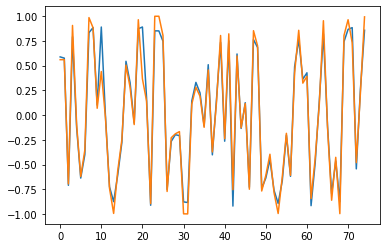

In [1513]:
train_preds = mlp_2.predict(X_train)
plt.plot(train_preds)
plt.plot(y_train)

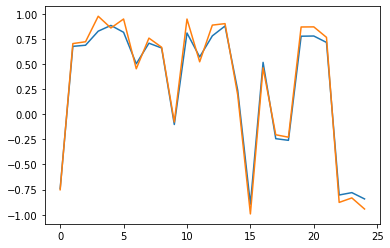

In [1514]:
test_preds = mlp_2.predict(X_test)
plt.plot(test_preds)
plt.plot(y_test)

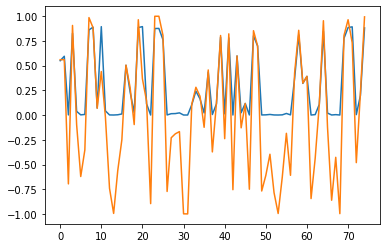

In [1515]:
train_preds = mlp_1.predict(X_train)
plt.plot(train_preds)
plt.plot(y_train)

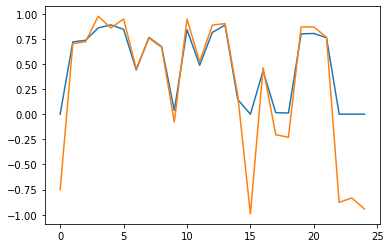

In [1516]:
test_preds = mlp_1.predict(X_test)
plt.plot(test_preds)
plt.plot(y_test)

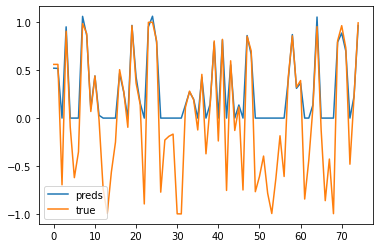

In [1519]:
train_preds = mlp_3.predict(X_train)
plt.plot(train_preds, label = 'preds')
plt.plot(y_train, label = 'true')
plt.legend()

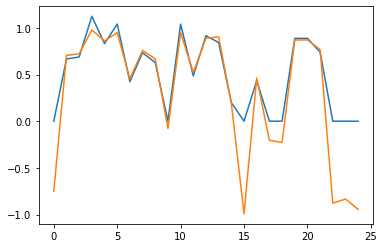

In [1520]:
test_preds = mlp_3.predict(X_test)
plt.plot(test_preds)
plt.plot(y_test)

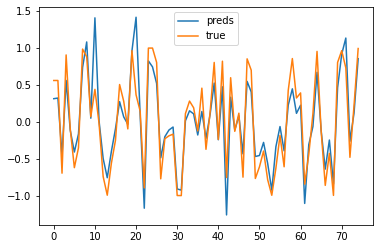

In [1517]:
train_preds = mlp_4.predict(X_train)
plt.plot(train_preds, label = 'preds')
plt.plot(y_train, label = 'true')
plt.legend()

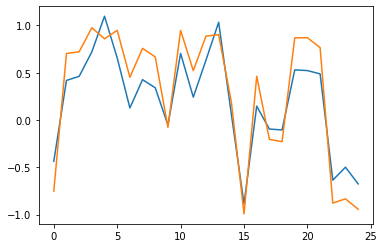

In [1518]:
test_preds = mlp_4.predict(X_test)
plt.plot(test_preds)
plt.plot(y_test)

In [103]:
results6 = pd.DataFrame(index=['epochs', 'hidden units', 'train_error', 'test_error'])

In [83]:
results4 = pd.DataFrame(index=['epochs', 'hidden units', 'train_error', 'test_error'])

In [58]:
results = pd.DataFrame(index=['epochs', 'hidden units', 'train_error', 'test_error'])

In [66]:
results2 = pd.DataFrame(index=['epochs', 'hidden units', 'train_error', 'test_error'])

In [70]:
results3 = pd.DataFrame(index=['epochs', 'hidden units', 'train_error', 'test_error'])

In [59]:
def SSE(predict, y):
    return np.power((predict - y), 2).mean()

In [60]:
test_epochs = [1000, 10000, 100000, 1000000]

In [104]:
model = 1
for epoch in test_epochs:
    for hidden in range(2, 6):
        print('testing model {}'.format(model))
        test = MLP(X_train,y_train,hidden,random_state=0, epochs=epoch)
        test.fit(X_train, y_train)
        train_error = SSE(test.predict(X_train), y_train)
        test_error = SSE(test.predict(X_test), y_test)
        results6[model] = [epoch, hidden, train_error, test_error]
        model += 1

testing model 1
testing model 2
testing model 3
testing model 4
testing model 5
testing model 6
testing model 7
testing model 8
testing model 9
testing model 10
testing model 11
testing model 12
testing model 13
testing model 14
testing model 15
testing model 16


In [63]:
results

1           2            3            4             5   \
epochs        1000.000000  1000.00000  1000.000000  1000.000000  10000.000000   
hidden units     2.000000     3.00000     4.000000     5.000000      2.000000   
train_error      0.025814     0.02937     0.015715     0.018677      0.020232   
test_error       0.042875     0.04252     0.038239     0.029322      0.038879   

                        6             7             8              9   \
epochs        10000.000000  10000.000000  10000.000000  100000.000000   
hidden units      3.000000      4.000000      5.000000       2.000000   
train_error       0.029754      0.009606      0.016511       0.020245   
test_error        0.049897      0.051454      0.044841       0.038910   

                         10             11             12              13  \
epochs        100000.000000  100000.000000  100000.000000  1000000.000000   
hidden units       3.000000       4.000000       5.000000        2.000000   
train_error        0.030341       0.006701       0.018379        0.020250   
test_error         0.057722       0.065705       0.063738        0.038916   

                          14              15              16  
epochs        1000000.000000  1000000.000000  1000000.000000  
hidden units        3.000000        4.000000        5.000000  
train_error         0.026067        0.006490        0.015274  
test_error          0.086603        0.070086        0.063890

In [85]:
results4

1            2            3            4   \
epochs        1000.000000  1000.000000  1000.000000  1000.000000   
hidden units     2.000000     3.000000     4.000000     5.000000   
train_error      0.020846     0.020371     0.012607     0.020393   
test_error       0.035976     0.033296     0.019646     0.031125   

                        5             6             7             8   \
epochs        10000.000000  10000.000000  10000.000000  10000.000000   
hidden units      2.000000      3.000000      4.000000      5.000000   
train_error       0.018232      0.012038      0.008561      0.009684   
test_error        0.040651      0.030903      0.039211      0.027347   

                         9              10             11             12  \
epochs        100000.000000  100000.000000  100000.000000  100000.000000   
hidden units       2.000000       3.000000       4.000000       5.000000   
train_error        0.017248       0.009807       0.008554       0.005275   
test_error         0.040230       0.036524       0.046355       0.025387   

                          13              14              15              16  
epochs        1000000.000000  1000000.000000  1000000.000000  1000000.000000  
hidden units        2.000000        3.000000        4.000000        5.000000  
train_error         0.017128        0.009162        0.008962        0.008278  
test_error          0.040174        0.073451        0.048800        0.037489

In [101]:
results5

1            2            3            4   \
epochs        1000.000000  1000.000000  1000.000000  1000.000000   
hidden units     2.000000     3.000000     4.000000     5.000000   
train_error      0.020790     0.020523     0.021659     0.020244   
test_error       0.036388     0.037338     0.038756     0.047729   

                        5             6             7             8   \
epochs        10000.000000  10000.000000  10000.000000  10000.000000   
hidden units      2.000000      3.000000      4.000000      5.000000   
train_error       0.020394      0.020078      0.014162      0.015391   
test_error        0.037215      0.036336      0.093349      0.067977   

                         9              10             11             12  \
epochs        100000.000000  100000.000000  100000.000000  100000.000000   
hidden units       2.000000       3.000000       4.000000       5.000000   
train_error        0.021239       0.020149       0.020396       0.017172   
test_error         0.037460       0.037888       0.159024       0.078390   

                          13              14              15              16  
epochs        1000000.000000  1000000.000000  1000000.000000  1000000.000000  
hidden units        2.000000        3.000000        4.000000        5.000000  
train_error         0.021239        0.019867        0.022054        0.016973  
test_error          0.037460        0.037601        0.157637        0.081951

In [611]:
mlp.predict(np.array([[1],[1]]))

ValueError: Shape mismatch, this model trained for 16 inputs

In [1274]:
from sklearn.utils import shuffle
#  new learning rate decay formula, starting with higher lr
hidden = [26]
prev = results8
results8 = []
loss = []
for h in hidden:
    mlp = MLP(X_train.shape[1], y_train_wide.shape[1],
            hidden_units=h,
            epochs=30000,
            learning_rate=0.01, loss='log', 
            first_activation = 'sig', second_activation='softmax', decay=1, verbosity=1)
    mlp.fit(X_train, y_train_wide)
#     save_iter(mlp.loss, "mill_loss_"+str(h))
#     save_iter(mlp.w1, "mill_weight_1_"+str(h))
#     save_iter(mlp.w2, "mill_weight_2_"+str(h))
    train_pred_wide = mlp.predict(X_train)
    test_pred_wide = mlp.predict(X_test)
    train_pred = np.argmax(train_pred_wide, axis=1)
    test_pred = np.argmax(test_pred_wide, axis=1)
    res = "h = {}, train acc = {} test acc = {}".format(h, ((train_pred == y_train).sum()/y_train.shape[0] * 100), ((test_pred == y_test).sum()/y_test.shape[0]) * 100)
    results8.append(res)
    loss.append(mlp.loss)

Epoch 1 LR 0.01 Loss is 0.13487994815297888
Epoch 2 LR 0.01 Loss is 0.19110285145016323
Epoch 3 LR 0.01 Loss is 0.2087136107550895
Epoch 4 LR 0.01 Loss is 0.13990816527352362
Epoch 5 LR 0.01 Loss is 0.12637851411547207
Epoch 6 LR 0.01 Loss is 0.12523972312323822
Epoch 7 LR 0.01 Loss is 0.12485195780141557
Epoch 8 LR 0.01 Loss is 0.1246708814206743
Epoch 9 LR 0.01 Loss is 0.12454601386224612
Epoch 10 LR 0.01 Loss is 0.12443395582908522
Epoch 11 LR 0.01 Loss is 0.12432246054401037
Epoch 12 LR 0.01 Loss is 0.12420785371663963
Epoch 13 LR 0.01 Loss is 0.12408866572609419
Epoch 14 LR 0.01 Loss is 0.12396393091137299
Epoch 15 LR 0.01 Loss is 0.1238327395849991
Epoch 16 LR 0.01 Loss is 0.1236941111520864
Epoch 17 LR 0.01 Loss is 0.12354694651903914
Epoch 18 LR 0.01 Loss is 0.12338999834472111
Epoch 19 LR 0.01 Loss is 0.12322184366711747
Epoch 20 LR 0.01 Loss is 0.12304085530305324
Epoch 21 LR 0.01 Loss is 0.12284517184147865
Epoch 22 LR 0.01 Loss is 0.12263266747592631
Epoch 23 LR 0.01 Loss i

Epoch 188 LR 0.01 Loss is 0.06591375313022584
Epoch 189 LR 0.01 Loss is 0.06785351422686661
Epoch 190 LR 0.01 Loss is 0.06310328311420563
Epoch 191 LR 0.01 Loss is 0.06192707649696586
Epoch 192 LR 0.01 Loss is 0.055813336112157726
Epoch 193 LR 0.01 Loss is 0.05671901290827659
Epoch 194 LR 0.01 Loss is 0.06021607076028361
Epoch 195 LR 0.01 Loss is 0.06558064822045533
Epoch 196 LR 0.01 Loss is 0.06337759850461824
Epoch 197 LR 0.01 Loss is 0.05932180553815849
Epoch 198 LR 0.01 Loss is 0.05966854629992518
Epoch 199 LR 0.01 Loss is 0.06817139483467313
Epoch 200 LR 0.01 Loss is 0.0738324433609794
Epoch 201 LR 0.01 Loss is 0.06503290790065622
Epoch 202 LR 0.01 Loss is 0.05804762987835264
Epoch 203 LR 0.01 Loss is 0.05878873733216803
Epoch 204 LR 0.01 Loss is 0.06050094104254612
Epoch 205 LR 0.01 Loss is 0.07086538124293194
Epoch 206 LR 0.01 Loss is 0.07168377571663297
Epoch 207 LR 0.01 Loss is 0.07084217135607705
Epoch 208 LR 0.01 Loss is 0.06759491034295864
Epoch 209 LR 0.01 Loss is 0.062469

Epoch 366 LR 0.01 Loss is 0.04225604986415261
Epoch 367 LR 0.01 Loss is 0.044570421940126746
Epoch 368 LR 0.01 Loss is 0.04661707485943259
Epoch 369 LR 0.01 Loss is 0.04935831241541664
Epoch 370 LR 0.01 Loss is 0.05095217503157852
Epoch 371 LR 0.01 Loss is 0.05009011898700693
Epoch 372 LR 0.01 Loss is 0.05095146954284339
Epoch 373 LR 0.01 Loss is 0.04765643098096422
Epoch 374 LR 0.01 Loss is 0.046603036696935524
Epoch 375 LR 0.01 Loss is 0.04331644404512471
Epoch 376 LR 0.01 Loss is 0.04539024336913045
Epoch 377 LR 0.01 Loss is 0.04541294184850159
Epoch 378 LR 0.01 Loss is 0.0508315930380056
Epoch 379 LR 0.01 Loss is 0.05135379818670512
Epoch 380 LR 0.01 Loss is 0.04607385107846612
Epoch 381 LR 0.01 Loss is 0.04202706742576539
Epoch 382 LR 0.01 Loss is 0.041803960171407556
Epoch 383 LR 0.01 Loss is 0.04234313345313851
Epoch 384 LR 0.01 Loss is 0.04306592941317374
Epoch 385 LR 0.01 Loss is 0.0445037851514379
Epoch 386 LR 0.01 Loss is 0.044461981304574176
Epoch 387 LR 0.01 Loss is 0.0445

Epoch 550 LR 0.01 Loss is 0.037703746004800844
Epoch 551 LR 0.01 Loss is 0.038834481181539135
Epoch 552 LR 0.01 Loss is 0.03917204521524494
Epoch 553 LR 0.01 Loss is 0.040520297417706276
Epoch 554 LR 0.01 Loss is 0.03949582466759945
Epoch 555 LR 0.01 Loss is 0.037915402331486374
Epoch 556 LR 0.01 Loss is 0.03622683279395688
Epoch 557 LR 0.01 Loss is 0.035765436811365826
Epoch 558 LR 0.01 Loss is 0.03547294990025687
Epoch 559 LR 0.01 Loss is 0.0361712124052181
Epoch 560 LR 0.01 Loss is 0.036786616891178195
Epoch 561 LR 0.01 Loss is 0.03790023544014649
Epoch 562 LR 0.01 Loss is 0.039602430762538936
Epoch 563 LR 0.01 Loss is 0.03872011456870313
Epoch 564 LR 0.01 Loss is 0.040001260049376874
Epoch 565 LR 0.01 Loss is 0.03797923786194101
Epoch 566 LR 0.01 Loss is 0.03852799890236562
Epoch 567 LR 0.01 Loss is 0.03899220829384377
Epoch 568 LR 0.01 Loss is 0.03876384260637833
Epoch 569 LR 0.01 Loss is 0.04063374982907826
Epoch 570 LR 0.01 Loss is 0.03906668056518295
Epoch 571 LR 0.01 Loss is 0

Epoch 731 LR 0.01 Loss is 0.03125762559783462
Epoch 732 LR 0.01 Loss is 0.031026900700467975
Epoch 733 LR 0.01 Loss is 0.030610747205699923
Epoch 734 LR 0.01 Loss is 0.030654067404866838
Epoch 735 LR 0.01 Loss is 0.030518501049686852
Epoch 736 LR 0.01 Loss is 0.030767735518018407
Epoch 737 LR 0.01 Loss is 0.03090156420737213
Epoch 738 LR 0.01 Loss is 0.03131279576724203
Epoch 739 LR 0.01 Loss is 0.03143390644521724
Epoch 740 LR 0.01 Loss is 0.0320587140586929
Epoch 741 LR 0.01 Loss is 0.03196905427558908
Epoch 742 LR 0.01 Loss is 0.03291256670784638
Epoch 743 LR 0.01 Loss is 0.032894690351644044
Epoch 744 LR 0.01 Loss is 0.03395493357322108
Epoch 745 LR 0.01 Loss is 0.033863137574401604
Epoch 746 LR 0.01 Loss is 0.034673858000146704
Epoch 747 LR 0.01 Loss is 0.03382743792738893
Epoch 748 LR 0.01 Loss is 0.03475075035421552
Epoch 749 LR 0.01 Loss is 0.03357815277664064
Epoch 750 LR 0.01 Loss is 0.03466420795880506
Epoch 751 LR 0.01 Loss is 0.03431696915464022
Epoch 752 LR 0.01 Loss is 0

Epoch 916 LR 0.01 Loss is 0.031239665921477117
Epoch 917 LR 0.01 Loss is 0.030982572003999252
Epoch 918 LR 0.01 Loss is 0.029587972581304533
Epoch 919 LR 0.01 Loss is 0.029502299338513973
Epoch 920 LR 0.01 Loss is 0.0285783305672208
Epoch 921 LR 0.01 Loss is 0.02883608792038515
Epoch 922 LR 0.01 Loss is 0.028303476191062025
Epoch 923 LR 0.01 Loss is 0.02876932980532857
Epoch 924 LR 0.01 Loss is 0.028488846093970562
Epoch 925 LR 0.01 Loss is 0.02894746828940021
Epoch 926 LR 0.01 Loss is 0.02881193051450639
Epoch 927 LR 0.01 Loss is 0.02897419954453278
Epoch 928 LR 0.01 Loss is 0.02879860291210678
Epoch 929 LR 0.01 Loss is 0.028559472395972136
Epoch 930 LR 0.01 Loss is 0.02825738900923623
Epoch 931 LR 0.01 Loss is 0.02787405679111676
Epoch 932 LR 0.01 Loss is 0.027594169866642815
Epoch 933 LR 0.01 Loss is 0.027294830376315696
Epoch 934 LR 0.01 Loss is 0.027122797778520107
Epoch 935 LR 0.01 Loss is 0.02696139362715871
Epoch 936 LR 0.01 Loss is 0.02688724862924008
Epoch 937 LR 0.01 Loss is

Epoch 1089 LR 0.001 Loss is 0.024233125122287907
Epoch 1090 LR 0.001 Loss is 0.024231025067942905
Epoch 1091 LR 0.001 Loss is 0.024228937460733437
Epoch 1092 LR 0.001 Loss is 0.024226861971605975
Epoch 1093 LR 0.001 Loss is 0.02422479828368657
Epoch 1094 LR 0.001 Loss is 0.02422274609173662
Epoch 1095 LR 0.001 Loss is 0.02422070510163623
Epoch 1096 LR 0.001 Loss is 0.024218675029893978
Epoch 1097 LR 0.001 Loss is 0.02421665560318136
Epoch 1098 LR 0.001 Loss is 0.02421464655789049
Epoch 1099 LR 0.001 Loss is 0.024212647639713984
Epoch 1100 LR 0.001 Loss is 0.02421065860324551
Epoch 1101 LR 0.001 Loss is 0.02420867921160004
Epoch 1102 LR 0.001 Loss is 0.02420670923605271
Epoch 1103 LR 0.001 Loss is 0.02420474845569521
Epoch 1104 LR 0.001 Loss is 0.02420279665710868
Epoch 1105 LR 0.001 Loss is 0.024200853634052503
Epoch 1106 LR 0.001 Loss is 0.024198919187167874
Epoch 1107 LR 0.001 Loss is 0.024196993123695342
Epoch 1108 LR 0.001 Loss is 0.024195075257205923
Epoch 1109 LR 0.001 Loss is 0.

Epoch 1264 LR 0.001 Loss is 0.02394452472107122
Epoch 1265 LR 0.001 Loss is 0.02394308438063511
Epoch 1266 LR 0.001 Loss is 0.023941645302077135
Epoch 1267 LR 0.001 Loss is 0.02394020747762682
Epoch 1268 LR 0.001 Loss is 0.023938770899608067
Epoch 1269 LR 0.001 Loss is 0.02393733556043766
Epoch 1270 LR 0.001 Loss is 0.023935901452623545
Epoch 1271 LR 0.001 Loss is 0.02393446856876349
Epoch 1272 LR 0.001 Loss is 0.023933036901543463
Epoch 1273 LR 0.001 Loss is 0.0239316064437363
Epoch 1274 LR 0.001 Loss is 0.023930177188200213
Epoch 1275 LR 0.001 Loss is 0.023928749127877413
Epoch 1276 LR 0.001 Loss is 0.023927322255792766
Epoch 1277 LR 0.001 Loss is 0.023925896565052427
Epoch 1278 LR 0.001 Loss is 0.02392447204884257
Epoch 1279 LR 0.001 Loss is 0.023923048700428065
Epoch 1280 LR 0.001 Loss is 0.023921626513151252
Epoch 1281 LR 0.001 Loss is 0.02392020548043066
Epoch 1282 LR 0.001 Loss is 0.02391878559575989
Epoch 1283 LR 0.001 Loss is 0.023917366852706325
Epoch 1284 LR 0.001 Loss is 0.

Epoch 1435 LR 0.001 Loss is 0.023712298722034734
Epoch 1436 LR 0.001 Loss is 0.023711006574692082
Epoch 1437 LR 0.001 Loss is 0.023709715052701592
Epoch 1438 LR 0.001 Loss is 0.023708424154345854
Epoch 1439 LR 0.001 Loss is 0.023707133877918472
Epoch 1440 LR 0.001 Loss is 0.023705844221723938
Epoch 1441 LR 0.001 Loss is 0.02370455518407763
Epoch 1442 LR 0.001 Loss is 0.023703266763305555
Epoch 1443 LR 0.001 Loss is 0.023701978957744417
Epoch 1444 LR 0.001 Loss is 0.023700691765741366
Epoch 1445 LR 0.001 Loss is 0.023699405185654027
Epoch 1446 LR 0.001 Loss is 0.02369811921585033
Epoch 1447 LR 0.001 Loss is 0.023696833854708454
Epoch 1448 LR 0.001 Loss is 0.02369554910061665
Epoch 1449 LR 0.001 Loss is 0.0236942649519733
Epoch 1450 LR 0.001 Loss is 0.023692981407186675
Epoch 1451 LR 0.001 Loss is 0.02369169846467495
Epoch 1452 LR 0.001 Loss is 0.02369041612286603
Epoch 1453 LR 0.001 Loss is 0.0236891343801975
Epoch 1454 LR 0.001 Loss is 0.02368785323511662
Epoch 1455 LR 0.001 Loss is 0.

Epoch 1613 LR 0.001 Loss is 0.023490898001883195
Epoch 1614 LR 0.001 Loss is 0.023489697354601557
Epoch 1615 LR 0.001 Loss is 0.02348849713836504
Epoch 1616 LR 0.001 Loss is 0.023487297352483505
Epoch 1617 LR 0.001 Loss is 0.023486097996269648
Epoch 1618 LR 0.001 Loss is 0.02348489906903892
Epoch 1619 LR 0.001 Loss is 0.023483700570109563
Epoch 1620 LR 0.001 Loss is 0.02348250249880259
Epoch 1621 LR 0.001 Loss is 0.023481304854441727
Epoch 1622 LR 0.001 Loss is 0.02348010763635343
Epoch 1623 LR 0.001 Loss is 0.023478910843866854
Epoch 1624 LR 0.001 Loss is 0.023477714476313867
Epoch 1625 LR 0.001 Loss is 0.023476518533028963
Epoch 1626 LR 0.001 Loss is 0.023475323013349342
Epoch 1627 LR 0.001 Loss is 0.02347412791661478
Epoch 1628 LR 0.001 Loss is 0.02347293324216774
Epoch 1629 LR 0.001 Loss is 0.023471738989353223
Epoch 1630 LR 0.001 Loss is 0.023470545157518893
Epoch 1631 LR 0.001 Loss is 0.02346935174601492
Epoch 1632 LR 0.001 Loss is 0.023468158754194068
Epoch 1633 LR 0.001 Loss is

Epoch 1788 LR 0.001 Loss is 0.023286828847235243
Epoch 1789 LR 0.001 Loss is 0.023285695066864686
Epoch 1790 LR 0.001 Loss is 0.023284561628008148
Epoch 1791 LR 0.001 Loss is 0.02328342853028515
Epoch 1792 LR 0.001 Loss is 0.023282295773316287
Epoch 1793 LR 0.001 Loss is 0.023281163356723256
Epoch 1794 LR 0.001 Loss is 0.023280031280128795
Epoch 1795 LR 0.001 Loss is 0.0232788995431567
Epoch 1796 LR 0.001 Loss is 0.023277768145431827
Epoch 1797 LR 0.001 Loss is 0.023276637086580124
Epoch 1798 LR 0.001 Loss is 0.023275506366228507
Epoch 1799 LR 0.001 Loss is 0.023274375984005002
Epoch 1800 LR 0.001 Loss is 0.0232732459395386
Epoch 1801 LR 0.001 Loss is 0.0232721162324594
Epoch 1802 LR 0.001 Loss is 0.02327098686239848
Epoch 1803 LR 0.001 Loss is 0.023269857828987956
Epoch 1804 LR 0.001 Loss is 0.02326872913186097
Epoch 1805 LR 0.001 Loss is 0.023267600770651646
Epoch 1806 LR 0.001 Loss is 0.023266472744995128
Epoch 1807 LR 0.001 Loss is 0.023265345054527594
Epoch 1808 LR 0.001 Loss is 0

Epoch 1957 LR 0.001 Loss is 0.02309979801274824
Epoch 1958 LR 0.001 Loss is 0.023098717259017586
Epoch 1959 LR 0.001 Loss is 0.02309763679458892
Epoch 1960 LR 0.001 Loss is 0.02309655661921043
Epoch 1961 LR 0.001 Loss is 0.023095476732630838
Epoch 1962 LR 0.001 Loss is 0.023094397134599397
Epoch 1963 LR 0.001 Loss is 0.023093317824865896
Epoch 1964 LR 0.001 Loss is 0.023092238803180624
Epoch 1965 LR 0.001 Loss is 0.023091160069294396
Epoch 1966 LR 0.001 Loss is 0.023090081622958558
Epoch 1967 LR 0.001 Loss is 0.02308900346392498
Epoch 1968 LR 0.001 Loss is 0.02308792559194602
Epoch 1969 LR 0.001 Loss is 0.023086848006774584
Epoch 1970 LR 0.001 Loss is 0.023085770708164054
Epoch 1971 LR 0.001 Loss is 0.023084693695868366
Epoch 1972 LR 0.001 Loss is 0.02308361696964193
Epoch 1973 LR 0.001 Loss is 0.023082540529239675
Epoch 1974 LR 0.001 Loss is 0.02308146437441704
Epoch 1975 LR 0.001 Loss is 0.02308038850492996
Epoch 1976 LR 0.001 Loss is 0.023079312920534875
Epoch 1977 LR 0.001 Loss is 

Epoch 2134 LR 0.001 Loss is 0.022912800573943622
Epoch 2135 LR 0.001 Loss is 0.02291176751992537
Epoch 2136 LR 0.001 Loss is 0.02291073471743323
Epoch 2137 LR 0.001 Loss is 0.022909702166285736
Epoch 2138 LR 0.001 Loss is 0.022908669866301693
Epoch 2139 LR 0.001 Loss is 0.022907637817300257
Epoch 2140 LR 0.001 Loss is 0.0229066060191008
Epoch 2141 LR 0.001 Loss is 0.022905574471523027
Epoch 2142 LR 0.001 Loss is 0.022904543174386956
Epoch 2143 LR 0.001 Loss is 0.02290351212751284
Epoch 2144 LR 0.001 Loss is 0.022902481330721272
Epoch 2145 LR 0.001 Loss is 0.022901450783833117
Epoch 2146 LR 0.001 Loss is 0.022900420486669522
Epoch 2147 LR 0.001 Loss is 0.022899390439051925
Epoch 2148 LR 0.001 Loss is 0.022898360640802053
Epoch 2149 LR 0.001 Loss is 0.022897331091741944
Epoch 2150 LR 0.001 Loss is 0.02289630179169387
Epoch 2151 LR 0.001 Loss is 0.02289527274048043
Epoch 2152 LR 0.001 Loss is 0.022894243937924462
Epoch 2153 LR 0.001 Loss is 0.02289321538384914
Epoch 2154 LR 0.001 Loss is 

Epoch 2308 LR 0.001 Loss is 0.022736688219908416
Epoch 2309 LR 0.001 Loss is 0.022735696426969817
Epoch 2310 LR 0.001 Loss is 0.02273470485779272
Epoch 2311 LR 0.001 Loss is 0.022733713512236565
Epoch 2312 LR 0.001 Loss is 0.02273272239016097
Epoch 2313 LR 0.001 Loss is 0.022731731491425735
Epoch 2314 LR 0.001 Loss is 0.022730740815890882
Epoch 2315 LR 0.001 Loss is 0.022729750363416557
Epoch 2316 LR 0.001 Loss is 0.02272876013386316
Epoch 2317 LR 0.001 Loss is 0.022727770127091217
Epoch 2318 LR 0.001 Loss is 0.022726780342961474
Epoch 2319 LR 0.001 Loss is 0.022725790781334826
Epoch 2320 LR 0.001 Loss is 0.02272480144207239
Epoch 2321 LR 0.001 Loss is 0.022723812325035456
Epoch 2322 LR 0.001 Loss is 0.022722823430085456
Epoch 2323 LR 0.001 Loss is 0.022721834757084055
Epoch 2324 LR 0.001 Loss is 0.022720846305893078
Epoch 2325 LR 0.001 Loss is 0.022719858076374527
Epoch 2326 LR 0.001 Loss is 0.022718870068390604
Epoch 2327 LR 0.001 Loss is 0.022717882281803655
Epoch 2328 LR 0.001 Loss

Epoch 2484 LR 0.001 Loss is 0.022565459701549603
Epoch 2485 LR 0.001 Loss is 0.02256450527710976
Epoch 2486 LR 0.001 Loss is 0.022563551054217965
Epoch 2487 LR 0.001 Loss is 0.02256259703276075
Epoch 2488 LR 0.001 Loss is 0.022561643212624844
Epoch 2489 LR 0.001 Loss is 0.022560689593697055
Epoch 2490 LR 0.001 Loss is 0.022559736175864344
Epoch 2491 LR 0.001 Loss is 0.022558782959013764
Epoch 2492 LR 0.001 Loss is 0.02255782994303251
Epoch 2493 LR 0.001 Loss is 0.022556877127807944
Epoch 2494 LR 0.001 Loss is 0.022555924513227486
Epoch 2495 LR 0.001 Loss is 0.02255497209917872
Epoch 2496 LR 0.001 Loss is 0.02255401988554936
Epoch 2497 LR 0.001 Loss is 0.022553067872227228
Epoch 2498 LR 0.001 Loss is 0.022552116059100267
Epoch 2499 LR 0.001 Loss is 0.022551164446056576
Epoch 2500 LR 0.001 Loss is 0.022550213032984323
Epoch 2501 LR 0.001 Loss is 0.02254926181977186
Epoch 2502 LR 0.001 Loss is 0.02254831080630763
Epoch 2503 LR 0.001 Loss is 0.0225473599924802
Epoch 2504 LR 0.001 Loss is 0

Epoch 2659 LR 0.001 Loss is 0.0224014089070976
Epoch 2660 LR 0.001 Loss is 0.022400488129672467
Epoch 2661 LR 0.001 Loss is 0.022399567535686962
Epoch 2662 LR 0.001 Loss is 0.02239864712504664
Epoch 2663 LR 0.001 Loss is 0.02239772689765718
Epoch 2664 LR 0.001 Loss is 0.022396806853424368
Epoch 2665 LR 0.001 Loss is 0.02239588699225405
Epoch 2666 LR 0.001 Loss is 0.02239496731405219
Epoch 2667 LR 0.001 Loss is 0.022394047818724835
Epoch 2668 LR 0.001 Loss is 0.02239312850617813
Epoch 2669 LR 0.001 Loss is 0.02239220937631831
Epoch 2670 LR 0.001 Loss is 0.022391290429051684
Epoch 2671 LR 0.001 Loss is 0.02239037166428469
Epoch 2672 LR 0.001 Loss is 0.02238945308192381
Epoch 2673 LR 0.001 Loss is 0.022388534681875665
Epoch 2674 LR 0.001 Loss is 0.02238761646404692
Epoch 2675 LR 0.001 Loss is 0.022386698428344384
Epoch 2676 LR 0.001 Loss is 0.022385780574674902
Epoch 2677 LR 0.001 Loss is 0.022384862902945456
Epoch 2678 LR 0.001 Loss is 0.02238394541306308
Epoch 2679 LR 0.001 Loss is 0.02

Epoch 2830 LR 0.001 Loss is 0.022246547980023446
Epoch 2831 LR 0.001 Loss is 0.022245657269533016
Epoch 2832 LR 0.001 Loss is 0.022244766727571804
Epoch 2833 LR 0.001 Loss is 0.022243876354059295
Epoch 2834 LR 0.001 Loss is 0.022242986148915046
Epoch 2835 LR 0.001 Loss is 0.02224209611205871
Epoch 2836 LR 0.001 Loss is 0.02224120624340998
Epoch 2837 LR 0.001 Loss is 0.022240316542888647
Epoch 2838 LR 0.001 Loss is 0.02223942701041456
Epoch 2839 LR 0.001 Loss is 0.02223853764590762
Epoch 2840 LR 0.001 Loss is 0.02223764844928784
Epoch 2841 LR 0.001 Loss is 0.022236759420475278
Epoch 2842 LR 0.001 Loss is 0.022235870559390063
Epoch 2843 LR 0.001 Loss is 0.02223498186595238
Epoch 2844 LR 0.001 Loss is 0.02223409334008254
Epoch 2845 LR 0.001 Loss is 0.022233204981700852
Epoch 2846 LR 0.001 Loss is 0.022232316790727742
Epoch 2847 LR 0.001 Loss is 0.02223142876708369
Epoch 2848 LR 0.001 Loss is 0.02223054091068926
Epoch 2849 LR 0.001 Loss is 0.022229653221465064
Epoch 2850 LR 0.001 Loss is 0

Epoch 3007 LR 0.001 Loss is 0.022091446772604408
Epoch 3008 LR 0.001 Loss is 0.02209058469884425
Epoch 3009 LR 0.001 Loss is 0.022089722780389502
Epoch 3010 LR 0.001 Loss is 0.02208886101717087
Epoch 3011 LR 0.001 Loss is 0.02208799940911911
Epoch 3012 LR 0.001 Loss is 0.022087137956165057
Epoch 3013 LR 0.001 Loss is 0.022086276658239555
Epoch 3014 LR 0.001 Loss is 0.02208541551527357
Epoch 3015 LR 0.001 Loss is 0.02208455452719806
Epoch 3016 LR 0.001 Loss is 0.022083693693944077
Epoch 3017 LR 0.001 Loss is 0.022082833015442723
Epoch 3018 LR 0.001 Loss is 0.022081972491625138
Epoch 3019 LR 0.001 Loss is 0.022081112122422548
Epoch 3020 LR 0.001 Loss is 0.0220802519077662
Epoch 3021 LR 0.001 Loss is 0.022079391847587428
Epoch 3022 LR 0.001 Loss is 0.022078531941817612
Epoch 3023 LR 0.001 Loss is 0.02207767219038816
Epoch 3024 LR 0.001 Loss is 0.022076812593230577
Epoch 3025 LR 0.001 Loss is 0.022075953150276405
Epoch 3026 LR 0.001 Loss is 0.022075093861457225
Epoch 3027 LR 0.001 Loss is 

Epoch 3179 LR 0.001 Loss is 0.021945398162505163
Epoch 3180 LR 0.001 Loss is 0.021944561826771982
Epoch 3181 LR 0.001 Loss is 0.021943725635198415
Epoch 3182 LR 0.001 Loss is 0.021942889587723925
Epoch 3183 LR 0.001 Loss is 0.021942053684287983
Epoch 3184 LR 0.001 Loss is 0.021941217924830145
Epoch 3185 LR 0.001 Loss is 0.021940382309289987
Epoch 3186 LR 0.001 Loss is 0.02193954683760714
Epoch 3187 LR 0.001 Loss is 0.021938711509721258
Epoch 3188 LR 0.001 Loss is 0.021937876325572096
Epoch 3189 LR 0.001 Loss is 0.02193704128509941
Epoch 3190 LR 0.001 Loss is 0.021936206388243003
Epoch 3191 LR 0.001 Loss is 0.02193537163494273
Epoch 3192 LR 0.001 Loss is 0.021934537025138513
Epoch 3193 LR 0.001 Loss is 0.02193370255877027
Epoch 3194 LR 0.001 Loss is 0.021932868235778027
Epoch 3195 LR 0.001 Loss is 0.021932034056101793
Epoch 3196 LR 0.001 Loss is 0.02193120001968167
Epoch 3197 LR 0.001 Loss is 0.02193036612645779
Epoch 3198 LR 0.001 Loss is 0.02192953237637031
Epoch 3199 LR 0.001 Loss is

Epoch 3348 LR 0.001 Loss is 0.021806057512479212
Epoch 3349 LR 0.001 Loss is 0.02180524471475216
Epoch 3350 LR 0.001 Loss is 0.021804432051564328
Epoch 3351 LR 0.001 Loss is 0.02180361952286225
Epoch 3352 LR 0.001 Loss is 0.02180280712859249
Epoch 3353 LR 0.001 Loss is 0.021801994868701668
Epoch 3354 LR 0.001 Loss is 0.021801182743136405
Epoch 3355 LR 0.001 Loss is 0.0218003707518434
Epoch 3356 LR 0.001 Loss is 0.021799558894769377
Epoch 3357 LR 0.001 Loss is 0.021798747171861085
Epoch 3358 LR 0.001 Loss is 0.02179793558306534
Epoch 3359 LR 0.001 Loss is 0.02179712412832896
Epoch 3360 LR 0.001 Loss is 0.02179631280759882
Epoch 3361 LR 0.001 Loss is 0.021795501620821854
Epoch 3362 LR 0.001 Loss is 0.021794690567944967
Epoch 3363 LR 0.001 Loss is 0.02179387964891519
Epoch 3364 LR 0.001 Loss is 0.021793068863679526
Epoch 3365 LR 0.001 Loss is 0.021792258212185042
Epoch 3366 LR 0.001 Loss is 0.021791447694378845
Epoch 3367 LR 0.001 Loss is 0.021790637310208055
Epoch 3368 LR 0.001 Loss is 0

Epoch 3520 LR 0.001 Loss is 0.021668191581730178
Epoch 3521 LR 0.001 Loss is 0.02166740116900035
Epoch 3522 LR 0.001 Loss is 0.02166661088214497
Epoch 3523 LR 0.001 Loss is 0.02166582072111662
Epoch 3524 LR 0.001 Loss is 0.02166503068586788
Epoch 3525 LR 0.001 Loss is 0.021664240776351432
Epoch 3526 LR 0.001 Loss is 0.021663450992519952
Epoch 3527 LR 0.001 Loss is 0.021662661334326115
Epoch 3528 LR 0.001 Loss is 0.021661871801722684
Epoch 3529 LR 0.001 Loss is 0.021661082394662443
Epoch 3530 LR 0.001 Loss is 0.021660293113098177
Epoch 3531 LR 0.001 Loss is 0.021659503956982736
Epoch 3532 LR 0.001 Loss is 0.021658714926268988
Epoch 3533 LR 0.001 Loss is 0.021657926020909827
Epoch 3534 LR 0.001 Loss is 0.021657137240858194
Epoch 3535 LR 0.001 Loss is 0.02165634858606706
Epoch 3536 LR 0.001 Loss is 0.021655560056489415
Epoch 3537 LR 0.001 Loss is 0.021654771652078273
Epoch 3538 LR 0.001 Loss is 0.021653983372786716
Epoch 3539 LR 0.001 Loss is 0.021653195218567827
Epoch 3540 LR 0.001 Loss 

Epoch 3697 LR 0.001 Loss is 0.021530207298692726
Epoch 3698 LR 0.001 Loss is 0.021529438455300576
Epoch 3699 LR 0.001 Loss is 0.021528669729866057
Epoch 3700 LR 0.001 Loss is 0.02152790112234703
Epoch 3701 LR 0.001 Loss is 0.021527132632701354
Epoch 3702 LR 0.001 Loss is 0.021526364260886936
Epoch 3703 LR 0.001 Loss is 0.02152559600686172
Epoch 3704 LR 0.001 Loss is 0.021524827870583654
Epoch 3705 LR 0.001 Loss is 0.02152405985201073
Epoch 3706 LR 0.001 Loss is 0.021523291951100983
Epoch 3707 LR 0.001 Loss is 0.021522524167812418
Epoch 3708 LR 0.001 Loss is 0.021521756502103136
Epoch 3709 LR 0.001 Loss is 0.021520988953931224
Epoch 3710 LR 0.001 Loss is 0.021520221523254807
Epoch 3711 LR 0.001 Loss is 0.021519454210032037
Epoch 3712 LR 0.001 Loss is 0.021518687014221088
Epoch 3713 LR 0.001 Loss is 0.02151791993578017
Epoch 3714 LR 0.001 Loss is 0.021517152974667515
Epoch 3715 LR 0.001 Loss is 0.02151638613084138
Epoch 3716 LR 0.001 Loss is 0.02151561940426006
Epoch 3717 LR 0.001 Loss i

Epoch 3873 LR 0.001 Loss is 0.02139667078992314
Epoch 3874 LR 0.001 Loss is 0.02139592208157269
Epoch 3875 LR 0.001 Loss is 0.021395173484163317
Epoch 3876 LR 0.001 Loss is 0.02139442499765733
Epoch 3877 LR 0.001 Loss is 0.021393676622017077
Epoch 3878 LR 0.001 Loss is 0.02139292835720494
Epoch 3879 LR 0.001 Loss is 0.021392180203183318
Epoch 3880 LR 0.001 Loss is 0.021391432159914625
Epoch 3881 LR 0.001 Loss is 0.021390684227361307
Epoch 3882 LR 0.001 Loss is 0.021389936405485848
Epoch 3883 LR 0.001 Loss is 0.0213891886942507
Epoch 3884 LR 0.001 Loss is 0.02138844109361841
Epoch 3885 LR 0.001 Loss is 0.02138769360355151
Epoch 3886 LR 0.001 Loss is 0.02138694622401255
Epoch 3887 LR 0.001 Loss is 0.02138619895496412
Epoch 3888 LR 0.001 Loss is 0.02138545179636884
Epoch 3889 LR 0.001 Loss is 0.021384704748189317
Epoch 3890 LR 0.001 Loss is 0.02138395781038823
Epoch 3891 LR 0.001 Loss is 0.021383210982928245
Epoch 3892 LR 0.001 Loss is 0.02138246426577206
Epoch 3893 LR 0.001 Loss is 0.021

Epoch 4050 LR 0.001 Loss is 0.021265844103751805
Epoch 4051 LR 0.001 Loss is 0.021265114465796712
Epoch 4052 LR 0.001 Loss is 0.021264384932463846
Epoch 4053 LR 0.001 Loss is 0.021263655503719395
Epoch 4054 LR 0.001 Loss is 0.021262926179529584
Epoch 4055 LR 0.001 Loss is 0.02126219695986067
Epoch 4056 LR 0.001 Loss is 0.021261467844678913
Epoch 4057 LR 0.001 Loss is 0.021260738833950566
Epoch 4058 LR 0.001 Loss is 0.021260009927641963
Epoch 4059 LR 0.001 Loss is 0.02125928112571941
Epoch 4060 LR 0.001 Loss is 0.02125855242814927
Epoch 4061 LR 0.001 Loss is 0.021257823834897886
Epoch 4062 LR 0.001 Loss is 0.02125709534593165
Epoch 4063 LR 0.001 Loss is 0.021256366961216962
Epoch 4064 LR 0.001 Loss is 0.021255638680720248
Epoch 4065 LR 0.001 Loss is 0.021254910504407958
Epoch 4066 LR 0.001 Loss is 0.021254182432246548
Epoch 4067 LR 0.001 Loss is 0.021253454464202508
Epoch 4068 LR 0.001 Loss is 0.021252726600242335
Epoch 4069 LR 0.001 Loss is 0.021251998840332558
Epoch 4070 LR 0.001 Loss

Epoch 4226 LR 0.001 Loss is 0.021139009580669308
Epoch 4227 LR 0.001 Loss is 0.0211382978532626
Epoch 4228 LR 0.001 Loss is 0.021137586224828413
Epoch 4229 LR 0.001 Loss is 0.021136874695336295
Epoch 4230 LR 0.001 Loss is 0.021136163264755804
Epoch 4231 LR 0.001 Loss is 0.021135451933056507
Epoch 4232 LR 0.001 Loss is 0.021134740700208005
Epoch 4233 LR 0.001 Loss is 0.021134029566179897
Epoch 4234 LR 0.001 Loss is 0.021133318530941806
Epoch 4235 LR 0.001 Loss is 0.021132607594463393
Epoch 4236 LR 0.001 Loss is 0.02113189675671431
Epoch 4237 LR 0.001 Loss is 0.021131186017664234
Epoch 4238 LR 0.001 Loss is 0.021130475377282867
Epoch 4239 LR 0.001 Loss is 0.021129764835539928
Epoch 4240 LR 0.001 Loss is 0.021129054392405137
Epoch 4241 LR 0.001 Loss is 0.021128344047848246
Epoch 4242 LR 0.001 Loss is 0.021127633801839033
Epoch 4243 LR 0.001 Loss is 0.02112692365434728
Epoch 4244 LR 0.001 Loss is 0.021126213605342767
Epoch 4245 LR 0.001 Loss is 0.021125503654795343
Epoch 4246 LR 0.001 Loss

Epoch 4401 LR 0.001 Loss is 0.021015938046249353
Epoch 4402 LR 0.001 Loss is 0.021015243190260286
Epoch 4403 LR 0.001 Loss is 0.021014548428170212
Epoch 4404 LR 0.001 Loss is 0.02101385375995157
Epoch 4405 LR 0.001 Loss is 0.0210131591855768
Epoch 4406 LR 0.001 Loss is 0.02101246470501837
Epoch 4407 LR 0.001 Loss is 0.021011770318248742
Epoch 4408 LR 0.001 Loss is 0.021011076025240428
Epoch 4409 LR 0.001 Loss is 0.02101038182596592
Epoch 4410 LR 0.001 Loss is 0.021009687720397748
Epoch 4411 LR 0.001 Loss is 0.02100899370850843
Epoch 4412 LR 0.001 Loss is 0.02100829979027055
Epoch 4413 LR 0.001 Loss is 0.02100760596565664
Epoch 4414 LR 0.001 Loss is 0.021006912234639314
Epoch 4415 LR 0.001 Loss is 0.021006218597191154
Epoch 4416 LR 0.001 Loss is 0.021005525053284776
Epoch 4417 LR 0.001 Loss is 0.021004831602892824
Epoch 4418 LR 0.001 Loss is 0.021004138245987923
Epoch 4419 LR 0.001 Loss is 0.021003444982542745
Epoch 4420 LR 0.001 Loss is 0.021002751812529953
Epoch 4421 LR 0.001 Loss is 

Epoch 4572 LR 0.001 Loss is 0.020898460436597818
Epoch 4573 LR 0.001 Loss is 0.02089778124883988
Epoch 4574 LR 0.001 Loss is 0.020897102150481323
Epoch 4575 LR 0.001 Loss is 0.020896423141497082
Epoch 4576 LR 0.001 Loss is 0.02089574422186205
Epoch 4577 LR 0.001 Loss is 0.020895065391551178
Epoch 4578 LR 0.001 Loss is 0.020894386650539398
Epoch 4579 LR 0.001 Loss is 0.02089370799880168
Epoch 4580 LR 0.001 Loss is 0.020893029436312986
Epoch 4581 LR 0.001 Loss is 0.020892350963048312
Epoch 4582 LR 0.001 Loss is 0.020891672578982643
Epoch 4583 LR 0.001 Loss is 0.020890994284091014
Epoch 4584 LR 0.001 Loss is 0.020890316078348434
Epoch 4585 LR 0.001 Loss is 0.020889637961729948
Epoch 4586 LR 0.001 Loss is 0.02088895993421061
Epoch 4587 LR 0.001 Loss is 0.02088828199576549
Epoch 4588 LR 0.001 Loss is 0.020887604146369657
Epoch 4589 LR 0.001 Loss is 0.020886926385998216
Epoch 4590 LR 0.001 Loss is 0.020886248714626268
Epoch 4591 LR 0.001 Loss is 0.02088557113222894
Epoch 4592 LR 0.001 Loss i

Epoch 4747 LR 0.001 Loss is 0.020780942151062392
Epoch 4748 LR 0.001 Loss is 0.02078027823766043
Epoch 4749 LR 0.001 Loss is 0.020779614409464124
Epoch 4750 LR 0.001 Loss is 0.02077895066645061
Epoch 4751 LR 0.001 Loss is 0.02077828700859701
Epoch 4752 LR 0.001 Loss is 0.0207776234358805
Epoch 4753 LR 0.001 Loss is 0.02077695994827825
Epoch 4754 LR 0.001 Loss is 0.02077629654576743
Epoch 4755 LR 0.001 Loss is 0.020775633228325232
Epoch 4756 LR 0.001 Loss is 0.020774969995928858
Epoch 4757 LR 0.001 Loss is 0.020774306848555517
Epoch 4758 LR 0.001 Loss is 0.020773643786182454
Epoch 4759 LR 0.001 Loss is 0.02077298080878689
Epoch 4760 LR 0.001 Loss is 0.020772317916346077
Epoch 4761 LR 0.001 Loss is 0.020771655108837297
Epoch 4762 LR 0.001 Loss is 0.020770992386237804
Epoch 4763 LR 0.001 Loss is 0.02077032974852488
Epoch 4764 LR 0.001 Loss is 0.02076966719567583
Epoch 4765 LR 0.001 Loss is 0.02076900472766798
Epoch 4766 LR 0.001 Loss is 0.02076834234447862
Epoch 4767 LR 0.001 Loss is 0.02

Epoch 4921 LR 0.001 Loss is 0.020666684344745702
Epoch 4922 LR 0.001 Loss is 0.020666034922908284
Epoch 4923 LR 0.001 Loss is 0.020665385582469564
Epoch 4924 LR 0.001 Loss is 0.020664736323408622
Epoch 4925 LR 0.001 Loss is 0.020664087145704557
Epoch 4926 LR 0.001 Loss is 0.020663438049336465
Epoch 4927 LR 0.001 Loss is 0.020662789034283466
Epoch 4928 LR 0.001 Loss is 0.020662140100524678
Epoch 4929 LR 0.001 Loss is 0.020661491248039218
Epoch 4930 LR 0.001 Loss is 0.020660842476806253
Epoch 4931 LR 0.001 Loss is 0.020660193786804934
Epoch 4932 LR 0.001 Loss is 0.020659545178014403
Epoch 4933 LR 0.001 Loss is 0.02065889665041388
Epoch 4934 LR 0.001 Loss is 0.0206582482039825
Epoch 4935 LR 0.001 Loss is 0.020657599838699487
Epoch 4936 LR 0.001 Loss is 0.02065695155454404
Epoch 4937 LR 0.001 Loss is 0.02065630335149538
Epoch 4938 LR 0.001 Loss is 0.020655655229532728
Epoch 4939 LR 0.001 Loss is 0.02065500718863534
Epoch 4940 LR 0.001 Loss is 0.02065435922878244
Epoch 4941 LR 0.001 Loss is

Epoch 5097 LR 0.001 Loss is 0.020553621352511764
Epoch 5098 LR 0.001 Loss is 0.020552985943794094
Epoch 5099 LR 0.001 Loss is 0.020552350612948696
Epoch 5100 LR 0.001 Loss is 0.02055171535995641
Epoch 5101 LR 0.001 Loss is 0.02055108018479804
Epoch 5102 LR 0.001 Loss is 0.020550445087454444
Epoch 5103 LR 0.001 Loss is 0.020549810067906474
Epoch 5104 LR 0.001 Loss is 0.020549175126134963
Epoch 5105 LR 0.001 Loss is 0.020548540262120798
Epoch 5106 LR 0.001 Loss is 0.020547905475844834
Epoch 5107 LR 0.001 Loss is 0.020547270767287983
Epoch 5108 LR 0.001 Loss is 0.020546636136431123
Epoch 5109 LR 0.001 Loss is 0.020546001583255154
Epoch 5110 LR 0.001 Loss is 0.020545367107741002
Epoch 5111 LR 0.001 Loss is 0.02054473270986957
Epoch 5112 LR 0.001 Loss is 0.020544098389621804
Epoch 5113 LR 0.001 Loss is 0.020543464146978642
Epoch 5114 LR 0.001 Loss is 0.020542829981921033
Epoch 5115 LR 0.001 Loss is 0.020542195894429936
Epoch 5116 LR 0.001 Loss is 0.020541561884486303
Epoch 5117 LR 0.001 Los

Epoch 5272 LR 0.001 Loss is 0.020443593934784482
Epoch 5273 LR 0.001 Loss is 0.020442971869604806
Epoch 5274 LR 0.001 Loss is 0.020442349879076612
Epoch 5275 LR 0.001 Loss is 0.020441727963182235
Epoch 5276 LR 0.001 Loss is 0.02044110612190404
Epoch 5277 LR 0.001 Loss is 0.020440484355224383
Epoch 5278 LR 0.001 Loss is 0.020439862663125648
Epoch 5279 LR 0.001 Loss is 0.020439241045590206
Epoch 5280 LR 0.001 Loss is 0.02043861950260046
Epoch 5281 LR 0.001 Loss is 0.020437998034138795
Epoch 5282 LR 0.001 Loss is 0.02043737664018761
Epoch 5283 LR 0.001 Loss is 0.020436755320729343
Epoch 5284 LR 0.001 Loss is 0.0204361340757464
Epoch 5285 LR 0.001 Loss is 0.020435512905221206
Epoch 5286 LR 0.001 Loss is 0.020434891809136217
Epoch 5287 LR 0.001 Loss is 0.02043427078747387
Epoch 5288 LR 0.001 Loss is 0.02043364984021661
Epoch 5289 LR 0.001 Loss is 0.020433028967346917
Epoch 5290 LR 0.001 Loss is 0.020432408168847255
Epoch 5291 LR 0.001 Loss is 0.020431787444700096
Epoch 5292 LR 0.001 Loss is

Epoch 5450 LR 0.001 Loss is 0.02033402632847165
Epoch 5451 LR 0.001 Loss is 0.020333417280553635
Epoch 5452 LR 0.001 Loss is 0.02033280830426939
Epoch 5453 LR 0.001 Loss is 0.020332199399602627
Epoch 5454 LR 0.001 Loss is 0.02033159056653708
Epoch 5455 LR 0.001 Loss is 0.020330981805056495
Epoch 5456 LR 0.001 Loss is 0.02033037311514462
Epoch 5457 LR 0.001 Loss is 0.020329764496785193
Epoch 5458 LR 0.001 Loss is 0.02032915594996198
Epoch 5459 LR 0.001 Loss is 0.02032854747465877
Epoch 5460 LR 0.001 Loss is 0.020327939070859318
Epoch 5461 LR 0.001 Loss is 0.020327330738547412
Epoch 5462 LR 0.001 Loss is 0.020326722477706834
Epoch 5463 LR 0.001 Loss is 0.020326114288321387
Epoch 5464 LR 0.001 Loss is 0.020325506170374878
Epoch 5465 LR 0.001 Loss is 0.020324898123851118
Epoch 5466 LR 0.001 Loss is 0.020324290148733916
Epoch 5467 LR 0.001 Loss is 0.02032368224500711
Epoch 5468 LR 0.001 Loss is 0.020323074412654532
Epoch 5469 LR 0.001 Loss is 0.020322466651660008
Epoch 5470 LR 0.001 Loss is

Epoch 5625 LR 0.001 Loss is 0.020228519545478885
Epoch 5626 LR 0.001 Loss is 0.020227922791873496
Epoch 5627 LR 0.001 Loss is 0.020227326107160104
Epoch 5628 LR 0.001 Loss is 0.02022672949132363
Epoch 5629 LR 0.001 Loss is 0.020226132944349023
Epoch 5630 LR 0.001 Loss is 0.02022553646622121
Epoch 5631 LR 0.001 Loss is 0.02022494005692512
Epoch 5632 LR 0.001 Loss is 0.02022434371644572
Epoch 5633 LR 0.001 Loss is 0.020223747444767966
Epoch 5634 LR 0.001 Loss is 0.0202231512418768
Epoch 5635 LR 0.001 Loss is 0.02022255510775723
Epoch 5636 LR 0.001 Loss is 0.0202219590423942
Epoch 5637 LR 0.001 Loss is 0.02022136304577271
Epoch 5638 LR 0.001 Loss is 0.020220767117877746
Epoch 5639 LR 0.001 Loss is 0.02022017125869429
Epoch 5640 LR 0.001 Loss is 0.020219575468207355
Epoch 5641 LR 0.001 Loss is 0.020218979746401945
Epoch 5642 LR 0.001 Loss is 0.02021838409326308
Epoch 5643 LR 0.001 Loss is 0.020217788508775772
Epoch 5644 LR 0.001 Loss is 0.020217192992925053
Epoch 5645 LR 0.001 Loss is 0.02

Epoch 5799 LR 0.001 Loss is 0.020125708535540285
Epoch 5800 LR 0.001 Loss is 0.020125123547659492
Epoch 5801 LR 0.001 Loss is 0.02012453862614118
Epoch 5802 LR 0.001 Loss is 0.02012395377097134
Epoch 5803 LR 0.001 Loss is 0.020123368982135945
Epoch 5804 LR 0.001 Loss is 0.020122784259621003
Epoch 5805 LR 0.001 Loss is 0.020122199603412515
Epoch 5806 LR 0.001 Loss is 0.02012161501349649
Epoch 5807 LR 0.001 Loss is 0.020121030489858967
Epoch 5808 LR 0.001 Loss is 0.020120446032485927
Epoch 5809 LR 0.001 Loss is 0.020119861641363423
Epoch 5810 LR 0.001 Loss is 0.020119277316477474
Epoch 5811 LR 0.001 Loss is 0.020118693057814132
Epoch 5812 LR 0.001 Loss is 0.020118108865359433
Epoch 5813 LR 0.001 Loss is 0.02011752473909942
Epoch 5814 LR 0.001 Loss is 0.02011694067902017
Epoch 5815 LR 0.001 Loss is 0.020116356685107712
Epoch 5816 LR 0.001 Loss is 0.02011577275734814
Epoch 5817 LR 0.001 Loss is 0.02011518889572751
Epoch 5818 LR 0.001 Loss is 0.0201146051002319
Epoch 5819 LR 0.001 Loss is 0

Epoch 5968 LR 0.001 Loss is 0.02002777677611352
Epoch 5969 LR 0.001 Loss is 0.02002720280898471
Epoch 5970 LR 0.001 Loss is 0.020026628905928934
Epoch 5971 LR 0.001 Loss is 0.02002605506693313
Epoch 5972 LR 0.001 Loss is 0.020025481291984188
Epoch 5973 LR 0.001 Loss is 0.020024907581069035
Epoch 5974 LR 0.001 Loss is 0.020024333934174597
Epoch 5975 LR 0.001 Loss is 0.0200237603512878
Epoch 5976 LR 0.001 Loss is 0.020023186832395574
Epoch 5977 LR 0.001 Loss is 0.020022613377484864
Epoch 5978 LR 0.001 Loss is 0.020022039986542627
Epoch 5979 LR 0.001 Loss is 0.02002146665955579
Epoch 5980 LR 0.001 Loss is 0.02002089339651132
Epoch 5981 LR 0.001 Loss is 0.02002032019739617
Epoch 5982 LR 0.001 Loss is 0.02001974706219731
Epoch 5983 LR 0.001 Loss is 0.020019173990901706
Epoch 5984 LR 0.001 Loss is 0.02001860098349634
Epoch 5985 LR 0.001 Loss is 0.020018028039968192
Epoch 5986 LR 0.001 Loss is 0.02001745516030424
Epoch 5987 LR 0.001 Loss is 0.020016882344491487
Epoch 5988 LR 0.001 Loss is 0.0

Epoch 6146 LR 0.001 Loss is 0.019926608075155786
Epoch 6147 LR 0.001 Loss is 0.019926045311438413
Epoch 6148 LR 0.001 Loss is 0.019925482609542144
Epoch 6149 LR 0.001 Loss is 0.019924919969454773
Epoch 6150 LR 0.001 Loss is 0.01992435739116407
Epoch 6151 LR 0.001 Loss is 0.019923794874657823
Epoch 6152 LR 0.001 Loss is 0.019923232419923824
Epoch 6153 LR 0.001 Loss is 0.019922670026949873
Epoch 6154 LR 0.001 Loss is 0.01992210769572375
Epoch 6155 LR 0.001 Loss is 0.019921545426233294
Epoch 6156 LR 0.001 Loss is 0.019920983218466293
Epoch 6157 LR 0.001 Loss is 0.019920421072410564
Epoch 6158 LR 0.001 Loss is 0.019919858988053922
Epoch 6159 LR 0.001 Loss is 0.019919296965384206
Epoch 6160 LR 0.001 Loss is 0.01991873500438923
Epoch 6161 LR 0.001 Loss is 0.019918173105056825
Epoch 6162 LR 0.001 Loss is 0.019917611267374836
Epoch 6163 LR 0.001 Loss is 0.0199170494913311
Epoch 6164 LR 0.001 Loss is 0.01991648777691347
Epoch 6165 LR 0.001 Loss is 0.019915926124109792
Epoch 6166 LR 0.001 Loss i

Epoch 6322 LR 0.001 Loss is 0.019828502963240388
Epoch 6323 LR 0.001 Loss is 0.019827950895822156
Epoch 6324 LR 0.001 Loss is 0.019827398888142403
Epoch 6325 LR 0.001 Loss is 0.019826846940189675
Epoch 6326 LR 0.001 Loss is 0.019826295051952516
Epoch 6327 LR 0.001 Loss is 0.01982574322341948
Epoch 6328 LR 0.001 Loss is 0.01982519145457913
Epoch 6329 LR 0.001 Loss is 0.01982463974542002
Epoch 6330 LR 0.001 Loss is 0.01982408809593074
Epoch 6331 LR 0.001 Loss is 0.01982353650609983
Epoch 6332 LR 0.001 Loss is 0.019822984975915888
Epoch 6333 LR 0.001 Loss is 0.019822433505367484
Epoch 6334 LR 0.001 Loss is 0.01982188209444322
Epoch 6335 LR 0.001 Loss is 0.019821330743131645
Epoch 6336 LR 0.001 Loss is 0.019820779451421393
Epoch 6337 LR 0.001 Loss is 0.019820228219301034
Epoch 6338 LR 0.001 Loss is 0.019819677046759184
Epoch 6339 LR 0.001 Loss is 0.01981912593378443
Epoch 6340 LR 0.001 Loss is 0.0198185748803654
Epoch 6341 LR 0.001 Loss is 0.019818023886490687
Epoch 6342 LR 0.001 Loss is 0

Epoch 6498 LR 0.001 Loss is 0.019732248996471087
Epoch 6499 LR 0.001 Loss is 0.019731707270241712
Epoch 6500 LR 0.001 Loss is 0.019731165601796538
Epoch 6501 LR 0.001 Loss is 0.019730623991124806
Epoch 6502 LR 0.001 Loss is 0.019730082438215734
Epoch 6503 LR 0.001 Loss is 0.01972954094305859
Epoch 6504 LR 0.001 Loss is 0.019728999505642615
Epoch 6505 LR 0.001 Loss is 0.01972845812595705
Epoch 6506 LR 0.001 Loss is 0.01972791680399117
Epoch 6507 LR 0.001 Loss is 0.01972737553973424
Epoch 6508 LR 0.001 Loss is 0.019726834333175496
Epoch 6509 LR 0.001 Loss is 0.019726293184304217
Epoch 6510 LR 0.001 Loss is 0.01972575209310968
Epoch 6511 LR 0.001 Loss is 0.019725211059581145
Epoch 6512 LR 0.001 Loss is 0.019724670083707905
Epoch 6513 LR 0.001 Loss is 0.01972412916547924
Epoch 6514 LR 0.001 Loss is 0.01972358830488444
Epoch 6515 LR 0.001 Loss is 0.01972304750191278
Epoch 6516 LR 0.001 Loss is 0.01972250675655355
Epoch 6517 LR 0.001 Loss is 0.019721966068796074
Epoch 6518 LR 0.001 Loss is 0

Epoch 6675 LR 0.001 Loss is 0.019637253865694884
Epoch 6676 LR 0.001 Loss is 0.019636722202925012
Epoch 6677 LR 0.001 Loss is 0.019636190596090345
Epoch 6678 LR 0.001 Loss is 0.01963565904518075
Epoch 6679 LR 0.001 Loss is 0.01963512755018612
Epoch 6680 LR 0.001 Loss is 0.01963459611109629
Epoch 6681 LR 0.001 Loss is 0.01963406472790115
Epoch 6682 LR 0.001 Loss is 0.019633533400590576
Epoch 6683 LR 0.001 Loss is 0.01963300212915445
Epoch 6684 LR 0.001 Loss is 0.01963247091358264
Epoch 6685 LR 0.001 Loss is 0.019631939753865055
Epoch 6686 LR 0.001 Loss is 0.01963140864999156
Epoch 6687 LR 0.001 Loss is 0.01963087760195207
Epoch 6688 LR 0.001 Loss is 0.01963034660973647
Epoch 6689 LR 0.001 Loss is 0.019629815673334664
Epoch 6690 LR 0.001 Loss is 0.01962928479273655
Epoch 6691 LR 0.001 Loss is 0.01962875396793203
Epoch 6692 LR 0.001 Loss is 0.019628223198911037
Epoch 6693 LR 0.001 Loss is 0.019627692485663453
Epoch 6694 LR 0.001 Loss is 0.01962716182817921
Epoch 6695 LR 0.001 Loss is 0.01

Epoch 6851 LR 0.001 Loss is 0.01954453369306741
Epoch 6852 LR 0.001 Loss is 0.019544011721706077
Epoch 6853 LR 0.001 Loss is 0.01954348980454579
Epoch 6854 LR 0.001 Loss is 0.019542967941576967
Epoch 6855 LR 0.001 Loss is 0.019542446132790044
Epoch 6856 LR 0.001 Loss is 0.01954192437817546
Epoch 6857 LR 0.001 Loss is 0.019541402677723634
Epoch 6858 LR 0.001 Loss is 0.019540881031424998
Epoch 6859 LR 0.001 Loss is 0.019540359439270013
Epoch 6860 LR 0.001 Loss is 0.019539837901249094
Epoch 6861 LR 0.001 Loss is 0.019539316417352712
Epoch 6862 LR 0.001 Loss is 0.01953879498757131
Epoch 6863 LR 0.001 Loss is 0.019538273611895328
Epoch 6864 LR 0.001 Loss is 0.019537752290315232
Epoch 6865 LR 0.001 Loss is 0.019537231022821466
Epoch 6866 LR 0.001 Loss is 0.01953670980940451
Epoch 6867 LR 0.001 Loss is 0.01953618865005482
Epoch 6868 LR 0.001 Loss is 0.019535667544762856
Epoch 6869 LR 0.001 Loss is 0.019535146493519093
Epoch 6870 LR 0.001 Loss is 0.019534625496314
Epoch 6871 LR 0.001 Loss is 0

Epoch 7027 LR 0.001 Loss is 0.0194534929916612
Epoch 7028 LR 0.001 Loss is 0.01945298041486559
Epoch 7029 LR 0.001 Loss is 0.019452467890630952
Epoch 7030 LR 0.001 Loss is 0.019451955418948237
Epoch 7031 LR 0.001 Loss is 0.01945144299980839
Epoch 7032 LR 0.001 Loss is 0.019450930633202315
Epoch 7033 LR 0.001 Loss is 0.01945041831912099
Epoch 7034 LR 0.001 Loss is 0.01944990605755534
Epoch 7035 LR 0.001 Loss is 0.019449393848496314
Epoch 7036 LR 0.001 Loss is 0.019448881691934854
Epoch 7037 LR 0.001 Loss is 0.019448369587861933
Epoch 7038 LR 0.001 Loss is 0.019447857536268497
Epoch 7039 LR 0.001 Loss is 0.019447345537145493
Epoch 7040 LR 0.001 Loss is 0.01944683359048389
Epoch 7041 LR 0.001 Loss is 0.01944632169627466
Epoch 7042 LR 0.001 Loss is 0.01944580985450875
Epoch 7043 LR 0.001 Loss is 0.01944529806517714
Epoch 7044 LR 0.001 Loss is 0.01944478632827081
Epoch 7045 LR 0.001 Loss is 0.019444274643780717
Epoch 7046 LR 0.001 Loss is 0.01944376301169785
Epoch 7047 LR 0.001 Loss is 0.01

Epoch 7203 LR 0.001 Loss is 0.019364080920623312
Epoch 7204 LR 0.001 Loss is 0.019363577457332515
Epoch 7205 LR 0.001 Loss is 0.019363074045048004
Epoch 7206 LR 0.001 Loss is 0.01936257068376118
Epoch 7207 LR 0.001 Loss is 0.019362067373463437
Epoch 7208 LR 0.001 Loss is 0.019361564114146187
Epoch 7209 LR 0.001 Loss is 0.01936106090580082
Epoch 7210 LR 0.001 Loss is 0.01936055774841875
Epoch 7211 LR 0.001 Loss is 0.01936005464199137
Epoch 7212 LR 0.001 Loss is 0.019359551586510114
Epoch 7213 LR 0.001 Loss is 0.019359048581966378
Epoch 7214 LR 0.001 Loss is 0.019358545628351567
Epoch 7215 LR 0.001 Loss is 0.01935804272565713
Epoch 7216 LR 0.001 Loss is 0.01935753987387447
Epoch 7217 LR 0.001 Loss is 0.019357037072995
Epoch 7218 LR 0.001 Loss is 0.01935653432301015
Epoch 7219 LR 0.001 Loss is 0.01935603162391137
Epoch 7220 LR 0.001 Loss is 0.019355528975690057
Epoch 7221 LR 0.001 Loss is 0.019355026378337664
Epoch 7222 LR 0.001 Loss is 0.019354523831845615
Epoch 7223 LR 0.001 Loss is 0.0

Epoch 7374 LR 0.001 Loss is 0.01927872311332606
Epoch 7375 LR 0.001 Loss is 0.019278228249046302
Epoch 7376 LR 0.001 Loss is 0.019277733434336742
Epoch 7377 LR 0.001 Loss is 0.019277238669189217
Epoch 7378 LR 0.001 Loss is 0.019276743953595507
Epoch 7379 LR 0.001 Loss is 0.019276249287547443
Epoch 7380 LR 0.001 Loss is 0.019275754671036816
Epoch 7381 LR 0.001 Loss is 0.01927526010405544
Epoch 7382 LR 0.001 Loss is 0.019274765586595157
Epoch 7383 LR 0.001 Loss is 0.019274271118647754
Epoch 7384 LR 0.001 Loss is 0.019273776700205077
Epoch 7385 LR 0.001 Loss is 0.019273282331258933
Epoch 7386 LR 0.001 Loss is 0.019272788011801156
Epoch 7387 LR 0.001 Loss is 0.019272293741823567
Epoch 7388 LR 0.001 Loss is 0.019271799521318
Epoch 7389 LR 0.001 Loss is 0.019271305350276293
Epoch 7390 LR 0.001 Loss is 0.019270811228690267
Epoch 7391 LR 0.001 Loss is 0.019270317156551763
Epoch 7392 LR 0.001 Loss is 0.019269823133852636
Epoch 7393 LR 0.001 Loss is 0.0192693291605847
Epoch 7394 LR 0.001 Loss is

Epoch 7546 LR 0.001 Loss is 0.019194328686653547
Epoch 7547 LR 0.001 Loss is 0.019193842229800095
Epoch 7548 LR 0.001 Loss is 0.01919335582114001
Epoch 7549 LR 0.001 Loss is 0.019192869460665483
Epoch 7550 LR 0.001 Loss is 0.019192383148368672
Epoch 7551 LR 0.001 Loss is 0.019191896884241798
Epoch 7552 LR 0.001 Loss is 0.019191410668277026
Epoch 7553 LR 0.001 Loss is 0.01919092450046656
Epoch 7554 LR 0.001 Loss is 0.019190438380802585
Epoch 7555 LR 0.001 Loss is 0.019189952309277298
Epoch 7556 LR 0.001 Loss is 0.019189466285882886
Epoch 7557 LR 0.001 Loss is 0.01918898031061158
Epoch 7558 LR 0.001 Loss is 0.01918849438345554
Epoch 7559 LR 0.001 Loss is 0.019188008504406988
Epoch 7560 LR 0.001 Loss is 0.019187522673458125
Epoch 7561 LR 0.001 Loss is 0.019187036890601174
Epoch 7562 LR 0.001 Loss is 0.01918655115582833
Epoch 7563 LR 0.001 Loss is 0.0191860654691318
Epoch 7564 LR 0.001 Loss is 0.01918557983050381
Epoch 7565 LR 0.001 Loss is 0.019185094239936556
Epoch 7566 LR 0.001 Loss is 

Epoch 7724 LR 0.001 Loss is 0.019108491415197198
Epoch 7725 LR 0.001 Loss is 0.01910801341550683
Epoch 7726 LR 0.001 Loss is 0.019107535462650378
Epoch 7727 LR 0.001 Loss is 0.01910705755662038
Epoch 7728 LR 0.001 Loss is 0.01910657969740938
Epoch 7729 LR 0.001 Loss is 0.019106101885009916
Epoch 7730 LR 0.001 Loss is 0.01910562411941455
Epoch 7731 LR 0.001 Loss is 0.0191051464006158
Epoch 7732 LR 0.001 Loss is 0.019104668728606247
Epoch 7733 LR 0.001 Loss is 0.019104191103378427
Epoch 7734 LR 0.001 Loss is 0.0191037135249249
Epoch 7735 LR 0.001 Loss is 0.019103235993238207
Epoch 7736 LR 0.001 Loss is 0.019102758508310926
Epoch 7737 LR 0.001 Loss is 0.019102281070135608
Epoch 7738 LR 0.001 Loss is 0.0191018036787048
Epoch 7739 LR 0.001 Loss is 0.01910132633401107
Epoch 7740 LR 0.001 Loss is 0.019100849036047005
Epoch 7741 LR 0.001 Loss is 0.019100371784805153
Epoch 7742 LR 0.001 Loss is 0.019099894580278085
Epoch 7743 LR 0.001 Loss is 0.019099417422458367
Epoch 7744 LR 0.001 Loss is 0.0

Epoch 7902 LR 0.001 Loss is 0.019024138427108733
Epoch 7903 LR 0.001 Loss is 0.01902366864807891
Epoch 7904 LR 0.001 Loss is 0.019023198914584587
Epoch 7905 LR 0.001 Loss is 0.019022729226618653
Epoch 7906 LR 0.001 Loss is 0.019022259584173955
Epoch 7907 LR 0.001 Loss is 0.019021789987243378
Epoch 7908 LR 0.001 Loss is 0.019021320435819788
Epoch 7909 LR 0.001 Loss is 0.019020850929896065
Epoch 7910 LR 0.001 Loss is 0.01902038146946509
Epoch 7911 LR 0.001 Loss is 0.019019912054519736
Epoch 7912 LR 0.001 Loss is 0.019019442685052883
Epoch 7913 LR 0.001 Loss is 0.01901897336105742
Epoch 7914 LR 0.001 Loss is 0.019018504082526227
Epoch 7915 LR 0.001 Loss is 0.019018034849452185
Epoch 7916 LR 0.001 Loss is 0.019017565661828204
Epoch 7917 LR 0.001 Loss is 0.019017096519647142
Epoch 7918 LR 0.001 Loss is 0.01901662742290191
Epoch 7919 LR 0.001 Loss is 0.0190161583715854
Epoch 7920 LR 0.001 Loss is 0.019015689365690498
Epoch 7921 LR 0.001 Loss is 0.01901522040521011
Epoch 7922 LR 0.001 Loss is

Epoch 8071 LR 0.001 Loss is 0.018945386614547963
Epoch 8072 LR 0.001 Loss is 0.018944924431149777
Epoch 8073 LR 0.001 Loss is 0.018944462292106334
Epoch 8074 LR 0.001 Loss is 0.018944000197410788
Epoch 8075 LR 0.001 Loss is 0.01894353814705629
Epoch 8076 LR 0.001 Loss is 0.01894307614103601
Epoch 8077 LR 0.001 Loss is 0.01894261417934309
Epoch 8078 LR 0.001 Loss is 0.01894215226197071
Epoch 8079 LR 0.001 Loss is 0.01894169038891203
Epoch 8080 LR 0.001 Loss is 0.018941228560160218
Epoch 8081 LR 0.001 Loss is 0.018940766775708436
Epoch 8082 LR 0.001 Loss is 0.018940305035549856
Epoch 8083 LR 0.001 Loss is 0.018939843339677645
Epoch 8084 LR 0.001 Loss is 0.018939381688084983
Epoch 8085 LR 0.001 Loss is 0.01893892008076503
Epoch 8086 LR 0.001 Loss is 0.018938458517710973
Epoch 8087 LR 0.001 Loss is 0.01893799699891599
Epoch 8088 LR 0.001 Loss is 0.018937535524373262
Epoch 8089 LR 0.001 Loss is 0.018937074094075954
Epoch 8090 LR 0.001 Loss is 0.01893661270801727
Epoch 8091 LR 0.001 Loss is 

Epoch 8241 LR 0.001 Loss is 0.018867447141227425
Epoch 8242 LR 0.001 Loss is 0.018866992401112635
Epoch 8243 LR 0.001 Loss is 0.018866537704212035
Epoch 8244 LR 0.001 Loss is 0.018866083050519036
Epoch 8245 LR 0.001 Loss is 0.018865628440027087
Epoch 8246 LR 0.001 Loss is 0.018865173872729585
Epoch 8247 LR 0.001 Loss is 0.01886471934861998
Epoch 8248 LR 0.001 Loss is 0.018864264867691688
Epoch 8249 LR 0.001 Loss is 0.018863810429938156
Epoch 8250 LR 0.001 Loss is 0.0188633560353528
Epoch 8251 LR 0.001 Loss is 0.018862901683929068
Epoch 8252 LR 0.001 Loss is 0.018862447375660386
Epoch 8253 LR 0.001 Loss is 0.0188619931105402
Epoch 8254 LR 0.001 Loss is 0.01886153888856194
Epoch 8255 LR 0.001 Loss is 0.018861084709719055
Epoch 8256 LR 0.001 Loss is 0.018860630574004982
Epoch 8257 LR 0.001 Loss is 0.018860176481413162
Epoch 8258 LR 0.001 Loss is 0.01885972243193706
Epoch 8259 LR 0.001 Loss is 0.018859268425570095
Epoch 8260 LR 0.001 Loss is 0.018858814462305747
Epoch 8261 LR 0.001 Loss is

Epoch 8410 LR 0.001 Loss is 0.0187912043827561
Epoch 8411 LR 0.001 Loss is 0.018790756853662514
Epoch 8412 LR 0.001 Loss is 0.01879030936669279
Epoch 8413 LR 0.001 Loss is 0.01878986192184059
Epoch 8414 LR 0.001 Loss is 0.0187894145190996
Epoch 8415 LR 0.001 Loss is 0.018788967158463492
Epoch 8416 LR 0.001 Loss is 0.018788519839925938
Epoch 8417 LR 0.001 Loss is 0.018788072563480605
Epoch 8418 LR 0.001 Loss is 0.01878762532912119
Epoch 8419 LR 0.001 Loss is 0.018787178136841366
Epoch 8420 LR 0.001 Loss is 0.018786730986634803
Epoch 8421 LR 0.001 Loss is 0.01878628387849519
Epoch 8422 LR 0.001 Loss is 0.018785836812416225
Epoch 8423 LR 0.001 Loss is 0.01878538978839157
Epoch 8424 LR 0.001 Loss is 0.018784942806414923
Epoch 8425 LR 0.001 Loss is 0.018784495866479983
Epoch 8426 LR 0.001 Loss is 0.018784048968580436
Epoch 8427 LR 0.001 Loss is 0.01878360211270995
Epoch 8428 LR 0.001 Loss is 0.01878315529886224
Epoch 8429 LR 0.001 Loss is 0.018782708527030987
Epoch 8430 LR 0.001 Loss is 0.0

Epoch 8588 LR 0.001 Loss is 0.018712201988643807
Epoch 8589 LR 0.001 Loss is 0.018711761859181476
Epoch 8590 LR 0.001 Loss is 0.01871132177073818
Epoch 8591 LR 0.001 Loss is 0.018710881723307843
Epoch 8592 LR 0.001 Loss is 0.018710441716884376
Epoch 8593 LR 0.001 Loss is 0.018710001751461695
Epoch 8594 LR 0.001 Loss is 0.018709561827033705
Epoch 8595 LR 0.001 Loss is 0.01870912194359434
Epoch 8596 LR 0.001 Loss is 0.018708682101137516
Epoch 8597 LR 0.001 Loss is 0.018708242299657153
Epoch 8598 LR 0.001 Loss is 0.018707802539147177
Epoch 8599 LR 0.001 Loss is 0.01870736281960151
Epoch 8600 LR 0.001 Loss is 0.01870692314101407
Epoch 8601 LR 0.001 Loss is 0.018706483503378796
Epoch 8602 LR 0.001 Loss is 0.018706043906689607
Epoch 8603 LR 0.001 Loss is 0.018705604350940427
Epoch 8604 LR 0.001 Loss is 0.0187051648361252
Epoch 8605 LR 0.001 Loss is 0.01870472536223785
Epoch 8606 LR 0.001 Loss is 0.01870428592927232
Epoch 8607 LR 0.001 Loss is 0.018703846537222523
Epoch 8608 LR 0.001 Loss is 

Epoch 8765 LR 0.001 Loss is 0.018634932507173456
Epoch 8766 LR 0.001 Loss is 0.01863449954444641
Epoch 8767 LR 0.001 Loss is 0.01863406662168102
Epoch 8768 LR 0.001 Loss is 0.018633633738871423
Epoch 8769 LR 0.001 Loss is 0.01863320089601175
Epoch 8770 LR 0.001 Loss is 0.018632768093096143
Epoch 8771 LR 0.001 Loss is 0.018632335330118745
Epoch 8772 LR 0.001 Loss is 0.018631902607073713
Epoch 8773 LR 0.001 Loss is 0.01863146992395515
Epoch 8774 LR 0.001 Loss is 0.018631037280757247
Epoch 8775 LR 0.001 Loss is 0.018630604677474117
Epoch 8776 LR 0.001 Loss is 0.018630172114099935
Epoch 8777 LR 0.001 Loss is 0.018629739590628823
Epoch 8778 LR 0.001 Loss is 0.018629307107054946
Epoch 8779 LR 0.001 Loss is 0.01862887466337245
Epoch 8780 LR 0.001 Loss is 0.018628442259575485
Epoch 8781 LR 0.001 Loss is 0.0186280098956582
Epoch 8782 LR 0.001 Loss is 0.01862757757161477
Epoch 8783 LR 0.001 Loss is 0.018627145287439324
Epoch 8784 LR 0.001 Loss is 0.018626713043126047
Epoch 8785 LR 0.001 Loss is 

Epoch 8939 LR 0.001 Loss is 0.018560193440938223
Epoch 8940 LR 0.001 Loss is 0.018559767344336463
Epoch 8941 LR 0.001 Loss is 0.018559341286694238
Epoch 8942 LR 0.001 Loss is 0.018558915268005877
Epoch 8943 LR 0.001 Loss is 0.018558489288265735
Epoch 8944 LR 0.001 Loss is 0.018558063347468148
Epoch 8945 LR 0.001 Loss is 0.018557637445607483
Epoch 8946 LR 0.001 Loss is 0.018557211582678056
Epoch 8947 LR 0.001 Loss is 0.01855678575867424
Epoch 8948 LR 0.001 Loss is 0.01855635997359037
Epoch 8949 LR 0.001 Loss is 0.018555934227420818
Epoch 8950 LR 0.001 Loss is 0.018555508520159917
Epoch 8951 LR 0.001 Loss is 0.01855508285180201
Epoch 8952 LR 0.001 Loss is 0.01855465722234149
Epoch 8953 LR 0.001 Loss is 0.018554231631772673
Epoch 8954 LR 0.001 Loss is 0.01855380608008994
Epoch 8955 LR 0.001 Loss is 0.01855338056728763
Epoch 8956 LR 0.001 Loss is 0.018552955093360125
Epoch 8957 LR 0.001 Loss is 0.01855252965830176
Epoch 8958 LR 0.001 Loss is 0.01855210426210692
Epoch 8959 LR 0.001 Loss is 

Epoch 9116 LR 0.001 Loss is 0.01848537608055876
Epoch 9117 LR 0.001 Loss is 0.018484956792699535
Epoch 9118 LR 0.001 Loss is 0.01848453754281594
Epoch 9119 LR 0.001 Loss is 0.01848411833090251
Epoch 9120 LR 0.001 Loss is 0.018483699156953803
Epoch 9121 LR 0.001 Loss is 0.01848328002096433
Epoch 9122 LR 0.001 Loss is 0.018482860922928637
Epoch 9123 LR 0.001 Loss is 0.018482441862841287
Epoch 9124 LR 0.001 Loss is 0.01848202284069683
Epoch 9125 LR 0.001 Loss is 0.01848160385648978
Epoch 9126 LR 0.001 Loss is 0.018481184910214717
Epoch 9127 LR 0.001 Loss is 0.018480766001866152
Epoch 9128 LR 0.001 Loss is 0.018480347131438653
Epoch 9129 LR 0.001 Loss is 0.01847992829892677
Epoch 9130 LR 0.001 Loss is 0.018479509504325052
Epoch 9131 LR 0.001 Loss is 0.01847909074762805
Epoch 9132 LR 0.001 Loss is 0.0184786720288303
Epoch 9133 LR 0.001 Loss is 0.0184782533479264
Epoch 9134 LR 0.001 Loss is 0.01847783470491086
Epoch 9135 LR 0.001 Loss is 0.018477416099778248
Epoch 9136 LR 0.001 Loss is 0.018

Epoch 9285 LR 0.001 Loss is 0.01841505125324374
Epoch 9286 LR 0.001 Loss is 0.018414638306569316
Epoch 9287 LR 0.001 Loss is 0.01841422539696244
Epoch 9288 LR 0.001 Loss is 0.01841381252441782
Epoch 9289 LR 0.001 Loss is 0.018413399688930198
Epoch 9290 LR 0.001 Loss is 0.018412986890494254
Epoch 9291 LR 0.001 Loss is 0.018412574129104728
Epoch 9292 LR 0.001 Loss is 0.018412161404756332
Epoch 9293 LR 0.001 Loss is 0.01841174871744378
Epoch 9294 LR 0.001 Loss is 0.018411336067161804
Epoch 9295 LR 0.001 Loss is 0.018410923453905114
Epoch 9296 LR 0.001 Loss is 0.018410510877668453
Epoch 9297 LR 0.001 Loss is 0.018410098338446517
Epoch 9298 LR 0.001 Loss is 0.01840968583623404
Epoch 9299 LR 0.001 Loss is 0.018409273371025756
Epoch 9300 LR 0.001 Loss is 0.01840886094281637
Epoch 9301 LR 0.001 Loss is 0.01840844855160064
Epoch 9302 LR 0.001 Loss is 0.01840803619737327
Epoch 9303 LR 0.001 Loss is 0.018407623880129
Epoch 9304 LR 0.001 Loss is 0.01840721159986256
Epoch 9305 LR 0.001 Loss is 0.01

Epoch 9461 LR 0.001 Loss is 0.01834293879601289
Epoch 9462 LR 0.001 Loss is 0.01834253229271309
Epoch 9463 LR 0.001 Loss is 0.018342125825565762
Epoch 9464 LR 0.001 Loss is 0.018341719394565803
Epoch 9465 LR 0.001 Loss is 0.018341312999708082
Epoch 9466 LR 0.001 Loss is 0.01834090664098749
Epoch 9467 LR 0.001 Loss is 0.018340500318398924
Epoch 9468 LR 0.001 Loss is 0.018340094031937277
Epoch 9469 LR 0.001 Loss is 0.018339687781597426
Epoch 9470 LR 0.001 Loss is 0.018339281567374285
Epoch 9471 LR 0.001 Loss is 0.018338875389262734
Epoch 9472 LR 0.001 Loss is 0.01833846924725767
Epoch 9473 LR 0.001 Loss is 0.018338063141353975
Epoch 9474 LR 0.001 Loss is 0.01833765707154656
Epoch 9475 LR 0.001 Loss is 0.01833725103783032
Epoch 9476 LR 0.001 Loss is 0.018336845040200146
Epoch 9477 LR 0.001 Loss is 0.01833643907865094
Epoch 9478 LR 0.001 Loss is 0.018336033153177615
Epoch 9479 LR 0.001 Loss is 0.018335627263775054
Epoch 9480 LR 0.001 Loss is 0.018335221410438165
Epoch 9481 LR 0.001 Loss is

Epoch 9638 LR 0.001 Loss is 0.018271546213875705
Epoch 9639 LR 0.001 Loss is 0.01827114603076713
Epoch 9640 LR 0.001 Loss is 0.01827074588292046
Epoch 9641 LR 0.001 Loss is 0.018270345770330754
Epoch 9642 LR 0.001 Loss is 0.01826994569299306
Epoch 9643 LR 0.001 Loss is 0.018269545650902438
Epoch 9644 LR 0.001 Loss is 0.018269145644053925
Epoch 9645 LR 0.001 Loss is 0.01826874567244259
Epoch 9646 LR 0.001 Loss is 0.018268345736063476
Epoch 9647 LR 0.001 Loss is 0.018267945834911644
Epoch 9648 LR 0.001 Loss is 0.01826754596898214
Epoch 9649 LR 0.001 Loss is 0.018267146138270046
Epoch 9650 LR 0.001 Loss is 0.01826674634277039
Epoch 9651 LR 0.001 Loss is 0.01826634658247825
Epoch 9652 LR 0.001 Loss is 0.018265946857388676
Epoch 9653 LR 0.001 Loss is 0.018265547167496746
Epoch 9654 LR 0.001 Loss is 0.018265147512797505
Epoch 9655 LR 0.001 Loss is 0.01826474789328602
Epoch 9656 LR 0.001 Loss is 0.018264348308957356
Epoch 9657 LR 0.001 Loss is 0.01826394875980657
Epoch 9658 LR 0.001 Loss is 0

Epoch 9807 LR 0.001 Loss is 0.01820441196411699
Epoch 9808 LR 0.001 Loss is 0.018204017670702878
Epoch 9809 LR 0.001 Loss is 0.018203623411726676
Epoch 9810 LR 0.001 Loss is 0.01820322918718359
Epoch 9811 LR 0.001 Loss is 0.018202834997068797
Epoch 9812 LR 0.001 Loss is 0.018202440841377506
Epoch 9813 LR 0.001 Loss is 0.018202046720104923
Epoch 9814 LR 0.001 Loss is 0.018201652633246242
Epoch 9815 LR 0.001 Loss is 0.018201258580796676
Epoch 9816 LR 0.001 Loss is 0.018200864562751422
Epoch 9817 LR 0.001 Loss is 0.018200470579105673
Epoch 9818 LR 0.001 Loss is 0.018200076629854654
Epoch 9819 LR 0.001 Loss is 0.01819968271499356
Epoch 9820 LR 0.001 Loss is 0.018199288834517595
Epoch 9821 LR 0.001 Loss is 0.018198894988421973
Epoch 9822 LR 0.001 Loss is 0.018198501176701902
Epoch 9823 LR 0.001 Loss is 0.018198107399352573
Epoch 9824 LR 0.001 Loss is 0.01819771365636923
Epoch 9825 LR 0.001 Loss is 0.018197319947747054
Epoch 9826 LR 0.001 Loss is 0.018196926273481278
Epoch 9827 LR 0.001 Loss

Epoch 9982 LR 0.001 Loss is 0.018135930749678567
Epoch 9983 LR 0.001 Loss is 0.018135542410528272
Epoch 9984 LR 0.001 Loss is 0.01813515410498832
Epoch 9985 LR 0.001 Loss is 0.01813476583305404
Epoch 9986 LR 0.001 Loss is 0.018134377594720804
Epoch 9987 LR 0.001 Loss is 0.018133989389983937
Epoch 9988 LR 0.001 Loss is 0.01813360121883879
Epoch 9989 LR 0.001 Loss is 0.018133213081280714
Epoch 9990 LR 0.001 Loss is 0.018132824977305055
Epoch 9991 LR 0.001 Loss is 0.018132436906907155
Epoch 9992 LR 0.001 Loss is 0.018132048870082372
Epoch 9993 LR 0.001 Loss is 0.018131660866826053
Epoch 9994 LR 0.001 Loss is 0.01813127289713355
Epoch 9995 LR 0.001 Loss is 0.01813088496100021
Epoch 9996 LR 0.001 Loss is 0.0181304970584214
Epoch 9997 LR 0.001 Loss is 0.01813010918939245
Epoch 9998 LR 0.001 Loss is 0.018129721353908727
Epoch 9999 LR 0.001 Loss is 0.018129333551965596
Epoch 10000 LR 0.001 Loss is 0.0181289457835584
Epoch 10001 LR 0.001 Loss is 0.01812855804868249
Epoch 10002 LR 0.001 Loss is 

Epoch 10151 LR 0.001 Loss is 0.01807077491244756
Epoch 10152 LR 0.001 Loss is 0.01807039218797823
Epoch 10153 LR 0.001 Loss is 0.018070009496343686
Epoch 10154 LR 0.001 Loss is 0.018069626837539394
Epoch 10155 LR 0.001 Loss is 0.018069244211560823
Epoch 10156 LR 0.001 Loss is 0.01806886161840347
Epoch 10157 LR 0.001 Loss is 0.0180684790580628
Epoch 10158 LR 0.001 Loss is 0.0180680965305343
Epoch 10159 LR 0.001 Loss is 0.018067714035813465
Epoch 10160 LR 0.001 Loss is 0.018067331573895756
Epoch 10161 LR 0.001 Loss is 0.018066949144776672
Epoch 10162 LR 0.001 Loss is 0.01806656674845169
Epoch 10163 LR 0.001 Loss is 0.0180661843849163
Epoch 10164 LR 0.001 Loss is 0.018065802054165973
Epoch 10165 LR 0.001 Loss is 0.018065419756196202
Epoch 10166 LR 0.001 Loss is 0.018065037491002484
Epoch 10167 LR 0.001 Loss is 0.018064655258580302
Epoch 10168 LR 0.001 Loss is 0.01806427305892514
Epoch 10169 LR 0.001 Loss is 0.01806389089203249
Epoch 10170 LR 0.001 Loss is 0.018063508757897844
Epoch 10171 

Epoch 10322 LR 0.001 Loss is 0.01800580260526132
Epoch 10323 LR 0.001 Loss is 0.018005425430436015
Epoch 10324 LR 0.001 Loss is 0.018005048287683307
Epoch 10325 LR 0.001 Loss is 0.01800467117699879
Epoch 10326 LR 0.001 Loss is 0.01800429409837806
Epoch 10327 LR 0.001 Loss is 0.01800391705181675
Epoch 10328 LR 0.001 Loss is 0.018003540037310455
Epoch 10329 LR 0.001 Loss is 0.01800316305485479
Epoch 10330 LR 0.001 Loss is 0.018002786104445355
Epoch 10331 LR 0.001 Loss is 0.01800240918607777
Epoch 10332 LR 0.001 Loss is 0.01800203229974766
Epoch 10333 LR 0.001 Loss is 0.01800165544545063
Epoch 10334 LR 0.001 Loss is 0.018001278623182286
Epoch 10335 LR 0.001 Loss is 0.018000901832938242
Epoch 10336 LR 0.001 Loss is 0.018000525074714127
Epoch 10337 LR 0.001 Loss is 0.01800014834850554
Epoch 10338 LR 0.001 Loss is 0.017999771654308123
Epoch 10339 LR 0.001 Loss is 0.01799939499211747
Epoch 10340 LR 0.001 Loss is 0.01799901836192922
Epoch 10341 LR 0.001 Loss is 0.017998641763738974
Epoch 10342

Epoch 10489 LR 0.001 Loss is 0.017943255641901
Epoch 10490 LR 0.001 Loss is 0.01794288376287322
Epoch 10491 LR 0.001 Loss is 0.01794251191519463
Epoch 10492 LR 0.001 Loss is 0.017942140098860963
Epoch 10493 LR 0.001 Loss is 0.017941768313867953
Epoch 10494 LR 0.001 Loss is 0.017941396560211324
Epoch 10495 LR 0.001 Loss is 0.017941024837886795
Epoch 10496 LR 0.001 Loss is 0.01794065314689012
Epoch 10497 LR 0.001 Loss is 0.01794028148721702
Epoch 10498 LR 0.001 Loss is 0.01793990985886323
Epoch 10499 LR 0.001 Loss is 0.017939538261824487
Epoch 10500 LR 0.001 Loss is 0.017939166696096524
Epoch 10501 LR 0.001 Loss is 0.01793879516167508
Epoch 10502 LR 0.001 Loss is 0.01793842365855587
Epoch 10503 LR 0.001 Loss is 0.01793805218673466
Epoch 10504 LR 0.001 Loss is 0.01793768074620717
Epoch 10505 LR 0.001 Loss is 0.01793730933696915
Epoch 10506 LR 0.001 Loss is 0.017936937959016325
Epoch 10507 LR 0.001 Loss is 0.017936566612344444
Epoch 10508 LR 0.001 Loss is 0.017936195296949252
Epoch 10509 L

Epoch 10665 LR 0.001 Loss is 0.0178782839230757
Epoch 10666 LR 0.001 Loss is 0.017877917496363555
Epoch 10667 LR 0.001 Loss is 0.017877551100259736
Epoch 10668 LR 0.001 Loss is 0.0178771847347601
Epoch 10669 LR 0.001 Loss is 0.017876818399860533
Epoch 10670 LR 0.001 Loss is 0.01787645209555685
Epoch 10671 LR 0.001 Loss is 0.01787608582184492
Epoch 10672 LR 0.001 Loss is 0.017875719578720597
Epoch 10673 LR 0.001 Loss is 0.017875353366179732
Epoch 10674 LR 0.001 Loss is 0.01787498718421819
Epoch 10675 LR 0.001 Loss is 0.017874621032831824
Epoch 10676 LR 0.001 Loss is 0.017874254912016493
Epoch 10677 LR 0.001 Loss is 0.01787388882176805
Epoch 10678 LR 0.001 Loss is 0.01787352276208236
Epoch 10679 LR 0.001 Loss is 0.017873156732955274
Epoch 10680 LR 0.001 Loss is 0.017872790734382662
Epoch 10681 LR 0.001 Loss is 0.017872424766360386
Epoch 10682 LR 0.001 Loss is 0.017872058828884305
Epoch 10683 LR 0.001 Loss is 0.01787169292195027
Epoch 10684 LR 0.001 Loss is 0.017871327045554154
Epoch 1068

Epoch 10834 LR 0.001 Loss is 0.017816789069155355
Epoch 10835 LR 0.001 Loss is 0.017816427756905423
Epoch 10836 LR 0.001 Loss is 0.017816066474572446
Epoch 10837 LR 0.001 Loss is 0.017815705222152384
Epoch 10838 LR 0.001 Loss is 0.017815343999641197
Epoch 10839 LR 0.001 Loss is 0.017814982807034876
Epoch 10840 LR 0.001 Loss is 0.017814621644329377
Epoch 10841 LR 0.001 Loss is 0.017814260511520654
Epoch 10842 LR 0.001 Loss is 0.017813899408604707
Epoch 10843 LR 0.001 Loss is 0.017813538335577476
Epoch 10844 LR 0.001 Loss is 0.017813177292434954
Epoch 10845 LR 0.001 Loss is 0.017812816279173093
Epoch 10846 LR 0.001 Loss is 0.017812455295787868
Epoch 10847 LR 0.001 Loss is 0.017812094342275275
Epoch 10848 LR 0.001 Loss is 0.017811733418631254
Epoch 10849 LR 0.001 Loss is 0.017811372524851796
Epoch 10850 LR 0.001 Loss is 0.017811011660932876
Epoch 10851 LR 0.001 Loss is 0.01781065082687046
Epoch 10852 LR 0.001 Loss is 0.01781029002266054
Epoch 10853 LR 0.001 Loss is 0.017809929248299078
Ep

Epoch 11009 LR 0.001 Loss is 0.017754011393916535
Epoch 11010 LR 0.001 Loss is 0.01775365525628857
Epoch 11011 LR 0.001 Loss is 0.017753299147881527
Epoch 11012 LR 0.001 Loss is 0.017752943068691487
Epoch 11013 LR 0.001 Loss is 0.017752587018714516
Epoch 11014 LR 0.001 Loss is 0.017752230997946723
Epoch 11015 LR 0.001 Loss is 0.01775187500638416
Epoch 11016 LR 0.001 Loss is 0.017751519044022925
Epoch 11017 LR 0.001 Loss is 0.01775116311085911
Epoch 11018 LR 0.001 Loss is 0.01775080720688877
Epoch 11019 LR 0.001 Loss is 0.017750451332108015
Epoch 11020 LR 0.001 Loss is 0.017750095486512917
Epoch 11021 LR 0.001 Loss is 0.01774973967009957
Epoch 11022 LR 0.001 Loss is 0.017749383882864046
Epoch 11023 LR 0.001 Loss is 0.01774902812480245
Epoch 11024 LR 0.001 Loss is 0.017748672395910853
Epoch 11025 LR 0.001 Loss is 0.017748316696185346
Epoch 11026 LR 0.001 Loss is 0.01774796102562202
Epoch 11027 LR 0.001 Loss is 0.017747605384216967
Epoch 11028 LR 0.001 Loss is 0.017747249771966275
Epoch 1

Epoch 11185 LR 0.001 Loss is 0.0176917776962928
Epoch 11186 LR 0.001 Loss is 0.017691426641736736
Epoch 11187 LR 0.001 Loss is 0.01769107561572132
Epoch 11188 LR 0.001 Loss is 0.01769072461824273
Epoch 11189 LR 0.001 Loss is 0.01769037364929715
Epoch 11190 LR 0.001 Loss is 0.017690022708880777
Epoch 11191 LR 0.001 Loss is 0.017689671796989808
Epoch 11192 LR 0.001 Loss is 0.017689320913620427
Epoch 11193 LR 0.001 Loss is 0.01768897005876883
Epoch 11194 LR 0.001 Loss is 0.0176886192324312
Epoch 11195 LR 0.001 Loss is 0.017688268434603745
Epoch 11196 LR 0.001 Loss is 0.01768791766528267
Epoch 11197 LR 0.001 Loss is 0.017687566924464142
Epoch 11198 LR 0.001 Loss is 0.017687216212144377
Epoch 11199 LR 0.001 Loss is 0.017686865528319558
Epoch 11200 LR 0.001 Loss is 0.017686514872985906
Epoch 11201 LR 0.001 Loss is 0.017686164246139596
Epoch 11202 LR 0.001 Loss is 0.017685813647776837
Epoch 11203 LR 0.001 Loss is 0.01768546307789383
Epoch 11204 LR 0.001 Loss is 0.017685112536486768
Epoch 1120

Epoch 11351 LR 0.001 Loss is 0.01763389067027968
Epoch 11352 LR 0.001 Loss is 0.017633544301749272
Epoch 11353 LR 0.001 Loss is 0.017633197961135393
Epoch 11354 LR 0.001 Loss is 0.01763285164843436
Epoch 11355 LR 0.001 Loss is 0.01763250536364244
Epoch 11356 LR 0.001 Loss is 0.017632159106755925
Epoch 11357 LR 0.001 Loss is 0.017631812877771127
Epoch 11358 LR 0.001 Loss is 0.017631466676684325
Epoch 11359 LR 0.001 Loss is 0.01763112050349182
Epoch 11360 LR 0.001 Loss is 0.017630774358189893
Epoch 11361 LR 0.001 Loss is 0.017630428240774855
Epoch 11362 LR 0.001 Loss is 0.017630082151242996
Epoch 11363 LR 0.001 Loss is 0.017629736089590606
Epoch 11364 LR 0.001 Loss is 0.017629390055813994
Epoch 11365 LR 0.001 Loss is 0.01762904404990945
Epoch 11366 LR 0.001 Loss is 0.01762869807187327
Epoch 11367 LR 0.001 Loss is 0.01762835212170177
Epoch 11368 LR 0.001 Loss is 0.017628006199391224
Epoch 11369 LR 0.001 Loss is 0.01762766030493794
Epoch 11370 LR 0.001 Loss is 0.01762731443833823
Epoch 113

Epoch 11527 LR 0.001 Loss is 0.017573356433663638
Epoch 11528 LR 0.001 Loss is 0.017573014921854997
Epoch 11529 LR 0.001 Loss is 0.01757267343731924
Epoch 11530 LR 0.001 Loss is 0.01757233198005274
Epoch 11531 LR 0.001 Loss is 0.017571990550051896
Epoch 11532 LR 0.001 Loss is 0.017571649147313115
Epoch 11533 LR 0.001 Loss is 0.017571307771832783
Epoch 11534 LR 0.001 Loss is 0.017570966423607302
Epoch 11535 LR 0.001 Loss is 0.017570625102633065
Epoch 11536 LR 0.001 Loss is 0.01757028380890647
Epoch 11537 LR 0.001 Loss is 0.017569942542423923
Epoch 11538 LR 0.001 Loss is 0.01756960130318182
Epoch 11539 LR 0.001 Loss is 0.017569260091176563
Epoch 11540 LR 0.001 Loss is 0.01756891890640454
Epoch 11541 LR 0.001 Loss is 0.017568577748862165
Epoch 11542 LR 0.001 Loss is 0.017568236618545844
Epoch 11543 LR 0.001 Loss is 0.017567895515451973
Epoch 11544 LR 0.001 Loss is 0.017567554439576943
Epoch 11545 LR 0.001 Loss is 0.017567213390917172
Epoch 11546 LR 0.001 Loss is 0.017566872369469064
Epoch

Epoch 11698 LR 0.001 Loss is 0.017515351393406913
Epoch 11699 LR 0.001 Loss is 0.01751501449332882
Epoch 11700 LR 0.001 Loss is 0.017514677619915462
Epoch 11701 LR 0.001 Loss is 0.017514340773163346
Epoch 11702 LR 0.001 Loss is 0.017514003953068936
Epoch 11703 LR 0.001 Loss is 0.017513667159628734
Epoch 11704 LR 0.001 Loss is 0.017513330392839258
Epoch 11705 LR 0.001 Loss is 0.01751299365269698
Epoch 11706 LR 0.001 Loss is 0.017512656939198398
Epoch 11707 LR 0.001 Loss is 0.017512320252340015
Epoch 11708 LR 0.001 Loss is 0.017511983592118315
Epoch 11709 LR 0.001 Loss is 0.01751164695852981
Epoch 11710 LR 0.001 Loss is 0.017511310351570986
Epoch 11711 LR 0.001 Loss is 0.017510973771238357
Epoch 11712 LR 0.001 Loss is 0.017510637217528408
Epoch 11713 LR 0.001 Loss is 0.01751030069043764
Epoch 11714 LR 0.001 Loss is 0.017509964189962552
Epoch 11715 LR 0.001 Loss is 0.017509627716099648
Epoch 11716 LR 0.001 Loss is 0.01750929126884544
Epoch 11717 LR 0.001 Loss is 0.01750895484819641
Epoch 

Epoch 11867 LR 0.001 Loss is 0.017458791059556337
Epoch 11868 LR 0.001 Loss is 0.017458458616471606
Epoch 11869 LR 0.001 Loss is 0.017458126199466805
Epoch 11870 LR 0.001 Loss is 0.017457793808538534
Epoch 11871 LR 0.001 Loss is 0.01745746144368338
Epoch 11872 LR 0.001 Loss is 0.017457129104897922
Epoch 11873 LR 0.001 Loss is 0.017456796792178767
Epoch 11874 LR 0.001 Loss is 0.017456464505522486
Epoch 11875 LR 0.001 Loss is 0.01745613224492567
Epoch 11876 LR 0.001 Loss is 0.017455800010384912
Epoch 11877 LR 0.001 Loss is 0.0174554678018968
Epoch 11878 LR 0.001 Loss is 0.017455135619457943
Epoch 11879 LR 0.001 Loss is 0.017454803463064918
Epoch 11880 LR 0.001 Loss is 0.017454471332714307
Epoch 11881 LR 0.001 Loss is 0.017454139228402724
Epoch 11882 LR 0.001 Loss is 0.017453807150126746
Epoch 11883 LR 0.001 Loss is 0.017453475097882983
Epoch 11884 LR 0.001 Loss is 0.017453143071668013
Epoch 11885 LR 0.001 Loss is 0.01745281107147843
Epoch 11886 LR 0.001 Loss is 0.017452479097310847
Epoch

Epoch 12039 LR 0.001 Loss is 0.01740199155547202
Epoch 12040 LR 0.001 Loss is 0.01740166354839734
Epoch 12041 LR 0.001 Loss is 0.01740133556682354
Epoch 12042 LR 0.001 Loss is 0.01740100761074729
Epoch 12043 LR 0.001 Loss is 0.017400679680165287
Epoch 12044 LR 0.001 Loss is 0.0174003517750742
Epoch 12045 LR 0.001 Loss is 0.017400023895470716
Epoch 12046 LR 0.001 Loss is 0.01739969604135151
Epoch 12047 LR 0.001 Loss is 0.017399368212713276
Epoch 12048 LR 0.001 Loss is 0.01739904040955269
Epoch 12049 LR 0.001 Loss is 0.017398712631866438
Epoch 12050 LR 0.001 Loss is 0.017398384879651205
Epoch 12051 LR 0.001 Loss is 0.01739805715290366
Epoch 12052 LR 0.001 Loss is 0.017397729451620516
Epoch 12053 LR 0.001 Loss is 0.017397401775798446
Epoch 12054 LR 0.001 Loss is 0.01739707412543413
Epoch 12055 LR 0.001 Loss is 0.017396746500524262
Epoch 12056 LR 0.001 Loss is 0.01739641890106554
Epoch 12057 LR 0.001 Loss is 0.01739609132705462
Epoch 12058 LR 0.001 Loss is 0.01739576377848822
Epoch 12059 L

Epoch 12210 LR 0.001 Loss is 0.017346270300835968
Epoch 12211 LR 0.001 Loss is 0.017345946606590387
Epoch 12212 LR 0.001 Loss is 0.017345622937285664
Epoch 12213 LR 0.001 Loss is 0.017345299292918587
Epoch 12214 LR 0.001 Loss is 0.017344975673485908
Epoch 12215 LR 0.001 Loss is 0.01734465207898441
Epoch 12216 LR 0.001 Loss is 0.01734432850941086
Epoch 12217 LR 0.001 Loss is 0.017344004964762027
Epoch 12218 LR 0.001 Loss is 0.017343681445034686
Epoch 12219 LR 0.001 Loss is 0.01734335795022562
Epoch 12220 LR 0.001 Loss is 0.017343034480331587
Epoch 12221 LR 0.001 Loss is 0.017342711035349363
Epoch 12222 LR 0.001 Loss is 0.017342387615275737
Epoch 12223 LR 0.001 Loss is 0.017342064220107478
Epoch 12224 LR 0.001 Loss is 0.017341740849841348
Epoch 12225 LR 0.001 Loss is 0.017341417504474144
Epoch 12226 LR 0.001 Loss is 0.01734109418400263
Epoch 12227 LR 0.001 Loss is 0.017340770888423587
Epoch 12228 LR 0.001 Loss is 0.01734044761773381
Epoch 12229 LR 0.001 Loss is 0.01734012437193004
Epoch 

Epoch 12381 LR 0.001 Loss is 0.017291278473547556
Epoch 12382 LR 0.001 Loss is 0.017290958997668287
Epoch 12383 LR 0.001 Loss is 0.01729063954618509
Epoch 12384 LR 0.001 Loss is 0.01729032011909483
Epoch 12385 LR 0.001 Loss is 0.017290000716394336
Epoch 12386 LR 0.001 Loss is 0.017289681338080506
Epoch 12387 LR 0.001 Loss is 0.017289361984150188
Epoch 12388 LR 0.001 Loss is 0.017289042654600222
Epoch 12389 LR 0.001 Loss is 0.01728872334942749
Epoch 12390 LR 0.001 Loss is 0.017288404068628842
Epoch 12391 LR 0.001 Loss is 0.017288084812201152
Epoch 12392 LR 0.001 Loss is 0.01728776558014126
Epoch 12393 LR 0.001 Loss is 0.017287446372446055
Epoch 12394 LR 0.001 Loss is 0.017287127189112392
Epoch 12395 LR 0.001 Loss is 0.01728680803013711
Epoch 12396 LR 0.001 Loss is 0.017286488895517108
Epoch 12397 LR 0.001 Loss is 0.01728616978524923
Epoch 12398 LR 0.001 Loss is 0.017285850699330346
Epoch 12399 LR 0.001 Loss is 0.017285531637757326
Epoch 12400 LR 0.001 Loss is 0.017285212600527036
Epoch 

Epoch 12554 LR 0.001 Loss is 0.017236369464828146
Epoch 12555 LR 0.001 Loss is 0.01723605416315012
Epoch 12556 LR 0.001 Loss is 0.017235738885332082
Epoch 12557 LR 0.001 Loss is 0.017235423631370976
Epoch 12558 LR 0.001 Loss is 0.017235108401263747
Epoch 12559 LR 0.001 Loss is 0.017234793195007328
Epoch 12560 LR 0.001 Loss is 0.01723447801259868
Epoch 12561 LR 0.001 Loss is 0.01723416285403475
Epoch 12562 LR 0.001 Loss is 0.017233847719312474
Epoch 12563 LR 0.001 Loss is 0.01723353260842882
Epoch 12564 LR 0.001 Loss is 0.01723321752138071
Epoch 12565 LR 0.001 Loss is 0.017232902458165115
Epoch 12566 LR 0.001 Loss is 0.017232587418778957
Epoch 12567 LR 0.001 Loss is 0.01723227240321921
Epoch 12568 LR 0.001 Loss is 0.01723195741148283
Epoch 12569 LR 0.001 Loss is 0.017231642443566734
Epoch 12570 LR 0.001 Loss is 0.017231327499467892
Epoch 12571 LR 0.001 Loss is 0.017231012579183264
Epoch 12572 LR 0.001 Loss is 0.017230697682709795
Epoch 12573 LR 0.001 Loss is 0.017230382810044433
Epoch 1

Epoch 12727 LR 0.001 Loss is 0.01718217468991561
Epoch 12728 LR 0.001 Loss is 0.01718186347097155
Epoch 12729 LR 0.001 Loss is 0.017181552275366156
Epoch 12730 LR 0.001 Loss is 0.01718124110309645
Epoch 12731 LR 0.001 Loss is 0.01718092995415947
Epoch 12732 LR 0.001 Loss is 0.01718061882855225
Epoch 12733 LR 0.001 Loss is 0.017180307726271802
Epoch 12734 LR 0.001 Loss is 0.017179996647315173
Epoch 12735 LR 0.001 Loss is 0.017179685591679383
Epoch 12736 LR 0.001 Loss is 0.01717937455936147
Epoch 12737 LR 0.001 Loss is 0.01717906355035847
Epoch 12738 LR 0.001 Loss is 0.017178752564667395
Epoch 12739 LR 0.001 Loss is 0.017178441602285308
Epoch 12740 LR 0.001 Loss is 0.01717813066320922
Epoch 12741 LR 0.001 Loss is 0.017177819747436176
Epoch 12742 LR 0.001 Loss is 0.017177508854963212
Epoch 12743 LR 0.001 Loss is 0.01717719798578735
Epoch 12744 LR 0.001 Loss is 0.017176887139905634
Epoch 12745 LR 0.001 Loss is 0.017176576317315097
Epoch 12746 LR 0.001 Loss is 0.017176265518012785
Epoch 127

Epoch 12895 LR 0.001 Loss is 0.017130215011025428
Epoch 12896 LR 0.001 Loss is 0.017129907671665875
Epoch 12897 LR 0.001 Loss is 0.017129600355152493
Epoch 12898 LR 0.001 Loss is 0.017129293061482382
Epoch 12899 LR 0.001 Loss is 0.017128985790652647
Epoch 12900 LR 0.001 Loss is 0.01712867854266039
Epoch 12901 LR 0.001 Loss is 0.017128371317502736
Epoch 12902 LR 0.001 Loss is 0.0171280641151768
Epoch 12903 LR 0.001 Loss is 0.017127756935679674
Epoch 12904 LR 0.001 Loss is 0.017127449779008475
Epoch 12905 LR 0.001 Loss is 0.017127142645160316
Epoch 12906 LR 0.001 Loss is 0.01712683553413231
Epoch 12907 LR 0.001 Loss is 0.01712652844592158
Epoch 12908 LR 0.001 Loss is 0.01712622138052522
Epoch 12909 LR 0.001 Loss is 0.01712591433794035
Epoch 12910 LR 0.001 Loss is 0.017125607318164083
Epoch 12911 LR 0.001 Loss is 0.017125300321193547
Epoch 12912 LR 0.001 Loss is 0.017124993347025844
Epoch 12913 LR 0.001 Loss is 0.017124686395658086
Epoch 12914 LR 0.001 Loss is 0.01712437946708738
Epoch 12

Epoch 13070 LR 0.001 Loss is 0.01707677593458505
Epoch 13071 LR 0.001 Loss is 0.01707647254968445
Epoch 13072 LR 0.001 Loss is 0.017076169187131
Epoch 13073 LR 0.001 Loss is 0.01707586584692189
Epoch 13074 LR 0.001 Loss is 0.01707556252905432
Epoch 13075 LR 0.001 Loss is 0.01707525923352547
Epoch 13076 LR 0.001 Loss is 0.017074955960332528
Epoch 13077 LR 0.001 Loss is 0.017074652709472688
Epoch 13078 LR 0.001 Loss is 0.01707434948094315
Epoch 13079 LR 0.001 Loss is 0.017074046274741093
Epoch 13080 LR 0.001 Loss is 0.01707374309086371
Epoch 13081 LR 0.001 Loss is 0.01707343992930821
Epoch 13082 LR 0.001 Loss is 0.017073136790071768
Epoch 13083 LR 0.001 Loss is 0.01707283367315158
Epoch 13084 LR 0.001 Loss is 0.017072530578544833
Epoch 13085 LR 0.001 Loss is 0.017072227506248743
Epoch 13086 LR 0.001 Loss is 0.017071924456260493
Epoch 13087 LR 0.001 Loss is 0.01707162142857727
Epoch 13088 LR 0.001 Loss is 0.017071318423196286
Epoch 13089 LR 0.001 Loss is 0.01707101544011472
Epoch 13090 LR

Epoch 13236 LR 0.001 Loss is 0.017026717994552
Epoch 13237 LR 0.001 Loss is 0.017026418281118047
Epoch 13238 LR 0.001 Loss is 0.017026118589570767
Epoch 13239 LR 0.001 Loss is 0.017025818919907405
Epoch 13240 LR 0.001 Loss is 0.01702551927212525
Epoch 13241 LR 0.001 Loss is 0.017025219646221546
Epoch 13242 LR 0.001 Loss is 0.017024920042193564
Epoch 13243 LR 0.001 Loss is 0.01702462046003857
Epoch 13244 LR 0.001 Loss is 0.017024320899753823
Epoch 13245 LR 0.001 Loss is 0.017024021361336586
Epoch 13246 LR 0.001 Loss is 0.017023721844784144
Epoch 13247 LR 0.001 Loss is 0.017023422350093756
Epoch 13248 LR 0.001 Loss is 0.01702312287726268
Epoch 13249 LR 0.001 Loss is 0.017022823426288188
Epoch 13250 LR 0.001 Loss is 0.017022523997167548
Epoch 13251 LR 0.001 Loss is 0.017022224589898043
Epoch 13252 LR 0.001 Loss is 0.017021925204476922
Epoch 13253 LR 0.001 Loss is 0.017021625840901455
Epoch 13254 LR 0.001 Loss is 0.017021326499168914
Epoch 13255 LR 0.001 Loss is 0.017021027179276584
Epoch 

Epoch 13407 LR 0.001 Loss is 0.016975782894217605
Epoch 13408 LR 0.001 Loss is 0.016975486883982874
Epoch 13409 LR 0.001 Loss is 0.01697519089517317
Epoch 13410 LR 0.001 Loss is 0.01697489492778583
Epoch 13411 LR 0.001 Loss is 0.016974598981818193
Epoch 13412 LR 0.001 Loss is 0.016974303057267603
Epoch 13413 LR 0.001 Loss is 0.016974007154131384
Epoch 13414 LR 0.001 Loss is 0.016973711272406884
Epoch 13415 LR 0.001 Loss is 0.01697341541209144
Epoch 13416 LR 0.001 Loss is 0.016973119573182413
Epoch 13417 LR 0.001 Loss is 0.01697282375567711
Epoch 13418 LR 0.001 Loss is 0.016972527959572884
Epoch 13419 LR 0.001 Loss is 0.01697223218486709
Epoch 13420 LR 0.001 Loss is 0.016971936431557047
Epoch 13421 LR 0.001 Loss is 0.016971640699640116
Epoch 13422 LR 0.001 Loss is 0.016971344989113634
Epoch 13423 LR 0.001 Loss is 0.016971049299974946
Epoch 13424 LR 0.001 Loss is 0.016970753632221395
Epoch 13425 LR 0.001 Loss is 0.016970457985850312
Epoch 13426 LR 0.001 Loss is 0.01697016236085906
Epoch 

Epoch 13576 LR 0.001 Loss is 0.016926059224248287
Epoch 13577 LR 0.001 Loss is 0.016925766797383772
Epoch 13578 LR 0.001 Loss is 0.016925474391500363
Epoch 13579 LR 0.001 Loss is 0.016925182006595464
Epoch 13580 LR 0.001 Loss is 0.016924889642666495
Epoch 13581 LR 0.001 Loss is 0.01692459729971085
Epoch 13582 LR 0.001 Loss is 0.016924304977725953
Epoch 13583 LR 0.001 Loss is 0.016924012676709208
Epoch 13584 LR 0.001 Loss is 0.01692372039665804
Epoch 13585 LR 0.001 Loss is 0.016923428137569835
Epoch 13586 LR 0.001 Loss is 0.016923135899442037
Epoch 13587 LR 0.001 Loss is 0.016922843682272013
Epoch 13588 LR 0.001 Loss is 0.016922551486057227
Epoch 13589 LR 0.001 Loss is 0.016922259310795062
Epoch 13590 LR 0.001 Loss is 0.016921967156482934
Epoch 13591 LR 0.001 Loss is 0.016921675023118272
Epoch 13592 LR 0.001 Loss is 0.016921382910698467
Epoch 13593 LR 0.001 Loss is 0.01692109081922095
Epoch 13594 LR 0.001 Loss is 0.016920798748683127
Epoch 13595 LR 0.001 Loss is 0.01692050669908243
Epoc

Epoch 13743 LR 0.001 Loss is 0.016877512794629252
Epoch 13744 LR 0.001 Loss is 0.01687722383601008
Epoch 13745 LR 0.001 Loss is 0.016876934897945017
Epoch 13746 LR 0.001 Loss is 0.01687664598043156
Epoch 13747 LR 0.001 Loss is 0.016876357083467162
Epoch 13748 LR 0.001 Loss is 0.016876068207049316
Epoch 13749 LR 0.001 Loss is 0.016875779351175492
Epoch 13750 LR 0.001 Loss is 0.016875490515843177
Epoch 13751 LR 0.001 Loss is 0.01687520170104985
Epoch 13752 LR 0.001 Loss is 0.016874912906792987
Epoch 13753 LR 0.001 Loss is 0.01687462413307007
Epoch 13754 LR 0.001 Loss is 0.016874335379878588
Epoch 13755 LR 0.001 Loss is 0.016874046647216003
Epoch 13756 LR 0.001 Loss is 0.016873757935079815
Epoch 13757 LR 0.001 Loss is 0.016873469243467498
Epoch 13758 LR 0.001 Loss is 0.016873180572376523
Epoch 13759 LR 0.001 Loss is 0.01687289192180439
Epoch 13760 LR 0.001 Loss is 0.016872603291748584
Epoch 13761 LR 0.001 Loss is 0.016872314682206575
Epoch 13762 LR 0.001 Loss is 0.016872026093175844
Epoch

Epoch 13910 LR 0.001 Loss is 0.01682953969526538
Epoch 13911 LR 0.001 Loss is 0.016829254134523505
Epoch 13912 LR 0.001 Loss is 0.01682896859392002
Epoch 13913 LR 0.001 Loss is 0.016828683073452463
Epoch 13914 LR 0.001 Loss is 0.016828397573118374
Epoch 13915 LR 0.001 Loss is 0.01682811209291531
Epoch 13916 LR 0.001 Loss is 0.016827826632840794
Epoch 13917 LR 0.001 Loss is 0.016827541192892398
Epoch 13918 LR 0.001 Loss is 0.016827255773067644
Epoch 13919 LR 0.001 Loss is 0.0168269703733641
Epoch 13920 LR 0.001 Loss is 0.016826684993779293
Epoch 13921 LR 0.001 Loss is 0.016826399634310783
Epoch 13922 LR 0.001 Loss is 0.016826114294956115
Epoch 13923 LR 0.001 Loss is 0.016825828975712834
Epoch 13924 LR 0.001 Loss is 0.016825543676578486
Epoch 13925 LR 0.001 Loss is 0.016825258397550627
Epoch 13926 LR 0.001 Loss is 0.016824973138626798
Epoch 13927 LR 0.001 Loss is 0.01682468789980455
Epoch 13928 LR 0.001 Loss is 0.01682440268108144
Epoch 13929 LR 0.001 Loss is 0.01682411748245501
Epoch 13

Epoch 14086 LR 0.001 Loss is 0.016779588956965862
Epoch 14087 LR 0.001 Loss is 0.016779306903100987
Epoch 14088 LR 0.001 Loss is 0.01677902486894817
Epoch 14089 LR 0.001 Loss is 0.016778742854505018
Epoch 14090 LR 0.001 Loss is 0.016778460859769147
Epoch 14091 LR 0.001 Loss is 0.016778178884738162
Epoch 14092 LR 0.001 Loss is 0.016777896929409685
Epoch 14093 LR 0.001 Loss is 0.016777614993781324
Epoch 14094 LR 0.001 Loss is 0.016777333077850686
Epoch 14095 LR 0.001 Loss is 0.016777051181615394
Epoch 14096 LR 0.001 Loss is 0.01677676930507306
Epoch 14097 LR 0.001 Loss is 0.0167764874482213
Epoch 14098 LR 0.001 Loss is 0.016776205611057738
Epoch 14099 LR 0.001 Loss is 0.016775923793579967
Epoch 14100 LR 0.001 Loss is 0.016775641995785618
Epoch 14101 LR 0.001 Loss is 0.0167753602176723
Epoch 14102 LR 0.001 Loss is 0.01677507845923764
Epoch 14103 LR 0.001 Loss is 0.01677479672047924
Epoch 14104 LR 0.001 Loss is 0.016774515001394732
Epoch 14105 LR 0.001 Loss is 0.016774233301981724
Epoch 14

Epoch 14254 LR 0.001 Loss is 0.016732478586452482
Epoch 14255 LR 0.001 Loss is 0.016732199810998875
Epoch 14256 LR 0.001 Loss is 0.016731921054861317
Epoch 14257 LR 0.001 Loss is 0.016731642318037476
Epoch 14258 LR 0.001 Loss is 0.016731363600525028
Epoch 14259 LR 0.001 Loss is 0.016731084902321648
Epoch 14260 LR 0.001 Loss is 0.016730806223425005
Epoch 14261 LR 0.001 Loss is 0.01673052756383279
Epoch 14262 LR 0.001 Loss is 0.016730248923542655
Epoch 14263 LR 0.001 Loss is 0.016729970302552306
Epoch 14264 LR 0.001 Loss is 0.016729691700859403
Epoch 14265 LR 0.001 Loss is 0.01672941311846161
Epoch 14266 LR 0.001 Loss is 0.016729134555356632
Epoch 14267 LR 0.001 Loss is 0.016728856011542136
Epoch 14268 LR 0.001 Loss is 0.01672857748701578
Epoch 14269 LR 0.001 Loss is 0.016728298981775275
Epoch 14270 LR 0.001 Loss is 0.01672802049581827
Epoch 14271 LR 0.001 Loss is 0.01672774202914247
Epoch 14272 LR 0.001 Loss is 0.01672746358174555
Epoch 14273 LR 0.001 Loss is 0.016727185153625167
Epoch 

Epoch 14424 LR 0.001 Loss is 0.016685362375459433
Epoch 14425 LR 0.001 Loss is 0.016685086850613432
Epoch 14426 LR 0.001 Loss is 0.016684811344693268
Epoch 14427 LR 0.001 Loss is 0.01668453585769667
Epoch 14428 LR 0.001 Loss is 0.016684260389621383
Epoch 14429 LR 0.001 Loss is 0.01668398494046514
Epoch 14430 LR 0.001 Loss is 0.01668370951022568
Epoch 14431 LR 0.001 Loss is 0.016683434098900732
Epoch 14432 LR 0.001 Loss is 0.016683158706488038
Epoch 14433 LR 0.001 Loss is 0.016682883332985333
Epoch 14434 LR 0.001 Loss is 0.016682607978390353
Epoch 14435 LR 0.001 Loss is 0.016682332642700855
Epoch 14436 LR 0.001 Loss is 0.01668205732591455
Epoch 14437 LR 0.001 Loss is 0.016681782028029193
Epoch 14438 LR 0.001 Loss is 0.016681506749042514
Epoch 14439 LR 0.001 Loss is 0.016681231488952262
Epoch 14440 LR 0.001 Loss is 0.01668095624775617
Epoch 14441 LR 0.001 Loss is 0.016680681025451973
Epoch 14442 LR 0.001 Loss is 0.016680405822037433
Epoch 14443 LR 0.001 Loss is 0.016680130637510275
Epoch

Epoch 14592 LR 0.001 Loss is 0.016639337946289637
Epoch 14593 LR 0.001 Loss is 0.01663906556948669
Epoch 14594 LR 0.001 Loss is 0.01663879321123401
Epoch 14595 LR 0.001 Loss is 0.016638520871529398
Epoch 14596 LR 0.001 Loss is 0.016638248550370632
Epoch 14597 LR 0.001 Loss is 0.016637976247755513
Epoch 14598 LR 0.001 Loss is 0.016637703963681846
Epoch 14599 LR 0.001 Loss is 0.016637431698147406
Epoch 14600 LR 0.001 Loss is 0.016637159451150015
Epoch 14601 LR 0.001 Loss is 0.016636887222687448
Epoch 14602 LR 0.001 Loss is 0.016636615012757507
Epoch 14603 LR 0.001 Loss is 0.016636342821357994
Epoch 14604 LR 0.001 Loss is 0.01663607064848669
Epoch 14605 LR 0.001 Loss is 0.016635798494141412
Epoch 14606 LR 0.001 Loss is 0.016635526358319944
Epoch 14607 LR 0.001 Loss is 0.01663525424102008
Epoch 14608 LR 0.001 Loss is 0.016634982142239647
Epoch 14609 LR 0.001 Loss is 0.016634710061976407
Epoch 14610 LR 0.001 Loss is 0.016634438000228173
Epoch 14611 LR 0.001 Loss is 0.01663416595699275
Epoch

Epoch 14765 LR 0.001 Loss is 0.016592490891433203
Epoch 14766 LR 0.001 Loss is 0.016592221691288277
Epoch 14767 LR 0.001 Loss is 0.016591952509316946
Epoch 14768 LR 0.001 Loss is 0.016591683345517073
Epoch 14769 LR 0.001 Loss is 0.016591414199886502
Epoch 14770 LR 0.001 Loss is 0.016591145072423083
Epoch 14771 LR 0.001 Loss is 0.016590875963124686
Epoch 14772 LR 0.001 Loss is 0.016590606871989134
Epoch 14773 LR 0.001 Loss is 0.016590337799014313
Epoch 14774 LR 0.001 Loss is 0.016590068744198064
Epoch 14775 LR 0.001 Loss is 0.016589799707538228
Epoch 14776 LR 0.001 Loss is 0.016589530689032673
Epoch 14777 LR 0.001 Loss is 0.016589261688679253
Epoch 14778 LR 0.001 Loss is 0.01658899270647583
Epoch 14779 LR 0.001 Loss is 0.016588723742420233
Epoch 14780 LR 0.001 Loss is 0.016588454796510343
Epoch 14781 LR 0.001 Loss is 0.016588185868744013
Epoch 14782 LR 0.001 Loss is 0.016587916959119087
Epoch 14783 LR 0.001 Loss is 0.01658764806763343
Epoch 14784 LR 0.001 Loss is 0.016587379194284907
Ep

Epoch 14936 LR 0.001 Loss is 0.01654672007221231
Epoch 14937 LR 0.001 Loss is 0.01654645394879613
Epoch 14938 LR 0.001 Loss is 0.01654618784319094
Epoch 14939 LR 0.001 Loss is 0.016545921755394648
Epoch 14940 LR 0.001 Loss is 0.01654565568540516
Epoch 14941 LR 0.001 Loss is 0.016545389633220386
Epoch 14942 LR 0.001 Loss is 0.016545123598838227
Epoch 14943 LR 0.001 Loss is 0.016544857582256597
Epoch 14944 LR 0.001 Loss is 0.016544591583473406
Epoch 14945 LR 0.001 Loss is 0.016544325602486556
Epoch 14946 LR 0.001 Loss is 0.016544059639293954
Epoch 14947 LR 0.001 Loss is 0.016543793693893527
Epoch 14948 LR 0.001 Loss is 0.01654352776628317
Epoch 14949 LR 0.001 Loss is 0.016543261856460795
Epoch 14950 LR 0.001 Loss is 0.016542995964424323
Epoch 14951 LR 0.001 Loss is 0.016542730090171657
Epoch 14952 LR 0.001 Loss is 0.0165424642337007
Epoch 14953 LR 0.001 Loss is 0.01654219839500938
Epoch 14954 LR 0.001 Loss is 0.0165419325740956
Epoch 14955 LR 0.001 Loss is 0.016541666770957277
Epoch 1495

Epoch 15111 LR 0.001 Loss is 0.016500417821123665
Epoch 15112 LR 0.001 Loss is 0.016500154783043355
Epoch 15113 LR 0.001 Loss is 0.01649989176241256
Epoch 15114 LR 0.001 Loss is 0.016499628759229248
Epoch 15115 LR 0.001 Loss is 0.01649936577349138
Epoch 15116 LR 0.001 Loss is 0.01649910280519692
Epoch 15117 LR 0.001 Loss is 0.016498839854343833
Epoch 15118 LR 0.001 Loss is 0.016498576920930076
Epoch 15119 LR 0.001 Loss is 0.016498314004953607
Epoch 15120 LR 0.001 Loss is 0.016498051106412406
Epoch 15121 LR 0.001 Loss is 0.016497788225304417
Epoch 15122 LR 0.001 Loss is 0.016497525361627623
Epoch 15123 LR 0.001 Loss is 0.016497262515379973
Epoch 15124 LR 0.001 Loss is 0.016496999686559453
Epoch 15125 LR 0.001 Loss is 0.016496736875164005
Epoch 15126 LR 0.001 Loss is 0.01649647408119161
Epoch 15127 LR 0.001 Loss is 0.016496211304640226
Epoch 15128 LR 0.001 Loss is 0.016495948545507816
Epoch 15129 LR 0.001 Loss is 0.01649568580379236
Epoch 15130 LR 0.001 Loss is 0.016495423079491797
Epoch

Epoch 15284 LR 0.001 Loss is 0.01645517012962575
Epoch 15285 LR 0.001 Loss is 0.01645491008024482
Epoch 15286 LR 0.001 Loss is 0.016454650047965282
Epoch 15287 LR 0.001 Loss is 0.016454390032785166
Epoch 15288 LR 0.001 Loss is 0.01645413003470249
Epoch 15289 LR 0.001 Loss is 0.016453870053715264
Epoch 15290 LR 0.001 Loss is 0.016453610089821494
Epoch 15291 LR 0.001 Loss is 0.0164533501430192
Epoch 15292 LR 0.001 Loss is 0.01645309021330639
Epoch 15293 LR 0.001 Loss is 0.016452830300681103
Epoch 15294 LR 0.001 Loss is 0.016452570405141326
Epoch 15295 LR 0.001 Loss is 0.0164523105266851
Epoch 15296 LR 0.001 Loss is 0.016452050665310428
Epoch 15297 LR 0.001 Loss is 0.016451790821015323
Epoch 15298 LR 0.001 Loss is 0.016451530993797814
Epoch 15299 LR 0.001 Loss is 0.01645127118365591
Epoch 15300 LR 0.001 Loss is 0.016451011390587633
Epoch 15301 LR 0.001 Loss is 0.016450751614590992
Epoch 15302 LR 0.001 Loss is 0.016450491855664016
Epoch 15303 LR 0.001 Loss is 0.01645023211380472
Epoch 1530

Epoch 15458 LR 0.001 Loss is 0.016410177227425462
Epoch 15459 LR 0.001 Loss is 0.016409920124046434
Epoch 15460 LR 0.001 Loss is 0.01640966303742759
Epoch 15461 LR 0.001 Loss is 0.016409405967567004
Epoch 15462 LR 0.001 Loss is 0.016409148914462723
Epoch 15463 LR 0.001 Loss is 0.016408891878112827
Epoch 15464 LR 0.001 Loss is 0.01640863485851538
Epoch 15465 LR 0.001 Loss is 0.01640837785566843
Epoch 15466 LR 0.001 Loss is 0.016408120869570064
Epoch 15467 LR 0.001 Loss is 0.016407863900218332
Epoch 15468 LR 0.001 Loss is 0.016407606947611317
Epoch 15469 LR 0.001 Loss is 0.016407350011747066
Epoch 15470 LR 0.001 Loss is 0.01640709309262366
Epoch 15471 LR 0.001 Loss is 0.01640683619023916
Epoch 15472 LR 0.001 Loss is 0.01640657930459163
Epoch 15473 LR 0.001 Loss is 0.01640632243567915
Epoch 15474 LR 0.001 Loss is 0.016406065583499777
Epoch 15475 LR 0.001 Loss is 0.016405808748051573
Epoch 15476 LR 0.001 Loss is 0.016405551929332636
Epoch 15477 LR 0.001 Loss is 0.016405295127340996
Epoch 1

Epoch 15628 LR 0.001 Loss is 0.016366708865254733
Epoch 15629 LR 0.001 Loss is 0.016366454583525227
Epoch 15630 LR 0.001 Loss is 0.016366200318230835
Epoch 15631 LR 0.001 Loss is 0.016365946069369686
Epoch 15632 LR 0.001 Loss is 0.016365691836939873
Epoch 15633 LR 0.001 Loss is 0.01636543762093953
Epoch 15634 LR 0.001 Loss is 0.016365183421366752
Epoch 15635 LR 0.001 Loss is 0.016364929238219656
Epoch 15636 LR 0.001 Loss is 0.016364675071496356
Epoch 15637 LR 0.001 Loss is 0.01636442092119496
Epoch 15638 LR 0.001 Loss is 0.016364166787313603
Epoch 15639 LR 0.001 Loss is 0.01636391266985036
Epoch 15640 LR 0.001 Loss is 0.016363658568803383
Epoch 15641 LR 0.001 Loss is 0.016363404484170764
Epoch 15642 LR 0.001 Loss is 0.016363150415950625
Epoch 15643 LR 0.001 Loss is 0.01636289636414108
Epoch 15644 LR 0.001 Loss is 0.01636264232874024
Epoch 15645 LR 0.001 Loss is 0.016362388309746238
Epoch 15646 LR 0.001 Loss is 0.01636213430715716
Epoch 15647 LR 0.001 Loss is 0.016361880320971148
Epoch 

Epoch 15797 LR 0.001 Loss is 0.016323967082554177
Epoch 15798 LR 0.001 Loss is 0.016323715551766534
Epoch 15799 LR 0.001 Loss is 0.016323464037098712
Epoch 15800 LR 0.001 Loss is 0.01632321253854887
Epoch 15801 LR 0.001 Loss is 0.016322961056115155
Epoch 15802 LR 0.001 Loss is 0.01632270958979572
Epoch 15803 LR 0.001 Loss is 0.016322458139588745
Epoch 15804 LR 0.001 Loss is 0.016322206705492365
Epoch 15805 LR 0.001 Loss is 0.016321955287504752
Epoch 15806 LR 0.001 Loss is 0.01632170388562406
Epoch 15807 LR 0.001 Loss is 0.01632145249984845
Epoch 15808 LR 0.001 Loss is 0.016321201130176086
Epoch 15809 LR 0.001 Loss is 0.01632094977660511
Epoch 15810 LR 0.001 Loss is 0.016320698439133703
Epoch 15811 LR 0.001 Loss is 0.016320447117759998
Epoch 15812 LR 0.001 Loss is 0.016320195812482192
Epoch 15813 LR 0.001 Loss is 0.016319944523298418
Epoch 15814 LR 0.001 Loss is 0.01631969325020684
Epoch 15815 LR 0.001 Loss is 0.016319441993205626
Epoch 15816 LR 0.001 Loss is 0.01631919075229293
Epoch 1

Epoch 15965 LR 0.001 Loss is 0.016281934616856848
Epoch 15966 LR 0.001 Loss is 0.01628168576854805
Epoch 15967 LR 0.001 Loss is 0.01628143693605312
Epoch 15968 LR 0.001 Loss is 0.01628118811937025
Epoch 15969 LR 0.001 Loss is 0.016280939318497632
Epoch 15970 LR 0.001 Loss is 0.01628069053343346
Epoch 15971 LR 0.001 Loss is 0.016280441764175955
Epoch 15972 LR 0.001 Loss is 0.016280193010723313
Epoch 15973 LR 0.001 Loss is 0.01627994427307373
Epoch 15974 LR 0.001 Loss is 0.016279695551225406
Epoch 15975 LR 0.001 Loss is 0.016279446845176546
Epoch 15976 LR 0.001 Loss is 0.016279198154925355
Epoch 15977 LR 0.001 Loss is 0.01627894948047004
Epoch 15978 LR 0.001 Loss is 0.016278700821808795
Epoch 15979 LR 0.001 Loss is 0.016278452178939827
Epoch 15980 LR 0.001 Loss is 0.016278203551861336
Epoch 15981 LR 0.001 Loss is 0.016277954940571538
Epoch 15982 LR 0.001 Loss is 0.016277706345068622
Epoch 15983 LR 0.001 Loss is 0.016277457765350806
Epoch 15984 LR 0.001 Loss is 0.016277209201416277
Epoch 

Epoch 16133 LR 0.001 Loss is 0.016240348549071613
Epoch 16134 LR 0.001 Loss is 0.016240102332443794
Epoch 16135 LR 0.001 Loss is 0.01623985613133105
Epoch 16136 LR 0.001 Loss is 0.016239609945731637
Epoch 16137 LR 0.001 Loss is 0.016239363775643785
Epoch 16138 LR 0.001 Loss is 0.01623911762106575
Epoch 16139 LR 0.001 Loss is 0.01623887148199576
Epoch 16140 LR 0.001 Loss is 0.016238625358432065
Epoch 16141 LR 0.001 Loss is 0.016238379250372907
Epoch 16142 LR 0.001 Loss is 0.01623813315781654
Epoch 16143 LR 0.001 Loss is 0.016237887080761192
Epoch 16144 LR 0.001 Loss is 0.01623764101920512
Epoch 16145 LR 0.001 Loss is 0.016237394973146576
Epoch 16146 LR 0.001 Loss is 0.01623714894258378
Epoch 16147 LR 0.001 Loss is 0.016236902927515
Epoch 16148 LR 0.001 Loss is 0.016236656927938468
Epoch 16149 LR 0.001 Loss is 0.016236410943852437
Epoch 16150 LR 0.001 Loss is 0.016236164975255155
Epoch 16151 LR 0.001 Loss is 0.01623591902214486
Epoch 16152 LR 0.001 Loss is 0.016235673084519807
Epoch 1615

Epoch 16299 LR 0.001 Loss is 0.016199687759633208
Epoch 16300 LR 0.001 Loss is 0.016199444094623608
Epoch 16301 LR 0.001 Loss is 0.01619920044484071
Epoch 16302 LR 0.001 Loss is 0.016198956810282758
Epoch 16303 LR 0.001 Loss is 0.016198713190948066
Epoch 16304 LR 0.001 Loss is 0.016198469586834886
Epoch 16305 LR 0.001 Loss is 0.016198225997941535
Epoch 16306 LR 0.001 Loss is 0.016197982424266275
Epoch 16307 LR 0.001 Loss is 0.016197738865807394
Epoch 16308 LR 0.001 Loss is 0.016197495322563187
Epoch 16309 LR 0.001 Loss is 0.016197251794531912
Epoch 16310 LR 0.001 Loss is 0.01619700828171188
Epoch 16311 LR 0.001 Loss is 0.016196764784101356
Epoch 16312 LR 0.001 Loss is 0.01619652130169865
Epoch 16313 LR 0.001 Loss is 0.016196277834502018
Epoch 16314 LR 0.001 Loss is 0.016196034382509772
Epoch 16315 LR 0.001 Loss is 0.016195790945720184
Epoch 16316 LR 0.001 Loss is 0.016195547524131538
Epoch 16317 LR 0.001 Loss is 0.016195304117742126
Epoch 16318 LR 0.001 Loss is 0.016195060726550234
Epo

Epoch 16471 LR 0.001 Loss is 0.016157999878760338
Epoch 16472 LR 0.001 Loss is 0.016157758807681444
Epoch 16473 LR 0.001 Loss is 0.01615751775153732
Epoch 16474 LR 0.001 Loss is 0.016157276710326265
Epoch 16475 LR 0.001 Loss is 0.01615703568404663
Epoch 16476 LR 0.001 Loss is 0.01615679467269671
Epoch 16477 LR 0.001 Loss is 0.016156553676274846
Epoch 16478 LR 0.001 Loss is 0.01615631269477934
Epoch 16479 LR 0.001 Loss is 0.016156071728208557
Epoch 16480 LR 0.001 Loss is 0.016155830776560784
Epoch 16481 LR 0.001 Loss is 0.016155589839834353
Epoch 16482 LR 0.001 Loss is 0.01615534891802759
Epoch 16483 LR 0.001 Loss is 0.01615510801113884
Epoch 16484 LR 0.001 Loss is 0.016154867119166406
Epoch 16485 LR 0.001 Loss is 0.016154626242108613
Epoch 16486 LR 0.001 Loss is 0.0161543853799638
Epoch 16487 LR 0.001 Loss is 0.01615414453273029
Epoch 16488 LR 0.001 Loss is 0.016153903700406393
Epoch 16489 LR 0.001 Loss is 0.016153662882990454
Epoch 16490 LR 0.001 Loss is 0.016153422080480786
Epoch 164

Epoch 16638 LR 0.001 Loss is 0.0161179467477958
Epoch 16639 LR 0.001 Loss is 0.016117708147747767
Epoch 16640 LR 0.001 Loss is 0.016117469562357555
Epoch 16641 LR 0.001 Loss is 0.016117230991623516
Epoch 16642 LR 0.001 Loss is 0.016116992435544018
Epoch 16643 LR 0.001 Loss is 0.01611675389411741
Epoch 16644 LR 0.001 Loss is 0.016116515367342068
Epoch 16645 LR 0.001 Loss is 0.016116276855216348
Epoch 16646 LR 0.001 Loss is 0.01611603835773861
Epoch 16647 LR 0.001 Loss is 0.016115799874907216
Epoch 16648 LR 0.001 Loss is 0.01611556140672052
Epoch 16649 LR 0.001 Loss is 0.016115322953176903
Epoch 16650 LR 0.001 Loss is 0.016115084514274715
Epoch 16651 LR 0.001 Loss is 0.01611484609001232
Epoch 16652 LR 0.001 Loss is 0.016114607680388086
Epoch 16653 LR 0.001 Loss is 0.016114369285400363
Epoch 16654 LR 0.001 Loss is 0.016114130905047527
Epoch 16655 LR 0.001 Loss is 0.016113892539327938
Epoch 16656 LR 0.001 Loss is 0.01611365418823996
Epoch 16657 LR 0.001 Loss is 0.016113415851781946
Epoch 1

Epoch 16812 LR 0.001 Loss is 0.016076649547597605
Epoch 16813 LR 0.001 Loss is 0.01607641347352336
Epoch 16814 LR 0.001 Loss is 0.016076177413824968
Epoch 16815 LR 0.001 Loss is 0.016075941368500817
Epoch 16816 LR 0.001 Loss is 0.016075705337549314
Epoch 16817 LR 0.001 Loss is 0.01607546932096885
Epoch 16818 LR 0.001 Loss is 0.016075233318757823
Epoch 16819 LR 0.001 Loss is 0.016074997330914633
Epoch 16820 LR 0.001 Loss is 0.016074761357437697
Epoch 16821 LR 0.001 Loss is 0.016074525398325396
Epoch 16822 LR 0.001 Loss is 0.016074289453576127
Epoch 16823 LR 0.001 Loss is 0.016074053523188307
Epoch 16824 LR 0.001 Loss is 0.016073817607160323
Epoch 16825 LR 0.001 Loss is 0.01607358170549058
Epoch 16826 LR 0.001 Loss is 0.016073345818177473
Epoch 16827 LR 0.001 Loss is 0.01607310994521941
Epoch 16828 LR 0.001 Loss is 0.016072874086614796
Epoch 16829 LR 0.001 Loss is 0.01607263824236203
Epoch 16830 LR 0.001 Loss is 0.016072402412459507
Epoch 16831 LR 0.001 Loss is 0.016072166596905624
Epoch

Epoch 16981 LR 0.001 Loss is 0.016036955849944277
Epoch 16982 LR 0.001 Loss is 0.01603672218282076
Epoch 16983 LR 0.001 Loss is 0.01603648852980545
Epoch 16984 LR 0.001 Loss is 0.016036254890896766
Epoch 16985 LR 0.001 Loss is 0.016036021266093155
Epoch 16986 LR 0.001 Loss is 0.01603578765539304
Epoch 16987 LR 0.001 Loss is 0.016035554058794865
Epoch 16988 LR 0.001 Loss is 0.016035320476297066
Epoch 16989 LR 0.001 Loss is 0.01603508690789807
Epoch 16990 LR 0.001 Loss is 0.01603485335359633
Epoch 16991 LR 0.001 Loss is 0.016034619813390247
Epoch 16992 LR 0.001 Loss is 0.016034386287278303
Epoch 16993 LR 0.001 Loss is 0.0160341527752589
Epoch 16994 LR 0.001 Loss is 0.01603391927733047
Epoch 16995 LR 0.001 Loss is 0.016033685793491487
Epoch 16996 LR 0.001 Loss is 0.016033452323740347
Epoch 16997 LR 0.001 Loss is 0.01603321886807551
Epoch 16998 LR 0.001 Loss is 0.016032985426495408
Epoch 16999 LR 0.001 Loss is 0.01603275199899848
Epoch 17000 LR 0.001 Loss is 0.01603251858558316
Epoch 17001

Epoch 17147 LR 0.001 Loss is 0.015998359153257202
Epoch 17148 LR 0.001 Loss is 0.015998127806805113
Epoch 17149 LR 0.001 Loss is 0.015997896474204118
Epoch 17150 LR 0.001 Loss is 0.015997665155452673
Epoch 17151 LR 0.001 Loss is 0.015997433850549258
Epoch 17152 LR 0.001 Loss is 0.015997202559492336
Epoch 17153 LR 0.001 Loss is 0.015996971282280375
Epoch 17154 LR 0.001 Loss is 0.015996740018911847
Epoch 17155 LR 0.001 Loss is 0.015996508769385215
Epoch 17156 LR 0.001 Loss is 0.015996277533698963
Epoch 17157 LR 0.001 Loss is 0.015996046311851548
Epoch 17158 LR 0.001 Loss is 0.01599581510384144
Epoch 17159 LR 0.001 Loss is 0.015995583909667113
Epoch 17160 LR 0.001 Loss is 0.01599535272932703
Epoch 17161 LR 0.001 Loss is 0.015995121562819677
Epoch 17162 LR 0.001 Loss is 0.015994890410143507
Epoch 17163 LR 0.001 Loss is 0.015994659271297004
Epoch 17164 LR 0.001 Loss is 0.01599442814627863
Epoch 17165 LR 0.001 Loss is 0.015994197035086855
Epoch 17166 LR 0.001 Loss is 0.015993965937720168
Epo

Epoch 17322 LR 0.001 Loss is 0.015958083069628166
Epoch 17323 LR 0.001 Loss is 0.015957854123970276
Epoch 17324 LR 0.001 Loss is 0.015957625191898434
Epoch 17325 LR 0.001 Loss is 0.01595739627341117
Epoch 17326 LR 0.001 Loss is 0.015957167368506962
Epoch 17327 LR 0.001 Loss is 0.015956938477184327
Epoch 17328 LR 0.001 Loss is 0.015956709599441763
Epoch 17329 LR 0.001 Loss is 0.015956480735277778
Epoch 17330 LR 0.001 Loss is 0.01595625188469087
Epoch 17331 LR 0.001 Loss is 0.015956023047679544
Epoch 17332 LR 0.001 Loss is 0.01595579422424231
Epoch 17333 LR 0.001 Loss is 0.015955565414377672
Epoch 17334 LR 0.001 Loss is 0.015955336618084133
Epoch 17335 LR 0.001 Loss is 0.015955107835360194
Epoch 17336 LR 0.001 Loss is 0.015954879066204356
Epoch 17337 LR 0.001 Loss is 0.01595465031061514
Epoch 17338 LR 0.001 Loss is 0.015954421568591042
Epoch 17339 LR 0.001 Loss is 0.015954192840130565
Epoch 17340 LR 0.001 Loss is 0.015953964125232225
Epoch 17341 LR 0.001 Loss is 0.01595373542389452
Epoch

Epoch 17492 LR 0.001 Loss is 0.01591935627379712
Epoch 17493 LR 0.001 Loss is 0.015919129616420894
Epoch 17494 LR 0.001 Loss is 0.015918902972379006
Epoch 17495 LR 0.001 Loss is 0.01591867634167002
Epoch 17496 LR 0.001 Loss is 0.01591844972429246
Epoch 17497 LR 0.001 Loss is 0.015918223120244844
Epoch 17498 LR 0.001 Loss is 0.015917996529525726
Epoch 17499 LR 0.001 Loss is 0.015917769952133645
Epoch 17500 LR 0.001 Loss is 0.015917543388067133
Epoch 17501 LR 0.001 Loss is 0.01591731683732473
Epoch 17502 LR 0.001 Loss is 0.015917090299904967
Epoch 17503 LR 0.001 Loss is 0.01591686377580639
Epoch 17504 LR 0.001 Loss is 0.015916637265027525
Epoch 17505 LR 0.001 Loss is 0.01591641076756691
Epoch 17506 LR 0.001 Loss is 0.015916184283423094
Epoch 17507 LR 0.001 Loss is 0.015915957812594615
Epoch 17508 LR 0.001 Loss is 0.01591573135508
Epoch 17509 LR 0.001 Loss is 0.01591550491087779
Epoch 17510 LR 0.001 Loss is 0.015915278479986535
Epoch 17511 LR 0.001 Loss is 0.01591505206240476
Epoch 17512 

Epoch 17661 LR 0.001 Loss is 0.015881239320812163
Epoch 17662 LR 0.001 Loss is 0.015881014896305237
Epoch 17663 LR 0.001 Loss is 0.015880790484887886
Epoch 17664 LR 0.001 Loss is 0.015880566086558693
Epoch 17665 LR 0.001 Loss is 0.01588034170131622
Epoch 17666 LR 0.001 Loss is 0.015880117329159036
Epoch 17667 LR 0.001 Loss is 0.0158798929700857
Epoch 17668 LR 0.001 Loss is 0.015879668624094793
Epoch 17669 LR 0.001 Loss is 0.015879444291184888
Epoch 17670 LR 0.001 Loss is 0.015879219971354528
Epoch 17671 LR 0.001 Loss is 0.01587899566460231
Epoch 17672 LR 0.001 Loss is 0.01587877137092679
Epoch 17673 LR 0.001 Loss is 0.015878547090326534
Epoch 17674 LR 0.001 Loss is 0.015878322822800123
Epoch 17675 LR 0.001 Loss is 0.015878098568346113
Epoch 17676 LR 0.001 Loss is 0.015877874326963082
Epoch 17677 LR 0.001 Loss is 0.01587765009864961
Epoch 17678 LR 0.001 Loss is 0.01587742588340425
Epoch 17679 LR 0.001 Loss is 0.015877201681225573
Epoch 17680 LR 0.001 Loss is 0.01587697749211216
Epoch 17

Epoch 17830 LR 0.001 Loss is 0.015843496272995253
Epoch 17831 LR 0.001 Loss is 0.015843274040439555
Epoch 17832 LR 0.001 Loss is 0.01584305182073397
Epoch 17833 LR 0.001 Loss is 0.01584282961387712
Epoch 17834 LR 0.001 Loss is 0.015842607419867583
Epoch 17835 LR 0.001 Loss is 0.015842385238703963
Epoch 17836 LR 0.001 Loss is 0.015842163070384867
Epoch 17837 LR 0.001 Loss is 0.015841940914908877
Epoch 17838 LR 0.001 Loss is 0.01584171877227461
Epoch 17839 LR 0.001 Loss is 0.015841496642480666
Epoch 17840 LR 0.001 Loss is 0.015841274525525636
Epoch 17841 LR 0.001 Loss is 0.015841052421408125
Epoch 17842 LR 0.001 Loss is 0.015840830330126725
Epoch 17843 LR 0.001 Loss is 0.015840608251680044
Epoch 17844 LR 0.001 Loss is 0.015840386186066677
Epoch 17845 LR 0.001 Loss is 0.015840164133285234
Epoch 17846 LR 0.001 Loss is 0.015839942093334308
Epoch 17847 LR 0.001 Loss is 0.015839720066212495
Epoch 17848 LR 0.001 Loss is 0.015839498051918418
Epoch 17849 LR 0.001 Loss is 0.01583927605045066
Epoc

Epoch 18000 LR 0.001 Loss is 0.015805900209244352
Epoch 18001 LR 0.001 Loss is 0.015805680141223143
Epoch 18002 LR 0.001 Loss is 0.015805460085816382
Epoch 18003 LR 0.001 Loss is 0.015805240043022726
Epoch 18004 LR 0.001 Loss is 0.01580502001284079
Epoch 18005 LR 0.001 Loss is 0.015804799995269205
Epoch 18006 LR 0.001 Loss is 0.01580457999030661
Epoch 18007 LR 0.001 Loss is 0.01580435999795162
Epoch 18008 LR 0.001 Loss is 0.015804140018202864
Epoch 18009 LR 0.001 Loss is 0.015803920051059
Epoch 18010 LR 0.001 Loss is 0.015803700096518623
Epoch 18011 LR 0.001 Loss is 0.01580348015458038
Epoch 18012 LR 0.001 Loss is 0.015803260225242907
Epoch 18013 LR 0.001 Loss is 0.015803040308504823
Epoch 18014 LR 0.001 Loss is 0.01580282040436476
Epoch 18015 LR 0.001 Loss is 0.015802600512821365
Epoch 18016 LR 0.001 Loss is 0.01580238063387325
Epoch 18017 LR 0.001 Loss is 0.015802160767519047
Epoch 18018 LR 0.001 Loss is 0.01580194091375741
Epoch 18019 LR 0.001 Loss is 0.01580172107258694
Epoch 18020

Epoch 18173 LR 0.001 Loss is 0.015768014963285153
Epoch 18174 LR 0.001 Loss is 0.01576779705731827
Epoch 18175 LR 0.001 Loss is 0.015767579163731293
Epoch 18176 LR 0.001 Loss is 0.01576736128252287
Epoch 18177 LR 0.001 Loss is 0.01576714341369166
Epoch 18178 LR 0.001 Loss is 0.015766925557236335
Epoch 18179 LR 0.001 Loss is 0.015766707713155546
Epoch 18180 LR 0.001 Loss is 0.015766489881447958
Epoch 18181 LR 0.001 Loss is 0.01576627206211223
Epoch 18182 LR 0.001 Loss is 0.015766054255147013
Epoch 18183 LR 0.001 Loss is 0.015765836460550978
Epoch 18184 LR 0.001 Loss is 0.01576561867832279
Epoch 18185 LR 0.001 Loss is 0.01576540090846109
Epoch 18186 LR 0.001 Loss is 0.015765183150964562
Epoch 18187 LR 0.001 Loss is 0.015764965405831857
Epoch 18188 LR 0.001 Loss is 0.015764747673061626
Epoch 18189 LR 0.001 Loss is 0.015764529952652546
Epoch 18190 LR 0.001 Loss is 0.015764312244603274
Epoch 18191 LR 0.001 Loss is 0.015764094548912467
Epoch 18192 LR 0.001 Loss is 0.015763876865578796
Epoch 

Epoch 18345 LR 0.001 Loss is 0.01573071608459464
Epoch 18346 LR 0.001 Loss is 0.015730500288397616
Epoch 18347 LR 0.001 Loss is 0.015730284504352415
Epoch 18348 LR 0.001 Loss is 0.015730068732457723
Epoch 18349 LR 0.001 Loss is 0.015729852972712247
Epoch 18350 LR 0.001 Loss is 0.015729637225114647
Epoch 18351 LR 0.001 Loss is 0.01572942148966365
Epoch 18352 LR 0.001 Loss is 0.015729205766357914
Epoch 18353 LR 0.001 Loss is 0.015728990055196138
Epoch 18354 LR 0.001 Loss is 0.015728774356177012
Epoch 18355 LR 0.001 Loss is 0.015728558669299227
Epoch 18356 LR 0.001 Loss is 0.015728342994561478
Epoch 18357 LR 0.001 Loss is 0.01572812733196244
Epoch 18358 LR 0.001 Loss is 0.01572791168150083
Epoch 18359 LR 0.001 Loss is 0.015727696043175313
Epoch 18360 LR 0.001 Loss is 0.015727480416984584
Epoch 18361 LR 0.001 Loss is 0.015727264802927347
Epoch 18362 LR 0.001 Loss is 0.015727049201002284
Epoch 18363 LR 0.001 Loss is 0.015726833611208087
Epoch 18364 LR 0.001 Loss is 0.01572661803354345
Epoch

Epoch 18520 LR 0.001 Loss is 0.015693135616795306
Epoch 18521 LR 0.001 Loss is 0.01569292192735212
Epoch 18522 LR 0.001 Loss is 0.01569270824983385
Epoch 18523 LR 0.001 Loss is 0.015692494584239217
Epoch 18524 LR 0.001 Loss is 0.01569228093056694
Epoch 18525 LR 0.001 Loss is 0.015692067288815743
Epoch 18526 LR 0.001 Loss is 0.015691853658984324
Epoch 18527 LR 0.001 Loss is 0.015691640041071438
Epoch 18528 LR 0.001 Loss is 0.01569142643507578
Epoch 18529 LR 0.001 Loss is 0.015691212840996064
Epoch 18530 LR 0.001 Loss is 0.015690999258831016
Epoch 18531 LR 0.001 Loss is 0.015690785688579366
Epoch 18532 LR 0.001 Loss is 0.015690572130239822
Epoch 18533 LR 0.001 Loss is 0.01569035858381111
Epoch 18534 LR 0.001 Loss is 0.015690145049291945
Epoch 18535 LR 0.001 Loss is 0.015689931526681043
Epoch 18536 LR 0.001 Loss is 0.015689718015977128
Epoch 18537 LR 0.001 Loss is 0.015689504517178935
Epoch 18538 LR 0.001 Loss is 0.01568929103028516
Epoch 18539 LR 0.001 Loss is 0.01568907755529455
Epoch 1

Epoch 18697 LR 0.001 Loss is 0.01565549716972502
Epoch 18698 LR 0.001 Loss is 0.015655285571176222
Epoch 18699 LR 0.001 Loss is 0.015655073984328024
Epoch 18700 LR 0.001 Loss is 0.015654862409179172
Epoch 18701 LR 0.001 Loss is 0.015654650845728414
Epoch 18702 LR 0.001 Loss is 0.015654439293974493
Epoch 18703 LR 0.001 Loss is 0.015654227753916155
Epoch 18704 LR 0.001 Loss is 0.01565401622555216
Epoch 18705 LR 0.001 Loss is 0.015653804708881242
Epoch 18706 LR 0.001 Loss is 0.015653593203902163
Epoch 18707 LR 0.001 Loss is 0.01565338171061365
Epoch 18708 LR 0.001 Loss is 0.01565317022901448
Epoch 18709 LR 0.001 Loss is 0.015652958759103372
Epoch 18710 LR 0.001 Loss is 0.015652747300879098
Epoch 18711 LR 0.001 Loss is 0.015652535854340396
Epoch 18712 LR 0.001 Loss is 0.01565232441948601
Epoch 18713 LR 0.001 Loss is 0.01565211299631471
Epoch 18714 LR 0.001 Loss is 0.015651901584825226
Epoch 18715 LR 0.001 Loss is 0.015651690185016318
Epoch 18716 LR 0.001 Loss is 0.015651478796886727
Epoch 

Epoch 18865 LR 0.001 Loss is 0.015620111782286285
Epoch 18866 LR 0.001 Loss is 0.015619902131989967
Epoch 18867 LR 0.001 Loss is 0.015619692493186064
Epoch 18868 LR 0.001 Loss is 0.015619482865873339
Epoch 18869 LR 0.001 Loss is 0.01561927325005057
Epoch 18870 LR 0.001 Loss is 0.015619063645716517
Epoch 18871 LR 0.001 Loss is 0.015618854052869986
Epoch 18872 LR 0.001 Loss is 0.015618644471509728
Epoch 18873 LR 0.001 Loss is 0.015618434901634523
Epoch 18874 LR 0.001 Loss is 0.015618225343243154
Epoch 18875 LR 0.001 Loss is 0.015618015796334378
Epoch 18876 LR 0.001 Loss is 0.015617806260906999
Epoch 18877 LR 0.001 Loss is 0.01561759673695977
Epoch 18878 LR 0.001 Loss is 0.015617387224491476
Epoch 18879 LR 0.001 Loss is 0.015617177723500884
Epoch 18880 LR 0.001 Loss is 0.01561696823398678
Epoch 18881 LR 0.001 Loss is 0.015616758755947946
Epoch 18882 LR 0.001 Loss is 0.015616549289383145
Epoch 18883 LR 0.001 Loss is 0.015616339834291157
Epoch 18884 LR 0.001 Loss is 0.015616130390670765
Epo

Epoch 19038 LR 0.001 Loss is 0.015584012231424495
Epoch 19039 LR 0.001 Loss is 0.015583804551215151
Epoch 19040 LR 0.001 Loss is 0.015583596882288563
Epoch 19041 LR 0.001 Loss is 0.015583389224643508
Epoch 19042 LR 0.001 Loss is 0.015583181578278813
Epoch 19043 LR 0.001 Loss is 0.015582973943193273
Epoch 19044 LR 0.001 Loss is 0.015582766319385684
Epoch 19045 LR 0.001 Loss is 0.015582558706854856
Epoch 19046 LR 0.001 Loss is 0.01558235110559958
Epoch 19047 LR 0.001 Loss is 0.01558214351561868
Epoch 19048 LR 0.001 Loss is 0.015581935936910948
Epoch 19049 LR 0.001 Loss is 0.015581728369475177
Epoch 19050 LR 0.001 Loss is 0.01558152081331018
Epoch 19051 LR 0.001 Loss is 0.015581313268414762
Epoch 19052 LR 0.001 Loss is 0.015581105734787715
Epoch 19053 LR 0.001 Loss is 0.015580898212427856
Epoch 19054 LR 0.001 Loss is 0.015580690701333992
Epoch 19055 LR 0.001 Loss is 0.015580483201504914
Epoch 19056 LR 0.001 Loss is 0.015580275712939433
Epoch 19057 LR 0.001 Loss is 0.015580068235636355
Epo

Epoch 19204 LR 0.001 Loss is 0.01554969094171241
Epoch 19205 LR 0.001 Loss is 0.015549485118148567
Epoch 19206 LR 0.001 Loss is 0.015549279305670726
Epoch 19207 LR 0.001 Loss is 0.015549073504277724
Epoch 19208 LR 0.001 Loss is 0.015548867713968387
Epoch 19209 LR 0.001 Loss is 0.015548661934741541
Epoch 19210 LR 0.001 Loss is 0.015548456166596026
Epoch 19211 LR 0.001 Loss is 0.015548250409530649
Epoch 19212 LR 0.001 Loss is 0.015548044663544262
Epoch 19213 LR 0.001 Loss is 0.015547838928635675
Epoch 19214 LR 0.001 Loss is 0.015547633204803724
Epoch 19215 LR 0.001 Loss is 0.01554742749204724
Epoch 19216 LR 0.001 Loss is 0.015547221790365051
Epoch 19217 LR 0.001 Loss is 0.015547016099755994
Epoch 19218 LR 0.001 Loss is 0.015546810420218889
Epoch 19219 LR 0.001 Loss is 0.015546604751752569
Epoch 19220 LR 0.001 Loss is 0.015546399094355854
Epoch 19221 LR 0.001 Loss is 0.01554619344802759
Epoch 19222 LR 0.001 Loss is 0.015545987812766603
Epoch 19223 LR 0.001 Loss is 0.015545782188571715
Epo

Epoch 19370 LR 0.001 Loss is 0.015515675180214837
Epoch 19371 LR 0.001 Loss is 0.015515471180992184
Epoch 19372 LR 0.001 Loss is 0.015515267192663069
Epoch 19373 LR 0.001 Loss is 0.015515063215226374
Epoch 19374 LR 0.001 Loss is 0.01551485924868093
Epoch 19375 LR 0.001 Loss is 0.015514655293025618
Epoch 19376 LR 0.001 Loss is 0.015514451348259265
Epoch 19377 LR 0.001 Loss is 0.015514247414380733
Epoch 19378 LR 0.001 Loss is 0.01551404349138888
Epoch 19379 LR 0.001 Loss is 0.015513839579282561
Epoch 19380 LR 0.001 Loss is 0.015513635678060618
Epoch 19381 LR 0.001 Loss is 0.015513431787721929
Epoch 19382 LR 0.001 Loss is 0.015513227908265328
Epoch 19383 LR 0.001 Loss is 0.015513024039689675
Epoch 19384 LR 0.001 Loss is 0.015512820181993835
Epoch 19385 LR 0.001 Loss is 0.015512616335176654
Epoch 19386 LR 0.001 Loss is 0.015512412499236987
Epoch 19387 LR 0.001 Loss is 0.015512208674173694
Epoch 19388 LR 0.001 Loss is 0.015512004859985634
Epoch 19389 LR 0.001 Loss is 0.015511801056671649
Ep

Epoch 19541 LR 0.001 Loss is 0.015480948717423905
Epoch 19542 LR 0.001 Loss is 0.015480746564459295
Epoch 19543 LR 0.001 Loss is 0.0154805444221944
Epoch 19544 LR 0.001 Loss is 0.015480342290628113
Epoch 19545 LR 0.001 Loss is 0.015480140169759292
Epoch 19546 LR 0.001 Loss is 0.015479938059586824
Epoch 19547 LR 0.001 Loss is 0.015479735960109587
Epoch 19548 LR 0.001 Loss is 0.015479533871326471
Epoch 19549 LR 0.001 Loss is 0.01547933179323634
Epoch 19550 LR 0.001 Loss is 0.015479129725838094
Epoch 19551 LR 0.001 Loss is 0.015478927669130603
Epoch 19552 LR 0.001 Loss is 0.015478725623112746
Epoch 19553 LR 0.001 Loss is 0.015478523587783408
Epoch 19554 LR 0.001 Loss is 0.015478321563141462
Epoch 19555 LR 0.001 Loss is 0.015478119549185805
Epoch 19556 LR 0.001 Loss is 0.015477917545915303
Epoch 19557 LR 0.001 Loss is 0.015477715553328837
Epoch 19558 LR 0.001 Loss is 0.015477513571425306
Epoch 19559 LR 0.001 Loss is 0.015477311600203571
Epoch 19560 LR 0.001 Loss is 0.015477109639662522
Epo

Epoch 19708 LR 0.001 Loss is 0.015447336631574847
Epoch 19709 LR 0.001 Loss is 0.015447136250046152
Epoch 19710 LR 0.001 Loss is 0.01544693587903214
Epoch 19711 LR 0.001 Loss is 0.015446735518531705
Epoch 19712 LR 0.001 Loss is 0.015446535168543756
Epoch 19713 LR 0.001 Loss is 0.015446334829067194
Epoch 19714 LR 0.001 Loss is 0.01544613450010093
Epoch 19715 LR 0.001 Loss is 0.015445934181643868
Epoch 19716 LR 0.001 Loss is 0.015445733873694906
Epoch 19717 LR 0.001 Loss is 0.015445533576252958
Epoch 19718 LR 0.001 Loss is 0.015445333289316928
Epoch 19719 LR 0.001 Loss is 0.01544513301288571
Epoch 19720 LR 0.001 Loss is 0.01544493274695823
Epoch 19721 LR 0.001 Loss is 0.015444732491533384
Epoch 19722 LR 0.001 Loss is 0.01544453224661008
Epoch 19723 LR 0.001 Loss is 0.015444332012187216
Epoch 19724 LR 0.001 Loss is 0.015444131788263706
Epoch 19725 LR 0.001 Loss is 0.015443931574838464
Epoch 19726 LR 0.001 Loss is 0.015443731371910378
Epoch 19727 LR 0.001 Loss is 0.015443531179478366
Epoch

Epoch 19875 LR 0.001 Loss is 0.015414017829737323
Epoch 19876 LR 0.001 Loss is 0.015413819189088874
Epoch 19877 LR 0.001 Loss is 0.015413620558774231
Epoch 19878 LR 0.001 Loss is 0.015413421938792315
Epoch 19879 LR 0.001 Loss is 0.015413223329142045
Epoch 19880 LR 0.001 Loss is 0.015413024729822367
Epoch 19881 LR 0.001 Loss is 0.015412826140832192
Epoch 19882 LR 0.001 Loss is 0.015412627562170468
Epoch 19883 LR 0.001 Loss is 0.015412428993836111
Epoch 19884 LR 0.001 Loss is 0.01541223043582806
Epoch 19885 LR 0.001 Loss is 0.015412031888145246
Epoch 19886 LR 0.001 Loss is 0.015411833350786587
Epoch 19887 LR 0.001 Loss is 0.015411634823751038
Epoch 19888 LR 0.001 Loss is 0.015411436307037505
Epoch 19889 LR 0.001 Loss is 0.015411237800644934
Epoch 19890 LR 0.001 Loss is 0.015411039304572249
Epoch 19891 LR 0.001 Loss is 0.015410840818818376
Epoch 19892 LR 0.001 Loss is 0.015410642343382262
Epoch 19893 LR 0.001 Loss is 0.015410443878262828
Epoch 19894 LR 0.001 Loss is 0.015410245423459005
E

Epoch 20044 LR 0.001 Loss is 0.015380593417413399
Epoch 20045 LR 0.001 Loss is 0.015380396508092743
Epoch 20046 LR 0.001 Loss is 0.015380199608927015
Epoch 20047 LR 0.001 Loss is 0.015380002719915166
Epoch 20048 LR 0.001 Loss is 0.015379805841056162
Epoch 20049 LR 0.001 Loss is 0.01537960897234895
Epoch 20050 LR 0.001 Loss is 0.015379412113792486
Epoch 20051 LR 0.001 Loss is 0.015379215265385715
Epoch 20052 LR 0.001 Loss is 0.015379018427127604
Epoch 20053 LR 0.001 Loss is 0.015378821599017111
Epoch 20054 LR 0.001 Loss is 0.015378624781053169
Epoch 20055 LR 0.001 Loss is 0.015378427973234752
Epoch 20056 LR 0.001 Loss is 0.015378231175560813
Epoch 20057 LR 0.001 Loss is 0.015378034388030305
Epoch 20058 LR 0.001 Loss is 0.01537783761064218
Epoch 20059 LR 0.001 Loss is 0.015377640843395407
Epoch 20060 LR 0.001 Loss is 0.015377444086288923
Epoch 20061 LR 0.001 Loss is 0.015377247339321698
Epoch 20062 LR 0.001 Loss is 0.015377050602492686
Epoch 20063 LR 0.001 Loss is 0.01537685387580085
Epo

Epoch 20218 LR 0.001 Loss is 0.015346483140218265
Epoch 20219 LR 0.001 Loss is 0.015346287982237507
Epoch 20220 LR 0.001 Loss is 0.01534609283423186
Epoch 20221 LR 0.001 Loss is 0.015345897696200306
Epoch 20222 LR 0.001 Loss is 0.01534570256814182
Epoch 20223 LR 0.001 Loss is 0.015345507450055378
Epoch 20224 LR 0.001 Loss is 0.015345312341939968
Epoch 20225 LR 0.001 Loss is 0.015345117243794563
Epoch 20226 LR 0.001 Loss is 0.015344922155618147
Epoch 20227 LR 0.001 Loss is 0.015344727077409696
Epoch 20228 LR 0.001 Loss is 0.015344532009168197
Epoch 20229 LR 0.001 Loss is 0.015344336950892618
Epoch 20230 LR 0.001 Loss is 0.015344141902581954
Epoch 20231 LR 0.001 Loss is 0.015343946864235177
Epoch 20232 LR 0.001 Loss is 0.015343751835851271
Epoch 20233 LR 0.001 Loss is 0.01534355681742921
Epoch 20234 LR 0.001 Loss is 0.01534336180896799
Epoch 20235 LR 0.001 Loss is 0.01534316681046658
Epoch 20236 LR 0.001 Loss is 0.015342971821923955
Epoch 20237 LR 0.001 Loss is 0.015342776843339118
Epoch

Epoch 20385 LR 0.001 Loss is 0.015314029248679325
Epoch 20386 LR 0.001 Loss is 0.015313835742501431
Epoch 20387 LR 0.001 Loss is 0.015313642246130138
Epoch 20388 LR 0.001 Loss is 0.015313448759564474
Epoch 20389 LR 0.001 Loss is 0.015313255282803426
Epoch 20390 LR 0.001 Loss is 0.01531306181584601
Epoch 20391 LR 0.001 Loss is 0.01531286835869121
Epoch 20392 LR 0.001 Loss is 0.015312674911338043
Epoch 20393 LR 0.001 Loss is 0.015312481473785512
Epoch 20394 LR 0.001 Loss is 0.015312288046032616
Epoch 20395 LR 0.001 Loss is 0.015312094628078372
Epoch 20396 LR 0.001 Loss is 0.01531190121992177
Epoch 20397 LR 0.001 Loss is 0.01531170782156181
Epoch 20398 LR 0.001 Loss is 0.015311514432997518
Epoch 20399 LR 0.001 Loss is 0.015311321054227882
Epoch 20400 LR 0.001 Loss is 0.01531112768525191
Epoch 20401 LR 0.001 Loss is 0.015310934326068604
Epoch 20402 LR 0.001 Loss is 0.015310740976676968
Epoch 20403 LR 0.001 Loss is 0.015310547637076026
Epoch 20404 LR 0.001 Loss is 0.01531035430726476
Epoch 

Epoch 20555 LR 0.001 Loss is 0.015281273273181796
Epoch 20556 LR 0.001 Loss is 0.01528108141992027
Epoch 20557 LR 0.001 Loss is 0.0152808895762979
Epoch 20558 LR 0.001 Loss is 0.015280697742313715
Epoch 20559 LR 0.001 Loss is 0.015280505917966728
Epoch 20560 LR 0.001 Loss is 0.015280314103255985
Epoch 20561 LR 0.001 Loss is 0.015280122298180508
Epoch 20562 LR 0.001 Loss is 0.015279930502739318
Epoch 20563 LR 0.001 Loss is 0.015279738716931451
Epoch 20564 LR 0.001 Loss is 0.015279546940755919
Epoch 20565 LR 0.001 Loss is 0.015279355174211771
Epoch 20566 LR 0.001 Loss is 0.015279163417298023
Epoch 20567 LR 0.001 Loss is 0.015278971670013698
Epoch 20568 LR 0.001 Loss is 0.015278779932357845
Epoch 20569 LR 0.001 Loss is 0.015278588204329464
Epoch 20570 LR 0.001 Loss is 0.015278396485927612
Epoch 20571 LR 0.001 Loss is 0.015278204777151303
Epoch 20572 LR 0.001 Loss is 0.015278013077999563
Epoch 20573 LR 0.001 Loss is 0.015277821388471429
Epoch 20574 LR 0.001 Loss is 0.015277629708565924
Epo

Epoch 20721 LR 0.001 Loss is 0.01524955691578651
Epoch 20722 LR 0.001 Loss is 0.015249366649403585
Epoch 20723 LR 0.001 Loss is 0.015249176392500197
Epoch 20724 LR 0.001 Loss is 0.015248986145075406
Epoch 20725 LR 0.001 Loss is 0.015248795907128252
Epoch 20726 LR 0.001 Loss is 0.015248605678657786
Epoch 20727 LR 0.001 Loss is 0.015248415459663076
Epoch 20728 LR 0.001 Loss is 0.01524822525014316
Epoch 20729 LR 0.001 Loss is 0.015248035050097085
Epoch 20730 LR 0.001 Loss is 0.0152478448595239
Epoch 20731 LR 0.001 Loss is 0.015247654678422672
Epoch 20732 LR 0.001 Loss is 0.015247464506792442
Epoch 20733 LR 0.001 Loss is 0.01524727434463226
Epoch 20734 LR 0.001 Loss is 0.015247084191941181
Epoch 20735 LR 0.001 Loss is 0.01524689404871825
Epoch 20736 LR 0.001 Loss is 0.015246703914962523
Epoch 20737 LR 0.001 Loss is 0.015246513790673053
Epoch 20738 LR 0.001 Loss is 0.01524632367584889
Epoch 20739 LR 0.001 Loss is 0.01524613357048909
Epoch 20740 LR 0.001 Loss is 0.015245943474592707
Epoch 20

Epoch 20887 LR 0.001 Loss is 0.01521810181160469
Epoch 20888 LR 0.001 Loss is 0.015217913105920036
Epoch 20889 LR 0.001 Loss is 0.015217724409559123
Epoch 20890 LR 0.001 Loss is 0.015217535722521042
Epoch 20891 LR 0.001 Loss is 0.015217347044804834
Epoch 20892 LR 0.001 Loss is 0.015217158376409606
Epoch 20893 LR 0.001 Loss is 0.015216969717334404
Epoch 20894 LR 0.001 Loss is 0.015216781067578324
Epoch 20895 LR 0.001 Loss is 0.015216592427140416
Epoch 20896 LR 0.001 Loss is 0.01521640379601977
Epoch 20897 LR 0.001 Loss is 0.015216215174215451
Epoch 20898 LR 0.001 Loss is 0.015216026561726544
Epoch 20899 LR 0.001 Loss is 0.01521583795855211
Epoch 20900 LR 0.001 Loss is 0.015215649364691228
Epoch 20901 LR 0.001 Loss is 0.015215460780142983
Epoch 20902 LR 0.001 Loss is 0.015215272204906432
Epoch 20903 LR 0.001 Loss is 0.015215083638980666
Epoch 20904 LR 0.001 Loss is 0.015214895082364751
Epoch 20905 LR 0.001 Loss is 0.015214706535057765
Epoch 20906 LR 0.001 Loss is 0.015214517997058783
Epo

Epoch 21053 LR 0.001 Loss is 0.01518690366671813
Epoch 21054 LR 0.001 Loss is 0.015186716496180596
Epoch 21055 LR 0.001 Loss is 0.015186529334814786
Epoch 21056 LR 0.001 Loss is 0.015186342182619775
Epoch 21057 LR 0.001 Loss is 0.015186155039594673
Epoch 21058 LR 0.001 Loss is 0.015185967905738567
Epoch 21059 LR 0.001 Loss is 0.015185780781050557
Epoch 21060 LR 0.001 Loss is 0.01518559366552974
Epoch 21061 LR 0.001 Loss is 0.015185406559175206
Epoch 21062 LR 0.001 Loss is 0.015185219461986052
Epoch 21063 LR 0.001 Loss is 0.015185032373961387
Epoch 21064 LR 0.001 Loss is 0.015184845295100289
Epoch 21065 LR 0.001 Loss is 0.015184658225401866
Epoch 21066 LR 0.001 Loss is 0.015184471164865213
Epoch 21067 LR 0.001 Loss is 0.015184284113489432
Epoch 21068 LR 0.001 Loss is 0.015184097071273604
Epoch 21069 LR 0.001 Loss is 0.01518391003821685
Epoch 21070 LR 0.001 Loss is 0.015183723014318246
Epoch 21071 LR 0.001 Loss is 0.015183535999576897
Epoch 21072 LR 0.001 Loss is 0.015183348993991898
Epo

Epoch 21223 LR 0.001 Loss is 0.015155215703854707
Epoch 21224 LR 0.001 Loss is 0.015155030079622704
Epoch 21225 LR 0.001 Loss is 0.015154844464410578
Epoch 21226 LR 0.001 Loss is 0.015154658858217443
Epoch 21227 LR 0.001 Loss is 0.015154473261042415
Epoch 21228 LR 0.001 Loss is 0.015154287672884608
Epoch 21229 LR 0.001 Loss is 0.015154102093743141
Epoch 21230 LR 0.001 Loss is 0.015153916523617143
Epoch 21231 LR 0.001 Loss is 0.01515373096250572
Epoch 21232 LR 0.001 Loss is 0.015153545410407997
Epoch 21233 LR 0.001 Loss is 0.015153359867323097
Epoch 21234 LR 0.001 Loss is 0.015153174333250145
Epoch 21235 LR 0.001 Loss is 0.015152988808188245
Epoch 21236 LR 0.001 Loss is 0.01515280329213652
Epoch 21237 LR 0.001 Loss is 0.015152617785094098
Epoch 21238 LR 0.001 Loss is 0.015152432287060088
Epoch 21239 LR 0.001 Loss is 0.015152246798033616
Epoch 21240 LR 0.001 Loss is 0.0151520613180138
Epoch 21241 LR 0.001 Loss is 0.01515187584699977
Epoch 21242 LR 0.001 Loss is 0.015151690384990632
Epoch

Epoch 21393 LR 0.001 Loss is 0.015123788449988868
Epoch 21394 LR 0.001 Loss is 0.015123604346575104
Epoch 21395 LR 0.001 Loss is 0.015123420252033217
Epoch 21396 LR 0.001 Loss is 0.015123236166362344
Epoch 21397 LR 0.001 Loss is 0.015123052089561627
Epoch 21398 LR 0.001 Loss is 0.015122868021630204
Epoch 21399 LR 0.001 Loss is 0.015122683962567227
Epoch 21400 LR 0.001 Loss is 0.015122499912371823
Epoch 21401 LR 0.001 Loss is 0.015122315871043152
Epoch 21402 LR 0.001 Loss is 0.01512213183858034
Epoch 21403 LR 0.001 Loss is 0.01512194781498252
Epoch 21404 LR 0.001 Loss is 0.01512176380024886
Epoch 21405 LR 0.001 Loss is 0.01512157979437849
Epoch 21406 LR 0.001 Loss is 0.015121395797370537
Epoch 21407 LR 0.001 Loss is 0.015121211809224176
Epoch 21408 LR 0.001 Loss is 0.015121027829938512
Epoch 21409 LR 0.001 Loss is 0.015120843859512718
Epoch 21410 LR 0.001 Loss is 0.015120659897945914
Epoch 21411 LR 0.001 Loss is 0.015120475945237256
Epoch 21412 LR 0.001 Loss is 0.015120292001385887
Epoc

Epoch 21562 LR 0.001 Loss is 0.015092800243457506
Epoch 21563 LR 0.001 Loss is 0.01509261762729572
Epoch 21564 LR 0.001 Loss is 0.01509243501986243
Epoch 21565 LR 0.001 Loss is 0.015092252421156829
Epoch 21566 LR 0.001 Loss is 0.01509206983117806
Epoch 21567 LR 0.001 Loss is 0.015091887249925278
Epoch 21568 LR 0.001 Loss is 0.015091704677397675
Epoch 21569 LR 0.001 Loss is 0.015091522113594394
Epoch 21570 LR 0.001 Loss is 0.015091339558514601
Epoch 21571 LR 0.001 Loss is 0.015091157012157465
Epoch 21572 LR 0.001 Loss is 0.015090974474522139
Epoch 21573 LR 0.001 Loss is 0.015090791945607805
Epoch 21574 LR 0.001 Loss is 0.01509060942541361
Epoch 21575 LR 0.001 Loss is 0.01509042691393873
Epoch 21576 LR 0.001 Loss is 0.015090244411182317
Epoch 21577 LR 0.001 Loss is 0.015090061917143545
Epoch 21578 LR 0.001 Loss is 0.015089879431821565
Epoch 21579 LR 0.001 Loss is 0.01508969695521557
Epoch 21580 LR 0.001 Loss is 0.015089514487324696
Epoch 21581 LR 0.001 Loss is 0.01508933202814811
Epoch 2

Epoch 21734 LR 0.001 Loss is 0.015061517931947155
Epoch 21735 LR 0.001 Loss is 0.015061336804884133
Epoch 21736 LR 0.001 Loss is 0.015061155686407516
Epoch 21737 LR 0.001 Loss is 0.015060974576516476
Epoch 21738 LR 0.001 Loss is 0.015060793475210209
Epoch 21739 LR 0.001 Loss is 0.015060612382487893
Epoch 21740 LR 0.001 Loss is 0.015060431298348706
Epoch 21741 LR 0.001 Loss is 0.015060250222791853
Epoch 21742 LR 0.001 Loss is 0.0150600691558165
Epoch 21743 LR 0.001 Loss is 0.015059888097421847
Epoch 21744 LR 0.001 Loss is 0.015059707047607068
Epoch 21745 LR 0.001 Loss is 0.015059526006371358
Epoch 21746 LR 0.001 Loss is 0.0150593449737139
Epoch 21747 LR 0.001 Loss is 0.015059163949633877
Epoch 21748 LR 0.001 Loss is 0.015058982934130478
Epoch 21749 LR 0.001 Loss is 0.015058801927202888
Epoch 21750 LR 0.001 Loss is 0.015058620928850297
Epoch 21751 LR 0.001 Loss is 0.015058439939071883
Epoch 21752 LR 0.001 Loss is 0.015058258957866843
Epoch 21753 LR 0.001 Loss is 0.015058077985234357
Epoc

Epoch 21901 LR 0.001 Loss is 0.015031388110996071
Epoch 21902 LR 0.001 Loss is 0.015031208406659077
Epoch 21903 LR 0.001 Loss is 0.0150310287107741
Epoch 21904 LR 0.001 Loss is 0.015030849023340344
Epoch 21905 LR 0.001 Loss is 0.015030669344357022
Epoch 21906 LR 0.001 Loss is 0.015030489673823335
Epoch 21907 LR 0.001 Loss is 0.015030310011738506
Epoch 21908 LR 0.001 Loss is 0.01503013035810172
Epoch 21909 LR 0.001 Loss is 0.015029950712912198
Epoch 21910 LR 0.001 Loss is 0.015029771076169134
Epoch 21911 LR 0.001 Loss is 0.015029591447871747
Epoch 21912 LR 0.001 Loss is 0.015029411828019234
Epoch 21913 LR 0.001 Loss is 0.015029232216610806
Epoch 21914 LR 0.001 Loss is 0.015029052613645682
Epoch 21915 LR 0.001 Loss is 0.015028873019123042
Epoch 21916 LR 0.001 Loss is 0.015028693433042115
Epoch 21917 LR 0.001 Loss is 0.015028513855402107
Epoch 21918 LR 0.001 Loss is 0.01502833428620222
Epoch 21919 LR 0.001 Loss is 0.015028154725441662
Epoch 21920 LR 0.001 Loss is 0.015027975173119644
Epoc

Epoch 22068 LR 0.001 Loss is 0.015001494038729366
Epoch 22069 LR 0.001 Loss is 0.015001315734968608
Epoch 22070 LR 0.001 Loss is 0.015001137439529001
Epoch 22071 LR 0.001 Loss is 0.01500095915240976
Epoch 22072 LR 0.001 Loss is 0.015000780873610111
Epoch 22073 LR 0.001 Loss is 0.015000602603129291
Epoch 22074 LR 0.001 Loss is 0.015000424340966519
Epoch 22075 LR 0.001 Loss is 0.015000246087121017
Epoch 22076 LR 0.001 Loss is 0.01500006784159202
Epoch 22077 LR 0.001 Loss is 0.014999889604378765
Epoch 22078 LR 0.001 Loss is 0.014999711375480465
Epoch 22079 LR 0.001 Loss is 0.014999533154896346
Epoch 22080 LR 0.001 Loss is 0.014999354942625645
Epoch 22081 LR 0.001 Loss is 0.014999176738667587
Epoch 22082 LR 0.001 Loss is 0.014998998543021402
Epoch 22083 LR 0.001 Loss is 0.014998820355686312
Epoch 22084 LR 0.001 Loss is 0.014998642176661556
Epoch 22085 LR 0.001 Loss is 0.014998464005946349
Epoch 22086 LR 0.001 Loss is 0.01499828584353993
Epoch 22087 LR 0.001 Loss is 0.014998107689441523
Epo

Epoch 22233 LR 0.001 Loss is 0.014972185938455182
Epoch 22234 LR 0.001 Loss is 0.014972008997310673
Epoch 22235 LR 0.001 Loss is 0.014971832064361378
Epoch 22236 LR 0.001 Loss is 0.01497165513960654
Epoch 22237 LR 0.001 Loss is 0.014971478223045405
Epoch 22238 LR 0.001 Loss is 0.014971301314677225
Epoch 22239 LR 0.001 Loss is 0.014971124414501241
Epoch 22240 LR 0.001 Loss is 0.014970947522516698
Epoch 22241 LR 0.001 Loss is 0.014970770638722859
Epoch 22242 LR 0.001 Loss is 0.014970593763118958
Epoch 22243 LR 0.001 Loss is 0.014970416895704242
Epoch 22244 LR 0.001 Loss is 0.014970240036477964
Epoch 22245 LR 0.001 Loss is 0.01497006318543937
Epoch 22246 LR 0.001 Loss is 0.014969886342587712
Epoch 22247 LR 0.001 Loss is 0.014969709507922231
Epoch 22248 LR 0.001 Loss is 0.01496953268144218
Epoch 22249 LR 0.001 Loss is 0.014969355863146815
Epoch 22250 LR 0.001 Loss is 0.01496917905303537
Epoch 22251 LR 0.001 Loss is 0.0149690022511071
Epoch 22252 LR 0.001 Loss is 0.014968825457361262
Epoch 

Epoch 22401 LR 0.001 Loss is 0.01494257420789347
Epoch 22402 LR 0.001 Loss is 0.014942398633073594
Epoch 22403 LR 0.001 Loss is 0.014942223066324103
Epoch 22404 LR 0.001 Loss is 0.014942047507644251
Epoch 22405 LR 0.001 Loss is 0.014941871957033333
Epoch 22406 LR 0.001 Loss is 0.014941696414490582
Epoch 22407 LR 0.001 Loss is 0.014941520880015288
Epoch 22408 LR 0.001 Loss is 0.014941345353606708
Epoch 22409 LR 0.001 Loss is 0.01494116983526412
Epoch 22410 LR 0.001 Loss is 0.01494099432498678
Epoch 22411 LR 0.001 Loss is 0.014940818822773962
Epoch 22412 LR 0.001 Loss is 0.014940643328624948
Epoch 22413 LR 0.001 Loss is 0.014940467842538977
Epoch 22414 LR 0.001 Loss is 0.014940292364515328
Epoch 22415 LR 0.001 Loss is 0.014940116894553287
Epoch 22416 LR 0.001 Loss is 0.014939941432652096
Epoch 22417 LR 0.001 Loss is 0.01493976597881105
Epoch 22418 LR 0.001 Loss is 0.014939590533029389
Epoch 22419 LR 0.001 Loss is 0.014939415095306406
Epoch 22420 LR 0.001 Loss is 0.014939239665641365
Epoc

Epoch 22569 LR 0.001 Loss is 0.014913190284374175
Epoch 22570 LR 0.001 Loss is 0.014913016055189247
Epoch 22571 LR 0.001 Loss is 0.014912841833953229
Epoch 22572 LR 0.001 Loss is 0.014912667620665416
Epoch 22573 LR 0.001 Loss is 0.014912493415325082
Epoch 22574 LR 0.001 Loss is 0.014912319217931534
Epoch 22575 LR 0.001 Loss is 0.014912145028484045
Epoch 22576 LR 0.001 Loss is 0.014911970846981905
Epoch 22577 LR 0.001 Loss is 0.0149117966734244
Epoch 22578 LR 0.001 Loss is 0.014911622507810817
Epoch 22579 LR 0.001 Loss is 0.014911448350140457
Epoch 22580 LR 0.001 Loss is 0.014911274200412588
Epoch 22581 LR 0.001 Loss is 0.014911100058626506
Epoch 22582 LR 0.001 Loss is 0.014910925924781512
Epoch 22583 LR 0.001 Loss is 0.014910751798876876
Epoch 22584 LR 0.001 Loss is 0.014910577680911901
Epoch 22585 LR 0.001 Loss is 0.014910403570885859
Epoch 22586 LR 0.001 Loss is 0.014910229468798048
Epoch 22587 LR 0.001 Loss is 0.014910055374647754
Epoch 22588 LR 0.001 Loss is 0.014909881288434271
Ep

Epoch 22738 LR 0.001 Loss is 0.014883857835213642
Epoch 22739 LR 0.001 Loss is 0.014883684939364164
Epoch 22740 LR 0.001 Loss is 0.014883512051344734
Epoch 22741 LR 0.001 Loss is 0.014883339171154664
Epoch 22742 LR 0.001 Loss is 0.014883166298793259
Epoch 22743 LR 0.001 Loss is 0.014882993434259823
Epoch 22744 LR 0.001 Loss is 0.014882820577553664
Epoch 22745 LR 0.001 Loss is 0.014882647728674097
Epoch 22746 LR 0.001 Loss is 0.014882474887620416
Epoch 22747 LR 0.001 Loss is 0.014882302054391932
Epoch 22748 LR 0.001 Loss is 0.014882129228987956
Epoch 22749 LR 0.001 Loss is 0.014881956411407798
Epoch 22750 LR 0.001 Loss is 0.014881783601650744
Epoch 22751 LR 0.001 Loss is 0.01488161079971613
Epoch 22752 LR 0.001 Loss is 0.01488143800560326
Epoch 22753 LR 0.001 Loss is 0.014881265219311421
Epoch 22754 LR 0.001 Loss is 0.01488109244083994
Epoch 22755 LR 0.001 Loss is 0.014880919670188121
Epoch 22756 LR 0.001 Loss is 0.014880746907355268
Epoch 22757 LR 0.001 Loss is 0.01488057415234068
Epoc

Epoch 22904 LR 0.001 Loss is 0.014855263841008357
Epoch 22905 LR 0.001 Loss is 0.01485509223553471
Epoch 22906 LR 0.001 Loss is 0.014854920637777552
Epoch 22907 LR 0.001 Loss is 0.014854749047736203
Epoch 22908 LR 0.001 Loss is 0.014854577465409982
Epoch 22909 LR 0.001 Loss is 0.014854405890798223
Epoch 22910 LR 0.001 Loss is 0.014854234323900243
Epoch 22911 LR 0.001 Loss is 0.014854062764715379
Epoch 22912 LR 0.001 Loss is 0.01485389121324294
Epoch 22913 LR 0.001 Loss is 0.014853719669482275
Epoch 22914 LR 0.001 Loss is 0.014853548133432693
Epoch 22915 LR 0.001 Loss is 0.014853376605093522
Epoch 22916 LR 0.001 Loss is 0.014853205084464095
Epoch 22917 LR 0.001 Loss is 0.014853033571543732
Epoch 22918 LR 0.001 Loss is 0.014852862066331761
Epoch 22919 LR 0.001 Loss is 0.01485269056882751
Epoch 22920 LR 0.001 Loss is 0.014852519079030301
Epoch 22921 LR 0.001 Loss is 0.014852347596939472
Epoch 22922 LR 0.001 Loss is 0.014852176122554343
Epoch 22923 LR 0.001 Loss is 0.014852004655874234
Epo

Epoch 23074 LR 0.001 Loss is 0.014826201218733754
Epoch 23075 LR 0.001 Loss is 0.014826030915459452
Epoch 23076 LR 0.001 Loss is 0.014825860619788519
Epoch 23077 LR 0.001 Loss is 0.014825690331720308
Epoch 23078 LR 0.001 Loss is 0.014825520051254181
Epoch 23079 LR 0.001 Loss is 0.014825349778389448
Epoch 23080 LR 0.001 Loss is 0.01482517951312548
Epoch 23081 LR 0.001 Loss is 0.014825009255461607
Epoch 23082 LR 0.001 Loss is 0.014824839005397186
Epoch 23083 LR 0.001 Loss is 0.014824668762931554
Epoch 23084 LR 0.001 Loss is 0.014824498528064056
Epoch 23085 LR 0.001 Loss is 0.014824328300794035
Epoch 23086 LR 0.001 Loss is 0.014824158081120845
Epoch 23087 LR 0.001 Loss is 0.014823987869043822
Epoch 23088 LR 0.001 Loss is 0.014823817664562308
Epoch 23089 LR 0.001 Loss is 0.01482364746767567
Epoch 23090 LR 0.001 Loss is 0.014823477278383223
Epoch 23091 LR 0.001 Loss is 0.01482330709668434
Epoch 23092 LR 0.001 Loss is 0.01482313692257835
Epoch 23093 LR 0.001 Loss is 0.014822966756064605
Epoc

Epoch 23246 LR 0.001 Loss is 0.014797020328126017
Epoch 23247 LR 0.001 Loss is 0.014796851323078552
Epoch 23248 LR 0.001 Loss is 0.014796682325523261
Epoch 23249 LR 0.001 Loss is 0.014796513335459496
Epoch 23250 LR 0.001 Loss is 0.014796344352886626
Epoch 23251 LR 0.001 Loss is 0.014796175377804022
Epoch 23252 LR 0.001 Loss is 0.014796006410211037
Epoch 23253 LR 0.001 Loss is 0.014795837450107032
Epoch 23254 LR 0.001 Loss is 0.014795668497491383
Epoch 23255 LR 0.001 Loss is 0.01479549955236344
Epoch 23256 LR 0.001 Loss is 0.014795330614722567
Epoch 23257 LR 0.001 Loss is 0.014795161684568141
Epoch 23258 LR 0.001 Loss is 0.014794992761899519
Epoch 23259 LR 0.001 Loss is 0.01479482384671606
Epoch 23260 LR 0.001 Loss is 0.014794654939017129
Epoch 23261 LR 0.001 Loss is 0.014794486038802096
Epoch 23262 LR 0.001 Loss is 0.014794317146070317
Epoch 23263 LR 0.001 Loss is 0.014794148260821158
Epoch 23264 LR 0.001 Loss is 0.014793979383053988
Epoch 23265 LR 0.001 Loss is 0.014793810512768178
Ep

Epoch 23411 LR 0.001 Loss is 0.014769235399079445
Epoch 23412 LR 0.001 Loss is 0.014769067621696552
Epoch 23413 LR 0.001 Loss is 0.014768899851702126
Epoch 23414 LR 0.001 Loss is 0.01476873208909554
Epoch 23415 LR 0.001 Loss is 0.014768564333876182
Epoch 23416 LR 0.001 Loss is 0.014768396586043429
Epoch 23417 LR 0.001 Loss is 0.014768228845596662
Epoch 23418 LR 0.001 Loss is 0.014768061112535263
Epoch 23419 LR 0.001 Loss is 0.014767893386858607
Epoch 23420 LR 0.001 Loss is 0.014767725668566078
Epoch 23421 LR 0.001 Loss is 0.014767557957657074
Epoch 23422 LR 0.001 Loss is 0.01476739025413095
Epoch 23423 LR 0.001 Loss is 0.014767222557987087
Epoch 23424 LR 0.001 Loss is 0.014767054869224883
Epoch 23425 LR 0.001 Loss is 0.014766887187843723
Epoch 23426 LR 0.001 Loss is 0.014766719513842974
Epoch 23427 LR 0.001 Loss is 0.014766551847222023
Epoch 23428 LR 0.001 Loss is 0.014766384187980246
Epoch 23429 LR 0.001 Loss is 0.014766216536117031
Epoch 23430 LR 0.001 Loss is 0.014766048891631758
Ep

Epoch 23581 LR 0.001 Loss is 0.014740818884203831
Epoch 23582 LR 0.001 Loss is 0.014740652354040443
Epoch 23583 LR 0.001 Loss is 0.01474048583116164
Epoch 23584 LR 0.001 Loss is 0.01474031931556683
Epoch 23585 LR 0.001 Loss is 0.014740152807255403
Epoch 23586 LR 0.001 Loss is 0.01473998630622677
Epoch 23587 LR 0.001 Loss is 0.014739819812480324
Epoch 23588 LR 0.001 Loss is 0.01473965332601545
Epoch 23589 LR 0.001 Loss is 0.014739486846831561
Epoch 23590 LR 0.001 Loss is 0.014739320374928049
Epoch 23591 LR 0.001 Loss is 0.014739153910304321
Epoch 23592 LR 0.001 Loss is 0.014738987452959753
Epoch 23593 LR 0.001 Loss is 0.014738821002893766
Epoch 23594 LR 0.001 Loss is 0.014738654560105764
Epoch 23595 LR 0.001 Loss is 0.014738488124595118
Epoch 23596 LR 0.001 Loss is 0.014738321696361257
Epoch 23597 LR 0.001 Loss is 0.01473815527540356
Epoch 23598 LR 0.001 Loss is 0.014737988861721434
Epoch 23599 LR 0.001 Loss is 0.014737822455314275
Epoch 23600 LR 0.001 Loss is 0.014737656056181487
Epoch

Epoch 23749 LR 0.001 Loss is 0.014712943540798993
Epoch 23750 LR 0.001 Loss is 0.014712778226077581
Epoch 23751 LR 0.001 Loss is 0.014712612918541012
Epoch 23752 LR 0.001 Loss is 0.01471244761818869
Epoch 23753 LR 0.001 Loss is 0.01471228232502003
Epoch 23754 LR 0.001 Loss is 0.014712117039034444
Epoch 23755 LR 0.001 Loss is 0.014711951760231363
Epoch 23756 LR 0.001 Loss is 0.014711786488610178
Epoch 23757 LR 0.001 Loss is 0.014711621224170322
Epoch 23758 LR 0.001 Loss is 0.014711455966911204
Epoch 23759 LR 0.001 Loss is 0.01471129071683225
Epoch 23760 LR 0.001 Loss is 0.014711125473932857
Epoch 23761 LR 0.001 Loss is 0.014710960238212445
Epoch 23762 LR 0.001 Loss is 0.01471079500967044
Epoch 23763 LR 0.001 Loss is 0.014710629788306251
Epoch 23764 LR 0.001 Loss is 0.01471046457411929
Epoch 23765 LR 0.001 Loss is 0.014710299367108985
Epoch 23766 LR 0.001 Loss is 0.014710134167274739
Epoch 23767 LR 0.001 Loss is 0.014709968974615977
Epoch 23768 LR 0.001 Loss is 0.014709803789132109
Epoch

Epoch 23914 LR 0.001 Loss is 0.014685763395208561
Epoch 23915 LR 0.001 Loss is 0.014685599258137543
Epoch 23916 LR 0.001 Loss is 0.014685435128156097
Epoch 23917 LR 0.001 Loss is 0.014685271005263683
Epoch 23918 LR 0.001 Loss is 0.014685106889459702
Epoch 23919 LR 0.001 Loss is 0.014684942780743596
Epoch 23920 LR 0.001 Loss is 0.014684778679114786
Epoch 23921 LR 0.001 Loss is 0.014684614584572719
Epoch 23922 LR 0.001 Loss is 0.014684450497116832
Epoch 23923 LR 0.001 Loss is 0.014684286416746545
Epoch 23924 LR 0.001 Loss is 0.014684122343461278
Epoch 23925 LR 0.001 Loss is 0.014683958277260477
Epoch 23926 LR 0.001 Loss is 0.01468379421814357
Epoch 23927 LR 0.001 Loss is 0.014683630166109993
Epoch 23928 LR 0.001 Loss is 0.014683466121159179
Epoch 23929 LR 0.001 Loss is 0.014683302083290547
Epoch 23930 LR 0.001 Loss is 0.014683138052503542
Epoch 23931 LR 0.001 Loss is 0.014682974028797586
Epoch 23932 LR 0.001 Loss is 0.014682810012172125
Epoch 23933 LR 0.001 Loss is 0.014682646002626578
E

Epoch 24080 LR 0.001 Loss is 0.014658613310039101
Epoch 24081 LR 0.001 Loss is 0.01465845034211527
Epoch 24082 LR 0.001 Loss is 0.01465828738118785
Epoch 24083 LR 0.001 Loss is 0.01465812442725627
Epoch 24084 LR 0.001 Loss is 0.014657961480319988
Epoch 24085 LR 0.001 Loss is 0.014657798540378452
Epoch 24086 LR 0.001 Loss is 0.014657635607431108
Epoch 24087 LR 0.001 Loss is 0.014657472681477398
Epoch 24088 LR 0.001 Loss is 0.014657309762516781
Epoch 24089 LR 0.001 Loss is 0.014657146850548683
Epoch 24090 LR 0.001 Loss is 0.014656983945572568
Epoch 24091 LR 0.001 Loss is 0.014656821047587887
Epoch 24092 LR 0.001 Loss is 0.014656658156594072
Epoch 24093 LR 0.001 Loss is 0.01465649527259058
Epoch 24094 LR 0.001 Loss is 0.014656332395576862
Epoch 24095 LR 0.001 Loss is 0.01465616952555236
Epoch 24096 LR 0.001 Loss is 0.014656006662516518
Epoch 24097 LR 0.001 Loss is 0.014655843806468786
Epoch 24098 LR 0.001 Loss is 0.014655680957408618
Epoch 24099 LR 0.001 Loss is 0.014655518115335461
Epoch

Epoch 24245 LR 0.001 Loss is 0.014631817859892269
Epoch 24246 LR 0.001 Loss is 0.01463165603895576
Epoch 24247 LR 0.001 Loss is 0.01463149422492559
Epoch 24248 LR 0.001 Loss is 0.014631332417801231
Epoch 24249 LR 0.001 Loss is 0.01463117061758214
Epoch 24250 LR 0.001 Loss is 0.014631008824267785
Epoch 24251 LR 0.001 Loss is 0.01463084703785762
Epoch 24252 LR 0.001 Loss is 0.014630685258351105
Epoch 24253 LR 0.001 Loss is 0.014630523485747723
Epoch 24254 LR 0.001 Loss is 0.014630361720046916
Epoch 24255 LR 0.001 Loss is 0.014630199961248152
Epoch 24256 LR 0.001 Loss is 0.014630038209350887
Epoch 24257 LR 0.001 Loss is 0.0146298764643546
Epoch 24258 LR 0.001 Loss is 0.014629714726258737
Epoch 24259 LR 0.001 Loss is 0.014629552995062774
Epoch 24260 LR 0.001 Loss is 0.014629391270766167
Epoch 24261 LR 0.001 Loss is 0.01462922955336837
Epoch 24262 LR 0.001 Loss is 0.01462906784286886
Epoch 24263 LR 0.001 Loss is 0.014628906139267105
Epoch 24264 LR 0.001 Loss is 0.014628744442562557
Epoch 24

Epoch 24414 LR 0.001 Loss is 0.014604567741783949
Epoch 24415 LR 0.001 Loss is 0.014604407080451286
Epoch 24416 LR 0.001 Loss is 0.014604246425935294
Epoch 24417 LR 0.001 Loss is 0.014604085778235451
Epoch 24418 LR 0.001 Loss is 0.014603925137351243
Epoch 24419 LR 0.001 Loss is 0.01460376450328213
Epoch 24420 LR 0.001 Loss is 0.014603603876027597
Epoch 24421 LR 0.001 Loss is 0.014603443255587125
Epoch 24422 LR 0.001 Loss is 0.014603282641960187
Epoch 24423 LR 0.001 Loss is 0.014603122035146264
Epoch 24424 LR 0.001 Loss is 0.014602961435144822
Epoch 24425 LR 0.001 Loss is 0.014602800841955355
Epoch 24426 LR 0.001 Loss is 0.014602640255577339
Epoch 24427 LR 0.001 Loss is 0.014602479676010235
Epoch 24428 LR 0.001 Loss is 0.014602319103253537
Epoch 24429 LR 0.001 Loss is 0.014602158537306717
Epoch 24430 LR 0.001 Loss is 0.014601997978169261
Epoch 24431 LR 0.001 Loss is 0.014601837425840635
Epoch 24432 LR 0.001 Loss is 0.014601676880320325
Epoch 24433 LR 0.001 Loss is 0.014601516341607805
E

Epoch 24584 LR 0.001 Loss is 0.014577352818907251
Epoch 24585 LR 0.001 Loss is 0.014577193308965605
Epoch 24586 LR 0.001 Loss is 0.014577033805752957
Epoch 24587 LR 0.001 Loss is 0.014576874309268815
Epoch 24588 LR 0.001 Loss is 0.014576714819512653
Epoch 24589 LR 0.001 Loss is 0.014576555336483981
Epoch 24590 LR 0.001 Loss is 0.014576395860182284
Epoch 24591 LR 0.001 Loss is 0.014576236390607048
Epoch 24592 LR 0.001 Loss is 0.014576076927757768
Epoch 24593 LR 0.001 Loss is 0.01457591747163394
Epoch 24594 LR 0.001 Loss is 0.014575758022235059
Epoch 24595 LR 0.001 Loss is 0.014575598579560603
Epoch 24596 LR 0.001 Loss is 0.014575439143610086
Epoch 24597 LR 0.001 Loss is 0.014575279714382973
Epoch 24598 LR 0.001 Loss is 0.014575120291878785
Epoch 24599 LR 0.001 Loss is 0.014574960876096998
Epoch 24600 LR 0.001 Loss is 0.014574801467037109
Epoch 24601 LR 0.001 Loss is 0.014574642064698615
Epoch 24602 LR 0.001 Loss is 0.014574482669080999
Epoch 24603 LR 0.001 Loss is 0.014574323280183757
E

Epoch 24753 LR 0.001 Loss is 0.014550490764827772
Epoch 24754 LR 0.001 Loss is 0.014550332384938972
Epoch 24755 LR 0.001 Loss is 0.014550174011694469
Epoch 24756 LR 0.001 Loss is 0.014550015645093768
Epoch 24757 LR 0.001 Loss is 0.014549857285136381
Epoch 24758 LR 0.001 Loss is 0.014549698931821805
Epoch 24759 LR 0.001 Loss is 0.01454954058514956
Epoch 24760 LR 0.001 Loss is 0.01454938224511913
Epoch 24761 LR 0.001 Loss is 0.014549223911730035
Epoch 24762 LR 0.001 Loss is 0.01454906558498179
Epoch 24763 LR 0.001 Loss is 0.014548907264873887
Epoch 24764 LR 0.001 Loss is 0.014548748951405836
Epoch 24765 LR 0.001 Loss is 0.014548590644577145
Epoch 24766 LR 0.001 Loss is 0.014548432344387326
Epoch 24767 LR 0.001 Loss is 0.014548274050835879
Epoch 24768 LR 0.001 Loss is 0.0145481157639223
Epoch 24769 LR 0.001 Loss is 0.014547957483646122
Epoch 24770 LR 0.001 Loss is 0.014547799210006833
Epoch 24771 LR 0.001 Loss is 0.014547640943003941
Epoch 24772 LR 0.001 Loss is 0.014547482682636967
Epoch

Epoch 24926 LR 0.001 Loss is 0.014523189481807912
Epoch 24927 LR 0.001 Loss is 0.014523032244099792
Epoch 24928 LR 0.001 Loss is 0.014522875012951682
Epoch 24929 LR 0.001 Loss is 0.014522717788363126
Epoch 24930 LR 0.001 Loss is 0.014522560570333624
Epoch 24931 LR 0.001 Loss is 0.014522403358862696
Epoch 24932 LR 0.001 Loss is 0.014522246153949873
Epoch 24933 LR 0.001 Loss is 0.014522088955594665
Epoch 24934 LR 0.001 Loss is 0.014521931763796594
Epoch 24935 LR 0.001 Loss is 0.014521774578555195
Epoch 24936 LR 0.001 Loss is 0.01452161739986996
Epoch 24937 LR 0.001 Loss is 0.014521460227740443
Epoch 24938 LR 0.001 Loss is 0.01452130306216614
Epoch 24939 LR 0.001 Loss is 0.014521145903146572
Epoch 24940 LR 0.001 Loss is 0.01452098875068127
Epoch 24941 LR 0.001 Loss is 0.014520831604769755
Epoch 24942 LR 0.001 Loss is 0.014520674465411542
Epoch 24943 LR 0.001 Loss is 0.014520517332606155
Epoch 24944 LR 0.001 Loss is 0.014520360206353111
Epoch 24945 LR 0.001 Loss is 0.014520203086651936
Epo

Epoch 25093 LR 0.001 Loss is 0.014497021349384517
Epoch 25094 LR 0.001 Loss is 0.01449686520060398
Epoch 25095 LR 0.001 Loss is 0.014496709058304377
Epoch 25096 LR 0.001 Loss is 0.014496552922485214
Epoch 25097 LR 0.001 Loss is 0.01449639679314604
Epoch 25098 LR 0.001 Loss is 0.014496240670286374
Epoch 25099 LR 0.001 Loss is 0.014496084553905761
Epoch 25100 LR 0.001 Loss is 0.014495928444003742
Epoch 25101 LR 0.001 Loss is 0.014495772340579827
Epoch 25102 LR 0.001 Loss is 0.01449561624363357
Epoch 25103 LR 0.001 Loss is 0.01449546015316449
Epoch 25104 LR 0.001 Loss is 0.014495304069172134
Epoch 25105 LR 0.001 Loss is 0.014495147991656021
Epoch 25106 LR 0.001 Loss is 0.014494991920615702
Epoch 25107 LR 0.001 Loss is 0.014494835856050691
Epoch 25108 LR 0.001 Loss is 0.014494679797960534
Epoch 25109 LR 0.001 Loss is 0.014494523746344763
Epoch 25110 LR 0.001 Loss is 0.014494367701202904
Epoch 25111 LR 0.001 Loss is 0.01449421166253451
Epoch 25112 LR 0.001 Loss is 0.014494055630339094
Epoch

Epoch 25264 LR 0.001 Loss is 0.014470413728166778
Epoch 25265 LR 0.001 Loss is 0.014470258680895284
Epoch 25266 LR 0.001 Loss is 0.014470103640025924
Epoch 25267 LR 0.001 Loss is 0.01446994860555825
Epoch 25268 LR 0.001 Loss is 0.01446979357749179
Epoch 25269 LR 0.001 Loss is 0.014469638555826106
Epoch 25270 LR 0.001 Loss is 0.014469483540560744
Epoch 25271 LR 0.001 Loss is 0.014469328531695235
Epoch 25272 LR 0.001 Loss is 0.01446917352922914
Epoch 25273 LR 0.001 Loss is 0.014469018533162
Epoch 25274 LR 0.001 Loss is 0.014468863543493356
Epoch 25275 LR 0.001 Loss is 0.014468708560222763
Epoch 25276 LR 0.001 Loss is 0.014468553583349772
Epoch 25277 LR 0.001 Loss is 0.014468398612873903
Epoch 25278 LR 0.001 Loss is 0.014468243648794732
Epoch 25279 LR 0.001 Loss is 0.014468088691111795
Epoch 25280 LR 0.001 Loss is 0.01446793373982463
Epoch 25281 LR 0.001 Loss is 0.014467778794932796
Epoch 25282 LR 0.001 Loss is 0.014467623856435834
Epoch 25283 LR 0.001 Loss is 0.014467468924333293
Epoch 2

Epoch 25429 LR 0.001 Loss is 0.01444491721742847
Epoch 25430 LR 0.001 Loss is 0.014444763220415682
Epoch 25431 LR 0.001 Loss is 0.014444609229731046
Epoch 25432 LR 0.001 Loss is 0.014444455245374117
Epoch 25433 LR 0.001 Loss is 0.014444301267344462
Epoch 25434 LR 0.001 Loss is 0.014444147295641637
Epoch 25435 LR 0.001 Loss is 0.014443993330265187
Epoch 25436 LR 0.001 Loss is 0.014443839371214691
Epoch 25437 LR 0.001 Loss is 0.014443685418489694
Epoch 25438 LR 0.001 Loss is 0.014443531472089752
Epoch 25439 LR 0.001 Loss is 0.014443377532014431
Epoch 25440 LR 0.001 Loss is 0.014443223598263286
Epoch 25441 LR 0.001 Loss is 0.014443069670835864
Epoch 25442 LR 0.001 Loss is 0.014442915749731746
Epoch 25443 LR 0.001 Loss is 0.014442761834950467
Epoch 25444 LR 0.001 Loss is 0.014442607926491612
Epoch 25445 LR 0.001 Loss is 0.014442454024354713
Epoch 25446 LR 0.001 Loss is 0.014442300128539342
Epoch 25447 LR 0.001 Loss is 0.014442146239045058
Epoch 25448 LR 0.001 Loss is 0.01444199235587141
Ep

Epoch 25599 LR 0.001 Loss is 0.014418828275663808
Epoch 25600 LR 0.001 Loss is 0.014418675348138529
Epoch 25601 LR 0.001 Loss is 0.014418522426867206
Epoch 25602 LR 0.001 Loss is 0.014418369511849393
Epoch 25603 LR 0.001 Loss is 0.014418216603084677
Epoch 25604 LR 0.001 Loss is 0.014418063700572614
Epoch 25605 LR 0.001 Loss is 0.01441791080431277
Epoch 25606 LR 0.001 Loss is 0.014417757914304738
Epoch 25607 LR 0.001 Loss is 0.014417605030548064
Epoch 25608 LR 0.001 Loss is 0.01441745215304233
Epoch 25609 LR 0.001 Loss is 0.014417299281787097
Epoch 25610 LR 0.001 Loss is 0.014417146416781948
Epoch 25611 LR 0.001 Loss is 0.01441699355802644
Epoch 25612 LR 0.001 Loss is 0.014416840705520153
Epoch 25613 LR 0.001 Loss is 0.014416687859262645
Epoch 25614 LR 0.001 Loss is 0.014416535019253504
Epoch 25615 LR 0.001 Loss is 0.014416382185492283
Epoch 25616 LR 0.001 Loss is 0.014416229357978561
Epoch 25617 LR 0.001 Loss is 0.014416076536711904
Epoch 25618 LR 0.001 Loss is 0.01441592372169189
Epoc

Epoch 25765 LR 0.001 Loss is 0.014393527633983412
Epoch 25766 LR 0.001 Loss is 0.014393375738766945
Epoch 25767 LR 0.001 Loss is 0.014393223849733862
Epoch 25768 LR 0.001 Loss is 0.014393071966883747
Epoch 25769 LR 0.001 Loss is 0.014392920090216177
Epoch 25770 LR 0.001 Loss is 0.014392768219730739
Epoch 25771 LR 0.001 Loss is 0.014392616355427006
Epoch 25772 LR 0.001 Loss is 0.014392464497304563
Epoch 25773 LR 0.001 Loss is 0.014392312645363
Epoch 25774 LR 0.001 Loss is 0.014392160799601874
Epoch 25775 LR 0.001 Loss is 0.014392008960020793
Epoch 25776 LR 0.001 Loss is 0.01439185712661932
Epoch 25777 LR 0.001 Loss is 0.014391705299397038
Epoch 25778 LR 0.001 Loss is 0.014391553478353537
Epoch 25779 LR 0.001 Loss is 0.014391401663488386
Epoch 25780 LR 0.001 Loss is 0.014391249854801181
Epoch 25781 LR 0.001 Loss is 0.014391098052291492
Epoch 25782 LR 0.001 Loss is 0.014390946255958896
Epoch 25783 LR 0.001 Loss is 0.014390794465802985
Epoch 25784 LR 0.001 Loss is 0.014390642681823348
Epoc

Epoch 25932 LR 0.001 Loss is 0.014368246522931923
Epoch 25933 LR 0.001 Loss is 0.014368095654574847
Epoch 25934 LR 0.001 Loss is 0.014367944792331978
Epoch 25935 LR 0.001 Loss is 0.014367793936202923
Epoch 25936 LR 0.001 Loss is 0.014367643086187253
Epoch 25937 LR 0.001 Loss is 0.014367492242284579
Epoch 25938 LR 0.001 Loss is 0.01436734140449447
Epoch 25939 LR 0.001 Loss is 0.014367190572816543
Epoch 25940 LR 0.001 Loss is 0.014367039747250376
Epoch 25941 LR 0.001 Loss is 0.014366888927795553
Epoch 25942 LR 0.001 Loss is 0.014366738114451676
Epoch 25943 LR 0.001 Loss is 0.014366587307218336
Epoch 25944 LR 0.001 Loss is 0.014366436506095122
Epoch 25945 LR 0.001 Loss is 0.014366285711081634
Epoch 25946 LR 0.001 Loss is 0.014366134922177443
Epoch 25947 LR 0.001 Loss is 0.014365984139382167
Epoch 25948 LR 0.001 Loss is 0.014365833362695382
Epoch 25949 LR 0.001 Loss is 0.014365682592116676
Epoch 25950 LR 0.001 Loss is 0.014365531827645652
Epoch 25951 LR 0.001 Loss is 0.014365381069281903
E

Epoch 26100 LR 0.001 Loss is 0.014342986093722391
Epoch 26101 LR 0.001 Loss is 0.014342836246865227
Epoch 26102 LR 0.001 Loss is 0.014342686406054444
Epoch 26103 LR 0.001 Loss is 0.014342536571289652
Epoch 26104 LR 0.001 Loss is 0.014342386742570441
Epoch 26105 LR 0.001 Loss is 0.014342236919896417
Epoch 26106 LR 0.001 Loss is 0.014342087103267188
Epoch 26107 LR 0.001 Loss is 0.014341937292682344
Epoch 26108 LR 0.001 Loss is 0.014341787488141506
Epoch 26109 LR 0.001 Loss is 0.014341637689644257
Epoch 26110 LR 0.001 Loss is 0.014341487897190202
Epoch 26111 LR 0.001 Loss is 0.014341338110778949
Epoch 26112 LR 0.001 Loss is 0.01434118833041009
Epoch 26113 LR 0.001 Loss is 0.014341038556083239
Epoch 26114 LR 0.001 Loss is 0.014340888787797991
Epoch 26115 LR 0.001 Loss is 0.014340739025553956
Epoch 26116 LR 0.001 Loss is 0.014340589269350725
Epoch 26117 LR 0.001 Loss is 0.014340439519187906
Epoch 26118 LR 0.001 Loss is 0.014340289775065098
Epoch 26119 LR 0.001 Loss is 0.014340140036981914
E

Epoch 26266 LR 0.001 Loss is 0.014318194024048596
Epoch 26267 LR 0.001 Loss is 0.01431804517547652
Epoch 26268 LR 0.001 Loss is 0.014317896332885452
Epoch 26269 LR 0.001 Loss is 0.014317747496275025
Epoch 26270 LR 0.001 Loss is 0.014317598665644847
Epoch 26271 LR 0.001 Loss is 0.014317449840994525
Epoch 26272 LR 0.001 Loss is 0.01431730102232366
Epoch 26273 LR 0.001 Loss is 0.014317152209631884
Epoch 26274 LR 0.001 Loss is 0.014317003402918789
Epoch 26275 LR 0.001 Loss is 0.014316854602183997
Epoch 26276 LR 0.001 Loss is 0.014316705807427117
Epoch 26277 LR 0.001 Loss is 0.014316557018647763
Epoch 26278 LR 0.001 Loss is 0.014316408235845538
Epoch 26279 LR 0.001 Loss is 0.01431625945902008
Epoch 26280 LR 0.001 Loss is 0.01431611068817096
Epoch 26281 LR 0.001 Loss is 0.014315961923297824
Epoch 26282 LR 0.001 Loss is 0.014315813164400257
Epoch 26283 LR 0.001 Loss is 0.014315664411477889
Epoch 26284 LR 0.001 Loss is 0.014315515664530334
Epoch 26285 LR 0.001 Loss is 0.014315366923557196
Epoc

Epoch 26434 LR 0.001 Loss is 0.014293271065664134
Epoch 26435 LR 0.001 Loss is 0.014293123216492237
Epoch 26436 LR 0.001 Loss is 0.014292975373236823
Epoch 26437 LR 0.001 Loss is 0.014292827535897504
Epoch 26438 LR 0.001 Loss is 0.014292679704473898
Epoch 26439 LR 0.001 Loss is 0.014292531878965646
Epoch 26440 LR 0.001 Loss is 0.01429238405937234
Epoch 26441 LR 0.001 Loss is 0.01429223624569363
Epoch 26442 LR 0.001 Loss is 0.014292088437929111
Epoch 26443 LR 0.001 Loss is 0.014291940636078422
Epoch 26444 LR 0.001 Loss is 0.014291792840141166
Epoch 26445 LR 0.001 Loss is 0.014291645050116989
Epoch 26446 LR 0.001 Loss is 0.014291497266005483
Epoch 26447 LR 0.001 Loss is 0.014291349487806294
Epoch 26448 LR 0.001 Loss is 0.014291201715519031
Epoch 26449 LR 0.001 Loss is 0.014291053949143318
Epoch 26450 LR 0.001 Loss is 0.01429090618867877
Epoch 26451 LR 0.001 Loss is 0.014290758434125013
Epoch 26452 LR 0.001 Loss is 0.014290610685481674
Epoch 26453 LR 0.001 Loss is 0.014290462942748373
Epo

Epoch 26607 LR 0.001 Loss is 0.014267780864411168
Epoch 26608 LR 0.001 Loss is 0.014267634033189681
Epoch 26609 LR 0.001 Loss is 0.014267487207819824
Epoch 26610 LR 0.001 Loss is 0.014267340388301217
Epoch 26611 LR 0.001 Loss is 0.014267193574633507
Epoch 26612 LR 0.001 Loss is 0.014267046766816302
Epoch 26613 LR 0.001 Loss is 0.014266899964849242
Epoch 26614 LR 0.001 Loss is 0.014266753168731966
Epoch 26615 LR 0.001 Loss is 0.01426660637846409
Epoch 26616 LR 0.001 Loss is 0.014266459594045244
Epoch 26617 LR 0.001 Loss is 0.014266312815475073
Epoch 26618 LR 0.001 Loss is 0.014266166042753187
Epoch 26619 LR 0.001 Loss is 0.014266019275879237
Epoch 26620 LR 0.001 Loss is 0.014265872514852836
Epoch 26621 LR 0.001 Loss is 0.014265725759673631
Epoch 26622 LR 0.001 Loss is 0.014265579010341232
Epoch 26623 LR 0.001 Loss is 0.014265432266855286
Epoch 26624 LR 0.001 Loss is 0.014265285529215412
Epoch 26625 LR 0.001 Loss is 0.014265138797421252
Epoch 26626 LR 0.001 Loss is 0.014264992071472428
E

Epoch 26773 LR 0.001 Loss is 0.014243486744040319
Epoch 26774 LR 0.001 Loss is 0.014243340879156621
Epoch 26775 LR 0.001 Loss is 0.014243195020063793
Epoch 26776 LR 0.001 Loss is 0.014243049166761466
Epoch 26777 LR 0.001 Loss is 0.014242903319249284
Epoch 26778 LR 0.001 Loss is 0.014242757477526884
Epoch 26779 LR 0.001 Loss is 0.014242611641593898
Epoch 26780 LR 0.001 Loss is 0.014242465811449966
Epoch 26781 LR 0.001 Loss is 0.014242319987094739
Epoch 26782 LR 0.001 Loss is 0.014242174168527846
Epoch 26783 LR 0.001 Loss is 0.014242028355748918
Epoch 26784 LR 0.001 Loss is 0.014241882548757613
Epoch 26785 LR 0.001 Loss is 0.014241736747553543
Epoch 26786 LR 0.001 Loss is 0.014241590952136373
Epoch 26787 LR 0.001 Loss is 0.014241445162505728
Epoch 26788 LR 0.001 Loss is 0.014241299378661247
Epoch 26789 LR 0.001 Loss is 0.014241153600602569
Epoch 26790 LR 0.001 Loss is 0.014241007828329337
Epoch 26791 LR 0.001 Loss is 0.014240862061841185
Epoch 26792 LR 0.001 Loss is 0.014240716301137768


Epoch 26944 LR 0.001 Loss is 0.014218627724607937
Epoch 26945 LR 0.001 Loss is 0.014218482844743675
Epoch 26946 LR 0.001 Loss is 0.01421833797060912
Epoch 26947 LR 0.001 Loss is 0.014218193102203918
Epoch 26948 LR 0.001 Loss is 0.014218048239527723
Epoch 26949 LR 0.001 Loss is 0.014217903382580176
Epoch 26950 LR 0.001 Loss is 0.01421775853136092
Epoch 26951 LR 0.001 Loss is 0.014217613685869603
Epoch 26952 LR 0.001 Loss is 0.014217468846105877
Epoch 26953 LR 0.001 Loss is 0.014217324012069389
Epoch 26954 LR 0.001 Loss is 0.014217179183759782
Epoch 26955 LR 0.001 Loss is 0.0142170343611767
Epoch 26956 LR 0.001 Loss is 0.014216889544319787
Epoch 26957 LR 0.001 Loss is 0.01421674473318871
Epoch 26958 LR 0.001 Loss is 0.014216599927783099
Epoch 26959 LR 0.001 Loss is 0.014216455128102603
Epoch 26960 LR 0.001 Loss is 0.014216310334146866
Epoch 26961 LR 0.001 Loss is 0.014216165545915545
Epoch 26962 LR 0.001 Loss is 0.014216020763408282
Epoch 26963 LR 0.001 Loss is 0.014215875986624724
Epoch

Epoch 27111 LR 0.001 Loss is 0.014194511938734536
Epoch 27112 LR 0.001 Loss is 0.014194368010867346
Epoch 27113 LR 0.001 Loss is 0.01419422408867146
Epoch 27114 LR 0.001 Loss is 0.014194080172146554
Epoch 27115 LR 0.001 Loss is 0.014193936261292266
Epoch 27116 LR 0.001 Loss is 0.014193792356108273
Epoch 27117 LR 0.001 Loss is 0.014193648456594214
Epoch 27118 LR 0.001 Loss is 0.014193504562749745
Epoch 27119 LR 0.001 Loss is 0.014193360674574518
Epoch 27120 LR 0.001 Loss is 0.014193216792068194
Epoch 27121 LR 0.001 Loss is 0.014193072915230415
Epoch 27122 LR 0.001 Loss is 0.01419292904406086
Epoch 27123 LR 0.001 Loss is 0.014192785178559169
Epoch 27124 LR 0.001 Loss is 0.014192641318724985
Epoch 27125 LR 0.001 Loss is 0.014192497464557982
Epoch 27126 LR 0.001 Loss is 0.014192353616057798
Epoch 27127 LR 0.001 Loss is 0.01419220977322411
Epoch 27128 LR 0.001 Loss is 0.014192065936056548
Epoch 27129 LR 0.001 Loss is 0.014191922104554786
Epoch 27130 LR 0.001 Loss is 0.014191778278718469
Epo

Epoch 27282 LR 0.001 Loss is 0.01416998242448361
Epoch 27283 LR 0.001 Loss is 0.01416983946142266
Epoch 27284 LR 0.001 Loss is 0.014169696503974549
Epoch 27285 LR 0.001 Loss is 0.01416955355213893
Epoch 27286 LR 0.001 Loss is 0.01416941060591548
Epoch 27287 LR 0.001 Loss is 0.01416926766530384
Epoch 27288 LR 0.001 Loss is 0.014169124730303694
Epoch 27289 LR 0.001 Loss is 0.014168981800914695
Epoch 27290 LR 0.001 Loss is 0.014168838877136498
Epoch 27291 LR 0.001 Loss is 0.014168695958968781
Epoch 27292 LR 0.001 Loss is 0.014168553046411183
Epoch 27293 LR 0.001 Loss is 0.014168410139463383
Epoch 27294 LR 0.001 Loss is 0.014168267238125042
Epoch 27295 LR 0.001 Loss is 0.014168124342395817
Epoch 27296 LR 0.001 Loss is 0.014167981452275377
Epoch 27297 LR 0.001 Loss is 0.01416783856776338
Epoch 27298 LR 0.001 Loss is 0.014167695688859488
Epoch 27299 LR 0.001 Loss is 0.014167552815563358
Epoch 27300 LR 0.001 Loss is 0.014167409947874663
Epoch 27301 LR 0.001 Loss is 0.014167267085793061
Epoch 

Epoch 27451 LR 0.001 Loss is 0.014145901081114033
Epoch 27452 LR 0.001 Loss is 0.01414575906185432
Epoch 27453 LR 0.001 Loss is 0.014145617048150877
Epoch 27454 LR 0.001 Loss is 0.01414547504000338
Epoch 27455 LR 0.001 Loss is 0.014145333037411504
Epoch 27456 LR 0.001 Loss is 0.014145191040374898
Epoch 27457 LR 0.001 Loss is 0.01414504904889324
Epoch 27458 LR 0.001 Loss is 0.014144907062966202
Epoch 27459 LR 0.001 Loss is 0.01414476508259346
Epoch 27460 LR 0.001 Loss is 0.014144623107774666
Epoch 27461 LR 0.001 Loss is 0.014144481138509496
Epoch 27462 LR 0.001 Loss is 0.014144339174797628
Epoch 27463 LR 0.001 Loss is 0.014144197216638715
Epoch 27464 LR 0.001 Loss is 0.01414405526403244
Epoch 27465 LR 0.001 Loss is 0.014143913316978458
Epoch 27466 LR 0.001 Loss is 0.014143771375476464
Epoch 27467 LR 0.001 Loss is 0.014143629439526103
Epoch 27468 LR 0.001 Loss is 0.01414348750912705
Epoch 27469 LR 0.001 Loss is 0.01414334558427898
Epoch 27470 LR 0.001 Loss is 0.014143203664981552
Epoch 2

Epoch 27616 LR 0.001 Loss is 0.014122542837403653
Epoch 27617 LR 0.001 Loss is 0.014122401730478198
Epoch 27618 LR 0.001 Loss is 0.014122260629054927
Epoch 27619 LR 0.001 Loss is 0.01412211953313351
Epoch 27620 LR 0.001 Loss is 0.01412197844271362
Epoch 27621 LR 0.001 Loss is 0.014121837357794938
Epoch 27622 LR 0.001 Loss is 0.014121696278377126
Epoch 27623 LR 0.001 Loss is 0.01412155520445987
Epoch 27624 LR 0.001 Loss is 0.014121414136042846
Epoch 27625 LR 0.001 Loss is 0.014121273073125731
Epoch 27626 LR 0.001 Loss is 0.014121132015708193
Epoch 27627 LR 0.001 Loss is 0.014120990963789916
Epoch 27628 LR 0.001 Loss is 0.01412084991737057
Epoch 27629 LR 0.001 Loss is 0.014120708876449834
Epoch 27630 LR 0.001 Loss is 0.01412056784102738
Epoch 27631 LR 0.001 Loss is 0.01412042681110289
Epoch 27632 LR 0.001 Loss is 0.014120285786676033
Epoch 27633 LR 0.001 Loss is 0.014120144767746489
Epoch 27634 LR 0.001 Loss is 0.014120003754313935
Epoch 27635 LR 0.001 Loss is 0.014119862746378045
Epoch 

Epoch 27783 LR 0.001 Loss is 0.014099054000300506
Epoch 27784 LR 0.001 Loss is 0.014098913807769156
Epoch 27785 LR 0.001 Loss is 0.01409877362068631
Epoch 27786 LR 0.001 Loss is 0.014098633439051645
Epoch 27787 LR 0.001 Loss is 0.01409849326286486
Epoch 27788 LR 0.001 Loss is 0.014098353092125619
Epoch 27789 LR 0.001 Loss is 0.014098212926833617
Epoch 27790 LR 0.001 Loss is 0.01409807276698853
Epoch 27791 LR 0.001 Loss is 0.014097932612590035
Epoch 27792 LR 0.001 Loss is 0.01409779246363782
Epoch 27793 LR 0.001 Loss is 0.014097652320131574
Epoch 27794 LR 0.001 Loss is 0.01409751218207096
Epoch 27795 LR 0.001 Loss is 0.014097372049455683
Epoch 27796 LR 0.001 Loss is 0.014097231922285406
Epoch 27797 LR 0.001 Loss is 0.014097091800559826
Epoch 27798 LR 0.001 Loss is 0.014096951684278608
Epoch 27799 LR 0.001 Loss is 0.014096811573441446
Epoch 27800 LR 0.001 Loss is 0.014096671468048026
Epoch 27801 LR 0.001 Loss is 0.014096531368098028
Epoch 27802 LR 0.001 Loss is 0.014096391273591122
Epoch

Epoch 27955 LR 0.001 Loss is 0.014075020746754326
Epoch 27956 LR 0.001 Loss is 0.014074881486716973
Epoch 27957 LR 0.001 Loss is 0.014074742232073941
Epoch 27958 LR 0.001 Loss is 0.014074602982824895
Epoch 27959 LR 0.001 Loss is 0.014074463738969539
Epoch 27960 LR 0.001 Loss is 0.01407432450050756
Epoch 27961 LR 0.001 Loss is 0.01407418526743865
Epoch 27962 LR 0.001 Loss is 0.014074046039762481
Epoch 27963 LR 0.001 Loss is 0.014073906817478757
Epoch 27964 LR 0.001 Loss is 0.01407376760058716
Epoch 27965 LR 0.001 Loss is 0.014073628389087376
Epoch 27966 LR 0.001 Loss is 0.014073489182979102
Epoch 27967 LR 0.001 Loss is 0.01407334998226202
Epoch 27968 LR 0.001 Loss is 0.014073210786935816
Epoch 27969 LR 0.001 Loss is 0.014073071597000187
Epoch 27970 LR 0.001 Loss is 0.014072932412454813
Epoch 27971 LR 0.001 Loss is 0.014072793233299392
Epoch 27972 LR 0.001 Loss is 0.014072654059533595
Epoch 27973 LR 0.001 Loss is 0.014072514891157134
Epoch 27974 LR 0.001 Loss is 0.014072375728169674
Epoc

Epoch 28126 LR 0.001 Loss is 0.014051285432435464
Epoch 28127 LR 0.001 Loss is 0.014051147090319328
Epoch 28128 LR 0.001 Loss is 0.014051008753544673
Epoch 28129 LR 0.001 Loss is 0.01405087042211118
Epoch 28130 LR 0.001 Loss is 0.01405073209601853
Epoch 28131 LR 0.001 Loss is 0.014050593775266443
Epoch 28132 LR 0.001 Loss is 0.0140504554598546
Epoch 28133 LR 0.001 Loss is 0.014050317149782702
Epoch 28134 LR 0.001 Loss is 0.01405017884505042
Epoch 28135 LR 0.001 Loss is 0.01405004054565747
Epoch 28136 LR 0.001 Loss is 0.014049902251603545
Epoch 28137 LR 0.001 Loss is 0.014049763962888338
Epoch 28138 LR 0.001 Loss is 0.01404962567951154
Epoch 28139 LR 0.001 Loss is 0.014049487401472837
Epoch 28140 LR 0.001 Loss is 0.014049349128771945
Epoch 28141 LR 0.001 Loss is 0.014049210861408536
Epoch 28142 LR 0.001 Loss is 0.014049072599382317
Epoch 28143 LR 0.001 Loss is 0.014048934342692979
Epoch 28144 LR 0.001 Loss is 0.014048796091340217
Epoch 28145 LR 0.001 Loss is 0.01404865784532372
Epoch 28

Epoch 28296 LR 0.001 Loss is 0.014027843757794178
Epoch 28297 LR 0.001 Loss is 0.01402770631935775
Epoch 28298 LR 0.001 Loss is 0.014027568886211232
Epoch 28299 LR 0.001 Loss is 0.014027431458354334
Epoch 28300 LR 0.001 Loss is 0.01402729403578674
Epoch 28301 LR 0.001 Loss is 0.014027156618508152
Epoch 28302 LR 0.001 Loss is 0.01402701920651828
Epoch 28303 LR 0.001 Loss is 0.01402688179981682
Epoch 28304 LR 0.001 Loss is 0.014026744398403469
Epoch 28305 LR 0.001 Loss is 0.014026607002277921
Epoch 28306 LR 0.001 Loss is 0.01402646961143989
Epoch 28307 LR 0.001 Loss is 0.01402633222588906
Epoch 28308 LR 0.001 Loss is 0.014026194845625142
Epoch 28309 LR 0.001 Loss is 0.014026057470647833
Epoch 28310 LR 0.001 Loss is 0.014025920100956843
Epoch 28311 LR 0.001 Loss is 0.014025782736551851
Epoch 28312 LR 0.001 Loss is 0.01402564537743257
Epoch 28313 LR 0.001 Loss is 0.0140255080235987
Epoch 28314 LR 0.001 Loss is 0.014025370675049933
Epoch 28315 LR 0.001 Loss is 0.014025233331785979
Epoch 283

Epoch 28468 LR 0.001 Loss is 0.014004281890892962
Epoch 28469 LR 0.001 Loss is 0.014004145357928974
Epoch 28470 LR 0.001 Loss is 0.014004008830203687
Epoch 28471 LR 0.001 Loss is 0.014003872307716795
Epoch 28472 LR 0.001 Loss is 0.01400373579046801
Epoch 28473 LR 0.001 Loss is 0.014003599278457025
Epoch 28474 LR 0.001 Loss is 0.014003462771683566
Epoch 28475 LR 0.001 Loss is 0.014003326270147321
Epoch 28476 LR 0.001 Loss is 0.014003189773847997
Epoch 28477 LR 0.001 Loss is 0.014003053282785302
Epoch 28478 LR 0.001 Loss is 0.014002916796958944
Epoch 28479 LR 0.001 Loss is 0.014002780316368625
Epoch 28480 LR 0.001 Loss is 0.014002643841014054
Epoch 28481 LR 0.001 Loss is 0.014002507370894928
Epoch 28482 LR 0.001 Loss is 0.01400237090601095
Epoch 28483 LR 0.001 Loss is 0.014002234446361847
Epoch 28484 LR 0.001 Loss is 0.014002097991947298
Epoch 28485 LR 0.001 Loss is 0.014001961542767026
Epoch 28486 LR 0.001 Loss is 0.01400182509882073
Epoch 28487 LR 0.001 Loss is 0.014001688660108116
Epo

Epoch 28637 LR 0.001 Loss is 0.013981281956284461
Epoch 28638 LR 0.001 Loss is 0.013981146304494641
Epoch 28639 LR 0.001 Loss is 0.01398101065789408
Epoch 28640 LR 0.001 Loss is 0.013980875016482474
Epoch 28641 LR 0.001 Loss is 0.013980739380259545
Epoch 28642 LR 0.001 Loss is 0.013980603749225001
Epoch 28643 LR 0.001 Loss is 0.013980468123378543
Epoch 28644 LR 0.001 Loss is 0.013980332502719892
Epoch 28645 LR 0.001 Loss is 0.013980196887248752
Epoch 28646 LR 0.001 Loss is 0.013980061276964835
Epoch 28647 LR 0.001 Loss is 0.013979925671867855
Epoch 28648 LR 0.001 Loss is 0.013979790071957515
Epoch 28649 LR 0.001 Loss is 0.01397965447723353
Epoch 28650 LR 0.001 Loss is 0.013979518887695603
Epoch 28651 LR 0.001 Loss is 0.013979383303343465
Epoch 28652 LR 0.001 Loss is 0.013979247724176792
Epoch 28653 LR 0.001 Loss is 0.013979112150195332
Epoch 28654 LR 0.001 Loss is 0.01397897658139877
Epoch 28655 LR 0.001 Loss is 0.01397884101778682
Epoch 28656 LR 0.001 Loss is 0.013978705459359201
Epoc

Epoch 28808 LR 0.001 Loss is 0.013958160689537825
Epoch 28809 LR 0.001 Loss is 0.013958025920918422
Epoch 28810 LR 0.001 Loss is 0.0139578911574391
Epoch 28811 LR 0.001 Loss is 0.013957756399099571
Epoch 28812 LR 0.001 Loss is 0.013957621645899537
Epoch 28813 LR 0.001 Loss is 0.013957486897838746
Epoch 28814 LR 0.001 Loss is 0.013957352154916884
Epoch 28815 LR 0.001 Loss is 0.013957217417133665
Epoch 28816 LR 0.001 Loss is 0.013957082684488826
Epoch 28817 LR 0.001 Loss is 0.013956947956982067
Epoch 28818 LR 0.001 Loss is 0.013956813234613098
Epoch 28819 LR 0.001 Loss is 0.013956678517381652
Epoch 28820 LR 0.001 Loss is 0.013956543805287429
Epoch 28821 LR 0.001 Loss is 0.013956409098330147
Epoch 28822 LR 0.001 Loss is 0.013956274396509531
Epoch 28823 LR 0.001 Loss is 0.013956139699825282
Epoch 28824 LR 0.001 Loss is 0.013956005008277126
Epoch 28825 LR 0.001 Loss is 0.013955870321864773
Epoch 28826 LR 0.001 Loss is 0.013955735640587935
Epoch 28827 LR 0.001 Loss is 0.013955600964446337
Ep

Epoch 28977 LR 0.001 Loss is 0.013935457536998003
Epoch 28978 LR 0.001 Loss is 0.013935323633026046
Epoch 28979 LR 0.001 Loss is 0.01393518973414637
Epoch 28980 LR 0.001 Loss is 0.013935055840358701
Epoch 28981 LR 0.001 Loss is 0.013934921951662758
Epoch 28982 LR 0.001 Loss is 0.013934788068058257
Epoch 28983 LR 0.001 Loss is 0.013934654189544914
Epoch 28984 LR 0.001 Loss is 0.013934520316122455
Epoch 28985 LR 0.001 Loss is 0.0139343864477906
Epoch 28986 LR 0.001 Loss is 0.01393425258454906
Epoch 28987 LR 0.001 Loss is 0.013934118726397562
Epoch 28988 LR 0.001 Loss is 0.01393398487333583
Epoch 28989 LR 0.001 Loss is 0.013933851025363564
Epoch 28990 LR 0.001 Loss is 0.013933717182480519
Epoch 28991 LR 0.001 Loss is 0.013933583344686385
Epoch 28992 LR 0.001 Loss is 0.013933449511980884
Epoch 28993 LR 0.001 Loss is 0.013933315684363753
Epoch 28994 LR 0.001 Loss is 0.013933181861834695
Epoch 28995 LR 0.001 Loss is 0.013933048044393433
Epoch 28996 LR 0.001 Loss is 0.013932914232039706
Epoch

Epoch 29143 LR 0.001 Loss is 0.013913299007306265
Epoch 29144 LR 0.001 Loss is 0.013913165944832094
Epoch 29145 LR 0.001 Loss is 0.013913032887404014
Epoch 29146 LR 0.001 Loss is 0.013912899835021737
Epoch 29147 LR 0.001 Loss is 0.013912766787684994
Epoch 29148 LR 0.001 Loss is 0.01391263374539352
Epoch 29149 LR 0.001 Loss is 0.01391250070814702
Epoch 29150 LR 0.001 Loss is 0.013912367675945232
Epoch 29151 LR 0.001 Loss is 0.013912234648787864
Epoch 29152 LR 0.001 Loss is 0.013912101626674655
Epoch 29153 LR 0.001 Loss is 0.01391196860960532
Epoch 29154 LR 0.001 Loss is 0.013911835597579598
Epoch 29155 LR 0.001 Loss is 0.013911702590597192
Epoch 29156 LR 0.001 Loss is 0.01391156958865784
Epoch 29157 LR 0.001 Loss is 0.013911436591761257
Epoch 29158 LR 0.001 Loss is 0.01391130359990718
Epoch 29159 LR 0.001 Loss is 0.013911170613095328
Epoch 29160 LR 0.001 Loss is 0.013911037631325418
Epoch 29161 LR 0.001 Loss is 0.013910904654597175
Epoch 29162 LR 0.001 Loss is 0.013910771682910335
Epoch

Epoch 29310 LR 0.001 Loss is 0.013891147308225058
Epoch 29311 LR 0.001 Loss is 0.01389101508463958
Epoch 29312 LR 0.001 Loss is 0.013890882866054418
Epoch 29313 LR 0.001 Loss is 0.01389075065246931
Epoch 29314 LR 0.001 Loss is 0.013890618443883994
Epoch 29315 LR 0.001 Loss is 0.013890486240298183
Epoch 29316 LR 0.001 Loss is 0.013890354041711623
Epoch 29317 LR 0.001 Loss is 0.013890221848124027
Epoch 29318 LR 0.001 Loss is 0.013890089659535131
Epoch 29319 LR 0.001 Loss is 0.013889957475944662
Epoch 29320 LR 0.001 Loss is 0.013889825297352342
Epoch 29321 LR 0.001 Loss is 0.01388969312375791
Epoch 29322 LR 0.001 Loss is 0.013889560955161086
Epoch 29323 LR 0.001 Loss is 0.013889428791561598
Epoch 29324 LR 0.001 Loss is 0.01388929663295919
Epoch 29325 LR 0.001 Loss is 0.013889164479353563
Epoch 29326 LR 0.001 Loss is 0.013889032330744467
Epoch 29327 LR 0.001 Loss is 0.013888900187131624
Epoch 29328 LR 0.001 Loss is 0.01388876804851476
Epoch 29329 LR 0.001 Loss is 0.013888635914893617
Epoch

Epoch 29476 LR 0.001 Loss is 0.013869266469740146
Epoch 29477 LR 0.001 Loss is 0.013869135072504233
Epoch 29478 LR 0.001 Loss is 0.01386900368022385
Epoch 29479 LR 0.001 Loss is 0.013868872292898734
Epoch 29480 LR 0.001 Loss is 0.013868740910528614
Epoch 29481 LR 0.001 Loss is 0.013868609533113222
Epoch 29482 LR 0.001 Loss is 0.0138684781606523
Epoch 29483 LR 0.001 Loss is 0.013868346793145565
Epoch 29484 LR 0.001 Loss is 0.013868215430592752
Epoch 29485 LR 0.001 Loss is 0.013868084072993607
Epoch 29486 LR 0.001 Loss is 0.013867952720347848
Epoch 29487 LR 0.001 Loss is 0.013867821372655206
Epoch 29488 LR 0.001 Loss is 0.013867690029915425
Epoch 29489 LR 0.001 Loss is 0.013867558692128235
Epoch 29490 LR 0.001 Loss is 0.013867427359293357
Epoch 29491 LR 0.001 Loss is 0.013867296031410544
Epoch 29492 LR 0.001 Loss is 0.013867164708479507
Epoch 29493 LR 0.001 Loss is 0.013867033390499996
Epoch 29494 LR 0.001 Loss is 0.013866902077471726
Epoch 29495 LR 0.001 Loss is 0.013866770769394444
Epo

Epoch 29645 LR 0.001 Loss is 0.013847130474745905
Epoch 29646 LR 0.001 Loss is 0.013846999911211758
Epoch 29647 LR 0.001 Loss is 0.013846869352588203
Epoch 29648 LR 0.001 Loss is 0.013846738798874995
Epoch 29649 LR 0.001 Loss is 0.013846608250071868
Epoch 29650 LR 0.001 Loss is 0.01384647770617855
Epoch 29651 LR 0.001 Loss is 0.013846347167194788
Epoch 29652 LR 0.001 Loss is 0.013846216633120318
Epoch 29653 LR 0.001 Loss is 0.01384608610395487
Epoch 29654 LR 0.001 Loss is 0.013845955579698185
Epoch 29655 LR 0.001 Loss is 0.013845825060349986
Epoch 29656 LR 0.001 Loss is 0.01384569454591003
Epoch 29657 LR 0.001 Loss is 0.01384556403637804
Epoch 29658 LR 0.001 Loss is 0.013845433531753758
Epoch 29659 LR 0.001 Loss is 0.013845303032036913
Epoch 29660 LR 0.001 Loss is 0.013845172537227248
Epoch 29661 LR 0.001 Loss is 0.0138450420473245
Epoch 29662 LR 0.001 Loss is 0.01384491156232841
Epoch 29663 LR 0.001 Loss is 0.0138447810822387
Epoch 29664 LR 0.001 Loss is 0.013844650607055118
Epoch 296

Epoch 29818 LR 0.001 Loss is 0.013824615820425925
Epoch 29819 LR 0.001 Loss is 0.01382448610252083
Epoch 29820 LR 0.001 Loss is 0.013824356389481046
Epoch 29821 LR 0.001 Loss is 0.013824226681306295
Epoch 29822 LR 0.001 Loss is 0.013824096977996332
Epoch 29823 LR 0.001 Loss is 0.01382396727955089
Epoch 29824 LR 0.001 Loss is 0.013823837585969716
Epoch 29825 LR 0.001 Loss is 0.013823707897252546
Epoch 29826 LR 0.001 Loss is 0.013823578213399123
Epoch 29827 LR 0.001 Loss is 0.013823448534409186
Epoch 29828 LR 0.001 Loss is 0.013823318860282471
Epoch 29829 LR 0.001 Loss is 0.013823189191018726
Epoch 29830 LR 0.001 Loss is 0.013823059526617684
Epoch 29831 LR 0.001 Loss is 0.013822929867079078
Epoch 29832 LR 0.001 Loss is 0.013822800212402672
Epoch 29833 LR 0.001 Loss is 0.013822670562588185
Epoch 29834 LR 0.001 Loss is 0.013822540917635373
Epoch 29835 LR 0.001 Loss is 0.013822411277543958
Epoch 29836 LR 0.001 Loss is 0.013822281642313701
Epoch 29837 LR 0.001 Loss is 0.01382215201194433
Epo

Epoch 29989 LR 0.001 Loss is 0.013802504563810684
Epoch 29990 LR 0.001 Loss is 0.013802375674113227
Epoch 29991 LR 0.001 Loss is 0.013802246789236966
Epoch 29992 LR 0.001 Loss is 0.013802117909181634
Epoch 29993 LR 0.001 Loss is 0.013801989033946973
Epoch 29994 LR 0.001 Loss is 0.013801860163532726
Epoch 29995 LR 0.001 Loss is 0.013801731297938642
Epoch 29996 LR 0.001 Loss is 0.013801602437164462
Epoch 29997 LR 0.001 Loss is 0.01380147358120993
Epoch 29998 LR 0.001 Loss is 0.013801344730074792
Epoch 29999 LR 0.001 Loss is 0.013801215883758789
Epoch 30000 LR 0.001 Loss is 0.01380108704226167


In [1275]:
print("prev", prev)
for r in results8:
    print(r)

prev ['h = 26, train acc = 87.60584038935929 test acc = 86.58']
h = 26, train acc = 89.48596573104874 test acc = 88.02


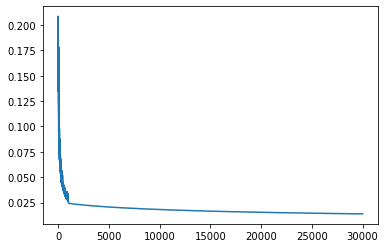

In [1276]:
for l in loss:
    plt.plot(l, label=l)
#plt.legend()


In [380]:
np.min(X_data)

0.0

In [261]:
for r in results7:
    print(r)

h = 14, train acc = 35.729048603240216 test acc = 35.88
h = 20, train acc = 45.34302286819121 test acc = 44.42
h = 24, train acc = 59.61730782052137 test acc = 59.64
h = 26, train acc = 40.14934328955263 test acc = 41.22


In [114]:
for r in results6:
    print(r)

h = 10, train acc = 22.228148543236216 test acc = 22.02
h = 12, train acc = 26.921794786319087 test acc = 26.86
h = 14, train acc = 44.36962464164277 test acc = 44.3
h = 16, train acc = 42.49616641109407 test acc = 42.4
h = 18, train acc = 34.5089672644843 test acc = 33.879999999999995
h = 20, train acc = 43.03620241349424 test acc = 41.88
h = 22, train acc = 38.43589572638176 test acc = 39.14
h = 24, train acc = 43.35622374824988 test acc = 44.440000000000005
h = 26, train acc = 42.19614640976065 test acc = 42.22


In [112]:
train_pred_wide = mlp.predict(X_train)
test_pred_wide = mlp.predict(X_test)
train_pred = np.argmax(train_pred_wide, axis=1)
test_pred = np.argmax(test_pred_wide, axis=1)
print("train acc", (train_pred == y_train).sum()/y_train.shape[0] * 100)
print("test acc", ((test_pred == y_test).sum()/y_test.shape[0]) * 100)

train acc 42.729515301020065
test acc 42.46


In [1203]:
results = []
for i in range(10, 27):
    mlp = MLP(X_train.shape[1], y_train_wide.shape[1],
          hidden_units=i,
          epochs=2000,
          learning_rate=0.001, loss='cross', 
           first_activation = 'sig', second_activation='softmax')
    mlp.fit(X_train, y_train_wide)
    results.append(mlp.loss)

KeyboardInterrupt: 

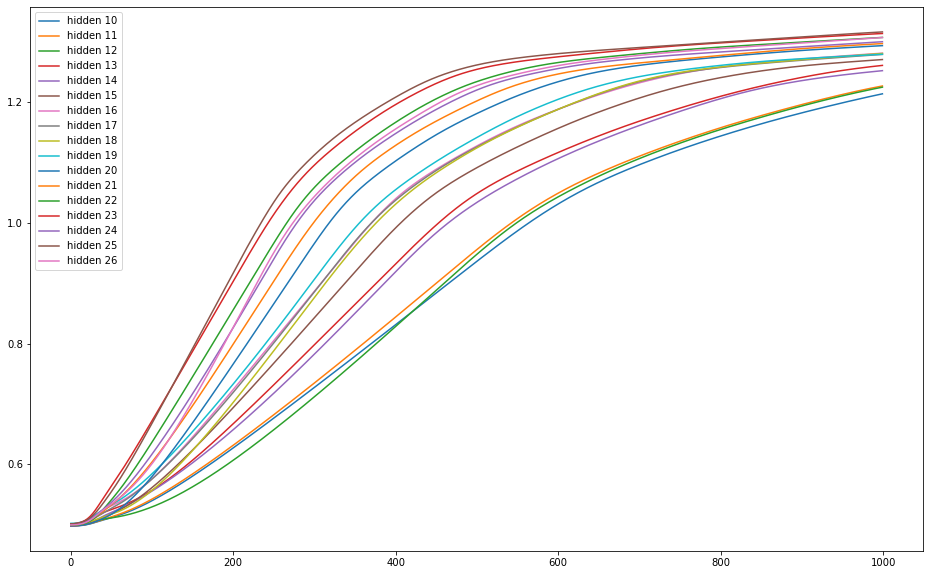

In [254]:
plt.figure(figsize=(16,10))
for i, r in enumerate(results):
    plt.plot(r, label="hidden {}".format(i+10))
    plt.legend()

In [ ]:
lr = [1, .5, .01, .05, 0.005, 0.001, 0.0005, 0.0001]
results2 = []
for l in lr:
    mlp = MLP(X_train.shape[1], y_train_wide.shape[1],
            hidden_units=18,
            epochs=1000,
            learning_rate=l, loss='log', 
            first_activation = 'sig', second_activation='softmax')
    mlp.fit(X_train, y_train_wide)
    results2.append(mlp.loss)

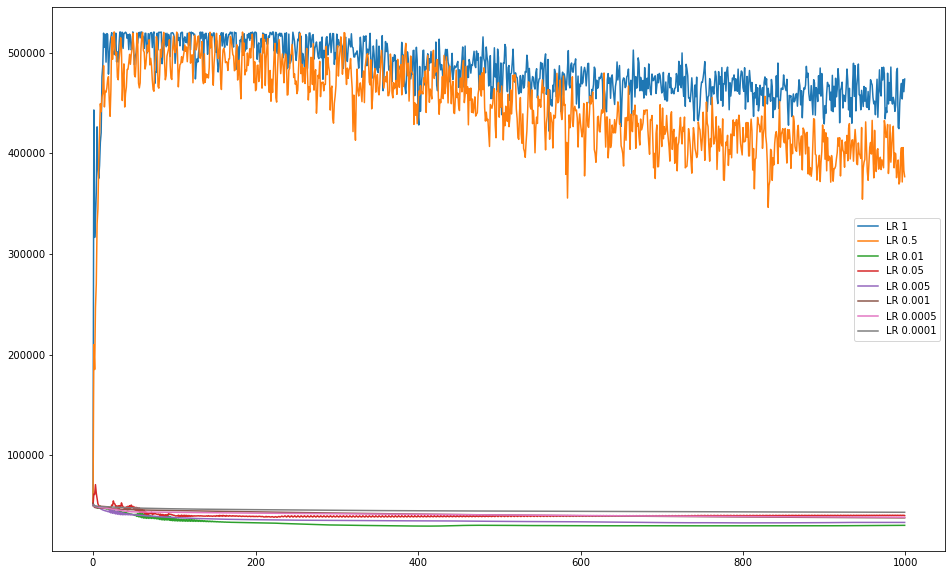

In [61]:
plt.figure(figsize=(16,10))
for i, r in enumerate(results2):
    plt.plot(r, label="LR {}".format(lr[i]))
    plt.legend()

In [66]:
hidden = [14, 18, 24]
results3 = []
for h in hidden:
    mlp = MLP(X_train.shape[1], y_train_wide.shape[1],
            hidden_units=h,
            epochs=10000,
            learning_rate=0.01, loss='log', 
            first_activation = 'sig', second_activation='softmax')
    mlp.fit(X_train, y_train_wide)
    results3.append(mlp.loss)

Epoch 1 Loss is 50265.57027947455
Epoch 2 Loss is 50011.14531879014
Epoch 3 Loss is 49600.12817227618
Epoch 4 Loss is 49525.53058779028
Epoch 5 Loss is 48794.75394529666
Epoch 6 Loss is 48709.055453656874
Epoch 7 Loss is 48310.62517362776
Epoch 8 Loss is 48183.37295490426
Epoch 9 Loss is 48087.28655726765
Epoch 10 Loss is 47830.14976173108
Epoch 11 Loss is 47648.507269332
Epoch 12 Loss is 47336.54952117171
Epoch 13 Loss is 47092.86726228369
Epoch 14 Loss is 46829.229568381284
Epoch 15 Loss is 46622.54023920116
Epoch 16 Loss is 46411.928569094925
Epoch 17 Loss is 46239.71604153704
Epoch 18 Loss is 46057.69498134634
Epoch 19 Loss is 45894.6605273526
Epoch 20 Loss is 45729.43368311716
Epoch 21 Loss is 45574.69307289101
Epoch 22 Loss is 45410.631491540604
Epoch 23 Loss is 45243.29667788023
Epoch 24 Loss is 45079.64740368981
Epoch 25 Loss is 44907.00733991059
Epoch 26 Loss is 44743.8040240482
Epoch 27 Loss is 44551.65634596459
Epoch 28 Loss is 44405.01428177013
Epoch 29 Loss is 44194.153905

<ipython-input-2-cce50564c602>:45: RuntimeWarning: overflow encountered in exp
  sig = (1 / (1 + np.exp(-x)))


Epoch 32 Loss is 43808.123033652824
Epoch 33 Loss is 43467.18481635641
Epoch 34 Loss is 43594.77540523191
Epoch 35 Loss is 43090.85107254229
Epoch 36 Loss is 43431.54082821971
Epoch 37 Loss is 42735.96017151719
Epoch 38 Loss is 43208.46837098723
Epoch 39 Loss is 42445.60159937998
Epoch 40 Loss is 42875.94075883574
Epoch 41 Loss is 42239.24874150347
Epoch 42 Loss is 42533.186063399386
Epoch 43 Loss is 42017.869879993195
Epoch 44 Loss is 42131.82640594352
Epoch 45 Loss is 41834.15416335731
Epoch 46 Loss is 41792.751938662776
Epoch 47 Loss is 41642.99425486669
Epoch 48 Loss is 41472.16042180313
Epoch 49 Loss is 41433.91040257925
Epoch 50 Loss is 41174.82965500753
Epoch 51 Loss is 41191.84742031498
Epoch 52 Loss is 40938.10535513014
Epoch 53 Loss is 40932.21408036333
Epoch 54 Loss is 40711.086401328306
Epoch 55 Loss is 40672.99924211241
Epoch 56 Loss is 40503.780016470664
Epoch 57 Loss is 40454.5730186407
Epoch 58 Loss is 40288.59247372386
Epoch 59 Loss is 40263.12451005834
Epoch 60 Loss i

Epoch 271 Loss is 33169.87805195624
Epoch 272 Loss is 33143.24644108185
Epoch 273 Loss is 33104.41788691435
Epoch 274 Loss is 33062.390953621514
Epoch 275 Loss is 33025.96019713706
Epoch 276 Loss is 32993.18132543035
Epoch 277 Loss is 32955.41075036967
Epoch 278 Loss is 32924.43059320996
Epoch 279 Loss is 32885.5359778988
Epoch 280 Loss is 32864.102323081446
Epoch 281 Loss is 32846.41013505963
Epoch 282 Loss is 32824.15399149901
Epoch 283 Loss is 32803.5140740129
Epoch 284 Loss is 32786.547403861565
Epoch 285 Loss is 32760.446169895164
Epoch 286 Loss is 32703.320947937984
Epoch 287 Loss is 32677.106935981963
Epoch 288 Loss is 32628.331869269678
Epoch 289 Loss is 32603.36535753491
Epoch 290 Loss is 32573.70026293487
Epoch 291 Loss is 32555.017193993106
Epoch 292 Loss is 32522.110476920352
Epoch 293 Loss is 32497.150011272697
Epoch 294 Loss is 32474.627615957466
Epoch 295 Loss is 32446.995294427197
Epoch 296 Loss is 32428.397263259125
Epoch 297 Loss is 32397.190627213124
Epoch 298 Loss i

Epoch 499 Loss is 30298.11458154085
Epoch 500 Loss is 30293.02255312428
Epoch 501 Loss is 30286.21401427071
Epoch 502 Loss is 30284.688513424284
Epoch 503 Loss is 30282.34255220718
Epoch 504 Loss is 30287.327522667063
Epoch 505 Loss is 30291.681451724504
Epoch 506 Loss is 30288.521898463492
Epoch 507 Loss is 30287.875968319437
Epoch 508 Loss is 30284.157140697975
Epoch 509 Loss is 30268.38780672365
Epoch 510 Loss is 30260.593880892728
Epoch 511 Loss is 30254.805136339157
Epoch 512 Loss is 30254.90157218334
Epoch 513 Loss is 30254.65700828336
Epoch 514 Loss is 30247.660112993362
Epoch 515 Loss is 30243.53974008064
Epoch 516 Loss is 30237.132725188527
Epoch 517 Loss is 30232.778956436592
Epoch 518 Loss is 30234.162805019183
Epoch 519 Loss is 30236.539259751906
Epoch 520 Loss is 30231.309427151828
Epoch 521 Loss is 30220.886498281314
Epoch 522 Loss is 30215.864152547438
Epoch 523 Loss is 30214.969468255047
Epoch 524 Loss is 30209.39827804797
Epoch 525 Loss is 30196.865810629646
Epoch 526 

Epoch 732 Loss is 30849.29816647321
Epoch 733 Loss is 30850.01988200887
Epoch 734 Loss is 30848.17931566704
Epoch 735 Loss is 30843.860773014698
Epoch 736 Loss is 30842.458579447975
Epoch 737 Loss is 30838.322616418565
Epoch 738 Loss is 30828.596590178233
Epoch 739 Loss is 30829.42793267899
Epoch 740 Loss is 30838.996645935844
Epoch 741 Loss is 30846.92711233059
Epoch 742 Loss is 30855.654922935908
Epoch 743 Loss is 30868.77752295542
Epoch 744 Loss is 30876.85556439059
Epoch 745 Loss is 30865.204308352997
Epoch 746 Loss is 30870.41457225265
Epoch 747 Loss is 30867.578473241723
Epoch 748 Loss is 30871.797664213846
Epoch 749 Loss is 30874.308912783214
Epoch 750 Loss is 30879.074687325712
Epoch 751 Loss is 30886.446770399387
Epoch 752 Loss is 30897.884576561857
Epoch 753 Loss is 30902.841309608448
Epoch 754 Loss is 30903.003464284062
Epoch 755 Loss is 30908.5391486652
Epoch 756 Loss is 30921.065077310708
Epoch 757 Loss is 30932.85132243735
Epoch 758 Loss is 30932.4859523318
Epoch 759 Loss

Epoch 960 Loss is 31939.553788572404
Epoch 961 Loss is 31941.700219695602
Epoch 962 Loss is 31946.695692011883
Epoch 963 Loss is 31940.4872381585
Epoch 964 Loss is 31937.318120189306
Epoch 965 Loss is 31937.7550869326
Epoch 966 Loss is 31946.59718566263
Epoch 967 Loss is 31929.35513425402
Epoch 968 Loss is 31922.390931006317
Epoch 969 Loss is 31936.265078622277
Epoch 970 Loss is 31938.763185939966
Epoch 971 Loss is 31928.141635735097
Epoch 972 Loss is 31924.028110771604
Epoch 973 Loss is 31930.323120500463
Epoch 974 Loss is 31935.660178434402
Epoch 975 Loss is 31957.209272393848
Epoch 976 Loss is 31982.096796018213
Epoch 977 Loss is 31993.960091643105
Epoch 978 Loss is 32012.746797438733
Epoch 979 Loss is 32012.680147521925
Epoch 980 Loss is 32025.52126332356
Epoch 981 Loss is 32024.796693116634
Epoch 982 Loss is 32020.302422401128
Epoch 983 Loss is 32012.477891619146
Epoch 984 Loss is 32015.929597731836
Epoch 985 Loss is 32019.392885380494
Epoch 986 Loss is 32020.82068108292
Epoch 987

Epoch 1190 Loss is 32049.9650806278
Epoch 1191 Loss is 32040.807769291703
Epoch 1192 Loss is 32039.44965006953
Epoch 1193 Loss is 32029.95066013087
Epoch 1194 Loss is 32020.981355439824
Epoch 1195 Loss is 32020.752872967656
Epoch 1196 Loss is 32020.207001316357
Epoch 1197 Loss is 31998.37927420677
Epoch 1198 Loss is 31996.83743506149
Epoch 1199 Loss is 31989.417308456756
Epoch 1200 Loss is 31990.93242576558
Epoch 1201 Loss is 31985.415538179215
Epoch 1202 Loss is 31981.44039995295
Epoch 1203 Loss is 31976.379076606663
Epoch 1204 Loss is 31971.34464710576
Epoch 1205 Loss is 31964.350025789263
Epoch 1206 Loss is 31956.106825423987
Epoch 1207 Loss is 31953.824037748513
Epoch 1208 Loss is 31941.809978338042
Epoch 1209 Loss is 31938.509853176696
Epoch 1210 Loss is 31924.5794050845
Epoch 1211 Loss is 31915.56942637771
Epoch 1212 Loss is 31910.94287189333
Epoch 1213 Loss is 31908.85456530196
Epoch 1214 Loss is 31911.40855915099
Epoch 1215 Loss is 31907.761613807543
Epoch 1216 Loss is 31899.24

Epoch 1411 Loss is 31806.964407581472
Epoch 1412 Loss is 31797.721770473738
Epoch 1413 Loss is 31795.992652096073
Epoch 1414 Loss is 31797.0734467149
Epoch 1415 Loss is 31800.812821768875
Epoch 1416 Loss is 31793.75132780458
Epoch 1417 Loss is 31795.980605059343
Epoch 1418 Loss is 31805.64877336168
Epoch 1419 Loss is 31808.91153513748
Epoch 1420 Loss is 31807.79813842799
Epoch 1421 Loss is 31804.440195900654
Epoch 1422 Loss is 31810.525563353254
Epoch 1423 Loss is 31815.358897621943
Epoch 1424 Loss is 31816.408769309746
Epoch 1425 Loss is 31812.776238220806
Epoch 1426 Loss is 31818.757008146706
Epoch 1427 Loss is 31817.475059476816
Epoch 1428 Loss is 31818.16165629248
Epoch 1429 Loss is 31812.129806569006
Epoch 1430 Loss is 31810.66045562944
Epoch 1431 Loss is 31813.263160452603
Epoch 1432 Loss is 31809.904241811226
Epoch 1433 Loss is 31804.25389474238
Epoch 1434 Loss is 31806.466116561583
Epoch 1435 Loss is 31805.7661470808
Epoch 1436 Loss is 31810.42548008684
Epoch 1437 Loss is 31803

Epoch 1640 Loss is 31441.130467787105
Epoch 1641 Loss is 31439.110665738324
Epoch 1642 Loss is 31438.36859050048
Epoch 1643 Loss is 31437.990007496668
Epoch 1644 Loss is 31429.972645150294
Epoch 1645 Loss is 31428.193424271165
Epoch 1646 Loss is 31422.901979491362
Epoch 1647 Loss is 31418.004114195584
Epoch 1648 Loss is 31412.270148979645
Epoch 1649 Loss is 31411.788931836727
Epoch 1650 Loss is 31413.01966627997
Epoch 1651 Loss is 31405.07713290594
Epoch 1652 Loss is 31398.684626433474
Epoch 1653 Loss is 31400.64673171668
Epoch 1654 Loss is 31403.728501934977
Epoch 1655 Loss is 31418.276843544023
Epoch 1656 Loss is 31420.07607808397
Epoch 1657 Loss is 31417.174469796515
Epoch 1658 Loss is 31418.640194572905
Epoch 1659 Loss is 31420.748072842463
Epoch 1660 Loss is 31420.13361688407
Epoch 1661 Loss is 31423.56488207055
Epoch 1662 Loss is 31419.021475302212
Epoch 1663 Loss is 31418.176876695077
Epoch 1664 Loss is 31409.468633747612
Epoch 1665 Loss is 31413.41221406102
Epoch 1666 Loss is 3

Epoch 1870 Loss is 31230.47296856494
Epoch 1871 Loss is 31229.304760835374
Epoch 1872 Loss is 31227.55781227929
Epoch 1873 Loss is 31238.506996693704
Epoch 1874 Loss is 31236.069254958227
Epoch 1875 Loss is 31238.021297041774
Epoch 1876 Loss is 31237.633406726636
Epoch 1877 Loss is 31240.13639162358
Epoch 1878 Loss is 31241.65105282603
Epoch 1879 Loss is 31242.77871177596
Epoch 1880 Loss is 31251.509526350528
Epoch 1881 Loss is 31254.183507807436
Epoch 1882 Loss is 31257.87391051667
Epoch 1883 Loss is 31258.006637932325
Epoch 1884 Loss is 31250.83161281484
Epoch 1885 Loss is 31247.35802970638
Epoch 1886 Loss is 31246.063608753975
Epoch 1887 Loss is 31242.77914960609
Epoch 1888 Loss is 31241.712522196176
Epoch 1889 Loss is 31244.363295093342
Epoch 1890 Loss is 31247.494190749443
Epoch 1891 Loss is 31245.12031748507
Epoch 1892 Loss is 31237.698337136284
Epoch 1893 Loss is 31239.528617516236
Epoch 1894 Loss is 31241.972455830997
Epoch 1895 Loss is 31237.261226761555
Epoch 1896 Loss is 312

Epoch 2091 Loss is 31692.10948670388
Epoch 2092 Loss is 31691.629804901055
Epoch 2093 Loss is 31692.13177964268
Epoch 2094 Loss is 31687.53687525698
Epoch 2095 Loss is 31690.249601756208
Epoch 2096 Loss is 31696.18494371059
Epoch 2097 Loss is 31699.567244038462
Epoch 2098 Loss is 31704.943778839144
Epoch 2099 Loss is 31713.068747461268
Epoch 2100 Loss is 31714.64360728861
Epoch 2101 Loss is 31710.285755714245
Epoch 2102 Loss is 31710.498228045566
Epoch 2103 Loss is 31719.63566209833
Epoch 2104 Loss is 31735.270008126517
Epoch 2105 Loss is 31728.17178708525
Epoch 2106 Loss is 31728.07619579577
Epoch 2107 Loss is 31728.018478981954
Epoch 2108 Loss is 31733.740910968172
Epoch 2109 Loss is 31739.309370092524
Epoch 2110 Loss is 31741.562432600782
Epoch 2111 Loss is 31743.46912341953
Epoch 2112 Loss is 31744.819497884564
Epoch 2113 Loss is 31745.720355130965
Epoch 2114 Loss is 31734.184266398493
Epoch 2115 Loss is 31731.82257687716
Epoch 2116 Loss is 31734.17644616061
Epoch 2117 Loss is 3173

Epoch 2314 Loss is 32228.497498052304
Epoch 2315 Loss is 32232.08065038885
Epoch 2316 Loss is 32230.29771365883
Epoch 2317 Loss is 32232.6166099158
Epoch 2318 Loss is 32232.98971210739
Epoch 2319 Loss is 32232.64985295164
Epoch 2320 Loss is 32236.81181868238
Epoch 2321 Loss is 32236.79845295075
Epoch 2322 Loss is 32240.57293667561
Epoch 2323 Loss is 32242.358996007537
Epoch 2324 Loss is 32245.395182138152
Epoch 2325 Loss is 32256.570819016546
Epoch 2326 Loss is 32266.212661191024
Epoch 2327 Loss is 32272.180519774047
Epoch 2328 Loss is 32279.18906791868
Epoch 2329 Loss is 32284.86615366097
Epoch 2330 Loss is 32297.70608864265
Epoch 2331 Loss is 32294.554518221466
Epoch 2332 Loss is 32299.31672253929
Epoch 2333 Loss is 32297.310090296774
Epoch 2334 Loss is 32302.357150499087
Epoch 2335 Loss is 32305.216133593476
Epoch 2336 Loss is 32302.900086021193
Epoch 2337 Loss is 32305.689464065985
Epoch 2338 Loss is 32307.96586208597
Epoch 2339 Loss is 32307.101161220493
Epoch 2340 Loss is 32303.2

Epoch 2533 Loss is 32624.61282472573
Epoch 2534 Loss is 32627.835311957297
Epoch 2535 Loss is 32626.622754935535
Epoch 2536 Loss is 32631.012598218316
Epoch 2537 Loss is 32645.97460763994
Epoch 2538 Loss is 32655.790766762395
Epoch 2539 Loss is 32664.24339958909
Epoch 2540 Loss is 32661.85617960887
Epoch 2541 Loss is 32662.5777339923
Epoch 2542 Loss is 32664.314054570008
Epoch 2543 Loss is 32671.056387429886
Epoch 2544 Loss is 32674.14846142151
Epoch 2545 Loss is 32674.679975138355
Epoch 2546 Loss is 32679.826446670453
Epoch 2547 Loss is 32678.84093629227
Epoch 2548 Loss is 32681.323363507454
Epoch 2549 Loss is 32680.915070873813
Epoch 2550 Loss is 32673.807224082902
Epoch 2551 Loss is 32673.40467013514
Epoch 2552 Loss is 32669.57170726924
Epoch 2553 Loss is 32663.515551019398
Epoch 2554 Loss is 32656.307462555633
Epoch 2555 Loss is 32655.63744729964
Epoch 2556 Loss is 32658.280967983657
Epoch 2557 Loss is 32662.630274874202
Epoch 2558 Loss is 32666.013548592302
Epoch 2559 Loss is 3266

Epoch 2759 Loss is 32875.94060852503
Epoch 2760 Loss is 32876.75631147257
Epoch 2761 Loss is 32879.805614521516
Epoch 2762 Loss is 32878.05917786564
Epoch 2763 Loss is 32871.25663805511
Epoch 2764 Loss is 32875.094897137395
Epoch 2765 Loss is 32877.33344050191
Epoch 2766 Loss is 32883.3606182918
Epoch 2767 Loss is 32893.23972309339
Epoch 2768 Loss is 32894.374154007186
Epoch 2769 Loss is 32898.972976519864
Epoch 2770 Loss is 32897.538189619474
Epoch 2771 Loss is 32898.17009950962
Epoch 2772 Loss is 32899.47882446825
Epoch 2773 Loss is 32904.11237692631
Epoch 2774 Loss is 32902.67133164524
Epoch 2775 Loss is 32903.15988502034
Epoch 2776 Loss is 32904.07728655655
Epoch 2777 Loss is 32904.858908914044
Epoch 2778 Loss is 32915.25458643738
Epoch 2779 Loss is 32913.991769216474
Epoch 2780 Loss is 32915.41017635065
Epoch 2781 Loss is 32912.843406882006
Epoch 2782 Loss is 32906.72438751121
Epoch 2783 Loss is 32907.1956059411
Epoch 2784 Loss is 32905.67850618536
Epoch 2785 Loss is 32903.3230673

Epoch 2986 Loss is 32951.05302610355
Epoch 2987 Loss is 32952.79185086021
Epoch 2988 Loss is 32957.496708508246
Epoch 2989 Loss is 32957.33196651297
Epoch 2990 Loss is 32957.268884155725
Epoch 2991 Loss is 32959.85741748311
Epoch 2992 Loss is 32960.236722118585
Epoch 2993 Loss is 32958.24756684998
Epoch 2994 Loss is 32958.063802718825
Epoch 2995 Loss is 32953.824331211814
Epoch 2996 Loss is 32952.83021410019
Epoch 2997 Loss is 32957.05204489687
Epoch 2998 Loss is 32957.7389406242
Epoch 2999 Loss is 32954.012715563076
Epoch 3000 Loss is 32954.313415663186
Epoch 3001 Loss is 32956.195475136876
Epoch 3002 Loss is 32955.69310219019
Epoch 3003 Loss is 32946.81569079117
Epoch 3004 Loss is 32944.37609215267
Epoch 3005 Loss is 32946.85693583787
Epoch 3006 Loss is 32943.58678529547
Epoch 3007 Loss is 32946.82340188914
Epoch 3008 Loss is 32948.923022486044
Epoch 3009 Loss is 32949.52696776926
Epoch 3010 Loss is 32949.67087491734
Epoch 3011 Loss is 32950.9535401386
Epoch 3012 Loss is 32948.163071

Epoch 3215 Loss is 33105.38334111544
Epoch 3216 Loss is 33109.52334558745
Epoch 3217 Loss is 33109.63376412559
Epoch 3218 Loss is 33108.816459254806
Epoch 3219 Loss is 33109.75663479722
Epoch 3220 Loss is 33107.70239548784
Epoch 3221 Loss is 33104.96733079647
Epoch 3222 Loss is 33109.11255040477
Epoch 3223 Loss is 33119.29503024308
Epoch 3224 Loss is 33121.531048964476
Epoch 3225 Loss is 33122.094959554925
Epoch 3226 Loss is 33127.596782611676
Epoch 3227 Loss is 33128.47819953119
Epoch 3228 Loss is 33131.57591482554
Epoch 3229 Loss is 33133.18837725971
Epoch 3230 Loss is 33131.45465888727
Epoch 3231 Loss is 33129.38713482083
Epoch 3232 Loss is 33129.7101178084
Epoch 3233 Loss is 33132.99429001154
Epoch 3234 Loss is 33135.77074865198
Epoch 3235 Loss is 33133.61749810807
Epoch 3236 Loss is 33132.92399271525
Epoch 3237 Loss is 33136.062515187645
Epoch 3238 Loss is 33133.731597969214
Epoch 3239 Loss is 33135.49306063541
Epoch 3240 Loss is 33132.641686323885
Epoch 3241 Loss is 33134.5353896

Epoch 3445 Loss is 33241.101491021494
Epoch 3446 Loss is 33240.10499874468
Epoch 3447 Loss is 33235.23784347532
Epoch 3448 Loss is 33232.91491416187
Epoch 3449 Loss is 33229.636453794286
Epoch 3450 Loss is 33229.54756003641
Epoch 3451 Loss is 33229.81236270272
Epoch 3452 Loss is 33233.590228680274
Epoch 3453 Loss is 33234.79471800584
Epoch 3454 Loss is 33234.954638288524
Epoch 3455 Loss is 33234.12442138071
Epoch 3456 Loss is 33232.75130429385
Epoch 3457 Loss is 33230.642314265286
Epoch 3458 Loss is 33230.14464469008
Epoch 3459 Loss is 33231.167235390174
Epoch 3460 Loss is 33232.57796908949
Epoch 3461 Loss is 33231.858586555165
Epoch 3462 Loss is 33232.241252768574
Epoch 3463 Loss is 33230.9368747424
Epoch 3464 Loss is 33230.78363508078
Epoch 3465 Loss is 33226.208962785524
Epoch 3466 Loss is 33225.98229619941
Epoch 3467 Loss is 33226.370241967066
Epoch 3468 Loss is 33224.56186274184
Epoch 3469 Loss is 33224.31694605961
Epoch 3470 Loss is 33225.547647414875
Epoch 3471 Loss is 33228.232

Epoch 3675 Loss is 33357.94209876575
Epoch 3676 Loss is 33356.35205285213
Epoch 3677 Loss is 33356.739638697545
Epoch 3678 Loss is 33357.47386654861
Epoch 3679 Loss is 33357.39486590307
Epoch 3680 Loss is 33356.98313427604
Epoch 3681 Loss is 33357.39402105672
Epoch 3682 Loss is 33358.31021917944
Epoch 3683 Loss is 33363.303509830155
Epoch 3684 Loss is 33363.51860037604
Epoch 3685 Loss is 33366.23222078018
Epoch 3686 Loss is 33365.6632892336
Epoch 3687 Loss is 33362.49503196311
Epoch 3688 Loss is 33365.594015385126
Epoch 3689 Loss is 33371.41276641666
Epoch 3690 Loss is 33371.50863201457
Epoch 3691 Loss is 33370.31146851439
Epoch 3692 Loss is 33370.34878184608
Epoch 3693 Loss is 33368.74680841894
Epoch 3694 Loss is 33366.583295133074
Epoch 3695 Loss is 33365.13375572653
Epoch 3696 Loss is 33364.466777507216
Epoch 3697 Loss is 33366.05439564154
Epoch 3698 Loss is 33364.251657431974
Epoch 3699 Loss is 33361.84008235641
Epoch 3700 Loss is 33358.50721351406
Epoch 3701 Loss is 33360.51700932

Epoch 3902 Loss is 33437.09641408687
Epoch 3903 Loss is 33437.40378921041
Epoch 3904 Loss is 33436.69406935728
Epoch 3905 Loss is 33435.24385764433
Epoch 3906 Loss is 33434.55231781948
Epoch 3907 Loss is 33433.4456326594
Epoch 3908 Loss is 33434.46539849284
Epoch 3909 Loss is 33436.109524469095
Epoch 3910 Loss is 33437.02437231846
Epoch 3911 Loss is 33439.31127820356
Epoch 3912 Loss is 33442.39471623593
Epoch 3913 Loss is 33444.01864871279
Epoch 3914 Loss is 33444.882963860044
Epoch 3915 Loss is 33441.46192524017
Epoch 3916 Loss is 33440.514336575834
Epoch 3917 Loss is 33443.622934597995
Epoch 3918 Loss is 33446.88125708552
Epoch 3919 Loss is 33447.51636841169
Epoch 3920 Loss is 33446.557877736865
Epoch 3921 Loss is 33449.29978082316
Epoch 3922 Loss is 33449.868085617636
Epoch 3923 Loss is 33450.23976221404
Epoch 3924 Loss is 33453.722237898524
Epoch 3925 Loss is 33455.19911596619
Epoch 3926 Loss is 33451.29514190889
Epoch 3927 Loss is 33449.35896268701
Epoch 3928 Loss is 33449.6285571

Epoch 4128 Loss is 33481.618772883834
Epoch 4129 Loss is 33480.3990742913
Epoch 4130 Loss is 33483.00736215493
Epoch 4131 Loss is 33484.925036105335
Epoch 4132 Loss is 33489.59755680672
Epoch 4133 Loss is 33493.2546158106
Epoch 4134 Loss is 33495.52409215684
Epoch 4135 Loss is 33494.65497497698
Epoch 4136 Loss is 33494.239232007305
Epoch 4137 Loss is 33492.52051945697
Epoch 4138 Loss is 33494.25716377552
Epoch 4139 Loss is 33496.019432199064
Epoch 4140 Loss is 33497.27032966032
Epoch 4141 Loss is 33499.95262593081
Epoch 4142 Loss is 33500.135629246535
Epoch 4143 Loss is 33499.44865706633
Epoch 4144 Loss is 33499.36245015453
Epoch 4145 Loss is 33498.09596345716
Epoch 4146 Loss is 33497.27635753805
Epoch 4147 Loss is 33498.57835510267
Epoch 4148 Loss is 33498.60571266563
Epoch 4149 Loss is 33498.87940199527
Epoch 4150 Loss is 33502.99340961621
Epoch 4151 Loss is 33503.2579505964
Epoch 4152 Loss is 33504.205955879544
Epoch 4153 Loss is 33502.96917751486
Epoch 4154 Loss is 33503.9410485845

Epoch 4349 Loss is 33556.68353510947
Epoch 4350 Loss is 33558.90405564363
Epoch 4351 Loss is 33559.91213118458
Epoch 4352 Loss is 33560.12226797538
Epoch 4353 Loss is 33561.454373946624
Epoch 4354 Loss is 33563.21370130049
Epoch 4355 Loss is 33566.665478985844
Epoch 4356 Loss is 33566.70375416741
Epoch 4357 Loss is 33570.28796786824
Epoch 4358 Loss is 33572.1243769724
Epoch 4359 Loss is 33577.15242617344
Epoch 4360 Loss is 33581.79938346449
Epoch 4361 Loss is 33584.41739834133
Epoch 4362 Loss is 33585.95945811216
Epoch 4363 Loss is 33586.727865107256
Epoch 4364 Loss is 33589.79111719332
Epoch 4365 Loss is 33589.756079031664
Epoch 4366 Loss is 33588.97664062851
Epoch 4367 Loss is 33589.964657525896
Epoch 4368 Loss is 33586.596868810804
Epoch 4369 Loss is 33585.23314153035
Epoch 4370 Loss is 33581.56653517529
Epoch 4371 Loss is 33581.43758272555
Epoch 4372 Loss is 33579.61026480287
Epoch 4373 Loss is 33578.72222762003
Epoch 4374 Loss is 33577.380206486974
Epoch 4375 Loss is 33577.4933724

Epoch 4579 Loss is 33512.94309363729
Epoch 4580 Loss is 33511.62376877368
Epoch 4581 Loss is 33511.02499559065
Epoch 4582 Loss is 33509.72234131797
Epoch 4583 Loss is 33511.651854996766
Epoch 4584 Loss is 33509.79997664528
Epoch 4585 Loss is 33506.863537444886
Epoch 4586 Loss is 33509.90452741389
Epoch 4587 Loss is 33510.859435943945
Epoch 4588 Loss is 33509.83115731115
Epoch 4589 Loss is 33508.104842758854
Epoch 4590 Loss is 33505.70659692141
Epoch 4591 Loss is 33505.829804233166
Epoch 4592 Loss is 33506.40992995896
Epoch 4593 Loss is 33506.04694248122
Epoch 4594 Loss is 33506.07063245217
Epoch 4595 Loss is 33508.52764940205
Epoch 4596 Loss is 33505.48822256122
Epoch 4597 Loss is 33505.70633975034
Epoch 4598 Loss is 33503.8236168623
Epoch 4599 Loss is 33503.864980285114
Epoch 4600 Loss is 33502.501393196566
Epoch 4601 Loss is 33500.102261744345
Epoch 4602 Loss is 33499.51790931143
Epoch 4603 Loss is 33496.949204306664
Epoch 4604 Loss is 33495.76170039793
Epoch 4605 Loss is 33497.53706

Epoch 4805 Loss is 33482.6831393318
Epoch 4806 Loss is 33481.56227273786
Epoch 4807 Loss is 33481.59918145126
Epoch 4808 Loss is 33484.15242652014
Epoch 4809 Loss is 33485.30989917584
Epoch 4810 Loss is 33488.724882580515
Epoch 4811 Loss is 33489.11861381224
Epoch 4812 Loss is 33488.892631841256
Epoch 4813 Loss is 33487.16923969033
Epoch 4814 Loss is 33489.1375294349
Epoch 4815 Loss is 33489.520531550435
Epoch 4816 Loss is 33488.556477999395
Epoch 4817 Loss is 33489.566926916996
Epoch 4818 Loss is 33493.20599232908
Epoch 4819 Loss is 33494.70054567046
Epoch 4820 Loss is 33493.83760846804
Epoch 4821 Loss is 33492.48398697958
Epoch 4822 Loss is 33489.2102290766
Epoch 4823 Loss is 33489.55026731061
Epoch 4824 Loss is 33491.07258303672
Epoch 4825 Loss is 33491.4199379163
Epoch 4826 Loss is 33491.62092253588
Epoch 4827 Loss is 33492.25608306276
Epoch 4828 Loss is 33493.903602895305
Epoch 4829 Loss is 33495.166113721505
Epoch 4830 Loss is 33494.81459642407
Epoch 4831 Loss is 33494.2598302434

Epoch 5029 Loss is 33493.697746488055
Epoch 5030 Loss is 33490.6238695365
Epoch 5031 Loss is 33489.04555567962
Epoch 5032 Loss is 33488.71083264278
Epoch 5033 Loss is 33486.06129815394
Epoch 5034 Loss is 33485.87886747655
Epoch 5035 Loss is 33486.04079399705
Epoch 5036 Loss is 33483.846331140296
Epoch 5037 Loss is 33483.510613695886
Epoch 5038 Loss is 33484.72161891955
Epoch 5039 Loss is 33484.79335183737
Epoch 5040 Loss is 33483.1707542967
Epoch 5041 Loss is 33482.532362579266
Epoch 5042 Loss is 33479.84422960927
Epoch 5043 Loss is 33479.515803513415
Epoch 5044 Loss is 33479.36326826071
Epoch 5045 Loss is 33478.052294897236
Epoch 5046 Loss is 33479.100103503195
Epoch 5047 Loss is 33482.311580390015
Epoch 5048 Loss is 33483.70248674503
Epoch 5049 Loss is 33482.97613837938
Epoch 5050 Loss is 33487.73618326333
Epoch 5051 Loss is 33487.46182604486
Epoch 5052 Loss is 33484.951782091266
Epoch 5053 Loss is 33485.46309140472
Epoch 5054 Loss is 33483.972288671655
Epoch 5055 Loss is 33482.99219

Epoch 5262 Loss is 33451.48126535463
Epoch 5263 Loss is 33450.45514666732
Epoch 5264 Loss is 33450.42435309789
Epoch 5265 Loss is 33449.71286159648
Epoch 5266 Loss is 33449.15787179681
Epoch 5267 Loss is 33448.82307146543
Epoch 5268 Loss is 33450.37097448324
Epoch 5269 Loss is 33449.02562864251
Epoch 5270 Loss is 33449.59073939923
Epoch 5271 Loss is 33452.35355045025
Epoch 5272 Loss is 33452.33331577904
Epoch 5273 Loss is 33454.522537134624
Epoch 5274 Loss is 33454.733873933226
Epoch 5275 Loss is 33457.507824344284
Epoch 5276 Loss is 33457.825088226244
Epoch 5277 Loss is 33456.43943078673
Epoch 5278 Loss is 33454.58316682525
Epoch 5279 Loss is 33451.76166628734
Epoch 5280 Loss is 33450.12714251148
Epoch 5281 Loss is 33449.87416860233
Epoch 5282 Loss is 33450.37440001674
Epoch 5283 Loss is 33450.53625490822
Epoch 5284 Loss is 33450.64028260705
Epoch 5285 Loss is 33450.608253532664
Epoch 5286 Loss is 33450.30691818841
Epoch 5287 Loss is 33450.47659797655
Epoch 5288 Loss is 33450.20154302

Epoch 5491 Loss is 33379.38392093703
Epoch 5492 Loss is 33380.790694732954
Epoch 5493 Loss is 33386.69015890443
Epoch 5494 Loss is 33388.042095413715
Epoch 5495 Loss is 33388.27582949085
Epoch 5496 Loss is 33389.579235987076
Epoch 5497 Loss is 33390.69897244491
Epoch 5498 Loss is 33390.764139684754
Epoch 5499 Loss is 33388.05524928655
Epoch 5500 Loss is 33386.788546658514
Epoch 5501 Loss is 33385.09823170452
Epoch 5502 Loss is 33383.539522087915
Epoch 5503 Loss is 33378.244883886786
Epoch 5504 Loss is 33377.20264843764
Epoch 5505 Loss is 33373.91710173509
Epoch 5506 Loss is 33374.68190204518
Epoch 5507 Loss is 33374.73331393551
Epoch 5508 Loss is 33372.73809137032
Epoch 5509 Loss is 33372.93383769092
Epoch 5510 Loss is 33374.616905414856
Epoch 5511 Loss is 33377.050946456984
Epoch 5512 Loss is 33377.15695050073
Epoch 5513 Loss is 33378.30454474983
Epoch 5514 Loss is 33378.78653055363
Epoch 5515 Loss is 33378.53139301445
Epoch 5516 Loss is 33377.38769933448
Epoch 5517 Loss is 33376.0356

Epoch 5718 Loss is 33315.385671728
Epoch 5719 Loss is 33315.20280006963
Epoch 5720 Loss is 33314.67671200936
Epoch 5721 Loss is 33315.00737380776
Epoch 5722 Loss is 33314.623425393074
Epoch 5723 Loss is 33313.93439355079
Epoch 5724 Loss is 33313.41239880606
Epoch 5725 Loss is 33314.37604837641
Epoch 5726 Loss is 33315.084732341034
Epoch 5727 Loss is 33313.16460321904
Epoch 5728 Loss is 33313.24155984662
Epoch 5729 Loss is 33313.23351799134
Epoch 5730 Loss is 33313.18482745815
Epoch 5731 Loss is 33313.59379009576
Epoch 5732 Loss is 33313.88857403311
Epoch 5733 Loss is 33310.08535585465
Epoch 5734 Loss is 33309.97272896919
Epoch 5735 Loss is 33309.97658714825
Epoch 5736 Loss is 33310.378238864294
Epoch 5737 Loss is 33313.61366325026
Epoch 5738 Loss is 33312.836337813984
Epoch 5739 Loss is 33311.99264000085
Epoch 5740 Loss is 33311.97233570909
Epoch 5741 Loss is 33311.200275199684
Epoch 5742 Loss is 33310.22058405608
Epoch 5743 Loss is 33309.07919150279
Epoch 5744 Loss is 33309.0244579837

Epoch 5940 Loss is 33282.66911764152
Epoch 5941 Loss is 33284.542023276284
Epoch 5942 Loss is 33284.581025885105
Epoch 5943 Loss is 33284.69115245809
Epoch 5944 Loss is 33284.92884963587
Epoch 5945 Loss is 33285.21360759273
Epoch 5946 Loss is 33285.37703031652
Epoch 5947 Loss is 33286.06123903009
Epoch 5948 Loss is 33287.33603118038
Epoch 5949 Loss is 33284.8711114257
Epoch 5950 Loss is 33281.31518494945
Epoch 5951 Loss is 33281.447163362805
Epoch 5952 Loss is 33281.61321106199
Epoch 5953 Loss is 33281.49994762573
Epoch 5954 Loss is 33279.921825387464
Epoch 5955 Loss is 33278.62683893854
Epoch 5956 Loss is 33279.16947318863
Epoch 5957 Loss is 33280.75230571923
Epoch 5958 Loss is 33280.75366737233
Epoch 5959 Loss is 33280.627505850505
Epoch 5960 Loss is 33279.88126007971
Epoch 5961 Loss is 33277.089199650734
Epoch 5962 Loss is 33270.928408781394
Epoch 5963 Loss is 33270.69470319815
Epoch 5964 Loss is 33268.71793961553
Epoch 5965 Loss is 33274.0820110916
Epoch 5966 Loss is 33276.38118494

Epoch 6165 Loss is 33322.36998209856
Epoch 6166 Loss is 33322.664602595825
Epoch 6167 Loss is 33320.80753047227
Epoch 6168 Loss is 33321.17240300948
Epoch 6169 Loss is 33322.26526653291
Epoch 6170 Loss is 33322.234819026904
Epoch 6171 Loss is 33321.775110954804
Epoch 6172 Loss is 33320.33190460658
Epoch 6173 Loss is 33320.914520255705
Epoch 6174 Loss is 33322.91707488994
Epoch 6175 Loss is 33322.412770494586
Epoch 6176 Loss is 33322.91360988311
Epoch 6177 Loss is 33324.41060605589
Epoch 6178 Loss is 33324.99818893591
Epoch 6179 Loss is 33328.243970172785
Epoch 6180 Loss is 33329.0928000673
Epoch 6181 Loss is 33329.45987432441
Epoch 6182 Loss is 33329.69541290765
Epoch 6183 Loss is 33330.07493392421
Epoch 6184 Loss is 33330.46225738023
Epoch 6185 Loss is 33331.920715560525
Epoch 6186 Loss is 33332.75746040814
Epoch 6187 Loss is 33332.99520962515
Epoch 6188 Loss is 33333.37867258007
Epoch 6189 Loss is 33333.471933838686
Epoch 6190 Loss is 33334.271065614725
Epoch 6191 Loss is 33334.79067

Epoch 6390 Loss is 33334.67852292465
Epoch 6391 Loss is 33334.53579307376
Epoch 6392 Loss is 33334.738599921126
Epoch 6393 Loss is 33336.80280451111
Epoch 6394 Loss is 33338.09567163307
Epoch 6395 Loss is 33338.503362621785
Epoch 6396 Loss is 33336.45939359702
Epoch 6397 Loss is 33335.925928800156
Epoch 6398 Loss is 33335.61208805473
Epoch 6399 Loss is 33335.54199957449
Epoch 6400 Loss is 33335.55560674342
Epoch 6401 Loss is 33335.61297899922
Epoch 6402 Loss is 33336.48243538939
Epoch 6403 Loss is 33336.43954582165
Epoch 6404 Loss is 33336.09054812071
Epoch 6405 Loss is 33335.62552129594
Epoch 6406 Loss is 33335.529744309
Epoch 6407 Loss is 33335.50012617148
Epoch 6408 Loss is 33335.31211250496
Epoch 6409 Loss is 33334.908398546584
Epoch 6410 Loss is 33334.031441470994
Epoch 6411 Loss is 33334.694274138514
Epoch 6412 Loss is 33334.552054996086
Epoch 6413 Loss is 33334.90526530643
Epoch 6414 Loss is 33334.86553453755
Epoch 6415 Loss is 33333.86679825934
Epoch 6416 Loss is 33333.52270341

Epoch 6618 Loss is 33350.73017295569
Epoch 6619 Loss is 33351.544439776684
Epoch 6620 Loss is 33350.35805147483
Epoch 6621 Loss is 33349.64107535809
Epoch 6622 Loss is 33347.340339971604
Epoch 6623 Loss is 33346.963934569656
Epoch 6624 Loss is 33347.2564090295
Epoch 6625 Loss is 33348.28532399667
Epoch 6626 Loss is 33347.86410143212
Epoch 6627 Loss is 33347.73445445211
Epoch 6628 Loss is 33350.09469993125
Epoch 6629 Loss is 33351.680351786665
Epoch 6630 Loss is 33352.303410576096
Epoch 6631 Loss is 33354.38382692156
Epoch 6632 Loss is 33355.467099993366
Epoch 6633 Loss is 33355.25578915434
Epoch 6634 Loss is 33354.57345167733
Epoch 6635 Loss is 33354.55824259193
Epoch 6636 Loss is 33354.423849724866
Epoch 6637 Loss is 33354.270293358364
Epoch 6638 Loss is 33354.89258460464
Epoch 6639 Loss is 33355.83893985901
Epoch 6640 Loss is 33356.254800306866
Epoch 6641 Loss is 33357.19764757761
Epoch 6642 Loss is 33357.53514198769
Epoch 6643 Loss is 33357.836810780595
Epoch 6644 Loss is 33359.5379

Epoch 6845 Loss is 33387.27052577664
Epoch 6846 Loss is 33386.46216708538
Epoch 6847 Loss is 33387.54718406214
Epoch 6848 Loss is 33387.58291765921
Epoch 6849 Loss is 33386.79808192451
Epoch 6850 Loss is 33386.734631001076
Epoch 6851 Loss is 33386.663431360874
Epoch 6852 Loss is 33387.02021633053
Epoch 6853 Loss is 33387.60146756425
Epoch 6854 Loss is 33387.78782068738
Epoch 6855 Loss is 33389.244492045975
Epoch 6856 Loss is 33388.29106382177
Epoch 6857 Loss is 33387.34203121945
Epoch 6858 Loss is 33389.527672182
Epoch 6859 Loss is 33389.84811427143
Epoch 6860 Loss is 33389.892106638836
Epoch 6861 Loss is 33390.37415230334
Epoch 6862 Loss is 33390.458892738905
Epoch 6863 Loss is 33390.36113567606
Epoch 6864 Loss is 33390.156451746865
Epoch 6865 Loss is 33390.312763553426
Epoch 6866 Loss is 33388.148585695795
Epoch 6867 Loss is 33386.49378019138
Epoch 6868 Loss is 33386.74394144647
Epoch 6869 Loss is 33386.71099930352
Epoch 6870 Loss is 33383.53652723746
Epoch 6871 Loss is 33383.1126184

Epoch 7076 Loss is 33443.0184294858
Epoch 7077 Loss is 33443.11063815659
Epoch 7078 Loss is 33444.95295451335
Epoch 7079 Loss is 33445.84286324874
Epoch 7080 Loss is 33447.247804612
Epoch 7081 Loss is 33448.92397404848
Epoch 7082 Loss is 33450.59029500832
Epoch 7083 Loss is 33451.19733766757
Epoch 7084 Loss is 33450.815529530264
Epoch 7085 Loss is 33452.414294453774
Epoch 7086 Loss is 33452.90197387371
Epoch 7087 Loss is 33452.74450469549
Epoch 7088 Loss is 33452.0953324835
Epoch 7089 Loss is 33451.998789011224
Epoch 7090 Loss is 33451.50124133788
Epoch 7091 Loss is 33450.78563995387
Epoch 7092 Loss is 33452.051687826315
Epoch 7093 Loss is 33452.27328240489
Epoch 7094 Loss is 33452.245971367076
Epoch 7095 Loss is 33452.20240313906
Epoch 7096 Loss is 33452.15233571085
Epoch 7097 Loss is 33452.08616503286
Epoch 7098 Loss is 33452.13991410039
Epoch 7099 Loss is 33452.76863913373
Epoch 7100 Loss is 33451.42416885624
Epoch 7101 Loss is 33451.730769524955
Epoch 7102 Loss is 33452.00175256286

Epoch 7301 Loss is 33500.74573825847
Epoch 7302 Loss is 33499.92842146723
Epoch 7303 Loss is 33499.88741756247
Epoch 7304 Loss is 33500.74938834812
Epoch 7305 Loss is 33502.55080457775
Epoch 7306 Loss is 33503.76834803808
Epoch 7307 Loss is 33504.072312689794
Epoch 7308 Loss is 33503.66177811363
Epoch 7309 Loss is 33504.27998409826
Epoch 7310 Loss is 33506.13495483495
Epoch 7311 Loss is 33506.883636681174
Epoch 7312 Loss is 33508.65926608913
Epoch 7313 Loss is 33509.01891685855
Epoch 7314 Loss is 33509.23256870328
Epoch 7315 Loss is 33509.21847106297
Epoch 7316 Loss is 33509.772089660415
Epoch 7317 Loss is 33510.58232727262
Epoch 7318 Loss is 33510.51418724075
Epoch 7319 Loss is 33510.37506632719
Epoch 7320 Loss is 33511.198538005454
Epoch 7321 Loss is 33512.70811004275
Epoch 7322 Loss is 33515.704489423624
Epoch 7323 Loss is 33520.14326972485
Epoch 7324 Loss is 33522.415420341385
Epoch 7325 Loss is 33523.886479648405
Epoch 7326 Loss is 33524.11071943961
Epoch 7327 Loss is 33524.307800

Epoch 7522 Loss is 33541.143453508266
Epoch 7523 Loss is 33540.15518363432
Epoch 7524 Loss is 33539.236171765384
Epoch 7525 Loss is 33538.22658286277
Epoch 7526 Loss is 33538.98799796153
Epoch 7527 Loss is 33538.28749339224
Epoch 7528 Loss is 33536.36986848047
Epoch 7529 Loss is 33534.66338264647
Epoch 7530 Loss is 33534.77981317187
Epoch 7531 Loss is 33536.02318119236
Epoch 7532 Loss is 33536.21979757701
Epoch 7533 Loss is 33536.23354529825
Epoch 7534 Loss is 33536.74275139689
Epoch 7535 Loss is 33536.96987445777
Epoch 7536 Loss is 33536.88830253074
Epoch 7537 Loss is 33536.97546967786
Epoch 7538 Loss is 33536.9669090077
Epoch 7539 Loss is 33539.91298987538
Epoch 7540 Loss is 33542.02624382415
Epoch 7541 Loss is 33541.882206458475
Epoch 7542 Loss is 33540.92664044448
Epoch 7543 Loss is 33538.858662950486
Epoch 7544 Loss is 33537.09897923761
Epoch 7545 Loss is 33539.73395997131
Epoch 7546 Loss is 33539.64254393466
Epoch 7547 Loss is 33537.76510510843
Epoch 7548 Loss is 33536.2609233465

Epoch 7753 Loss is 33519.59453547586
Epoch 7754 Loss is 33519.70225997442
Epoch 7755 Loss is 33519.72178476415
Epoch 7756 Loss is 33518.51141194927
Epoch 7757 Loss is 33517.22885398037
Epoch 7758 Loss is 33517.18363523611
Epoch 7759 Loss is 33518.07884699326
Epoch 7760 Loss is 33518.53147208557
Epoch 7761 Loss is 33519.23887491711
Epoch 7762 Loss is 33520.437513716
Epoch 7763 Loss is 33520.53759481456
Epoch 7764 Loss is 33519.77257677066
Epoch 7765 Loss is 33520.09189043392
Epoch 7766 Loss is 33520.56781133192
Epoch 7767 Loss is 33520.442341163754
Epoch 7768 Loss is 33520.681789610055
Epoch 7769 Loss is 33522.795828941235
Epoch 7770 Loss is 33523.94639137753
Epoch 7771 Loss is 33526.7548153656
Epoch 7772 Loss is 33527.29510091023
Epoch 7773 Loss is 33526.99076857096
Epoch 7774 Loss is 33527.11528048027
Epoch 7775 Loss is 33526.26006665136
Epoch 7776 Loss is 33526.14079239845
Epoch 7777 Loss is 33526.0500799004
Epoch 7778 Loss is 33526.03168523118
Epoch 7779 Loss is 33528.34828366456
Ep

Epoch 7981 Loss is 33524.86190003378
Epoch 7982 Loss is 33524.41500826086
Epoch 7983 Loss is 33524.74212964263
Epoch 7984 Loss is 33524.623704669204
Epoch 7985 Loss is 33524.787184359746
Epoch 7986 Loss is 33524.87950238818
Epoch 7987 Loss is 33524.75033355359
Epoch 7988 Loss is 33524.67107738584
Epoch 7989 Loss is 33525.36013286063
Epoch 7990 Loss is 33528.116662562454
Epoch 7991 Loss is 33530.023699273486
Epoch 7992 Loss is 33534.118476020776
Epoch 7993 Loss is 33534.643300467615
Epoch 7994 Loss is 33535.52451053921
Epoch 7995 Loss is 33535.454766022835
Epoch 7996 Loss is 33535.374043011485
Epoch 7997 Loss is 33536.96165672431
Epoch 7998 Loss is 33536.96076656241
Epoch 7999 Loss is 33537.983466672966
Epoch 8000 Loss is 33538.24784165621
Epoch 8001 Loss is 33539.096663633056
Epoch 8002 Loss is 33539.00148171912
Epoch 8003 Loss is 33536.9945252017
Epoch 8004 Loss is 33536.70533785364
Epoch 8005 Loss is 33536.32349053586
Epoch 8006 Loss is 33534.3447978394
Epoch 8007 Loss is 33535.99344

Epoch 8204 Loss is 33550.97940611864
Epoch 8205 Loss is 33550.970321697285
Epoch 8206 Loss is 33553.141300368006
Epoch 8207 Loss is 33553.322111512265
Epoch 8208 Loss is 33551.409789712474
Epoch 8209 Loss is 33551.28220967063
Epoch 8210 Loss is 33550.59674196403
Epoch 8211 Loss is 33549.85238288695
Epoch 8212 Loss is 33549.066865910616
Epoch 8213 Loss is 33548.6279647967
Epoch 8214 Loss is 33547.949467924314
Epoch 8215 Loss is 33549.249048849335
Epoch 8216 Loss is 33548.935650786734
Epoch 8217 Loss is 33547.130057107854
Epoch 8218 Loss is 33546.149255883545
Epoch 8219 Loss is 33546.521072062715
Epoch 8220 Loss is 33546.34464166179
Epoch 8221 Loss is 33546.07869328467
Epoch 8222 Loss is 33546.23082683126
Epoch 8223 Loss is 33544.85057872161
Epoch 8224 Loss is 33545.91669846879
Epoch 8225 Loss is 33545.23281421176
Epoch 8226 Loss is 33545.021118164506
Epoch 8227 Loss is 33545.09339327042
Epoch 8228 Loss is 33543.706244182526
Epoch 8229 Loss is 33542.45520846977
Epoch 8230 Loss is 33541.0

Epoch 8429 Loss is 33498.673403723726
Epoch 8430 Loss is 33497.590382311435
Epoch 8431 Loss is 33496.19203008836
Epoch 8432 Loss is 33496.837502335824
Epoch 8433 Loss is 33497.95399470669
Epoch 8434 Loss is 33498.612152442714
Epoch 8435 Loss is 33498.75634794725
Epoch 8436 Loss is 33500.54657164293
Epoch 8437 Loss is 33498.42156929356
Epoch 8438 Loss is 33496.6514843795
Epoch 8439 Loss is 33496.49101327281
Epoch 8440 Loss is 33494.65381585173
Epoch 8441 Loss is 33489.79109321138
Epoch 8442 Loss is 33488.87742814725
Epoch 8443 Loss is 33488.41229126799
Epoch 8444 Loss is 33487.84161469999
Epoch 8445 Loss is 33487.79554810457
Epoch 8446 Loss is 33486.878266072235
Epoch 8447 Loss is 33486.358753977
Epoch 8448 Loss is 33487.43143705033
Epoch 8449 Loss is 33487.4452795276
Epoch 8450 Loss is 33487.973232560944
Epoch 8451 Loss is 33489.251871983375
Epoch 8452 Loss is 33489.03505565563
Epoch 8453 Loss is 33488.96055664196
Epoch 8454 Loss is 33487.93679945776
Epoch 8455 Loss is 33487.8005610959

Epoch 8654 Loss is 33504.288941819614
Epoch 8655 Loss is 33502.5445455589
Epoch 8656 Loss is 33502.83149647113
Epoch 8657 Loss is 33505.88415897327
Epoch 8658 Loss is 33505.12094145954
Epoch 8659 Loss is 33506.01811585873
Epoch 8660 Loss is 33502.609185553694
Epoch 8661 Loss is 33501.98379979443
Epoch 8662 Loss is 33502.76371540219
Epoch 8663 Loss is 33499.95844890931
Epoch 8664 Loss is 33499.14915287292
Epoch 8665 Loss is 33503.93720177547
Epoch 8666 Loss is 33506.04711390308
Epoch 8667 Loss is 33505.75723014842
Epoch 8668 Loss is 33502.808290387715
Epoch 8669 Loss is 33502.69611574212
Epoch 8670 Loss is 33502.78903510461
Epoch 8671 Loss is 33502.71601487436
Epoch 8672 Loss is 33502.28391404206
Epoch 8673 Loss is 33500.68588319217
Epoch 8674 Loss is 33499.45106895608
Epoch 8675 Loss is 33499.48055155478
Epoch 8676 Loss is 33498.780484981864
Epoch 8677 Loss is 33497.18686308993
Epoch 8678 Loss is 33495.69903975552
Epoch 8679 Loss is 33495.11416282183
Epoch 8680 Loss is 33495.3384689622

Epoch 8880 Loss is 33444.274509864954
Epoch 8881 Loss is 33446.117973891625
Epoch 8882 Loss is 33446.84274906938
Epoch 8883 Loss is 33446.947597097904
Epoch 8884 Loss is 33446.412218063735
Epoch 8885 Loss is 33444.789507913796
Epoch 8886 Loss is 33443.97135908485
Epoch 8887 Loss is 33443.76479730138
Epoch 8888 Loss is 33442.90819990667
Epoch 8889 Loss is 33439.326805718265
Epoch 8890 Loss is 33438.526139694404
Epoch 8891 Loss is 33437.636283861706
Epoch 8892 Loss is 33438.41951424112
Epoch 8893 Loss is 33437.83204183288
Epoch 8894 Loss is 33437.28079706902
Epoch 8895 Loss is 33434.95154451284
Epoch 8896 Loss is 33434.0659338848
Epoch 8897 Loss is 33432.261795269435
Epoch 8898 Loss is 33431.91624388008
Epoch 8899 Loss is 33431.18738482827
Epoch 8900 Loss is 33430.65588213302
Epoch 8901 Loss is 33430.22417819392
Epoch 8902 Loss is 33428.87559016053
Epoch 8903 Loss is 33429.64481762754
Epoch 8904 Loss is 33429.47037483366
Epoch 8905 Loss is 33426.965263473634
Epoch 8906 Loss is 33427.2165

Epoch 9107 Loss is 33385.09971163197
Epoch 9108 Loss is 33383.88605670011
Epoch 9109 Loss is 33386.33675544413
Epoch 9110 Loss is 33386.391420615124
Epoch 9111 Loss is 33386.35513775845
Epoch 9112 Loss is 33384.347867173456
Epoch 9113 Loss is 33384.31064814257
Epoch 9114 Loss is 33384.27884222521
Epoch 9115 Loss is 33384.15088726633
Epoch 9116 Loss is 33386.05697917401
Epoch 9117 Loss is 33389.28357987912
Epoch 9118 Loss is 33387.69242897285
Epoch 9119 Loss is 33389.41624350312
Epoch 9120 Loss is 33388.30019061955
Epoch 9121 Loss is 33388.21912787475
Epoch 9122 Loss is 33387.92134345694
Epoch 9123 Loss is 33385.233165756006
Epoch 9124 Loss is 33384.35443748019
Epoch 9125 Loss is 33384.23741013065
Epoch 9126 Loss is 33383.72879714505
Epoch 9127 Loss is 33383.691308395995
Epoch 9128 Loss is 33381.54340089202
Epoch 9129 Loss is 33381.97370613372
Epoch 9130 Loss is 33381.5356379214
Epoch 9131 Loss is 33381.36103928646
Epoch 9132 Loss is 33382.91854190053
Epoch 9133 Loss is 33383.8486196609

Epoch 9335 Loss is 33343.34791333891
Epoch 9336 Loss is 33343.09732160758
Epoch 9337 Loss is 33343.4252230904
Epoch 9338 Loss is 33343.40406400317
Epoch 9339 Loss is 33342.01196614285
Epoch 9340 Loss is 33342.02160523299
Epoch 9341 Loss is 33343.097051046185
Epoch 9342 Loss is 33343.07826454089
Epoch 9343 Loss is 33345.62792136878
Epoch 9344 Loss is 33348.236518534606
Epoch 9345 Loss is 33348.36507292004
Epoch 9346 Loss is 33348.826072270596
Epoch 9347 Loss is 33348.64449401623
Epoch 9348 Loss is 33348.55183660269
Epoch 9349 Loss is 33347.405059402154
Epoch 9350 Loss is 33347.45861710088
Epoch 9351 Loss is 33347.51804323453
Epoch 9352 Loss is 33347.60540918095
Epoch 9353 Loss is 33346.73404677381
Epoch 9354 Loss is 33346.53751536319
Epoch 9355 Loss is 33346.57188405863
Epoch 9356 Loss is 33345.27634033447
Epoch 9357 Loss is 33343.01507910551
Epoch 9358 Loss is 33343.69354705438
Epoch 9359 Loss is 33343.34469965731
Epoch 9360 Loss is 33342.78366895253
Epoch 9361 Loss is 33343.1545054902

Epoch 9557 Loss is 33297.64135450654
Epoch 9558 Loss is 33297.50259237876
Epoch 9559 Loss is 33297.37123555402
Epoch 9560 Loss is 33295.42055388152
Epoch 9561 Loss is 33294.202185772214
Epoch 9562 Loss is 33294.15256691369
Epoch 9563 Loss is 33298.68884084603
Epoch 9564 Loss is 33300.59872338499
Epoch 9565 Loss is 33300.1730846846
Epoch 9566 Loss is 33299.81345849993
Epoch 9567 Loss is 33299.83563987134
Epoch 9568 Loss is 33298.84507872996
Epoch 9569 Loss is 33298.37421819128
Epoch 9570 Loss is 33299.717182961984
Epoch 9571 Loss is 33301.06374216543
Epoch 9572 Loss is 33301.12950156657
Epoch 9573 Loss is 33301.30472339014
Epoch 9574 Loss is 33301.89797848603
Epoch 9575 Loss is 33302.26459340479
Epoch 9576 Loss is 33303.179763753986
Epoch 9577 Loss is 33303.92313279495
Epoch 9578 Loss is 33304.24690709244
Epoch 9579 Loss is 33304.35607764363
Epoch 9580 Loss is 33304.37835233004
Epoch 9581 Loss is 33304.21063452916
Epoch 9582 Loss is 33301.19069053498
Epoch 9583 Loss is 33300.33712369833

Epoch 9786 Loss is 33309.33901131137
Epoch 9787 Loss is 33307.28275689039
Epoch 9788 Loss is 33306.67239553747
Epoch 9789 Loss is 33307.052103220165
Epoch 9790 Loss is 33306.00001597768
Epoch 9791 Loss is 33305.99836652477
Epoch 9792 Loss is 33305.597084355664
Epoch 9793 Loss is 33305.39257074802
Epoch 9794 Loss is 33303.08266711702
Epoch 9795 Loss is 33300.607319330964
Epoch 9796 Loss is 33304.99365786386
Epoch 9797 Loss is 33304.9498059379
Epoch 9798 Loss is 33302.64410820935
Epoch 9799 Loss is 33300.60135077544
Epoch 9800 Loss is 33300.11368577349
Epoch 9801 Loss is 33296.79508575461
Epoch 9802 Loss is 33294.77253499124
Epoch 9803 Loss is 33294.36561509858
Epoch 9804 Loss is 33293.198352776555
Epoch 9805 Loss is 33294.18362108816
Epoch 9806 Loss is 33294.969784934954
Epoch 9807 Loss is 33295.05252114872
Epoch 9808 Loss is 33296.471600606106
Epoch 9809 Loss is 33299.50181514914
Epoch 9810 Loss is 33299.611451778066
Epoch 9811 Loss is 33301.02267479457
Epoch 9812 Loss is 33300.7395386

Epoch 12 Loss is 47399.95839126244
Epoch 13 Loss is 46294.78320703922
Epoch 14 Loss is 47265.33604079675
Epoch 15 Loss is 45887.67039750229
Epoch 16 Loss is 47909.541080537114
Epoch 17 Loss is 45682.92261149849
Epoch 18 Loss is 47632.40467799638
Epoch 19 Loss is 45709.3543485367
Epoch 20 Loss is 46640.64452827252
Epoch 21 Loss is 45349.42855973837
Epoch 22 Loss is 46165.3716043933
Epoch 23 Loss is 45170.463960539535
Epoch 24 Loss is 45466.6340366135
Epoch 25 Loss is 44839.869610311
Epoch 26 Loss is 44446.699501333045
Epoch 27 Loss is 44314.33762081356
Epoch 28 Loss is 43426.22663392913
Epoch 29 Loss is 43880.06100897474
Epoch 30 Loss is 42603.266615635635
Epoch 31 Loss is 43337.022656851324
Epoch 32 Loss is 41718.69757391298
Epoch 33 Loss is 42715.351854559536
Epoch 34 Loss is 40859.60825664449
Epoch 35 Loss is 42104.45154961513
Epoch 36 Loss is 40348.4118368422
Epoch 37 Loss is 41579.06760268231
Epoch 38 Loss is 40022.33773265602
Epoch 39 Loss is 41082.80811108868
Epoch 40 Loss is 397

Epoch 240 Loss is 31570.516172479085
Epoch 241 Loss is 31569.7048327042
Epoch 242 Loss is 31556.944613112482
Epoch 243 Loss is 31543.199269353958
Epoch 244 Loss is 31523.217006658608
Epoch 245 Loss is 31498.297522404446
Epoch 246 Loss is 31474.962433481225
Epoch 247 Loss is 31457.007804746037
Epoch 248 Loss is 31434.714104918814
Epoch 249 Loss is 31413.68353890533
Epoch 250 Loss is 31397.2979447757
Epoch 251 Loss is 31381.848269231916
Epoch 252 Loss is 31368.406212160357
Epoch 253 Loss is 31356.270462909066
Epoch 254 Loss is 31345.72765803045
Epoch 255 Loss is 31338.848106102323
Epoch 256 Loss is 31328.836590399773
Epoch 257 Loss is 31325.279350313922
Epoch 258 Loss is 31311.30943825868
Epoch 259 Loss is 31304.13117014591
Epoch 260 Loss is 31291.15160467053
Epoch 261 Loss is 31276.74880984414
Epoch 262 Loss is 31270.32824899024
Epoch 263 Loss is 31264.855968121232
Epoch 264 Loss is 31246.16314035884
Epoch 265 Loss is 31242.157448997867
Epoch 266 Loss is 31238.11862524513
Epoch 267 Loss

Epoch 472 Loss is 29422.250096859232
Epoch 473 Loss is 29417.492023323037
Epoch 474 Loss is 29407.29729488154
Epoch 475 Loss is 29401.184251988263
Epoch 476 Loss is 29399.09176545159
Epoch 477 Loss is 29387.124429801617
Epoch 478 Loss is 29386.265314960685
Epoch 479 Loss is 29386.43326975227
Epoch 480 Loss is 29382.742141032773
Epoch 481 Loss is 29383.259617535732
Epoch 482 Loss is 29389.628322015782
Epoch 483 Loss is 29388.44158229044
Epoch 484 Loss is 29376.898941903088
Epoch 485 Loss is 29381.07853867923
Epoch 486 Loss is 29381.48391977728
Epoch 487 Loss is 29379.1850218199
Epoch 488 Loss is 29378.840657105036
Epoch 489 Loss is 29379.331790704342
Epoch 490 Loss is 29377.0628678258
Epoch 491 Loss is 29375.199536461754
Epoch 492 Loss is 29376.92947589596
Epoch 493 Loss is 29373.427719124164
Epoch 494 Loss is 29371.21041215935
Epoch 495 Loss is 29371.333633865033
Epoch 496 Loss is 29372.92976712298
Epoch 497 Loss is 29375.57485237666
Epoch 498 Loss is 29381.13820986275
Epoch 499 Loss i

Epoch 705 Loss is 30188.88866600384
Epoch 706 Loss is 30189.80972815147
Epoch 707 Loss is 30190.48446180381
Epoch 708 Loss is 30200.062335741914
Epoch 709 Loss is 30201.497059774174
Epoch 710 Loss is 30200.586552229604
Epoch 711 Loss is 30204.712173394575
Epoch 712 Loss is 30202.098300134676
Epoch 713 Loss is 30203.577335764974
Epoch 714 Loss is 30206.394654687494
Epoch 715 Loss is 30220.118837335816
Epoch 716 Loss is 30222.795337767762
Epoch 717 Loss is 30225.97610570308
Epoch 718 Loss is 30222.678760148407
Epoch 719 Loss is 30222.655767963694
Epoch 720 Loss is 30216.412675416028
Epoch 721 Loss is 30223.343641202984
Epoch 722 Loss is 30225.4703378671
Epoch 723 Loss is 30224.35743044874
Epoch 724 Loss is 30231.779424535383
Epoch 725 Loss is 30231.3101695421
Epoch 726 Loss is 30239.758142669
Epoch 727 Loss is 30242.025993614105
Epoch 728 Loss is 30242.569234994855
Epoch 729 Loss is 30241.02472481549
Epoch 730 Loss is 30241.93940936699
Epoch 731 Loss is 30233.53403766754
Epoch 732 Loss i

Epoch 938 Loss is 30250.384544671037
Epoch 939 Loss is 30249.35600618333
Epoch 940 Loss is 30258.587131558168
Epoch 941 Loss is 30258.86246519198
Epoch 942 Loss is 30260.381329327185
Epoch 943 Loss is 30260.69939058587
Epoch 944 Loss is 30263.26359041942
Epoch 945 Loss is 30269.761620274287
Epoch 946 Loss is 30269.21688834381
Epoch 947 Loss is 30263.57978521908
Epoch 948 Loss is 30264.206297628345
Epoch 949 Loss is 30266.705204171085
Epoch 950 Loss is 30262.727645817668
Epoch 951 Loss is 30265.651269657694
Epoch 952 Loss is 30268.60677970428
Epoch 953 Loss is 30272.381581974027
Epoch 954 Loss is 30269.494741248443
Epoch 955 Loss is 30266.92924456504
Epoch 956 Loss is 30272.832726808778
Epoch 957 Loss is 30277.429653756593
Epoch 958 Loss is 30277.514027237237
Epoch 959 Loss is 30278.53474712541
Epoch 960 Loss is 30282.321520897698
Epoch 961 Loss is 30282.114727392287
Epoch 962 Loss is 30280.55299819386
Epoch 963 Loss is 30278.395586907747
Epoch 964 Loss is 30277.161295543825
Epoch 965 L

Epoch 1159 Loss is 30391.755351102776
Epoch 1160 Loss is 30396.507198217572
Epoch 1161 Loss is 30398.08293298187
Epoch 1162 Loss is 30396.507970013827
Epoch 1163 Loss is 30396.883113785065
Epoch 1164 Loss is 30401.572644935804
Epoch 1165 Loss is 30403.12052986034
Epoch 1166 Loss is 30403.857977114138
Epoch 1167 Loss is 30403.14345629234
Epoch 1168 Loss is 30402.387993387933
Epoch 1169 Loss is 30403.152055228667
Epoch 1170 Loss is 30405.56465518398
Epoch 1171 Loss is 30406.64056860295
Epoch 1172 Loss is 30407.046202052767
Epoch 1173 Loss is 30408.116131916315
Epoch 1174 Loss is 30411.574150780667
Epoch 1175 Loss is 30412.24519799379
Epoch 1176 Loss is 30411.3543630178
Epoch 1177 Loss is 30413.361688398287
Epoch 1178 Loss is 30415.570476131867
Epoch 1179 Loss is 30415.23961254117
Epoch 1180 Loss is 30415.486496720823
Epoch 1181 Loss is 30415.838693882535
Epoch 1182 Loss is 30420.687804795212
Epoch 1183 Loss is 30424.288310596687
Epoch 1184 Loss is 30421.500924209777
Epoch 1185 Loss is 30

Epoch 1383 Loss is 30388.03209498476
Epoch 1384 Loss is 30386.83894735595
Epoch 1385 Loss is 30383.91861104223
Epoch 1386 Loss is 30380.463964163984
Epoch 1387 Loss is 30376.19156876653
Epoch 1388 Loss is 30371.129840358804
Epoch 1389 Loss is 30372.8880755396
Epoch 1390 Loss is 30375.233079131423
Epoch 1391 Loss is 30375.879960921957
Epoch 1392 Loss is 30372.55086056525
Epoch 1393 Loss is 30371.81299264996
Epoch 1394 Loss is 30371.920066256207
Epoch 1395 Loss is 30372.929872192166
Epoch 1396 Loss is 30372.32831153618
Epoch 1397 Loss is 30370.61349702564
Epoch 1398 Loss is 30371.187488511245
Epoch 1399 Loss is 30373.815852240383
Epoch 1400 Loss is 30375.242670938307
Epoch 1401 Loss is 30376.211715666337
Epoch 1402 Loss is 30379.410246311287
Epoch 1403 Loss is 30381.37940207543
Epoch 1404 Loss is 30384.360562826463
Epoch 1405 Loss is 30384.290034473746
Epoch 1406 Loss is 30387.90456719267
Epoch 1407 Loss is 30388.41361477371
Epoch 1408 Loss is 30391.287894828136
Epoch 1409 Loss is 30395.

Epoch 1606 Loss is 30604.269322892207
Epoch 1607 Loss is 30608.464936824468
Epoch 1608 Loss is 30607.963241580997
Epoch 1609 Loss is 30612.23709531942
Epoch 1610 Loss is 30616.6990424055
Epoch 1611 Loss is 30621.541990254118
Epoch 1612 Loss is 30621.793930850607
Epoch 1613 Loss is 30623.36529601638
Epoch 1614 Loss is 30626.5855212352
Epoch 1615 Loss is 30629.53264018873
Epoch 1616 Loss is 30631.937660571275
Epoch 1617 Loss is 30628.55322686182
Epoch 1618 Loss is 30628.864745651455
Epoch 1619 Loss is 30626.787632814954
Epoch 1620 Loss is 30626.030327140732
Epoch 1621 Loss is 30620.85070997507
Epoch 1622 Loss is 30615.56408024429
Epoch 1623 Loss is 30616.03258831151
Epoch 1624 Loss is 30617.24067496279
Epoch 1625 Loss is 30626.547318239758
Epoch 1626 Loss is 30628.89717056641
Epoch 1627 Loss is 30633.850780210756
Epoch 1628 Loss is 30636.31541222898
Epoch 1629 Loss is 30635.973142969997
Epoch 1630 Loss is 30639.851131237312
Epoch 1631 Loss is 30646.058970911447
Epoch 1632 Loss is 30650.1

Epoch 1832 Loss is 30846.739092949625
Epoch 1833 Loss is 30846.166371317086
Epoch 1834 Loss is 30856.286698223812
Epoch 1835 Loss is 30854.660700443615
Epoch 1836 Loss is 30853.84787171867
Epoch 1837 Loss is 30857.388892446656
Epoch 1838 Loss is 30861.798508507316
Epoch 1839 Loss is 30868.72826624465
Epoch 1840 Loss is 30875.763069733537
Epoch 1841 Loss is 30878.158758951835
Epoch 1842 Loss is 30887.536976316092
Epoch 1843 Loss is 30890.495280568688
Epoch 1844 Loss is 30889.2086621786
Epoch 1845 Loss is 30889.438913584112
Epoch 1846 Loss is 30889.564621144204
Epoch 1847 Loss is 30893.26743383853
Epoch 1848 Loss is 30895.420084551235
Epoch 1849 Loss is 30898.790475687794
Epoch 1850 Loss is 30902.979805308798
Epoch 1851 Loss is 30905.754545470543
Epoch 1852 Loss is 30900.875635654575
Epoch 1853 Loss is 30900.77166744918
Epoch 1854 Loss is 30899.2058414551
Epoch 1855 Loss is 30896.08971004561
Epoch 1856 Loss is 30894.963119266806
Epoch 1857 Loss is 30890.90298407119
Epoch 1858 Loss is 308

Epoch 2060 Loss is 30830.092462863424
Epoch 2061 Loss is 30819.18638618973
Epoch 2062 Loss is 30818.47480912324
Epoch 2063 Loss is 30816.288866661507
Epoch 2064 Loss is 30816.551500121644
Epoch 2065 Loss is 30816.5362482197
Epoch 2066 Loss is 30816.625829603003
Epoch 2067 Loss is 30815.533891677296
Epoch 2068 Loss is 30815.695182281786
Epoch 2069 Loss is 30818.77800406086
Epoch 2070 Loss is 30817.52625815886
Epoch 2071 Loss is 30815.9513795722
Epoch 2072 Loss is 30821.454141153183
Epoch 2073 Loss is 30821.059353319946
Epoch 2074 Loss is 30818.057148732452
Epoch 2075 Loss is 30815.36311668801
Epoch 2076 Loss is 30818.117080070504
Epoch 2077 Loss is 30820.963886822643
Epoch 2078 Loss is 30825.930778488506
Epoch 2079 Loss is 30824.474685305173
Epoch 2080 Loss is 30823.215270538225
Epoch 2081 Loss is 30823.669989813705
Epoch 2082 Loss is 30826.58611361753
Epoch 2083 Loss is 30824.82548926583
Epoch 2084 Loss is 30824.626135048755
Epoch 2085 Loss is 30827.667610326658
Epoch 2086 Loss is 3083

Epoch 2283 Loss is 30632.184796570225
Epoch 2284 Loss is 30631.138138888906
Epoch 2285 Loss is 30628.97216510954
Epoch 2286 Loss is 30629.641293608387
Epoch 2287 Loss is 30634.884844601922
Epoch 2288 Loss is 30638.112711033093
Epoch 2289 Loss is 30635.876626909165
Epoch 2290 Loss is 30631.112024119866
Epoch 2291 Loss is 30628.30353651916
Epoch 2292 Loss is 30638.285671447255
Epoch 2293 Loss is 30636.695024858
Epoch 2294 Loss is 30626.428278873846
Epoch 2295 Loss is 30626.138197022734
Epoch 2296 Loss is 30638.03183965284
Epoch 2297 Loss is 30635.403857454596
Epoch 2298 Loss is 30638.526151242295
Epoch 2299 Loss is 30637.863485939495
Epoch 2300 Loss is 30632.681314370227
Epoch 2301 Loss is 30637.123191247574
Epoch 2302 Loss is 30634.99539226946
Epoch 2303 Loss is 30634.574015727507
Epoch 2304 Loss is 30628.647672590738
Epoch 2305 Loss is 30623.83200956577
Epoch 2306 Loss is 30621.59277473155
Epoch 2307 Loss is 30620.095026876203
Epoch 2308 Loss is 30617.215493540836
Epoch 2309 Loss is 30

Epoch 2509 Loss is 30341.697401639565
Epoch 2510 Loss is 30340.158211138918
Epoch 2511 Loss is 30334.81385820263
Epoch 2512 Loss is 30332.267467359205
Epoch 2513 Loss is 30328.561408578684
Epoch 2514 Loss is 30328.90881872956
Epoch 2515 Loss is 30321.532686117214
Epoch 2516 Loss is 30315.355494790238
Epoch 2517 Loss is 30312.693215071915
Epoch 2518 Loss is 30311.248149271294
Epoch 2519 Loss is 30312.10930969296
Epoch 2520 Loss is 30314.233479428163
Epoch 2521 Loss is 30316.88071330938
Epoch 2522 Loss is 30319.463064429114
Epoch 2523 Loss is 30315.874455433943
Epoch 2524 Loss is 30314.33585407334
Epoch 2525 Loss is 30308.231637657544
Epoch 2526 Loss is 30300.219517462843
Epoch 2527 Loss is 30303.756571256625
Epoch 2528 Loss is 30299.81724464381
Epoch 2529 Loss is 30296.600292091556
Epoch 2530 Loss is 30293.92743079792
Epoch 2531 Loss is 30290.847186440125
Epoch 2532 Loss is 30290.655360387842
Epoch 2533 Loss is 30290.25326920099
Epoch 2534 Loss is 30293.753202459782
Epoch 2535 Loss is 3

Epoch 2735 Loss is 30378.66024402538
Epoch 2736 Loss is 30377.924456206176
Epoch 2737 Loss is 30377.022695409632
Epoch 2738 Loss is 30379.94720239147
Epoch 2739 Loss is 30378.694993670273
Epoch 2740 Loss is 30378.329061176097
Epoch 2741 Loss is 30386.83170983609
Epoch 2742 Loss is 30391.446060796974
Epoch 2743 Loss is 30397.613929356
Epoch 2744 Loss is 30397.421477576576
Epoch 2745 Loss is 30402.8086985567
Epoch 2746 Loss is 30402.33644598148
Epoch 2747 Loss is 30408.27712970723
Epoch 2748 Loss is 30406.858337093407
Epoch 2749 Loss is 30407.166757652154
Epoch 2750 Loss is 30410.800262018347
Epoch 2751 Loss is 30416.765566465594
Epoch 2752 Loss is 30418.43189580212
Epoch 2753 Loss is 30433.470974801367
Epoch 2754 Loss is 30434.8148287088
Epoch 2755 Loss is 30438.77643710846
Epoch 2756 Loss is 30438.537640306757
Epoch 2757 Loss is 30431.653249506548
Epoch 2758 Loss is 30429.780309635662
Epoch 2759 Loss is 30430.207179246852
Epoch 2760 Loss is 30430.82237452005
Epoch 2761 Loss is 30440.11

Epoch 2962 Loss is 31153.155595144457
Epoch 2963 Loss is 31164.699897960218
Epoch 2964 Loss is 31176.64012022401
Epoch 2965 Loss is 31187.90455845183
Epoch 2966 Loss is 31187.496093429498
Epoch 2967 Loss is 31185.037949359044
Epoch 2968 Loss is 31187.710284393346
Epoch 2969 Loss is 31198.107947129178
Epoch 2970 Loss is 31198.22603121363
Epoch 2971 Loss is 31204.938088469924
Epoch 2972 Loss is 31215.829641254437
Epoch 2973 Loss is 31220.157503904666
Epoch 2974 Loss is 31226.575225691962
Epoch 2975 Loss is 31230.747006803587
Epoch 2976 Loss is 31235.947232430026
Epoch 2977 Loss is 31241.545118319027
Epoch 2978 Loss is 31251.81617436315
Epoch 2979 Loss is 31256.798798098487
Epoch 2980 Loss is 31261.368352921014
Epoch 2981 Loss is 31266.04198375634
Epoch 2982 Loss is 31269.642329225484
Epoch 2983 Loss is 31273.127901174514
Epoch 2984 Loss is 31277.698612590553
Epoch 2985 Loss is 31285.79020134736
Epoch 2986 Loss is 31293.553038965158
Epoch 2987 Loss is 31300.279317528384
Epoch 2988 Loss is

Epoch 3192 Loss is 32701.11846106077
Epoch 3193 Loss is 32699.4469510006
Epoch 3194 Loss is 32711.69956914993
Epoch 3195 Loss is 32712.56970408568
Epoch 3196 Loss is 32719.150474624512
Epoch 3197 Loss is 32722.137949311516
Epoch 3198 Loss is 32726.040317322553
Epoch 3199 Loss is 32743.1260901805
Epoch 3200 Loss is 32745.36176627978
Epoch 3201 Loss is 32750.379860962857
Epoch 3202 Loss is 32759.013926371008
Epoch 3203 Loss is 32765.861244328327
Epoch 3204 Loss is 32767.162614390523
Epoch 3205 Loss is 32770.12700387471
Epoch 3206 Loss is 32775.35650009217
Epoch 3207 Loss is 32779.265590337156
Epoch 3208 Loss is 32784.025727658554
Epoch 3209 Loss is 32785.746359010074
Epoch 3210 Loss is 32794.90733699208
Epoch 3211 Loss is 32792.627656991346
Epoch 3212 Loss is 32803.325507919115
Epoch 3213 Loss is 32805.1767339738
Epoch 3214 Loss is 32818.40085881994
Epoch 3215 Loss is 32827.70820764076
Epoch 3216 Loss is 32830.96598658696
Epoch 3217 Loss is 32839.61379111181
Epoch 3218 Loss is 32844.9776

Epoch 3417 Loss is 33403.031548668834
Epoch 3418 Loss is 33402.73945756302
Epoch 3419 Loss is 33404.149024563536
Epoch 3420 Loss is 33404.1742312857
Epoch 3421 Loss is 33406.355041069735
Epoch 3422 Loss is 33408.64645163074
Epoch 3423 Loss is 33413.25320148369
Epoch 3424 Loss is 33416.15661412522
Epoch 3425 Loss is 33417.35140077156
Epoch 3426 Loss is 33420.601448866444
Epoch 3427 Loss is 33424.206257952595
Epoch 3428 Loss is 33424.533503503066
Epoch 3429 Loss is 33425.740637766765
Epoch 3430 Loss is 33429.48581549313
Epoch 3431 Loss is 33430.179795841046
Epoch 3432 Loss is 33430.877685610954
Epoch 3433 Loss is 33431.07384375233
Epoch 3434 Loss is 33432.41421153279
Epoch 3435 Loss is 33436.40856185087
Epoch 3436 Loss is 33437.306350228275
Epoch 3437 Loss is 33443.881539730544
Epoch 3438 Loss is 33446.87818930892
Epoch 3439 Loss is 33452.03211394129
Epoch 3440 Loss is 33455.16472518254
Epoch 3441 Loss is 33459.321837227406
Epoch 3442 Loss is 33464.05005420267
Epoch 3443 Loss is 33466.43

Epoch 3643 Loss is 33729.25726465772
Epoch 3644 Loss is 33728.592570924455
Epoch 3645 Loss is 33730.130497403836
Epoch 3646 Loss is 33729.82631548745
Epoch 3647 Loss is 33731.30497331849
Epoch 3648 Loss is 33731.68214151381
Epoch 3649 Loss is 33731.05239108602
Epoch 3650 Loss is 33731.37066874858
Epoch 3651 Loss is 33733.22853788242
Epoch 3652 Loss is 33735.122818156386
Epoch 3653 Loss is 33734.14788681346
Epoch 3654 Loss is 33736.673710621224
Epoch 3655 Loss is 33736.127028388495
Epoch 3656 Loss is 33730.08703726957
Epoch 3657 Loss is 33731.79784035065
Epoch 3658 Loss is 33733.3785191752
Epoch 3659 Loss is 33736.36489415851
Epoch 3660 Loss is 33738.44951010073
Epoch 3661 Loss is 33739.39285394944
Epoch 3662 Loss is 33740.19471036843
Epoch 3663 Loss is 33740.791192750105
Epoch 3664 Loss is 33741.319958421715
Epoch 3665 Loss is 33743.57853003321
Epoch 3666 Loss is 33744.647669437516
Epoch 3667 Loss is 33744.404009498416
Epoch 3668 Loss is 33744.91161421844
Epoch 3669 Loss is 33745.70354

Epoch 3866 Loss is 33867.22350721902
Epoch 3867 Loss is 33866.721892400434
Epoch 3868 Loss is 33867.04387561076
Epoch 3869 Loss is 33868.355447614456
Epoch 3870 Loss is 33868.91866366001
Epoch 3871 Loss is 33869.15161695355
Epoch 3872 Loss is 33871.334837119255
Epoch 3873 Loss is 33872.18097013547
Epoch 3874 Loss is 33872.15371096873
Epoch 3875 Loss is 33875.54328514277
Epoch 3876 Loss is 33875.175103221234
Epoch 3877 Loss is 33875.35786010087
Epoch 3878 Loss is 33875.011286654895
Epoch 3879 Loss is 33874.22012510832
Epoch 3880 Loss is 33877.31281729066
Epoch 3881 Loss is 33882.150724858955
Epoch 3882 Loss is 33883.628437081694
Epoch 3883 Loss is 33883.80753053738
Epoch 3884 Loss is 33883.152057821266
Epoch 3885 Loss is 33883.34934031536
Epoch 3886 Loss is 33884.08180852953
Epoch 3887 Loss is 33883.854211256206
Epoch 3888 Loss is 33883.79205275861
Epoch 3889 Loss is 33883.32028571751
Epoch 3890 Loss is 33887.09087322333
Epoch 3891 Loss is 33895.23213110273
Epoch 3892 Loss is 33891.0751

Epoch 4092 Loss is 33991.454959613715
Epoch 4093 Loss is 33991.47167409315
Epoch 4094 Loss is 33996.28152266028
Epoch 4095 Loss is 34002.573524003645
Epoch 4096 Loss is 34004.732594215544
Epoch 4097 Loss is 34007.98622692724
Epoch 4098 Loss is 34009.50394137774
Epoch 4099 Loss is 34009.26551316161
Epoch 4100 Loss is 34011.1406822369
Epoch 4101 Loss is 34014.60996930596
Epoch 4102 Loss is 34011.88419444713
Epoch 4103 Loss is 34008.36612587164
Epoch 4104 Loss is 34004.67417407836
Epoch 4105 Loss is 34007.58447991214
Epoch 4106 Loss is 34011.943720872536
Epoch 4107 Loss is 34012.987395290955
Epoch 4108 Loss is 34010.691505645846
Epoch 4109 Loss is 34009.39017489043
Epoch 4110 Loss is 34011.239177471296
Epoch 4111 Loss is 34007.95408524843
Epoch 4112 Loss is 34005.92339620788
Epoch 4113 Loss is 34005.214431632514
Epoch 4114 Loss is 34004.999508051296
Epoch 4115 Loss is 34003.78608758265
Epoch 4116 Loss is 34006.420834321114
Epoch 4117 Loss is 34010.13993695009
Epoch 4118 Loss is 34013.0747

Epoch 4313 Loss is 34054.19909874119
Epoch 4314 Loss is 34054.67934834586
Epoch 4315 Loss is 34054.028319911056
Epoch 4316 Loss is 34054.35702173454
Epoch 4317 Loss is 34056.50540615447
Epoch 4318 Loss is 34056.634920629695
Epoch 4319 Loss is 34054.54645178807
Epoch 4320 Loss is 34054.51804815695
Epoch 4321 Loss is 34054.450536952405
Epoch 4322 Loss is 34053.26022123734
Epoch 4323 Loss is 34055.252685203624
Epoch 4324 Loss is 34058.712336694654
Epoch 4325 Loss is 34061.59485263134
Epoch 4326 Loss is 34060.554635054024
Epoch 4327 Loss is 34059.514736683
Epoch 4328 Loss is 34061.46683030258
Epoch 4329 Loss is 34060.03838448349
Epoch 4330 Loss is 34058.161203989825
Epoch 4331 Loss is 34057.53075265687
Epoch 4332 Loss is 34054.877558685286
Epoch 4333 Loss is 34054.03361086548
Epoch 4334 Loss is 34053.567765396074
Epoch 4335 Loss is 34054.45117182319
Epoch 4336 Loss is 34053.64018165434
Epoch 4337 Loss is 34056.04559890927
Epoch 4338 Loss is 34056.28931314141
Epoch 4339 Loss is 34057.102752

Epoch 4540 Loss is 34212.453027182746
Epoch 4541 Loss is 34217.16740647756
Epoch 4542 Loss is 34217.18803712483
Epoch 4543 Loss is 34215.18506181615
Epoch 4544 Loss is 34213.915524738164
Epoch 4545 Loss is 34212.615899434
Epoch 4546 Loss is 34216.14888731481
Epoch 4547 Loss is 34217.30476089806
Epoch 4548 Loss is 34217.37810567035
Epoch 4549 Loss is 34218.35847978937
Epoch 4550 Loss is 34220.68703378824
Epoch 4551 Loss is 34220.66267148212
Epoch 4552 Loss is 34220.59829812895
Epoch 4553 Loss is 34221.19811238023
Epoch 4554 Loss is 34222.75038990151
Epoch 4555 Loss is 34222.760122581065
Epoch 4556 Loss is 34223.16781911735
Epoch 4557 Loss is 34226.874085809635
Epoch 4558 Loss is 34228.6799643065
Epoch 4559 Loss is 34230.148758207615
Epoch 4560 Loss is 34230.50051713038
Epoch 4561 Loss is 34230.559446265455
Epoch 4562 Loss is 34229.90406253171
Epoch 4563 Loss is 34229.20111659303
Epoch 4564 Loss is 34230.27435179675
Epoch 4565 Loss is 34231.241323522176
Epoch 4566 Loss is 34230.684351574

Epoch 4766 Loss is 34350.08545654995
Epoch 4767 Loss is 34349.9420044952
Epoch 4768 Loss is 34351.95878083817
Epoch 4769 Loss is 34352.715154129386
Epoch 4770 Loss is 34353.42074280761
Epoch 4771 Loss is 34354.65100701184
Epoch 4772 Loss is 34355.21211249315
Epoch 4773 Loss is 34358.201247902565
Epoch 4774 Loss is 34361.3637705825
Epoch 4775 Loss is 34362.34247321176
Epoch 4776 Loss is 34361.16403285739
Epoch 4777 Loss is 34360.51934717125
Epoch 4778 Loss is 34360.599715405726
Epoch 4779 Loss is 34361.12754527924
Epoch 4780 Loss is 34361.41114358883
Epoch 4781 Loss is 34361.08537437621
Epoch 4782 Loss is 34361.364907438074
Epoch 4783 Loss is 34360.73970151227
Epoch 4784 Loss is 34363.53790707866
Epoch 4785 Loss is 34361.25073806453
Epoch 4786 Loss is 34362.08446142079
Epoch 4787 Loss is 34362.553169169245
Epoch 4788 Loss is 34363.201216014575
Epoch 4789 Loss is 34365.045700011855
Epoch 4790 Loss is 34363.336065758165
Epoch 4791 Loss is 34362.05487053718
Epoch 4792 Loss is 34362.8968363

Epoch 4993 Loss is 34433.26665682643
Epoch 4994 Loss is 34435.60676973792
Epoch 4995 Loss is 34440.28286074965
Epoch 4996 Loss is 34442.94179260843
Epoch 4997 Loss is 34442.53691263219
Epoch 4998 Loss is 34444.82232745535
Epoch 4999 Loss is 34450.27604697623
Epoch 5000 Loss is 34454.739121673854
Epoch 5001 Loss is 34456.671488199245
Epoch 5002 Loss is 34456.29227129443
Epoch 5003 Loss is 34458.29940677633
Epoch 5004 Loss is 34457.512128522016
Epoch 5005 Loss is 34459.91307871215
Epoch 5006 Loss is 34459.615156543565
Epoch 5007 Loss is 34460.26284001011
Epoch 5008 Loss is 34459.86189856181
Epoch 5009 Loss is 34459.996591538074
Epoch 5010 Loss is 34461.811796464914
Epoch 5011 Loss is 34463.221270100235
Epoch 5012 Loss is 34461.388003400476
Epoch 5013 Loss is 34459.03413036056
Epoch 5014 Loss is 34458.40532343926
Epoch 5015 Loss is 34458.19133644176
Epoch 5016 Loss is 34455.22628004803
Epoch 5017 Loss is 34453.82456628479
Epoch 5018 Loss is 34453.996006129644
Epoch 5019 Loss is 34452.4981

Epoch 5220 Loss is 34547.694095841354
Epoch 5221 Loss is 34543.65280948968
Epoch 5222 Loss is 34543.82405962817
Epoch 5223 Loss is 34543.96328022398
Epoch 5224 Loss is 34543.98083491902
Epoch 5225 Loss is 34545.49060478497
Epoch 5226 Loss is 34546.942264498655
Epoch 5227 Loss is 34546.756565649775
Epoch 5228 Loss is 34546.1317550472
Epoch 5229 Loss is 34541.72895478797
Epoch 5230 Loss is 34537.5968743459
Epoch 5231 Loss is 34536.31060405797
Epoch 5232 Loss is 34536.39911993029
Epoch 5233 Loss is 34538.025590186335
Epoch 5234 Loss is 34537.96948447549
Epoch 5235 Loss is 34540.3867229446
Epoch 5236 Loss is 34542.02189375356
Epoch 5237 Loss is 34541.561322142225
Epoch 5238 Loss is 34542.671195470226
Epoch 5239 Loss is 34544.051171263025
Epoch 5240 Loss is 34544.787796705714
Epoch 5241 Loss is 34544.469515488025
Epoch 5242 Loss is 34545.159792961545
Epoch 5243 Loss is 34546.62159555682
Epoch 5244 Loss is 34545.53278070554
Epoch 5245 Loss is 34546.04659010853
Epoch 5246 Loss is 34547.338787

Epoch 5451 Loss is 34644.705617497464
Epoch 5452 Loss is 34644.576143333456
Epoch 5453 Loss is 34640.30772508622
Epoch 5454 Loss is 34639.639639843364
Epoch 5455 Loss is 34639.79743013967
Epoch 5456 Loss is 34640.67276465883
Epoch 5457 Loss is 34641.16711903853
Epoch 5458 Loss is 34641.18679075113
Epoch 5459 Loss is 34641.591222667106
Epoch 5460 Loss is 34641.86928376128
Epoch 5461 Loss is 34645.44621325449
Epoch 5462 Loss is 34646.97320032269
Epoch 5463 Loss is 34650.03860521581
Epoch 5464 Loss is 34655.18713153885
Epoch 5465 Loss is 34654.642440254735
Epoch 5466 Loss is 34655.35326203023
Epoch 5467 Loss is 34655.520192398166
Epoch 5468 Loss is 34655.429135373524
Epoch 5469 Loss is 34655.05270708686
Epoch 5470 Loss is 34654.50217185856
Epoch 5471 Loss is 34656.76566924874
Epoch 5472 Loss is 34657.03893643286
Epoch 5473 Loss is 34658.474470018664
Epoch 5474 Loss is 34663.938291656574
Epoch 5475 Loss is 34663.662631974825
Epoch 5476 Loss is 34661.36319421961
Epoch 5477 Loss is 34663.439

Epoch 5681 Loss is 34723.50509213824
Epoch 5682 Loss is 34724.14952346002
Epoch 5683 Loss is 34723.19883281218
Epoch 5684 Loss is 34724.09642196536
Epoch 5685 Loss is 34725.68471787557
Epoch 5686 Loss is 34724.76501020877
Epoch 5687 Loss is 34724.928136544455
Epoch 5688 Loss is 34725.27101116529
Epoch 5689 Loss is 34726.359950260456
Epoch 5690 Loss is 34724.24890653874
Epoch 5691 Loss is 34721.1435726788
Epoch 5692 Loss is 34717.34009213018
Epoch 5693 Loss is 34716.525122381696
Epoch 5694 Loss is 34716.585247259514
Epoch 5695 Loss is 34716.491423315165
Epoch 5696 Loss is 34716.16556390041
Epoch 5697 Loss is 34714.15545096406
Epoch 5698 Loss is 34713.1060187782
Epoch 5699 Loss is 34713.09043505823
Epoch 5700 Loss is 34711.38693356157
Epoch 5701 Loss is 34710.4504851113
Epoch 5702 Loss is 34710.03822343869
Epoch 5703 Loss is 34708.770738347455
Epoch 5704 Loss is 34708.22339667774
Epoch 5705 Loss is 34711.32183362191
Epoch 5706 Loss is 34711.78673347463
Epoch 5707 Loss is 34713.4827425558

Epoch 5912 Loss is 34773.03724378134
Epoch 5913 Loss is 34772.9864973377
Epoch 5914 Loss is 34773.54061232173
Epoch 5915 Loss is 34773.5191188763
Epoch 5916 Loss is 34772.661540797526
Epoch 5917 Loss is 34774.753459209285
Epoch 5918 Loss is 34775.24149626635
Epoch 5919 Loss is 34776.161323397886
Epoch 5920 Loss is 34776.660560749486
Epoch 5921 Loss is 34773.42884904564
Epoch 5922 Loss is 34771.66784108476
Epoch 5923 Loss is 34772.49239748016
Epoch 5924 Loss is 34773.022696779226
Epoch 5925 Loss is 34776.88220069402
Epoch 5926 Loss is 34773.355913728024
Epoch 5927 Loss is 34771.11600237109
Epoch 5928 Loss is 34770.82193502201
Epoch 5929 Loss is 34771.43585148995
Epoch 5930 Loss is 34773.00489666088
Epoch 5931 Loss is 34773.64725952712
Epoch 5932 Loss is 34773.692703345565
Epoch 5933 Loss is 34772.20311794914
Epoch 5934 Loss is 34766.93558116416
Epoch 5935 Loss is 34765.38207688181
Epoch 5936 Loss is 34766.178407307234
Epoch 5937 Loss is 34769.22162969508
Epoch 5938 Loss is 34764.2410250

Epoch 6142 Loss is 34793.26555969402
Epoch 6143 Loss is 34793.34995047724
Epoch 6144 Loss is 34792.67060303409
Epoch 6145 Loss is 34791.46665110868
Epoch 6146 Loss is 34792.41904010434
Epoch 6147 Loss is 34791.81976031166
Epoch 6148 Loss is 34792.751709025404
Epoch 6149 Loss is 34789.29498989179
Epoch 6150 Loss is 34789.01669404206
Epoch 6151 Loss is 34792.65287487728
Epoch 6152 Loss is 34792.64003760936
Epoch 6153 Loss is 34794.466554301944
Epoch 6154 Loss is 34794.87108868501
Epoch 6155 Loss is 34794.73080730499
Epoch 6156 Loss is 34795.18667749732
Epoch 6157 Loss is 34795.32823492958
Epoch 6158 Loss is 34794.77884882437
Epoch 6159 Loss is 34792.553678908764
Epoch 6160 Loss is 34792.9063988811
Epoch 6161 Loss is 34792.81987896969
Epoch 6162 Loss is 34792.55509350848
Epoch 6163 Loss is 34795.664563533304
Epoch 6164 Loss is 34797.121428729384
Epoch 6165 Loss is 34797.315244431506
Epoch 6166 Loss is 34797.24567496341
Epoch 6167 Loss is 34797.06645461076
Epoch 6168 Loss is 34797.97143601

Epoch 6371 Loss is 34812.17421012956
Epoch 6372 Loss is 34812.71840002622
Epoch 6373 Loss is 34813.67003211379
Epoch 6374 Loss is 34813.66086902639
Epoch 6375 Loss is 34816.658244832084
Epoch 6376 Loss is 34819.880751075594
Epoch 6377 Loss is 34824.68246848214
Epoch 6378 Loss is 34822.94736089641
Epoch 6379 Loss is 34823.82321041571
Epoch 6380 Loss is 34825.171688850336
Epoch 6381 Loss is 34825.34411273673
Epoch 6382 Loss is 34824.22305390506
Epoch 6383 Loss is 34822.308678889494
Epoch 6384 Loss is 34820.89046184223
Epoch 6385 Loss is 34821.40252601047
Epoch 6386 Loss is 34822.887824698264
Epoch 6387 Loss is 34823.255498349696
Epoch 6388 Loss is 34822.57825251005
Epoch 6389 Loss is 34822.74097973338
Epoch 6390 Loss is 34822.79433127315
Epoch 6391 Loss is 34824.98383346467
Epoch 6392 Loss is 34825.77497536048
Epoch 6393 Loss is 34825.76449587085
Epoch 6394 Loss is 34825.64267713572
Epoch 6395 Loss is 34825.103209137924
Epoch 6396 Loss is 34821.53151126475
Epoch 6397 Loss is 34819.773698

Epoch 6600 Loss is 34697.515148161416
Epoch 6601 Loss is 34703.267685425606
Epoch 6602 Loss is 34698.314608810855
Epoch 6603 Loss is 34703.268597290866
Epoch 6604 Loss is 34698.69040223831
Epoch 6605 Loss is 34703.60770046962
Epoch 6606 Loss is 34700.40968866885
Epoch 6607 Loss is 34707.45269126496
Epoch 6608 Loss is 34704.18487112764
Epoch 6609 Loss is 34711.45019363129
Epoch 6610 Loss is 34704.220187120925
Epoch 6611 Loss is 34710.46548663036
Epoch 6612 Loss is 34701.0102437277
Epoch 6613 Loss is 34705.89974531892
Epoch 6614 Loss is 34697.67752609194
Epoch 6615 Loss is 34706.766684706396
Epoch 6616 Loss is 34697.29182192765
Epoch 6617 Loss is 34705.6250651507
Epoch 6618 Loss is 34691.58200859893
Epoch 6619 Loss is 34699.20583386671
Epoch 6620 Loss is 34691.6234679331
Epoch 6621 Loss is 34696.7391498099
Epoch 6622 Loss is 34691.39245247757
Epoch 6623 Loss is 34697.6222433597
Epoch 6624 Loss is 34695.77802234917
Epoch 6625 Loss is 34697.397975613545
Epoch 6626 Loss is 34696.20936045081

Epoch 6825 Loss is 34711.37836233539
Epoch 6826 Loss is 34716.00236413566
Epoch 6827 Loss is 34711.353563817705
Epoch 6828 Loss is 34722.13176187146
Epoch 6829 Loss is 34715.83202159147
Epoch 6830 Loss is 34721.976253445966
Epoch 6831 Loss is 34715.01263771113
Epoch 6832 Loss is 34724.98076601588
Epoch 6833 Loss is 34718.509521060325
Epoch 6834 Loss is 34722.51059803722
Epoch 6835 Loss is 34715.127349176706
Epoch 6836 Loss is 34720.277276124245
Epoch 6837 Loss is 34716.20534951478
Epoch 6838 Loss is 34719.08183035434
Epoch 6839 Loss is 34713.64142815553
Epoch 6840 Loss is 34720.381727578126
Epoch 6841 Loss is 34713.95316740736
Epoch 6842 Loss is 34720.57253099835
Epoch 6843 Loss is 34715.7677324144
Epoch 6844 Loss is 34719.46262734292
Epoch 6845 Loss is 34714.56891814906
Epoch 6846 Loss is 34720.380576837306
Epoch 6847 Loss is 34713.454221630505
Epoch 6848 Loss is 34722.188492172456
Epoch 6849 Loss is 34715.30672229951
Epoch 6850 Loss is 34719.68375870764
Epoch 6851 Loss is 34711.44604

Epoch 7052 Loss is 34698.68815929898
Epoch 7053 Loss is 34699.557519175454
Epoch 7054 Loss is 34699.78412146462
Epoch 7055 Loss is 34702.09782894691
Epoch 7056 Loss is 34704.01659727819
Epoch 7057 Loss is 34705.29373733582
Epoch 7058 Loss is 34705.50539498769
Epoch 7059 Loss is 34705.642133873254
Epoch 7060 Loss is 34706.99800640453
Epoch 7061 Loss is 34707.77066971061
Epoch 7062 Loss is 34709.3609949302
Epoch 7063 Loss is 34710.343597287574
Epoch 7064 Loss is 34710.591649939306
Epoch 7065 Loss is 34710.51904594228
Epoch 7066 Loss is 34710.216855879175
Epoch 7067 Loss is 34711.12223714551
Epoch 7068 Loss is 34709.03760009407
Epoch 7069 Loss is 34710.92085024908
Epoch 7070 Loss is 34712.26252602946
Epoch 7071 Loss is 34712.31440264975
Epoch 7072 Loss is 34714.08801682664
Epoch 7073 Loss is 34718.97441098414
Epoch 7074 Loss is 34719.04357726184
Epoch 7075 Loss is 34717.671175568874
Epoch 7076 Loss is 34718.431532144554
Epoch 7077 Loss is 34719.04426531973
Epoch 7078 Loss is 34719.0648897

Epoch 7282 Loss is 34743.35273620962
Epoch 7283 Loss is 34744.603065711526
Epoch 7284 Loss is 34744.11941063393
Epoch 7285 Loss is 34744.9964736868
Epoch 7286 Loss is 34744.01192332808
Epoch 7287 Loss is 34743.68121820644
Epoch 7288 Loss is 34743.50200255343
Epoch 7289 Loss is 34742.74814432772
Epoch 7290 Loss is 34743.5129158209
Epoch 7291 Loss is 34743.87929568985
Epoch 7292 Loss is 34743.79107324131
Epoch 7293 Loss is 34744.24271514129
Epoch 7294 Loss is 34743.75648603016
Epoch 7295 Loss is 34738.227937059164
Epoch 7296 Loss is 34736.600994485205
Epoch 7297 Loss is 34735.229757034256
Epoch 7298 Loss is 34734.926413654815
Epoch 7299 Loss is 34734.692657651096
Epoch 7300 Loss is 34730.72929974866
Epoch 7301 Loss is 34730.37023964247
Epoch 7302 Loss is 34730.390551701494
Epoch 7303 Loss is 34732.58234942623
Epoch 7304 Loss is 34732.847313757105
Epoch 7305 Loss is 34736.15645489325
Epoch 7306 Loss is 34737.12012516662
Epoch 7307 Loss is 34737.74636241899
Epoch 7308 Loss is 34736.0514140

Epoch 7503 Loss is 34757.16924237509
Epoch 7504 Loss is 34756.36820665328
Epoch 7505 Loss is 34756.988982909046
Epoch 7506 Loss is 34757.066461639784
Epoch 7507 Loss is 34756.364486728075
Epoch 7508 Loss is 34756.30172065116
Epoch 7509 Loss is 34755.59862151745
Epoch 7510 Loss is 34755.9529576813
Epoch 7511 Loss is 34754.24839091042
Epoch 7512 Loss is 34753.21892310833
Epoch 7513 Loss is 34753.31686440724
Epoch 7514 Loss is 34753.28215294498
Epoch 7515 Loss is 34753.34711744176
Epoch 7516 Loss is 34755.35692485472
Epoch 7517 Loss is 34759.91330312072
Epoch 7518 Loss is 34763.12259362335
Epoch 7519 Loss is 34763.41157097466
Epoch 7520 Loss is 34761.80816847306
Epoch 7521 Loss is 34763.58304897853
Epoch 7522 Loss is 34764.10562378934
Epoch 7523 Loss is 34764.06635760903
Epoch 7524 Loss is 34764.031689581105
Epoch 7525 Loss is 34764.80365523259
Epoch 7526 Loss is 34769.44505729622
Epoch 7527 Loss is 34773.980207375185
Epoch 7528 Loss is 34775.05909268322
Epoch 7529 Loss is 34775.182862747

Epoch 7736 Loss is 34789.84327168624
Epoch 7737 Loss is 34787.14498378935
Epoch 7738 Loss is 34789.72771561984
Epoch 7739 Loss is 34790.43287073261
Epoch 7740 Loss is 34790.61680770109
Epoch 7741 Loss is 34790.76668448272
Epoch 7742 Loss is 34793.883913123595
Epoch 7743 Loss is 34794.15495605281
Epoch 7744 Loss is 34794.12517734087
Epoch 7745 Loss is 34795.286866839604
Epoch 7746 Loss is 34797.0068020211
Epoch 7747 Loss is 34796.96999015932
Epoch 7748 Loss is 34796.905243109846
Epoch 7749 Loss is 34798.273733201095
Epoch 7750 Loss is 34798.41921838964
Epoch 7751 Loss is 34798.45497554019
Epoch 7752 Loss is 34800.62451933396
Epoch 7753 Loss is 34800.68495370615
Epoch 7754 Loss is 34800.63961220013
Epoch 7755 Loss is 34800.56416755614
Epoch 7756 Loss is 34802.252546091164
Epoch 7757 Loss is 34800.9699286268
Epoch 7758 Loss is 34800.29637814239
Epoch 7759 Loss is 34800.0149812801
Epoch 7760 Loss is 34800.59376216602
Epoch 7761 Loss is 34801.855725173766
Epoch 7762 Loss is 34802.0468571288

Epoch 7964 Loss is 34825.463500468075
Epoch 7965 Loss is 34825.26694759025
Epoch 7966 Loss is 34824.85261347394
Epoch 7967 Loss is 34824.84976961638
Epoch 7968 Loss is 34825.10747538262
Epoch 7969 Loss is 34824.95792927062
Epoch 7970 Loss is 34824.250991411405
Epoch 7971 Loss is 34824.0281445284
Epoch 7972 Loss is 34824.21460111357
Epoch 7973 Loss is 34830.6225596685
Epoch 7974 Loss is 34830.778624904895
Epoch 7975 Loss is 34832.30087630407
Epoch 7976 Loss is 34830.905961138604
Epoch 7977 Loss is 34831.336743847256
Epoch 7978 Loss is 34835.43487560246
Epoch 7979 Loss is 34838.37730477822
Epoch 7980 Loss is 34838.50461823127
Epoch 7981 Loss is 34837.42064184478
Epoch 7982 Loss is 34836.80921367653
Epoch 7983 Loss is 34837.16772602065
Epoch 7984 Loss is 34834.870992962904
Epoch 7985 Loss is 34834.05594331115
Epoch 7986 Loss is 34835.669058248306
Epoch 7987 Loss is 34835.62172418527
Epoch 7988 Loss is 34832.026276967845
Epoch 7989 Loss is 34832.058135483494
Epoch 7990 Loss is 34831.340387

Epoch 8185 Loss is 34845.16158686344
Epoch 8186 Loss is 34845.11802072855
Epoch 8187 Loss is 34844.68759143732
Epoch 8188 Loss is 34844.53521123987
Epoch 8189 Loss is 34844.70628133807
Epoch 8190 Loss is 34845.751640509756
Epoch 8191 Loss is 34850.232701216235
Epoch 8192 Loss is 34851.906454103795
Epoch 8193 Loss is 34851.662462330176
Epoch 8194 Loss is 34851.1492346548
Epoch 8195 Loss is 34851.45748249463
Epoch 8196 Loss is 34851.051527835734
Epoch 8197 Loss is 34850.67548234849
Epoch 8198 Loss is 34851.73220048262
Epoch 8199 Loss is 34853.797638578224
Epoch 8200 Loss is 34853.14725139916
Epoch 8201 Loss is 34854.14440096292
Epoch 8202 Loss is 34855.11030494962
Epoch 8203 Loss is 34855.1216268419
Epoch 8204 Loss is 34855.092935826775
Epoch 8205 Loss is 34855.08615560688
Epoch 8206 Loss is 34855.08464744573
Epoch 8207 Loss is 34855.05856246775
Epoch 8208 Loss is 34854.27183732144
Epoch 8209 Loss is 34853.22709997385
Epoch 8210 Loss is 34853.505390197075
Epoch 8211 Loss is 34853.4575144

Epoch 8412 Loss is 34903.4098389143
Epoch 8413 Loss is 34903.52256162853
Epoch 8414 Loss is 34904.038716394185
Epoch 8415 Loss is 34901.07651320744
Epoch 8416 Loss is 34899.56430774251
Epoch 8417 Loss is 34898.657942658734
Epoch 8418 Loss is 34898.59164145089
Epoch 8419 Loss is 34897.913021828586
Epoch 8420 Loss is 34898.02695674894
Epoch 8421 Loss is 34898.423685552676
Epoch 8422 Loss is 34900.93827115351
Epoch 8423 Loss is 34901.90730456154
Epoch 8424 Loss is 34902.345100408325
Epoch 8425 Loss is 34904.67070108939
Epoch 8426 Loss is 34905.729086598796
Epoch 8427 Loss is 34905.53213660988
Epoch 8428 Loss is 34905.44169348556
Epoch 8429 Loss is 34905.22207839333
Epoch 8430 Loss is 34904.9478208901
Epoch 8431 Loss is 34905.61656521872
Epoch 8432 Loss is 34906.45781638641
Epoch 8433 Loss is 34907.216532110026
Epoch 8434 Loss is 34907.627760850286
Epoch 8435 Loss is 34907.85448063962
Epoch 8436 Loss is 34908.66838888001
Epoch 8437 Loss is 34908.91522188753
Epoch 8438 Loss is 34909.0303207

Epoch 8634 Loss is 34948.3688745535
Epoch 8635 Loss is 34948.27973537912
Epoch 8636 Loss is 34948.027959564
Epoch 8637 Loss is 34945.793610299894
Epoch 8638 Loss is 34944.61428411513
Epoch 8639 Loss is 34943.29664430586
Epoch 8640 Loss is 34943.60048271634
Epoch 8641 Loss is 34944.348347178755
Epoch 8642 Loss is 34945.81612339116
Epoch 8643 Loss is 34946.255392948995
Epoch 8644 Loss is 34946.540690454
Epoch 8645 Loss is 34947.96807442
Epoch 8646 Loss is 34948.85895366238
Epoch 8647 Loss is 34948.9430244392
Epoch 8648 Loss is 34947.83748090022
Epoch 8649 Loss is 34948.36903971987
Epoch 8650 Loss is 34948.648646573776
Epoch 8651 Loss is 34947.8722218443
Epoch 8652 Loss is 34947.847913790974
Epoch 8653 Loss is 34947.07953173576
Epoch 8654 Loss is 34946.49249721527
Epoch 8655 Loss is 34946.581843079475
Epoch 8656 Loss is 34946.16593069837
Epoch 8657 Loss is 34947.475408117665
Epoch 8658 Loss is 34949.70088353509
Epoch 8659 Loss is 34949.666116111934
Epoch 8660 Loss is 34950.06888987671
Epo

Epoch 8858 Loss is 34977.851772441136
Epoch 8859 Loss is 34977.10338663229
Epoch 8860 Loss is 34977.54760101135
Epoch 8861 Loss is 34977.50816806192
Epoch 8862 Loss is 34978.94022363509
Epoch 8863 Loss is 34981.37823286589
Epoch 8864 Loss is 34981.9016492006
Epoch 8865 Loss is 34985.329851988616
Epoch 8866 Loss is 34983.37518283384
Epoch 8867 Loss is 34983.659184983175
Epoch 8868 Loss is 34985.85048053539
Epoch 8869 Loss is 34985.33978855431
Epoch 8870 Loss is 34981.31098610995
Epoch 8871 Loss is 34983.06955691028
Epoch 8872 Loss is 34986.879621370485
Epoch 8873 Loss is 34989.8061312596
Epoch 8874 Loss is 34992.12799470274
Epoch 8875 Loss is 34992.271097184865
Epoch 8876 Loss is 34993.96798476783
Epoch 8877 Loss is 34994.48702565469
Epoch 8878 Loss is 34994.58354921328
Epoch 8879 Loss is 34996.82949937854
Epoch 8880 Loss is 34996.68886424214
Epoch 8881 Loss is 34995.91753729006
Epoch 8882 Loss is 34994.78493214678
Epoch 8883 Loss is 34994.873494867024
Epoch 8884 Loss is 34994.039607812

Epoch 9080 Loss is 35042.89978009661
Epoch 9081 Loss is 35044.27893773314
Epoch 9082 Loss is 35044.88942645024
Epoch 9083 Loss is 35044.695775978034
Epoch 9084 Loss is 35044.05583156765
Epoch 9085 Loss is 35043.713409738906
Epoch 9086 Loss is 35043.438774315
Epoch 9087 Loss is 35045.31437637564
Epoch 9088 Loss is 35045.27773158921
Epoch 9089 Loss is 35045.226017560264
Epoch 9090 Loss is 35045.95308050261
Epoch 9091 Loss is 35046.402002334005
Epoch 9092 Loss is 35042.89743142107
Epoch 9093 Loss is 35042.5764605935
Epoch 9094 Loss is 35043.8623277301
Epoch 9095 Loss is 35044.946308068706
Epoch 9096 Loss is 35047.749740962674
Epoch 9097 Loss is 35048.530021439874
Epoch 9098 Loss is 35046.916949511244
Epoch 9099 Loss is 35045.54840349595
Epoch 9100 Loss is 35045.51724260492
Epoch 9101 Loss is 35045.4947028561
Epoch 9102 Loss is 35045.14535073266
Epoch 9103 Loss is 35044.373531371464
Epoch 9104 Loss is 35044.303800363334
Epoch 9105 Loss is 35043.97378330313
Epoch 9106 Loss is 35044.13958563

Epoch 9305 Loss is 35084.943576622834
Epoch 9306 Loss is 35084.90785119588
Epoch 9307 Loss is 35084.87287105174
Epoch 9308 Loss is 35084.769597408485
Epoch 9309 Loss is 35080.517381543206
Epoch 9310 Loss is 35080.112225941775
Epoch 9311 Loss is 35080.839802506285
Epoch 9312 Loss is 35078.22862060863
Epoch 9313 Loss is 35077.48956120874
Epoch 9314 Loss is 35077.55464179285
Epoch 9315 Loss is 35078.197851970115
Epoch 9316 Loss is 35079.620564857025
Epoch 9317 Loss is 35080.05253924125
Epoch 9318 Loss is 35080.0731977391
Epoch 9319 Loss is 35080.948029204985
Epoch 9320 Loss is 35080.36561034362
Epoch 9321 Loss is 35081.44170717552
Epoch 9322 Loss is 35083.18392276617
Epoch 9323 Loss is 35081.99055976874
Epoch 9324 Loss is 35081.58762046192
Epoch 9325 Loss is 35083.7075792179
Epoch 9326 Loss is 35082.87437083657
Epoch 9327 Loss is 35082.670709098165
Epoch 9328 Loss is 35083.56936736221
Epoch 9329 Loss is 35083.700068856735
Epoch 9330 Loss is 35085.244671709035
Epoch 9331 Loss is 35085.7218

Epoch 9533 Loss is 35079.90452162998
Epoch 9534 Loss is 35078.5414397491
Epoch 9535 Loss is 35078.49572568777
Epoch 9536 Loss is 35083.34098631062
Epoch 9537 Loss is 35083.89842338278
Epoch 9538 Loss is 35082.13683661664
Epoch 9539 Loss is 35082.08549679187
Epoch 9540 Loss is 35082.60729925579
Epoch 9541 Loss is 35080.779025041484
Epoch 9542 Loss is 35079.67931659972
Epoch 9543 Loss is 35076.31930103752
Epoch 9544 Loss is 35076.83238132787
Epoch 9545 Loss is 35077.346657718175
Epoch 9546 Loss is 35077.32409097155
Epoch 9547 Loss is 35077.28132684615
Epoch 9548 Loss is 35077.248392939364
Epoch 9549 Loss is 35078.93204321008
Epoch 9550 Loss is 35079.20654283743
Epoch 9551 Loss is 35081.794749250985
Epoch 9552 Loss is 35084.664085702665
Epoch 9553 Loss is 35085.695356144184
Epoch 9554 Loss is 35085.03368262505
Epoch 9555 Loss is 35083.66949003915
Epoch 9556 Loss is 35084.050540502074
Epoch 9557 Loss is 35083.72762450065
Epoch 9558 Loss is 35083.352890127986
Epoch 9559 Loss is 35083.596141

Epoch 9760 Loss is 35130.83430034488
Epoch 9761 Loss is 35131.378658367765
Epoch 9762 Loss is 35133.94671632778
Epoch 9763 Loss is 35133.753685247844
Epoch 9764 Loss is 35135.42029405331
Epoch 9765 Loss is 35135.56581099731
Epoch 9766 Loss is 35136.75386212108
Epoch 9767 Loss is 35138.47020703608
Epoch 9768 Loss is 35138.587861408065
Epoch 9769 Loss is 35141.36195804766
Epoch 9770 Loss is 35142.217964670024
Epoch 9771 Loss is 35140.7715828724
Epoch 9772 Loss is 35140.76752709206
Epoch 9773 Loss is 35142.634921574005
Epoch 9774 Loss is 35144.78693831223
Epoch 9775 Loss is 35144.27754352603
Epoch 9776 Loss is 35142.564348575754
Epoch 9777 Loss is 35141.99947304858
Epoch 9778 Loss is 35141.6402757002
Epoch 9779 Loss is 35141.74831475654
Epoch 9780 Loss is 35145.25551131771
Epoch 9781 Loss is 35146.62722177344
Epoch 9782 Loss is 35146.77487003531
Epoch 9783 Loss is 35146.672836079735
Epoch 9784 Loss is 35144.091186579084
Epoch 9785 Loss is 35142.953517144095
Epoch 9786 Loss is 35142.610151

Epoch 9985 Loss is 35138.59951144063
Epoch 9986 Loss is 35136.84580834955
Epoch 9987 Loss is 35135.90137256619
Epoch 9988 Loss is 35135.92284969373
Epoch 9989 Loss is 35135.783715699996
Epoch 9990 Loss is 35135.614142732324
Epoch 9991 Loss is 35134.161745274025
Epoch 9992 Loss is 35134.26354197929
Epoch 9993 Loss is 35132.854848605406
Epoch 9994 Loss is 35129.06097720324
Epoch 9995 Loss is 35126.95056866275
Epoch 9996 Loss is 35126.765545279726
Epoch 9997 Loss is 35125.597329408985
Epoch 9998 Loss is 35132.554905089826
Epoch 9999 Loss is 35130.45931765759
Epoch 10000 Loss is 35127.495952524114
Epoch 1 Loss is 52234.02878791426
Epoch 2 Loss is 56076.79370533323
Epoch 3 Loss is 49291.002566031195
Epoch 4 Loss is 48894.210210747915
Epoch 5 Loss is 48550.83877871382
Epoch 6 Loss is 47904.79728596084
Epoch 7 Loss is 47534.926186050354
Epoch 8 Loss is 48273.436071937234
Epoch 9 Loss is 47251.283711297
Epoch 10 Loss is 48394.34651498197
Epoch 11 Loss is 46306.153629690685
Epoch 12 Loss is 475

Epoch 219 Loss is 35549.10557174779
Epoch 220 Loss is 35543.589894135475
Epoch 221 Loss is 35533.32320505018
Epoch 222 Loss is 35524.56207675195
Epoch 223 Loss is 35531.690118245075
Epoch 224 Loss is 35536.26766337342
Epoch 225 Loss is 35536.130012365626
Epoch 226 Loss is 35540.02408254302
Epoch 227 Loss is 35543.65985209714
Epoch 228 Loss is 35532.722046707924
Epoch 229 Loss is 35541.03783404569
Epoch 230 Loss is 35546.843079459795
Epoch 231 Loss is 35543.646363456435
Epoch 232 Loss is 35527.77303069913
Epoch 233 Loss is 35528.88408221619
Epoch 234 Loss is 35509.98665143192
Epoch 235 Loss is 35492.188044056384
Epoch 236 Loss is 35483.85379266788
Epoch 237 Loss is 35474.73598592836
Epoch 238 Loss is 35475.85932626696
Epoch 239 Loss is 35467.97902228237
Epoch 240 Loss is 35449.493413700715
Epoch 241 Loss is 35440.679995432336
Epoch 242 Loss is 35429.5989384694
Epoch 243 Loss is 35419.15776745971
Epoch 244 Loss is 35425.72145264002
Epoch 245 Loss is 35416.25833320917
Epoch 246 Loss is 35

Epoch 447 Loss is 34249.70009004256
Epoch 448 Loss is 34240.81116740913
Epoch 449 Loss is 34236.20095608016
Epoch 450 Loss is 34225.281664448725
Epoch 451 Loss is 34222.358683138176
Epoch 452 Loss is 34213.05398954427
Epoch 453 Loss is 34207.013656845236
Epoch 454 Loss is 34203.32372132967
Epoch 455 Loss is 34194.19168990565
Epoch 456 Loss is 34168.841952233815
Epoch 457 Loss is 34160.06400911826
Epoch 458 Loss is 34157.90564997725
Epoch 459 Loss is 34156.27116671396
Epoch 460 Loss is 34147.333113105036
Epoch 461 Loss is 34128.924783324044
Epoch 462 Loss is 34113.67155087151
Epoch 463 Loss is 34091.25424297187
Epoch 464 Loss is 34075.414278452095
Epoch 465 Loss is 34050.931144846356
Epoch 466 Loss is 34032.49503310913
Epoch 467 Loss is 34021.47762176723
Epoch 468 Loss is 34014.633486633014
Epoch 469 Loss is 34003.25451452473
Epoch 470 Loss is 33992.38386226222
Epoch 471 Loss is 33982.94321249382
Epoch 472 Loss is 33980.45391084098
Epoch 473 Loss is 33979.52260477889
Epoch 474 Loss is 3

Epoch 679 Loss is 32965.55105354654
Epoch 680 Loss is 32970.46347426126
Epoch 681 Loss is 32974.94480799858
Epoch 682 Loss is 32971.48045383418
Epoch 683 Loss is 32963.94211755038
Epoch 684 Loss is 32959.025914874255
Epoch 685 Loss is 32952.19782901857
Epoch 686 Loss is 32948.53527057586
Epoch 687 Loss is 32949.8502574688
Epoch 688 Loss is 32951.37872407402
Epoch 689 Loss is 32957.455387552196
Epoch 690 Loss is 32960.012636462016
Epoch 691 Loss is 32966.56423204755
Epoch 692 Loss is 32971.467666890945
Epoch 693 Loss is 32966.39756828795
Epoch 694 Loss is 32962.17661073927
Epoch 695 Loss is 32967.12928138851
Epoch 696 Loss is 32968.51780848312
Epoch 697 Loss is 32967.939675017755
Epoch 698 Loss is 32965.89342763256
Epoch 699 Loss is 32972.92228506735
Epoch 700 Loss is 32983.504059407634
Epoch 701 Loss is 32986.48147457547
Epoch 702 Loss is 32992.79229221612
Epoch 703 Loss is 32998.037835545896
Epoch 704 Loss is 32998.4503814203
Epoch 705 Loss is 32991.59765861068
Epoch 706 Loss is 32987

Epoch 906 Loss is 33033.67556524706
Epoch 907 Loss is 33035.79767430892
Epoch 908 Loss is 33038.41256914871
Epoch 909 Loss is 33044.17884915565
Epoch 910 Loss is 33051.740897134834
Epoch 911 Loss is 33050.48823289102
Epoch 912 Loss is 33048.02259113883
Epoch 913 Loss is 33044.14254122029
Epoch 914 Loss is 33044.36922436961
Epoch 915 Loss is 33046.99622812228
Epoch 916 Loss is 33049.60823813821
Epoch 917 Loss is 33060.73819908149
Epoch 918 Loss is 33069.55455358368
Epoch 919 Loss is 33075.46479278157
Epoch 920 Loss is 33083.16221388576
Epoch 921 Loss is 33082.646062944565
Epoch 922 Loss is 33087.99391040797
Epoch 923 Loss is 33090.34985774183
Epoch 924 Loss is 33092.41644262999
Epoch 925 Loss is 33088.57547496265
Epoch 926 Loss is 33090.11403710097
Epoch 927 Loss is 33095.56000078567
Epoch 928 Loss is 33093.923322876195
Epoch 929 Loss is 33094.123034704484
Epoch 930 Loss is 33103.17993441368
Epoch 931 Loss is 33103.008900507135
Epoch 932 Loss is 33104.80518059055
Epoch 933 Loss is 33120

Epoch 1137 Loss is 33153.5323431224
Epoch 1138 Loss is 33143.69296758877
Epoch 1139 Loss is 33133.58568223115
Epoch 1140 Loss is 33135.01754711598
Epoch 1141 Loss is 33138.44162272376
Epoch 1142 Loss is 33141.731681924604
Epoch 1143 Loss is 33140.046623313654
Epoch 1144 Loss is 33142.4586460757
Epoch 1145 Loss is 33143.07554161869
Epoch 1146 Loss is 33141.872960883564
Epoch 1147 Loss is 33135.30180190429
Epoch 1148 Loss is 33138.83004122429
Epoch 1149 Loss is 33137.168467426156
Epoch 1150 Loss is 33127.805636986224
Epoch 1151 Loss is 33122.020805124994
Epoch 1152 Loss is 33115.97920486376
Epoch 1153 Loss is 33113.3519404247
Epoch 1154 Loss is 33110.75948806612
Epoch 1155 Loss is 33102.04576097791
Epoch 1156 Loss is 33095.21001836717
Epoch 1157 Loss is 33090.8778101657
Epoch 1158 Loss is 33087.895642667594
Epoch 1159 Loss is 33083.36313548214
Epoch 1160 Loss is 33083.61646980421
Epoch 1161 Loss is 33080.257853680516
Epoch 1162 Loss is 33079.68177562501
Epoch 1163 Loss is 33069.216294918

Epoch 1363 Loss is 32417.68093927134
Epoch 1364 Loss is 32416.678473524193
Epoch 1365 Loss is 32402.771336713067
Epoch 1366 Loss is 32393.429558036918
Epoch 1367 Loss is 32395.932136756932
Epoch 1368 Loss is 32386.289328508523
Epoch 1369 Loss is 32377.796661944685
Epoch 1370 Loss is 32372.075541213493
Epoch 1371 Loss is 32366.191713696608
Epoch 1372 Loss is 32359.925382207417
Epoch 1373 Loss is 32358.11029290139
Epoch 1374 Loss is 32347.29530998987
Epoch 1375 Loss is 32337.919294557305
Epoch 1376 Loss is 32334.514021415984
Epoch 1377 Loss is 32319.2623729089
Epoch 1378 Loss is 32311.870123250497
Epoch 1379 Loss is 32308.522314246984
Epoch 1380 Loss is 32292.011483334158
Epoch 1381 Loss is 32287.16737958915
Epoch 1382 Loss is 32285.59685036521
Epoch 1383 Loss is 32287.02248305678
Epoch 1384 Loss is 32278.928398193177
Epoch 1385 Loss is 32248.835312675677
Epoch 1386 Loss is 32243.58797376431
Epoch 1387 Loss is 32236.58433072708
Epoch 1388 Loss is 32217.991272064046
Epoch 1389 Loss is 322

Epoch 1590 Loss is 31710.382729679648
Epoch 1591 Loss is 31708.88868897233
Epoch 1592 Loss is 31704.78916181917
Epoch 1593 Loss is 31708.30122357309
Epoch 1594 Loss is 31713.711937145268
Epoch 1595 Loss is 31715.24439176446
Epoch 1596 Loss is 31715.461045574673
Epoch 1597 Loss is 31711.802526413685
Epoch 1598 Loss is 31703.679875987113
Epoch 1599 Loss is 31701.519118121225
Epoch 1600 Loss is 31698.807927336915
Epoch 1601 Loss is 31694.13263912255
Epoch 1602 Loss is 31698.44991562283
Epoch 1603 Loss is 31699.834104840033
Epoch 1604 Loss is 31694.821073967596
Epoch 1605 Loss is 31686.926457810256
Epoch 1606 Loss is 31691.434787166952
Epoch 1607 Loss is 31688.81705424084
Epoch 1608 Loss is 31692.018003766883
Epoch 1609 Loss is 31692.442119339416
Epoch 1610 Loss is 31691.325105766064
Epoch 1611 Loss is 31693.99739637953
Epoch 1612 Loss is 31688.155317912562
Epoch 1613 Loss is 31686.93944979366
Epoch 1614 Loss is 31682.813942587796
Epoch 1615 Loss is 31678.42954837557
Epoch 1616 Loss is 316

Epoch 1812 Loss is 31468.913329394774
Epoch 1813 Loss is 31475.43007955558
Epoch 1814 Loss is 31475.066583535052
Epoch 1815 Loss is 31470.95232467168
Epoch 1816 Loss is 31469.471020110974
Epoch 1817 Loss is 31470.17361290985
Epoch 1818 Loss is 31467.03789769392
Epoch 1819 Loss is 31464.108746163354
Epoch 1820 Loss is 31464.972702554296
Epoch 1821 Loss is 31449.771313307727
Epoch 1822 Loss is 31444.224938772884
Epoch 1823 Loss is 31436.58917192747
Epoch 1824 Loss is 31434.74372275004
Epoch 1825 Loss is 31435.059095542616
Epoch 1826 Loss is 31442.257305581406
Epoch 1827 Loss is 31440.518671790123
Epoch 1828 Loss is 31444.82717635411
Epoch 1829 Loss is 31444.89571268165
Epoch 1830 Loss is 31446.05443899602
Epoch 1831 Loss is 31452.902180222256
Epoch 1832 Loss is 31458.939376645943
Epoch 1833 Loss is 31459.34311006615
Epoch 1834 Loss is 31462.538286772207
Epoch 1835 Loss is 31469.782442329688
Epoch 1836 Loss is 31473.205229607636
Epoch 1837 Loss is 31473.837189571514
Epoch 1838 Loss is 314

Epoch 2033 Loss is 31254.495126874608
Epoch 2034 Loss is 31253.587995603615
Epoch 2035 Loss is 31250.971785223635
Epoch 2036 Loss is 31246.329573304392
Epoch 2037 Loss is 31245.1198191645
Epoch 2038 Loss is 31244.066901865142
Epoch 2039 Loss is 31236.774551885803
Epoch 2040 Loss is 31239.508638322128
Epoch 2041 Loss is 31239.907864916808
Epoch 2042 Loss is 31236.07526452561
Epoch 2043 Loss is 31229.908172734635
Epoch 2044 Loss is 31226.503050399984
Epoch 2045 Loss is 31221.964629400223
Epoch 2046 Loss is 31221.53471865221
Epoch 2047 Loss is 31221.55952627577
Epoch 2048 Loss is 31220.50582798118
Epoch 2049 Loss is 31218.262403861954
Epoch 2050 Loss is 31213.64975152406
Epoch 2051 Loss is 31211.53894602098
Epoch 2052 Loss is 31214.94548868298
Epoch 2053 Loss is 31215.65348197434
Epoch 2054 Loss is 31217.13003612015
Epoch 2055 Loss is 31212.601447954214
Epoch 2056 Loss is 31205.161512331983
Epoch 2057 Loss is 31198.767589259776
Epoch 2058 Loss is 31198.12503897102
Epoch 2059 Loss is 31197

Epoch 2260 Loss is 31063.813302131904
Epoch 2261 Loss is 31066.980421567576
Epoch 2262 Loss is 31064.133211169028
Epoch 2263 Loss is 31059.789004243306
Epoch 2264 Loss is 31058.665796067657
Epoch 2265 Loss is 31058.24838320702
Epoch 2266 Loss is 31059.063298410143
Epoch 2267 Loss is 31058.502720561562
Epoch 2268 Loss is 31064.10826243018
Epoch 2269 Loss is 31066.142379354882
Epoch 2270 Loss is 31067.688058093092
Epoch 2271 Loss is 31069.874506277152
Epoch 2272 Loss is 31070.977582464435
Epoch 2273 Loss is 31069.96188732842
Epoch 2274 Loss is 31069.30731791596
Epoch 2275 Loss is 31074.855343470914
Epoch 2276 Loss is 31076.756576970594
Epoch 2277 Loss is 31081.19802518816
Epoch 2278 Loss is 31085.0452521044
Epoch 2279 Loss is 31090.985133533988
Epoch 2280 Loss is 31088.483134997816
Epoch 2281 Loss is 31080.525675462966
Epoch 2282 Loss is 31077.958238379055
Epoch 2283 Loss is 31074.364593497343
Epoch 2284 Loss is 31073.40371839443
Epoch 2285 Loss is 31074.2181611195
Epoch 2286 Loss is 310

Epoch 2488 Loss is 31320.131555908527
Epoch 2489 Loss is 31320.926485769276
Epoch 2490 Loss is 31324.013065805815
Epoch 2491 Loss is 31325.855843512138
Epoch 2492 Loss is 31324.23594460248
Epoch 2493 Loss is 31331.00110175298
Epoch 2494 Loss is 31328.08948645595
Epoch 2495 Loss is 31326.701530132574
Epoch 2496 Loss is 31329.290548752462
Epoch 2497 Loss is 31329.716258690965
Epoch 2498 Loss is 31335.144713232345
Epoch 2499 Loss is 31337.99658318066
Epoch 2500 Loss is 31338.107387100765
Epoch 2501 Loss is 31337.987335951755
Epoch 2502 Loss is 31338.354166456542
Epoch 2503 Loss is 31337.310626659997
Epoch 2504 Loss is 31336.139076777512
Epoch 2505 Loss is 31341.02142524915
Epoch 2506 Loss is 31333.222162059337
Epoch 2507 Loss is 31333.500902952903
Epoch 2508 Loss is 31326.982992301222
Epoch 2509 Loss is 31320.966569086126
Epoch 2510 Loss is 31318.528650071858
Epoch 2511 Loss is 31316.554006910956
Epoch 2512 Loss is 31324.809003106933
Epoch 2513 Loss is 31323.49093471738
Epoch 2514 Loss is

Epoch 2709 Loss is 31579.350788291238
Epoch 2710 Loss is 31582.238028191143
Epoch 2711 Loss is 31581.277828724287
Epoch 2712 Loss is 31580.2703285431
Epoch 2713 Loss is 31579.27738991958
Epoch 2714 Loss is 31579.01869474891
Epoch 2715 Loss is 31576.03063149317
Epoch 2716 Loss is 31587.544104966655
Epoch 2717 Loss is 31591.80749704743
Epoch 2718 Loss is 31592.573812849616
Epoch 2719 Loss is 31595.37476608403
Epoch 2720 Loss is 31599.20736571451
Epoch 2721 Loss is 31602.614403122305
Epoch 2722 Loss is 31605.198441145134
Epoch 2723 Loss is 31607.288536422195
Epoch 2724 Loss is 31609.790239799004
Epoch 2725 Loss is 31609.635298385445
Epoch 2726 Loss is 31613.88798997488
Epoch 2727 Loss is 31612.259968318136
Epoch 2728 Loss is 31614.85346948252
Epoch 2729 Loss is 31615.089277080115
Epoch 2730 Loss is 31615.10539693518
Epoch 2731 Loss is 31619.53468087643
Epoch 2732 Loss is 31630.776759466633
Epoch 2733 Loss is 31634.145071600837
Epoch 2734 Loss is 31639.125071558934
Epoch 2735 Loss is 31638

Epoch 2935 Loss is 32182.50070977443
Epoch 2936 Loss is 32185.693818549073
Epoch 2937 Loss is 32182.163681213653
Epoch 2938 Loss is 32186.284730260948
Epoch 2939 Loss is 32189.004696639273
Epoch 2940 Loss is 32185.321195031258
Epoch 2941 Loss is 32189.00733060249
Epoch 2942 Loss is 32185.18752700007
Epoch 2943 Loss is 32180.46662270751
Epoch 2944 Loss is 32185.68638656939
Epoch 2945 Loss is 32191.36456810905
Epoch 2946 Loss is 32194.131491863136
Epoch 2947 Loss is 32195.679960228288
Epoch 2948 Loss is 32192.497115828657
Epoch 2949 Loss is 32199.566974908994
Epoch 2950 Loss is 32199.05828977354
Epoch 2951 Loss is 32197.70599228972
Epoch 2952 Loss is 32201.334951074914
Epoch 2953 Loss is 32201.051457755508
Epoch 2954 Loss is 32202.983382094968
Epoch 2955 Loss is 32206.61247648337
Epoch 2956 Loss is 32210.67624468852
Epoch 2957 Loss is 32210.569865447273
Epoch 2958 Loss is 32216.083206018313
Epoch 2959 Loss is 32220.02115426996
Epoch 2960 Loss is 32220.442899003156
Epoch 2961 Loss is 3221

Epoch 3153 Loss is 32633.283806996315
Epoch 3154 Loss is 32636.023869382447
Epoch 3155 Loss is 32635.626393400402
Epoch 3156 Loss is 32639.915310746488
Epoch 3157 Loss is 32644.529897324734
Epoch 3158 Loss is 32647.88604116249
Epoch 3159 Loss is 32651.933347192804
Epoch 3160 Loss is 32656.953846963952
Epoch 3161 Loss is 32667.845947203023
Epoch 3162 Loss is 32674.030091369983
Epoch 3163 Loss is 32674.452229452905
Epoch 3164 Loss is 32679.059445515235
Epoch 3165 Loss is 32676.24854763518
Epoch 3166 Loss is 32677.118202226775
Epoch 3167 Loss is 32679.59760366202
Epoch 3168 Loss is 32681.078921484266
Epoch 3169 Loss is 32684.561118356516
Epoch 3170 Loss is 32687.91573581748
Epoch 3171 Loss is 32696.958599643505
Epoch 3172 Loss is 32693.73548977103
Epoch 3173 Loss is 32699.279334016886
Epoch 3174 Loss is 32702.683763065615
Epoch 3175 Loss is 32708.819905451517
Epoch 3176 Loss is 32716.570918872643
Epoch 3177 Loss is 32722.246443876633
Epoch 3178 Loss is 32724.318830332602
Epoch 3179 Loss i

Epoch 3375 Loss is 33386.305458327086
Epoch 3376 Loss is 33394.68648770372
Epoch 3377 Loss is 33392.840495344535
Epoch 3378 Loss is 33389.552024723635
Epoch 3379 Loss is 33384.48867589592
Epoch 3380 Loss is 33390.96985577583
Epoch 3381 Loss is 33399.87129182462
Epoch 3382 Loss is 33400.560576981974
Epoch 3383 Loss is 33391.60212146238
Epoch 3384 Loss is 33395.38348791211
Epoch 3385 Loss is 33396.95033528022
Epoch 3386 Loss is 33394.868807582185
Epoch 3387 Loss is 33395.19683964357
Epoch 3388 Loss is 33396.816337760596
Epoch 3389 Loss is 33397.48800955704
Epoch 3390 Loss is 33402.7201675006
Epoch 3391 Loss is 33405.707502381745
Epoch 3392 Loss is 33407.77800314281
Epoch 3393 Loss is 33411.668086850455
Epoch 3394 Loss is 33412.35778831254
Epoch 3395 Loss is 33412.51334201089
Epoch 3396 Loss is 33416.42736222475
Epoch 3397 Loss is 33417.88810565647
Epoch 3398 Loss is 33420.72451749455
Epoch 3399 Loss is 33430.94739205027
Epoch 3400 Loss is 33430.98077391519
Epoch 3401 Loss is 33434.241857

Epoch 3605 Loss is 34105.671752125796
Epoch 3606 Loss is 34106.2976763745
Epoch 3607 Loss is 34110.41691321659
Epoch 3608 Loss is 34110.85040011847
Epoch 3609 Loss is 34113.099302459304
Epoch 3610 Loss is 34114.26186304713
Epoch 3611 Loss is 34110.95726134326
Epoch 3612 Loss is 34112.789571866604
Epoch 3613 Loss is 34113.79499260647
Epoch 3614 Loss is 34126.71106252844
Epoch 3615 Loss is 34129.95766701786
Epoch 3616 Loss is 34139.421968096256
Epoch 3617 Loss is 34148.444279213196
Epoch 3618 Loss is 34153.579890292705
Epoch 3619 Loss is 34157.93682215392
Epoch 3620 Loss is 34162.28653268251
Epoch 3621 Loss is 34164.37283726328
Epoch 3622 Loss is 34171.72344602255
Epoch 3623 Loss is 34177.32893913377
Epoch 3624 Loss is 34183.29218101102
Epoch 3625 Loss is 34189.68959101692
Epoch 3626 Loss is 34193.85117691635
Epoch 3627 Loss is 34193.7211984776
Epoch 3628 Loss is 34197.76412327738
Epoch 3629 Loss is 34199.3222442989
Epoch 3630 Loss is 34209.27606537155
Epoch 3631 Loss is 34212.1901981513

Epoch 3826 Loss is 34551.32936883074
Epoch 3827 Loss is 34547.89306910258
Epoch 3828 Loss is 34547.36134168735
Epoch 3829 Loss is 34550.480031275074
Epoch 3830 Loss is 34548.72456985997
Epoch 3831 Loss is 34550.22345289509
Epoch 3832 Loss is 34557.26350526251
Epoch 3833 Loss is 34554.19926121354
Epoch 3834 Loss is 34558.68721141777
Epoch 3835 Loss is 34566.80272578507
Epoch 3836 Loss is 34575.91989014445
Epoch 3837 Loss is 34580.12025835113
Epoch 3838 Loss is 34580.29042196623
Epoch 3839 Loss is 34581.13747729512
Epoch 3840 Loss is 34582.99076346982
Epoch 3841 Loss is 34581.93201851928
Epoch 3842 Loss is 34581.40061899003
Epoch 3843 Loss is 34581.636458223504
Epoch 3844 Loss is 34583.448220051636
Epoch 3845 Loss is 34580.756442328755
Epoch 3846 Loss is 34583.62957737311
Epoch 3847 Loss is 34585.525029891105
Epoch 3848 Loss is 34586.281572634485
Epoch 3849 Loss is 34585.60765888777
Epoch 3850 Loss is 34588.1253719437
Epoch 3851 Loss is 34584.8970981378
Epoch 3852 Loss is 34584.775492510

Epoch 4056 Loss is 34916.001181626896
Epoch 4057 Loss is 34916.90729376784
Epoch 4058 Loss is 34923.17940756931
Epoch 4059 Loss is 34933.09209798039
Epoch 4060 Loss is 34937.111232771065
Epoch 4061 Loss is 34942.58330882323
Epoch 4062 Loss is 34946.94595481808
Epoch 4063 Loss is 34947.06063483028
Epoch 4064 Loss is 34947.02266277334
Epoch 4065 Loss is 34947.60317012016
Epoch 4066 Loss is 34964.07407384636
Epoch 4067 Loss is 34965.26728396377
Epoch 4068 Loss is 34967.32615106077
Epoch 4069 Loss is 34970.99292279673
Epoch 4070 Loss is 34974.16197433294
Epoch 4071 Loss is 34974.49733530936
Epoch 4072 Loss is 34976.79041452638
Epoch 4073 Loss is 34980.7161711196
Epoch 4074 Loss is 34984.16258614322
Epoch 4075 Loss is 34990.08808940923
Epoch 4076 Loss is 34992.19888421646
Epoch 4077 Loss is 34993.09148541307
Epoch 4078 Loss is 34994.01142166536
Epoch 4079 Loss is 35000.21368126698
Epoch 4080 Loss is 34999.969584138904
Epoch 4081 Loss is 34997.731265697556
Epoch 4082 Loss is 34997.9063091009

Epoch 4278 Loss is 35230.157200046306
Epoch 4279 Loss is 35229.56653461885
Epoch 4280 Loss is 35227.533281965836
Epoch 4281 Loss is 35225.67547030618
Epoch 4282 Loss is 35226.45889358012
Epoch 4283 Loss is 35226.70704774719
Epoch 4284 Loss is 35227.370037133616
Epoch 4285 Loss is 35227.865700004375
Epoch 4286 Loss is 35228.24153939942
Epoch 4287 Loss is 35233.35090565043
Epoch 4288 Loss is 35233.53612709514
Epoch 4289 Loss is 35234.597442102284
Epoch 4290 Loss is 35234.535366874756
Epoch 4291 Loss is 35233.618481237594
Epoch 4292 Loss is 35245.11563746294
Epoch 4293 Loss is 35245.16601766287
Epoch 4294 Loss is 35247.18799662857
Epoch 4295 Loss is 35246.5918355345
Epoch 4296 Loss is 35246.66599107737
Epoch 4297 Loss is 35250.93935013412
Epoch 4298 Loss is 35255.678574115
Epoch 4299 Loss is 35254.18924825865
Epoch 4300 Loss is 35255.338623565236
Epoch 4301 Loss is 35258.39123452518
Epoch 4302 Loss is 35261.350672510554
Epoch 4303 Loss is 35272.29211128223
Epoch 4304 Loss is 35274.5628127

Epoch 4504 Loss is 35322.56770438723
Epoch 4505 Loss is 35321.68144736377
Epoch 4506 Loss is 35323.16194411135
Epoch 4507 Loss is 35320.45754353303
Epoch 4508 Loss is 35319.923067317395
Epoch 4509 Loss is 35318.26301166685
Epoch 4510 Loss is 35316.99553661112
Epoch 4511 Loss is 35318.043348846324
Epoch 4512 Loss is 35319.418562695326
Epoch 4513 Loss is 35318.123245538874
Epoch 4514 Loss is 35319.410317251306
Epoch 4515 Loss is 35318.73663232484
Epoch 4516 Loss is 35321.03849434597
Epoch 4517 Loss is 35323.83225409348
Epoch 4518 Loss is 35323.945351571594
Epoch 4519 Loss is 35323.97434434839
Epoch 4520 Loss is 35322.71727707309
Epoch 4521 Loss is 35323.647769649964
Epoch 4522 Loss is 35323.332585488075
Epoch 4523 Loss is 35320.605053864005
Epoch 4524 Loss is 35317.76513208752
Epoch 4525 Loss is 35316.83778006271
Epoch 4526 Loss is 35318.7179171968
Epoch 4527 Loss is 35320.80353525241
Epoch 4528 Loss is 35322.37795208518
Epoch 4529 Loss is 35322.810498803155
Epoch 4530 Loss is 35324.7499

Epoch 4729 Loss is 35297.32705274511
Epoch 4730 Loss is 35295.705287079516
Epoch 4731 Loss is 35294.81955098606
Epoch 4732 Loss is 35296.86554864084
Epoch 4733 Loss is 35296.32001803757
Epoch 4734 Loss is 35295.24925929844
Epoch 4735 Loss is 35291.07907380247
Epoch 4736 Loss is 35288.45753332151
Epoch 4737 Loss is 35287.86449273072
Epoch 4738 Loss is 35288.60941590494
Epoch 4739 Loss is 35292.01671912742
Epoch 4740 Loss is 35292.19246119885
Epoch 4741 Loss is 35292.1044314524
Epoch 4742 Loss is 35290.7896167999
Epoch 4743 Loss is 35290.23457151194
Epoch 4744 Loss is 35289.60166507189
Epoch 4745 Loss is 35288.05266186312
Epoch 4746 Loss is 35288.54845992197
Epoch 4747 Loss is 35293.80594179181
Epoch 4748 Loss is 35295.64652012857
Epoch 4749 Loss is 35295.69672412652
Epoch 4750 Loss is 35293.00204011424
Epoch 4751 Loss is 35293.64619310032
Epoch 4752 Loss is 35294.41865550836
Epoch 4753 Loss is 35296.279413184595
Epoch 4754 Loss is 35304.40487091125
Epoch 4755 Loss is 35302.8804334698
Ep

Epoch 4952 Loss is 35255.27863716042
Epoch 4953 Loss is 35255.81882582651
Epoch 4954 Loss is 35256.31662414858
Epoch 4955 Loss is 35258.24475921813
Epoch 4956 Loss is 35255.78003368502
Epoch 4957 Loss is 35255.56470575295
Epoch 4958 Loss is 35255.77594564695
Epoch 4959 Loss is 35255.21130392234
Epoch 4960 Loss is 35256.41428393667
Epoch 4961 Loss is 35257.05032756428
Epoch 4962 Loss is 35258.32182571601
Epoch 4963 Loss is 35260.53824247689
Epoch 4964 Loss is 35261.24293858706
Epoch 4965 Loss is 35259.16703146825
Epoch 4966 Loss is 35255.86034093723
Epoch 4967 Loss is 35255.74612382982
Epoch 4968 Loss is 35257.11896754253
Epoch 4969 Loss is 35256.54616980359
Epoch 4970 Loss is 35254.67815969993
Epoch 4971 Loss is 35254.139567355516
Epoch 4972 Loss is 35252.8234746926
Epoch 4973 Loss is 35253.47713014865
Epoch 4974 Loss is 35253.950243514366
Epoch 4975 Loss is 35257.627264156115
Epoch 4976 Loss is 35258.7543362396
Epoch 4977 Loss is 35260.117390430634
Epoch 4978 Loss is 35261.56448757972

Epoch 5178 Loss is 35249.63629670752
Epoch 5179 Loss is 35252.12316618305
Epoch 5180 Loss is 35252.17462188236
Epoch 5181 Loss is 35252.14200626648
Epoch 5182 Loss is 35252.591818520545
Epoch 5183 Loss is 35254.51265045713
Epoch 5184 Loss is 35255.96140153725
Epoch 5185 Loss is 35252.502311428034
Epoch 5186 Loss is 35252.28677161194
Epoch 5187 Loss is 35254.09837043262
Epoch 5188 Loss is 35258.76102808246
Epoch 5189 Loss is 35256.81472610768
Epoch 5190 Loss is 35256.17790863444
Epoch 5191 Loss is 35255.788154668866
Epoch 5192 Loss is 35254.61164034108
Epoch 5193 Loss is 35255.72518024844
Epoch 5194 Loss is 35256.27521784663
Epoch 5195 Loss is 35255.39829455463
Epoch 5196 Loss is 35255.67191927706
Epoch 5197 Loss is 35255.80958754611
Epoch 5198 Loss is 35256.3198050375
Epoch 5199 Loss is 35254.24330470577
Epoch 5200 Loss is 35252.62552876583
Epoch 5201 Loss is 35251.84004075752
Epoch 5202 Loss is 35252.47860316713
Epoch 5203 Loss is 35254.37715959564
Epoch 5204 Loss is 35253.85755489238

Epoch 5405 Loss is 35306.54885835083
Epoch 5406 Loss is 35307.81494162677
Epoch 5407 Loss is 35307.706714995846
Epoch 5408 Loss is 35306.1012657028
Epoch 5409 Loss is 35307.70585659072
Epoch 5410 Loss is 35306.466683803
Epoch 5411 Loss is 35306.84965412009
Epoch 5412 Loss is 35302.67753665266
Epoch 5413 Loss is 35301.007404419295
Epoch 5414 Loss is 35301.02880261357
Epoch 5415 Loss is 35298.40038110847
Epoch 5416 Loss is 35298.47322237417
Epoch 5417 Loss is 35299.50709305671
Epoch 5418 Loss is 35297.44469576284
Epoch 5419 Loss is 35295.03413576582
Epoch 5420 Loss is 35291.5297988543
Epoch 5421 Loss is 35293.451409605994
Epoch 5422 Loss is 35293.515032340525
Epoch 5423 Loss is 35292.02604988083
Epoch 5424 Loss is 35290.76410042062
Epoch 5425 Loss is 35289.52823656568
Epoch 5426 Loss is 35290.85474022581
Epoch 5427 Loss is 35291.35476225157
Epoch 5428 Loss is 35289.21585164602
Epoch 5429 Loss is 35290.32845033467
Epoch 5430 Loss is 35291.62593056412
Epoch 5431 Loss is 35287.70819175575
E

Epoch 5632 Loss is 35320.399996458
Epoch 5633 Loss is 35320.08150180742
Epoch 5634 Loss is 35321.14207242208
Epoch 5635 Loss is 35320.41367417592
Epoch 5636 Loss is 35318.71035805604
Epoch 5637 Loss is 35319.16738518326
Epoch 5638 Loss is 35319.86931768298
Epoch 5639 Loss is 35320.195604201435
Epoch 5640 Loss is 35320.37839626554
Epoch 5641 Loss is 35320.68759440856
Epoch 5642 Loss is 35324.45928368889
Epoch 5643 Loss is 35324.413075372075
Epoch 5644 Loss is 35322.18292538137
Epoch 5645 Loss is 35323.23935320454
Epoch 5646 Loss is 35326.687086746475
Epoch 5647 Loss is 35330.092898147275
Epoch 5648 Loss is 35329.14965348718
Epoch 5649 Loss is 35328.41955199957
Epoch 5650 Loss is 35327.13943487248
Epoch 5651 Loss is 35334.91770473148
Epoch 5652 Loss is 35334.43031750163
Epoch 5653 Loss is 35332.44368641407
Epoch 5654 Loss is 35331.02101779886
Epoch 5655 Loss is 35330.43009191984
Epoch 5656 Loss is 35329.45066035932
Epoch 5657 Loss is 35329.02170012639
Epoch 5658 Loss is 35327.41166198265

Epoch 5854 Loss is 35388.40244590985
Epoch 5855 Loss is 35388.48537398459
Epoch 5856 Loss is 35388.81991274184
Epoch 5857 Loss is 35393.561732137605
Epoch 5858 Loss is 35392.40744328464
Epoch 5859 Loss is 35401.7053237192
Epoch 5860 Loss is 35403.1076640997
Epoch 5861 Loss is 35403.59084564558
Epoch 5862 Loss is 35406.88354031361
Epoch 5863 Loss is 35408.07154084171
Epoch 5864 Loss is 35404.475058217504
Epoch 5865 Loss is 35404.50022036094
Epoch 5866 Loss is 35404.809760024604
Epoch 5867 Loss is 35407.20876028333
Epoch 5868 Loss is 35406.09661320348
Epoch 5869 Loss is 35404.02534425436
Epoch 5870 Loss is 35404.38624259159
Epoch 5871 Loss is 35404.031841299555
Epoch 5872 Loss is 35403.0269605391
Epoch 5873 Loss is 35396.21876926683
Epoch 5874 Loss is 35396.884765282266
Epoch 5875 Loss is 35397.37187757333
Epoch 5876 Loss is 35395.9046069028
Epoch 5877 Loss is 35399.45171115075
Epoch 5878 Loss is 35399.68826718369
Epoch 5879 Loss is 35399.19747054366
Epoch 5880 Loss is 35400.536795841894

Epoch 6077 Loss is 35353.752884216294
Epoch 6078 Loss is 35354.703631241646
Epoch 6079 Loss is 35355.14912824979
Epoch 6080 Loss is 35352.624016565795
Epoch 6081 Loss is 35351.30340194661
Epoch 6082 Loss is 35350.873310138166
Epoch 6083 Loss is 35348.356570206444
Epoch 6084 Loss is 35346.759434373744
Epoch 6085 Loss is 35344.01323904313
Epoch 6086 Loss is 35344.75861156277
Epoch 6087 Loss is 35345.88212887755
Epoch 6088 Loss is 35345.588370140096
Epoch 6089 Loss is 35345.225825632246
Epoch 6090 Loss is 35343.700662202245
Epoch 6091 Loss is 35347.27654064684
Epoch 6092 Loss is 35349.673360509514
Epoch 6093 Loss is 35350.92976418828
Epoch 6094 Loss is 35351.91590163625
Epoch 6095 Loss is 35351.07618991184
Epoch 6096 Loss is 35349.116329949466
Epoch 6097 Loss is 35346.58592163699
Epoch 6098 Loss is 35340.63531864831
Epoch 6099 Loss is 35339.18308549724
Epoch 6100 Loss is 35338.63697876861
Epoch 6101 Loss is 35342.8154528913
Epoch 6102 Loss is 35344.56305941469
Epoch 6103 Loss is 35344.695

Epoch 6303 Loss is 35355.913603427114
Epoch 6304 Loss is 35357.255302836325
Epoch 6305 Loss is 35360.09352440023
Epoch 6306 Loss is 35359.41169835565
Epoch 6307 Loss is 35359.8348753738
Epoch 6308 Loss is 35358.89921084722
Epoch 6309 Loss is 35357.37129221784
Epoch 6310 Loss is 35356.66431534248
Epoch 6311 Loss is 35355.91879182203
Epoch 6312 Loss is 35357.62912625872
Epoch 6313 Loss is 35358.60027986111
Epoch 6314 Loss is 35360.20310138433
Epoch 6315 Loss is 35358.9164987444
Epoch 6316 Loss is 35357.949655229015
Epoch 6317 Loss is 35352.64027465959
Epoch 6318 Loss is 35350.28981250842
Epoch 6319 Loss is 35349.975206145136
Epoch 6320 Loss is 35360.73949522287
Epoch 6321 Loss is 35363.82586485081
Epoch 6322 Loss is 35365.86014116049
Epoch 6323 Loss is 35366.65652699826
Epoch 6324 Loss is 35363.47288563956
Epoch 6325 Loss is 35361.80470626978
Epoch 6326 Loss is 35360.942654224935
Epoch 6327 Loss is 35354.72170689959
Epoch 6328 Loss is 35355.21633242856
Epoch 6329 Loss is 35354.1808843211

Epoch 6524 Loss is 35280.64007904392
Epoch 6525 Loss is 35275.29120156193
Epoch 6526 Loss is 35274.14080160234
Epoch 6527 Loss is 35278.71455498409
Epoch 6528 Loss is 35281.41487203983
Epoch 6529 Loss is 35282.55783995974
Epoch 6530 Loss is 35284.55241203749
Epoch 6531 Loss is 35287.089194421234
Epoch 6532 Loss is 35287.664545743675
Epoch 6533 Loss is 35285.6960995988
Epoch 6534 Loss is 35285.62815077307
Epoch 6535 Loss is 35283.519232974184
Epoch 6536 Loss is 35278.778256662146
Epoch 6537 Loss is 35274.37753481718
Epoch 6538 Loss is 35273.69633437677
Epoch 6539 Loss is 35275.90169614734
Epoch 6540 Loss is 35276.86145049743
Epoch 6541 Loss is 35276.168144751675
Epoch 6542 Loss is 35276.85829614617
Epoch 6543 Loss is 35277.33722843092
Epoch 6544 Loss is 35277.581632678084
Epoch 6545 Loss is 35276.945442922435
Epoch 6546 Loss is 35275.08020539454
Epoch 6547 Loss is 35277.89908820931
Epoch 6548 Loss is 35279.05412554978
Epoch 6549 Loss is 35279.83739986931
Epoch 6550 Loss is 35280.9370514

Epoch 6746 Loss is 35307.76012349985
Epoch 6747 Loss is 35306.780660127784
Epoch 6748 Loss is 35306.87367562012
Epoch 6749 Loss is 35311.54883585968
Epoch 6750 Loss is 35312.90495209813
Epoch 6751 Loss is 35315.653790672826
Epoch 6752 Loss is 35315.34086563596
Epoch 6753 Loss is 35317.674487284494
Epoch 6754 Loss is 35322.25595606542
Epoch 6755 Loss is 35323.770377449495
Epoch 6756 Loss is 35323.60903213905
Epoch 6757 Loss is 35322.39750359497
Epoch 6758 Loss is 35324.84671159004
Epoch 6759 Loss is 35322.62062711887
Epoch 6760 Loss is 35320.74325939737
Epoch 6761 Loss is 35321.963724930494
Epoch 6762 Loss is 35325.56593375513
Epoch 6763 Loss is 35319.95975743744
Epoch 6764 Loss is 35326.92625133078
Epoch 6765 Loss is 35323.23420173156
Epoch 6766 Loss is 35322.87517887656
Epoch 6767 Loss is 35321.978438438346
Epoch 6768 Loss is 35323.06274667556
Epoch 6769 Loss is 35323.13310947928
Epoch 6770 Loss is 35319.896129689034
Epoch 6771 Loss is 35323.65792714963
Epoch 6772 Loss is 35322.341959

Epoch 6970 Loss is 35261.39314310527
Epoch 6971 Loss is 35256.9835643799
Epoch 6972 Loss is 35256.61395647283
Epoch 6973 Loss is 35255.77052641641
Epoch 6974 Loss is 35255.10227065887
Epoch 6975 Loss is 35258.637236774164
Epoch 6976 Loss is 35259.11889448623
Epoch 6977 Loss is 35259.62821425492
Epoch 6978 Loss is 35258.28996724468
Epoch 6979 Loss is 35257.309554831554
Epoch 6980 Loss is 35255.413579605396
Epoch 6981 Loss is 35254.987349741845
Epoch 6982 Loss is 35260.01830252144
Epoch 6983 Loss is 35258.43786390464
Epoch 6984 Loss is 35258.21667961694
Epoch 6985 Loss is 35257.500330257855
Epoch 6986 Loss is 35259.18967140147
Epoch 6987 Loss is 35258.775646083894
Epoch 6988 Loss is 35259.65809593281
Epoch 6989 Loss is 35259.01145443316
Epoch 6990 Loss is 35255.063709822956
Epoch 6991 Loss is 35255.09248610419
Epoch 6992 Loss is 35251.75900507808
Epoch 6993 Loss is 35251.60191311986
Epoch 6994 Loss is 35248.58157135056
Epoch 6995 Loss is 35256.405585001135
Epoch 6996 Loss is 35255.252268

Epoch 7195 Loss is 35102.239326835006
Epoch 7196 Loss is 35100.130744262664
Epoch 7197 Loss is 35097.368085570786
Epoch 7198 Loss is 35097.670067579835
Epoch 7199 Loss is 35094.36758634771
Epoch 7200 Loss is 35093.476855340676
Epoch 7201 Loss is 35089.388050850815
Epoch 7202 Loss is 35089.39094224933
Epoch 7203 Loss is 35087.42392312594
Epoch 7204 Loss is 35090.54405048836
Epoch 7205 Loss is 35089.123694212314
Epoch 7206 Loss is 35086.482076984656
Epoch 7207 Loss is 35082.95979417333
Epoch 7208 Loss is 35084.15277073257
Epoch 7209 Loss is 35086.2385104662
Epoch 7210 Loss is 35084.5790150328
Epoch 7211 Loss is 35083.74683953548
Epoch 7212 Loss is 35081.79096630125
Epoch 7213 Loss is 35080.75653955468
Epoch 7214 Loss is 35080.56946395798
Epoch 7215 Loss is 35077.92131308284
Epoch 7216 Loss is 35078.60946995896
Epoch 7217 Loss is 35079.06443847448
Epoch 7218 Loss is 35077.5634695388
Epoch 7219 Loss is 35076.9206043694
Epoch 7220 Loss is 35073.0390004121
Epoch 7221 Loss is 35069.9500601402

Epoch 7421 Loss is 34971.459468743495
Epoch 7422 Loss is 34977.49625488832
Epoch 7423 Loss is 34976.626421700064
Epoch 7424 Loss is 34973.50205714938
Epoch 7425 Loss is 34967.20169145608
Epoch 7426 Loss is 34968.81205527339
Epoch 7427 Loss is 34968.88945244766
Epoch 7428 Loss is 34969.51684132108
Epoch 7429 Loss is 34969.9666868004
Epoch 7430 Loss is 34968.01187667262
Epoch 7431 Loss is 34966.74186287611
Epoch 7432 Loss is 34966.628855248906
Epoch 7433 Loss is 34961.64251015813
Epoch 7434 Loss is 34955.5500380337
Epoch 7435 Loss is 34954.0679579767
Epoch 7436 Loss is 34955.708957414034
Epoch 7437 Loss is 34954.40618158384
Epoch 7438 Loss is 34953.8534150813
Epoch 7439 Loss is 34945.4448513497
Epoch 7440 Loss is 34944.00777554199
Epoch 7441 Loss is 34944.532432104796
Epoch 7442 Loss is 34942.223726887394
Epoch 7443 Loss is 34944.997174697004
Epoch 7444 Loss is 34949.551219408684
Epoch 7445 Loss is 34948.62228631309
Epoch 7446 Loss is 34948.64534255529
Epoch 7447 Loss is 34945.0093738622

Epoch 7648 Loss is 34788.23980579197
Epoch 7649 Loss is 34789.62901426124
Epoch 7650 Loss is 34790.06301297859
Epoch 7651 Loss is 34788.83447399382
Epoch 7652 Loss is 34786.22290407228
Epoch 7653 Loss is 34787.69157397554
Epoch 7654 Loss is 34790.02951917345
Epoch 7655 Loss is 34788.36470244522
Epoch 7656 Loss is 34792.7054136921
Epoch 7657 Loss is 34792.68994275922
Epoch 7658 Loss is 34793.72739491622
Epoch 7659 Loss is 34796.52307286832
Epoch 7660 Loss is 34796.65689652213
Epoch 7661 Loss is 34795.62210397316
Epoch 7662 Loss is 34796.15709482447
Epoch 7663 Loss is 34795.68618091726
Epoch 7664 Loss is 34795.18323590704
Epoch 7665 Loss is 34795.49639799409
Epoch 7666 Loss is 34795.43324406353
Epoch 7667 Loss is 34792.93302903499
Epoch 7668 Loss is 34791.50028749349
Epoch 7669 Loss is 34792.03292211305
Epoch 7670 Loss is 34793.14599386567
Epoch 7671 Loss is 34795.11665976731
Epoch 7672 Loss is 34794.001061556046
Epoch 7673 Loss is 34790.687708992475
Epoch 7674 Loss is 34787.58291729938


Epoch 7871 Loss is 34645.624976517596
Epoch 7872 Loss is 34645.831073611575
Epoch 7873 Loss is 34646.41988930743
Epoch 7874 Loss is 34648.04219160286
Epoch 7875 Loss is 34653.19872048284
Epoch 7876 Loss is 34651.800474578595
Epoch 7877 Loss is 34651.02441232485
Epoch 7878 Loss is 34651.7635947863
Epoch 7879 Loss is 34645.95233036969
Epoch 7880 Loss is 34642.91628699694
Epoch 7881 Loss is 34641.40492830979
Epoch 7882 Loss is 34640.029444279804
Epoch 7883 Loss is 34636.77548534721
Epoch 7884 Loss is 34637.22563487883
Epoch 7885 Loss is 34636.98624222944
Epoch 7886 Loss is 34635.367485148134
Epoch 7887 Loss is 34632.48666200597
Epoch 7888 Loss is 34635.01599338612
Epoch 7889 Loss is 34636.80589833658
Epoch 7890 Loss is 34637.18859722103
Epoch 7891 Loss is 34645.12115893853
Epoch 7892 Loss is 34645.87729518881
Epoch 7893 Loss is 34645.961101488516
Epoch 7894 Loss is 34643.72784881253
Epoch 7895 Loss is 34644.18339665764
Epoch 7896 Loss is 34641.52662086269
Epoch 7897 Loss is 34641.38594024

Epoch 8092 Loss is 34654.49177548791
Epoch 8093 Loss is 34654.870704477005
Epoch 8094 Loss is 34653.37008019716
Epoch 8095 Loss is 34644.472353005214
Epoch 8096 Loss is 34642.21751906851
Epoch 8097 Loss is 34642.011017597564
Epoch 8098 Loss is 34642.12590771103
Epoch 8099 Loss is 34641.11332633569
Epoch 8100 Loss is 34641.60673428579
Epoch 8101 Loss is 34641.91281017069
Epoch 8102 Loss is 34642.190696988844
Epoch 8103 Loss is 34644.723042536294
Epoch 8104 Loss is 34645.225368671985
Epoch 8105 Loss is 34644.821999477695
Epoch 8106 Loss is 34641.018820294616
Epoch 8107 Loss is 34641.94213612945
Epoch 8108 Loss is 34639.97355502246
Epoch 8109 Loss is 34641.064114151864
Epoch 8110 Loss is 34642.88464584329
Epoch 8111 Loss is 34642.609497332414
Epoch 8112 Loss is 34641.79389492984
Epoch 8113 Loss is 34639.39493670987
Epoch 8114 Loss is 34635.32186512427
Epoch 8115 Loss is 34635.054692030775
Epoch 8116 Loss is 34635.383299747235
Epoch 8117 Loss is 34631.407620609454
Epoch 8118 Loss is 34622.

Epoch 8315 Loss is 34510.2333860458
Epoch 8316 Loss is 34510.260395047815
Epoch 8317 Loss is 34510.07924273001
Epoch 8318 Loss is 34509.97997226831
Epoch 8319 Loss is 34509.80783198401
Epoch 8320 Loss is 34509.67666775286
Epoch 8321 Loss is 34507.419420016675
Epoch 8322 Loss is 34505.12561592898
Epoch 8323 Loss is 34538.783108079006
Epoch 8324 Loss is 34538.97989823912
Epoch 8325 Loss is 34540.723595084455
Epoch 8326 Loss is 34549.328294089086
Epoch 8327 Loss is 34546.479590019786
Epoch 8328 Loss is 34546.84956720366
Epoch 8329 Loss is 34545.27309944503
Epoch 8330 Loss is 34546.175389004646
Epoch 8331 Loss is 34546.116361191394
Epoch 8332 Loss is 34546.00819369094
Epoch 8333 Loss is 34548.11445173093
Epoch 8334 Loss is 34546.793219194114
Epoch 8335 Loss is 34545.34898841814
Epoch 8336 Loss is 34545.44997336962
Epoch 8337 Loss is 34544.63773967548
Epoch 8338 Loss is 34542.55863748671
Epoch 8339 Loss is 34540.22376326718
Epoch 8340 Loss is 34538.99782070609
Epoch 8341 Loss is 34539.16831

Epoch 8543 Loss is 34465.541516316065
Epoch 8544 Loss is 34464.944112638135
Epoch 8545 Loss is 34464.86160500232
Epoch 8546 Loss is 34464.41376563134
Epoch 8547 Loss is 34464.79509065521
Epoch 8548 Loss is 34465.251052876665
Epoch 8549 Loss is 34463.175195899756
Epoch 8550 Loss is 34463.25568094112
Epoch 8551 Loss is 34460.15799331747
Epoch 8552 Loss is 34458.127344538196
Epoch 8553 Loss is 34455.92719469236
Epoch 8554 Loss is 34456.794345548515
Epoch 8555 Loss is 34457.17445138786
Epoch 8556 Loss is 34457.171529588886
Epoch 8557 Loss is 34454.459648979675
Epoch 8558 Loss is 34453.095828592544
Epoch 8559 Loss is 34453.127739712836
Epoch 8560 Loss is 34449.711624222015
Epoch 8561 Loss is 34447.33256807317
Epoch 8562 Loss is 34448.617412585896
Epoch 8563 Loss is 34450.1937359623
Epoch 8564 Loss is 34452.33040078078
Epoch 8565 Loss is 34454.11379361481
Epoch 8566 Loss is 34452.597756325034
Epoch 8567 Loss is 34450.331218162326
Epoch 8568 Loss is 34447.0402146419
Epoch 8569 Loss is 34443.9

Epoch 8772 Loss is 34357.055066621375
Epoch 8773 Loss is 34358.89555121982
Epoch 8774 Loss is 34361.0149983672
Epoch 8775 Loss is 34356.968241540555
Epoch 8776 Loss is 34353.353019040915
Epoch 8777 Loss is 34353.06039416116
Epoch 8778 Loss is 34351.7206027089
Epoch 8779 Loss is 34350.65918661123
Epoch 8780 Loss is 34348.418065602265
Epoch 8781 Loss is 34346.90590757518
Epoch 8782 Loss is 34346.945108643435
Epoch 8783 Loss is 34346.31154744963
Epoch 8784 Loss is 34345.55405873762
Epoch 8785 Loss is 34346.757352240864
Epoch 8786 Loss is 34348.2483062927
Epoch 8787 Loss is 34347.0624174344
Epoch 8788 Loss is 34347.825059609015
Epoch 8789 Loss is 34346.61484571373
Epoch 8790 Loss is 34339.873677544325
Epoch 8791 Loss is 34337.76501519965
Epoch 8792 Loss is 34337.51253731922
Epoch 8793 Loss is 34337.67291257932
Epoch 8794 Loss is 34343.82065572544
Epoch 8795 Loss is 34343.93218165815
Epoch 8796 Loss is 34333.80829648179
Epoch 8797 Loss is 34331.765495606276
Epoch 8798 Loss is 34329.83308436

Epoch 9002 Loss is 34320.46813506082
Epoch 9003 Loss is 34319.567131240954
Epoch 9004 Loss is 34315.54173465413
Epoch 9005 Loss is 34316.01257566252
Epoch 9006 Loss is 34316.82546876833
Epoch 9007 Loss is 34318.762373463775
Epoch 9008 Loss is 34318.54809439483
Epoch 9009 Loss is 34313.77802908379
Epoch 9010 Loss is 34315.95013084096
Epoch 9011 Loss is 34315.705857479974
Epoch 9012 Loss is 34315.56232282283
Epoch 9013 Loss is 34316.331791980054
Epoch 9014 Loss is 34316.380135680934
Epoch 9015 Loss is 34316.670225231814
Epoch 9016 Loss is 34317.229990336455
Epoch 9017 Loss is 34317.12091698039
Epoch 9018 Loss is 34316.22928241653
Epoch 9019 Loss is 34318.478497638156
Epoch 9020 Loss is 34317.737493637505
Epoch 9021 Loss is 34318.10550122306
Epoch 9022 Loss is 34320.065592667874
Epoch 9023 Loss is 34318.73911461559
Epoch 9024 Loss is 34318.06143369062
Epoch 9025 Loss is 34315.18832320659
Epoch 9026 Loss is 34314.48427549911
Epoch 9027 Loss is 34314.57817905199
Epoch 9028 Loss is 34312.085

Epoch 9228 Loss is 34310.94490709826
Epoch 9229 Loss is 34314.51875306681
Epoch 9230 Loss is 34314.31336227599
Epoch 9231 Loss is 34309.444940780006
Epoch 9232 Loss is 34304.609077408866
Epoch 9233 Loss is 34298.41294095331
Epoch 9234 Loss is 34293.19729043256
Epoch 9235 Loss is 34293.27195519386
Epoch 9236 Loss is 34293.76978738816
Epoch 9237 Loss is 34293.66251890651
Epoch 9238 Loss is 34291.79218366778
Epoch 9239 Loss is 34290.097880228
Epoch 9240 Loss is 34290.33519599831
Epoch 9241 Loss is 34289.1358418327
Epoch 9242 Loss is 34289.13617901699
Epoch 9243 Loss is 34286.725975646004
Epoch 9244 Loss is 34288.99360993456
Epoch 9245 Loss is 34291.28366785802
Epoch 9246 Loss is 34292.286386585336
Epoch 9247 Loss is 34292.88142365736
Epoch 9248 Loss is 34292.912926045414
Epoch 9249 Loss is 34298.752503896554
Epoch 9250 Loss is 34321.53542444562
Epoch 9251 Loss is 34322.184412072966
Epoch 9252 Loss is 34326.17216328936
Epoch 9253 Loss is 34325.77838411855
Epoch 9254 Loss is 34323.643205476

Epoch 9450 Loss is 34336.96869223607
Epoch 9451 Loss is 34336.10418888815
Epoch 9452 Loss is 34337.452653229964
Epoch 9453 Loss is 34336.117644868784
Epoch 9454 Loss is 34335.076672733936
Epoch 9455 Loss is 34337.28918131713
Epoch 9456 Loss is 34339.61823938075
Epoch 9457 Loss is 34335.47347024643
Epoch 9458 Loss is 34334.9261357521
Epoch 9459 Loss is 34333.96894404048
Epoch 9460 Loss is 34335.47826490662
Epoch 9461 Loss is 34336.81778854635
Epoch 9462 Loss is 34337.1436211553
Epoch 9463 Loss is 34342.09186968416
Epoch 9464 Loss is 34348.058432901504
Epoch 9465 Loss is 34348.82520754599
Epoch 9466 Loss is 34348.58237306781
Epoch 9467 Loss is 34351.276958859766
Epoch 9468 Loss is 34351.52210554782
Epoch 9469 Loss is 34354.53260473463
Epoch 9470 Loss is 34358.193758770234
Epoch 9471 Loss is 34358.9671407594
Epoch 9472 Loss is 34362.164718768356
Epoch 9473 Loss is 34362.91075449997
Epoch 9474 Loss is 34360.148266481214
Epoch 9475 Loss is 34359.14108616388
Epoch 9476 Loss is 34359.90856451

Epoch 9677 Loss is 34310.82940002935
Epoch 9678 Loss is 34310.75402158091
Epoch 9679 Loss is 34312.88296978419
Epoch 9680 Loss is 34317.114866857075
Epoch 9681 Loss is 34318.55708970234
Epoch 9682 Loss is 34320.9950319794
Epoch 9683 Loss is 34324.10418206194
Epoch 9684 Loss is 34326.11212141833
Epoch 9685 Loss is 34327.72242007253
Epoch 9686 Loss is 34328.14075812286
Epoch 9687 Loss is 34327.97679209561
Epoch 9688 Loss is 34329.26194296189
Epoch 9689 Loss is 34329.591701630765
Epoch 9690 Loss is 34329.66691820273
Epoch 9691 Loss is 34329.210483277755
Epoch 9692 Loss is 34326.992262570806
Epoch 9693 Loss is 34328.40982565932
Epoch 9694 Loss is 34324.91237679241
Epoch 9695 Loss is 34324.83764358183
Epoch 9696 Loss is 34328.202616486094
Epoch 9697 Loss is 34333.34756103131
Epoch 9698 Loss is 34332.92864674939
Epoch 9699 Loss is 34333.37444819056
Epoch 9700 Loss is 34332.03802372134
Epoch 9701 Loss is 34333.851130776406
Epoch 9702 Loss is 34335.34660205656
Epoch 9703 Loss is 34335.90782003

Epoch 9905 Loss is 34278.58271792975
Epoch 9906 Loss is 34274.896064462264
Epoch 9907 Loss is 34279.0898634185
Epoch 9908 Loss is 34276.96306847126
Epoch 9909 Loss is 34281.47252319019
Epoch 9910 Loss is 34281.79366232777
Epoch 9911 Loss is 34282.445753375054
Epoch 9912 Loss is 34282.401475539984
Epoch 9913 Loss is 34278.90034874615
Epoch 9914 Loss is 34279.97963432439
Epoch 9915 Loss is 34280.31216967859
Epoch 9916 Loss is 34279.98349845224
Epoch 9917 Loss is 34279.28160838792
Epoch 9918 Loss is 34279.10129192125
Epoch 9919 Loss is 34280.87891916452
Epoch 9920 Loss is 34283.18964546045
Epoch 9921 Loss is 34281.83273386236
Epoch 9922 Loss is 34280.31410393446
Epoch 9923 Loss is 34279.78659760627
Epoch 9924 Loss is 34281.72070181015
Epoch 9925 Loss is 34286.50132417995
Epoch 9926 Loss is 34288.66568252879
Epoch 9927 Loss is 34288.33576786125
Epoch 9928 Loss is 34288.37448618638
Epoch 9929 Loss is 34288.51026159506
Epoch 9930 Loss is 34287.667191906825
Epoch 9931 Loss is 34288.5372849982

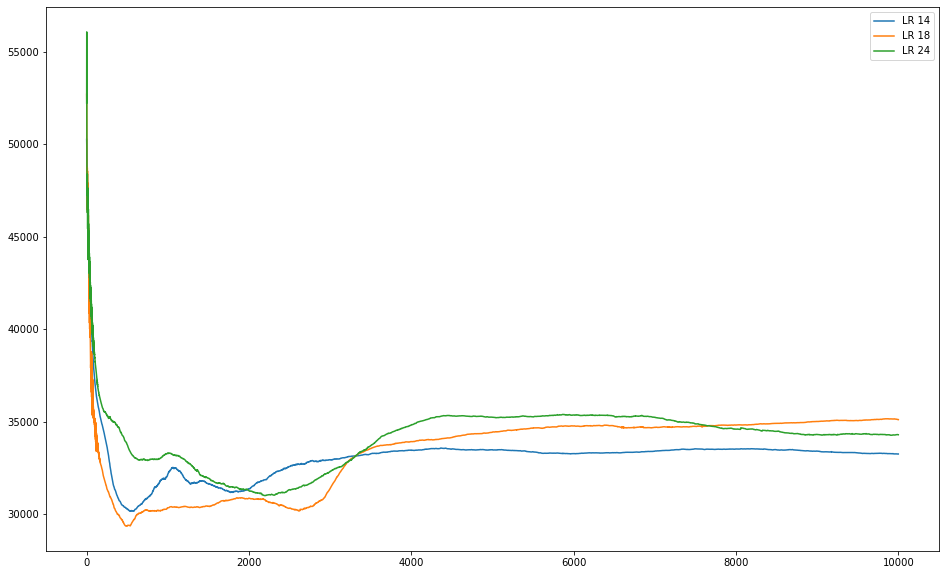

In [67]:
plt.figure(figsize=(16,10))
for i, r in enumerate(results3):
    plt.plot(r, label="LR {}".format(hidden[i]))
    plt.legend()

In [74]:
# added some manual decay to the learning rate, reducing it at 500 epochs, 2000 and 5000
hidden = [14, 18, 24]
results4 = []
for h in hidden:
    mlp = MLP(X_train.shape[1], y_train_wide.shape[1],
            hidden_units=h,
            epochs=10000,
            learning_rate=0.01, loss='log', 
            first_activation = 'sig', second_activation='softmax')
    mlp.fit(X_train, y_train_wide)
    results4.append(mlp.loss)

Epoch 1 Loss is 50290.07537914097
Epoch 2 Loss is 50183.11887736915
Epoch 3 Loss is 49245.72372733271
Epoch 4 Loss is 49077.732532849914
Epoch 5 Loss is 48869.49429348998
Epoch 6 Loss is 48439.66492500908
Epoch 7 Loss is 47609.98868103365
Epoch 8 Loss is 47288.39762321687
Epoch 9 Loss is 47236.33402706342
Epoch 10 Loss is 46938.09652924867
Epoch 11 Loss is 47163.339987198655
Epoch 12 Loss is 48601.5830670791
Epoch 13 Loss is 48530.73298767576
Epoch 14 Loss is 46629.2382017354
Epoch 15 Loss is 46921.521892052784
Epoch 16 Loss is 45899.300355325584
Epoch 17 Loss is 45763.59535077182
Epoch 18 Loss is 45298.35535264207
Epoch 19 Loss is 45122.858911711926
Epoch 20 Loss is 44701.26671909119
Epoch 21 Loss is 44585.70145079353
Epoch 22 Loss is 44223.54587333052
Epoch 23 Loss is 44191.09595095725
Epoch 24 Loss is 43851.25705133185
Epoch 25 Loss is 43892.28727422618
Epoch 26 Loss is 43543.71377380667
Epoch 27 Loss is 43628.89279096522
Epoch 28 Loss is 43275.39561564716
Epoch 29 Loss is 43352.431

<ipython-input-73-5060925ff1d2>:45: RuntimeWarning: overflow encountered in exp
  sig = (1 / (1 + np.exp(-x)))


Epoch 34 Loss is 42548.04024036518
Epoch 35 Loss is 42514.04885852707
Epoch 36 Loss is 42316.77865613528
Epoch 37 Loss is 42243.2604151138
Epoch 38 Loss is 42094.30092067512
Epoch 39 Loss is 42014.35806745519
Epoch 40 Loss is 41884.93730506998
Epoch 41 Loss is 41786.65594206418
Epoch 42 Loss is 41672.63666457649
Epoch 43 Loss is 41593.19172987856
Epoch 44 Loss is 41466.53104583698
Epoch 45 Loss is 41415.91780534855
Epoch 46 Loss is 41259.12535426915
Epoch 47 Loss is 41244.160782447754
Epoch 48 Loss is 41055.86478490882
Epoch 49 Loss is 41022.28798381632
Epoch 50 Loss is 40870.60554182975
Epoch 51 Loss is 40823.73161648467
Epoch 52 Loss is 40710.12396056483
Epoch 53 Loss is 40642.72556847712
Epoch 54 Loss is 40530.90212442982
Epoch 55 Loss is 40453.032475397966
Epoch 56 Loss is 40337.06460173096
Epoch 57 Loss is 40267.372343992065
Epoch 58 Loss is 40148.60664628209
Epoch 59 Loss is 40098.07908453731
Epoch 60 Loss is 39971.755893664704
Epoch 61 Loss is 39933.07106686709
Epoch 62 Loss is 

Epoch 264 Loss is 34230.52915688634
Epoch 265 Loss is 34215.966953984884
Epoch 266 Loss is 34201.78158619755
Epoch 267 Loss is 34198.85173268793
Epoch 268 Loss is 34188.60493993948
Epoch 269 Loss is 34183.2032567184
Epoch 270 Loss is 34176.548961208275
Epoch 271 Loss is 34167.72491687729
Epoch 272 Loss is 34150.669970482006
Epoch 273 Loss is 34135.87380273502
Epoch 274 Loss is 34120.274060973585
Epoch 275 Loss is 34099.902964489695
Epoch 276 Loss is 34086.20802351552
Epoch 277 Loss is 34075.77438044334
Epoch 278 Loss is 34065.11268818998
Epoch 279 Loss is 34057.87289420613
Epoch 280 Loss is 34042.20312521966
Epoch 281 Loss is 34017.75268665547
Epoch 282 Loss is 34002.2160003637
Epoch 283 Loss is 33993.30682160569
Epoch 284 Loss is 33983.79344079034
Epoch 285 Loss is 33985.99944658883
Epoch 286 Loss is 33988.55213609412
Epoch 287 Loss is 33986.89515400956
Epoch 288 Loss is 33980.100848882896
Epoch 289 Loss is 33977.93042968124
Epoch 290 Loss is 33974.78043441055
Epoch 291 Loss is 33973.

Epoch 498 Loss is 31832.90898834149
Epoch 499 Loss is 31824.05150017384
Epoch 500 Loss is 31829.67082113562
Epoch 501 Loss is 31828.90707783403
Epoch 502 Loss is 31828.451225066936
Epoch 503 Loss is 31829.148258558293
Epoch 504 Loss is 31829.823091282353
Epoch 505 Loss is 31829.90910135935
Epoch 506 Loss is 31829.287395061332
Epoch 507 Loss is 31828.6457014322
Epoch 508 Loss is 31827.859745274378
Epoch 509 Loss is 31827.48686773187
Epoch 510 Loss is 31826.81079378851
Epoch 511 Loss is 31826.063831869436
Epoch 512 Loss is 31825.519710706216
Epoch 513 Loss is 31824.54859201376
Epoch 514 Loss is 31822.98661585046
Epoch 515 Loss is 31821.20841362081
Epoch 516 Loss is 31819.90670097405
Epoch 517 Loss is 31819.254397643785
Epoch 518 Loss is 31818.649502517193
Epoch 519 Loss is 31817.441655321705
Epoch 520 Loss is 31815.785034916775
Epoch 521 Loss is 31814.05087910653
Epoch 522 Loss is 31812.698750554824
Epoch 523 Loss is 31812.364382041804
Epoch 524 Loss is 31812.918803441928
Epoch 525 Loss 

Epoch 727 Loss is 31732.773659478622
Epoch 728 Loss is 31731.7941004491
Epoch 729 Loss is 31730.627157314048
Epoch 730 Loss is 31729.924134759964
Epoch 731 Loss is 31730.731713182704
Epoch 732 Loss is 31731.846236801375
Epoch 733 Loss is 31732.254753124176
Epoch 734 Loss is 31732.32182977917
Epoch 735 Loss is 31732.523330694985
Epoch 736 Loss is 31732.595367731024
Epoch 737 Loss is 31732.234745628335
Epoch 738 Loss is 31731.374454768167
Epoch 739 Loss is 31729.94547923342
Epoch 740 Loss is 31728.514761895585
Epoch 741 Loss is 31727.635399539722
Epoch 742 Loss is 31727.460870107596
Epoch 743 Loss is 31727.84137200991
Epoch 744 Loss is 31728.442103143767
Epoch 745 Loss is 31728.782786610544
Epoch 746 Loss is 31728.840317101356
Epoch 747 Loss is 31728.65524695671
Epoch 748 Loss is 31728.942296193272
Epoch 749 Loss is 31731.14801849479
Epoch 750 Loss is 31733.258847962414
Epoch 751 Loss is 31734.638499714598
Epoch 752 Loss is 31736.113925505877
Epoch 753 Loss is 31737.952680156326
Epoch 75

Epoch 961 Loss is 31684.554003652564
Epoch 962 Loss is 31684.0968681826
Epoch 963 Loss is 31684.20089648907
Epoch 964 Loss is 31684.308434234994
Epoch 965 Loss is 31684.254141878715
Epoch 966 Loss is 31683.68043837936
Epoch 967 Loss is 31682.248494374293
Epoch 968 Loss is 31680.32277262309
Epoch 969 Loss is 31678.531333083305
Epoch 970 Loss is 31677.15553530869
Epoch 971 Loss is 31676.27796524813
Epoch 972 Loss is 31675.7508910205
Epoch 973 Loss is 31675.793447017088
Epoch 974 Loss is 31676.887356269206
Epoch 975 Loss is 31678.554655275486
Epoch 976 Loss is 31680.089764802633
Epoch 977 Loss is 31681.332937284147
Epoch 978 Loss is 31682.323546207754
Epoch 979 Loss is 31682.716339328945
Epoch 980 Loss is 31682.443439320556
Epoch 981 Loss is 31681.977734751315
Epoch 982 Loss is 31681.148046146416
Epoch 983 Loss is 31679.795504750076
Epoch 984 Loss is 31678.16384033272
Epoch 985 Loss is 31676.607793534142
Epoch 986 Loss is 31675.11456721733
Epoch 987 Loss is 31673.470910881777
Epoch 988 Lo

Epoch 1189 Loss is 31629.008745163123
Epoch 1190 Loss is 31628.63836880343
Epoch 1191 Loss is 31628.50016308044
Epoch 1192 Loss is 31628.306733381665
Epoch 1193 Loss is 31628.010311823564
Epoch 1194 Loss is 31627.667753736834
Epoch 1195 Loss is 31627.247239924804
Epoch 1196 Loss is 31626.88610360543
Epoch 1197 Loss is 31626.945129140357
Epoch 1198 Loss is 31627.282183769756
Epoch 1199 Loss is 31627.12377302083
Epoch 1200 Loss is 31626.32960029544
Epoch 1201 Loss is 31625.15383949161
Epoch 1202 Loss is 31623.79903919808
Epoch 1203 Loss is 31622.630818470767
Epoch 1204 Loss is 31621.74969773294
Epoch 1205 Loss is 31621.2284212019
Epoch 1206 Loss is 31621.040910046675
Epoch 1207 Loss is 31621.12054897171
Epoch 1208 Loss is 31621.44129065767
Epoch 1209 Loss is 31621.74722743349
Epoch 1210 Loss is 31621.52298874744
Epoch 1211 Loss is 31620.65501258288
Epoch 1212 Loss is 31619.867810198837
Epoch 1213 Loss is 31619.331991173254
Epoch 1214 Loss is 31618.645458651034
Epoch 1215 Loss is 31618.04

Epoch 1409 Loss is 31627.31560515658
Epoch 1410 Loss is 31627.59751953644
Epoch 1411 Loss is 31627.7153449281
Epoch 1412 Loss is 31627.76383138059
Epoch 1413 Loss is 31627.81290719096
Epoch 1414 Loss is 31627.77410957057
Epoch 1415 Loss is 31627.470730376386
Epoch 1416 Loss is 31626.91879590812
Epoch 1417 Loss is 31626.308733365746
Epoch 1418 Loss is 31625.764791726797
Epoch 1419 Loss is 31625.2828972742
Epoch 1420 Loss is 31624.840143405083
Epoch 1421 Loss is 31624.440280323295
Epoch 1422 Loss is 31624.070555339076
Epoch 1423 Loss is 31623.70161701719
Epoch 1424 Loss is 31623.31356532631
Epoch 1425 Loss is 31622.905171546594
Epoch 1426 Loss is 31622.50025478578
Epoch 1427 Loss is 31622.267891579322
Epoch 1428 Loss is 31622.37492999676
Epoch 1429 Loss is 31622.578877129385
Epoch 1430 Loss is 31622.514186516277
Epoch 1431 Loss is 31622.10053972239
Epoch 1432 Loss is 31621.431616431586
Epoch 1433 Loss is 31620.729221849208
Epoch 1434 Loss is 31620.08600513617
Epoch 1435 Loss is 31619.394

Epoch 1631 Loss is 31686.92440599936
Epoch 1632 Loss is 31687.40303565587
Epoch 1633 Loss is 31687.743019491416
Epoch 1634 Loss is 31688.002671890456
Epoch 1635 Loss is 31688.384512370896
Epoch 1636 Loss is 31689.275708120942
Epoch 1637 Loss is 31690.609662913284
Epoch 1638 Loss is 31692.04753657169
Epoch 1639 Loss is 31693.449183571916
Epoch 1640 Loss is 31694.8981373681
Epoch 1641 Loss is 31696.35348842964
Epoch 1642 Loss is 31697.254326582013
Epoch 1643 Loss is 31697.325964339405
Epoch 1644 Loss is 31696.70572730895
Epoch 1645 Loss is 31695.60623279832
Epoch 1646 Loss is 31694.324957461205
Epoch 1647 Loss is 31693.22143122771
Epoch 1648 Loss is 31692.522407391454
Epoch 1649 Loss is 31692.087615663095
Epoch 1650 Loss is 31691.72336271912
Epoch 1651 Loss is 31691.540216161113
Epoch 1652 Loss is 31691.684575091655
Epoch 1653 Loss is 31692.191865530054
Epoch 1654 Loss is 31692.994041445105
Epoch 1655 Loss is 31693.927166463676
Epoch 1656 Loss is 31695.00665746193
Epoch 1657 Loss is 3169

Epoch 1857 Loss is 31829.79238244504
Epoch 1858 Loss is 31828.945516976626
Epoch 1859 Loss is 31828.133484331473
Epoch 1860 Loss is 31827.651709297505
Epoch 1861 Loss is 31827.468284072074
Epoch 1862 Loss is 31827.936196151244
Epoch 1863 Loss is 31829.227044530948
Epoch 1864 Loss is 31830.580416461842
Epoch 1865 Loss is 31831.268156715083
Epoch 1866 Loss is 31831.161047837973
Epoch 1867 Loss is 31830.75347222577
Epoch 1868 Loss is 31830.48745873607
Epoch 1869 Loss is 31830.485450538286
Epoch 1870 Loss is 31830.532546799936
Epoch 1871 Loss is 31830.37011975738
Epoch 1872 Loss is 31830.100871533767
Epoch 1873 Loss is 31830.09924404578
Epoch 1874 Loss is 31830.84770555846
Epoch 1875 Loss is 31832.57276594946
Epoch 1876 Loss is 31834.67552239808
Epoch 1877 Loss is 31836.52547318112
Epoch 1878 Loss is 31837.918589088287
Epoch 1879 Loss is 31838.970972883413
Epoch 1880 Loss is 31839.964069203084
Epoch 1881 Loss is 31841.172160809587
Epoch 1882 Loss is 31842.64115516377
Epoch 1883 Loss is 318

Epoch 2078 Loss is 31887.645526957614
Epoch 2079 Loss is 31887.82089818133
Epoch 2080 Loss is 31888.003893990357
Epoch 2081 Loss is 31888.196089572488
Epoch 2082 Loss is 31888.398561674985
Epoch 2083 Loss is 31888.61165347474
Epoch 2084 Loss is 31888.834831997723
Epoch 2085 Loss is 31889.066699008938
Epoch 2086 Loss is 31889.305171172186
Epoch 2087 Loss is 31889.547784402195
Epoch 2088 Loss is 31889.792036018705
Epoch 2089 Loss is 31890.035680066034
Epoch 2090 Loss is 31890.276928199964
Epoch 2091 Loss is 31890.514552498356
Epoch 2092 Loss is 31890.747913817675
Epoch 2093 Loss is 31890.97694436946
Epoch 2094 Loss is 31891.202104018193
Epoch 2095 Loss is 31891.42431717016
Epoch 2096 Loss is 31891.64488798583
Epoch 2097 Loss is 31891.865388434042
Epoch 2098 Loss is 31892.087516410742
Epoch 2099 Loss is 31892.312929127227
Epoch 2100 Loss is 31892.543068556835
Epoch 2101 Loss is 31892.77900582442
Epoch 2102 Loss is 31893.021331202504
Epoch 2103 Loss is 31893.270100642458
Epoch 2104 Loss is

Epoch 2298 Loss is 31889.905770416233
Epoch 2299 Loss is 31889.84525110738
Epoch 2300 Loss is 31889.778389739437
Epoch 2301 Loss is 31889.706683115375
Epoch 2302 Loss is 31889.631781397766
Epoch 2303 Loss is 31889.55524770222
Epoch 2304 Loss is 31889.478321398023
Epoch 2305 Loss is 31889.401742615173
Epoch 2306 Loss is 31889.32569720076
Epoch 2307 Loss is 31889.249919352515
Epoch 2308 Loss is 31889.173943499936
Epoch 2309 Loss is 31889.097441321443
Epoch 2310 Loss is 31889.02053554918
Epoch 2311 Loss is 31888.943968384283
Epoch 2312 Loss is 31888.86902969115
Epoch 2313 Loss is 31888.797221266275
Epoch 2314 Loss is 31888.729738872797
Epoch 2315 Loss is 31888.666958387304
Epoch 2316 Loss is 31888.608151129258
Epoch 2317 Loss is 31888.551570091546
Epoch 2318 Loss is 31888.494869259684
Epoch 2319 Loss is 31888.43566148074
Epoch 2320 Loss is 31888.37199349512
Epoch 2321 Loss is 31888.302612273357
Epoch 2322 Loss is 31888.227021459687
Epoch 2323 Loss is 31888.145403038467
Epoch 2324 Loss is 

Epoch 2516 Loss is 31903.0512434918
Epoch 2517 Loss is 31903.20565379719
Epoch 2518 Loss is 31903.353670834265
Epoch 2519 Loss is 31903.497051628965
Epoch 2520 Loss is 31903.6377365324
Epoch 2521 Loss is 31903.777717767276
Epoch 2522 Loss is 31903.918854366406
Epoch 2523 Loss is 31904.062652831093
Epoch 2524 Loss is 31904.210045968008
Epoch 2525 Loss is 31904.36121026181
Epoch 2526 Loss is 31904.515461065646
Epoch 2527 Loss is 31904.67125315272
Epoch 2528 Loss is 31904.826293387847
Epoch 2529 Loss is 31904.977747198744
Epoch 2530 Loss is 31905.12249831049
Epoch 2531 Loss is 31905.25740979374
Epoch 2532 Loss is 31905.37953883779
Epoch 2533 Loss is 31905.486275925086
Epoch 2534 Loss is 31905.575403000697
Epoch 2535 Loss is 31905.64508537929
Epoch 2536 Loss is 31905.69382318705
Epoch 2537 Loss is 31905.720390194598
Epoch 2538 Loss is 31905.723784236292
Epoch 2539 Loss is 31905.70320749378
Epoch 2540 Loss is 31905.658088604567
Epoch 2541 Loss is 31905.588151813117
Epoch 2542 Loss is 31905.

Epoch 2743 Loss is 31899.922770928206
Epoch 2744 Loss is 31899.909851716755
Epoch 2745 Loss is 31899.882892440906
Epoch 2746 Loss is 31899.842126892945
Epoch 2747 Loss is 31899.789424705054
Epoch 2748 Loss is 31899.727982008408
Epoch 2749 Loss is 31899.661928869235
Epoch 2750 Loss is 31899.595834267988
Epoch 2751 Loss is 31899.534107969273
Epoch 2752 Loss is 31899.480354023122
Epoch 2753 Loss is 31899.436795336598
Epoch 2754 Loss is 31899.40392224179
Epoch 2755 Loss is 31899.380482474207
Epoch 2756 Loss is 31899.36382347341
Epoch 2757 Loss is 31899.350473759987
Epoch 2758 Loss is 31899.336783294235
Epoch 2759 Loss is 31899.319465069373
Epoch 2760 Loss is 31899.295958705523
Epoch 2761 Loss is 31899.264614800082
Epoch 2762 Loss is 31899.224743106704
Epoch 2763 Loss is 31899.176577352897
Epoch 2764 Loss is 31899.121198421002
Epoch 2765 Loss is 31899.06043864356
Epoch 2766 Loss is 31898.996771030976
Epoch 2767 Loss is 31898.93317312621
Epoch 2768 Loss is 31898.872949431447
Epoch 2769 Loss 

Epoch 2968 Loss is 31923.307864049104
Epoch 2969 Loss is 31923.6839641672
Epoch 2970 Loss is 31924.053084725765
Epoch 2971 Loss is 31924.411501647337
Epoch 2972 Loss is 31924.75593464323
Epoch 2973 Loss is 31925.08387903396
Epoch 2974 Loss is 31925.39379059122
Epoch 2975 Loss is 31925.685079626815
Epoch 2976 Loss is 31925.957946671886
Epoch 2977 Loss is 31926.213131653134
Epoch 2978 Loss is 31926.451649567553
Epoch 2979 Loss is 31926.67456603609
Epoch 2980 Loss is 31926.88284248218
Epoch 2981 Loss is 31927.077260880105
Epoch 2982 Loss is 31927.258423255942
Epoch 2983 Loss is 31927.42681056223
Epoch 2984 Loss is 31927.58287887358
Epoch 2985 Loss is 31927.727168364265
Epoch 2986 Loss is 31927.860402121987
Epoch 2987 Loss is 31927.9835564417
Epoch 2988 Loss is 31928.097890164747
Epoch 2989 Loss is 31928.204926505947
Epoch 2990 Loss is 31928.306386134085
Epoch 2991 Loss is 31928.40407532408
Epoch 2992 Loss is 31928.499738259965
Epoch 2993 Loss is 31928.5948880245
Epoch 2994 Loss is 31928.6

Epoch 3187 Loss is 31915.092385324508
Epoch 3188 Loss is 31914.97962520301
Epoch 3189 Loss is 31914.86065179913
Epoch 3190 Loss is 31914.7364951958
Epoch 3191 Loss is 31914.608466772115
Epoch 3192 Loss is 31914.478105402064
Epoch 3193 Loss is 31914.347103890486
Epoch 3194 Loss is 31914.217218775004
Epoch 3195 Loss is 31914.0901714216
Epoch 3196 Loss is 31913.96755252226
Epoch 3197 Loss is 31913.85074405772
Epoch 3198 Loss is 31913.74087100972
Epoch 3199 Loss is 31913.6387890735
Epoch 3200 Loss is 31913.545105707486
Epoch 3201 Loss is 31913.460223224378
Epoch 3202 Loss is 31913.384387730744
Epoch 3203 Loss is 31913.317728311322
Epoch 3204 Loss is 31913.260276120163
Epoch 3205 Loss is 31913.211960420347
Epoch 3206 Loss is 31913.17258544614
Epoch 3207 Loss is 31913.14179665699
Epoch 3208 Loss is 31913.119047155473
Epoch 3209 Loss is 31913.103575059515
Epoch 3210 Loss is 31913.094400816455
Epoch 3211 Loss is 31913.090350047063
Epoch 3212 Loss is 31913.09010283035
Epoch 3213 Loss is 31913.0

Epoch 3405 Loss is 31918.90119858498
Epoch 3406 Loss is 31918.84643205809
Epoch 3407 Loss is 31918.7954028356
Epoch 3408 Loss is 31918.748000634565
Epoch 3409 Loss is 31918.704062535275
Epoch 3410 Loss is 31918.66344503058
Epoch 3411 Loss is 31918.62605586533
Epoch 3412 Loss is 31918.59185217502
Epoch 3413 Loss is 31918.56081887095
Epoch 3414 Loss is 31918.532942676396
Epoch 3415 Loss is 31918.508194179994
Epoch 3416 Loss is 31918.48652484932
Epoch 3417 Loss is 31918.467879954427
Epoch 3418 Loss is 31918.452223074517
Epoch 3419 Loss is 31918.439564180073
Epoch 3420 Loss is 31918.42998185542
Epoch 3421 Loss is 31918.4236315188
Epoch 3422 Loss is 31918.420735660256
Epoch 3423 Loss is 31918.42155869307
Epoch 3424 Loss is 31918.42637665591
Epoch 3425 Loss is 31918.435458374694
Epoch 3426 Loss is 31918.44907677018
Epoch 3427 Loss is 31918.46756388816
Epoch 3428 Loss is 31918.4914095214
Epoch 3429 Loss is 31918.52138275851
Epoch 3430 Loss is 31918.558634757857
Epoch 3431 Loss is 31918.604729

Epoch 3634 Loss is 31969.975785707484
Epoch 3635 Loss is 31972.845625957434
Epoch 3636 Loss is 31975.70594636124
Epoch 3637 Loss is 31978.529688344406
Epoch 3638 Loss is 31981.292954743163
Epoch 3639 Loss is 31983.9752091444
Epoch 3640 Loss is 31986.55928846565
Epoch 3641 Loss is 31989.03130071372
Epoch 3642 Loss is 31991.38045678256
Epoch 3643 Loss is 31993.598865225726
Epoch 3644 Loss is 31995.68130499534
Epoch 3645 Loss is 31997.624983061913
Epoch 3646 Loss is 31999.42928022793
Epoch 3647 Loss is 32001.095487691844
Epoch 3648 Loss is 32002.626537631968
Epoch 3649 Loss is 32004.026732300605
Epoch 3650 Loss is 32005.301477262932
Epoch 3651 Loss is 32006.457025189826
Epoch 3652 Loss is 32007.50023687836
Epoch 3653 Loss is 32008.43836588231
Epoch 3654 Loss is 32009.278872266856
Epoch 3655 Loss is 32010.02926958123
Epoch 3656 Loss is 32010.697007261748
Epoch 3657 Loss is 32011.28938850056
Epoch 3658 Loss is 32011.8135213543
Epoch 3659 Loss is 32012.276298704575
Epoch 3660 Loss is 32012.6

Epoch 3853 Loss is 32020.36217992003
Epoch 3854 Loss is 32020.35295254687
Epoch 3855 Loss is 32020.34318669834
Epoch 3856 Loss is 32020.33170000357
Epoch 3857 Loss is 32020.317497245207
Epoch 3858 Loss is 32020.299614979158
Epoch 3859 Loss is 32020.27712056676
Epoch 3860 Loss is 32020.249271617486
Epoch 3861 Loss is 32020.21577408432
Epoch 3862 Loss is 32020.1770308084
Epoch 3863 Loss is 32020.134269770333
Epoch 3864 Loss is 32020.08947888459
Epoch 3865 Loss is 32020.04513081108
Epoch 3866 Loss is 32020.003738778338
Epoch 3867 Loss is 32019.967336398135
Epoch 3868 Loss is 32019.937016066582
Epoch 3869 Loss is 32019.912673302322
Epoch 3870 Loss is 32019.89306130407
Epoch 3871 Loss is 32019.87615804172
Epoch 3872 Loss is 32019.859732019937
Epoch 3873 Loss is 32019.841929388043
Epoch 3874 Loss is 32019.821726474718
Epoch 3875 Loss is 32019.799170447608
Epoch 3876 Loss is 32019.775410837614
Epoch 3877 Loss is 32019.752569076256
Epoch 3878 Loss is 32019.733500301805
Epoch 3879 Loss is 32019

Epoch 4073 Loss is 32029.674144806744
Epoch 4074 Loss is 32029.8692812821
Epoch 4075 Loss is 32030.04966135771
Epoch 4076 Loss is 32030.209188137967
Epoch 4077 Loss is 32030.342078777958
Epoch 4078 Loss is 32030.443318893485
Epoch 4079 Loss is 32030.509131197097
Epoch 4080 Loss is 32030.53741627262
Epoch 4081 Loss is 32030.528119124265
Epoch 4082 Loss is 32030.483468172257
Epoch 4083 Loss is 32030.40802828973
Epoch 4084 Loss is 32030.30851728185
Epoch 4085 Loss is 32030.193366098687
Epoch 4086 Loss is 32030.072056446916
Epoch 4087 Loss is 32029.954328550495
Epoch 4088 Loss is 32029.849389626645
Epoch 4089 Loss is 32029.76524965668
Epoch 4090 Loss is 32029.70826704505
Epoch 4091 Loss is 32029.682926808902
Epoch 4092 Loss is 32029.69182474038
Epoch 4093 Loss is 32029.735800288927
Epoch 4094 Loss is 32029.814140599625
Epoch 4095 Loss is 32029.924774215608
Epoch 4096 Loss is 32030.064413767443
Epoch 4097 Loss is 32030.22869189338
Epoch 4098 Loss is 32030.412392952385
Epoch 4099 Loss is 320

Epoch 4299 Loss is 32037.185896358147
Epoch 4300 Loss is 32037.540842808496
Epoch 4301 Loss is 32037.93344023148
Epoch 4302 Loss is 32038.363384796663
Epoch 4303 Loss is 32038.82789534494
Epoch 4304 Loss is 32039.321744318542
Epoch 4305 Loss is 32039.837834677015
Epoch 4306 Loss is 32040.368218693642
Epoch 4307 Loss is 32040.90529785253
Epoch 4308 Loss is 32041.442909081677
Epoch 4309 Loss is 32041.977077738546
Epoch 4310 Loss is 32042.506331679826
Epoch 4311 Loss is 32043.031561836106
Epoch 4312 Loss is 32043.555465297057
Epoch 4313 Loss is 32044.081638465
Epoch 4314 Loss is 32044.613434947183
Epoch 4315 Loss is 32045.15278247162
Epoch 4316 Loss is 32045.69924012726
Epoch 4317 Loss is 32046.249599849547
Epoch 4318 Loss is 32046.798212730217
Epoch 4319 Loss is 32047.337950104524
Epoch 4320 Loss is 32047.86143750982
Epoch 4321 Loss is 32048.362123243467
Epoch 4322 Loss is 32048.834905486492
Epoch 4323 Loss is 32049.276292244453
Epoch 4324 Loss is 32049.684236506244
Epoch 4325 Loss is 32

Epoch 4529 Loss is 32091.764857800667
Epoch 4530 Loss is 32091.800966336392
Epoch 4531 Loss is 32091.83409107387
Epoch 4532 Loss is 32091.867712169344
Epoch 4533 Loss is 32091.90572136698
Epoch 4534 Loss is 32091.951806804293
Epoch 4535 Loss is 32092.008513806388
Epoch 4536 Loss is 32092.076332455566
Epoch 4537 Loss is 32092.153350148004
Epoch 4538 Loss is 32092.23583295394
Epoch 4539 Loss is 32092.319569904117
Epoch 4540 Loss is 32092.401352858462
Epoch 4541 Loss is 32092.47997138876
Epoch 4542 Loss is 32092.55647658894
Epoch 4543 Loss is 32092.63382129387
Epoch 4544 Loss is 32092.716120387955
Epoch 4545 Loss is 32092.807762036256
Epoch 4546 Loss is 32092.912557488733
Epoch 4547 Loss is 32093.03308079724
Epoch 4548 Loss is 32093.170295595803
Epoch 4549 Loss is 32093.323479152736
Epoch 4550 Loss is 32093.49036927514
Epoch 4551 Loss is 32093.667433855302
Epoch 4552 Loss is 32093.85020550188
Epoch 4553 Loss is 32094.03367557706
Epoch 4554 Loss is 32094.212741413176
Epoch 4555 Loss is 320

Epoch 4752 Loss is 32093.67624731871
Epoch 4753 Loss is 32093.71906774818
Epoch 4754 Loss is 32093.749744287743
Epoch 4755 Loss is 32093.767920087244
Epoch 4756 Loss is 32093.773650235296
Epoch 4757 Loss is 32093.767532508926
Epoch 4758 Loss is 32093.750811532755
Epoch 4759 Loss is 32093.725437832265
Epoch 4760 Loss is 32093.69405932965
Epoch 4761 Loss is 32093.65992296103
Epoch 4762 Loss is 32093.626674611638
Epoch 4763 Loss is 32093.598071381668
Epoch 4764 Loss is 32093.577658370577
Epoch 4765 Loss is 32093.568495309508
Epoch 4766 Loss is 32093.573014522455
Epoch 4767 Loss is 32093.593021395664
Epoch 4768 Loss is 32093.62972337805
Epoch 4769 Loss is 32093.683581046527
Epoch 4770 Loss is 32093.75384855492
Epoch 4771 Loss is 32093.837958522294
Epoch 4772 Loss is 32093.931219905553
Epoch 4773 Loss is 32094.027273679687
Epoch 4774 Loss is 32094.119260445765
Epoch 4775 Loss is 32094.20111731474
Epoch 4776 Loss is 32094.268378048717
Epoch 4777 Loss is 32094.318269720392
Epoch 4778 Loss is 

Epoch 4979 Loss is 32091.721925066595
Epoch 4980 Loss is 32091.52966569041
Epoch 4981 Loss is 32091.29238143852
Epoch 4982 Loss is 32091.01703974736
Epoch 4983 Loss is 32090.712299874827
Epoch 4984 Loss is 32090.38816504722
Epoch 4985 Loss is 32090.0555391329
Epoch 4986 Loss is 32089.725552463235
Epoch 4987 Loss is 32089.408691269044
Epoch 4988 Loss is 32089.113913976937
Epoch 4989 Loss is 32088.84796191819
Epoch 4990 Loss is 32088.614976332006
Epoch 4991 Loss is 32088.416425119893
Epoch 4992 Loss is 32088.25131490121
Epoch 4993 Loss is 32088.11669753414
Epoch 4994 Loss is 32088.00847589473
Epoch 4995 Loss is 32087.922414907607
Epoch 4996 Loss is 32087.8551335312
Epoch 4997 Loss is 32087.804807067332
Epoch 4998 Loss is 32087.771389893445
Epoch 4999 Loss is 32087.756324171052
Epoch 5000 Loss is 32087.761854758777
Epoch 5001 Loss is 32087.79017742861
Epoch 5002 Loss is 32087.842684992193
Epoch 5003 Loss is 32087.85610254734
Epoch 5004 Loss is 32087.87048822131
Epoch 5005 Loss is 32087.88

Epoch 5209 Loss is 32095.229600358114
Epoch 5210 Loss is 32095.221099917584
Epoch 5211 Loss is 32095.21195358461
Epoch 5212 Loss is 32095.202187866675
Epoch 5213 Loss is 32095.191833507306
Epoch 5214 Loss is 32095.180925332817
Epoch 5215 Loss is 32095.169502029614
Epoch 5216 Loss is 32095.15760584942
Epoch 5217 Loss is 32095.14528224186
Epoch 5218 Loss is 32095.132579414527
Epoch 5219 Loss is 32095.11954782316
Epoch 5220 Loss is 32095.106239596036
Epoch 5221 Loss is 32095.09270789849
Epoch 5222 Loss is 32095.079006246004
Epoch 5223 Loss is 32095.065187775846
Epoch 5224 Loss is 32095.05130448923
Epoch 5225 Loss is 32095.03740647798
Epoch 5226 Loss is 32095.023541150782
Epoch 5227 Loss is 32095.00975247538
Epoch 5228 Loss is 32094.996080253746
Epoch 5229 Loss is 32094.982559447348
Epoch 5230 Loss is 32094.969219569073
Epoch 5231 Loss is 32094.956084157446
Epoch 5232 Loss is 32094.94317034706
Epoch 5233 Loss is 32094.930488546466
Epoch 5234 Loss is 32094.9180422326
Epoch 5235 Loss is 3209

Epoch 5437 Loss is 32090.777814665034
Epoch 5438 Loss is 32090.775860731283
Epoch 5439 Loss is 32090.77431798572
Epoch 5440 Loss is 32090.773120278125
Epoch 5441 Loss is 32090.77220202331
Epoch 5442 Loss is 32090.77149888497
Epoch 5443 Loss is 32090.77094839305
Epoch 5444 Loss is 32090.770490489365
Epoch 5445 Loss is 32090.77006799929
Epoch 5446 Loss is 32090.76962702882
Epoch 5447 Loss is 32090.769117288568
Epoch 5448 Loss is 32090.768492347215
Epoch 5449 Loss is 32090.76770981868
Epoch 5450 Loss is 32090.766731487198
Epoch 5451 Loss is 32090.765523375445
Epoch 5452 Loss is 32090.764055761003
Epoch 5453 Loss is 32090.762303146126
Epoch 5454 Loss is 32090.76024418594
Epoch 5455 Loss is 32090.757861579837
Epoch 5456 Loss is 32090.755141930378
Epoch 5457 Loss is 32090.752075574175
Epoch 5458 Loss is 32090.748656388194
Epoch 5459 Loss is 32090.744881575625
Epoch 5460 Loss is 32090.740751434412
Epoch 5461 Loss is 32090.736269111643
Epoch 5462 Loss is 32090.73144034754
Epoch 5463 Loss is 32

Epoch 5655 Loss is 32098.45767851547
Epoch 5656 Loss is 32098.50796438049
Epoch 5657 Loss is 32098.557821460337
Epoch 5658 Loss is 32098.607275795915
Epoch 5659 Loss is 32098.6563530634
Epoch 5660 Loss is 32098.705078557035
Epoch 5661 Loss is 32098.753477178587
Epoch 5662 Loss is 32098.801573433757
Epoch 5663 Loss is 32098.849391435255
Epoch 5664 Loss is 32098.89695491235
Epoch 5665 Loss is 32098.944287226794
Epoch 5666 Loss is 32098.991411394785
Epoch 5667 Loss is 32099.03835011414
Epoch 5668 Loss is 32099.08512579684
Epoch 5669 Loss is 32099.13176060565
Epoch 5670 Loss is 32099.178276494513
Epoch 5671 Loss is 32099.22469525151
Epoch 5672 Loss is 32099.27103854368
Epoch 5673 Loss is 32099.317327962573
Epoch 5674 Loss is 32099.36358506903
Epoch 5675 Loss is 32099.40983143645
Epoch 5676 Loss is 32099.4560886906
Epoch 5677 Loss is 32099.502378545018
Epoch 5678 Loss is 32099.548722830034
Epoch 5679 Loss is 32099.59514351436
Epoch 5680 Loss is 32099.641662717342
Epoch 5681 Loss is 32099.68

Epoch 5883 Loss is 32110.25301222726
Epoch 5884 Loss is 32110.269146828618
Epoch 5885 Loss is 32110.28507021018
Epoch 5886 Loss is 32110.300844999692
Epoch 5887 Loss is 32110.3165324181
Epoch 5888 Loss is 32110.33219174014
Epoch 5889 Loss is 32110.34787977989
Epoch 5890 Loss is 32110.363650409945
Epoch 5891 Loss is 32110.37955412314
Epoch 5892 Loss is 32110.395637643694
Epoch 5893 Loss is 32110.411943594918
Epoch 5894 Loss is 32110.428510227874
Epoch 5895 Loss is 32110.44537121495
Epoch 5896 Loss is 32110.462555510396
Epoch 5897 Loss is 32110.48008727796
Epoch 5898 Loss is 32110.497985884926
Epoch 5899 Loss is 32110.51626595983
Epoch 5900 Loss is 32110.534937509954
Epoch 5901 Loss is 32110.55400609418
Epoch 5902 Loss is 32110.57347304506
Epoch 5903 Loss is 32110.593335734335
Epoch 5904 Loss is 32110.613587875145
Epoch 5905 Loss is 32110.63421985434
Epoch 5906 Loss is 32110.65521908867
Epoch 5907 Loss is 32110.67657039839
Epoch 5908 Loss is 32110.6982563927
Epoch 5909 Loss is 32110.7202

Epoch 6102 Loss is 32121.183813599888
Epoch 6103 Loss is 32121.224630089335
Epoch 6104 Loss is 32121.26482599629
Epoch 6105 Loss is 32121.30444720308
Epoch 6106 Loss is 32121.343539122274
Epoch 6107 Loss is 32121.382146651682
Epoch 6108 Loss is 32121.420314147566
Epoch 6109 Loss is 32121.45808541346
Epoch 6110 Loss is 32121.49550370158
Epoch 6111 Loss is 32121.532611723753
Epoch 6112 Loss is 32121.569451668216
Epoch 6113 Loss is 32121.606065219246
Epoch 6114 Loss is 32121.642493575986
Epoch 6115 Loss is 32121.67877746721
Epoch 6116 Loss is 32121.714957159144
Epoch 6117 Loss is 32121.75107245339
Epoch 6118 Loss is 32121.787162672757
Epoch 6119 Loss is 32121.823266632746
Epoch 6120 Loss is 32121.859422597623
Epoch 6121 Loss is 32121.89566821973
Epoch 6122 Loss is 32121.932040461987
Epoch 6123 Loss is 32121.96857550345
Epoch 6124 Loss is 32122.005308628857
Epoch 6125 Loss is 32122.04227410348
Epoch 6126 Loss is 32122.0795050348
Epoch 6127 Loss is 32122.117033223745
Epoch 6128 Loss is 3212

Epoch 6330 Loss is 32131.127830978294
Epoch 6331 Loss is 32131.172363516496
Epoch 6332 Loss is 32131.21710700239
Epoch 6333 Loss is 32131.2620631128
Epoch 6334 Loss is 32131.307232869207
Epoch 6335 Loss is 32131.35261663958
Epoch 6336 Loss is 32131.398214141154
Epoch 6337 Loss is 32131.444024443605
Epoch 6338 Loss is 32131.490045972085
Epoch 6339 Loss is 32131.53627650938
Epoch 6340 Loss is 32131.582713196745
Epoch 6341 Loss is 32131.629352533164
Epoch 6342 Loss is 32131.676190372284
Epoch 6343 Loss is 32131.723221917306
Epoch 6344 Loss is 32131.77044171341
Epoch 6345 Loss is 32131.817843637953
Epoch 6346 Loss is 32131.86542088888
Epoch 6347 Loss is 32131.91316597147
Epoch 6348 Loss is 32131.961070684265
Epoch 6349 Loss is 32132.009126105087
Epoch 6350 Loss is 32132.05732257761
Epoch 6351 Loss is 32132.10564970007
Epoch 6352 Loss is 32132.15409631688
Epoch 6353 Loss is 32132.202650514555
Epoch 6354 Loss is 32132.251299623127
Epoch 6355 Loss is 32132.30003022461
Epoch 6356 Loss is 32132

Epoch 6561 Loss is 32149.936653343593
Epoch 6562 Loss is 32150.103222382546
Epoch 6563 Loss is 32150.267926463308
Epoch 6564 Loss is 32150.430663270534
Epoch 6565 Loss is 32150.591337438702
Epoch 6566 Loss is 32150.74986050521
Epoch 6567 Loss is 32150.906150841412
Epoch 6568 Loss is 32151.060133566196
Epoch 6569 Loss is 32151.21174044563
Epoch 6570 Loss is 32151.360909782055
Epoch 6571 Loss is 32151.507586295476
Epoch 6572 Loss is 32151.651720998932
Epoch 6573 Loss is 32151.79327107004
Epoch 6574 Loss is 32151.932199719107
Epoch 6575 Loss is 32152.068476055123
Epoch 6576 Loss is 32152.202074949335
Epoch 6577 Loss is 32152.332976896498
Epoch 6578 Loss is 32152.46116787337
Epoch 6579 Loss is 32152.58663919383
Epoch 6580 Loss is 32152.709387359617
Epoch 6581 Loss is 32152.829413906107
Epoch 6582 Loss is 32152.946725241905
Epoch 6583 Loss is 32153.06133248147
Epoch 6584 Loss is 32153.173251269942
Epoch 6585 Loss is 32153.282501599297
Epoch 6586 Loss is 32153.38910761539
Epoch 6587 Loss is 

Epoch 6782 Loss is 32156.081430949063
Epoch 6783 Loss is 32156.065056344847
Epoch 6784 Loss is 32156.04869111834
Epoch 6785 Loss is 32156.032334204036
Epoch 6786 Loss is 32156.015984783684
Epoch 6787 Loss is 32155.999642221188
Epoch 6788 Loss is 32155.98330598573
Epoch 6789 Loss is 32155.966975563715
Epoch 6790 Loss is 32155.950650359377
Epoch 6791 Loss is 32155.934329585198
Epoch 6792 Loss is 32155.918012142138
Epoch 6793 Loss is 32155.901696491437
Epoch 6794 Loss is 32155.885380518914
Epoch 6795 Loss is 32155.869061393634
Epoch 6796 Loss is 32155.852735422784
Epoch 6797 Loss is 32155.836397905397
Epoch 6798 Loss is 32155.820042987267
Epoch 6799 Loss is 32155.80366352027
Epoch 6800 Loss is 32155.787250929323
Epoch 6801 Loss is 32155.770795090142
Epoch 6802 Loss is 32155.75428422169
Epoch 6803 Loss is 32155.737704796426
Epoch 6804 Loss is 32155.721041472185
Epoch 6805 Loss is 32155.704277048397
Epoch 6806 Loss is 32155.687392449923
Epoch 6807 Loss is 32155.670366740535
Epoch 6808 Loss 

Epoch 7002 Loss is 32150.9024528725
Epoch 7003 Loss is 32150.951198937855
Epoch 7004 Loss is 32151.001391923808
Epoch 7005 Loss is 32151.053047123
Epoch 7006 Loss is 32151.106177720056
Epoch 7007 Loss is 32151.160794604824
Epoch 7008 Loss is 32151.216906216727
Epoch 7009 Loss is 32151.274518421436
Epoch 7010 Loss is 32151.333634420596
Epoch 7011 Loss is 32151.394254693623
Epoch 7012 Loss is 32151.456376969923
Epoch 7013 Loss is 32151.519996229064
Epoch 7014 Loss is 32151.58510472546
Epoch 7015 Loss is 32151.651692033673
Epoch 7016 Loss is 32151.71974510995
Epoch 7017 Loss is 32151.789248365596
Epoch 7018 Loss is 32151.860183747303
Epoch 7019 Loss is 32151.932530820133
Epoch 7020 Loss is 32152.006266848566
Epoch 7021 Loss is 32152.081366872124
Epoch 7022 Loss is 32152.15780377185
Epoch 7023 Loss is 32152.23554832518
Epoch 7024 Loss is 32152.31456924681
Epoch 7025 Loss is 32152.394833214392
Epoch 7026 Loss is 32152.476304878553
Epoch 7027 Loss is 32152.558946856876
Epoch 7028 Loss is 321

Epoch 7228 Loss is 32151.478534035086
Epoch 7229 Loss is 32151.404026368145
Epoch 7230 Loss is 32151.32932500925
Epoch 7231 Loss is 32151.25449081647
Epoch 7232 Loss is 32151.179588859017
Epoch 7233 Loss is 32151.10468804858
Epoch 7234 Loss is 32151.02986071399
Epoch 7235 Loss is 32150.955182124562
Epoch 7236 Loss is 32150.880729967048
Epoch 7237 Loss is 32150.806583782225
Epoch 7238 Loss is 32150.73282436655
Epoch 7239 Loss is 32150.65953314592
Epoch 7240 Loss is 32150.586791527305
Epoch 7241 Loss is 32150.51468023541
Epoch 7242 Loss is 32150.443278641156
Epoch 7243 Loss is 32150.372664089064
Epoch 7244 Loss is 32150.302911230716
Epoch 7245 Loss is 32150.23409137154
Epoch 7246 Loss is 32150.166271837934
Epoch 7247 Loss is 32150.099515371956
Epoch 7248 Loss is 32150.03387956033
Epoch 7249 Loss is 32149.96941630456
Epoch 7250 Loss is 32149.906171338338
Epoch 7251 Loss is 32149.8441837988
Epoch 7252 Loss is 32149.78348585673
Epoch 7253 Loss is 32149.724102411856
Epoch 7254 Loss is 32149.

Epoch 7451 Loss is 32147.21762448261
Epoch 7452 Loss is 32147.248298495957
Epoch 7453 Loss is 32147.280578054095
Epoch 7454 Loss is 32147.314474964613
Epoch 7455 Loss is 32147.350001107152
Epoch 7456 Loss is 32147.3871684033
Epoch 7457 Loss is 32147.425988754854
Epoch 7458 Loss is 32147.46647395099
Epoch 7459 Loss is 32147.508635547034
Epoch 7460 Loss is 32147.552484718097
Epoch 7461 Loss is 32147.5980320921
Epoch 7462 Loss is 32147.64528756823
Epoch 7463 Loss is 32147.694260127293
Epoch 7464 Loss is 32147.744957641295
Epoch 7465 Loss is 32147.79738669028
Epoch 7466 Loss is 32147.851552394175
Epoch 7467 Loss is 32147.90745826753
Epoch 7468 Loss is 32147.965106104522
Epoch 7469 Loss is 32148.024495900434
Epoch 7470 Loss is 32148.08562581501
Epoch 7471 Loss is 32148.148492181044
Epoch 7472 Loss is 32148.213089560137
Epoch 7473 Loss is 32148.279410845345
Epoch 7474 Loss is 32148.347447408156
Epoch 7475 Loss is 32148.4171892855
Epoch 7476 Loss is 32148.488625399743
Epoch 7477 Loss is 32148

Epoch 7675 Loss is 32159.17782407383
Epoch 7676 Loss is 32159.18685905965
Epoch 7677 Loss is 32159.19520081394
Epoch 7678 Loss is 32159.20289338763
Epoch 7679 Loss is 32159.209985135643
Epoch 7680 Loss is 32159.216528570643
Epoch 7681 Loss is 32159.222580193054
Epoch 7682 Loss is 32159.228200297166
Epoch 7683 Loss is 32159.23345275352
Epoch 7684 Loss is 32159.23840476738
Epoch 7685 Loss is 32159.243126613383
Epoch 7686 Loss is 32159.247691346704
Epoch 7687 Loss is 32159.252174490826
Epoch 7688 Loss is 32159.256653702378
Epoch 7689 Loss is 32159.261208413667
Epoch 7690 Loss is 32159.26591945361
Epoch 7691 Loss is 32159.270868648262
Epoch 7692 Loss is 32159.276138402038
Epoch 7693 Loss is 32159.28181126164
Epoch 7694 Loss is 32159.287969464312
Epoch 7695 Loss is 32159.294694473163
Epoch 7696 Loss is 32159.302066502263
Epoch 7697 Loss is 32159.310164034756
Epoch 7698 Loss is 32159.319063337756
Epoch 7699 Loss is 32159.328837978035
Epoch 7700 Loss is 32159.339558343025
Epoch 7701 Loss is 3

Epoch 7898 Loss is 32163.40949553711
Epoch 7899 Loss is 32163.424525702063
Epoch 7900 Loss is 32163.438811020325
Epoch 7901 Loss is 32163.45238172618
Epoch 7902 Loss is 32163.46526958788
Epoch 7903 Loss is 32163.47750782646
Epoch 7904 Loss is 32163.48913103456
Epoch 7905 Loss is 32163.500175095163
Epoch 7906 Loss is 32163.510677100145
Epoch 7907 Loss is 32163.52067526856
Epoch 7908 Loss is 32163.530208864413
Epoch 7909 Loss is 32163.539318113595
Epoch 7910 Loss is 32163.548044119765
Epoch 7911 Loss is 32163.556428778746
Epoch 7912 Loss is 32163.564514691123
Epoch 7913 Loss is 32163.5723450726
Epoch 7914 Loss is 32163.579963661752
Epoch 7915 Loss is 32163.587414624842
Epoch 7916 Loss is 32163.59474245709
Epoch 7917 Loss is 32163.601991880525
Epoch 7918 Loss is 32163.60920773772
Epoch 7919 Loss is 32163.61643488149
Epoch 7920 Loss is 32163.623718060222
Epoch 7921 Loss is 32163.63110179917
Epoch 7922 Loss is 32163.638630277506
Epoch 7923 Loss is 32163.64634720167
Epoch 7924 Loss is 32163.

Epoch 8124 Loss is 32172.11105448915
Epoch 8125 Loss is 32172.201503928423
Epoch 8126 Loss is 32172.29445653719
Epoch 8127 Loss is 32172.389874340253
Epoch 8128 Loss is 32172.487710954487
Epoch 8129 Loss is 32172.587911944724
Epoch 8130 Loss is 32172.690415248053
Epoch 8131 Loss is 32172.795151657618
Epoch 8132 Loss is 32172.90204535628
Epoch 8133 Loss is 32173.011014489977
Epoch 8134 Loss is 32173.121971770855
Epoch 8135 Loss is 32173.23482510004
Epoch 8136 Loss is 32173.349478200882
Epoch 8137 Loss is 32173.465831253532
Epoch 8138 Loss is 32173.583781522742
Epoch 8139 Loss is 32173.70322397196
Epoch 8140 Loss is 32173.824051857024
Epoch 8141 Loss is 32173.946157294595
Epoch 8142 Loss is 32174.06943180056
Epoch 8143 Loss is 32174.19376679549
Epoch 8144 Loss is 32174.319054074233
Epoch 8145 Loss is 32174.445186238187
Epoch 8146 Loss is 32174.57205708919
Epoch 8147 Loss is 32174.69956198451
Epoch 8148 Loss is 32174.827598152948
Epoch 8149 Loss is 32174.95606497248
Epoch 8150 Loss is 321

Epoch 8344 Loss is 32182.2760047028
Epoch 8345 Loss is 32182.278208780237
Epoch 8346 Loss is 32182.279432105162
Epoch 8347 Loss is 32182.27967094011
Epoch 8348 Loss is 32182.278923866168
Epoch 8349 Loss is 32182.277191698733
Epoch 8350 Loss is 32182.274477408024
Epoch 8351 Loss is 32182.270786046123
Epoch 8352 Loss is 32182.26612468074
Epoch 8353 Loss is 32182.260502336332
Epoch 8354 Loss is 32182.253929942897
Epoch 8355 Loss is 32182.246420291835
Epoch 8356 Loss is 32182.23798799906
Epoch 8357 Loss is 32182.228649474047
Epoch 8358 Loss is 32182.21842289468
Epoch 8359 Loss is 32182.20732818623
Epoch 8360 Loss is 32182.195387003754
Epoch 8361 Loss is 32182.18262271643
Epoch 8362 Loss is 32182.16906039253
Epoch 8363 Loss is 32182.15472678368
Epoch 8364 Loss is 32182.139650306915
Epoch 8365 Loss is 32182.12386102345
Epoch 8366 Loss is 32182.107390612473
Epoch 8367 Loss is 32182.090272339352
Epoch 8368 Loss is 32182.07254101656
Epoch 8369 Loss is 32182.05423295689
Epoch 8370 Loss is 32182.

Epoch 8572 Loss is 32182.533010101022
Epoch 8573 Loss is 32182.5549911599
Epoch 8574 Loss is 32182.57626319415
Epoch 8575 Loss is 32182.59684815627
Epoch 8576 Loss is 32182.616772416197
Epoch 8577 Loss is 32182.636066636784
Epoch 8578 Loss is 32182.654765607258
Epoch 8579 Loss is 32182.672908029006
Epoch 8580 Loss is 32182.69053624804
Epoch 8581 Loss is 32182.707695928842
Epoch 8582 Loss is 32182.72443566603
Epoch 8583 Loss is 32182.740806530877
Epoch 8584 Loss is 32182.75686155227
Epoch 8585 Loss is 32182.772655133595
Epoch 8586 Loss is 32182.788242409733
Epoch 8587 Loss is 32182.803678551154
Epoch 8588 Loss is 32182.819018025213
Epoch 8589 Loss is 32182.834313828
Epoch 8590 Loss is 32182.8496167028
Epoch 8591 Loss is 32182.86497436401
Epoch 8592 Loss is 32182.8804307481
Epoch 8593 Loss is 32182.896025313858
Epoch 8594 Loss is 32182.911792416013
Epoch 8595 Loss is 32182.92776077518
Epoch 8596 Loss is 32182.94395306627
Epoch 8597 Loss is 32182.960385644645
Epoch 8598 Loss is 32182.9770

Epoch 8795 Loss is 32189.34348171952
Epoch 8796 Loss is 32189.40381079453
Epoch 8797 Loss is 32189.46328184031
Epoch 8798 Loss is 32189.521844306913
Epoch 8799 Loss is 32189.579451729656
Epoch 8800 Loss is 32189.63606202766
Epoch 8801 Loss is 32189.691637774584
Epoch 8802 Loss is 32189.74614643698
Epoch 8803 Loss is 32189.79956057626
Epoch 8804 Loss is 32189.851858010887
Epoch 8805 Loss is 32189.90302193638
Epoch 8806 Loss is 32189.95304100142
Epoch 8807 Loss is 32190.00190933935
Epoch 8808 Loss is 32190.049626555563
Epoch 8809 Loss is 32190.096197671923
Epoch 8810 Loss is 32190.14163303049
Epoch 8811 Loss is 32190.185948159295
Epoch 8812 Loss is 32190.22916360383
Epoch 8813 Loss is 32190.271304728347
Epoch 8814 Loss is 32190.31240149132
Epoch 8815 Loss is 32190.35248819956
Epoch 8816 Loss is 32190.39160324604
Epoch 8817 Loss is 32190.429788835667
Epoch 8818 Loss is 32190.467090703714
Epoch 8819 Loss is 32190.503557831078
Epoch 8820 Loss is 32190.539242160237
Epoch 8821 Loss is 32190.5

Epoch 9016 Loss is 32210.47284905777
Epoch 9017 Loss is 32210.545530684383
Epoch 9018 Loss is 32210.617562484218
Epoch 9019 Loss is 32210.68893329429
Epoch 9020 Loss is 32210.759634102917
Epoch 9021 Loss is 32210.82965835987
Epoch 9022 Loss is 32210.899002258826
Epoch 9023 Loss is 32210.967664987726
Epoch 9024 Loss is 32211.035648942358
Epoch 9025 Loss is 32211.102959899657
Epoch 9026 Loss is 32211.169607146545
Epoch 9027 Loss is 32211.235603561927
Epoch 9028 Loss is 32211.300965648716
Epoch 9029 Loss is 32211.36571351469
Epoch 9030 Loss is 32211.429870800424
Epoch 9031 Loss is 32211.49346455468
Epoch 9032 Loss is 32211.55652505685
Epoch 9033 Loss is 32211.61908558843
Epoch 9034 Loss is 32211.681182155127
Epoch 9035 Loss is 32211.74285316277
Epoch 9036 Loss is 32211.8041390507
Epoch 9037 Loss is 32211.86508188707
Epoch 9038 Loss is 32211.925724931392
Epoch 9039 Loss is 32211.98611217037
Epoch 9040 Loss is 32212.046287833353
Epoch 9041 Loss is 32212.10629589463
Epoch 9042 Loss is 32212.

Epoch 9238 Loss is 32222.704780212083
Epoch 9239 Loss is 32222.738345942395
Epoch 9240 Loss is 32222.77329613333
Epoch 9241 Loss is 32222.809638171217
Epoch 9242 Loss is 32222.84737590515
Epoch 9243 Loss is 32222.886509370313
Epoch 9244 Loss is 32222.927034524513
Epoch 9245 Loss is 32222.968943007763
Epoch 9246 Loss is 32223.012221933768
Epoch 9247 Loss is 32223.056853720813
Epoch 9248 Loss is 32223.102815968898
Epoch 9249 Loss is 32223.15008138796
Epoch 9250 Loss is 32223.19861778124
Epoch 9251 Loss is 32223.24838808598
Epoch 9252 Loss is 32223.299350472145
Epoch 9253 Loss is 32223.351458499008
Epoch 9254 Loss is 32223.40466132717
Epoch 9255 Loss is 32223.458903983108
Epoch 9256 Loss is 32223.514127671544
Epoch 9257 Loss is 32223.570270130396
Epoch 9258 Loss is 32223.627266021853
Epoch 9259 Loss is 32223.685047352676
Epoch 9260 Loss is 32223.743543916462
Epoch 9261 Loss is 32223.802683750248
Epoch 9262 Loss is 32223.862393598007
Epoch 9263 Loss is 32223.922599373924
Epoch 9264 Loss is

Epoch 9459 Loss is 32228.492512474437
Epoch 9460 Loss is 32228.481504478015
Epoch 9461 Loss is 32228.47160816265
Epoch 9462 Loss is 32228.46275792618
Epoch 9463 Loss is 32228.45488187683
Epoch 9464 Loss is 32228.447902279473
Epoch 9465 Loss is 32228.441736040568
Epoch 9466 Loss is 32228.436295231782
Epoch 9467 Loss is 32228.43148765116
Epoch 9468 Loss is 32228.427217420747
Epoch 9469 Loss is 32228.423385618244
Epoch 9470 Loss is 32228.419890939604
Epoch 9471 Loss is 32228.41663038872
Epoch 9472 Loss is 32228.41349998945
Epoch 9473 Loss is 32228.41039551431
Epoch 9474 Loss is 32228.40721322333
Epoch 9475 Loss is 32228.403850606534
Epoch 9476 Loss is 32228.400207122286
Epoch 9477 Loss is 32228.396184923873
Epoch 9478 Loss is 32228.39168956687
Epoch 9479 Loss is 32228.386630689583
Epoch 9480 Loss is 32228.380922659253
Epoch 9481 Loss is 32228.37448517802
Epoch 9482 Loss is 32228.367243842247
Epoch 9483 Loss is 32228.359130650937
Epoch 9484 Loss is 32228.350084459096
Epoch 9485 Loss is 322

Epoch 9690 Loss is 32225.943741450017
Epoch 9691 Loss is 32225.95593488519
Epoch 9692 Loss is 32225.96958589053
Epoch 9693 Loss is 32225.984710378245
Epoch 9694 Loss is 32226.001320003335
Epoch 9695 Loss is 32226.01942160029
Epoch 9696 Loss is 32226.039016645096
Epoch 9697 Loss is 32226.06010076998
Epoch 9698 Loss is 32226.082663358466
Epoch 9699 Loss is 32226.106687246513
Epoch 9700 Loss is 32226.132148552406
Epoch 9701 Loss is 32226.15901665127
Epoch 9702 Loss is 32226.18725430355
Epoch 9703 Loss is 32226.216817938417
Epoch 9704 Loss is 32226.247658083976
Epoch 9705 Loss is 32226.279719928883
Epoch 9706 Loss is 32226.31294399218
Epoch 9707 Loss is 32226.34726687308
Epoch 9708 Loss is 32226.382622048703
Epoch 9709 Loss is 32226.41894068658
Epoch 9710 Loss is 32226.45615243911
Epoch 9711 Loss is 32226.49418619047
Epoch 9712 Loss is 32226.532970730223
Epoch 9713 Loss is 32226.572435333706
Epoch 9714 Loss is 32226.6125102358
Epoch 9715 Loss is 32226.65312699115
Epoch 9716 Loss is 32226.6

Epoch 9912 Loss is 32226.591394406976
Epoch 9913 Loss is 32226.55402414422
Epoch 9914 Loss is 32226.51568990544
Epoch 9915 Loss is 32226.4763460598
Epoch 9916 Loss is 32226.435947793216
Epoch 9917 Loss is 32226.394451447926
Epoch 9918 Loss is 32226.35181486846
Epoch 9919 Loss is 32226.307997753767
Epoch 9920 Loss is 32226.262962014393
Epoch 9921 Loss is 32226.21667213428
Epoch 9922 Loss is 32226.169095535766
Epoch 9923 Loss is 32226.120202946742
Epoch 9924 Loss is 32226.069968768046
Epoch 9925 Loss is 32226.018371439208
Epoch 9926 Loss is 32225.965393800267
Epoch 9927 Loss is 32225.91102344643
Epoch 9928 Loss is 32225.855253072834
Epoch 9929 Loss is 32225.798080805373
Epoch 9930 Loss is 32225.739510513675
Epoch 9931 Loss is 32225.679552101927
Epoch 9932 Loss is 32225.618221772438
Epoch 9933 Loss is 32225.555542257316
Epoch 9934 Loss is 32225.491543012642
Epoch 9935 Loss is 32225.426260370074
Epoch 9936 Loss is 32225.359737640127
Epoch 9937 Loss is 32225.292025162435
Epoch 9938 Loss is 

Epoch 146 Loss is 39143.80849810424
Epoch 147 Loss is 39126.863648932485
Epoch 148 Loss is 39113.506679562815
Epoch 149 Loss is 39088.81257545868
Epoch 150 Loss is 39064.9403109478
Epoch 151 Loss is 39044.51521363527
Epoch 152 Loss is 39024.68321981313
Epoch 153 Loss is 39005.32004275081
Epoch 154 Loss is 38986.68520247945
Epoch 155 Loss is 38962.08936878025
Epoch 156 Loss is 38939.261854047676
Epoch 157 Loss is 38918.11070281166
Epoch 158 Loss is 38889.86424017192
Epoch 159 Loss is 38872.77357973225
Epoch 160 Loss is 38866.700268603985
Epoch 161 Loss is 38847.036898362196
Epoch 162 Loss is 38821.57466745735
Epoch 163 Loss is 38803.95618759755
Epoch 164 Loss is 38790.8717019956
Epoch 165 Loss is 38775.060292215174
Epoch 166 Loss is 38755.78305174054
Epoch 167 Loss is 38738.117559843806
Epoch 168 Loss is 38721.36590275742
Epoch 169 Loss is 38695.59024663102
Epoch 170 Loss is 38670.598995225395
Epoch 171 Loss is 38647.0047582993
Epoch 172 Loss is 38621.934282369366
Epoch 173 Loss is 3860

Epoch 377 Loss is 36148.93133084409
Epoch 378 Loss is 36144.126965912285
Epoch 379 Loss is 36128.37990205072
Epoch 380 Loss is 36111.285357865905
Epoch 381 Loss is 36094.67762330242
Epoch 382 Loss is 36081.39691324566
Epoch 383 Loss is 36069.71981614496
Epoch 384 Loss is 36072.23277851612
Epoch 385 Loss is 36069.74122536081
Epoch 386 Loss is 36070.59214522454
Epoch 387 Loss is 36072.97272049444
Epoch 388 Loss is 36061.0493677802
Epoch 389 Loss is 36055.32407920821
Epoch 390 Loss is 36044.602729813
Epoch 391 Loss is 36029.77696264413
Epoch 392 Loss is 36021.238228127775
Epoch 393 Loss is 36012.93569948028
Epoch 394 Loss is 36009.930421054894
Epoch 395 Loss is 35997.492172984224
Epoch 396 Loss is 35980.42779649992
Epoch 397 Loss is 35973.95468263367
Epoch 398 Loss is 35963.646736702125
Epoch 399 Loss is 35961.44563887899
Epoch 400 Loss is 35958.795507195115
Epoch 401 Loss is 35949.498960372584
Epoch 402 Loss is 35932.31872994504
Epoch 403 Loss is 35915.51448815512
Epoch 404 Loss is 35908

Epoch 616 Loss is 35477.37995255526
Epoch 617 Loss is 35476.37962571596
Epoch 618 Loss is 35475.57892722754
Epoch 619 Loss is 35475.26313964444
Epoch 620 Loss is 35475.76748465892
Epoch 621 Loss is 35476.51381623918
Epoch 622 Loss is 35476.50674063896
Epoch 623 Loss is 35475.90135803682
Epoch 624 Loss is 35474.99906391175
Epoch 625 Loss is 35473.964023906454
Epoch 626 Loss is 35472.899998320514
Epoch 627 Loss is 35471.921344106726
Epoch 628 Loss is 35471.126616149835
Epoch 629 Loss is 35470.5618912733
Epoch 630 Loss is 35470.20899089974
Epoch 631 Loss is 35469.864457512325
Epoch 632 Loss is 35469.25545523371
Epoch 633 Loss is 35468.301159941955
Epoch 634 Loss is 35467.05395403558
Epoch 635 Loss is 35465.575191844255
Epoch 636 Loss is 35464.05995830271
Epoch 637 Loss is 35462.72425793983
Epoch 638 Loss is 35461.33936056774
Epoch 639 Loss is 35459.861510006056
Epoch 640 Loss is 35458.39842944338
Epoch 641 Loss is 35457.06336240938
Epoch 642 Loss is 35455.860800471695
Epoch 643 Loss is 35

Epoch 845 Loss is 35287.12042939159
Epoch 846 Loss is 35286.280666962826
Epoch 847 Loss is 35285.69719863148
Epoch 848 Loss is 35285.29600692931
Epoch 849 Loss is 35284.67161106241
Epoch 850 Loss is 35283.877976347045
Epoch 851 Loss is 35283.060183277405
Epoch 852 Loss is 35282.27461644721
Epoch 853 Loss is 35281.52556766035
Epoch 854 Loss is 35280.81760489331
Epoch 855 Loss is 35280.17512591945
Epoch 856 Loss is 35279.641073956234
Epoch 857 Loss is 35279.288426716215
Epoch 858 Loss is 35279.15561233525
Epoch 859 Loss is 35279.06880922739
Epoch 860 Loss is 35278.796507212566
Epoch 861 Loss is 35278.293241640495
Epoch 862 Loss is 35277.64132463973
Epoch 863 Loss is 35276.90932214754
Epoch 864 Loss is 35276.11689265856
Epoch 865 Loss is 35275.26843746745
Epoch 866 Loss is 35274.36852040653
Epoch 867 Loss is 35273.44529741023
Epoch 868 Loss is 35272.567639038956
Epoch 869 Loss is 35271.812100132265
Epoch 870 Loss is 35271.20655181167
Epoch 871 Loss is 35270.61919971659
Epoch 872 Loss is 3

Epoch 1071 Loss is 35186.26310402709
Epoch 1072 Loss is 35185.39679734921
Epoch 1073 Loss is 35184.524935829446
Epoch 1074 Loss is 35183.77794868121
Epoch 1075 Loss is 35182.857507846566
Epoch 1076 Loss is 35181.27392804876
Epoch 1077 Loss is 35179.47398060504
Epoch 1078 Loss is 35177.98697523518
Epoch 1079 Loss is 35176.78395530995
Epoch 1080 Loss is 35175.65638686838
Epoch 1081 Loss is 35174.58058070251
Epoch 1082 Loss is 35173.61775934374
Epoch 1083 Loss is 35172.745255590635
Epoch 1084 Loss is 35171.853345274685
Epoch 1085 Loss is 35170.84309101263
Epoch 1086 Loss is 35169.682199844545
Epoch 1087 Loss is 35168.41703565751
Epoch 1088 Loss is 35167.15321413138
Epoch 1089 Loss is 35165.88704392225
Epoch 1090 Loss is 35164.596615013106
Epoch 1091 Loss is 35163.40282489868
Epoch 1092 Loss is 35162.34441265919
Epoch 1093 Loss is 35161.30948774835
Epoch 1094 Loss is 35160.217610771
Epoch 1095 Loss is 35159.098453199455
Epoch 1096 Loss is 35158.03958481367
Epoch 1097 Loss is 35157.08323093

Epoch 1297 Loss is 35025.48118341895
Epoch 1298 Loss is 35025.21560149646
Epoch 1299 Loss is 35024.80087882808
Epoch 1300 Loss is 35024.22728996224
Epoch 1301 Loss is 35023.50097942245
Epoch 1302 Loss is 35022.635199410885
Epoch 1303 Loss is 35021.65026037142
Epoch 1304 Loss is 35020.57178055264
Epoch 1305 Loss is 35019.41976905864
Epoch 1306 Loss is 35018.220398559824
Epoch 1307 Loss is 35017.03135980304
Epoch 1308 Loss is 35015.96319606229
Epoch 1309 Loss is 35015.15342368814
Epoch 1310 Loss is 35014.66731084202
Epoch 1311 Loss is 35014.449815570406
Epoch 1312 Loss is 35014.37601449874
Epoch 1313 Loss is 35014.323008343905
Epoch 1314 Loss is 35014.215308145926
Epoch 1315 Loss is 35014.03695486932
Epoch 1316 Loss is 35013.80901348731
Epoch 1317 Loss is 35013.5528057192
Epoch 1318 Loss is 35013.31676500446
Epoch 1319 Loss is 35013.17806709871
Epoch 1320 Loss is 35013.1766729691
Epoch 1321 Loss is 35013.30311620596
Epoch 1322 Loss is 35013.52123359756
Epoch 1323 Loss is 35013.8950211633

Epoch 1523 Loss is 34852.640483432384
Epoch 1524 Loss is 34852.070672772075
Epoch 1525 Loss is 34851.42537404429
Epoch 1526 Loss is 34850.86417086964
Epoch 1527 Loss is 34850.657633298666
Epoch 1528 Loss is 34850.49840660604
Epoch 1529 Loss is 34850.10762377263
Epoch 1530 Loss is 34849.61826955452
Epoch 1531 Loss is 34849.16293548202
Epoch 1532 Loss is 34848.79474012071
Epoch 1533 Loss is 34848.38881719738
Epoch 1534 Loss is 34847.785520409074
Epoch 1535 Loss is 34847.0846184199
Epoch 1536 Loss is 34846.46286670133
Epoch 1537 Loss is 34845.943533173115
Epoch 1538 Loss is 34845.51092111808
Epoch 1539 Loss is 34845.175020962364
Epoch 1540 Loss is 34844.94555484802
Epoch 1541 Loss is 34844.846111142964
Epoch 1542 Loss is 34844.90926601539
Epoch 1543 Loss is 34845.07095614791
Epoch 1544 Loss is 34845.15077871139
Epoch 1545 Loss is 34845.0721378881
Epoch 1546 Loss is 34844.90159665585
Epoch 1547 Loss is 34844.67283665426
Epoch 1548 Loss is 34844.41361895435
Epoch 1549 Loss is 34844.17634433

Epoch 1751 Loss is 34724.44387796199
Epoch 1752 Loss is 34724.46096695266
Epoch 1753 Loss is 34724.18701582566
Epoch 1754 Loss is 34723.65021228366
Epoch 1755 Loss is 34722.89673926875
Epoch 1756 Loss is 34721.93471152675
Epoch 1757 Loss is 34720.79028040476
Epoch 1758 Loss is 34719.70076821644
Epoch 1759 Loss is 34718.97782215533
Epoch 1760 Loss is 34718.47045398328
Epoch 1761 Loss is 34717.77507384908
Epoch 1762 Loss is 34716.69342814596
Epoch 1763 Loss is 34715.21939622969
Epoch 1764 Loss is 34713.57710954622
Epoch 1765 Loss is 34712.108851792735
Epoch 1766 Loss is 34710.78065567725
Epoch 1767 Loss is 34709.65577176406
Epoch 1768 Loss is 34708.92213155625
Epoch 1769 Loss is 34708.46609869625
Epoch 1770 Loss is 34707.88586575903
Epoch 1771 Loss is 34707.04955184721
Epoch 1772 Loss is 34705.97680373624
Epoch 1773 Loss is 34704.739031777535
Epoch 1774 Loss is 34703.468143756116
Epoch 1775 Loss is 34702.208668846346
Epoch 1776 Loss is 34700.90747111565
Epoch 1777 Loss is 34699.520432270

Epoch 1982 Loss is 34509.18338108218
Epoch 1983 Loss is 34508.36872800836
Epoch 1984 Loss is 34507.611726509866
Epoch 1985 Loss is 34506.956308806235
Epoch 1986 Loss is 34506.54131439876
Epoch 1987 Loss is 34506.46253530292
Epoch 1988 Loss is 34506.48757394298
Epoch 1989 Loss is 34506.329968311926
Epoch 1990 Loss is 34505.836694554506
Epoch 1991 Loss is 34504.967035915586
Epoch 1992 Loss is 34503.85293316288
Epoch 1993 Loss is 34502.74011483931
Epoch 1994 Loss is 34501.751004245736
Epoch 1995 Loss is 34500.88119750529
Epoch 1996 Loss is 34500.061303609094
Epoch 1997 Loss is 34499.17636360707
Epoch 1998 Loss is 34498.163211764324
Epoch 1999 Loss is 34497.03314452709
Epoch 2000 Loss is 34495.863041374236
Epoch 2001 Loss is 34494.858833496335
Epoch 2002 Loss is 34494.19088228463
Epoch 2003 Loss is 34494.08266028057
Epoch 2004 Loss is 34493.975964331636
Epoch 2005 Loss is 34493.868237858616
Epoch 2006 Loss is 34493.75738728295
Epoch 2007 Loss is 34493.64180819254
Epoch 2008 Loss is 34493.5

Epoch 2213 Loss is 34463.43204555828
Epoch 2214 Loss is 34463.22680685531
Epoch 2215 Loss is 34463.011934113136
Epoch 2216 Loss is 34462.788461400894
Epoch 2217 Loss is 34462.558174264814
Epoch 2218 Loss is 34462.32358087609
Epoch 2219 Loss is 34462.08773298052
Epoch 2220 Loss is 34461.853883640964
Epoch 2221 Loss is 34461.6250280736
Epoch 2222 Loss is 34461.40343525649
Epoch 2223 Loss is 34461.19030295032
Epoch 2224 Loss is 34460.98563267504
Epoch 2225 Loss is 34460.78833923403
Epoch 2226 Loss is 34460.59652878691
Epoch 2227 Loss is 34460.40784159857
Epoch 2228 Loss is 34460.21976737819
Epoch 2229 Loss is 34460.02988055219
Epoch 2230 Loss is 34459.83598307418
Epoch 2231 Loss is 34459.63616851339
Epoch 2232 Loss is 34459.42883142279
Epoch 2233 Loss is 34459.21264542899
Epoch 2234 Loss is 34458.9865280309
Epoch 2235 Loss is 34458.74960380557
Epoch 2236 Loss is 34458.501172499484
Epoch 2237 Loss is 34458.24068483023
Epoch 2238 Loss is 34457.96772666378
Epoch 2239 Loss is 34457.6820114895

Epoch 2442 Loss is 34427.31758843509
Epoch 2443 Loss is 34427.18189189654
Epoch 2444 Loss is 34427.06148289907
Epoch 2445 Loss is 34426.95526450438
Epoch 2446 Loss is 34426.86207974382
Epoch 2447 Loss is 34426.78078969197
Epoch 2448 Loss is 34426.710323863925
Epoch 2449 Loss is 34426.64970607646
Epoch 2450 Loss is 34426.59806111617
Epoch 2451 Loss is 34426.55460833581
Epoch 2452 Loss is 34426.51864796461
Epoch 2453 Loss is 34426.489544864744
Epoch 2454 Loss is 34426.46671302004
Epoch 2455 Loss is 34426.44960240127
Epoch 2456 Loss is 34426.43768811393
Epoch 2457 Loss is 34426.430459987234
Epoch 2458 Loss is 34426.42740918249
Epoch 2459 Loss is 34426.428007333714
Epoch 2460 Loss is 34426.43167372385
Epoch 2461 Loss is 34426.437727654426
Epoch 2462 Loss is 34426.445326870715
Epoch 2463 Loss is 34426.453398385005
Epoch 2464 Loss is 34426.46057401375
Epoch 2465 Loss is 34426.46514721821
Epoch 2466 Loss is 34426.46506811344
Epoch 2467 Loss is 34426.45798870518
Epoch 2468 Loss is 34426.441361

Epoch 2667 Loss is 34383.05426186844
Epoch 2668 Loss is 34382.672988154176
Epoch 2669 Loss is 34382.30371816705
Epoch 2670 Loss is 34381.94585201475
Epoch 2671 Loss is 34381.598974936394
Epoch 2672 Loss is 34381.262872182255
Epoch 2673 Loss is 34380.93754036721
Epoch 2674 Loss is 34380.623218834255
Epoch 2675 Loss is 34380.32045318792
Epoch 2676 Loss is 34380.03017847693
Epoch 2677 Loss is 34379.753768661496
Epoch 2678 Loss is 34379.492948754814
Epoch 2679 Loss is 34379.24944071226
Epoch 2680 Loss is 34379.02428171808
Epoch 2681 Loss is 34378.81696070547
Epoch 2682 Loss is 34378.62476933306
Epoch 2683 Loss is 34378.44279890212
Epoch 2684 Loss is 34378.264688784824
Epoch 2685 Loss is 34378.083787930904
Epoch 2686 Loss is 34377.89422306649
Epoch 2687 Loss is 34377.69154940974
Epoch 2688 Loss is 34377.47294580332
Epoch 2689 Loss is 34377.237089748785
Epoch 2690 Loss is 34376.98387957319
Epoch 2691 Loss is 34376.714128475585
Epoch 2692 Loss is 34376.429299008865
Epoch 2693 Loss is 34376.13

Epoch 2888 Loss is 34333.78606848176
Epoch 2889 Loss is 34333.376295981165
Epoch 2890 Loss is 34332.97179585774
Epoch 2891 Loss is 34332.57261016874
Epoch 2892 Loss is 34332.17933823781
Epoch 2893 Loss is 34331.79302558368
Epoch 2894 Loss is 34331.41494662618
Epoch 2895 Loss is 34331.04633145592
Epoch 2896 Loss is 34330.68809365641
Epoch 2897 Loss is 34330.34061319178
Epoch 2898 Loss is 34330.0036140668
Epoch 2899 Loss is 34329.6761532013
Epoch 2900 Loss is 34329.35671155622
Epoch 2901 Loss is 34329.04335931284
Epoch 2902 Loss is 34328.733958922756
Epoch 2903 Loss is 34328.42637241536
Epoch 2904 Loss is 34328.11864762779
Epoch 2905 Loss is 34327.80916684153
Epoch 2906 Loss is 34327.49674792894
Epoch 2907 Loss is 34327.18069257612
Epoch 2908 Loss is 34326.86078004251
Epoch 2909 Loss is 34326.537209788716
Epoch 2910 Loss is 34326.210502514565
Epoch 2911 Loss is 34325.881375493576
Epoch 2912 Loss is 34325.55061230051
Epoch 2913 Loss is 34325.21894698642
Epoch 2914 Loss is 34324.8869778436

Epoch 3116 Loss is 34283.153208871554
Epoch 3117 Loss is 34283.11206987855
Epoch 3118 Loss is 34283.07411856043
Epoch 3119 Loss is 34283.03376451541
Epoch 3120 Loss is 34282.98564463973
Epoch 3121 Loss is 34282.92552985719
Epoch 3122 Loss is 34282.85082315839
Epoch 3123 Loss is 34282.76062358012
Epoch 3124 Loss is 34282.65546777437
Epoch 3125 Loss is 34282.53689846668
Epoch 3126 Loss is 34282.40698993203
Epoch 3127 Loss is 34282.26792354847
Epoch 3128 Loss is 34282.12166951483
Epoch 3129 Loss is 34281.96979894724
Epoch 3130 Loss is 34281.81342484812
Epoch 3131 Loss is 34281.65325154117
Epoch 3132 Loss is 34281.489700475686
Epoch 3133 Loss is 34281.32307534913
Epoch 3134 Loss is 34281.153729956466
Epoch 3135 Loss is 34280.982206498025
Epoch 3136 Loss is 34280.80931917659
Epoch 3137 Loss is 34280.636167389974
Epoch 3138 Loss is 34280.46407459465
Epoch 3139 Loss is 34280.29446237132
Epoch 3140 Loss is 34280.128682507406
Epoch 3141 Loss is 34279.96783988857
Epoch 3142 Loss is 34279.8126422

Epoch 3346 Loss is 34245.79688887953
Epoch 3347 Loss is 34245.51248758647
Epoch 3348 Loss is 34245.22682583231
Epoch 3349 Loss is 34244.93993916486
Epoch 3350 Loss is 34244.65160686727
Epoch 3351 Loss is 34244.36138348483
Epoch 3352 Loss is 34244.0686407127
Epoch 3353 Loss is 34243.77261391849
Epoch 3354 Loss is 34243.472448821456
Epoch 3355 Loss is 34243.16724553551
Epoch 3356 Loss is 34242.85609879563
Epoch 3357 Loss is 34242.538134386785
Epoch 3358 Loss is 34242.2125424396
Epoch 3359 Loss is 34241.878608358005
Epoch 3360 Loss is 34241.53574181721
Epoch 3361 Loss is 34241.1835036785
Epoch 3362 Loss is 34240.821630001235
Epoch 3363 Loss is 34240.45005177038
Epoch 3364 Loss is 34240.06890865946
Epoch 3365 Loss is 34239.67855522368
Epoch 3366 Loss is 34239.27955839116
Epoch 3367 Loss is 34238.87268592585
Epoch 3368 Loss is 34238.45888648987
Epoch 3369 Loss is 34238.039262784216
Epoch 3370 Loss is 34237.61503973069
Epoch 3371 Loss is 34237.18752959855
Epoch 3372 Loss is 34236.75809537627

Epoch 3569 Loss is 34191.29212630456
Epoch 3570 Loss is 34191.30915300003
Epoch 3571 Loss is 34191.32341818294
Epoch 3572 Loss is 34191.333503912014
Epoch 3573 Loss is 34191.33845071341
Epoch 3574 Loss is 34191.33754245727
Epoch 3575 Loss is 34191.33015599852
Epoch 3576 Loss is 34191.31568049541
Epoch 3577 Loss is 34191.29349375233
Epoch 3578 Loss is 34191.262977518694
Epoch 3579 Loss is 34191.22355505469
Epoch 3580 Loss is 34191.17473821419
Epoch 3581 Loss is 34191.116175378935
Epoch 3582 Loss is 34191.04769482596
Epoch 3583 Loss is 34190.96934033413
Epoch 3584 Loss is 34190.88139715402
Epoch 3585 Loss is 34190.78440706006
Epoch 3586 Loss is 34190.67917125592
Epoch 3587 Loss is 34190.56673961288
Epoch 3588 Loss is 34190.448384335876
Epoch 3589 Loss is 34190.325555984324
Epoch 3590 Loss is 34190.199820171605
Epoch 3591 Loss is 34190.07277453808
Epoch 3592 Loss is 34189.945947898545
Epoch 3593 Loss is 34189.8206866935
Epoch 3594 Loss is 34189.69803754349
Epoch 3595 Loss is 34189.5786379

Epoch 3796 Loss is 34163.834765501764
Epoch 3797 Loss is 34163.692142734246
Epoch 3798 Loss is 34163.549308329886
Epoch 3799 Loss is 34163.406354772254
Epoch 3800 Loss is 34163.26277963483
Epoch 3801 Loss is 34163.117758279106
Epoch 3802 Loss is 34162.97034502714
Epoch 3803 Loss is 34162.81958152983
Epoch 3804 Loss is 34162.6645416842
Epoch 3805 Loss is 34162.50435330166
Epoch 3806 Loss is 34162.338227666296
Epoch 3807 Loss is 34162.16551555031
Epoch 3808 Loss is 34161.98579815696
Epoch 3809 Loss is 34161.79901245903
Epoch 3810 Loss is 34161.605598900955
Epoch 3811 Loss is 34161.40664382917
Epoch 3812 Loss is 34161.20397251912
Epoch 3813 Loss is 34161.00014001111
Epoch 3814 Loss is 34160.79827717602
Epoch 3815 Loss is 34160.60178423004
Epoch 3816 Loss is 34160.41391580437
Epoch 3817 Loss is 34160.23734912283
Epoch 3818 Loss is 34160.07384442186
Epoch 3819 Loss is 34159.92408107558
Epoch 3820 Loss is 34159.78769334515
Epoch 3821 Loss is 34159.663465042264
Epoch 3822 Loss is 34159.549603

Epoch 4023 Loss is 34118.75952824474
Epoch 4024 Loss is 34118.53884458494
Epoch 4025 Loss is 34118.29898043178
Epoch 4026 Loss is 34118.03910058436
Epoch 4027 Loss is 34117.75901276769
Epoch 4028 Loss is 34117.45936775654
Epoch 4029 Loss is 34117.14178412617
Epoch 4030 Loss is 34116.80884498284
Epoch 4031 Loss is 34116.46392480405
Epoch 4032 Loss is 34116.11083794706
Epoch 4033 Loss is 34115.75335487209
Epoch 4034 Loss is 34115.394690057765
Epoch 4035 Loss is 34115.03709637752
Epoch 4036 Loss is 34114.68167859616
Epoch 4037 Loss is 34114.328465168575
Epoch 4038 Loss is 34113.976687198396
Epoch 4039 Loss is 34113.62515211375
Epoch 4040 Loss is 34113.27259283671
Epoch 4041 Loss is 34112.917912642835
Epoch 4042 Loss is 34112.56030234965
Epoch 4043 Loss is 34112.199252250866
Epoch 4044 Loss is 34111.83450326968
Epoch 4045 Loss is 34111.46598151584
Epoch 4046 Loss is 34111.093746754195
Epoch 4047 Loss is 34110.7179679552
Epoch 4048 Loss is 34110.33892479027
Epoch 4049 Loss is 34109.95702542

Epoch 4254 Loss is 34047.74828478584
Epoch 4255 Loss is 34047.5324533378
Epoch 4256 Loss is 34047.31091742267
Epoch 4257 Loss is 34047.08301745716
Epoch 4258 Loss is 34046.84842465282
Epoch 4259 Loss is 34046.60711446756
Epoch 4260 Loss is 34046.359303555844
Epoch 4261 Loss is 34046.10534708536
Epoch 4262 Loss is 34045.84560403592
Epoch 4263 Loss is 34045.58028955711
Epoch 4264 Loss is 34045.3093410013
Epoch 4265 Loss is 34045.032324172
Epoch 4266 Loss is 34044.74839777954
Epoch 4267 Loss is 34044.45633970998
Epoch 4268 Loss is 34044.154623689356
Epoch 4269 Loss is 34043.84152483176
Epoch 4270 Loss is 34043.51523066668
Epoch 4271 Loss is 34043.17393998185
Epoch 4272 Loss is 34042.81594149375
Epoch 4273 Loss is 34042.43967354546
Epoch 4274 Loss is 34042.043771812176
Epoch 4275 Loss is 34041.62711360526
Epoch 4276 Loss is 34041.188865556316
Epoch 4277 Loss is 34040.72853743991
Epoch 4278 Loss is 34040.24603974671
Epoch 4279 Loss is 34039.74173728141
Epoch 4280 Loss is 34039.21648663505
E

Epoch 4478 Loss is 33966.78885363791
Epoch 4479 Loss is 33966.54131912408
Epoch 4480 Loss is 33966.30246002029
Epoch 4481 Loss is 33966.07174597907
Epoch 4482 Loss is 33965.8485117454
Epoch 4483 Loss is 33965.631928190545
Epoch 4484 Loss is 33965.420953681525
Epoch 4485 Loss is 33965.21428187531
Epoch 4486 Loss is 33965.01030942649
Epoch 4487 Loss is 33964.80714651177
Epoch 4488 Loss is 33964.60268341851
Epoch 4489 Loss is 33964.39471072896
Epoch 4490 Loss is 33964.18107510793
Epoch 4491 Loss is 33963.95984351847
Epoch 4492 Loss is 33963.72944844514
Epoch 4493 Loss is 33963.48879360689
Epoch 4494 Loss is 33963.23730958816
Epoch 4495 Loss is 33962.97495825083
Epoch 4496 Loss is 33962.702192155906
Epoch 4497 Loss is 33962.41988055856
Epoch 4498 Loss is 33962.12921717053
Epoch 4499 Loss is 33961.83162643967
Epoch 4500 Loss is 33961.52868350076
Epoch 4501 Loss is 33961.22205735022
Epoch 4502 Loss is 33960.913477736394
Epoch 4503 Loss is 33960.60471627737
Epoch 4504 Loss is 33960.2975653142

Epoch 4707 Loss is 33915.02039101956
Epoch 4708 Loss is 33914.98560270685
Epoch 4709 Loss is 33914.93837560545
Epoch 4710 Loss is 33914.87779740017
Epoch 4711 Loss is 33914.803242227674
Epoch 4712 Loss is 33914.71442126672
Epoch 4713 Loss is 33914.611421425005
Epoch 4714 Loss is 33914.49472564514
Epoch 4715 Loss is 33914.36520780315
Epoch 4716 Loss is 33914.22409634394
Epoch 4717 Loss is 33914.072904251276
Epoch 4718 Loss is 33913.91332856738
Epoch 4719 Loss is 33913.74712937317
Epoch 4720 Loss is 33913.57600395436
Epoch 4721 Loss is 33913.401474567174
Epoch 4722 Loss is 33913.22480618307
Epoch 4723 Loss is 33913.04696378533
Epoch 4724 Loss is 33912.86860909901
Epoch 4725 Loss is 33912.69012745729
Epoch 4726 Loss is 33912.51167045151
Epoch 4727 Loss is 33912.3332011725
Epoch 4728 Loss is 33912.1545354974
Epoch 4729 Loss is 33911.97538155738
Epoch 4730 Loss is 33911.79538573253
Epoch 4731 Loss is 33911.614194014364
Epoch 4732 Loss is 33911.43153199192
Epoch 4733 Loss is 33911.2472976987

Epoch 4939 Loss is 33879.05084730266
Epoch 4940 Loss is 33878.97428420059
Epoch 4941 Loss is 33878.91003640166
Epoch 4942 Loss is 33878.85719909162
Epoch 4943 Loss is 33878.81425329572
Epoch 4944 Loss is 33878.7792481483
Epoch 4945 Loss is 33878.75004647679
Epoch 4946 Loss is 33878.72456204874
Epoch 4947 Loss is 33878.70093796925
Epoch 4948 Loss is 33878.67764954249
Epoch 4949 Loss is 33878.65354193835
Epoch 4950 Loss is 33878.627824038565
Epoch 4951 Loss is 33878.60003716508
Epoch 4952 Loss is 33878.570008597526
Epoch 4953 Loss is 33878.537791764276
Epoch 4954 Loss is 33878.50359154908
Epoch 4955 Loss is 33878.46767509679
Epoch 4956 Loss is 33878.43027443826
Epoch 4957 Loss is 33878.39149444487
Epoch 4958 Loss is 33878.35124488001
Epoch 4959 Loss is 33878.309216029156
Epoch 4960 Loss is 33878.26491234173
Epoch 4961 Loss is 33878.217748158415
Epoch 4962 Loss is 33878.16719579875
Epoch 4963 Loss is 33878.11296177346
Epoch 4964 Loss is 33878.05515475858
Epoch 4965 Loss is 33877.994402533

Epoch 5168 Loss is 33865.18562873175
Epoch 5169 Loss is 33865.1412469975
Epoch 5170 Loss is 33865.09712441048
Epoch 5171 Loss is 33865.0532470832
Epoch 5172 Loss is 33865.00960101975
Epoch 5173 Loss is 33864.96617227837
Epoch 5174 Loss is 33864.92294712687
Epoch 5175 Loss is 33864.87991218974
Epoch 5176 Loss is 33864.837054585674
Epoch 5177 Loss is 33864.7943620546
Epoch 5178 Loss is 33864.75182307299
Epoch 5179 Loss is 33864.709426957146
Epoch 5180 Loss is 33864.66716395323
Epoch 5181 Loss is 33864.625025313944
Epoch 5182 Loss is 33864.583003361055
Epoch 5183 Loss is 33864.541091533756
Epoch 5184 Loss is 33864.49928442196
Epoch 5185 Loss is 33864.457577785186
Epoch 5186 Loss is 33864.41596855621
Epoch 5187 Loss is 33864.374454829915
Epoch 5188 Loss is 33864.333035837335
Epoch 5189 Loss is 33864.29171190531
Epoch 5190 Loss is 33864.25048440187
Epoch 5191 Loss is 33864.20935566813
Epoch 5192 Loss is 33864.168328937434
Epoch 5193 Loss is 33864.12740824218
Epoch 5194 Loss is 33864.0865983

Epoch 5393 Loss is 33858.03085408558
Epoch 5394 Loss is 33858.02710659598
Epoch 5395 Loss is 33858.0234682237
Epoch 5396 Loss is 33858.01993817344
Epoch 5397 Loss is 33858.01651541448
Epoch 5398 Loss is 33858.01319865768
Epoch 5399 Loss is 33858.00998633447
Epoch 5400 Loss is 33858.00687657726
Epoch 5401 Loss is 33858.00386720191
Epoch 5402 Loss is 33858.00095569198
Epoch 5403 Loss is 33857.99813918498
Epoch 5404 Loss is 33857.99541446063
Epoch 5405 Loss is 33857.99277793113
Epoch 5406 Loss is 33857.99022563364
Epoch 5407 Loss is 33857.987753224756
Epoch 5408 Loss is 33857.98535597731
Epoch 5409 Loss is 33857.98302877925
Epoch 5410 Loss is 33857.980766134824
Epoch 5411 Loss is 33857.97856216801
Epoch 5412 Loss is 33857.97641062814
Epoch 5413 Loss is 33857.974304897754
Epoch 5414 Loss is 33857.972238002985
Epoch 5415 Loss is 33857.97020262584
Epoch 5416 Loss is 33857.96819111905
Epoch 5417 Loss is 33857.966195522946
Epoch 5418 Loss is 33857.96420758492
Epoch 5419 Loss is 33857.962218780

Epoch 5624 Loss is 33857.291754448226
Epoch 5625 Loss is 33857.28398146231
Epoch 5626 Loss is 33857.2767131936
Epoch 5627 Loss is 33857.2699547801
Epoch 5628 Loss is 33857.26370988488
Epoch 5629 Loss is 33857.25798070856
Epoch 5630 Loss is 33857.25276800471
Epoch 5631 Loss is 33857.24807109758
Epoch 5632 Loss is 33857.24388790092
Epoch 5633 Loss is 33857.24021493721
Epoch 5634 Loss is 33857.2370473563
Epoch 5635 Loss is 33857.23437895267
Epoch 5636 Loss is 33857.23220218059
Epoch 5637 Loss is 33857.2305081664
Epoch 5638 Loss is 33857.22928671772
Epoch 5639 Loss is 33857.22852632883
Epoch 5640 Loss is 33857.228214182534
Epoch 5641 Loss is 33857.228336148066
Epoch 5642 Loss is 33857.22887677564
Epoch 5643 Loss is 33857.229819287735
Epoch 5644 Loss is 33857.231145568025
Epoch 5645 Loss is 33857.23283614853
Epoch 5646 Loss is 33857.23487019585
Epoch 5647 Loss is 33857.23722549793
Epoch 5648 Loss is 33857.23987845206
Epoch 5649 Loss is 33857.242804055684
Epoch 5650 Loss is 33857.24597590102

Epoch 5847 Loss is 33850.59716042679
Epoch 5848 Loss is 33850.53932762744
Epoch 5849 Loss is 33850.481073273906
Epoch 5850 Loss is 33850.42240961882
Epoch 5851 Loss is 33850.36334988909
Epoch 5852 Loss is 33850.30390829065
Epoch 5853 Loss is 33850.24410000904
Epoch 5854 Loss is 33850.18394120591
Epoch 5855 Loss is 33850.123449010855
Epoch 5856 Loss is 33850.06264150897
Epoch 5857 Loss is 33850.00153772332
Epoch 5858 Loss is 33849.94015759262
Epoch 5859 Loss is 33849.87852194407
Epoch 5860 Loss is 33849.81665246119
Epoch 5861 Loss is 33849.7545716465
Epoch 5862 Loss is 33849.69230277959
Epoch 5863 Loss is 33849.62986987008
Epoch 5864 Loss is 33849.56729760621
Epoch 5865 Loss is 33849.504611298784
Epoch 5866 Loss is 33849.441836821046
Epoch 5867 Loss is 33849.3790005446
Epoch 5868 Loss is 33849.316129271814
Epoch 5869 Loss is 33849.253250165064
Epoch 5870 Loss is 33849.19039067328
Epoch 5871 Loss is 33849.127578456144
Epoch 5872 Loss is 33849.0648413065
Epoch 5873 Loss is 33849.002207071

Epoch 6078 Loss is 33845.16936747285
Epoch 6079 Loss is 33845.1755072596
Epoch 6080 Loss is 33845.18115787762
Epoch 6081 Loss is 33845.186301040674
Epoch 6082 Loss is 33845.19091903497
Epoch 6083 Loss is 33845.194994736536
Epoch 6084 Loss is 33845.198511625975
Epoch 6085 Loss is 33845.201453800735
Epoch 6086 Loss is 33845.20380598529
Epoch 6087 Loss is 33845.2055535394
Epoch 6088 Loss is 33845.20668246491
Epoch 6089 Loss is 33845.20717941113
Epoch 6090 Loss is 33845.20703167924
Epoch 6091 Loss is 33845.20622722592
Epoch 6092 Loss is 33845.204754666665
Epoch 6093 Loss is 33845.20260327861
Epoch 6094 Loss is 33845.19976300361
Epoch 6095 Loss is 33845.1962244514
Epoch 6096 Loss is 33845.19197890334
Epoch 6097 Loss is 33845.18701831659
Epoch 6098 Loss is 33845.18133532927
Epoch 6099 Loss is 33845.17492326643
Epoch 6100 Loss is 33845.16777614705
Epoch 6101 Loss is 33845.15988869232
Epoch 6102 Loss is 33845.15125633484
Epoch 6103 Loss is 33845.14187522932
Epoch 6104 Loss is 33845.13174226432

Epoch 6310 Loss is 33836.938625216855
Epoch 6311 Loss is 33836.90645295181
Epoch 6312 Loss is 33836.87515926859
Epoch 6313 Loss is 33836.84470795091
Epoch 6314 Loss is 33836.815059279776
Epoch 6315 Loss is 33836.78617028287
Epoch 6316 Loss is 33836.75799500836
Epoch 6317 Loss is 33836.73048481836
Epoch 6318 Loss is 33836.70358869723
Epoch 6319 Loss is 33836.677253570066
Epoch 6320 Loss is 33836.651424626194
Epoch 6321 Loss is 33836.62604564355
Epoch 6322 Loss is 33836.6010593093
Epoch 6323 Loss is 33836.57640753316
Epoch 6324 Loss is 33836.552031749765
Epoch 6325 Loss is 33836.52787320745
Epoch 6326 Loss is 33836.503873240734
Epoch 6327 Loss is 33836.47997352508
Epoch 6328 Loss is 33836.456116312154
Epoch 6329 Loss is 33836.43224464486
Epoch 6330 Loss is 33836.40830255189
Epoch 6331 Loss is 33836.38423522123
Epoch 6332 Loss is 33836.35998915325
Epoch 6333 Loss is 33836.33551229392
Epoch 6334 Loss is 33836.310754148595
Epoch 6335 Loss is 33836.28566587761
Epoch 6336 Loss is 33836.260200

Epoch 6534 Loss is 33824.179795433694
Epoch 6535 Loss is 33824.1273792033
Epoch 6536 Loss is 33824.07487721461
Epoch 6537 Loss is 33824.02228555725
Epoch 6538 Loss is 33823.969600390534
Epoch 6539 Loss is 33823.91681790027
Epoch 6540 Loss is 33823.86393425597
Epoch 6541 Loss is 33823.81094556931
Epoch 6542 Loss is 33823.757847853565
Epoch 6543 Loss is 33823.70463698539
Epoch 6544 Loss is 33823.65130866859
Epoch 6545 Loss is 33823.59785840057
Epoch 6546 Loss is 33823.544281441886
Epoch 6547 Loss is 33823.49057278884
Epoch 6548 Loss is 33823.43672714963
Epoch 6549 Loss is 33823.38273892421
Epoch 6550 Loss is 33823.32860218763
Epoch 6551 Loss is 33823.27431067749
Epoch 6552 Loss is 33823.219857784905
Epoch 6553 Loss is 33823.16523654951
Epoch 6554 Loss is 33823.11043965784
Epoch 6555 Loss is 33823.055459445495
Epoch 6556 Loss is 33823.00028790247
Epoch 6557 Loss is 33822.944916681794
Epoch 6558 Loss is 33822.889337110835
Epoch 6559 Loss is 33822.833540205436
Epoch 6560 Loss is 33822.77751

Epoch 6765 Loss is 33807.572381096856
Epoch 6766 Loss is 33807.51244550876
Epoch 6767 Loss is 33807.45281556906
Epoch 6768 Loss is 33807.39349229251
Epoch 6769 Loss is 33807.33447708472
Epoch 6770 Loss is 33807.27577175159
Epoch 6771 Loss is 33807.21737850473
Epoch 6772 Loss is 33807.15929996229
Epoch 6773 Loss is 33807.10153914564
Epoch 6774 Loss is 33807.044099472085
Epoch 6775 Loss is 33806.98698474356
Epoch 6776 Loss is 33806.93019913184
Epoch 6777 Loss is 33806.87374716016
Epoch 6778 Loss is 33806.817633681814
Epoch 6779 Loss is 33806.7618638559
Epoch 6780 Loss is 33806.706443120376
Epoch 6781 Loss is 33806.651377162816
Epoch 6782 Loss is 33806.59667188931
Epoch 6783 Loss is 33806.54233339155
Epoch 6784 Loss is 33806.488367912585
Epoch 6785 Loss is 33806.43478181146
Epoch 6786 Loss is 33806.38158152707
Epoch 6787 Loss is 33806.328773541485
Epoch 6788 Loss is 33806.27636434309
Epoch 6789 Loss is 33806.22436038959
Epoch 6790 Loss is 33806.172768071556
Epoch 6791 Loss is 33806.121593

Epoch 6995 Loss is 33796.97788642865
Epoch 6996 Loss is 33796.91435471597
Epoch 6997 Loss is 33796.85091832664
Epoch 6998 Loss is 33796.78756888734
Epoch 6999 Loss is 33796.72429895817
Epoch 7000 Loss is 33796.66110216011
Epoch 7001 Loss is 33796.59797328282
Epoch 7002 Loss is 33796.5349083715
Epoch 7003 Loss is 33796.47190479182
Epoch 7004 Loss is 33796.40896127161
Epoch 7005 Loss is 33796.3460779192
Epoch 7006 Loss is 33796.28325621802
Epoch 7007 Loss is 33796.2204989981
Epoch 7008 Loss is 33796.15781038475
Epoch 7009 Loss is 33796.09519572588
Epoch 7010 Loss is 33796.032661499274
Epoch 7011 Loss is 33795.97021520179
Epoch 7012 Loss is 33795.90786522287
Epoch 7013 Loss is 33795.845620704764
Epoch 7014 Loss is 33795.783491392365
Epoch 7015 Loss is 33795.721487475865
Epoch 7016 Loss is 33795.65961942906
Epoch 7017 Loss is 33795.59789784679
Epoch 7018 Loss is 33795.53633328438
Epoch 7019 Loss is 33795.47493610225
Epoch 7020 Loss is 33795.41371631847
Epoch 7021 Loss is 33795.35268347167


Epoch 7220 Loss is 33780.86409778863
Epoch 7221 Loss is 33780.76436579788
Epoch 7222 Loss is 33780.66491715385
Epoch 7223 Loss is 33780.56576272043
Epoch 7224 Loss is 33780.466910739306
Epoch 7225 Loss is 33780.3683667236
Epoch 7226 Loss is 33780.270133382306
Epoch 7227 Loss is 33780.17221057717
Epoch 7228 Loss is 33780.07459531212
Epoch 7229 Loss is 33779.97728175514
Epoch 7230 Loss is 33779.88026129175
Epoch 7231 Loss is 33779.78352260818
Epoch 7232 Loss is 33779.68705180244
Epoch 7233 Loss is 33779.59083252016
Epoch 7234 Loss is 33779.49484611231
Epoch 7235 Loss is 33779.39907181122
Epoch 7236 Loss is 33779.30348692119
Epoch 7237 Loss is 33779.20806701997
Epoch 7238 Loss is 33779.11278616725
Epoch 7239 Loss is 33779.01761711649
Epoch 7240 Loss is 33778.92253152683
Epoch 7241 Loss is 33778.82750017158
Epoch 7242 Loss is 33778.73249314107
Epoch 7243 Loss is 33778.637480036785
Epoch 7244 Loss is 33778.54243015564
Epoch 7245 Loss is 33778.447312662414
Epoch 7246 Loss is 33778.3520967495

Epoch 7451 Loss is 33761.95065766107
Epoch 7452 Loss is 33761.91397472703
Epoch 7453 Loss is 33761.87744782865
Epoch 7454 Loss is 33761.84107433825
Epoch 7455 Loss is 33761.80485229473
Epoch 7456 Loss is 33761.76878035744
Epoch 7457 Loss is 33761.7328577556
Epoch 7458 Loss is 33761.69708423405
Epoch 7459 Loss is 33761.661459996074
Epoch 7460 Loss is 33761.62598564428
Epoch 7461 Loss is 33761.59066212059
Epoch 7462 Loss is 33761.55549064571
Epoch 7463 Loss is 33761.520472659104
Epoch 7464 Loss is 33761.48560975995
Epoch 7465 Loss is 33761.45090364978
Epoch 7466 Loss is 33761.416356077105
Epoch 7467 Loss is 33761.3819687848
Epoch 7468 Loss is 33761.34774346019
Epoch 7469 Loss is 33761.3136816885
Epoch 7470 Loss is 33761.279784909835
Epoch 7471 Loss is 33761.24605437963
Epoch 7472 Loss is 33761.21249113318
Epoch 7473 Loss is 33761.179095953805
Epoch 7474 Loss is 33761.14586934514
Epoch 7475 Loss is 33761.1128115073
Epoch 7476 Loss is 33761.07992231688
Epoch 7477 Loss is 33761.04720131079


Epoch 7674 Loss is 33754.34063543457
Epoch 7675 Loss is 33754.30001554426
Epoch 7676 Loss is 33754.2592500089
Epoch 7677 Loss is 33754.21833701062
Epoch 7678 Loss is 33754.17727479855
Epoch 7679 Loss is 33754.13606169128
Epoch 7680 Loss is 33754.094696079366
Epoch 7681 Loss is 33754.053176427755
Epoch 7682 Loss is 33754.01150127817
Epoch 7683 Loss is 33753.9696692513
Epoch 7684 Loss is 33753.9276790492
Epoch 7685 Loss is 33753.88552945718
Epoch 7686 Loss is 33753.84321934606
Epoch 7687 Loss is 33753.8007476741
Epoch 7688 Loss is 33753.758113488795
Epoch 7689 Loss is 33753.71531592875
Epoch 7690 Loss is 33753.67235422545
Epoch 7691 Loss is 33753.62922770469
Epoch 7692 Loss is 33753.585935788185
Epoch 7693 Loss is 33753.542477994975
Epoch 7694 Loss is 33753.49885394259
Epoch 7695 Loss is 33753.45506334835
Epoch 7696 Loss is 33753.411106030304
Epoch 7697 Loss is 33753.36698190808
Epoch 7698 Loss is 33753.32269100381
Epoch 7699 Loss is 33753.27823344256
Epoch 7700 Loss is 33753.23360945296

Epoch 7899 Loss is 33743.58149092768
Epoch 7900 Loss is 33743.53799313141
Epoch 7901 Loss is 33743.494898082135
Epoch 7902 Loss is 33743.4522112819
Epoch 7903 Loss is 33743.4099369329
Epoch 7904 Loss is 33743.36807795656
Epoch 7905 Loss is 33743.32663602357
Epoch 7906 Loss is 33743.28561159436
Epoch 7907 Loss is 33743.24500396891
Epoch 7908 Loss is 33743.20481134524
Epoch 7909 Loss is 33743.1650308853
Epoch 7910 Loss is 33743.12565878736
Epoch 7911 Loss is 33743.08669036353
Epoch 7912 Loss is 33743.04812012149
Epoch 7913 Loss is 33743.00994184895
Epoch 7914 Loss is 33742.97214869991
Epoch 7915 Loss is 33742.93473328152
Epoch 7916 Loss is 33742.897687740566
Epoch 7917 Loss is 33742.8610038484
Epoch 7918 Loss is 33742.82467308363
Epoch 7919 Loss is 33742.7886867118
Epoch 7920 Loss is 33742.753035861024
Epoch 7921 Loss is 33742.71771159342
Epoch 7922 Loss is 33742.68270497161
Epoch 7923 Loss is 33742.648007119904
Epoch 7924 Loss is 33742.61360927995
Epoch 7925 Loss is 33742.57950286072
Ep

Epoch 8122 Loss is 33737.3253970211
Epoch 8123 Loss is 33737.2895634724
Epoch 8124 Loss is 33737.253446982584
Epoch 8125 Loss is 33737.217043800505
Epoch 8126 Loss is 33737.18035021127
Epoch 8127 Loss is 33737.14336254228
Epoch 8128 Loss is 33737.10607716959
Epoch 8129 Loss is 33737.06849052464
Epoch 8130 Loss is 33737.0305991012
Epoch 8131 Loss is 33736.99239946306
Epoch 8132 Loss is 33736.9538882518
Epoch 8133 Loss is 33736.91506219529
Epoch 8134 Loss is 33736.87591811655
Epoch 8135 Loss is 33736.83645294339
Epoch 8136 Loss is 33736.79666371847
Epoch 8137 Loss is 33736.756547610225
Epoch 8138 Loss is 33736.71610192434
Epoch 8139 Loss is 33736.67532411621
Epoch 8140 Loss is 33736.63421180405
Epoch 8141 Loss is 33736.59276278314
Epoch 8142 Loss is 33736.55097504074
Epoch 8143 Loss is 33736.50884677226
Epoch 8144 Loss is 33736.466376398304
Epoch 8145 Loss is 33736.42356258285
Epoch 8146 Loss is 33736.38040425251
Epoch 8147 Loss is 33736.33690061685
Epoch 8148 Loss is 33736.29305118988
E

Epoch 8346 Loss is 33724.89210355628
Epoch 8347 Loss is 33724.78298212606
Epoch 8348 Loss is 33724.6730421361
Epoch 8349 Loss is 33724.56230927545
Epoch 8350 Loss is 33724.45081043145
Epoch 8351 Loss is 33724.338573677414
Epoch 8352 Loss is 33724.22562825463
Epoch 8353 Loss is 33724.112004548035
Epoch 8354 Loss is 33723.997734054916
Epoch 8355 Loss is 33723.88284934643
Epoch 8356 Loss is 33723.767384021274
Epoch 8357 Loss is 33723.651372651424
Epoch 8358 Loss is 33723.534850719596
Epoch 8359 Loss is 33723.41785454845
Epoch 8360 Loss is 33723.30042122144
Epoch 8361 Loss is 33723.18258849577
Epoch 8362 Loss is 33723.06439470769
Epoch 8363 Loss is 33722.945878670405
Epoch 8364 Loss is 33722.82707956589
Epoch 8365 Loss is 33722.70803683075
Epoch 8366 Loss is 33722.58879003757
Epoch 8367 Loss is 33722.469378772716
Epoch 8368 Loss is 33722.34984251166
Epoch 8369 Loss is 33722.230220493344
Epoch 8370 Loss is 33722.11055159483
Epoch 8371 Loss is 33721.99087420741
Epoch 8372 Loss is 33721.87122

Epoch 8576 Loss is 33704.17915101104
Epoch 8577 Loss is 33704.13005246917
Epoch 8578 Loss is 33704.08116221369
Epoch 8579 Loss is 33704.03246472139
Epoch 8580 Loss is 33703.98394478715
Epoch 8581 Loss is 33703.93558754042
Epoch 8582 Loss is 33703.88737845938
Epoch 8583 Loss is 33703.83930338281
Epoch 8584 Loss is 33703.791348519444
Epoch 8585 Loss is 33703.74350045543
Epoch 8586 Loss is 33703.69574615971
Epoch 8587 Loss is 33703.64807298748
Epoch 8588 Loss is 33703.60046868194
Epoch 8589 Loss is 33703.55292137439
Epoch 8590 Loss is 33703.505419582885
Epoch 8591 Loss is 33703.45795220962
Epoch 8592 Loss is 33703.4105085369
Epoch 8593 Loss is 33703.363078222195
Epoch 8594 Loss is 33703.3156512923
Epoch 8595 Loss is 33703.26821813635
Epoch 8596 Loss is 33703.22076949838
Epoch 8597 Loss is 33703.173296469264
Epoch 8598 Loss is 33703.125790477825
Epoch 8599 Loss is 33703.078243282
Epoch 8600 Loss is 33703.03064695921
Epoch 8601 Loss is 33702.98299389668
Epoch 8602 Loss is 33702.9352767817
E

Epoch 8803 Loss is 33690.62662911739
Epoch 8804 Loss is 33690.56299418946
Epoch 8805 Loss is 33690.49977205861
Epoch 8806 Loss is 33690.436968936716
Epoch 8807 Loss is 33690.37459037954
Epoch 8808 Loss is 33690.312641284785
Epoch 8809 Loss is 33690.25112589369
Epoch 8810 Loss is 33690.19004779616
Epoch 8811 Loss is 33690.12940993912
Epoch 8812 Loss is 33690.06921463813
Epoch 8813 Loss is 33690.00946359209
Epoch 8814 Loss is 33689.950157900545
Epoch 8815 Loss is 33689.891298083916
Epoch 8816 Loss is 33689.83288410572
Epoch 8817 Loss is 33689.77491539726
Epoch 8818 Loss is 33689.71739088386
Epoch 8819 Loss is 33689.66030901281
Epoch 8820 Loss is 33689.60366778263
Epoch 8821 Loss is 33689.54746477308
Epoch 8822 Loss is 33689.491697176236
Epoch 8823 Loss is 33689.436361827655
Epoch 8824 Loss is 33689.38145523789
Epoch 8825 Loss is 33689.32697362379
Epoch 8826 Loss is 33689.27291293952
Epoch 8827 Loss is 33689.21926890687
Epoch 8828 Loss is 33689.16603704473
Epoch 8829 Loss is 33689.1132126

Epoch 9024 Loss is 33681.78763169578
Epoch 9025 Loss is 33681.769771520194
Epoch 9026 Loss is 33681.75250316462
Epoch 9027 Loss is 33681.73580005823
Epoch 9028 Loss is 33681.719632094566
Epoch 9029 Loss is 33681.70396571456
Epoch 9030 Loss is 33681.68876403902
Epoch 9031 Loss is 33681.67398704824
Epoch 9032 Loss is 33681.65959180648
Epoch 9033 Loss is 33681.64553272682
Epoch 9034 Loss is 33681.6317618716
Epoch 9035 Loss is 33681.61822928235
Epoch 9036 Loss is 33681.60488333277
Epoch 9037 Loss is 33681.59167109796
Epoch 9038 Loss is 33681.57853873295
Epoch 9039 Loss is 33681.56543185378
Epoch 9040 Loss is 33681.55229591479
Epoch 9041 Loss is 33681.53907657615
Epoch 9042 Loss is 33681.52572005631
Epoch 9043 Loss is 33681.512173465286
Epoch 9044 Loss is 33681.498385114726
Epoch 9045 Loss is 33681.48430480207
Epoch 9046 Loss is 33681.46988406702
Epoch 9047 Loss is 33681.45507641863
Epoch 9048 Loss is 33681.43983753307
Epoch 9049 Loss is 33681.42412542157
Epoch 9050 Loss is 33681.4079005695

Epoch 9255 Loss is 33673.39483549152
Epoch 9256 Loss is 33673.35379909743
Epoch 9257 Loss is 33673.31257333756
Epoch 9258 Loss is 33673.27115996299
Epoch 9259 Loss is 33673.22956086492
Epoch 9260 Loss is 33673.18777806432
Epoch 9261 Loss is 33673.14581370163
Epoch 9262 Loss is 33673.10367002625
Epoch 9263 Loss is 33673.06134938582
Epoch 9264 Loss is 33673.018854215516
Epoch 9265 Loss is 33672.97618702713
Epoch 9266 Loss is 33672.93335039819
Epoch 9267 Loss is 33672.89034696095
Epoch 9268 Loss is 33672.84717939153
Epoch 9269 Loss is 33672.80385039886
Epoch 9270 Loss is 33672.76036271388
Epoch 9271 Loss is 33672.716719078766
Epoch 9272 Loss is 33672.67292223612
Epoch 9273 Loss is 33672.62897491851
Epoch 9274 Loss is 33672.58487983806
Epoch 9275 Loss is 33672.54063967627
Epoch 9276 Loss is 33672.49625707395
Epoch 9277 Loss is 33672.45173462166
Epoch 9278 Loss is 33672.40707485005
Epoch 9279 Loss is 33672.362280220856
Epoch 9280 Loss is 33672.317353118015
Epoch 9281 Loss is 33672.272295839

Epoch 9484 Loss is 33660.84746462053
Epoch 9485 Loss is 33660.79697895578
Epoch 9486 Loss is 33660.74663116224
Epoch 9487 Loss is 33660.696412224635
Epoch 9488 Loss is 33660.64631285928
Epoch 9489 Loss is 33660.59632352501
Epoch 9490 Loss is 33660.5464344348
Epoch 9491 Loss is 33660.49663556812
Epoch 9492 Loss is 33660.44691668393
Epoch 9493 Loss is 33660.39726733429
Epoch 9494 Loss is 33660.34767687843
Epoch 9495 Loss is 33660.29813449774
Epoch 9496 Loss is 33660.24862921079
Epoch 9497 Loss is 33660.199149889275
Epoch 9498 Loss is 33660.14968527415
Epoch 9499 Loss is 33660.10022399227
Epoch 9500 Loss is 33660.05075457323
Epoch 9501 Loss is 33660.00126546671
Epoch 9502 Loss is 33659.951745059865
Epoch 9503 Loss is 33659.90218169507
Epoch 9504 Loss is 33659.85256368758
Epoch 9505 Loss is 33659.80287934348
Epoch 9506 Loss is 33659.75311697749
Epoch 9507 Loss is 33659.703264930846
Epoch 9508 Loss is 33659.653311588925
Epoch 9509 Loss is 33659.60324539882
Epoch 9510 Loss is 33659.553054886

Epoch 9705 Loss is 33645.28763023202
Epoch 9706 Loss is 33645.22528932444
Epoch 9707 Loss is 33645.163667535126
Epoch 9708 Loss is 33645.10276093555
Epoch 9709 Loss is 33645.04256458981
Epoch 9710 Loss is 33644.983072589705
Epoch 9711 Loss is 33644.924278094375
Epoch 9712 Loss is 33644.866173374336
Epoch 9713 Loss is 33644.808749859054
Epoch 9714 Loss is 33644.751998187785
Epoch 9715 Loss is 33644.69590826331
Epoch 9716 Loss is 33644.64046930755
Epoch 9717 Loss is 33644.58566991915
Epoch 9718 Loss is 33644.53149813205
Epoch 9719 Loss is 33644.477941474615
Epoch 9720 Loss is 33644.42498702905
Epoch 9721 Loss is 33644.372621490365
Epoch 9722 Loss is 33644.32083122447
Epoch 9723 Loss is 33644.26960232518
Epoch 9724 Loss is 33644.21892066946
Epoch 9725 Loss is 33644.168771970835
Epoch 9726 Loss is 33644.11914183043
Epoch 9727 Loss is 33644.07001578554
Epoch 9728 Loss is 33644.021379355414
Epoch 9729 Loss is 33643.97321808409
Epoch 9730 Loss is 33643.925517580145
Epoch 9731 Loss is 33643.87

Epoch 9930 Loss is 33634.30738455149
Epoch 9931 Loss is 33634.25688371706
Epoch 9932 Loss is 33634.20674360802
Epoch 9933 Loss is 33634.15695997456
Epoch 9934 Loss is 33634.1075280869
Epoch 9935 Loss is 33634.0584427659
Epoch 9936 Loss is 33634.00969841438
Epoch 9937 Loss is 33633.961289048304
Epoch 9938 Loss is 33633.9132083283
Epoch 9939 Loss is 33633.865449591074
Epoch 9940 Loss is 33633.81800588081
Epoch 9941 Loss is 33633.770869980166
Epoch 9942 Loss is 33633.724034441155
Epoch 9943 Loss is 33633.67749161551
Epoch 9944 Loss is 33633.63123368459
Epoch 9945 Loss is 33633.585252688674
Epoch 9946 Loss is 33633.539540555765
Epoch 9947 Loss is 33633.49408912951
Epoch 9948 Loss is 33633.448890196414
Epoch 9949 Loss is 33633.403935512324
Epoch 9950 Loss is 33633.3592168279
Epoch 9951 Loss is 33633.31472591317
Epoch 9952 Loss is 33633.27045458124
Epoch 9953 Loss is 33633.226394710786
Epoch 9954 Loss is 33633.182538267625
Epoch 9955 Loss is 33633.13887732518
Epoch 9956 Loss is 33633.0954040

Epoch 167 Loss is 32445.843121112895
Epoch 168 Loss is 32427.0391787437
Epoch 169 Loss is 32403.56010133568
Epoch 170 Loss is 32362.323317055605
Epoch 171 Loss is 32319.81107525015
Epoch 172 Loss is 32301.261448632114
Epoch 173 Loss is 32274.189599275836
Epoch 174 Loss is 32250.843410176552
Epoch 175 Loss is 32210.240914670885
Epoch 176 Loss is 32187.449890221884
Epoch 177 Loss is 32160.563039333254
Epoch 178 Loss is 32143.73340637791
Epoch 179 Loss is 32117.287867725052
Epoch 180 Loss is 32088.82816185232
Epoch 181 Loss is 32055.483444916517
Epoch 182 Loss is 32047.794163109855
Epoch 183 Loss is 32024.311749576416
Epoch 184 Loss is 32006.37138645457
Epoch 185 Loss is 31986.8040110629
Epoch 186 Loss is 31963.743470043064
Epoch 187 Loss is 31937.63478370787
Epoch 188 Loss is 31905.648300807134
Epoch 189 Loss is 31888.41099928215
Epoch 190 Loss is 31857.697549878074
Epoch 191 Loss is 31835.8433145824
Epoch 192 Loss is 31815.340247348486
Epoch 193 Loss is 31789.528143348438
Epoch 194 Loss

Epoch 397 Loss is 32176.637218388587
Epoch 398 Loss is 32175.651483051315
Epoch 399 Loss is 32165.507688892787
Epoch 400 Loss is 32144.72670362766
Epoch 401 Loss is 32131.393385685893
Epoch 402 Loss is 32122.951136092823
Epoch 403 Loss is 32112.296729462727
Epoch 404 Loss is 32093.781453430285
Epoch 405 Loss is 32094.252227153505
Epoch 406 Loss is 32110.404325860985
Epoch 407 Loss is 32112.278730457823
Epoch 408 Loss is 32100.969293120237
Epoch 409 Loss is 32076.935798981387
Epoch 410 Loss is 32078.519697248594
Epoch 411 Loss is 32071.020894494446
Epoch 412 Loss is 32073.359223241634
Epoch 413 Loss is 32096.99232037224
Epoch 414 Loss is 32097.122518037486
Epoch 415 Loss is 32099.950297887637
Epoch 416 Loss is 32110.280986273177
Epoch 417 Loss is 32092.038168871593
Epoch 418 Loss is 32081.812318291133
Epoch 419 Loss is 32065.141434093202
Epoch 420 Loss is 32037.98581506275
Epoch 421 Loss is 32035.752264701627
Epoch 422 Loss is 32016.353452042364
Epoch 423 Loss is 32005.6539303542
Epoch 

Epoch 623 Loss is 31361.284506616834
Epoch 624 Loss is 31360.388173484556
Epoch 625 Loss is 31359.505758172647
Epoch 626 Loss is 31359.100239805648
Epoch 627 Loss is 31358.900314597515
Epoch 628 Loss is 31358.101057557935
Epoch 629 Loss is 31356.73087151783
Epoch 630 Loss is 31355.12871828069
Epoch 631 Loss is 31353.481174114382
Epoch 632 Loss is 31351.918036821327
Epoch 633 Loss is 31350.585206617787
Epoch 634 Loss is 31349.882336059327
Epoch 635 Loss is 31349.5792996211
Epoch 636 Loss is 31349.111364539658
Epoch 637 Loss is 31348.148516042733
Epoch 638 Loss is 31346.549606745324
Epoch 639 Loss is 31344.683460506632
Epoch 640 Loss is 31343.15105794132
Epoch 641 Loss is 31342.126087721594
Epoch 642 Loss is 31341.36747823989
Epoch 643 Loss is 31340.633339335727
Epoch 644 Loss is 31339.96953349337
Epoch 645 Loss is 31339.558554921266
Epoch 646 Loss is 31339.47435518409
Epoch 647 Loss is 31339.413331566175
Epoch 648 Loss is 31338.971771142562
Epoch 649 Loss is 31338.14434804264
Epoch 650 

Epoch 857 Loss is 31302.45337642838
Epoch 858 Loss is 31303.07293988755
Epoch 859 Loss is 31303.21301937814
Epoch 860 Loss is 31303.154775703915
Epoch 861 Loss is 31303.072625298075
Epoch 862 Loss is 31302.88817178055
Epoch 863 Loss is 31302.60278505398
Epoch 864 Loss is 31302.686202750985
Epoch 865 Loss is 31303.277813783843
Epoch 866 Loss is 31303.97934653084
Epoch 867 Loss is 31304.380146046842
Epoch 868 Loss is 31304.064034077994
Epoch 869 Loss is 31302.987072817563
Epoch 870 Loss is 31301.335261545002
Epoch 871 Loss is 31299.555057142243
Epoch 872 Loss is 31298.055617063827
Epoch 873 Loss is 31297.06324829544
Epoch 874 Loss is 31296.856355275133
Epoch 875 Loss is 31297.144623117154
Epoch 876 Loss is 31297.280622335296
Epoch 877 Loss is 31297.35743431737
Epoch 878 Loss is 31298.053052501615
Epoch 879 Loss is 31299.64742184055
Epoch 880 Loss is 31301.248702638903
Epoch 881 Loss is 31302.252090956543
Epoch 882 Loss is 31302.660644284355
Epoch 883 Loss is 31302.326238467595
Epoch 884 

Epoch 1079 Loss is 31197.684272411498
Epoch 1080 Loss is 31197.433603691767
Epoch 1081 Loss is 31196.778916333467
Epoch 1082 Loss is 31196.34742585135
Epoch 1083 Loss is 31195.73480020426
Epoch 1084 Loss is 31194.50450437631
Epoch 1085 Loss is 31193.49102001703
Epoch 1086 Loss is 31193.15419750798
Epoch 1087 Loss is 31192.931951876682
Epoch 1088 Loss is 31192.803322934575
Epoch 1089 Loss is 31192.430339019396
Epoch 1090 Loss is 31191.414350842748
Epoch 1091 Loss is 31189.769537337124
Epoch 1092 Loss is 31187.743936415947
Epoch 1093 Loss is 31185.75817234686
Epoch 1094 Loss is 31183.66330509534
Epoch 1095 Loss is 31181.294609960423
Epoch 1096 Loss is 31179.492928073014
Epoch 1097 Loss is 31178.709521254677
Epoch 1098 Loss is 31178.37506554835
Epoch 1099 Loss is 31177.55720602039
Epoch 1100 Loss is 31176.01505245913
Epoch 1101 Loss is 31174.369267822538
Epoch 1102 Loss is 31173.780177655157
Epoch 1103 Loss is 31174.42480644985
Epoch 1104 Loss is 31175.286501327402
Epoch 1105 Loss is 3117

Epoch 1299 Loss is 30986.29867223788
Epoch 1300 Loss is 30985.61452626122
Epoch 1301 Loss is 30984.55093339053
Epoch 1302 Loss is 30983.377237798977
Epoch 1303 Loss is 30982.44128100576
Epoch 1304 Loss is 30981.826150826953
Epoch 1305 Loss is 30981.306942932875
Epoch 1306 Loss is 30980.58837133239
Epoch 1307 Loss is 30979.588963239323
Epoch 1308 Loss is 30978.43676663185
Epoch 1309 Loss is 30977.11280276221
Epoch 1310 Loss is 30975.83361884356
Epoch 1311 Loss is 30975.024595488147
Epoch 1312 Loss is 30974.82696987912
Epoch 1313 Loss is 30975.2072890865
Epoch 1314 Loss is 30976.11569990435
Epoch 1315 Loss is 30977.34750718719
Epoch 1316 Loss is 30978.57013934067
Epoch 1317 Loss is 30979.736173303303
Epoch 1318 Loss is 30981.108105135554
Epoch 1319 Loss is 30982.444769595433
Epoch 1320 Loss is 30983.82783090607
Epoch 1321 Loss is 30985.350862440388
Epoch 1322 Loss is 30986.652168773926
Epoch 1323 Loss is 30987.65556895601
Epoch 1324 Loss is 30988.685326673814
Epoch 1325 Loss is 30989.516

Epoch 1522 Loss is 30942.188036764946
Epoch 1523 Loss is 30941.719650552524
Epoch 1524 Loss is 30940.752049744773
Epoch 1525 Loss is 30939.68817379003
Epoch 1526 Loss is 30938.66249367832
Epoch 1527 Loss is 30937.830669599512
Epoch 1528 Loss is 30937.168183452726
Epoch 1529 Loss is 30936.453002893377
Epoch 1530 Loss is 30935.84276734559
Epoch 1531 Loss is 30935.44800313795
Epoch 1532 Loss is 30935.047397124177
Epoch 1533 Loss is 30934.32337808596
Epoch 1534 Loss is 30933.194640884765
Epoch 1535 Loss is 30931.832160492562
Epoch 1536 Loss is 30930.644404967683
Epoch 1537 Loss is 30929.980385282634
Epoch 1538 Loss is 30930.15744942011
Epoch 1539 Loss is 30931.086230401066
Epoch 1540 Loss is 30932.23312470031
Epoch 1541 Loss is 30933.157570231604
Epoch 1542 Loss is 30933.80780235529
Epoch 1543 Loss is 30934.20974447955
Epoch 1544 Loss is 30934.453263928848
Epoch 1545 Loss is 30934.56779961483
Epoch 1546 Loss is 30934.253848290547
Epoch 1547 Loss is 30933.45669356029
Epoch 1548 Loss is 3093

Epoch 1746 Loss is 30802.30407628758
Epoch 1747 Loss is 30801.088883595985
Epoch 1748 Loss is 30799.70121872379
Epoch 1749 Loss is 30797.991711147202
Epoch 1750 Loss is 30796.038684580464
Epoch 1751 Loss is 30793.986080081944
Epoch 1752 Loss is 30792.187488040985
Epoch 1753 Loss is 30790.747897050187
Epoch 1754 Loss is 30789.778498708198
Epoch 1755 Loss is 30789.64190077484
Epoch 1756 Loss is 30790.22102503764
Epoch 1757 Loss is 30790.81095825692
Epoch 1758 Loss is 30790.892859020118
Epoch 1759 Loss is 30790.392761116746
Epoch 1760 Loss is 30789.199085482025
Epoch 1761 Loss is 30787.31048231918
Epoch 1762 Loss is 30784.913750015196
Epoch 1763 Loss is 30782.398541284212
Epoch 1764 Loss is 30779.961193574425
Epoch 1765 Loss is 30777.258399214854
Epoch 1766 Loss is 30774.328710591573
Epoch 1767 Loss is 30772.485095704636
Epoch 1768 Loss is 30771.861740020453
Epoch 1769 Loss is 30771.59934740407
Epoch 1770 Loss is 30771.253931165884
Epoch 1771 Loss is 30770.97473457886
Epoch 1772 Loss is 3

Epoch 1964 Loss is 30712.393721514505
Epoch 1965 Loss is 30711.700683811607
Epoch 1966 Loss is 30711.269508673107
Epoch 1967 Loss is 30711.473686396694
Epoch 1968 Loss is 30712.42442747637
Epoch 1969 Loss is 30713.61996901739
Epoch 1970 Loss is 30714.56657160655
Epoch 1971 Loss is 30715.17323728824
Epoch 1972 Loss is 30715.325022274832
Epoch 1973 Loss is 30715.106605801302
Epoch 1974 Loss is 30714.771521815088
Epoch 1975 Loss is 30714.327772349185
Epoch 1976 Loss is 30713.801147384114
Epoch 1977 Loss is 30713.292934463818
Epoch 1978 Loss is 30712.8089596792
Epoch 1979 Loss is 30712.367039786284
Epoch 1980 Loss is 30711.920630810953
Epoch 1981 Loss is 30711.227747865243
Epoch 1982 Loss is 30710.16162412054
Epoch 1983 Loss is 30708.637508681317
Epoch 1984 Loss is 30706.993253073982
Epoch 1985 Loss is 30705.74171459172
Epoch 1986 Loss is 30704.865633937367
Epoch 1987 Loss is 30703.940085418864
Epoch 1988 Loss is 30703.096578742836
Epoch 1989 Loss is 30702.5792366972
Epoch 1990 Loss is 307

Epoch 2185 Loss is 30669.688147398836
Epoch 2186 Loss is 30669.533812835994
Epoch 2187 Loss is 30669.391929475794
Epoch 2188 Loss is 30669.26479644995
Epoch 2189 Loss is 30669.154313807223
Epoch 2190 Loss is 30669.061913098314
Epoch 2191 Loss is 30668.988597939417
Epoch 2192 Loss is 30668.935100237377
Epoch 2193 Loss is 30668.902124876186
Epoch 2194 Loss is 30668.89061816254
Epoch 2195 Loss is 30668.901959990064
Epoch 2196 Loss is 30668.937964474735
Epoch 2197 Loss is 30669.000608362476
Epoch 2198 Loss is 30669.091509585556
Epoch 2199 Loss is 30669.211315584656
Epoch 2200 Loss is 30669.359235789037
Epoch 2201 Loss is 30669.532885703466
Epoch 2202 Loss is 30669.728442163097
Epoch 2203 Loss is 30669.940975272148
Epoch 2204 Loss is 30670.164807628556
Epoch 2205 Loss is 30670.393821669855
Epoch 2206 Loss is 30670.621709362094
Epoch 2207 Loss is 30670.842191008735
Epoch 2208 Loss is 30671.049226692325
Epoch 2209 Loss is 30671.23722701721
Epoch 2210 Loss is 30671.401255733934
Epoch 2211 Loss

Epoch 2408 Loss is 30656.90960486346
Epoch 2409 Loss is 30656.90993513722
Epoch 2410 Loss is 30656.904184320672
Epoch 2411 Loss is 30656.89031658089
Epoch 2412 Loss is 30656.866136530236
Epoch 2413 Loss is 30656.829313309092
Epoch 2414 Loss is 30656.7774182223
Epoch 2415 Loss is 30656.707981464428
Epoch 2416 Loss is 30656.61857891292
Epoch 2417 Loss is 30656.506966717334
Epoch 2418 Loss is 30656.371282755434
Epoch 2419 Loss is 30656.21032084914
Epoch 2420 Loss is 30656.023850529295
Epoch 2421 Loss is 30655.812907505737
Epoch 2422 Loss is 30655.579937440194
Epoch 2423 Loss is 30655.328669136532
Epoch 2424 Loss is 30655.06365384032
Epoch 2425 Loss is 30654.789540356585
Epoch 2426 Loss is 30654.51030824695
Epoch 2427 Loss is 30654.228747049736
Epoch 2428 Loss is 30653.946372365383
Epoch 2429 Loss is 30653.663761003198
Epoch 2430 Loss is 30653.381115577784
Epoch 2431 Loss is 30653.09883433764
Epoch 2432 Loss is 30652.81793876313
Epoch 2433 Loss is 30652.540311204073
Epoch 2434 Loss is 3065

Epoch 2627 Loss is 30627.711643698825
Epoch 2628 Loss is 30627.71707219039
Epoch 2629 Loss is 30627.720328800657
Epoch 2630 Loss is 30627.71987961101
Epoch 2631 Loss is 30627.71446607642
Epoch 2632 Loss is 30627.703171392168
Epoch 2633 Loss is 30627.6854168268
Epoch 2634 Loss is 30627.66089569481
Epoch 2635 Loss is 30627.62946771497
Epoch 2636 Loss is 30627.59104400625
Epoch 2637 Loss is 30627.545491206787
Epoch 2638 Loss is 30627.492573644595
Epoch 2639 Loss is 30627.431939262355
Epoch 2640 Loss is 30627.363142888145
Epoch 2641 Loss is 30627.285692771442
Epoch 2642 Loss is 30627.199103959763
Epoch 2643 Loss is 30627.102944072085
Epoch 2644 Loss is 30626.996861643922
Epoch 2645 Loss is 30626.880592999958
Epoch 2646 Loss is 30626.753949462214
Epoch 2647 Loss is 30626.616791638746
Epoch 2648 Loss is 30626.4690004963
Epoch 2649 Loss is 30626.31045503444
Epoch 2650 Loss is 30626.14102356352
Epoch 2651 Loss is 30625.960570905416
Epoch 2652 Loss is 30625.768979123204
Epoch 2653 Loss is 30625

Epoch 2853 Loss is 30592.077240477138
Epoch 2854 Loss is 30591.770116626827
Epoch 2855 Loss is 30591.481710147138
Epoch 2856 Loss is 30591.21118020318
Epoch 2857 Loss is 30590.958684606827
Epoch 2858 Loss is 30590.725294180498
Epoch 2859 Loss is 30590.512569414586
Epoch 2860 Loss is 30590.32197754151
Epoch 2861 Loss is 30590.15437129666
Epoch 2862 Loss is 30590.009709362395
Epoch 2863 Loss is 30589.88707786834
Epoch 2864 Loss is 30589.784934986757
Epoch 2865 Loss is 30589.70142566003
Epoch 2866 Loss is 30589.634629969045
Epoch 2867 Loss is 30589.582681513864
Epoch 2868 Loss is 30589.543766577994
Epoch 2869 Loss is 30589.516059697813
Epoch 2870 Loss is 30589.497664694787
Epoch 2871 Loss is 30589.48662179608
Epoch 2872 Loss is 30589.481018341838
Epoch 2873 Loss is 30589.479206847896
Epoch 2874 Loss is 30589.4800960654
Epoch 2875 Loss is 30589.483448046325
Epoch 2876 Loss is 30589.49009679594
Epoch 2877 Loss is 30589.50200737974
Epoch 2878 Loss is 30589.522119510475
Epoch 2879 Loss is 305

Epoch 3077 Loss is 30578.553561581215
Epoch 3078 Loss is 30578.545859044214
Epoch 3079 Loss is 30578.54171002623
Epoch 3080 Loss is 30578.541342944107
Epoch 3081 Loss is 30578.54471816431
Epoch 3082 Loss is 30578.551547850973
Epoch 3083 Loss is 30578.561370733383
Epoch 3084 Loss is 30578.573655191787
Epoch 3085 Loss is 30578.58791209909
Epoch 3086 Loss is 30578.60380443681
Epoch 3087 Loss is 30578.621237783165
Epoch 3088 Loss is 30578.64040744216
Epoch 3089 Loss is 30578.66177385668
Epoch 3090 Loss is 30578.68594823491
Epoch 3091 Loss is 30578.713498425648
Epoch 3092 Loss is 30578.74472169106
Epoch 3093 Loss is 30578.77945550118
Epoch 3094 Loss is 30578.81699073607
Epoch 3095 Loss is 30578.856113267422
Epoch 3096 Loss is 30578.8952516321
Epoch 3097 Loss is 30578.932677675708
Epoch 3098 Loss is 30578.966705293045
Epoch 3099 Loss is 30578.99585124578
Epoch 3100 Loss is 30579.01894493766
Epoch 3101 Loss is 30579.0351893863
Epoch 3102 Loss is 30579.044180674267
Epoch 3103 Loss is 30579.045

Epoch 3302 Loss is 30540.634923656013
Epoch 3303 Loss is 30540.621313613876
Epoch 3304 Loss is 30540.60699111375
Epoch 3305 Loss is 30540.59223194275
Epoch 3306 Loss is 30540.577071701115
Epoch 3307 Loss is 30540.561349014362
Epoch 3308 Loss is 30540.5447632816
Epoch 3309 Loss is 30540.526937236755
Epoch 3310 Loss is 30540.507477737363
Epoch 3311 Loss is 30540.48603146298
Epoch 3312 Loss is 30540.462334752192
Epoch 3313 Loss is 30540.436258217167
Epoch 3314 Loss is 30540.407847026316
Epoch 3315 Loss is 30540.377357091893
Epoch 3316 Loss is 30540.34528618868
Epoch 3317 Loss is 30540.31239759404
Epoch 3318 Loss is 30540.27973241166
Epoch 3319 Loss is 30540.24860544173
Epoch 3320 Loss is 30540.220578349337
Epoch 3321 Loss is 30540.197403102437
Epoch 3322 Loss is 30540.180928697795
Epoch 3323 Loss is 30540.17296626276
Epoch 3324 Loss is 30540.175113717545
Epoch 3325 Loss is 30540.188553422307
Epoch 3326 Loss is 30540.213854667316
Epoch 3327 Loss is 30540.25083233244
Epoch 3328 Loss is 3054

Epoch 3523 Loss is 30481.071197589376
Epoch 3524 Loss is 30480.732742014447
Epoch 3525 Loss is 30480.386325052543
Epoch 3526 Loss is 30480.034707849358
Epoch 3527 Loss is 30479.68055833896
Epoch 3528 Loss is 30479.32636489619
Epoch 3529 Loss is 30478.974411605082
Epoch 3530 Loss is 30478.62680818881
Epoch 3531 Loss is 30478.28555341432
Epoch 3532 Loss is 30477.95260056243
Epoch 3533 Loss is 30477.629890034732
Epoch 3534 Loss is 30477.319319726223
Epoch 3535 Loss is 30477.02263994532
Epoch 3536 Loss is 30476.741285030545
Epoch 3537 Loss is 30476.47618159498
Epoch 3538 Loss is 30476.227591619056
Epoch 3539 Loss is 30475.99504614455
Epoch 3540 Loss is 30475.77739990712
Epoch 3541 Loss is 30475.572999046413
Epoch 3542 Loss is 30475.37991929784
Epoch 3543 Loss is 30475.196213031613
Epoch 3544 Loss is 30475.02010399781
Epoch 3545 Loss is 30474.850086861297
Epoch 3546 Loss is 30474.684920224383
Epoch 3547 Loss is 30474.523538581267
Epoch 3548 Loss is 30474.36493662609
Epoch 3549 Loss is 30474

Epoch 3749 Loss is 30423.79804132094
Epoch 3750 Loss is 30423.84192649935
Epoch 3751 Loss is 30423.899938784474
Epoch 3752 Loss is 30423.969677519075
Epoch 3753 Loss is 30424.048627244065
Epoch 3754 Loss is 30424.134265457076
Epoch 3755 Loss is 30424.224172406626
Epoch 3756 Loss is 30424.31612317064
Epoch 3757 Loss is 30424.408151312247
Epoch 3758 Loss is 30424.49858338163
Epoch 3759 Loss is 30424.586050190206
Epoch 3760 Loss is 30424.669483153233
Epoch 3761 Loss is 30424.748103199472
Epoch 3762 Loss is 30424.821407333257
Epoch 3763 Loss is 30424.889154950408
Epoch 3764 Loss is 30424.951352912372
Epoch 3765 Loss is 30425.008235372745
Epoch 3766 Loss is 30425.06023179757
Epoch 3767 Loss is 30425.10791529312
Epoch 3768 Loss is 30425.15192431716
Epoch 3769 Loss is 30425.192854975885
Epoch 3770 Loss is 30425.23112834623
Epoch 3771 Loss is 30425.266846082795
Epoch 3772 Loss is 30425.299655189472
Epoch 3773 Loss is 30425.32864638313
Epoch 3774 Loss is 30425.352308488003
Epoch 3775 Loss is 30

Epoch 3978 Loss is 30417.512397944818
Epoch 3979 Loss is 30417.50139070918
Epoch 3980 Loss is 30417.49748744823
Epoch 3981 Loss is 30417.501851142846
Epoch 3982 Loss is 30417.515508973487
Epoch 3983 Loss is 30417.53938230659
Epoch 3984 Loss is 30417.574344822726
Epoch 3985 Loss is 30417.621296566016
Epoch 3986 Loss is 30417.68123466261
Epoch 3987 Loss is 30417.75529626421
Epoch 3988 Loss is 30417.844746500792
Epoch 3989 Loss is 30417.95088638845
Epoch 3990 Loss is 30418.074867630105
Epoch 3991 Loss is 30418.21742747797
Epoch 3992 Loss is 30418.378594547117
Epoch 3993 Loss is 30418.5574499626
Epoch 3994 Loss is 30418.752033201567
Epoch 3995 Loss is 30418.959444048938
Epoch 3996 Loss is 30419.176124559224
Epoch 3997 Loss is 30419.3982437254
Epoch 3998 Loss is 30419.62208358171
Epoch 3999 Loss is 30419.84434282065
Epoch 4000 Loss is 30420.062314003204
Epoch 4001 Loss is 30420.27393066535
Epoch 4002 Loss is 30420.477708220442
Epoch 4003 Loss is 30420.672615319694
Epoch 4004 Loss is 30420.8

Epoch 4198 Loss is 30380.482039970528
Epoch 4199 Loss is 30380.11134064611
Epoch 4200 Loss is 30379.752601757107
Epoch 4201 Loss is 30379.409620074566
Epoch 4202 Loss is 30379.086099033306
Epoch 4203 Loss is 30378.78502051043
Epoch 4204 Loss is 30378.508057097923
Epoch 4205 Loss is 30378.255281064514
Epoch 4206 Loss is 30378.025276443394
Epoch 4207 Loss is 30377.815570584353
Epoch 4208 Loss is 30377.623190252223
Epoch 4209 Loss is 30377.445157887345
Epoch 4210 Loss is 30377.278826590515
Epoch 4211 Loss is 30377.12203616998
Epoch 4212 Loss is 30376.97312137701
Epoch 4213 Loss is 30376.83081914703
Epoch 4214 Loss is 30376.694119948002
Epoch 4215 Loss is 30376.56210200343
Epoch 4216 Loss is 30376.433782191845
Epoch 4217 Loss is 30376.308014763083
Epoch 4218 Loss is 30376.183466645452
Epoch 4219 Loss is 30376.058692537546
Epoch 4220 Loss is 30375.932320452543
Epoch 4221 Loss is 30375.803336305733
Epoch 4222 Loss is 30375.671424347023
Epoch 4223 Loss is 30375.537282620877
Epoch 4224 Loss is

Epoch 4417 Loss is 30345.051386602547
Epoch 4418 Loss is 30345.192064189054
Epoch 4419 Loss is 30345.335333302883
Epoch 4420 Loss is 30345.48164937001
Epoch 4421 Loss is 30345.631734602568
Epoch 4422 Loss is 30345.786701789802
Epoch 4423 Loss is 30345.94807487555
Epoch 4424 Loss is 30346.117669627853
Epoch 4425 Loss is 30346.29734260177
Epoch 4426 Loss is 30346.488674257296
Epoch 4427 Loss is 30346.69269135861
Epoch 4428 Loss is 30346.90972184728
Epoch 4429 Loss is 30347.13941065271
Epoch 4430 Loss is 30347.380848064666
Epoch 4431 Loss is 30347.632723354993
Epoch 4432 Loss is 30347.89343159179
Epoch 4433 Loss is 30348.16110848417
Epoch 4434 Loss is 30348.433614185422
Epoch 4435 Loss is 30348.708513533024
Epoch 4436 Loss is 30348.983102926242
Epoch 4437 Loss is 30349.254515256747
Epoch 4438 Loss is 30349.51990109936
Epoch 4439 Loss is 30349.77665018301
Epoch 4440 Loss is 30350.022597857704
Epoch 4441 Loss is 30350.256165662224
Epoch 4442 Loss is 30350.476408980194
Epoch 4443 Loss is 303

Epoch 4637 Loss is 30317.96194987533
Epoch 4638 Loss is 30317.62045565241
Epoch 4639 Loss is 30317.287781668718
Epoch 4640 Loss is 30316.964144960275
Epoch 4641 Loss is 30316.649310501383
Epoch 4642 Loss is 30316.342723916863
Epoch 4643 Loss is 30316.043679960745
Epoch 4644 Loss is 30315.751501127103
Epoch 4645 Loss is 30315.465698578457
Epoch 4646 Loss is 30315.186089503874
Epoch 4647 Loss is 30314.912851068133
Epoch 4648 Loss is 30314.64650144441
Epoch 4649 Loss is 30314.387812583132
Epoch 4650 Loss is 30314.13767500537
Epoch 4651 Loss is 30313.89694724644
Epoch 4652 Loss is 30313.666326043964
Epoch 4653 Loss is 30313.44626511633
Epoch 4654 Loss is 30313.236953143925
Epoch 4655 Loss is 30313.038342849704
Epoch 4656 Loss is 30312.85021071062
Epoch 4657 Loss is 30312.672224429967
Epoch 4658 Loss is 30312.504001135658
Epoch 4659 Loss is 30312.345148628672
Epoch 4660 Loss is 30312.195290467847
Epoch 4661 Loss is 30312.05408091344
Epoch 4662 Loss is 30311.92121752029
Epoch 4663 Loss is 30

Epoch 4858 Loss is 30326.590321871066
Epoch 4859 Loss is 30326.534756376397
Epoch 4860 Loss is 30326.49486087179
Epoch 4861 Loss is 30326.466769397106
Epoch 4862 Loss is 30326.44650872258
Epoch 4863 Loss is 30326.43026942391
Epoch 4864 Loss is 30326.41461296135
Epoch 4865 Loss is 30326.39661094335
Epoch 4866 Loss is 30326.37392281745
Epoch 4867 Loss is 30326.34482518204
Epoch 4868 Loss is 30326.308205131034
Epoch 4869 Loss is 30326.263522714107
Epoch 4870 Loss is 30326.210741363877
Epoch 4871 Loss is 30326.150226828646
Epoch 4872 Loss is 30326.082623925162
Epoch 4873 Loss is 30326.00872906421
Epoch 4874 Loss is 30325.929378344696
Epoch 4875 Loss is 30325.84536501379
Epoch 4876 Loss is 30325.75739027723
Epoch 4877 Loss is 30325.66604301907
Epoch 4878 Loss is 30325.571799993544
Epoch 4879 Loss is 30325.475038522058
Epoch 4880 Loss is 30325.376056816098
Epoch 4881 Loss is 30325.27510054783
Epoch 4882 Loss is 30325.17239657508
Epoch 4883 Loss is 30325.068194949647
Epoch 4884 Loss is 30324.

Epoch 5079 Loss is 30324.055257738713
Epoch 5080 Loss is 30324.060955799945
Epoch 5081 Loss is 30324.066252998102
Epoch 5082 Loss is 30324.07111898105
Epoch 5083 Loss is 30324.07552325815
Epoch 5084 Loss is 30324.079435293872
Epoch 5085 Loss is 30324.08282460075
Epoch 5086 Loss is 30324.085660831624
Epoch 5087 Loss is 30324.087913870102
Epoch 5088 Loss is 30324.089553919224
Epoch 5089 Loss is 30324.09055158757
Epoch 5090 Loss is 30324.090877972594
Epoch 5091 Loss is 30324.090504740805
Epoch 5092 Loss is 30324.08940420456
Epoch 5093 Loss is 30324.087549395197
Epoch 5094 Loss is 30324.08491413232
Epoch 5095 Loss is 30324.08147308923
Epoch 5096 Loss is 30324.077201854394
Epoch 5097 Loss is 30324.072076988767
Epoch 5098 Loss is 30324.066076079165
Epoch 5099 Loss is 30324.059177787818
Epoch 5100 Loss is 30324.051361897822
Epoch 5101 Loss is 30324.042609354896
Epoch 5102 Loss is 30324.03290230566
Epoch 5103 Loss is 30324.02222413207
Epoch 5104 Loss is 30324.010559482816
Epoch 5105 Loss is 30

Epoch 5299 Loss is 30316.88829589536
Epoch 5300 Loss is 30316.85383728508
Epoch 5301 Loss is 30316.81941076604
Epoch 5302 Loss is 30316.785016547663
Epoch 5303 Loss is 30316.750654759202
Epoch 5304 Loss is 30316.716325455414
Epoch 5305 Loss is 30316.682028622512
Epoch 5306 Loss is 30316.64776418394
Epoch 5307 Loss is 30316.61353200648
Epoch 5308 Loss is 30316.57933190604
Epoch 5309 Loss is 30316.545163653824
Epoch 5310 Loss is 30316.51102698215
Epoch 5311 Loss is 30316.476921590565
Epoch 5312 Loss is 30316.442847151728
Epoch 5313 Loss is 30316.408803317296
Epoch 5314 Loss is 30316.374789723803
Epoch 5315 Loss is 30316.340805998403
Epoch 5316 Loss is 30316.306851764504
Epoch 5317 Loss is 30316.272926647212
Epoch 5318 Loss is 30316.239030278863
Epoch 5319 Loss is 30316.20516230396
Epoch 5320 Loss is 30316.171322384267
Epoch 5321 Loss is 30316.137510203458
Epoch 5322 Loss is 30316.103725471563
Epoch 5323 Loss is 30316.06996792909
Epoch 5324 Loss is 30316.036237350687
Epoch 5325 Loss is 30

Epoch 5524 Loss is 30309.553531106
Epoch 5525 Loss is 30309.528919709028
Epoch 5526 Loss is 30309.504641860214
Epoch 5527 Loss is 30309.480700036034
Epoch 5528 Loss is 30309.45709622108
Epoch 5529 Loss is 30309.43383191555
Epoch 5530 Loss is 30309.410908144877
Epoch 5531 Loss is 30309.38832547105
Epoch 5532 Loss is 30309.366084005887
Epoch 5533 Loss is 30309.344183425594
Epoch 5534 Loss is 30309.32262298692
Epoch 5535 Loss is 30309.301401544337
Epoch 5536 Loss is 30309.28051756842
Epoch 5537 Loss is 30309.259969164927
Epoch 5538 Loss is 30309.239754094913
Epoch 5539 Loss is 30309.219869795004
Epoch 5540 Loss is 30309.200313398615
Epoch 5541 Loss is 30309.18108175714
Epoch 5542 Loss is 30309.162171461558
Epoch 5543 Loss is 30309.143578864114
Epoch 5544 Loss is 30309.12530010005
Epoch 5545 Loss is 30309.10733110924
Epoch 5546 Loss is 30309.089667657656
Epoch 5547 Loss is 30309.07230535879
Epoch 5548 Loss is 30309.055239694662
Epoch 5549 Loss is 30309.038466036527
Epoch 5550 Loss is 30309

Epoch 5747 Loss is 30312.070077634293
Epoch 5748 Loss is 30312.07587792149
Epoch 5749 Loss is 30312.080895793217
Epoch 5750 Loss is 30312.085138924293
Epoch 5751 Loss is 30312.08861519844
Epoch 5752 Loss is 30312.09133264762
Epoch 5753 Loss is 30312.093299390108
Epoch 5754 Loss is 30312.094523566833
Epoch 5755 Loss is 30312.095013277187
Epoch 5756 Loss is 30312.094776514252
Epoch 5757 Loss is 30312.09382109993
Epoch 5758 Loss is 30312.092154620634
Epoch 5759 Loss is 30312.08978436385
Epoch 5760 Loss is 30312.08671725593
Epoch 5761 Loss is 30312.082959801948
Epoch 5762 Loss is 30312.078518027636
Epoch 5763 Loss is 30312.073397424327
Epoch 5764 Loss is 30312.06760289698
Epoch 5765 Loss is 30312.06113871608
Epoch 5766 Loss is 30312.05400847368
Epoch 5767 Loss is 30312.04621504394
Epoch 5768 Loss is 30312.03776054879
Epoch 5769 Loss is 30312.028646329014
Epoch 5770 Loss is 30312.01887292083
Epoch 5771 Loss is 30312.008440038644
Epoch 5772 Loss is 30311.997346563952
Epoch 5773 Loss is 30311

Epoch 5966 Loss is 30299.942862340726
Epoch 5967 Loss is 30299.87604820392
Epoch 5968 Loss is 30299.8088710261
Epoch 5969 Loss is 30299.741320959423
Epoch 5970 Loss is 30299.673389105694
Epoch 5971 Loss is 30299.605067542965
Epoch 5972 Loss is 30299.53634935067
Epoch 5973 Loss is 30299.46722863368
Epoch 5974 Loss is 30299.397700544654
Epoch 5975 Loss is 30299.32776130516
Epoch 5976 Loss is 30299.257408224796
Epoch 5977 Loss is 30299.186639718733
Epoch 5978 Loss is 30299.11545532331
Epoch 5979 Loss is 30299.04385570956
Epoch 5980 Loss is 30298.971842694595
Epoch 5981 Loss is 30298.89941925072
Epoch 5982 Loss is 30298.826589512195
Epoch 5983 Loss is 30298.75335877932
Epoch 5984 Loss is 30298.67973352008
Epoch 5985 Loss is 30298.605721368916
Epoch 5986 Loss is 30298.531331122787
Epoch 5987 Loss is 30298.456572734092
Epoch 5988 Loss is 30298.381457300748
Epoch 5989 Loss is 30298.305997053212
Epoch 5990 Loss is 30298.230205338274
Epoch 5991 Loss is 30298.15409659975
Epoch 5992 Loss is 30298

Epoch 6195 Loss is 30292.152371109532
Epoch 6196 Loss is 30292.145978354012
Epoch 6197 Loss is 30292.139341146427
Epoch 6198 Loss is 30292.13245770869
Epoch 6199 Loss is 30292.125326785837
Epoch 6200 Loss is 30292.117947640843
Epoch 6201 Loss is 30292.110320045038
Epoch 6202 Loss is 30292.102444263557
Epoch 6203 Loss is 30292.09432103649
Epoch 6204 Loss is 30292.08595155534
Epoch 6205 Loss is 30292.077337435476
Epoch 6206 Loss is 30292.06848068456
Epoch 6207 Loss is 30292.05938366735
Epoch 6208 Loss is 30292.050049067402
Epoch 6209 Loss is 30292.04047984587
Epoch 6210 Loss is 30292.030679198204
Epoch 6211 Loss is 30292.020650508985
Epoch 6212 Loss is 30292.01039730559
Epoch 6213 Loss is 30291.999923211333
Epoch 6214 Loss is 30291.989231898504
Epoch 6215 Loss is 30291.97832704202
Epoch 6216 Loss is 30291.967212274354
Epoch 6217 Loss is 30291.955891142083
Epoch 6218 Loss is 30291.944367064847
Epoch 6219 Loss is 30291.93264329714
Epoch 6220 Loss is 30291.92072289329
Epoch 6221 Loss is 302

Epoch 6417 Loss is 30285.47302390047
Epoch 6418 Loss is 30285.42893532594
Epoch 6419 Loss is 30285.384563207106
Epoch 6420 Loss is 30285.339918959427
Epoch 6421 Loss is 30285.295014899515
Epoch 6422 Loss is 30285.249864165013
Epoch 6423 Loss is 30285.204480634166
Epoch 6424 Loss is 30285.158878845763
Epoch 6425 Loss is 30285.11307391966
Epoch 6426 Loss is 30285.067081478443
Epoch 6427 Loss is 30285.020917570408
Epoch 6428 Loss is 30284.974598594614
Epoch 6429 Loss is 30284.928141227803
Epoch 6430 Loss is 30284.881562353836
Epoch 6431 Loss is 30284.83487899582
Epoch 6432 Loss is 30284.78810825115
Epoch 6433 Loss is 30284.74126722957
Epoch 6434 Loss is 30284.694372994454
Epoch 6435 Loss is 30284.64744250762
Epoch 6436 Loss is 30284.600492577505
Epoch 6437 Loss is 30284.5535398109
Epoch 6438 Loss is 30284.506600568257
Epoch 6439 Loss is 30284.45969092262
Epoch 6440 Loss is 30284.412826622163
Epoch 6441 Loss is 30284.36602305614
Epoch 6442 Loss is 30284.319295224497
Epoch 6443 Loss is 3028

Epoch 6635 Loss is 30279.759516300863
Epoch 6636 Loss is 30279.76931257324
Epoch 6637 Loss is 30279.779974729223
Epoch 6638 Loss is 30279.79152599355
Epoch 6639 Loss is 30279.80398880373
Epoch 6640 Loss is 30279.817384725204
Epoch 6641 Loss is 30279.831734367253
Epoch 6642 Loss is 30279.84705729989
Epoch 6643 Loss is 30279.86337197221
Epoch 6644 Loss is 30279.880695632954
Epoch 6645 Loss is 30279.89904425348
Epoch 6646 Loss is 30279.918432453946
Epoch 6647 Loss is 30279.938873433293
Epoch 6648 Loss is 30279.960378903597
Epoch 6649 Loss is 30279.98295902945
Epoch 6650 Loss is 30280.006622373076
Epoch 6651 Loss is 30280.03137584567
Epoch 6652 Loss is 30280.057224665677
Epoch 6653 Loss is 30280.08417232458
Epoch 6654 Loss is 30280.112220560863
Epoch 6655 Loss is 30280.14136934219
Epoch 6656 Loss is 30280.1716168568
Epoch 6657 Loss is 30280.2029595141
Epoch 6658 Loss is 30280.235391954695
Epoch 6659 Loss is 30280.268907070098
Epoch 6660 Loss is 30280.303496032353
Epoch 6661 Loss is 30280.3

Epoch 6853 Loss is 30287.87419156666
Epoch 6854 Loss is 30287.890453206433
Epoch 6855 Loss is 30287.906408548173
Epoch 6856 Loss is 30287.922054894498
Epoch 6857 Loss is 30287.937389554267
Epoch 6858 Loss is 30287.952409845246
Epoch 6859 Loss is 30287.967113096383
Epoch 6860 Loss is 30287.981496650038
Epoch 6861 Loss is 30287.995557863847
Epoch 6862 Loss is 30288.009294112304
Epoch 6863 Loss is 30288.022702788057
Epoch 6864 Loss is 30288.035781302784
Epoch 6865 Loss is 30288.04852708788
Epoch 6866 Loss is 30288.060937594586
Epoch 6867 Loss is 30288.073010293807
Epoch 6868 Loss is 30288.084742675474
Epoch 6869 Loss is 30288.096132247534
Epoch 6870 Loss is 30288.107176534337
Epoch 6871 Loss is 30288.117873074825
Epoch 6872 Loss is 30288.12821941993
Epoch 6873 Loss is 30288.138213129787
Epoch 6874 Loss is 30288.147851770278
Epoch 6875 Loss is 30288.157132909288
Epoch 6876 Loss is 30288.16605411236
Epoch 6877 Loss is 30288.174612938063
Epoch 6878 Loss is 30288.1828069329
Epoch 6879 Loss is

Epoch 7071 Loss is 30286.141289004558
Epoch 7072 Loss is 30286.137081195422
Epoch 7073 Loss is 30286.13364931678
Epoch 7074 Loss is 30286.131008271375
Epoch 7075 Loss is 30286.129171815483
Epoch 7076 Loss is 30286.128152475863
Epoch 7077 Loss is 30286.127961467693
Epoch 7078 Loss is 30286.128608614632
Epoch 7079 Loss is 30286.13010227115
Epoch 7080 Loss is 30286.1324492482
Epoch 7081 Loss is 30286.135654742804
Epoch 7082 Loss is 30286.139722272117
Epoch 7083 Loss is 30286.144653612835
Epoch 7084 Loss is 30286.150448746306
Epoch 7085 Loss is 30286.157105810227
Epoch 7086 Loss is 30286.164621057236
Epoch 7087 Loss is 30286.17298882108
Epoch 7088 Loss is 30286.182201490737
Epoch 7089 Loss is 30286.19224949286
Epoch 7090 Loss is 30286.20312128287
Epoch 7091 Loss is 30286.21480334514
Epoch 7092 Loss is 30286.227280202147
Epoch 7093 Loss is 30286.240534432814
Epoch 7094 Loss is 30286.25454670036
Epoch 7095 Loss is 30286.26929578902
Epoch 7096 Loss is 30286.28475865018
Epoch 7097 Loss is 3028

Epoch 7298 Loss is 30284.126410532415
Epoch 7299 Loss is 30284.101903044633
Epoch 7300 Loss is 30284.077812880292
Epoch 7301 Loss is 30284.054158457253
Epoch 7302 Loss is 30284.03095842734
Epoch 7303 Loss is 30284.008231651133
Epoch 7304 Loss is 30283.98599717032
Epoch 7305 Loss is 30283.964274177888
Epoch 7306 Loss is 30283.943081985883
Epoch 7307 Loss is 30283.922439991355
Epoch 7308 Loss is 30283.902367640214
Epoch 7309 Loss is 30283.882884389473
Epoch 7310 Loss is 30283.864009668236
Epoch 7311 Loss is 30283.845762837333
Epoch 7312 Loss is 30283.82816314863
Epoch 7313 Loss is 30283.811229703704
Epoch 7314 Loss is 30283.794981412942
Epoch 7315 Loss is 30283.779436955105
Epoch 7316 Loss is 30283.764614738135
Epoch 7317 Loss is 30283.75053286162
Epoch 7318 Loss is 30283.73720908134
Epoch 7319 Loss is 30283.724660776516
Epoch 7320 Loss is 30283.71290492013
Epoch 7321 Loss is 30283.701958052752
Epoch 7322 Loss is 30283.691836260205
Epoch 7323 Loss is 30283.682555155247
Epoch 7324 Loss is

Epoch 7523 Loss is 30287.640484324478
Epoch 7524 Loss is 30287.635517962794
Epoch 7525 Loss is 30287.629985238807
Epoch 7526 Loss is 30287.62388996007
Epoch 7527 Loss is 30287.6172358706
Epoch 7528 Loss is 30287.61002665089
Epoch 7529 Loss is 30287.602265919024
Epoch 7530 Loss is 30287.593957232693
Epoch 7531 Loss is 30287.58510409214
Epoch 7532 Loss is 30287.575709944373
Epoch 7533 Loss is 30287.565778188044
Epoch 7534 Loss is 30287.55531217949
Epoch 7535 Loss is 30287.544315239706
Epoch 7536 Loss is 30287.532790662255
Epoch 7537 Loss is 30287.520741722194
Epoch 7538 Loss is 30287.508171685928
Epoch 7539 Loss is 30287.49508382211
Epoch 7540 Loss is 30287.481481413364
Epoch 7541 Loss is 30287.467367769143
Epoch 7542 Loss is 30287.452746239393
Epoch 7543 Loss is 30287.437620229288
Epoch 7544 Loss is 30287.421993214717
Epoch 7545 Loss is 30287.405868758968
Epoch 7546 Loss is 30287.38925052996
Epoch 7547 Loss is 30287.372142318658
Epoch 7548 Loss is 30287.354548058007
Epoch 7549 Loss is 3

Epoch 7745 Loss is 30285.996665137147
Epoch 7746 Loss is 30285.977971618075
Epoch 7747 Loss is 30285.959192737075
Epoch 7748 Loss is 30285.940325681582
Epoch 7749 Loss is 30285.92136689582
Epoch 7750 Loss is 30285.902312211896
Epoch 7751 Loss is 30285.88315698323
Epoch 7752 Loss is 30285.863896219314
Epoch 7753 Loss is 30285.844524719167
Epoch 7754 Loss is 30285.825037202678
Epoch 7755 Loss is 30285.805428437816
Epoch 7756 Loss is 30285.785693362865
Epoch 7757 Loss is 30285.76582720193
Epoch 7758 Loss is 30285.745825573267
Epoch 7759 Loss is 30285.72568458937
Epoch 7760 Loss is 30285.705400947965
Epoch 7761 Loss is 30285.684972013973
Epoch 7762 Loss is 30285.664395891596
Epoch 7763 Loss is 30285.64367148683
Epoch 7764 Loss is 30285.62279856012
Epoch 7765 Loss is 30285.601777769552
Epoch 7766 Loss is 30285.580610704692
Epoch 7767 Loss is 30285.559299911518
Epoch 7768 Loss is 30285.537848908934
Epoch 7769 Loss is 30285.516262197278
Epoch 7770 Loss is 30285.494545259604
Epoch 7771 Loss is

Epoch 7966 Loss is 30287.434380612685
Epoch 7967 Loss is 30287.47109716262
Epoch 7968 Loss is 30287.50736874117
Epoch 7969 Loss is 30287.543190597546
Epoch 7970 Loss is 30287.578558780955
Epoch 7971 Loss is 30287.613470130524
Epoch 7972 Loss is 30287.647922265758
Epoch 7973 Loss is 30287.6819135773
Epoch 7974 Loss is 30287.71544321803
Epoch 7975 Loss is 30287.74851109508
Epoch 7976 Loss is 30287.781117862105
Epoch 7977 Loss is 30287.813264912384
Epoch 7978 Loss is 30287.84495437251
Epoch 7979 Loss is 30287.87618909675
Epoch 7980 Loss is 30287.906972661887
Epoch 7981 Loss is 30287.937309362715
Epoch 7982 Loss is 30287.967204207853
Epoch 7983 Loss is 30287.99666291591
Epoch 7984 Loss is 30288.025691911836
Epoch 7985 Loss is 30288.054298323106
Epoch 7986 Loss is 30288.082489975914
Epoch 7987 Loss is 30288.110275390678
Epoch 7988 Loss is 30288.13766377696
Epoch 7989 Loss is 30288.16466502742
Epoch 7990 Loss is 30288.191289710365
Epoch 7991 Loss is 30288.217549060733
Epoch 7992 Loss is 3028

Epoch 8192 Loss is 30294.32241797355
Epoch 8193 Loss is 30294.352852930744
Epoch 8194 Loss is 30294.38266595992
Epoch 8195 Loss is 30294.411841091853
Epoch 8196 Loss is 30294.440363659764
Epoch 8197 Loss is 30294.468220343235
Epoch 8198 Loss is 30294.495399190713
Epoch 8199 Loss is 30294.52188962385
Epoch 8200 Loss is 30294.547682426426
Epoch 8201 Loss is 30294.572769720326
Epoch 8202 Loss is 30294.597144931427
Epoch 8203 Loss is 30294.62080274705
Epoch 8204 Loss is 30294.643739067433
Epoch 8205 Loss is 30294.6659509527
Epoch 8206 Loss is 30294.687436566826
Epoch 8207 Loss is 30294.708195119867
Epoch 8208 Loss is 30294.728226809617
Epoch 8209 Loss is 30294.74753276339
Epoch 8210 Loss is 30294.766114980812
Epoch 8211 Loss is 30294.783976277922
Epoch 8212 Loss is 30294.801120233395
Epoch 8213 Loss is 30294.817551136683
Epoch 8214 Loss is 30294.83327393878
Epoch 8215 Loss is 30294.848294205465
Epoch 8216 Loss is 30294.862618073108
Epoch 8217 Loss is 30294.87625220709
Epoch 8218 Loss is 30

Epoch 8413 Loss is 30294.02832954061
Epoch 8414 Loss is 30294.029902261387
Epoch 8415 Loss is 30294.03175343081
Epoch 8416 Loss is 30294.033892135616
Epoch 8417 Loss is 30294.03632784336
Epoch 8418 Loss is 30294.039070415412
Epoch 8419 Loss is 30294.042130118403
Epoch 8420 Loss is 30294.04551763445
Epoch 8421 Loss is 30294.049244069836
Epoch 8422 Loss is 30294.05332096192
Epoch 8423 Loss is 30294.057760284362
Epoch 8424 Loss is 30294.06257445024
Epoch 8425 Loss is 30294.067776313164
Epoch 8426 Loss is 30294.073379166104
Epoch 8427 Loss is 30294.079396737892
Epoch 8428 Loss is 30294.085843187146
Epoch 8429 Loss is 30294.09273309373
Epoch 8430 Loss is 30294.10008144731
Epoch 8431 Loss is 30294.107903633314
Epoch 8432 Loss is 30294.116215415735
Epoch 8433 Loss is 30294.12503291709
Epoch 8434 Loss is 30294.134372595185
Epoch 8435 Loss is 30294.144251216694
Epoch 8436 Loss is 30294.154685827714
Epoch 8437 Loss is 30294.1656937207
Epoch 8438 Loss is 30294.177292398414
Epoch 8439 Loss is 3029

Epoch 8638 Loss is 30299.61757850715
Epoch 8639 Loss is 30299.60472300903
Epoch 8640 Loss is 30299.591940336555
Epoch 8641 Loss is 30299.579244538374
Epoch 8642 Loss is 30299.566649000288
Epoch 8643 Loss is 30299.554166399103
Epoch 8644 Loss is 30299.54180865713
Epoch 8645 Loss is 30299.52958689753
Epoch 8646 Loss is 30299.51751140108
Epoch 8647 Loss is 30299.50559156487
Epoch 8648 Loss is 30299.493835863253
Epoch 8649 Loss is 30299.48225181158
Epoch 8650 Loss is 30299.470845933334
Epoch 8651 Loss is 30299.459623730876
Epoch 8652 Loss is 30299.448589660555
Epoch 8653 Loss is 30299.437747112464
Epoch 8654 Loss is 30299.42709839523
Epoch 8655 Loss is 30299.41664472634
Epoch 8656 Loss is 30299.40638622822
Epoch 8657 Loss is 30299.396321930453
Epoch 8658 Loss is 30299.386449778067
Epoch 8659 Loss is 30299.376766646557
Epoch 8660 Loss is 30299.36726836306
Epoch 8661 Loss is 30299.357949734298
Epoch 8662 Loss is 30299.3488045806
Epoch 8663 Loss is 30299.339825776333
Epoch 8664 Loss is 30299.

Epoch 8864 Loss is 30294.278575843528
Epoch 8865 Loss is 30294.24621876283
Epoch 8866 Loss is 30294.213812842223
Epoch 8867 Loss is 30294.181349071107
Epoch 8868 Loss is 30294.14881854543
Epoch 8869 Loss is 30294.11621246684
Epoch 8870 Loss is 30294.08352214219
Epoch 8871 Loss is 30294.05073898336
Epoch 8872 Loss is 30294.01785450763
Epoch 8873 Loss is 30293.984860338584
Epoch 8874 Loss is 30293.951748207557
Epoch 8875 Loss is 30293.918509955714
Epoch 8876 Loss is 30293.885137536647
Epoch 8877 Loss is 30293.851623019505
Epoch 8878 Loss is 30293.817958592903
Epoch 8879 Loss is 30293.784136569026
Epoch 8880 Loss is 30293.750149388386
Epoch 8881 Loss is 30293.715989624987
Epoch 8882 Loss is 30293.68164999173
Epoch 8883 Loss is 30293.647123346258
Epoch 8884 Loss is 30293.612402696923
Epoch 8885 Loss is 30293.577481208937
Epoch 8886 Loss is 30293.542352210658
Epoch 8887 Loss is 30293.507009199908
Epoch 8888 Loss is 30293.47144585024
Epoch 8889 Loss is 30293.43565601719
Epoch 8890 Loss is 30

Epoch 9087 Loss is 30284.66239744525
Epoch 9088 Loss is 30284.61950694064
Epoch 9089 Loss is 30284.57628046484
Epoch 9090 Loss is 30284.53272306327
Epoch 9091 Loss is 30284.488841190003
Epoch 9092 Loss is 30284.444642623457
Epoch 9093 Loss is 30284.400136375458
Epoch 9094 Loss is 30284.35533259517
Epoch 9095 Loss is 30284.310242469237
Epoch 9096 Loss is 30284.264878119287
Epoch 9097 Loss is 30284.21925249839
Epoch 9098 Loss is 30284.173379287276
Epoch 9099 Loss is 30284.127272791575
Epoch 9100 Loss is 30284.080947841067
Epoch 9101 Loss is 30284.034419691885
Epoch 9102 Loss is 30283.98770393244
Epoch 9103 Loss is 30283.940816393642
Epoch 9104 Loss is 30283.893773064352
Epoch 9105 Loss is 30283.846590012243
Epoch 9106 Loss is 30283.799283310727
Epoch 9107 Loss is 30283.751868972166
Epoch 9108 Loss is 30283.704362887733
Epoch 9109 Loss is 30283.656780773927
Epoch 9110 Loss is 30283.609138126085
Epoch 9111 Loss is 30283.56145017884
Epoch 9112 Loss is 30283.51373187333
Epoch 9113 Loss is 30

Epoch 9308 Loss is 30277.029140164854
Epoch 9309 Loss is 30276.984520378264
Epoch 9310 Loss is 30276.940089608306
Epoch 9311 Loss is 30276.89584760847
Epoch 9312 Loss is 30276.85179357763
Epoch 9313 Loss is 30276.807926182635
Epoch 9314 Loss is 30276.76424358187
Epoch 9315 Loss is 30276.720743450314
Epoch 9316 Loss is 30276.67742300555
Epoch 9317 Loss is 30276.63427903444
Epoch 9318 Loss is 30276.591307920782
Epoch 9319 Loss is 30276.548505673112
Epoch 9320 Loss is 30276.505867953205
Epoch 9321 Loss is 30276.463390104553
Epoch 9322 Loss is 30276.421067180836
Epoch 9323 Loss is 30276.378893974525
Epoch 9324 Loss is 30276.336865044985
Epoch 9325 Loss is 30276.29497474628
Epoch 9326 Loss is 30276.253217254503
Epoch 9327 Loss is 30276.21158659446
Epoch 9328 Loss is 30276.170076665636
Epoch 9329 Loss is 30276.128681267222
Epoch 9330 Loss is 30276.08739412252
Epoch 9331 Loss is 30276.046208902073
Epoch 9332 Loss is 30276.005119245903
Epoch 9333 Loss is 30275.964118784726
Epoch 9334 Loss is 3

Epoch 9531 Loss is 30270.355163533204
Epoch 9532 Loss is 30270.33979128016
Epoch 9533 Loss is 30270.32428867203
Epoch 9534 Loss is 30270.308676894045
Epoch 9535 Loss is 30270.292977079433
Epoch 9536 Loss is 30270.27721025128
Epoch 9537 Loss is 30270.261397266604
Epoch 9538 Loss is 30270.245558762617
Epoch 9539 Loss is 30270.22971510509
Epoch 9540 Loss is 30270.2138863391
Epoch 9541 Loss is 30270.198092141854
Epoch 9542 Loss is 30270.18235177795
Epoch 9543 Loss is 30270.16668405685
Epoch 9544 Loss is 30270.151107292837
Epoch 9545 Loss is 30270.1356392673
Epoch 9546 Loss is 30270.1202971934
Epoch 9547 Loss is 30270.105097683347
Epoch 9548 Loss is 30270.090056718018
Epoch 9549 Loss is 30270.075189619292
Epoch 9550 Loss is 30270.060511024793
Epoch 9551 Loss is 30270.046034865372
Epoch 9552 Loss is 30270.031774345196
Epoch 9553 Loss is 30270.01774192455
Epoch 9554 Loss is 30270.003949305217
Epoch 9555 Loss is 30269.990407418838
Epoch 9556 Loss is 30269.977126417787
Epoch 9557 Loss is 30269.

Epoch 9752 Loss is 30269.508000693226
Epoch 9753 Loss is 30269.511744048745
Epoch 9754 Loss is 30269.51567593019
Epoch 9755 Loss is 30269.51979109672
Epoch 9756 Loss is 30269.52408416455
Epoch 9757 Loss is 30269.52854961116
Epoch 9758 Loss is 30269.533181779298
Epoch 9759 Loss is 30269.53797488098
Epoch 9760 Loss is 30269.542923001292
Epoch 9761 Loss is 30269.548020102124
Epoch 9762 Loss is 30269.553260025845
Epoch 9763 Loss is 30269.55863649892
Epoch 9764 Loss is 30269.564143135383
Epoch 9765 Loss is 30269.569773440242
Epoch 9766 Loss is 30269.575520812938
Epoch 9767 Loss is 30269.581378550654
Epoch 9768 Loss is 30269.58733985146
Epoch 9769 Loss is 30269.593397817705
Epoch 9770 Loss is 30269.599545458957
Epoch 9771 Loss is 30269.605775695258
Epoch 9772 Loss is 30269.61208136005
Epoch 9773 Loss is 30269.618455203254
Epoch 9774 Loss is 30269.624889894127
Epoch 9775 Loss is 30269.631378024125
Epoch 9776 Loss is 30269.637912109825
Epoch 9777 Loss is 30269.644484595614
Epoch 9778 Loss is 3

Epoch 9977 Loss is 30266.43334191848
Epoch 9978 Loss is 30266.421537065853
Epoch 9979 Loss is 30266.409464015334
Epoch 9980 Loss is 30266.397107371733
Epoch 9981 Loss is 30266.384452299153
Epoch 9982 Loss is 30266.37148460923
Epoch 9983 Loss is 30266.358190862076
Epoch 9984 Loss is 30266.34455847962
Epoch 9985 Loss is 30266.330575872686
Epoch 9986 Loss is 30266.316232581903
Epoch 9987 Loss is 30266.301519432986
Epoch 9988 Loss is 30266.286428706586
Epoch 9989 Loss is 30266.270954322983
Epoch 9990 Loss is 30266.255092041498
Epoch 9991 Loss is 30266.238839674283
Epoch 9992 Loss is 30266.22219731403
Epoch 9993 Loss is 30266.205167574488
Epoch 9994 Loss is 30266.187755842482
Epoch 9995 Loss is 30266.169970539588
Epoch 9996 Loss is 30266.1518233908
Epoch 9997 Loss is 30266.133329697324
Epoch 9998 Loss is 30266.114508609597
Epoch 9999 Loss is 30266.09538339575
Epoch 10000 Loss is 30266.075981700393


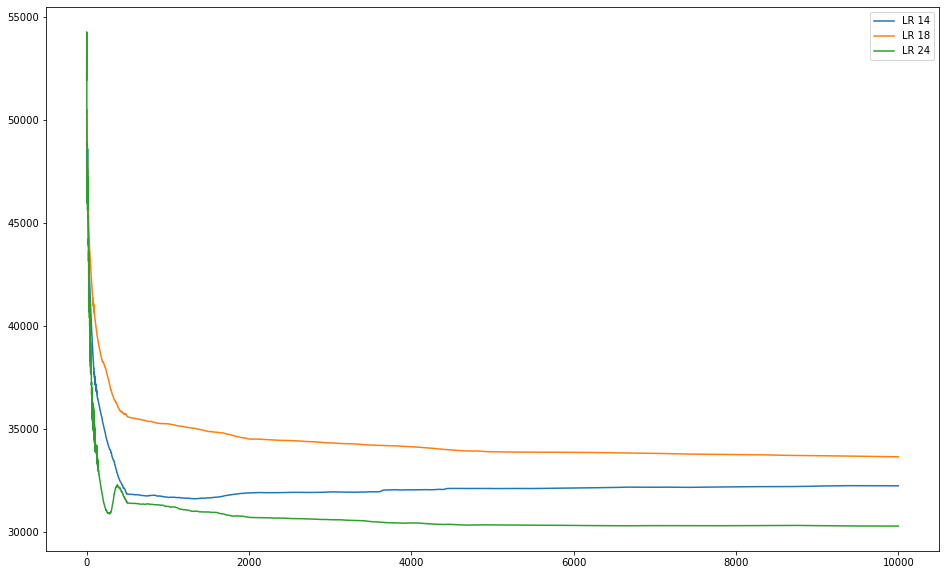

In [75]:
plt.figure(figsize=(16,10))
for i, r in enumerate(results4):
    plt.plot(r, label="LR {}".format(hidden[i]))
    plt.legend()

In [77]:
# added some manual decay to the learning rate, reducing it by 10 at 250 epochs then //2 every 500
hidden = [14, 18, 24]
results4 = []
for h in hidden:
    mlp = MLP(X_train.shape[1], y_train_wide.shape[1],
            hidden_units=h,
            epochs=10000,
            learning_rate=0.01, loss='log', 
            first_activation = 'sig', second_activation='softmax')
    mlp.fit(X_train, y_train_wide)
    results4.append(mlp.loss)

Epoch 1 Loss is 51049.60335472183
Epoch 2 Loss is 52498.34210174945
Epoch 3 Loss is 49606.623153782886
Epoch 4 Loss is 48993.93271181908
Epoch 5 Loss is 48960.78032598566
Epoch 6 Loss is 48930.950380627524
Epoch 7 Loss is 48909.51831513749
Epoch 8 Loss is 48894.408378745364
Epoch 9 Loss is 48883.91547674017
Epoch 10 Loss is 48876.60509609983
Epoch 11 Loss is 48870.55093163673
Epoch 12 Loss is 48863.006144290855
Epoch 13 Loss is 48848.99628960432
Epoch 14 Loss is 48818.82100024583
Epoch 15 Loss is 48774.491208356696
Epoch 16 Loss is 48722.75476510429
Epoch 17 Loss is 48672.425345736454
Epoch 18 Loss is 48627.79241836379
Epoch 19 Loss is 48586.05014710882
Epoch 20 Loss is 48544.92868684869
Epoch 21 Loss is 48502.478937585634
Epoch 22 Loss is 48455.59827764725
Epoch 23 Loss is 48400.659075144315
Epoch 24 Loss is 48340.12504128145
Epoch 25 Loss is 48272.55372310774
Epoch 26 Loss is 48200.41856820618
Epoch 27 Loss is 48121.42502727133
Epoch 28 Loss is 48036.67273722368
Epoch 29 Loss is 4794

<ipython-input-76-e93e52f13b37>:45: RuntimeWarning: overflow encountered in exp
  sig = (1 / (1 + np.exp(-x)))


Epoch 64 Loss is 44219.7210568511
Epoch 65 Loss is 44136.91276494516
Epoch 66 Loss is 44055.39299516262
Epoch 67 Loss is 43976.044580177775
Epoch 68 Loss is 43898.92447529123
Epoch 69 Loss is 43821.98638637699
Epoch 70 Loss is 43747.936643135785
Epoch 71 Loss is 43676.785208455716
Epoch 72 Loss is 43606.9025206684
Epoch 73 Loss is 43539.61894751656
Epoch 74 Loss is 43473.92411754291
Epoch 75 Loss is 43409.86989716336
Epoch 76 Loss is 43346.71649073713
Epoch 77 Loss is 43283.62090788784
Epoch 78 Loss is 43220.50848240642
Epoch 79 Loss is 43160.10313172805
Epoch 80 Loss is 43100.41716509866
Epoch 81 Loss is 43042.32674557889
Epoch 82 Loss is 42987.90463493798
Epoch 83 Loss is 42934.39171400132
Epoch 84 Loss is 42879.3659197773
Epoch 85 Loss is 42822.66821257584
Epoch 86 Loss is 42766.07622096416
Epoch 87 Loss is 42709.42693712021
Epoch 88 Loss is 42654.65766376726
Epoch 89 Loss is 42599.2695844339
Epoch 90 Loss is 42543.24804711184
Epoch 91 Loss is 42488.59017468535
Epoch 92 Loss is 4243

Epoch 294 Loss is 38292.61392950121
Epoch 295 Loss is 38291.87695966803
Epoch 296 Loss is 38291.147394925516
Epoch 297 Loss is 38290.36969663542
Epoch 298 Loss is 38289.49427532514
Epoch 299 Loss is 38288.48480369783
Epoch 300 Loss is 38287.32014154597
Epoch 301 Loss is 38285.9969410165
Epoch 302 Loss is 38284.531260806274
Epoch 303 Loss is 38282.95430811458
Epoch 304 Loss is 38281.305117753596
Epoch 305 Loss is 38279.63054954419
Epoch 306 Loss is 38277.98919710505
Epoch 307 Loss is 38276.44459080074
Epoch 308 Loss is 38275.05176018325
Epoch 309 Loss is 38273.850092401706
Epoch 310 Loss is 38272.8529504075
Epoch 311 Loss is 38272.02622870857
Epoch 312 Loss is 38271.29245419649
Epoch 313 Loss is 38270.57361632965
Epoch 314 Loss is 38269.82277128926
Epoch 315 Loss is 38269.02336303361
Epoch 316 Loss is 38268.17529888518
Epoch 317 Loss is 38267.28344427832
Epoch 318 Loss is 38266.352504984345
Epoch 319 Loss is 38265.38693467135
Epoch 320 Loss is 38264.39166229892
Epoch 321 Loss is 38263.3

Epoch 529 Loss is 38062.56266868343
Epoch 530 Loss is 38062.15208241189
Epoch 531 Loss is 38061.74013178812
Epoch 532 Loss is 38061.32995930771
Epoch 533 Loss is 38060.92496486421
Epoch 534 Loss is 38060.52834674022
Epoch 535 Loss is 38060.142554733924
Epoch 536 Loss is 38059.76880392101
Epoch 537 Loss is 38059.40681952179
Epoch 538 Loss is 38059.054913588225
Epoch 539 Loss is 38058.71036091904
Epoch 540 Loss is 38058.36993071658
Epoch 541 Loss is 38058.030411308886
Epoch 542 Loss is 38057.689033288385
Epoch 543 Loss is 38057.34379066207
Epoch 544 Loss is 38056.993718264835
Epoch 545 Loss is 38056.63918010094
Epoch 546 Loss is 38056.282167220095
Epoch 547 Loss is 38055.9265240017
Epoch 548 Loss is 38055.57794933013
Epoch 549 Loss is 38055.243584273005
Epoch 550 Loss is 38054.93104067226
Epoch 551 Loss is 38054.646898442705
Epoch 552 Loss is 38054.395015803435
Epoch 553 Loss is 38054.17530567676
Epoch 554 Loss is 38053.98360783079
Epoch 555 Loss is 38053.812773658305
Epoch 556 Loss is 3

Epoch 759 Loss is 37922.56638923749
Epoch 760 Loss is 37921.819565706464
Epoch 761 Loss is 37921.098338897915
Epoch 762 Loss is 37920.39928062117
Epoch 763 Loss is 37919.71878687062
Epoch 764 Loss is 37919.05345760274
Epoch 765 Loss is 37918.400116176366
Epoch 766 Loss is 37917.75563611662
Epoch 767 Loss is 37917.116737348355
Epoch 768 Loss is 37916.4798700123
Epoch 769 Loss is 37915.841253720464
Epoch 770 Loss is 37915.19709214904
Epoch 771 Loss is 37914.54393273877
Epoch 772 Loss is 37913.87909188679
Epoch 773 Loss is 37913.20103918055
Epoch 774 Loss is 37912.509648857755
Epoch 775 Loss is 37911.80627044233
Epoch 776 Loss is 37911.09361120939
Epoch 777 Loss is 37910.3754462014
Epoch 778 Loss is 37909.65619066551
Epoch 779 Loss is 37908.94039917346
Epoch 780 Loss is 37908.23228394283
Epoch 781 Loss is 37907.535344529504
Epoch 782 Loss is 37906.85216124539
Epoch 783 Loss is 37906.184347266695
Epoch 784 Loss is 37905.53261422779
Epoch 785 Loss is 37904.89689845227
Epoch 786 Loss is 3790

Epoch 989 Loss is 37740.828178013966
Epoch 990 Loss is 37739.8059571518
Epoch 991 Loss is 37738.80432797611
Epoch 992 Loss is 37737.81997590174
Epoch 993 Loss is 37736.85002014721
Epoch 994 Loss is 37735.89210247726
Epoch 995 Loss is 37734.94440400506
Epoch 996 Loss is 37734.005577391086
Epoch 997 Loss is 37733.07459437365
Epoch 998 Loss is 37732.150527370904
Epoch 999 Loss is 37731.232304064724
Epoch 1000 Loss is 37730.3184882865
Epoch 1001 Loss is 37729.40714301891
Epoch 1002 Loss is 37728.495820662436
Epoch 1003 Loss is 37728.039514671866
Epoch 1004 Loss is 37727.58211086172
Epoch 1005 Loss is 37727.12325294716
Epoch 1006 Loss is 37726.66260846712
Epoch 1007 Loss is 37726.19988612229
Epoch 1008 Loss is 37725.734854783084
Epoch 1009 Loss is 37725.267363727486
Epoch 1010 Loss is 37724.79736349674
Epoch 1011 Loss is 37724.32492653197
Epoch 1012 Loss is 37723.85026648176
Epoch 1013 Loss is 37723.37375476351
Epoch 1014 Loss is 37722.89593266361
Epoch 1015 Loss is 37722.417517029724
Epoch

Epoch 1214 Loss is 37656.48598634563
Epoch 1215 Loss is 37656.284679809185
Epoch 1216 Loss is 37656.082347519594
Epoch 1217 Loss is 37655.878748283925
Epoch 1218 Loss is 37655.67370261228
Epoch 1219 Loss is 37655.46708934066
Epoch 1220 Loss is 37655.2588378329
Epoch 1221 Loss is 37655.04891669334
Epoch 1222 Loss is 37654.837320214
Epoch 1223 Loss is 37654.62405396446
Epoch 1224 Loss is 37654.4091209814
Epoch 1225 Loss is 37654.192509911976
Epoch 1226 Loss is 37653.97418620439
Epoch 1227 Loss is 37653.75408705462
Epoch 1228 Loss is 37653.53212035576
Epoch 1229 Loss is 37653.30816743055
Epoch 1230 Loss is 37653.08208892925
Epoch 1231 Loss is 37652.85373299631
Epoch 1232 Loss is 37652.6229446832
Epoch 1233 Loss is 37652.38957560256
Epoch 1234 Loss is 37652.15349295577
Epoch 1235 Loss is 37651.91458727719
Epoch 1236 Loss is 37651.67277847987
Epoch 1237 Loss is 37651.428020019375
Epoch 1238 Loss is 37651.18030119007
Epoch 1239 Loss is 37650.92964771618
Epoch 1240 Loss is 37650.67612089557
E

Epoch 1434 Loss is 37622.03841902258
Epoch 1435 Loss is 37621.919015487336
Epoch 1436 Loss is 37621.79218654237
Epoch 1437 Loss is 37621.65746406647
Epoch 1438 Loss is 37621.51436358092
Epoch 1439 Loss is 37621.36236097699
Epoch 1440 Loss is 37621.20087695503
Epoch 1441 Loss is 37621.02927130096
Epoch 1442 Loss is 37620.846848027264
Epoch 1443 Loss is 37620.65287119212
Epoch 1444 Loss is 37620.44659008065
Epoch 1445 Loss is 37620.22727155835
Epoch 1446 Loss is 37619.99423690418
Epoch 1447 Loss is 37619.74690031792
Epoch 1448 Loss is 37619.4848065009
Epoch 1449 Loss is 37619.20766512391
Epoch 1450 Loss is 37618.91538048718
Epoch 1451 Loss is 37618.60807515378
Epoch 1452 Loss is 37618.28610673128
Epoch 1453 Loss is 37617.95007726859
Epoch 1454 Loss is 37617.60083493313
Epoch 1455 Loss is 37617.2394677643
Epoch 1456 Loss is 37616.867289404036
Epoch 1457 Loss is 37616.48581682573
Epoch 1458 Loss is 37616.09674026384
Epoch 1459 Loss is 37615.7018858222
Epoch 1460 Loss is 37615.30317162816
E

Epoch 1667 Loss is 37583.511130417515
Epoch 1668 Loss is 37583.41535959376
Epoch 1669 Loss is 37583.320093585
Epoch 1670 Loss is 37583.22532316794
Epoch 1671 Loss is 37583.13103912222
Epoch 1672 Loss is 37583.03723217158
Epoch 1673 Loss is 37582.94389293385
Epoch 1674 Loss is 37582.85101187776
Epoch 1675 Loss is 37582.758579285175
Epoch 1676 Loss is 37582.66658521755
Epoch 1677 Loss is 37582.57501948496
Epoch 1678 Loss is 37582.483871616896
Epoch 1679 Loss is 37582.39313083338
Epoch 1680 Loss is 37582.302786016175
Epoch 1681 Loss is 37582.212825679104
Epoch 1682 Loss is 37582.123237937194
Epoch 1683 Loss is 37582.0340104747
Epoch 1684 Loss is 37581.945130511675
Epoch 1685 Loss is 37581.856584769674
Epoch 1686 Loss is 37581.76835943679
Epoch 1687 Loss is 37581.6804401324
Epoch 1688 Loss is 37581.59281187269
Epoch 1689 Loss is 37581.5054590372
Epoch 1690 Loss is 37581.41836533745
Epoch 1691 Loss is 37581.33151378855
Epoch 1692 Loss is 37581.24488668431
Epoch 1693 Loss is 37581.1584655769

Epoch 1888 Loss is 37561.24726909399
Epoch 1889 Loss is 37561.18649979245
Epoch 1890 Loss is 37561.125447400336
Epoch 1891 Loss is 37561.06406209266
Epoch 1892 Loss is 37561.00229673161
Epoch 1893 Loss is 37560.940106993556
Epoch 1894 Loss is 37560.87745148408
Epoch 1895 Loss is 37560.814291840245
Epoch 1896 Loss is 37560.75059282027
Epoch 1897 Loss is 37560.686322379785
Epoch 1898 Loss is 37560.62145173501
Epoch 1899 Loss is 37560.55595541248
Epoch 1900 Loss is 37560.48981128527
Epoch 1901 Loss is 37560.423000595976
Epoch 1902 Loss is 37560.35550796647
Epoch 1903 Loss is 37560.28732139454
Epoch 1904 Loss is 37560.21843223801
Epoch 1905 Loss is 37560.1488351865
Epoch 1906 Loss is 37560.07852822122
Epoch 1907 Loss is 37560.00751256354
Epoch 1908 Loss is 37559.93579261282
Epoch 1909 Loss is 37559.8633758738
Epoch 1910 Loss is 37559.7902728747
Epoch 1911 Loss is 37559.716497076326
Epoch 1912 Loss is 37559.64206477284
Epoch 1913 Loss is 37559.566994985
Epoch 1914 Loss is 37559.49130934629


Epoch 2117 Loss is 37549.67294839961
Epoch 2118 Loss is 37549.62587444821
Epoch 2119 Loss is 37549.579073032844
Epoch 2120 Loss is 37549.53255165906
Epoch 2121 Loss is 37549.48631627361
Epoch 2122 Loss is 37549.44037123838
Epoch 2123 Loss is 37549.39471931554
Epoch 2124 Loss is 37549.34936166439
Epoch 2125 Loss is 37549.30429784919
Epoch 2126 Loss is 37549.25952585812
Epoch 2127 Loss is 37549.215042133095
Epoch 2128 Loss is 37549.1708416095
Epoch 2129 Loss is 37549.1269177655
Epoch 2130 Loss is 37549.08326267997
Epoch 2131 Loss is 37549.03986709821
Epoch 2132 Loss is 37548.9967205047
Epoch 2133 Loss is 37548.95381120115
Epoch 2134 Loss is 37548.9111263901
Epoch 2135 Loss is 37548.868652261364
Epoch 2136 Loss is 37548.826374081946
Epoch 2137 Loss is 37548.78427628709
Epoch 2138 Loss is 37548.74234257225
Epoch 2139 Loss is 37548.70055598478
Epoch 2140 Loss is 37548.6588990146
Epoch 2141 Loss is 37548.61735368301
Epoch 2142 Loss is 37548.57590162904
Epoch 2143 Loss is 37548.534524192604
E

Epoch 2350 Loss is 37533.15011181813
Epoch 2351 Loss is 37533.07248004653
Epoch 2352 Loss is 37532.995441513274
Epoch 2353 Loss is 37532.9189976248
Epoch 2354 Loss is 37532.84314935366
Epoch 2355 Loss is 37532.7678972559
Epoch 2356 Loss is 37532.693241488945
Epoch 2357 Loss is 37532.619181830014
Epoch 2358 Loss is 37532.54571769473
Epoch 2359 Loss is 37532.4728481559
Epoch 2360 Loss is 37532.40057196218
Epoch 2361 Loss is 37532.32888755669
Epoch 2362 Loss is 37532.25779309528
Epoch 2363 Loss is 37532.1872864645
Epoch 2364 Loss is 37532.11736529886
Epoch 2365 Loss is 37532.048026997865
Epoch 2366 Loss is 37531.979268742034
Epoch 2367 Loss is 37531.91108750833
Epoch 2368 Loss is 37531.84348008475
Epoch 2369 Loss is 37531.77644308412
Epoch 2370 Loss is 37531.70997295689
Epoch 2371 Loss is 37531.64406600288
Epoch 2372 Loss is 37531.57871838254
Epoch 2373 Loss is 37531.5139261265
Epoch 2374 Loss is 37531.44968514475
Epoch 2375 Loss is 37531.38599123459
Epoch 2376 Loss is 37531.32284008748
E

Epoch 2576 Loss is 37521.9934340375
Epoch 2577 Loss is 37521.94840431464
Epoch 2578 Loss is 37521.903301100356
Epoch 2579 Loss is 37521.85812729418
Epoch 2580 Loss is 37521.81288579354
Epoch 2581 Loss is 37521.767579491
Epoch 2582 Loss is 37521.72221127172
Epoch 2583 Loss is 37521.67678401058
Epoch 2584 Loss is 37521.6313005695
Epoch 2585 Loss is 37521.585763794836
Epoch 2586 Loss is 37521.54017651444
Epoch 2587 Loss is 37521.49454153524
Epoch 2588 Loss is 37521.44886164033
Epoch 2589 Loss is 37521.40313958643
Epoch 2590 Loss is 37521.357378101275
Epoch 2591 Loss is 37521.311579881025
Epoch 2592 Loss is 37521.26574758771
Epoch 2593 Loss is 37521.21988384677
Epoch 2594 Loss is 37521.17399124457
Epoch 2595 Loss is 37521.12807232621
Epoch 2596 Loss is 37521.08212959298
Epoch 2597 Loss is 37521.03616550034
Epoch 2598 Loss is 37520.9901824557
Epoch 2599 Loss is 37520.94418281636
Epoch 2600 Loss is 37520.89816888762
Epoch 2601 Loss is 37520.852142920834
Epoch 2602 Loss is 37520.8061071116
Ep

Epoch 2802 Loss is 37511.902979202976
Epoch 2803 Loss is 37511.859856461095
Epoch 2804 Loss is 37511.81675218096
Epoch 2805 Loss is 37511.77366665062
Epoch 2806 Loss is 37511.73060017074
Epoch 2807 Loss is 37511.687553055206
Epoch 2808 Loss is 37511.64452563128
Epoch 2809 Loss is 37511.601518239855
Epoch 2810 Loss is 37511.55853123585
Epoch 2811 Loss is 37511.51556498844
Epoch 2812 Loss is 37511.47261988138
Epoch 2813 Loss is 37511.42969631318
Epoch 2814 Loss is 37511.38679469751
Epoch 2815 Loss is 37511.34391546339
Epoch 2816 Loss is 37511.30105905549
Epoch 2817 Loss is 37511.25822593437
Epoch 2818 Loss is 37511.215416576735
Epoch 2819 Loss is 37511.172631475696
Epoch 2820 Loss is 37511.12987114098
Epoch 2821 Loss is 37511.08713609922
Epoch 2822 Loss is 37511.04442689416
Epoch 2823 Loss is 37511.00174408686
Epoch 2824 Loss is 37510.95908825595
Epoch 2825 Loss is 37510.916459997825
Epoch 2826 Loss is 37510.873859926905
Epoch 2827 Loss is 37510.83128867573
Epoch 2828 Loss is 37510.78874

Epoch 3031 Loss is 37504.86168730147
Epoch 3032 Loss is 37504.85593459641
Epoch 3033 Loss is 37504.85024373911
Epoch 3034 Loss is 37504.84461451833
Epoch 3035 Loss is 37504.83904671788
Epoch 3036 Loss is 37504.83354011663
Epoch 3037 Loss is 37504.828094488454
Epoch 3038 Loss is 37504.822709602195
Epoch 3039 Loss is 37504.817385221744
Epoch 3040 Loss is 37504.81212110602
Epoch 3041 Loss is 37504.80691700894
Epoch 3042 Loss is 37504.80177267939
Epoch 3043 Loss is 37504.79668786136
Epoch 3044 Loss is 37504.79166229381
Epoch 3045 Loss is 37504.786695710725
Epoch 3046 Loss is 37504.78178784115
Epoch 3047 Loss is 37504.77693840918
Epoch 3048 Loss is 37504.772147133954
Epoch 3049 Loss is 37504.76741372967
Epoch 3050 Loss is 37504.7627379056
Epoch 3051 Loss is 37504.758119366146
Epoch 3052 Loss is 37504.753557810815
Epoch 3053 Loss is 37504.7490529342
Epoch 3054 Loss is 37504.74460442604
Epoch 3055 Loss is 37504.740211971315
Epoch 3056 Loss is 37504.73587525013
Epoch 3057 Loss is 37504.7315939

Epoch 3264 Loss is 37504.3481791205
Epoch 3265 Loss is 37504.34535723156
Epoch 3266 Loss is 37504.34249934327
Epoch 3267 Loss is 37504.33960520549
Epoch 3268 Loss is 37504.33667457062
Epoch 3269 Loss is 37504.333707193655
Epoch 3270 Loss is 37504.330702832136
Epoch 3271 Loss is 37504.327661246185
Epoch 3272 Loss is 37504.324582198344
Epoch 3273 Loss is 37504.32146545382
Epoch 3274 Loss is 37504.31831078022
Epoch 3275 Loss is 37504.3151179477
Epoch 3276 Loss is 37504.31188672887
Epoch 3277 Loss is 37504.30861689883
Epoch 3278 Loss is 37504.30530823516
Epoch 3279 Loss is 37504.30196051788
Epoch 3280 Loss is 37504.29857352945
Epoch 3281 Loss is 37504.295147054756
Epoch 3282 Loss is 37504.29168088105
Epoch 3283 Loss is 37504.28817479812
Epoch 3284 Loss is 37504.284628598
Epoch 3285 Loss is 37504.2810420752
Epoch 3286 Loss is 37504.277415026605
Epoch 3287 Loss is 37504.27374725139
Epoch 3288 Loss is 37504.27003855115
Epoch 3289 Loss is 37504.26628872978
Epoch 3290 Loss is 37504.262497593474

Epoch 3487 Loss is 37502.59149677103
Epoch 3488 Loss is 37502.5783731127
Epoch 3489 Loss is 37502.56521006467
Epoch 3490 Loss is 37502.55200785634
Epoch 3491 Loss is 37502.538766719656
Epoch 3492 Loss is 37502.525486889004
Epoch 3493 Loss is 37502.51216860121
Epoch 3494 Loss is 37502.498812095684
Epoch 3495 Loss is 37502.485417614174
Epoch 3496 Loss is 37502.471985400945
Epoch 3497 Loss is 37502.458515702725
Epoch 3498 Loss is 37502.445008768664
Epoch 3499 Loss is 37502.43146485034
Epoch 3500 Loss is 37502.41788420181
Epoch 3501 Loss is 37502.404267079524
Epoch 3502 Loss is 37502.390613742326
Epoch 3503 Loss is 37502.3837736218
Epoch 3504 Loss is 37502.37692454484
Epoch 3505 Loss is 37502.37006654453
Epoch 3506 Loss is 37502.36319965405
Epoch 3507 Loss is 37502.356323906686
Epoch 3508 Loss is 37502.34943933596
Epoch 3509 Loss is 37502.342545975516
Epoch 3510 Loss is 37502.335643859085
Epoch 3511 Loss is 37502.32873302065
Epoch 3512 Loss is 37502.321813494236
Epoch 3513 Loss is 37502.31

Epoch 3713 Loss is 37500.80988876802
Epoch 3714 Loss is 37500.80206816635
Epoch 3715 Loss is 37500.79424773951
Epoch 3716 Loss is 37500.786427532905
Epoch 3717 Loss is 37500.778607591776
Epoch 3718 Loss is 37500.77078796134
Epoch 3719 Loss is 37500.762968686664
Epoch 3720 Loss is 37500.75514981283
Epoch 3721 Loss is 37500.74733138475
Epoch 3722 Loss is 37500.73951344736
Epoch 3723 Loss is 37500.73169604542
Epoch 3724 Loss is 37500.72387922367
Epoch 3725 Loss is 37500.716063026724
Epoch 3726 Loss is 37500.70824749915
Epoch 3727 Loss is 37500.70043268537
Epoch 3728 Loss is 37500.6926186298
Epoch 3729 Loss is 37500.68480537671
Epoch 3730 Loss is 37500.676992970286
Epoch 3731 Loss is 37500.66918145464
Epoch 3732 Loss is 37500.6613708738
Epoch 3733 Loss is 37500.653561271654
Epoch 3734 Loss is 37500.645752692064
Epoch 3735 Loss is 37500.63794517874
Epoch 3736 Loss is 37500.63013877531
Epoch 3737 Loss is 37500.62233352534
Epoch 3738 Loss is 37500.614529472245
Epoch 3739 Loss is 37500.6067266

Epoch 3944 Loss is 37499.08666593426
Epoch 3945 Loss is 37499.07984619149
Epoch 3946 Loss is 37499.07303373098
Epoch 3947 Loss is 37499.06622856787
Epoch 3948 Loss is 37499.05943071706
Epoch 3949 Loss is 37499.052640193455
Epoch 3950 Loss is 37499.045857011704
Epoch 3951 Loss is 37499.0390811865
Epoch 3952 Loss is 37499.03231273235
Epoch 3953 Loss is 37499.02555166364
Epoch 3954 Loss is 37499.018797994686
Epoch 3955 Loss is 37499.01205173971
Epoch 3956 Loss is 37499.00531291278
Epoch 3957 Loss is 37498.99858152787
Epoch 3958 Loss is 37498.99185759889
Epoch 3959 Loss is 37498.98514113961
Epoch 3960 Loss is 37498.97843216369
Epoch 3961 Loss is 37498.971730684716
Epoch 3962 Loss is 37498.96503671617
Epoch 3963 Loss is 37498.95835027135
Epoch 3964 Loss is 37498.95167136358
Epoch 3965 Loss is 37498.945000006024
Epoch 3966 Loss is 37498.938336211715
Epoch 3967 Loss is 37498.93167999362
Epoch 3968 Loss is 37498.925031364626
Epoch 3969 Loss is 37498.918390337465
Epoch 3970 Loss is 37498.911756

Epoch 4167 Loss is 37498.205150590926
Epoch 4168 Loss is 37498.202303693535
Epoch 4169 Loss is 37498.19945892641
Epoch 4170 Loss is 37498.19661629002
Epoch 4171 Loss is 37498.193775784835
Epoch 4172 Loss is 37498.19093741132
Epoch 4173 Loss is 37498.18810116987
Epoch 4174 Loss is 37498.18526706101
Epoch 4175 Loss is 37498.18243508517
Epoch 4176 Loss is 37498.179605242745
Epoch 4177 Loss is 37498.17677753423
Epoch 4178 Loss is 37498.17395196006
Epoch 4179 Loss is 37498.17112852063
Epoch 4180 Loss is 37498.1683072164
Epoch 4181 Loss is 37498.16548804779
Epoch 4182 Loss is 37498.162671015176
Epoch 4183 Loss is 37498.159856119026
Epoch 4184 Loss is 37498.15704335977
Epoch 4185 Loss is 37498.15423273773
Epoch 4186 Loss is 37498.15142425341
Epoch 4187 Loss is 37498.14861790716
Epoch 4188 Loss is 37498.1458136994
Epoch 4189 Loss is 37498.14301163049
Epoch 4190 Loss is 37498.14021170086
Epoch 4191 Loss is 37498.13741391089
Epoch 4192 Loss is 37498.134618260934
Epoch 4193 Loss is 37498.13182475

Epoch 4387 Loss is 37497.63062839756
Epoch 4388 Loss is 37497.628255240204
Epoch 4389 Loss is 37497.6258842333
Epoch 4390 Loss is 37497.62351537665
Epoch 4391 Loss is 37497.62114866995
Epoch 4392 Loss is 37497.618784113016
Epoch 4393 Loss is 37497.616421705556
Epoch 4394 Loss is 37497.61406144731
Epoch 4395 Loss is 37497.61170333803
Epoch 4396 Loss is 37497.60934737747
Epoch 4397 Loss is 37497.60699356536
Epoch 4398 Loss is 37497.60464190142
Epoch 4399 Loss is 37497.6022923854
Epoch 4400 Loss is 37497.59994501702
Epoch 4401 Loss is 37497.59759979602
Epoch 4402 Loss is 37497.5952567221
Epoch 4403 Loss is 37497.59291579502
Epoch 4404 Loss is 37497.590577014445
Epoch 4405 Loss is 37497.58824038016
Epoch 4406 Loss is 37497.58590589183
Epoch 4407 Loss is 37497.58357354915
Epoch 4408 Loss is 37497.5812433519
Epoch 4409 Loss is 37497.57891529973
Epoch 4410 Loss is 37497.57658939237
Epoch 4411 Loss is 37497.574265629526
Epoch 4412 Loss is 37497.57194401085
Epoch 4413 Loss is 37497.56962453608


Epoch 4617 Loss is 37497.2527750989
Epoch 4618 Loss is 37497.25177092791
Epoch 4619 Loss is 37497.250767275815
Epoch 4620 Loss is 37497.24976414247
Epoch 4621 Loss is 37497.24876152783
Epoch 4622 Loss is 37497.24775943185
Epoch 4623 Loss is 37497.2467578544
Epoch 4624 Loss is 37497.24575679545
Epoch 4625 Loss is 37497.24475625492
Epoch 4626 Loss is 37497.243756232696
Epoch 4627 Loss is 37497.24275672875
Epoch 4628 Loss is 37497.24175774299
Epoch 4629 Loss is 37497.24075927532
Epoch 4630 Loss is 37497.2397613257
Epoch 4631 Loss is 37497.23876389404
Epoch 4632 Loss is 37497.23776698029
Epoch 4633 Loss is 37497.236770584306
Epoch 4634 Loss is 37497.235774706074
Epoch 4635 Loss is 37497.2347793455
Epoch 4636 Loss is 37497.23378450251
Epoch 4637 Loss is 37497.23279017701
Epoch 4638 Loss is 37497.23179636898
Epoch 4639 Loss is 37497.23080307828
Epoch 4640 Loss is 37497.22981030485
Epoch 4641 Loss is 37497.22881804864
Epoch 4642 Loss is 37497.22782630955
Epoch 4643 Loss is 37497.22683508752
E

Epoch 4847 Loss is 37497.03532284642
Epoch 4848 Loss is 37497.03443591479
Epoch 4849 Loss is 37497.03354948325
Epoch 4850 Loss is 37497.0326635516
Epoch 4851 Loss is 37497.03177811983
Epoch 4852 Loss is 37497.030893187846
Epoch 4853 Loss is 37497.03000875553
Epoch 4854 Loss is 37497.02912482282
Epoch 4855 Loss is 37497.028241389635
Epoch 4856 Loss is 37497.02735845585
Epoch 4857 Loss is 37497.026476021405
Epoch 4858 Loss is 37497.02559408622
Epoch 4859 Loss is 37497.02471265019
Epoch 4860 Loss is 37497.02383171322
Epoch 4861 Loss is 37497.022951275234
Epoch 4862 Loss is 37497.02207133616
Epoch 4863 Loss is 37497.021191895896
Epoch 4864 Loss is 37497.02031295436
Epoch 4865 Loss is 37497.01943451144
Epoch 4866 Loss is 37497.01855656708
Epoch 4867 Loss is 37497.017679121185
Epoch 4868 Loss is 37497.016802173646
Epoch 4869 Loss is 37497.015925724416
Epoch 4870 Loss is 37497.015049773356
Epoch 4871 Loss is 37497.014174320415
Epoch 4872 Loss is 37497.01329936549
Epoch 4873 Loss is 37497.0124

Epoch 5077 Loss is 37496.87370150863
Epoch 5078 Loss is 37496.87330529177
Epoch 5079 Loss is 37496.872909195656
Epoch 5080 Loss is 37496.872513220274
Epoch 5081 Loss is 37496.87211736563
Epoch 5082 Loss is 37496.871721631695
Epoch 5083 Loss is 37496.87132601844
Epoch 5084 Loss is 37496.87093052588
Epoch 5085 Loss is 37496.87053515403
Epoch 5086 Loss is 37496.87013990283
Epoch 5087 Loss is 37496.86974477229
Epoch 5088 Loss is 37496.86934976238
Epoch 5089 Loss is 37496.86895487313
Epoch 5090 Loss is 37496.868560104485
Epoch 5091 Loss is 37496.86816545645
Epoch 5092 Loss is 37496.86777092901
Epoch 5093 Loss is 37496.86737652219
Epoch 5094 Loss is 37496.86698223592
Epoch 5095 Loss is 37496.86658807025
Epoch 5096 Loss is 37496.86619402511
Epoch 5097 Loss is 37496.86580010053
Epoch 5098 Loss is 37496.86540629647
Epoch 5099 Loss is 37496.86501261294
Epoch 5100 Loss is 37496.864619049935
Epoch 5101 Loss is 37496.8642256074
Epoch 5102 Loss is 37496.86383228539
Epoch 5103 Loss is 37496.863439083

Epoch 5303 Loss is 37496.78720533857
Epoch 5304 Loss is 37496.7868361276
Epoch 5305 Loss is 37496.78646703485
Epoch 5306 Loss is 37496.786098060344
Epoch 5307 Loss is 37496.785729204035
Epoch 5308 Loss is 37496.785360465954
Epoch 5309 Loss is 37496.78499184604
Epoch 5310 Loss is 37496.78462334433
Epoch 5311 Loss is 37496.784254960774
Epoch 5312 Loss is 37496.78388669541
Epoch 5313 Loss is 37496.783518548174
Epoch 5314 Loss is 37496.78315051907
Epoch 5315 Loss is 37496.78278260811
Epoch 5316 Loss is 37496.782414815265
Epoch 5317 Loss is 37496.78204714052
Epoch 5318 Loss is 37496.781679583866
Epoch 5319 Loss is 37496.781312145285
Epoch 5320 Loss is 37496.78094482479
Epoch 5321 Loss is 37496.78057762236
Epoch 5322 Loss is 37496.78021053798
Epoch 5323 Loss is 37496.77984357165
Epoch 5324 Loss is 37496.77947672333
Epoch 5325 Loss is 37496.779109993025
Epoch 5326 Loss is 37496.778743380746
Epoch 5327 Loss is 37496.77837688643
Epoch 5328 Loss is 37496.778010510134
Epoch 5329 Loss is 37496.777

Epoch 5530 Loss is 37496.711215510106
Epoch 5531 Loss is 37496.71104335778
Epoch 5532 Loss is 37496.7108712344
Epoch 5533 Loss is 37496.71069914001
Epoch 5534 Loss is 37496.71052707461
Epoch 5535 Loss is 37496.71035503819
Epoch 5536 Loss is 37496.71018303072
Epoch 5537 Loss is 37496.71001105223
Epoch 5538 Loss is 37496.709839102696
Epoch 5539 Loss is 37496.70966718216
Epoch 5540 Loss is 37496.70949529056
Epoch 5541 Loss is 37496.70932342795
Epoch 5542 Loss is 37496.70915159428
Epoch 5543 Loss is 37496.7089797896
Epoch 5544 Loss is 37496.70880801388
Epoch 5545 Loss is 37496.7086362671
Epoch 5546 Loss is 37496.70846454928
Epoch 5547 Loss is 37496.708292860436
Epoch 5548 Loss is 37496.70812120054
Epoch 5549 Loss is 37496.70794956959
Epoch 5550 Loss is 37496.707777967604
Epoch 5551 Loss is 37496.70760639458
Epoch 5552 Loss is 37496.7074348505
Epoch 5553 Loss is 37496.707263335345
Epoch 5554 Loss is 37496.70709184916
Epoch 5555 Loss is 37496.70692039192
Epoch 5556 Loss is 37496.706748963625

Epoch 5757 Loss is 37496.67287763013
Epoch 5758 Loss is 37496.67271202095
Epoch 5759 Loss is 37496.67254644044
Epoch 5760 Loss is 37496.672380888616
Epoch 5761 Loss is 37496.67221536544
Epoch 5762 Loss is 37496.67204987093
Epoch 5763 Loss is 37496.67188440511
Epoch 5764 Loss is 37496.671718967926
Epoch 5765 Loss is 37496.67155355942
Epoch 5766 Loss is 37496.67138817956
Epoch 5767 Loss is 37496.67122282837
Epoch 5768 Loss is 37496.67105750584
Epoch 5769 Loss is 37496.67089221195
Epoch 5770 Loss is 37496.67072694672
Epoch 5771 Loss is 37496.67056171015
Epoch 5772 Loss is 37496.67039650223
Epoch 5773 Loss is 37496.670231322976
Epoch 5774 Loss is 37496.670066172366
Epoch 5775 Loss is 37496.66990105037
Epoch 5776 Loss is 37496.66973595706
Epoch 5777 Loss is 37496.66957089238
Epoch 5778 Loss is 37496.66940585635
Epoch 5779 Loss is 37496.669240848954
Epoch 5780 Loss is 37496.6690758702
Epoch 5781 Loss is 37496.66891092009
Epoch 5782 Loss is 37496.6687459986
Epoch 5783 Loss is 37496.6685811057

Epoch 5984 Loss is 37496.63601714617
Epoch 5985 Loss is 37496.63585801022
Epoch 5986 Loss is 37496.635698902624
Epoch 5987 Loss is 37496.6355398234
Epoch 5988 Loss is 37496.63538077252
Epoch 5989 Loss is 37496.63522175002
Epoch 5990 Loss is 37496.635062755864
Epoch 5991 Loss is 37496.63490379006
Epoch 5992 Loss is 37496.63474485263
Epoch 5993 Loss is 37496.634585943524
Epoch 5994 Loss is 37496.63442706278
Epoch 5995 Loss is 37496.63426821037
Epoch 5996 Loss is 37496.63410938633
Epoch 5997 Loss is 37496.633950590636
Epoch 5998 Loss is 37496.63379182328
Epoch 5999 Loss is 37496.63363308427
Epoch 6000 Loss is 37496.63347437359
Epoch 6001 Loss is 37496.63331569126
Epoch 6002 Loss is 37496.633157037286
Epoch 6003 Loss is 37496.63307772069
Epoch 6004 Loss is 37496.6329984112
Epoch 6005 Loss is 37496.6329191088
Epoch 6006 Loss is 37496.63283981345
Epoch 6007 Loss is 37496.63276052521
Epoch 6008 Loss is 37496.632681244046
Epoch 6009 Loss is 37496.63260196996
Epoch 6010 Loss is 37496.6325227029

Epoch 6213 Loss is 37496.61657792997
Epoch 6214 Loss is 37496.61650010442
Epoch 6215 Loss is 37496.616422285915
Epoch 6216 Loss is 37496.61634447445
Epoch 6217 Loss is 37496.61626667005
Epoch 6218 Loss is 37496.61618887268
Epoch 6219 Loss is 37496.61611108237
Epoch 6220 Loss is 37496.6160332991
Epoch 6221 Loss is 37496.61595552288
Epoch 6222 Loss is 37496.61587775369
Epoch 6223 Loss is 37496.615799991574
Epoch 6224 Loss is 37496.61572223651
Epoch 6225 Loss is 37496.61564448848
Epoch 6226 Loss is 37496.61556674747
Epoch 6227 Loss is 37496.61548901353
Epoch 6228 Loss is 37496.61541128664
Epoch 6229 Loss is 37496.6153335668
Epoch 6230 Loss is 37496.61525585398
Epoch 6231 Loss is 37496.61517814823
Epoch 6232 Loss is 37496.615100449526
Epoch 6233 Loss is 37496.61502275786
Epoch 6234 Loss is 37496.61494507324
Epoch 6235 Loss is 37496.61486739565
Epoch 6236 Loss is 37496.614789725114
Epoch 6237 Loss is 37496.61471206164
Epoch 6238 Loss is 37496.614634405196
Epoch 6239 Loss is 37496.6145567558

Epoch 6444 Loss is 37496.59878711797
Epoch 6445 Loss is 37496.59871091602
Epoch 6446 Loss is 37496.59863472109
Epoch 6447 Loss is 37496.59855853315
Epoch 6448 Loss is 37496.59848235222
Epoch 6449 Loss is 37496.59840617831
Epoch 6450 Loss is 37496.59833001138
Epoch 6451 Loss is 37496.5982538515
Epoch 6452 Loss is 37496.598177698594
Epoch 6453 Loss is 37496.59810155272
Epoch 6454 Loss is 37496.59802541384
Epoch 6455 Loss is 37496.597949281975
Epoch 6456 Loss is 37496.597873157094
Epoch 6457 Loss is 37496.59779703925
Epoch 6458 Loss is 37496.597720928396
Epoch 6459 Loss is 37496.597644824564
Epoch 6460 Loss is 37496.59756872771
Epoch 6461 Loss is 37496.59749263789
Epoch 6462 Loss is 37496.59741655506
Epoch 6463 Loss is 37496.59734047923
Epoch 6464 Loss is 37496.59726441042
Epoch 6465 Loss is 37496.5971883486
Epoch 6466 Loss is 37496.597112293806
Epoch 6467 Loss is 37496.597036246014
Epoch 6468 Loss is 37496.596960205214
Epoch 6469 Loss is 37496.59688417141
Epoch 6470 Loss is 37496.5968081

Epoch 6675 Loss is 37496.5878485062
Epoch 6676 Loss is 37496.58781090977
Epoch 6677 Loss is 37496.5877733151
Epoch 6678 Loss is 37496.587735722154
Epoch 6679 Loss is 37496.58769813096
Epoch 6680 Loss is 37496.58766054153
Epoch 6681 Loss is 37496.58762295382
Epoch 6682 Loss is 37496.58758536787
Epoch 6683 Loss is 37496.58754778366
Epoch 6684 Loss is 37496.58751020121
Epoch 6685 Loss is 37496.58747262049
Epoch 6686 Loss is 37496.58743504154
Epoch 6687 Loss is 37496.58739746432
Epoch 6688 Loss is 37496.587359888836
Epoch 6689 Loss is 37496.587322315085
Epoch 6690 Loss is 37496.587284743124
Epoch 6691 Loss is 37496.58724717287
Epoch 6692 Loss is 37496.58720960438
Epoch 6693 Loss is 37496.58717203762
Epoch 6694 Loss is 37496.58713447263
Epoch 6695 Loss is 37496.58709690937
Epoch 6696 Loss is 37496.58705934785
Epoch 6697 Loss is 37496.58702178809
Epoch 6698 Loss is 37496.58698423007
Epoch 6699 Loss is 37496.586946673786
Epoch 6700 Loss is 37496.58690911925
Epoch 6701 Loss is 37496.5868715664

Epoch 6897 Loss is 37496.57954488935
Epoch 6898 Loss is 37496.57950767999
Epoch 6899 Loss is 37496.579470472374
Epoch 6900 Loss is 37496.57943326648
Epoch 6901 Loss is 37496.57939606235
Epoch 6902 Loss is 37496.57935885992
Epoch 6903 Loss is 37496.57932165927
Epoch 6904 Loss is 37496.57928446034
Epoch 6905 Loss is 37496.57924726316
Epoch 6906 Loss is 37496.57921006773
Epoch 6907 Loss is 37496.57917287402
Epoch 6908 Loss is 37496.579135682085
Epoch 6909 Loss is 37496.57909849185
Epoch 6910 Loss is 37496.57906130338
Epoch 6911 Loss is 37496.57902411663
Epoch 6912 Loss is 37496.57898693165
Epoch 6913 Loss is 37496.57894974839
Epoch 6914 Loss is 37496.57891256689
Epoch 6915 Loss is 37496.57887538711
Epoch 6916 Loss is 37496.57883820908
Epoch 6917 Loss is 37496.57880103278
Epoch 6918 Loss is 37496.578763858226
Epoch 6919 Loss is 37496.57872668543
Epoch 6920 Loss is 37496.578689514354
Epoch 6921 Loss is 37496.57865234504
Epoch 6922 Loss is 37496.57861517743
Epoch 6923 Loss is 37496.578578011

Epoch 7130 Loss is 37496.573281203404
Epoch 7131 Loss is 37496.573262745456
Epoch 7132 Loss is 37496.57324428794
Epoch 7133 Loss is 37496.57322583086
Epoch 7134 Loss is 37496.57320737422
Epoch 7135 Loss is 37496.57318891801
Epoch 7136 Loss is 37496.57317046222
Epoch 7137 Loss is 37496.57315200687
Epoch 7138 Loss is 37496.57313355196
Epoch 7139 Loss is 37496.57311509749
Epoch 7140 Loss is 37496.573096643464
Epoch 7141 Loss is 37496.573078189846
Epoch 7142 Loss is 37496.57305973668
Epoch 7143 Loss is 37496.57304128395
Epoch 7144 Loss is 37496.57302283163
Epoch 7145 Loss is 37496.57300437978
Epoch 7146 Loss is 37496.57298592834
Epoch 7147 Loss is 37496.57296747733
Epoch 7148 Loss is 37496.57294902677
Epoch 7149 Loss is 37496.57293057663
Epoch 7150 Loss is 37496.572912126925
Epoch 7151 Loss is 37496.57289367767
Epoch 7152 Loss is 37496.572875228834
Epoch 7153 Loss is 37496.57285678046
Epoch 7154 Loss is 37496.57283833249
Epoch 7155 Loss is 37496.57281988496
Epoch 7156 Loss is 37496.5728014

Epoch 7354 Loss is 37496.5691574658
Epoch 7355 Loss is 37496.56913910507
Epoch 7356 Loss is 37496.56912074478
Epoch 7357 Loss is 37496.569102384936
Epoch 7358 Loss is 37496.56908402551
Epoch 7359 Loss is 37496.56906566652
Epoch 7360 Loss is 37496.56904730795
Epoch 7361 Loss is 37496.56902894982
Epoch 7362 Loss is 37496.56901059214
Epoch 7363 Loss is 37496.56899223489
Epoch 7364 Loss is 37496.568973878064
Epoch 7365 Loss is 37496.568955521674
Epoch 7366 Loss is 37496.56893716573
Epoch 7367 Loss is 37496.5689188102
Epoch 7368 Loss is 37496.56890045513
Epoch 7369 Loss is 37496.56888210046
Epoch 7370 Loss is 37496.56886374624
Epoch 7371 Loss is 37496.568845392445
Epoch 7372 Loss is 37496.56882703911
Epoch 7373 Loss is 37496.56880868619
Epoch 7374 Loss is 37496.568790333695
Epoch 7375 Loss is 37496.568771981634
Epoch 7376 Loss is 37496.568753630025
Epoch 7377 Loss is 37496.56873527884
Epoch 7378 Loss is 37496.56871692811
Epoch 7379 Loss is 37496.56869857779
Epoch 7380 Loss is 37496.56868022

Epoch 7579 Loss is 37496.56574068993
Epoch 7580 Loss is 37496.56573154992
Epoch 7581 Loss is 37496.56572241002
Epoch 7582 Loss is 37496.56571327025
Epoch 7583 Loss is 37496.56570413056
Epoch 7584 Loss is 37496.565694991
Epoch 7585 Loss is 37496.56568585154
Epoch 7586 Loss is 37496.56567671221
Epoch 7587 Loss is 37496.565667572955
Epoch 7588 Loss is 37496.56565843381
Epoch 7589 Loss is 37496.56564929481
Epoch 7590 Loss is 37496.56564015587
Epoch 7591 Loss is 37496.56563101708
Epoch 7592 Loss is 37496.565621878384
Epoch 7593 Loss is 37496.56561273978
Epoch 7594 Loss is 37496.565603601295
Epoch 7595 Loss is 37496.565594462925
Epoch 7596 Loss is 37496.565585324664
Epoch 7597 Loss is 37496.5655761865
Epoch 7598 Loss is 37496.56556704846
Epoch 7599 Loss is 37496.56555791051
Epoch 7600 Loss is 37496.56554877268
Epoch 7601 Loss is 37496.56553963494
Epoch 7602 Loss is 37496.56553049735
Epoch 7603 Loss is 37496.56552135984
Epoch 7604 Loss is 37496.56551222242
Epoch 7605 Loss is 37496.56550308515

Epoch 7801 Loss is 37496.56371426632
Epoch 7802 Loss is 37496.56370515038
Epoch 7803 Loss is 37496.56369603451
Epoch 7804 Loss is 37496.563686918744
Epoch 7805 Loss is 37496.56367780312
Epoch 7806 Loss is 37496.56366868758
Epoch 7807 Loss is 37496.563659572166
Epoch 7808 Loss is 37496.56365045685
Epoch 7809 Loss is 37496.56364134164
Epoch 7810 Loss is 37496.56363222655
Epoch 7811 Loss is 37496.56362311154
Epoch 7812 Loss is 37496.56361399667
Epoch 7813 Loss is 37496.5636048819
Epoch 7814 Loss is 37496.563595767235
Epoch 7815 Loss is 37496.56358665268
Epoch 7816 Loss is 37496.56357753823
Epoch 7817 Loss is 37496.563568423895
Epoch 7818 Loss is 37496.56355930965
Epoch 7819 Loss is 37496.56355019554
Epoch 7820 Loss is 37496.56354108151
Epoch 7821 Loss is 37496.56353196762
Epoch 7822 Loss is 37496.56352285381
Epoch 7823 Loss is 37496.56351374012
Epoch 7824 Loss is 37496.56350462653
Epoch 7825 Loss is 37496.56349551306
Epoch 7826 Loss is 37496.5634863997
Epoch 7827 Loss is 37496.56347728642

Epoch 8028 Loss is 37496.56176591601
Epoch 8029 Loss is 37496.5617613696
Epoch 8030 Loss is 37496.56175682321
Epoch 8031 Loss is 37496.56175227684
Epoch 8032 Loss is 37496.5617477305
Epoch 8033 Loss is 37496.5617431842
Epoch 8034 Loss is 37496.561738637916
Epoch 8035 Loss is 37496.561734091636
Epoch 8036 Loss is 37496.561729545414
Epoch 8037 Loss is 37496.56172499922
Epoch 8038 Loss is 37496.56172045304
Epoch 8039 Loss is 37496.561715906886
Epoch 8040 Loss is 37496.561711360766
Epoch 8041 Loss is 37496.561706814675
Epoch 8042 Loss is 37496.56170226861
Epoch 8043 Loss is 37496.56169772254
Epoch 8044 Loss is 37496.56169317655
Epoch 8045 Loss is 37496.56168863055
Epoch 8046 Loss is 37496.56168408459
Epoch 8047 Loss is 37496.56167953865
Epoch 8048 Loss is 37496.56167499276
Epoch 8049 Loss is 37496.56167044687
Epoch 8050 Loss is 37496.56166590103
Epoch 8051 Loss is 37496.561661355176
Epoch 8052 Loss is 37496.5616568094
Epoch 8053 Loss is 37496.56165226363
Epoch 8054 Loss is 37496.5616477178

Epoch 8249 Loss is 37496.56076181439
Epoch 8250 Loss is 37496.56075727395
Epoch 8251 Loss is 37496.56075273353
Epoch 8252 Loss is 37496.56074819314
Epoch 8253 Loss is 37496.560743652764
Epoch 8254 Loss is 37496.56073911244
Epoch 8255 Loss is 37496.560734572115
Epoch 8256 Loss is 37496.560730031844
Epoch 8257 Loss is 37496.56072549158
Epoch 8258 Loss is 37496.56072095135
Epoch 8259 Loss is 37496.56071641116
Epoch 8260 Loss is 37496.560711870974
Epoch 8261 Loss is 37496.560707330835
Epoch 8262 Loss is 37496.56070279071
Epoch 8263 Loss is 37496.560698250614
Epoch 8264 Loss is 37496.56069371056
Epoch 8265 Loss is 37496.5606891705
Epoch 8266 Loss is 37496.56068463049
Epoch 8267 Loss is 37496.56068009051
Epoch 8268 Loss is 37496.56067555056
Epoch 8269 Loss is 37496.56067101062
Epoch 8270 Loss is 37496.5606664707
Epoch 8271 Loss is 37496.56066193083
Epoch 8272 Loss is 37496.56065739098
Epoch 8273 Loss is 37496.56065285115
Epoch 8274 Loss is 37496.56064831136
Epoch 8275 Loss is 37496.560643771

Epoch 8478 Loss is 37496.55972275784
Epoch 8479 Loss is 37496.55971822358
Epoch 8480 Loss is 37496.55971368933
Epoch 8481 Loss is 37496.55970915513
Epoch 8482 Loss is 37496.55970462096
Epoch 8483 Loss is 37496.55970008681
Epoch 8484 Loss is 37496.55969555271
Epoch 8485 Loss is 37496.55969101859
Epoch 8486 Loss is 37496.55968648453
Epoch 8487 Loss is 37496.55968195048
Epoch 8488 Loss is 37496.559677416466
Epoch 8489 Loss is 37496.55967288248
Epoch 8490 Loss is 37496.55966834852
Epoch 8491 Loss is 37496.559663814594
Epoch 8492 Loss is 37496.55965928068
Epoch 8493 Loss is 37496.559654746794
Epoch 8494 Loss is 37496.55965021294
Epoch 8495 Loss is 37496.559645679125
Epoch 8496 Loss is 37496.55964114532
Epoch 8497 Loss is 37496.55963661156
Epoch 8498 Loss is 37496.559632077806
Epoch 8499 Loss is 37496.559627544106
Epoch 8500 Loss is 37496.5596230104
Epoch 8501 Loss is 37496.55961847675
Epoch 8502 Loss is 37496.559613943115
Epoch 8503 Loss is 37496.5596116763
Epoch 8504 Loss is 37496.55960940

Epoch 8702 Loss is 37496.55916071592
Epoch 8703 Loss is 37496.55915845046
Epoch 8704 Loss is 37496.559156185
Epoch 8705 Loss is 37496.55915391955
Epoch 8706 Loss is 37496.55915165413
Epoch 8707 Loss is 37496.55914938869
Epoch 8708 Loss is 37496.559147123255
Epoch 8709 Loss is 37496.55914485785
Epoch 8710 Loss is 37496.559142592436
Epoch 8711 Loss is 37496.55914032703
Epoch 8712 Loss is 37496.559138061646
Epoch 8713 Loss is 37496.55913579625
Epoch 8714 Loss is 37496.55913353086
Epoch 8715 Loss is 37496.55913126548
Epoch 8716 Loss is 37496.55912900011
Epoch 8717 Loss is 37496.559126734755
Epoch 8718 Loss is 37496.55912446941
Epoch 8719 Loss is 37496.55912220403
Epoch 8720 Loss is 37496.559119938705
Epoch 8721 Loss is 37496.559117673365
Epoch 8722 Loss is 37496.559115408054
Epoch 8723 Loss is 37496.55911314272
Epoch 8724 Loss is 37496.559110877395
Epoch 8725 Loss is 37496.55910861209
Epoch 8726 Loss is 37496.55910634679
Epoch 8727 Loss is 37496.55910408149
Epoch 8728 Loss is 37496.5591018

Epoch 8923 Loss is 37496.558660214
Epoch 8924 Loss is 37496.55865795004
Epoch 8925 Loss is 37496.55865568608
Epoch 8926 Loss is 37496.55865342213
Epoch 8927 Loss is 37496.55865115819
Epoch 8928 Loss is 37496.55864889426
Epoch 8929 Loss is 37496.55864663032
Epoch 8930 Loss is 37496.55864436639
Epoch 8931 Loss is 37496.558642102485
Epoch 8932 Loss is 37496.558639838564
Epoch 8933 Loss is 37496.558637574664
Epoch 8934 Loss is 37496.55863531077
Epoch 8935 Loss is 37496.55863304687
Epoch 8936 Loss is 37496.558630782994
Epoch 8937 Loss is 37496.55862851912
Epoch 8938 Loss is 37496.558626255246
Epoch 8939 Loss is 37496.5586239914
Epoch 8940 Loss is 37496.55862172751
Epoch 8941 Loss is 37496.55861946366
Epoch 8942 Loss is 37496.55861719984
Epoch 8943 Loss is 37496.558614935995
Epoch 8944 Loss is 37496.55861267216
Epoch 8945 Loss is 37496.55861040834
Epoch 8946 Loss is 37496.55860814452
Epoch 8947 Loss is 37496.5586058807
Epoch 8948 Loss is 37496.55860361692
Epoch 8949 Loss is 37496.55860135312

Epoch 9147 Loss is 37496.55831730025
Epoch 9148 Loss is 37496.55831616879
Epoch 9149 Loss is 37496.558315037306
Epoch 9150 Loss is 37496.558313905836
Epoch 9151 Loss is 37496.55831277439
Epoch 9152 Loss is 37496.5583116429
Epoch 9153 Loss is 37496.55831051145
Epoch 9154 Loss is 37496.55830937999
Epoch 9155 Loss is 37496.558308248525
Epoch 9156 Loss is 37496.55830711707
Epoch 9157 Loss is 37496.55830598561
Epoch 9158 Loss is 37496.55830485415
Epoch 9159 Loss is 37496.5583037227
Epoch 9160 Loss is 37496.55830259125
Epoch 9161 Loss is 37496.558301459794
Epoch 9162 Loss is 37496.55830032835
Epoch 9163 Loss is 37496.55829919692
Epoch 9164 Loss is 37496.55829806544
Epoch 9165 Loss is 37496.558296934
Epoch 9166 Loss is 37496.55829580258
Epoch 9167 Loss is 37496.55829467112
Epoch 9168 Loss is 37496.55829353969
Epoch 9169 Loss is 37496.55829240825
Epoch 9170 Loss is 37496.55829127682
Epoch 9171 Loss is 37496.55829014538
Epoch 9172 Loss is 37496.55828901395
Epoch 9173 Loss is 37496.55828788253
E

Epoch 9376 Loss is 37496.558058237184
Epoch 9377 Loss is 37496.55805710609
Epoch 9378 Loss is 37496.55805597503
Epoch 9379 Loss is 37496.55805484395
Epoch 9380 Loss is 37496.55805371287
Epoch 9381 Loss is 37496.558052581786
Epoch 9382 Loss is 37496.55805145072
Epoch 9383 Loss is 37496.55805031961
Epoch 9384 Loss is 37496.55804918856
Epoch 9385 Loss is 37496.558048057486
Epoch 9386 Loss is 37496.558046926424
Epoch 9387 Loss is 37496.55804579535
Epoch 9388 Loss is 37496.55804466429
Epoch 9389 Loss is 37496.558043533216
Epoch 9390 Loss is 37496.558042402154
Epoch 9391 Loss is 37496.55804127108
Epoch 9392 Loss is 37496.55804014003
Epoch 9393 Loss is 37496.55803900897
Epoch 9394 Loss is 37496.558037877905
Epoch 9395 Loss is 37496.558036746865
Epoch 9396 Loss is 37496.558035615795
Epoch 9397 Loss is 37496.55803448475
Epoch 9398 Loss is 37496.5580333537
Epoch 9399 Loss is 37496.55803222265
Epoch 9400 Loss is 37496.558031091605
Epoch 9401 Loss is 37496.558029960564
Epoch 9402 Loss is 37496.558

Epoch 9604 Loss is 37496.55785806134
Epoch 9605 Loss is 37496.557857495936
Epoch 9606 Loss is 37496.557856930536
Epoch 9607 Loss is 37496.55785636515
Epoch 9608 Loss is 37496.55785579975
Epoch 9609 Loss is 37496.55785523437
Epoch 9610 Loss is 37496.55785466897
Epoch 9611 Loss is 37496.55785410359
Epoch 9612 Loss is 37496.557853538194
Epoch 9613 Loss is 37496.5578529728
Epoch 9614 Loss is 37496.55785240741
Epoch 9615 Loss is 37496.557851842015
Epoch 9616 Loss is 37496.55785127663
Epoch 9617 Loss is 37496.557850711244
Epoch 9618 Loss is 37496.55785014585
Epoch 9619 Loss is 37496.55784958046
Epoch 9620 Loss is 37496.557849015066
Epoch 9621 Loss is 37496.557848449695
Epoch 9622 Loss is 37496.5578478843
Epoch 9623 Loss is 37496.55784731892
Epoch 9624 Loss is 37496.55784675352
Epoch 9625 Loss is 37496.55784618816
Epoch 9626 Loss is 37496.55784562277
Epoch 9627 Loss is 37496.55784505738
Epoch 9628 Loss is 37496.55784449201
Epoch 9629 Loss is 37496.55784392661
Epoch 9630 Loss is 37496.55784336

Epoch 9829 Loss is 37496.557730858425
Epoch 9830 Loss is 37496.55773029312
Epoch 9831 Loss is 37496.5577297278
Epoch 9832 Loss is 37496.557729162516
Epoch 9833 Loss is 37496.557728597225
Epoch 9834 Loss is 37496.55772803192
Epoch 9835 Loss is 37496.55772746663
Epoch 9836 Loss is 37496.55772690134
Epoch 9837 Loss is 37496.55772633605
Epoch 9838 Loss is 37496.55772577074
Epoch 9839 Loss is 37496.55772520545
Epoch 9840 Loss is 37496.55772464018
Epoch 9841 Loss is 37496.55772407486
Epoch 9842 Loss is 37496.55772350957
Epoch 9843 Loss is 37496.55772294427
Epoch 9844 Loss is 37496.55772237898
Epoch 9845 Loss is 37496.55772181369
Epoch 9846 Loss is 37496.5577212484
Epoch 9847 Loss is 37496.55772068311
Epoch 9848 Loss is 37496.55772011781
Epoch 9849 Loss is 37496.557719552526
Epoch 9850 Loss is 37496.557718987235
Epoch 9851 Loss is 37496.55771842195
Epoch 9852 Loss is 37496.55771785666
Epoch 9853 Loss is 37496.55771729136
Epoch 9854 Loss is 37496.55771672608
Epoch 9855 Loss is 37496.5577161607

Epoch 62 Loss is 39775.406864386045
Epoch 63 Loss is 39705.72831952416
Epoch 64 Loss is 39625.752201980315
Epoch 65 Loss is 39552.38287704979
Epoch 66 Loss is 39472.826148683474
Epoch 67 Loss is 39400.32562800256
Epoch 68 Loss is 39324.323270486435
Epoch 69 Loss is 39252.70038395736
Epoch 70 Loss is 39180.9130874197
Epoch 71 Loss is 39112.85213726413
Epoch 72 Loss is 39043.75163793069
Epoch 73 Loss is 38976.43021341473
Epoch 74 Loss is 38908.57504634531
Epoch 75 Loss is 38840.75659392136
Epoch 76 Loss is 38772.4841531996
Epoch 77 Loss is 38704.946226615524
Epoch 78 Loss is 38638.57521534332
Epoch 79 Loss is 38573.78883094579
Epoch 80 Loss is 38511.0434311558
Epoch 81 Loss is 38449.52127974598
Epoch 82 Loss is 38387.94328192652
Epoch 83 Loss is 38327.24779801927
Epoch 84 Loss is 38268.64152275614
Epoch 85 Loss is 38212.18652490821
Epoch 86 Loss is 38155.79299777491
Epoch 87 Loss is 38100.26255279146
Epoch 88 Loss is 38046.129905211164
Epoch 89 Loss is 37993.33044256275
Epoch 90 Loss is 

Epoch 292 Loss is 33510.83665880773
Epoch 293 Loss is 33509.50224993838
Epoch 294 Loss is 33508.09528301985
Epoch 295 Loss is 33506.61182709703
Epoch 296 Loss is 33505.0525589229
Epoch 297 Loss is 33503.42353796443
Epoch 298 Loss is 33501.73659414998
Epoch 299 Loss is 33500.00904634237
Epoch 300 Loss is 33498.262492142836
Epoch 301 Loss is 33496.520615982125
Epoch 302 Loss is 33494.80633954661
Epoch 303 Loss is 33493.13899535665
Epoch 304 Loss is 33491.53229604345
Epoch 305 Loss is 33489.99360836655
Epoch 306 Loss is 33488.52456458085
Epoch 307 Loss is 33487.12261095375
Epoch 308 Loss is 33485.782894613716
Epoch 309 Loss is 33484.49995294451
Epoch 310 Loss is 33483.2688844666
Epoch 311 Loss is 33482.08590069819
Epoch 312 Loss is 33480.94829894485
Epoch 313 Loss is 33479.85396270246
Epoch 314 Loss is 33478.800548471845
Epoch 315 Loss is 33477.78458977115
Epoch 316 Loss is 33476.800804874234
Epoch 317 Loss is 33475.84186524769
Epoch 318 Loss is 33474.89874579279
Epoch 319 Loss is 33473.9

Epoch 521 Loss is 33212.622389693664
Epoch 522 Loss is 33211.883734483854
Epoch 523 Loss is 33211.14731338016
Epoch 524 Loss is 33210.41311585805
Epoch 525 Loss is 33209.68115675348
Epoch 526 Loss is 33208.95151043791
Epoch 527 Loss is 33208.22433771022
Epoch 528 Loss is 33207.49990280424
Epoch 529 Loss is 33206.77857896758
Epoch 530 Loss is 33206.06084221487
Epoch 531 Loss is 33205.34725397156
Epoch 532 Loss is 33204.638434309265
Epoch 533 Loss is 33203.93502825209
Epoch 534 Loss is 33203.23766816872
Epoch 535 Loss is 33202.54693555322
Epoch 536 Loss is 33201.863325553226
Epoch 537 Loss is 33201.1872174522
Epoch 538 Loss is 33200.51885395343
Epoch 539 Loss is 33199.858331528594
Epoch 540 Loss is 33199.20560326238
Epoch 541 Loss is 33198.56049454909
Epoch 542 Loss is 33197.92273075063
Epoch 543 Loss is 33197.291974642954
Epoch 544 Loss is 33196.66787034546
Epoch 545 Loss is 33196.05008962283
Epoch 546 Loss is 33195.43837609889
Epoch 547 Loss is 33194.83258307265
Epoch 548 Loss is 33194

Epoch 751 Loss is 33076.73415175752
Epoch 752 Loss is 33076.258109375165
Epoch 753 Loss is 33075.7973822691
Epoch 754 Loss is 33075.35151811664
Epoch 755 Loss is 33074.91950222679
Epoch 756 Loss is 33074.49974084375
Epoch 757 Loss is 33074.09007044773
Epoch 758 Loss is 33073.68780309597
Epoch 759 Loss is 33073.28981346049
Epoch 760 Loss is 33072.892664619925
Epoch 761 Loss is 33072.49276078742
Epoch 762 Loss is 33072.086509569555
Epoch 763 Loss is 33071.67047559154
Epoch 764 Loss is 33071.24151074342
Epoch 765 Loss is 33070.79685197003
Epoch 766 Loss is 33070.33418339834
Epoch 767 Loss is 33069.851664288326
Epoch 768 Loss is 33069.34792728779
Epoch 769 Loss is 33068.82205291012
Epoch 770 Loss is 33068.273526501594
Epoch 771 Loss is 33067.70218371607
Epoch 772 Loss is 33067.10815003882
Epoch 773 Loss is 33066.49177937993
Epoch 774 Loss is 33065.853596220724
Epoch 775 Loss is 33065.19424517421
Epoch 776 Loss is 33064.5144510269
Epoch 777 Loss is 33063.8149913095
Epoch 778 Loss is 33063.0

Epoch 983 Loss is 32933.1391743006
Epoch 984 Loss is 32932.90617248462
Epoch 985 Loss is 32932.67097469571
Epoch 986 Loss is 32932.431873770714
Epoch 987 Loss is 32932.18707224481
Epoch 988 Loss is 32931.934786820144
Epoch 989 Loss is 32931.67338152727
Epoch 990 Loss is 32931.40151614995
Epoch 991 Loss is 32931.11829388832
Epoch 992 Loss is 32930.82339211436
Epoch 993 Loss is 32930.51716173324
Epoch 994 Loss is 32930.20068328071
Epoch 995 Loss is 32929.875770986175
Epoch 996 Loss is 32929.54491971047
Epoch 997 Loss is 32929.21119448517
Epoch 998 Loss is 32928.87806883614
Epoch 999 Loss is 32928.54922582684
Epoch 1000 Loss is 32928.228342954884
Epoch 1001 Loss is 32927.91888552943
Epoch 1002 Loss is 32927.62393009852
Epoch 1003 Loss is 32927.482980249115
Epoch 1004 Loss is 32927.34655274454
Epoch 1005 Loss is 32927.21486733714
Epoch 1006 Loss is 32927.0881013802
Epoch 1007 Loss is 32926.966388467656
Epoch 1008 Loss is 32926.84981731795
Epoch 1009 Loss is 32926.738430895326
Epoch 1010 Lo

Epoch 1209 Loss is 32894.347882748116
Epoch 1210 Loss is 32894.13479387501
Epoch 1211 Loss is 32893.92133517567
Epoch 1212 Loss is 32893.70760114089
Epoch 1213 Loss is 32893.49369901465
Epoch 1214 Loss is 32893.279747625995
Epoch 1215 Loss is 32893.06587588246
Epoch 1216 Loss is 32892.852220931534
Epoch 1217 Loss is 32892.63892601185
Epoch 1218 Loss is 32892.426138031944
Epoch 1219 Loss is 32892.21400492961
Epoch 1220 Loss is 32892.002672879586
Epoch 1221 Loss is 32891.79228342939
Epoch 1222 Loss is 32891.58297065196
Epoch 1223 Loss is 32891.37485840906
Epoch 1224 Loss is 32891.16805782014
Epoch 1225 Loss is 32890.96266502632
Epoch 1226 Loss is 32890.75875933085
Epoch 1227 Loss is 32890.55640178248
Epoch 1228 Loss is 32890.355634251195
Epoch 1229 Loss is 32890.15647902438
Epoch 1230 Loss is 32889.95893892958
Epoch 1231 Loss is 32889.76299796693
Epoch 1232 Loss is 32889.568622413506
Epoch 1233 Loss is 32889.37576234297
Epoch 1234 Loss is 32889.18435348904
Epoch 1235 Loss is 32888.994319

Epoch 1440 Loss is 32836.662272795285
Epoch 1441 Loss is 32836.48813504377
Epoch 1442 Loss is 32836.311235218665
Epoch 1443 Loss is 32836.131240626106
Epoch 1444 Loss is 32835.94784380976
Epoch 1445 Loss is 32835.76076784716
Epoch 1446 Loss is 32835.56977098863
Epoch 1447 Loss is 32835.37465055581
Epoch 1448 Loss is 32835.17524604487
Epoch 1449 Loss is 32834.97144140329
Epoch 1450 Loss is 32834.76316646679
Epoch 1451 Loss is 32834.55039755713
Epoch 1452 Loss is 32834.33315725099
Epoch 1453 Loss is 32834.11151333653
Epoch 1454 Loss is 32833.88557698043
Epoch 1455 Loss is 32833.65550013451
Epoch 1456 Loss is 32833.42147221995
Epoch 1457 Loss is 32833.18371613915
Epoch 1458 Loss is 32832.942483681974
Epoch 1459 Loss is 32832.698050413106
Epoch 1460 Loss is 32832.45071015027
Epoch 1461 Loss is 32832.20076916795
Epoch 1462 Loss is 32831.94854028254
Epoch 1463 Loss is 32831.69433699393
Epoch 1464 Loss is 32831.43846786686
Epoch 1465 Loss is 32831.18123133475
Epoch 1466 Loss is 32830.92291109

Epoch 1661 Loss is 32806.9088067156
Epoch 1662 Loss is 32806.86580659846
Epoch 1663 Loss is 32806.822883379915
Epoch 1664 Loss is 32806.780016072764
Epoch 1665 Loss is 32806.737182398196
Epoch 1666 Loss is 32806.69435882877
Epoch 1667 Loss is 32806.651520645326
Epoch 1668 Loss is 32806.60864200615
Epoch 1669 Loss is 32806.56569602728
Epoch 1670 Loss is 32806.52265487212
Epoch 1671 Loss is 32806.47948984894
Epoch 1672 Loss is 32806.43617151452
Epoch 1673 Loss is 32806.392669782224
Epoch 1674 Loss is 32806.34895403328
Epoch 1675 Loss is 32806.304993229365
Epoch 1676 Loss is 32806.260756025295
Epoch 1677 Loss is 32806.21621088069
Epoch 1678 Loss is 32806.17132616906
Epoch 1679 Loss is 32806.12607028398
Epoch 1680 Loss is 32806.08041174075
Epoch 1681 Loss is 32806.034319273494
Epoch 1682 Loss is 32805.98776192676
Epoch 1683 Loss is 32805.94070914138
Epoch 1684 Loss is 32805.89313083447
Epoch 1685 Loss is 32805.84499747276
Epoch 1686 Loss is 32805.79628014029
Epoch 1687 Loss is 32805.746950

Epoch 1882 Loss is 32784.459816349314
Epoch 1883 Loss is 32784.31055805564
Epoch 1884 Loss is 32784.16122280645
Epoch 1885 Loss is 32784.01185034267
Epoch 1886 Loss is 32783.86248190263
Epoch 1887 Loss is 32783.71316021033
Epoch 1888 Loss is 32783.563929459735
Epoch 1889 Loss is 32783.41483529437
Epoch 1890 Loss is 32783.26592478262
Epoch 1891 Loss is 32783.11724638798
Epoch 1892 Loss is 32782.96884993452
Epoch 1893 Loss is 32782.82078656733
Epoch 1894 Loss is 32782.67310870766
Epoch 1895 Loss is 32782.52587000269
Epoch 1896 Loss is 32782.37912526976
Epoch 1897 Loss is 32782.23293043495
Epoch 1898 Loss is 32782.087342465566
Epoch 1899 Loss is 32781.94241929672
Epoch 1900 Loss is 32781.7982197513
Epoch 1901 Loss is 32781.6548034534
Epoch 1902 Loss is 32781.5122307349
Epoch 1903 Loss is 32781.370562534685
Epoch 1904 Loss is 32781.22986029032
Epoch 1905 Loss is 32781.090185822024
Epoch 1906 Loss is 32780.95160120833
Epoch 1907 Loss is 32780.8141686533
Epoch 1908 Loss is 32780.677950345154

Epoch 2103 Loss is 32773.587354283474
Epoch 2104 Loss is 32773.571939591464
Epoch 2105 Loss is 32773.556496045225
Epoch 2106 Loss is 32773.54102336749
Epoch 2107 Loss is 32773.52552130069
Epoch 2108 Loss is 32773.5099896085
Epoch 2109 Loss is 32773.49442807759
Epoch 2110 Loss is 32773.47883651916
Epoch 2111 Loss is 32773.4632147707
Epoch 2112 Loss is 32773.44756269756
Epoch 2113 Loss is 32773.43188019462
Epoch 2114 Loss is 32773.41616718791
Epoch 2115 Loss is 32773.400423636274
Epoch 2116 Loss is 32773.38464953295
Epoch 2117 Loss is 32773.36884490719
Epoch 2118 Loss is 32773.35300982588
Epoch 2119 Loss is 32773.33714439509
Epoch 2120 Loss is 32773.32124876163
Epoch 2121 Loss is 32773.30532311458
Epoch 2122 Loss is 32773.289367686855
Epoch 2123 Loss is 32773.27338275659
Epoch 2124 Loss is 32773.25736864868
Epoch 2125 Loss is 32773.241325736155
Epoch 2126 Loss is 32773.2252544416
Epoch 2127 Loss is 32773.20915523847
Epoch 2128 Loss is 32773.19302865245
Epoch 2129 Loss is 32773.1768752626

Epoch 2329 Loss is 32771.290432754264
Epoch 2330 Loss is 32771.28658030374
Epoch 2331 Loss is 32771.282735047535
Epoch 2332 Loss is 32771.27889906227
Epoch 2333 Loss is 32771.27507446609
Epoch 2334 Loss is 32771.27126341167
Epoch 2335 Loss is 32771.26746807914
Epoch 2336 Loss is 32771.26369066882
Epoch 2337 Loss is 32771.25993339409
Epoch 2338 Loss is 32771.25619847394
Epoch 2339 Loss is 32771.252488125654
Epoch 2340 Loss is 32771.24880455745
Epoch 2341 Loss is 32771.24514996101
Epoch 2342 Loss is 32771.24152650423
Epoch 2343 Loss is 32771.23793632381
Epoch 2344 Loss is 32771.234381518036
Epoch 2345 Loss is 32771.2308641396
Epoch 2346 Loss is 32771.22738618848
Epoch 2347 Loss is 32771.223949604966
Epoch 2348 Loss is 32771.220556262866
Epoch 2349 Loss is 32771.217207962785
Epoch 2350 Loss is 32771.213906425575
Epoch 2351 Loss is 32771.21065328599
Epoch 2352 Loss is 32771.20745008664
Epoch 2353 Loss is 32771.20429827188
Epoch 2354 Loss is 32771.20119918226
Epoch 2355 Loss is 32771.198154

Epoch 2554 Loss is 32769.56364102169
Epoch 2555 Loss is 32769.55056344141
Epoch 2556 Loss is 32769.53743181776
Epoch 2557 Loss is 32769.5242462422
Epoch 2558 Loss is 32769.51100680378
Epoch 2559 Loss is 32769.49771358891
Epoch 2560 Loss is 32769.48436668129
Epoch 2561 Loss is 32769.47096616151
Epoch 2562 Loss is 32769.45751210711
Epoch 2563 Loss is 32769.444004592166
Epoch 2564 Loss is 32769.43044368721
Epoch 2565 Loss is 32769.416829459005
Epoch 2566 Loss is 32769.40316197032
Epoch 2567 Loss is 32769.38944127974
Epoch 2568 Loss is 32769.375667441454
Epoch 2569 Loss is 32769.36184050507
Epoch 2570 Loss is 32769.34796051538
Epoch 2571 Loss is 32769.33402751216
Epoch 2572 Loss is 32769.32004152995
Epoch 2573 Loss is 32769.30600259786
Epoch 2574 Loss is 32769.29191073938
Epoch 2575 Loss is 32769.277765972125
Epoch 2576 Loss is 32769.263568307666
Epoch 2577 Loss is 32769.24931775126
Epoch 2578 Loss is 32769.235014301754
Epoch 2579 Loss is 32769.22065795129
Epoch 2580 Loss is 32769.20624868

Epoch 2784 Loss is 32764.70993283599
Epoch 2785 Loss is 32764.67878974117
Epoch 2786 Loss is 32764.647576493502
Epoch 2787 Loss is 32764.616293900406
Epoch 2788 Loss is 32764.58494277296
Epoch 2789 Loss is 32764.55352392571
Epoch 2790 Loss is 32764.522038176216
Epoch 2791 Loss is 32764.490486344872
Epoch 2792 Loss is 32764.458869254533
Epoch 2793 Loss is 32764.427187730256
Epoch 2794 Loss is 32764.395442598892
Epoch 2795 Loss is 32764.363634688914
Epoch 2796 Loss is 32764.331764829993
Epoch 2797 Loss is 32764.29983385275
Epoch 2798 Loss is 32764.26784258841
Epoch 2799 Loss is 32764.23579186849
Epoch 2800 Loss is 32764.203682524534
Epoch 2801 Loss is 32764.1715153877
Epoch 2802 Loss is 32764.13929128854
Epoch 2803 Loss is 32764.107011056647
Epoch 2804 Loss is 32764.074675520304
Epoch 2805 Loss is 32764.042285506293
Epoch 2806 Loss is 32764.009841839397
Epoch 2807 Loss is 32763.97734534222
Epoch 2808 Loss is 32763.944796834858
Epoch 2809 Loss is 32763.912197134534
Epoch 2810 Loss is 3276

Epoch 3009 Loss is 32756.924214696162
Epoch 3010 Loss is 32756.90438400925
Epoch 3011 Loss is 32756.88453620575
Epoch 3012 Loss is 32756.864671248153
Epoch 3013 Loss is 32756.84478909935
Epoch 3014 Loss is 32756.824889722626
Epoch 3015 Loss is 32756.804973081686
Epoch 3016 Loss is 32756.78503914064
Epoch 3017 Loss is 32756.76508786398
Epoch 3018 Loss is 32756.745119216637
Epoch 3019 Loss is 32756.725133163938
Epoch 3020 Loss is 32756.70512967161
Epoch 3021 Loss is 32756.68510870578
Epoch 3022 Loss is 32756.665070232993
Epoch 3023 Loss is 32756.64501422019
Epoch 3024 Loss is 32756.624940634727
Epoch 3025 Loss is 32756.604849444313
Epoch 3026 Loss is 32756.584740617127
Epoch 3027 Loss is 32756.564614121722
Epoch 3028 Loss is 32756.544469927005
Epoch 3029 Loss is 32756.524308002365
Epoch 3030 Loss is 32756.504128317523
Epoch 3031 Loss is 32756.48393084263
Epoch 3032 Loss is 32756.463715548205
Epoch 3033 Loss is 32756.44348240519
Epoch 3034 Loss is 32756.423231384917
Epoch 3035 Loss is 327

Epoch 3236 Loss is 32751.948558778473
Epoch 3237 Loss is 32751.924500114335
Epoch 3238 Loss is 32751.900423114093
Epoch 3239 Loss is 32751.876327788912
Epoch 3240 Loss is 32751.85221414992
Epoch 3241 Loss is 32751.828082208365
Epoch 3242 Loss is 32751.803931975577
Epoch 3243 Loss is 32751.77976346285
Epoch 3244 Loss is 32751.75557668167
Epoch 3245 Loss is 32751.731371643473
Epoch 3246 Loss is 32751.707148359827
Epoch 3247 Loss is 32751.68290684233
Epoch 3248 Loss is 32751.658647102675
Epoch 3249 Loss is 32751.634369152584
Epoch 3250 Loss is 32751.61007300386
Epoch 3251 Loss is 32751.58575866837
Epoch 3252 Loss is 32751.561426158074
Epoch 3253 Loss is 32751.537075484946
Epoch 3254 Loss is 32751.51270666106
Epoch 3255 Loss is 32751.48831969859
Epoch 3256 Loss is 32751.463914609674
Epoch 3257 Loss is 32751.439491406658
Epoch 3258 Loss is 32751.415050101852
Epoch 3259 Loss is 32751.390590707655
Epoch 3260 Loss is 32751.366113236596
Epoch 3261 Loss is 32751.341617701215
Epoch 3262 Loss is 3

Epoch 3456 Loss is 32746.243688245322
Epoch 3457 Loss is 32746.21608640093
Epoch 3458 Loss is 32746.18847256138
Epoch 3459 Loss is 32746.160846789437
Epoch 3460 Loss is 32746.13320914837
Epoch 3461 Loss is 32746.105559701846
Epoch 3462 Loss is 32746.07789851399
Epoch 3463 Loss is 32746.050225649422
Epoch 3464 Loss is 32746.022541173188
Epoch 3465 Loss is 32745.994845150755
Epoch 3466 Loss is 32745.967137648116
Epoch 3467 Loss is 32745.93941873167
Epoch 3468 Loss is 32745.911688468306
Epoch 3469 Loss is 32745.883946925358
Epoch 3470 Loss is 32745.856194170614
Epoch 3471 Loss is 32745.828430272333
Epoch 3472 Loss is 32745.800655299237
Epoch 3473 Loss is 32745.77286932049
Epoch 3474 Loss is 32745.74507240577
Epoch 3475 Loss is 32745.71726462516
Epoch 3476 Loss is 32745.689446049233
Epoch 3477 Loss is 32745.66161674904
Epoch 3478 Loss is 32745.633776796083
Epoch 3479 Loss is 32745.605926262328
Epoch 3480 Loss is 32745.57806522021
Epoch 3481 Loss is 32745.550193742652
Epoch 3482 Loss is 327

Epoch 3682 Loss is 32742.411831519756
Epoch 3683 Loss is 32742.39759721488
Epoch 3684 Loss is 32742.383363057095
Epoch 3685 Loss is 32742.369129061302
Epoch 3686 Loss is 32742.354895242323
Epoch 3687 Loss is 32742.3406616151
Epoch 3688 Loss is 32742.326428194523
Epoch 3689 Loss is 32742.312194995524
Epoch 3690 Loss is 32742.29796203307
Epoch 3691 Loss is 32742.283729322073
Epoch 3692 Loss is 32742.269496877547
Epoch 3693 Loss is 32742.25526471444
Epoch 3694 Loss is 32742.241032847807
Epoch 3695 Loss is 32742.226801292618
Epoch 3696 Loss is 32742.212570063937
Epoch 3697 Loss is 32742.19833917678
Epoch 3698 Loss is 32742.184108646226
Epoch 3699 Loss is 32742.169878487355
Epoch 3700 Loss is 32742.15564871523
Epoch 3701 Loss is 32742.141419344967
Epoch 3702 Loss is 32742.12719039169
Epoch 3703 Loss is 32742.11296187052
Epoch 3704 Loss is 32742.098733796607
Epoch 3705 Loss is 32742.084506185085
Epoch 3706 Loss is 32742.070279051142
Epoch 3707 Loss is 32742.05605240996
Epoch 3708 Loss is 327

Epoch 3911 Loss is 32739.186402239604
Epoch 3912 Loss is 32739.17260423356
Epoch 3913 Loss is 32739.1588098922
Epoch 3914 Loss is 32739.14501922998
Epoch 3915 Loss is 32739.131232261352
Epoch 3916 Loss is 32739.1174490008
Epoch 3917 Loss is 32739.103669462722
Epoch 3918 Loss is 32739.089893661538
Epoch 3919 Loss is 32739.076121611644
Epoch 3920 Loss is 32739.06235332738
Epoch 3921 Loss is 32739.048588823112
Epoch 3922 Loss is 32739.034828113166
Epoch 3923 Loss is 32739.021071211857
Epoch 3924 Loss is 32739.00731813345
Epoch 3925 Loss is 32738.993568892245
Epoch 3926 Loss is 32738.979823502472
Epoch 3927 Loss is 32738.96608197835
Epoch 3928 Loss is 32738.95234433411
Epoch 3929 Loss is 32738.938610583922
Epoch 3930 Loss is 32738.924880741954
Epoch 3931 Loss is 32738.91115482234
Epoch 3932 Loss is 32738.897432839207
Epoch 3933 Loss is 32738.883714806667
Epoch 3934 Loss is 32738.870000738807
Epoch 3935 Loss is 32738.856290649666
Epoch 3936 Loss is 32738.8425845533
Epoch 3937 Loss is 32738.

Epoch 4133 Loss is 32737.080161077596
Epoch 4134 Loss is 32737.073629152208
Epoch 4135 Loss is 32737.067098634954
Epoch 4136 Loss is 32737.060569527166
Epoch 4137 Loss is 32737.05404183012
Epoch 4138 Loss is 32737.047515545153
Epoch 4139 Loss is 32737.04099067353
Epoch 4140 Loss is 32737.034467216563
Epoch 4141 Loss is 32737.02794517555
Epoch 4142 Loss is 32737.02142455176
Epoch 4143 Loss is 32737.01490534653
Epoch 4144 Loss is 32737.00838756111
Epoch 4145 Loss is 32737.001871196826
Epoch 4146 Loss is 32736.995356254927
Epoch 4147 Loss is 32736.988842736715
Epoch 4148 Loss is 32736.98233064347
Epoch 4149 Loss is 32736.975819976487
Epoch 4150 Loss is 32736.969310737008
Epoch 4151 Loss is 32736.962802926348
Epoch 4152 Loss is 32736.95629654576
Epoch 4153 Loss is 32736.94979159652
Epoch 4154 Loss is 32736.943288079918
Epoch 4155 Loss is 32736.936785997197
Epoch 4156 Loss is 32736.930285349645
Epoch 4157 Loss is 32736.923786138497
Epoch 4158 Loss is 32736.91728836505
Epoch 4159 Loss is 327

Epoch 4352 Loss is 32735.68535790915
Epoch 4353 Loss is 32735.679162197284
Epoch 4354 Loss is 32735.67296813316
Epoch 4355 Loss is 32735.66677571764
Epoch 4356 Loss is 32735.660584951573
Epoch 4357 Loss is 32735.65439583586
Epoch 4358 Loss is 32735.648208371378
Epoch 4359 Loss is 32735.642022558983
Epoch 4360 Loss is 32735.63583839952
Epoch 4361 Loss is 32735.629655893885
Epoch 4362 Loss is 32735.623475042914
Epoch 4363 Loss is 32735.61729584748
Epoch 4364 Loss is 32735.611118308432
Epoch 4365 Loss is 32735.60494242666
Epoch 4366 Loss is 32735.598768202963
Epoch 4367 Loss is 32735.592595638216
Epoch 4368 Loss is 32735.586424733283
Epoch 4369 Loss is 32735.580255489014
Epoch 4370 Loss is 32735.574087906203
Epoch 4371 Loss is 32735.56792198574
Epoch 4372 Loss is 32735.561757728483
Epoch 4373 Loss is 32735.55559513521
Epoch 4374 Loss is 32735.54943420681
Epoch 4375 Loss is 32735.54327494409
Epoch 4376 Loss is 32735.53711734791
Epoch 4377 Loss is 32735.53096141906
Epoch 4378 Loss is 32735.

Epoch 4577 Loss is 32734.553315885616
Epoch 4578 Loss is 32734.55037882375
Epoch 4579 Loss is 32734.5474422055
Epoch 4580 Loss is 32734.544506030918
Epoch 4581 Loss is 32734.541570300076
Epoch 4582 Loss is 32734.53863501304
Epoch 4583 Loss is 32734.535700169843
Epoch 4584 Loss is 32734.53276577055
Epoch 4585 Loss is 32734.529831815224
Epoch 4586 Loss is 32734.526898303924
Epoch 4587 Loss is 32734.52396523671
Epoch 4588 Loss is 32734.521032613626
Epoch 4589 Loss is 32734.518100434743
Epoch 4590 Loss is 32734.515168700116
Epoch 4591 Loss is 32734.512237409792
Epoch 4592 Loss is 32734.509306563836
Epoch 4593 Loss is 32734.506376162317
Epoch 4594 Loss is 32734.503446205254
Epoch 4595 Loss is 32734.50051669274
Epoch 4596 Loss is 32734.497587624814
Epoch 4597 Loss is 32734.49465900154
Epoch 4598 Loss is 32734.491730822963
Epoch 4599 Loss is 32734.488803089138
Epoch 4600 Loss is 32734.48587580015
Epoch 4601 Loss is 32734.482948956014
Epoch 4602 Loss is 32734.480022556818
Epoch 4603 Loss is 32

Epoch 4806 Loss is 32733.892408149506
Epoch 4807 Loss is 32733.889573896355
Epoch 4808 Loss is 32733.886740096143
Epoch 4809 Loss is 32733.883906748844
Epoch 4810 Loss is 32733.88107385449
Epoch 4811 Loss is 32733.878241413102
Epoch 4812 Loss is 32733.875409424723
Epoch 4813 Loss is 32733.872577889346
Epoch 4814 Loss is 32733.869746807
Epoch 4815 Loss is 32733.866916177714
Epoch 4816 Loss is 32733.8640860015
Epoch 4817 Loss is 32733.861256278353
Epoch 4818 Loss is 32733.85842700833
Epoch 4819 Loss is 32733.85559819145
Epoch 4820 Loss is 32733.85276982773
Epoch 4821 Loss is 32733.849941917164
Epoch 4822 Loss is 32733.847114459782
Epoch 4823 Loss is 32733.844287455635
Epoch 4824 Loss is 32733.841460904707
Epoch 4825 Loss is 32733.838634807023
Epoch 4826 Loss is 32733.83580916261
Epoch 4827 Loss is 32733.832983971482
Epoch 4828 Loss is 32733.830159233636
Epoch 4829 Loss is 32733.827334949132
Epoch 4830 Loss is 32733.824511117957
Epoch 4831 Loss is 32733.82168774016
Epoch 4832 Loss is 3273

Epoch 5024 Loss is 32733.315392226777
Epoch 5025 Loss is 32733.314022020186
Epoch 5026 Loss is 32733.31265192695
Epoch 5027 Loss is 32733.31128194709
Epoch 5028 Loss is 32733.309912080585
Epoch 5029 Loss is 32733.308542327442
Epoch 5030 Loss is 32733.307172687644
Epoch 5031 Loss is 32733.30580316121
Epoch 5032 Loss is 32733.30443374813
Epoch 5033 Loss is 32733.303064448384
Epoch 5034 Loss is 32733.301695261976
Epoch 5035 Loss is 32733.30032618895
Epoch 5036 Loss is 32733.298957229257
Epoch 5037 Loss is 32733.297588382895
Epoch 5038 Loss is 32733.296219649867
Epoch 5039 Loss is 32733.29485103017
Epoch 5040 Loss is 32733.29348252382
Epoch 5041 Loss is 32733.29211413081
Epoch 5042 Loss is 32733.29074585111
Epoch 5043 Loss is 32733.289377684745
Epoch 5044 Loss is 32733.28800963169
Epoch 5045 Loss is 32733.286641691975
Epoch 5046 Loss is 32733.285273865575
Epoch 5047 Loss is 32733.283906152486
Epoch 5048 Loss is 32733.282538552718
Epoch 5049 Loss is 32733.281171066268
Epoch 5050 Loss is 327

Epoch 5250 Loss is 32733.008602455386
Epoch 5251 Loss is 32733.00725779106
Epoch 5252 Loss is 32733.00591323929
Epoch 5253 Loss is 32733.004568800094
Epoch 5254 Loss is 32733.003224473443
Epoch 5255 Loss is 32733.001880259337
Epoch 5256 Loss is 32733.000536157768
Epoch 5257 Loss is 32732.999192168747
Epoch 5258 Loss is 32732.997848292223
Epoch 5259 Loss is 32732.996504528262
Epoch 5260 Loss is 32732.99516087681
Epoch 5261 Loss is 32732.993817337865
Epoch 5262 Loss is 32732.99247391143
Epoch 5263 Loss is 32732.991130597497
Epoch 5264 Loss is 32732.98978739608
Epoch 5265 Loss is 32732.98844430714
Epoch 5266 Loss is 32732.9871013307
Epoch 5267 Loss is 32732.985758466726
Epoch 5268 Loss is 32732.98441571526
Epoch 5269 Loss is 32732.983073076244
Epoch 5270 Loss is 32732.98173054971
Epoch 5271 Loss is 32732.980388135642
Epoch 5272 Loss is 32732.979045834025
Epoch 5273 Loss is 32732.977703644854
Epoch 5274 Loss is 32732.976361568126
Epoch 5275 Loss is 32732.975019603844
Epoch 5276 Loss is 327

Epoch 5476 Loss is 32732.707559229253
Epoch 5477 Loss is 32732.706239850642
Epoch 5478 Loss is 32732.704920583088
Epoch 5479 Loss is 32732.703601426634
Epoch 5480 Loss is 32732.702282381248
Epoch 5481 Loss is 32732.70096344692
Epoch 5482 Loss is 32732.69964462364
Epoch 5483 Loss is 32732.69832591141
Epoch 5484 Loss is 32732.697007310213
Epoch 5485 Loss is 32732.695688820055
Epoch 5486 Loss is 32732.694370440906
Epoch 5487 Loss is 32732.693052172785
Epoch 5488 Loss is 32732.691734015654
Epoch 5489 Loss is 32732.69041596953
Epoch 5490 Loss is 32732.689098034378
Epoch 5491 Loss is 32732.68778021022
Epoch 5492 Loss is 32732.686462497033
Epoch 5493 Loss is 32732.685144894793
Epoch 5494 Loss is 32732.68382740353
Epoch 5495 Loss is 32732.682510023194
Epoch 5496 Loss is 32732.68119275382
Epoch 5497 Loss is 32732.67987559536
Epoch 5498 Loss is 32732.678558547814
Epoch 5499 Loss is 32732.6772416112
Epoch 5500 Loss is 32732.675924785497
Epoch 5501 Loss is 32732.674608070673
Epoch 5502 Loss is 327

Epoch 5705 Loss is 32732.54023154722
Epoch 5706 Loss is 32732.539578891636
Epoch 5707 Loss is 32732.53892626352
Epoch 5708 Loss is 32732.538273662885
Epoch 5709 Loss is 32732.537621089752
Epoch 5710 Loss is 32732.536968544093
Epoch 5711 Loss is 32732.53631602592
Epoch 5712 Loss is 32732.535663535222
Epoch 5713 Loss is 32732.535011072006
Epoch 5714 Loss is 32732.534358636283
Epoch 5715 Loss is 32732.533706228023
Epoch 5716 Loss is 32732.533053847237
Epoch 5717 Loss is 32732.532401493943
Epoch 5718 Loss is 32732.531749168113
Epoch 5719 Loss is 32732.531096869763
Epoch 5720 Loss is 32732.53044459887
Epoch 5721 Loss is 32732.529792355464
Epoch 5722 Loss is 32732.529140139508
Epoch 5723 Loss is 32732.528487951033
Epoch 5724 Loss is 32732.527835790024
Epoch 5725 Loss is 32732.527183656486
Epoch 5726 Loss is 32732.5265315504
Epoch 5727 Loss is 32732.52587947179
Epoch 5728 Loss is 32732.525227420643
Epoch 5729 Loss is 32732.524575396932
Epoch 5730 Loss is 32732.523923400695
Epoch 5731 Loss is 

Epoch 5934 Loss is 32732.391488493122
Epoch 5935 Loss is 32732.39084209853
Epoch 5936 Loss is 32732.390195731114
Epoch 5937 Loss is 32732.38954939089
Epoch 5938 Loss is 32732.38890307782
Epoch 5939 Loss is 32732.38825679195
Epoch 5940 Loss is 32732.387610533267
Epoch 5941 Loss is 32732.386964301753
Epoch 5942 Loss is 32732.386318097415
Epoch 5943 Loss is 32732.38567192025
Epoch 5944 Loss is 32732.385025770265
Epoch 5945 Loss is 32732.384379647443
Epoch 5946 Loss is 32732.383733551793
Epoch 5947 Loss is 32732.38308748332
Epoch 5948 Loss is 32732.382441442012
Epoch 5949 Loss is 32732.381795427853
Epoch 5950 Loss is 32732.38114944088
Epoch 5951 Loss is 32732.38050348105
Epoch 5952 Loss is 32732.379857548407
Epoch 5953 Loss is 32732.379211642903
Epoch 5954 Loss is 32732.378565764568
Epoch 5955 Loss is 32732.377919913397
Epoch 5956 Loss is 32732.377274089355
Epoch 5957 Loss is 32732.376628292506
Epoch 5958 Loss is 32732.375982522783
Epoch 5959 Loss is 32732.37533678021
Epoch 5960 Loss is 32

Epoch 6155 Loss is 32732.298365622977
Epoch 6156 Loss is 32732.29804437892
Epoch 6157 Loss is 32732.297723141608
Epoch 6158 Loss is 32732.297401911033
Epoch 6159 Loss is 32732.297080687207
Epoch 6160 Loss is 32732.296759470126
Epoch 6161 Loss is 32732.296438259782
Epoch 6162 Loss is 32732.29611705618
Epoch 6163 Loss is 32732.29579585931
Epoch 6164 Loss is 32732.295474669198
Epoch 6165 Loss is 32732.295153485822
Epoch 6166 Loss is 32732.29483230919
Epoch 6167 Loss is 32732.29451113929
Epoch 6168 Loss is 32732.294189976128
Epoch 6169 Loss is 32732.293868819717
Epoch 6170 Loss is 32732.29354767004
Epoch 6171 Loss is 32732.29322652711
Epoch 6172 Loss is 32732.292905390914
Epoch 6173 Loss is 32732.29258426147
Epoch 6174 Loss is 32732.29226313875
Epoch 6175 Loss is 32732.29194202275
Epoch 6176 Loss is 32732.29162091352
Epoch 6177 Loss is 32732.291299811015
Epoch 6178 Loss is 32732.290978715268
Epoch 6179 Loss is 32732.290657626243
Epoch 6180 Loss is 32732.290336543952
Epoch 6181 Loss is 3273

Epoch 6374 Loss is 32732.228173789274
Epoch 6375 Loss is 32732.22785401715
Epoch 6376 Loss is 32732.227534251717
Epoch 6377 Loss is 32732.227214492992
Epoch 6378 Loss is 32732.226894740958
Epoch 6379 Loss is 32732.22657499562
Epoch 6380 Loss is 32732.226255256992
Epoch 6381 Loss is 32732.22593552505
Epoch 6382 Loss is 32732.22561579981
Epoch 6383 Loss is 32732.22529608125
Epoch 6384 Loss is 32732.2249763694
Epoch 6385 Loss is 32732.22465666426
Epoch 6386 Loss is 32732.22433696581
Epoch 6387 Loss is 32732.224017274053
Epoch 6388 Loss is 32732.223697588986
Epoch 6389 Loss is 32732.22337791063
Epoch 6390 Loss is 32732.223058238967
Epoch 6391 Loss is 32732.222738573997
Epoch 6392 Loss is 32732.22241891572
Epoch 6393 Loss is 32732.222099264127
Epoch 6394 Loss is 32732.221779619253
Epoch 6395 Loss is 32732.221459981065
Epoch 6396 Loss is 32732.221140349564
Epoch 6397 Loss is 32732.220820724764
Epoch 6398 Loss is 32732.22050110666
Epoch 6399 Loss is 32732.220181495246
Epoch 6400 Loss is 32732

Epoch 6596 Loss is 32732.172315478725
Epoch 6597 Loss is 32732.172156176428
Epoch 6598 Loss is 32732.1719968758
Epoch 6599 Loss is 32732.171837576836
Epoch 6600 Loss is 32732.17167827954
Epoch 6601 Loss is 32732.17151898392
Epoch 6602 Loss is 32732.171359689928
Epoch 6603 Loss is 32732.17120039764
Epoch 6604 Loss is 32732.171041107
Epoch 6605 Loss is 32732.17088181802
Epoch 6606 Loss is 32732.170722530715
Epoch 6607 Loss is 32732.17056324508
Epoch 6608 Loss is 32732.1704039611
Epoch 6609 Loss is 32732.170244678782
Epoch 6610 Loss is 32732.170085398146
Epoch 6611 Loss is 32732.169926119175
Epoch 6612 Loss is 32732.169766841853
Epoch 6613 Loss is 32732.169607566197
Epoch 6614 Loss is 32732.16944829221
Epoch 6615 Loss is 32732.169289019894
Epoch 6616 Loss is 32732.169129749243
Epoch 6617 Loss is 32732.16897048025
Epoch 6618 Loss is 32732.168811212916
Epoch 6619 Loss is 32732.168651947268
Epoch 6620 Loss is 32732.168492683282
Epoch 6621 Loss is 32732.168333420952
Epoch 6622 Loss is 32732.1

Epoch 6824 Loss is 32732.136037604367
Epoch 6825 Loss is 32732.135878681118
Epoch 6826 Loss is 32732.13571975953
Epoch 6827 Loss is 32732.135560839593
Epoch 6828 Loss is 32732.13540192135
Epoch 6829 Loss is 32732.135243004723
Epoch 6830 Loss is 32732.13508408978
Epoch 6831 Loss is 32732.134925176484
Epoch 6832 Loss is 32732.13476626485
Epoch 6833 Loss is 32732.134607354892
Epoch 6834 Loss is 32732.13444844658
Epoch 6835 Loss is 32732.134289539918
Epoch 6836 Loss is 32732.134130634924
Epoch 6837 Loss is 32732.133971731582
Epoch 6838 Loss is 32732.13381282991
Epoch 6839 Loss is 32732.133653929897
Epoch 6840 Loss is 32732.13349503154
Epoch 6841 Loss is 32732.133336134848
Epoch 6842 Loss is 32732.13317723979
Epoch 6843 Loss is 32732.133018346412
Epoch 6844 Loss is 32732.132859454705
Epoch 6845 Loss is 32732.13270056463
Epoch 6846 Loss is 32732.13254167622
Epoch 6847 Loss is 32732.132382789485
Epoch 6848 Loss is 32732.132223904395
Epoch 6849 Loss is 32732.132065020975
Epoch 6850 Loss is 327

Epoch 7052 Loss is 32732.10381016981
Epoch 7053 Loss is 32732.103730876115
Epoch 7054 Loss is 32732.10365158286
Epoch 7055 Loss is 32732.10357229
Epoch 7056 Loss is 32732.10349299756
Epoch 7057 Loss is 32732.103413705532
Epoch 7058 Loss is 32732.103334413914
Epoch 7059 Loss is 32732.1032551227
Epoch 7060 Loss is 32732.103175831915
Epoch 7061 Loss is 32732.10309654155
Epoch 7062 Loss is 32732.103017251593
Epoch 7063 Loss is 32732.10293796205
Epoch 7064 Loss is 32732.102858672897
Epoch 7065 Loss is 32732.102779384186
Epoch 7066 Loss is 32732.102700095875
Epoch 7067 Loss is 32732.102620807986
Epoch 7068 Loss is 32732.102541520504
Epoch 7069 Loss is 32732.102462233444
Epoch 7070 Loss is 32732.102382946792
Epoch 7071 Loss is 32732.10230366053
Epoch 7072 Loss is 32732.102224374717
Epoch 7073 Loss is 32732.102145089306
Epoch 7074 Loss is 32732.102065804294
Epoch 7075 Loss is 32732.101986519716
Epoch 7076 Loss is 32732.101907235538
Epoch 7077 Loss is 32732.101827951774
Epoch 7078 Loss is 32732

Epoch 7271 Loss is 32732.08645471634
Epoch 7272 Loss is 32732.086375513118
Epoch 7273 Loss is 32732.0862963103
Epoch 7274 Loss is 32732.086217107906
Epoch 7275 Loss is 32732.08613790592
Epoch 7276 Loss is 32732.086058704343
Epoch 7277 Loss is 32732.085979503172
Epoch 7278 Loss is 32732.085900302423
Epoch 7279 Loss is 32732.08582110209
Epoch 7280 Loss is 32732.085741902167
Epoch 7281 Loss is 32732.085662702662
Epoch 7282 Loss is 32732.085583503558
Epoch 7283 Loss is 32732.085504304865
Epoch 7284 Loss is 32732.085425106598
Epoch 7285 Loss is 32732.08534590873
Epoch 7286 Loss is 32732.085266711285
Epoch 7287 Loss is 32732.08518751425
Epoch 7288 Loss is 32732.08510831761
Epoch 7289 Loss is 32732.08502912141
Epoch 7290 Loss is 32732.08494992562
Epoch 7291 Loss is 32732.084870730232
Epoch 7292 Loss is 32732.08479153525
Epoch 7293 Loss is 32732.08471234069
Epoch 7294 Loss is 32732.084633146547
Epoch 7295 Loss is 32732.084553952805
Epoch 7296 Loss is 32732.084474759493
Epoch 7297 Loss is 32732

Epoch 7498 Loss is 32732.068486162065
Epoch 7499 Loss is 32732.06840705242
Epoch 7500 Loss is 32732.068327943176
Epoch 7501 Loss is 32732.068248834355
Epoch 7502 Loss is 32732.06816972595
Epoch 7503 Loss is 32732.068130171905
Epoch 7504 Loss is 32732.06809061795
Epoch 7505 Loss is 32732.06805106411
Epoch 7506 Loss is 32732.068011510364
Epoch 7507 Loss is 32732.067971956723
Epoch 7508 Loss is 32732.067932403206
Epoch 7509 Loss is 32732.067892849762
Epoch 7510 Loss is 32732.067853296434
Epoch 7511 Loss is 32732.067813743204
Epoch 7512 Loss is 32732.067774190087
Epoch 7513 Loss is 32732.067734637065
Epoch 7514 Loss is 32732.06769508415
Epoch 7515 Loss is 32732.067655531337
Epoch 7516 Loss is 32732.067615978627
Epoch 7517 Loss is 32732.067576426012
Epoch 7518 Loss is 32732.067536873506
Epoch 7519 Loss is 32732.06749732111
Epoch 7520 Loss is 32732.067457768804
Epoch 7521 Loss is 32732.06741821663
Epoch 7522 Loss is 32732.067378664524
Epoch 7523 Loss is 32732.067339112535
Epoch 7524 Loss is 

Epoch 7717 Loss is 32732.059667973044
Epoch 7718 Loss is 32732.059628441115
Epoch 7719 Loss is 32732.059588909287
Epoch 7720 Loss is 32732.05954937757
Epoch 7721 Loss is 32732.059509845953
Epoch 7722 Loss is 32732.059470314456
Epoch 7723 Loss is 32732.059430783036
Epoch 7724 Loss is 32732.05939125173
Epoch 7725 Loss is 32732.059351720516
Epoch 7726 Loss is 32732.05931218942
Epoch 7727 Loss is 32732.059272658422
Epoch 7728 Loss is 32732.059233127526
Epoch 7729 Loss is 32732.059193596735
Epoch 7730 Loss is 32732.059154066046
Epoch 7731 Loss is 32732.059114535452
Epoch 7732 Loss is 32732.059075004963
Epoch 7733 Loss is 32732.059035474587
Epoch 7734 Loss is 32732.05899594431
Epoch 7735 Loss is 32732.058956414126
Epoch 7736 Loss is 32732.058916884063
Epoch 7737 Loss is 32732.058877354088
Epoch 7738 Loss is 32732.058837824225
Epoch 7739 Loss is 32732.058798294463
Epoch 7740 Loss is 32732.058758764786
Epoch 7741 Loss is 32732.058719235236
Epoch 7742 Loss is 32732.058679705773
Epoch 7743 Loss 

Epoch 7936 Loss is 32732.051012936037
Epoch 7937 Loss is 32732.05097342663
Epoch 7938 Loss is 32732.050933917322
Epoch 7939 Loss is 32732.050894408116
Epoch 7940 Loss is 32732.050854899007
Epoch 7941 Loss is 32732.050815390015
Epoch 7942 Loss is 32732.05077588111
Epoch 7943 Loss is 32732.050736372323
Epoch 7944 Loss is 32732.050696863636
Epoch 7945 Loss is 32732.05065735504
Epoch 7946 Loss is 32732.05061784657
Epoch 7947 Loss is 32732.050578338192
Epoch 7948 Loss is 32732.0505388299
Epoch 7949 Loss is 32732.05049932172
Epoch 7950 Loss is 32732.050459813654
Epoch 7951 Loss is 32732.050420305677
Epoch 7952 Loss is 32732.050380797817
Epoch 7953 Loss is 32732.050341290047
Epoch 7954 Loss is 32732.050301782372
Epoch 7955 Loss is 32732.050262274824
Epoch 7956 Loss is 32732.050222767353
Epoch 7957 Loss is 32732.050183260002
Epoch 7958 Loss is 32732.050143752756
Epoch 7959 Loss is 32732.050104245605
Epoch 7960 Loss is 32732.050064738563
Epoch 7961 Loss is 32732.050025231612
Epoch 7962 Loss is 

Epoch 8165 Loss is 32732.04518640812
Epoch 8166 Loss is 32732.045166660977
Epoch 8167 Loss is 32732.04514691385
Epoch 8168 Loss is 32732.045127166766
Epoch 8169 Loss is 32732.0451074197
Epoch 8170 Loss is 32732.04508767266
Epoch 8171 Loss is 32732.04506792565
Epoch 8172 Loss is 32732.04504817866
Epoch 8173 Loss is 32732.045028431705
Epoch 8174 Loss is 32732.04500868476
Epoch 8175 Loss is 32732.044988937858
Epoch 8176 Loss is 32732.044969190974
Epoch 8177 Loss is 32732.044949444098
Epoch 8178 Loss is 32732.044929697277
Epoch 8179 Loss is 32732.044909950466
Epoch 8180 Loss is 32732.044890203688
Epoch 8181 Loss is 32732.044870456928
Epoch 8182 Loss is 32732.044850710194
Epoch 8183 Loss is 32732.044830963507
Epoch 8184 Loss is 32732.04481121681
Epoch 8185 Loss is 32732.044791470154
Epoch 8186 Loss is 32732.044771723537
Epoch 8187 Loss is 32732.044751976933
Epoch 8188 Loss is 32732.04473223037
Epoch 8189 Loss is 32732.044712483796
Epoch 8190 Loss is 32732.044692737283
Epoch 8191 Loss is 327

Epoch 8389 Loss is 32732.040763689467
Epoch 8390 Loss is 32732.04074394808
Epoch 8391 Loss is 32732.04072420671
Epoch 8392 Loss is 32732.040704465355
Epoch 8393 Loss is 32732.040684724056
Epoch 8394 Loss is 32732.040664982756
Epoch 8395 Loss is 32732.040645241486
Epoch 8396 Loss is 32732.04062550026
Epoch 8397 Loss is 32732.04060575905
Epoch 8398 Loss is 32732.040586017865
Epoch 8399 Loss is 32732.040566276693
Epoch 8400 Loss is 32732.040546535565
Epoch 8401 Loss is 32732.040526794462
Epoch 8402 Loss is 32732.04050705337
Epoch 8403 Loss is 32732.040487312308
Epoch 8404 Loss is 32732.040467571274
Epoch 8405 Loss is 32732.040447830266
Epoch 8406 Loss is 32732.040428089298
Epoch 8407 Loss is 32732.040408348337
Epoch 8408 Loss is 32732.0403886074
Epoch 8409 Loss is 32732.040368866503
Epoch 8410 Loss is 32732.040349125626
Epoch 8411 Loss is 32732.040329384767
Epoch 8412 Loss is 32732.040309643944
Epoch 8413 Loss is 32732.040289903136
Epoch 8414 Loss is 32732.04027016236
Epoch 8415 Loss is 3

Epoch 8617 Loss is 32732.037398152803
Epoch 8618 Loss is 32732.037388284298
Epoch 8619 Loss is 32732.037378415775
Epoch 8620 Loss is 32732.037368547273
Epoch 8621 Loss is 32732.03735867878
Epoch 8622 Loss is 32732.037348810292
Epoch 8623 Loss is 32732.037338941835
Epoch 8624 Loss is 32732.037329073344
Epoch 8625 Loss is 32732.03731920487
Epoch 8626 Loss is 32732.03730933642
Epoch 8627 Loss is 32732.037299467967
Epoch 8628 Loss is 32732.037289599513
Epoch 8629 Loss is 32732.037279731074
Epoch 8630 Loss is 32732.03726986264
Epoch 8631 Loss is 32732.037259994213
Epoch 8632 Loss is 32732.037250125777
Epoch 8633 Loss is 32732.037240257367
Epoch 8634 Loss is 32732.037230388956
Epoch 8635 Loss is 32732.037220520557
Epoch 8636 Loss is 32732.03721065215
Epoch 8637 Loss is 32732.037200783765
Epoch 8638 Loss is 32732.03719091538
Epoch 8639 Loss is 32732.037181047002
Epoch 8640 Loss is 32732.03717117863
Epoch 8641 Loss is 32732.037161310265
Epoch 8642 Loss is 32732.037151441902
Epoch 8643 Loss is 

Epoch 8836 Loss is 32732.03523710163
Epoch 8837 Loss is 32732.035227234523
Epoch 8838 Loss is 32732.03521736742
Epoch 8839 Loss is 32732.035207500317
Epoch 8840 Loss is 32732.035197633228
Epoch 8841 Loss is 32732.035187766152
Epoch 8842 Loss is 32732.035177899073
Epoch 8843 Loss is 32732.035168032
Epoch 8844 Loss is 32732.03515816494
Epoch 8845 Loss is 32732.03514829788
Epoch 8846 Loss is 32732.035138430838
Epoch 8847 Loss is 32732.035128563784
Epoch 8848 Loss is 32732.03511869675
Epoch 8849 Loss is 32732.035108829725
Epoch 8850 Loss is 32732.035098962697
Epoch 8851 Loss is 32732.03508909568
Epoch 8852 Loss is 32732.035079228666
Epoch 8853 Loss is 32732.035069361653
Epoch 8854 Loss is 32732.03505949466
Epoch 8855 Loss is 32732.03504962767
Epoch 8856 Loss is 32732.035039760667
Epoch 8857 Loss is 32732.035029893686
Epoch 8858 Loss is 32732.035020026724
Epoch 8859 Loss is 32732.035010159754
Epoch 8860 Loss is 32732.035000292803
Epoch 8861 Loss is 32732.034990425847
Epoch 8862 Loss is 3273

Epoch 9057 Loss is 32732.0333279356
Epoch 9058 Loss is 32732.03332300266
Epoch 9059 Loss is 32732.033318069716
Epoch 9060 Loss is 32732.03331313679
Epoch 9061 Loss is 32732.033308203878
Epoch 9062 Loss is 32732.033303270935
Epoch 9063 Loss is 32732.03329833801
Epoch 9064 Loss is 32732.033293405075
Epoch 9065 Loss is 32732.033288472154
Epoch 9066 Loss is 32732.033283539247
Epoch 9067 Loss is 32732.033278606308
Epoch 9068 Loss is 32732.03327367341
Epoch 9069 Loss is 32732.03326874049
Epoch 9070 Loss is 32732.033263807574
Epoch 9071 Loss is 32732.03325887464
Epoch 9072 Loss is 32732.033253941747
Epoch 9073 Loss is 32732.033249008833
Epoch 9074 Loss is 32732.033244075923
Epoch 9075 Loss is 32732.033239143017
Epoch 9076 Loss is 32732.033234210114
Epoch 9077 Loss is 32732.033229277204
Epoch 9078 Loss is 32732.0332243443
Epoch 9079 Loss is 32732.033219411398
Epoch 9080 Loss is 32732.033214478502
Epoch 9081 Loss is 32732.03320954561
Epoch 9082 Loss is 32732.03320461271
Epoch 9083 Loss is 32732

Epoch 9285 Loss is 32732.032203267932
Epoch 9286 Loss is 32732.032198335375
Epoch 9287 Loss is 32732.032193402803
Epoch 9288 Loss is 32732.03218847024
Epoch 9289 Loss is 32732.03218353767
Epoch 9290 Loss is 32732.032178605106
Epoch 9291 Loss is 32732.03217367256
Epoch 9292 Loss is 32732.03216874
Epoch 9293 Loss is 32732.03216380743
Epoch 9294 Loss is 32732.032158874877
Epoch 9295 Loss is 32732.032153942313
Epoch 9296 Loss is 32732.032149009767
Epoch 9297 Loss is 32732.03214407721
Epoch 9298 Loss is 32732.03213914467
Epoch 9299 Loss is 32732.032134212113
Epoch 9300 Loss is 32732.032129279563
Epoch 9301 Loss is 32732.032124347024
Epoch 9302 Loss is 32732.032119414496
Epoch 9303 Loss is 32732.032114481943
Epoch 9304 Loss is 32732.0321095494
Epoch 9305 Loss is 32732.03210461686
Epoch 9306 Loss is 32732.032099684322
Epoch 9307 Loss is 32732.032094751787
Epoch 9308 Loss is 32732.032089819248
Epoch 9309 Loss is 32732.032084886723
Epoch 9310 Loss is 32732.03207995419
Epoch 9311 Loss is 32732.0

Epoch 9509 Loss is 32732.031115675134
Epoch 9510 Loss is 32732.031113209017
Epoch 9511 Loss is 32732.031110742926
Epoch 9512 Loss is 32732.03110827681
Epoch 9513 Loss is 32732.031105810707
Epoch 9514 Loss is 32732.031103344605
Epoch 9515 Loss is 32732.03110087849
Epoch 9516 Loss is 32732.03109841238
Epoch 9517 Loss is 32732.031095946277
Epoch 9518 Loss is 32732.03109348017
Epoch 9519 Loss is 32732.03109101407
Epoch 9520 Loss is 32732.031088547967
Epoch 9521 Loss is 32732.03108608186
Epoch 9522 Loss is 32732.031083615748
Epoch 9523 Loss is 32732.031081149646
Epoch 9524 Loss is 32732.03107868354
Epoch 9525 Loss is 32732.031076217456
Epoch 9526 Loss is 32732.03107375134
Epoch 9527 Loss is 32732.031071285244
Epoch 9528 Loss is 32732.03106881913
Epoch 9529 Loss is 32732.03106635304
Epoch 9530 Loss is 32732.031063886945
Epoch 9531 Loss is 32732.03106142085
Epoch 9532 Loss is 32732.031058954744
Epoch 9533 Loss is 32732.031056488646
Epoch 9534 Loss is 32732.031054022555
Epoch 9535 Loss is 3273

Epoch 9730 Loss is 32732.03057067498
Epoch 9731 Loss is 32732.030568208953
Epoch 9732 Loss is 32732.03056574294
Epoch 9733 Loss is 32732.03056327692
Epoch 9734 Loss is 32732.030560810916
Epoch 9735 Loss is 32732.03055834489
Epoch 9736 Loss is 32732.03055587886
Epoch 9737 Loss is 32732.03055341286
Epoch 9738 Loss is 32732.030550946838
Epoch 9739 Loss is 32732.030548480823
Epoch 9740 Loss is 32732.030546014805
Epoch 9741 Loss is 32732.030543548794
Epoch 9742 Loss is 32732.030541082764
Epoch 9743 Loss is 32732.030538616764
Epoch 9744 Loss is 32732.03053615075
Epoch 9745 Loss is 32732.03053368473
Epoch 9746 Loss is 32732.030531218723
Epoch 9747 Loss is 32732.030528752704
Epoch 9748 Loss is 32732.03052628669
Epoch 9749 Loss is 32732.030523820675
Epoch 9750 Loss is 32732.030521354678
Epoch 9751 Loss is 32732.03051888865
Epoch 9752 Loss is 32732.030516422656
Epoch 9753 Loss is 32732.030513956626
Epoch 9754 Loss is 32732.030511490637
Epoch 9755 Loss is 32732.03050902462
Epoch 9756 Loss is 3273

Epoch 9950 Loss is 32732.030028160287
Epoch 9951 Loss is 32732.030025694352
Epoch 9952 Loss is 32732.03002322842
Epoch 9953 Loss is 32732.03002076249
Epoch 9954 Loss is 32732.03001829656
Epoch 9955 Loss is 32732.030015830627
Epoch 9956 Loss is 32732.030013364696
Epoch 9957 Loss is 32732.03001089877
Epoch 9958 Loss is 32732.030008432837
Epoch 9959 Loss is 32732.0300059669
Epoch 9960 Loss is 32732.030003500975
Epoch 9961 Loss is 32732.030001035047
Epoch 9962 Loss is 32732.02999856912
Epoch 9963 Loss is 32732.02999610319
Epoch 9964 Loss is 32732.029993637265
Epoch 9965 Loss is 32732.029991171337
Epoch 9966 Loss is 32732.029988705424
Epoch 9967 Loss is 32732.02998623949
Epoch 9968 Loss is 32732.02998377356
Epoch 9969 Loss is 32732.029981307627
Epoch 9970 Loss is 32732.029978841714
Epoch 9971 Loss is 32732.02997637579
Epoch 9972 Loss is 32732.029973909863
Epoch 9973 Loss is 32732.029971443942
Epoch 9974 Loss is 32732.029968978015
Epoch 9975 Loss is 32732.029966512102
Epoch 9976 Loss is 3273

Epoch 181 Loss is 40112.431928788465
Epoch 182 Loss is 40092.4687988564
Epoch 183 Loss is 40070.332540261814
Epoch 184 Loss is 40047.093538497895
Epoch 185 Loss is 40023.61787175735
Epoch 186 Loss is 39997.2914062762
Epoch 187 Loss is 39969.93545215882
Epoch 188 Loss is 39944.126705705625
Epoch 189 Loss is 39907.945576229824
Epoch 190 Loss is 39878.129620591455
Epoch 191 Loss is 39849.93504998408
Epoch 192 Loss is 39830.445392406335
Epoch 193 Loss is 39816.66583376587
Epoch 194 Loss is 39797.10234262235
Epoch 195 Loss is 39767.42560119304
Epoch 196 Loss is 39742.81573981071
Epoch 197 Loss is 39723.23969018154
Epoch 198 Loss is 39698.42716780958
Epoch 199 Loss is 39675.78480826322
Epoch 200 Loss is 39647.24464569641
Epoch 201 Loss is 39613.31755099483
Epoch 202 Loss is 39585.003222507294
Epoch 203 Loss is 39564.25113150592
Epoch 204 Loss is 39536.189357533316
Epoch 205 Loss is 39506.495408851115
Epoch 206 Loss is 39478.42488839653
Epoch 207 Loss is 39449.299672732704
Epoch 208 Loss is 3

Epoch 410 Loss is 38473.36895630487
Epoch 411 Loss is 38471.86845796661
Epoch 412 Loss is 38470.13405556711
Epoch 413 Loss is 38468.14289227161
Epoch 414 Loss is 38465.92750685069
Epoch 415 Loss is 38463.57647728536
Epoch 416 Loss is 38461.20935695372
Epoch 417 Loss is 38458.92947791513
Epoch 418 Loss is 38456.785126655464
Epoch 419 Loss is 38454.76641270715
Epoch 420 Loss is 38452.83024688534
Epoch 421 Loss is 38450.93189264156
Epoch 422 Loss is 38449.05080086272
Epoch 423 Loss is 38447.19868538892
Epoch 424 Loss is 38445.40393186948
Epoch 425 Loss is 38443.68171343553
Epoch 426 Loss is 38442.0153888116
Epoch 427 Loss is 38440.36876947145
Epoch 428 Loss is 38438.71140566846
Epoch 429 Loss is 38437.0283836448
Epoch 430 Loss is 38435.312832154654
Epoch 431 Loss is 38433.55987616876
Epoch 432 Loss is 38431.77355369065
Epoch 433 Loss is 38429.97744615528
Epoch 434 Loss is 38428.21372571182
Epoch 435 Loss is 38426.52715400429
Epoch 436 Loss is 38424.94436094863
Epoch 437 Loss is 38423.4623

Epoch 639 Loss is 38250.5217965275
Epoch 640 Loss is 38249.746202215494
Epoch 641 Loss is 38248.95431314792
Epoch 642 Loss is 38248.1467813751
Epoch 643 Loss is 38247.32498329044
Epoch 644 Loss is 38246.49105405578
Epoch 645 Loss is 38245.64774930175
Epoch 646 Loss is 38244.79810099332
Epoch 647 Loss is 38243.94492060818
Epoch 648 Loss is 38243.090298285126
Epoch 649 Loss is 38242.2352914784
Epoch 650 Loss is 38241.37994583315
Epoch 651 Loss is 38240.52366289912
Epoch 652 Loss is 38239.665797157424
Epoch 653 Loss is 38238.80629143189
Epoch 654 Loss is 38237.94615494799
Epoch 655 Loss is 38237.0876339869
Epoch 656 Loss is 38236.234017849834
Epoch 657 Loss is 38235.38916567192
Epoch 658 Loss is 38234.55698432294
Epoch 659 Loss is 38233.74111634791
Epoch 660 Loss is 38232.9449271527
Epoch 661 Loss is 38232.17161041931
Epoch 662 Loss is 38231.424104994316
Epoch 663 Loss is 38230.70468648453
Epoch 664 Loss is 38230.01443384553
Epoch 665 Loss is 38229.352959886084
Epoch 666 Loss is 38228.718

Epoch 876 Loss is 38111.688435858574
Epoch 877 Loss is 38111.16933722747
Epoch 878 Loss is 38110.64763462979
Epoch 879 Loss is 38110.12949561748
Epoch 880 Loss is 38109.61982510507
Epoch 881 Loss is 38109.12059158516
Epoch 882 Loss is 38108.63024193036
Epoch 883 Loss is 38108.14451275162
Epoch 884 Loss is 38107.65811497726
Epoch 885 Loss is 38107.16638521209
Epoch 886 Loss is 38106.66620832148
Epoch 887 Loss is 38106.15599462804
Epoch 888 Loss is 38105.634930302724
Epoch 889 Loss is 38105.10197606779
Epoch 890 Loss is 38104.555108862696
Epoch 891 Loss is 38103.991092593475
Epoch 892 Loss is 38103.40576659332
Epoch 893 Loss is 38102.79464668058
Epoch 894 Loss is 38102.15362086991
Epoch 895 Loss is 38101.47961573733
Epoch 896 Loss is 38100.771198053226
Epoch 897 Loss is 38100.02910384973
Epoch 898 Loss is 38099.25665785061
Epoch 899 Loss is 38098.45999279788
Epoch 900 Loss is 38097.647945283294
Epoch 901 Loss is 38096.831541515625
Epoch 902 Loss is 38096.023116083954
Epoch 903 Loss is 38

Epoch 1109 Loss is 38042.41276272062
Epoch 1110 Loss is 38042.18148854931
Epoch 1111 Loss is 38041.949301735236
Epoch 1112 Loss is 38041.716313336445
Epoch 1113 Loss is 38041.48267704294
Epoch 1114 Loss is 38041.248585919486
Epoch 1115 Loss is 38041.01426634775
Epoch 1116 Loss is 38040.77996885509
Epoch 1117 Loss is 38040.54595575397
Epoch 1118 Loss is 38040.312485852504
Epoch 1119 Loss is 38040.079796904385
Epoch 1120 Loss is 38039.84808689719
Epoch 1121 Loss is 38039.61749564593
Epoch 1122 Loss is 38039.38808838144
Epoch 1123 Loss is 38039.15984301936
Epoch 1124 Loss is 38038.93264253288
Epoch 1125 Loss is 38038.70627335212
Epoch 1126 Loss is 38038.480430061005
Epoch 1127 Loss is 38038.2547259782
Epoch 1128 Loss is 38038.028708620186
Epoch 1129 Loss is 38037.8018786473
Epoch 1130 Loss is 38037.57371072736
Epoch 1131 Loss is 38037.34367480193
Epoch 1132 Loss is 38037.11125645227
Epoch 1133 Loss is 38036.87597535995
Epoch 1134 Loss is 38036.63740117513
Epoch 1135 Loss is 38036.39516639

Epoch 1337 Loss is 37977.98417382116
Epoch 1338 Loss is 37977.696695608305
Epoch 1339 Loss is 37977.40916265236
Epoch 1340 Loss is 37977.12202665745
Epoch 1341 Loss is 37976.83573252656
Epoch 1342 Loss is 37976.5507039095
Epoch 1343 Loss is 37976.26732957281
Epoch 1344 Loss is 37975.98595161886
Epoch 1345 Loss is 37975.706856435056
Epoch 1346 Loss is 37975.43026898462
Epoch 1347 Loss is 37975.15635070087
Epoch 1348 Loss is 37974.88520087647
Epoch 1349 Loss is 37974.616861112394
Epoch 1350 Loss is 37974.351322154136
Epoch 1351 Loss is 37974.08853232426
Epoch 1352 Loss is 37973.828406755914
Epoch 1353 Loss is 37973.570836722414
Epoch 1354 Loss is 37973.31569850624
Epoch 1355 Loss is 37973.062861421546
Epoch 1356 Loss is 37972.81219476689
Epoch 1357 Loss is 37972.56357361912
Epoch 1358 Loss is 37972.31688347528
Epoch 1359 Loss is 37972.07202380802
Epoch 1360 Loss is 37971.8289106248
Epoch 1361 Loss is 37971.58747812368
Epoch 1362 Loss is 37971.347679524624
Epoch 1363 Loss is 37971.1094871

Epoch 1567 Loss is 37929.83851839022
Epoch 1568 Loss is 37929.80429794945
Epoch 1569 Loss is 37929.77100568172
Epoch 1570 Loss is 37929.73864656566
Epoch 1571 Loss is 37929.70722256323
Epoch 1572 Loss is 37929.67673274994
Epoch 1573 Loss is 37929.64717346826
Epoch 1574 Loss is 37929.61853849859
Epoch 1575 Loss is 37929.59081924193
Epoch 1576 Loss is 37929.56400490893
Epoch 1577 Loss is 37929.538082710256
Epoch 1578 Loss is 37929.51303804369
Epoch 1579 Loss is 37929.48885467399
Epoch 1580 Loss is 37929.46551490258
Epoch 1581 Loss is 37929.44299972425
Epoch 1582 Loss is 37929.42128896942
Epoch 1583 Loss is 37929.400361430686
Epoch 1584 Loss is 37929.38019497343
Epoch 1585 Loss is 37929.360766630314
Epoch 1586 Loss is 37929.34205268081
Epoch 1587 Loss is 37929.3240287165
Epoch 1588 Loss is 37929.30666969387
Epoch 1589 Loss is 37929.28994997564
Epoch 1590 Loss is 37929.27384336334
Epoch 1591 Loss is 37929.25832312221
Epoch 1592 Loss is 37929.243362000525
Epoch 1593 Loss is 37929.2289322452

Epoch 1789 Loss is 37913.549180383525
Epoch 1790 Loss is 37913.469586075415
Epoch 1791 Loss is 37913.389189205554
Epoch 1792 Loss is 37913.307944076725
Epoch 1793 Loss is 37913.22580665233
Epoch 1794 Loss is 37913.14273474352
Epoch 1795 Loss is 37913.05868819894
Epoch 1796 Loss is 37912.97362909674
Epoch 1797 Loss is 37912.88752193915
Epoch 1798 Loss is 37912.800333849795
Epoch 1799 Loss is 37912.71203477377
Epoch 1800 Loss is 37912.62259768055
Epoch 1801 Loss is 37912.53199876931
Epoch 1802 Loss is 37912.440217676674
Epoch 1803 Loss is 37912.34723768626
Epoch 1804 Loss is 37912.25304593915
Epoch 1805 Loss is 37912.15763364471
Epoch 1806 Loss is 37912.060996290216
Epoch 1807 Loss is 37911.96313384812
Epoch 1808 Loss is 37911.86405097894
Epoch 1809 Loss is 37911.763757228284
Epoch 1810 Loss is 37911.662267215084
Epoch 1811 Loss is 37911.5596008091
Epoch 1812 Loss is 37911.45578329466
Epoch 1813 Loss is 37911.35084551751
Epoch 1814 Loss is 37911.2448240118
Epoch 1815 Loss is 37911.137761

Epoch 2013 Loss is 37894.18846188485
Epoch 2014 Loss is 37894.13259255419
Epoch 2015 Loss is 37894.076153141854
Epoch 2016 Loss is 37894.01914160856
Epoch 2017 Loss is 37893.96155627111
Epoch 2018 Loss is 37893.90339580449
Epoch 2019 Loss is 37893.844659244416
Epoch 2020 Loss is 37893.785345990174
Epoch 2021 Loss is 37893.725455807544
Epoch 2022 Loss is 37893.66498883217
Epoch 2023 Loss is 37893.60394557281
Epoch 2024 Loss is 37893.54232691509
Epoch 2025 Loss is 37893.48013412505
Epoch 2026 Loss is 37893.41736885295
Epoch 2027 Loss is 37893.35403313695
Epoch 2028 Loss is 37893.29012940694
Epoch 2029 Loss is 37893.22566048808
Epoch 2030 Loss is 37893.16062960433
Epoch 2031 Loss is 37893.095040381624
Epoch 2032 Loss is 37893.028896850825
Epoch 2033 Loss is 37892.962203450355
Epoch 2034 Loss is 37892.8949650283
Epoch 2035 Loss is 37892.82718684404
Epoch 2036 Loss is 37892.75887456926
Epoch 2037 Loss is 37892.690034288375
Epoch 2038 Loss is 37892.62067249802
Epoch 2039 Loss is 37892.550796

Epoch 2235 Loss is 37876.91036963271
Epoch 2236 Loss is 37876.83258899562
Epoch 2237 Loss is 37876.75486675735
Epoch 2238 Loss is 37876.67720120645
Epoch 2239 Loss is 37876.59959066231
Epoch 2240 Loss is 37876.52203349354
Epoch 2241 Loss is 37876.44452813669
Epoch 2242 Loss is 37876.36707311521
Epoch 2243 Loss is 37876.28966705821
Epoch 2244 Loss is 37876.212308719354
Epoch 2245 Loss is 37876.13499699539
Epoch 2246 Loss is 37876.05773094423
Epoch 2247 Loss is 37875.98050980253
Epoch 2248 Loss is 37875.90333300256
Epoch 2249 Loss is 37875.82620018828
Epoch 2250 Loss is 37875.749111230136
Epoch 2251 Loss is 37875.672066239196
Epoch 2252 Loss is 37875.595065579386
Epoch 2253 Loss is 37875.5181098788
Epoch 2254 Loss is 37875.44120003926
Epoch 2255 Loss is 37875.36433724417
Epoch 2256 Loss is 37875.287522964776
Epoch 2257 Loss is 37875.210758964386
Epoch 2258 Loss is 37875.134047300955
Epoch 2259 Loss is 37875.05739032746
Epoch 2260 Loss is 37874.980790690584
Epoch 2261 Loss is 37874.904251

Epoch 2459 Loss is 37865.583308165275
Epoch 2460 Loss is 37865.56338981996
Epoch 2461 Loss is 37865.5436166917
Epoch 2462 Loss is 37865.523985385764
Epoch 2463 Loss is 37865.50449216611
Epoch 2464 Loss is 37865.48513292936
Epoch 2465 Loss is 37865.46590317879
Epoch 2466 Loss is 37865.44679799829
Epoch 2467 Loss is 37865.42781202674
Epoch 2468 Loss is 37865.40893943266
Epoch 2469 Loss is 37865.39017388969
Epoch 2470 Loss is 37865.371508552955
Epoch 2471 Loss is 37865.35293603654
Epoch 2472 Loss is 37865.33444839223
Epoch 2473 Loss is 37865.316037090015
Epoch 2474 Loss is 37865.29769300042
Epoch 2475 Loss is 37865.279406378526
Epoch 2476 Loss is 37865.26116685074
Epoch 2477 Loss is 37865.242963403565
Epoch 2478 Loss is 37865.22478437531
Epoch 2479 Loss is 37865.20661745036
Epoch 2480 Loss is 37865.18844965662
Epoch 2481 Loss is 37865.1702673658
Epoch 2482 Loss is 37865.15205629708
Epoch 2483 Loss is 37865.13380152402
Epoch 2484 Loss is 37865.1154874846
Epoch 2485 Loss is 37865.0970979950

Epoch 2685 Loss is 37859.86164682372
Epoch 2686 Loss is 37859.82246037988
Epoch 2687 Loss is 37859.78319175957
Epoch 2688 Loss is 37859.74384128644
Epoch 2689 Loss is 37859.70440927353
Epoch 2690 Loss is 37859.66489602357
Epoch 2691 Loss is 37859.62530182957
Epoch 2692 Loss is 37859.58562697507
Epoch 2693 Loss is 37859.545871734736
Epoch 2694 Loss is 37859.50603637456
Epoch 2695 Loss is 37859.46612115242
Epoch 2696 Loss is 37859.42612631847
Epoch 2697 Loss is 37859.386052115464
Epoch 2698 Loss is 37859.345898779226
Epoch 2699 Loss is 37859.305666538974
Epoch 2700 Loss is 37859.26535561785
Epoch 2701 Loss is 37859.22496623302
Epoch 2702 Loss is 37859.18449859642
Epoch 2703 Loss is 37859.143952914805
Epoch 2704 Loss is 37859.10332939034
Epoch 2705 Loss is 37859.06262822085
Epoch 2706 Loss is 37859.021849600154
Epoch 2707 Loss is 37858.98099371848
Epoch 2708 Loss is 37858.94006076286
Epoch 2709 Loss is 37858.89905091729
Epoch 2710 Loss is 37858.85796436327
Epoch 2711 Loss is 37858.8168012

Epoch 2910 Loss is 37849.55919915838
Epoch 2911 Loss is 37849.51064426509
Epoch 2912 Loss is 37849.46210175727
Epoch 2913 Loss is 37849.41357193623
Epoch 2914 Loss is 37849.36505509746
Epoch 2915 Loss is 37849.316551530595
Epoch 2916 Loss is 37849.268061519506
Epoch 2917 Loss is 37849.21958534219
Epoch 2918 Loss is 37849.17112327076
Epoch 2919 Loss is 37849.12267557165
Epoch 2920 Loss is 37849.07424250533
Epoch 2921 Loss is 37849.02582432649
Epoch 2922 Loss is 37848.97742128395
Epoch 2923 Loss is 37848.929033620734
Epoch 2924 Loss is 37848.88066157399
Epoch 2925 Loss is 37848.83230537504
Epoch 2926 Loss is 37848.78396524942
Epoch 2927 Loss is 37848.73564141672
Epoch 2928 Loss is 37848.687334090806
Epoch 2929 Loss is 37848.63904347963
Epoch 2930 Loss is 37848.59076978535
Epoch 2931 Loss is 37848.54251320424
Epoch 2932 Loss is 37848.49427392678
Epoch 2933 Loss is 37848.44605213759
Epoch 2934 Loss is 37848.39784801543
Epoch 2935 Loss is 37848.34966173324
Epoch 2936 Loss is 37848.301493458

Epoch 3132 Loss is 37842.1260113983
Epoch 3133 Loss is 37842.10247246126
Epoch 3134 Loss is 37842.078926354
Epoch 3135 Loss is 37842.055372942756
Epoch 3136 Loss is 37842.03181209295
Epoch 3137 Loss is 37842.008243669305
Epoch 3138 Loss is 37841.98466753577
Epoch 3139 Loss is 37841.961083555565
Epoch 3140 Loss is 37841.937491591176
Epoch 3141 Loss is 37841.91389150436
Epoch 3142 Loss is 37841.89028315617
Epoch 3143 Loss is 37841.86666640686
Epoch 3144 Loss is 37841.84304111605
Epoch 3145 Loss is 37841.81940714263
Epoch 3146 Loss is 37841.795764344744
Epoch 3147 Loss is 37841.77211257982
Epoch 3148 Loss is 37841.74845170469
Epoch 3149 Loss is 37841.72478157537
Epoch 3150 Loss is 37841.70110204724
Epoch 3151 Loss is 37841.67741297501
Epoch 3152 Loss is 37841.65371421271
Epoch 3153 Loss is 37841.63000561361
Epoch 3154 Loss is 37841.60628703045
Epoch 3155 Loss is 37841.582558315175
Epoch 3156 Loss is 37841.5588193192
Epoch 3157 Loss is 37841.535069893194
Epoch 3158 Loss is 37841.5113098872

Epoch 3353 Loss is 37836.47060087564
Epoch 3354 Loss is 37836.44166903116
Epoch 3355 Loss is 37836.41269793018
Epoch 3356 Loss is 37836.38368751557
Epoch 3357 Loss is 37836.35463773184
Epoch 3358 Loss is 37836.32554852534
Epoch 3359 Loss is 37836.29641984409
Epoch 3360 Loss is 37836.267251637975
Epoch 3361 Loss is 37836.23804385858
Epoch 3362 Loss is 37836.2087964594
Epoch 3363 Loss is 37836.179509395595
Epoch 3364 Loss is 37836.150182624224
Epoch 3365 Loss is 37836.12081610418
Epoch 3366 Loss is 37836.09140979612
Epoch 3367 Loss is 37836.061963662614
Epoch 3368 Loss is 37836.03247766806
Epoch 3369 Loss is 37836.00295177866
Epoch 3370 Loss is 37835.97338596258
Epoch 3371 Loss is 37835.94378018983
Epoch 3372 Loss is 37835.91413443229
Epoch 3373 Loss is 37835.884448663724
Epoch 3374 Loss is 37835.85472285986
Epoch 3375 Loss is 37835.82495699829
Epoch 3376 Loss is 37835.795151058504
Epoch 3377 Loss is 37835.76530502201
Epoch 3378 Loss is 37835.7354188722
Epoch 3379 Loss is 37835.705492594

Epoch 3582 Loss is 37830.34366051258
Epoch 3583 Loss is 37830.32608307388
Epoch 3584 Loss is 37830.308501893436
Epoch 3585 Loss is 37830.290917008024
Epoch 3586 Loss is 37830.27332845456
Epoch 3587 Loss is 37830.25573626995
Epoch 3588 Loss is 37830.23814049118
Epoch 3589 Loss is 37830.220541155344
Epoch 3590 Loss is 37830.2029382995
Epoch 3591 Loss is 37830.18533196086
Epoch 3592 Loss is 37830.16772217671
Epoch 3593 Loss is 37830.150108984315
Epoch 3594 Loss is 37830.13249242112
Epoch 3595 Loss is 37830.1148725245
Epoch 3596 Loss is 37830.097249331964
Epoch 3597 Loss is 37830.07962288108
Epoch 3598 Loss is 37830.06199320948
Epoch 3599 Loss is 37830.04436035484
Epoch 3600 Loss is 37830.02672435489
Epoch 3601 Loss is 37830.00908524741
Epoch 3602 Loss is 37829.9914430703
Epoch 3603 Loss is 37829.97379786145
Epoch 3604 Loss is 37829.956149658836
Epoch 3605 Loss is 37829.93849850048
Epoch 3606 Loss is 37829.92084442449
Epoch 3607 Loss is 37829.90318746899
Epoch 3608 Loss is 37829.8855276721

Epoch 3806 Loss is 37826.385344992676
Epoch 3807 Loss is 37826.367918733464
Epoch 3808 Loss is 37826.35049768364
Epoch 3809 Loss is 37826.33308188204
Epoch 3810 Loss is 37826.315671367374
Epoch 3811 Loss is 37826.29826617843
Epoch 3812 Loss is 37826.280866353896
Epoch 3813 Loss is 37826.26347193237
Epoch 3814 Loss is 37826.24608295242
Epoch 3815 Loss is 37826.228699452586
Epoch 3816 Loss is 37826.21132147132
Epoch 3817 Loss is 37826.19394904706
Epoch 3818 Loss is 37826.17658221816
Epoch 3819 Loss is 37826.159221022936
Epoch 3820 Loss is 37826.14186549965
Epoch 3821 Loss is 37826.12451568648
Epoch 3822 Loss is 37826.10717162162
Epoch 3823 Loss is 37826.08983334309
Epoch 3824 Loss is 37826.07250088899
Epoch 3825 Loss is 37826.05517429726
Epoch 3826 Loss is 37826.03785360584
Epoch 3827 Loss is 37826.020538852594
Epoch 3828 Loss is 37826.00323007531
Epoch 3829 Loss is 37825.98592731173
Epoch 3830 Loss is 37825.96863059956
Epoch 3831 Loss is 37825.95133997642
Epoch 3832 Loss is 37825.934055

Epoch 4037 Loss is 37822.83916734905
Epoch 4038 Loss is 37822.83138885794
Epoch 4039 Loss is 37822.823613262066
Epoch 4040 Loss is 37822.81584056363
Epoch 4041 Loss is 37822.808070764855
Epoch 4042 Loss is 37822.800303867945
Epoch 4043 Loss is 37822.79253987508
Epoch 4044 Loss is 37822.78477878849
Epoch 4045 Loss is 37822.77702061032
Epoch 4046 Loss is 37822.76926534275
Epoch 4047 Loss is 37822.76151298794
Epoch 4048 Loss is 37822.75376354807
Epoch 4049 Loss is 37822.746017025274
Epoch 4050 Loss is 37822.73827342165
Epoch 4051 Loss is 37822.73053273939
Epoch 4052 Loss is 37822.72279498058
Epoch 4053 Loss is 37822.71506014736
Epoch 4054 Loss is 37822.707328241784
Epoch 4055 Loss is 37822.69959926602
Epoch 4056 Loss is 37822.6918732221
Epoch 4057 Loss is 37822.68415011212
Epoch 4058 Loss is 37822.67642993816
Epoch 4059 Loss is 37822.66871270229
Epoch 4060 Loss is 37822.66099840654
Epoch 4061 Loss is 37822.65328705297
Epoch 4062 Loss is 37822.64557864364
Epoch 4063 Loss is 37822.637873180

Epoch 4260 Loss is 37821.17944494373
Epoch 4261 Loss is 37821.17235194286
Epoch 4262 Loss is 37821.16526212891
Epoch 4263 Loss is 37821.15817550231
Epoch 4264 Loss is 37821.15109206344
Epoch 4265 Loss is 37821.14401181275
Epoch 4266 Loss is 37821.13693475065
Epoch 4267 Loss is 37821.12986087753
Epoch 4268 Loss is 37821.12279019377
Epoch 4269 Loss is 37821.11572269981
Epoch 4270 Loss is 37821.10865839599
Epoch 4271 Loss is 37821.1015972827
Epoch 4272 Loss is 37821.09453936028
Epoch 4273 Loss is 37821.08748462912
Epoch 4274 Loss is 37821.08043308956
Epoch 4275 Loss is 37821.073384741954
Epoch 4276 Loss is 37821.066339586614
Epoch 4277 Loss is 37821.059297623906
Epoch 4278 Loss is 37821.05225885414
Epoch 4279 Loss is 37821.04522327763
Epoch 4280 Loss is 37821.03819089469
Epoch 4281 Loss is 37821.03116170562
Epoch 4282 Loss is 37821.024135710715
Epoch 4283 Loss is 37821.01711291027
Epoch 4284 Loss is 37821.010093304576
Epoch 4285 Loss is 37821.00307689391
Epoch 4286 Loss is 37820.996063678

Epoch 4492 Loss is 37819.619380845
Epoch 4493 Loss is 37819.613025666105
Epoch 4494 Loss is 37819.60667361118
Epoch 4495 Loss is 37819.60032467941
Epoch 4496 Loss is 37819.59397886993
Epoch 4497 Loss is 37819.58763618191
Epoch 4498 Loss is 37819.581296614466
Epoch 4499 Loss is 37819.574960166756
Epoch 4500 Loss is 37819.568626837936
Epoch 4501 Loss is 37819.562296627126
Epoch 4502 Loss is 37819.55596953344
Epoch 4503 Loss is 37819.55280719081
Epoch 4504 Loss is 37819.549645627085
Epoch 4505 Loss is 37819.54648484217
Epoch 4506 Loss is 37819.54332483593
Epoch 4507 Loss is 37819.54016560827
Epoch 4508 Loss is 37819.53700715909
Epoch 4509 Loss is 37819.533849488274
Epoch 4510 Loss is 37819.530692595705
Epoch 4511 Loss is 37819.52753648127
Epoch 4512 Loss is 37819.52438114486
Epoch 4513 Loss is 37819.521226586374
Epoch 4514 Loss is 37819.5180728057
Epoch 4515 Loss is 37819.514919802714
Epoch 4516 Loss is 37819.511767577314
Epoch 4517 Loss is 37819.50861612937
Epoch 4518 Loss is 37819.50546

Epoch 4715 Loss is 37818.89978623474
Epoch 4716 Loss is 37818.896787017096
Epoch 4717 Loss is 37818.89378855078
Epoch 4718 Loss is 37818.89079083565
Epoch 4719 Loss is 37818.88779387155
Epoch 4720 Loss is 37818.88479765838
Epoch 4721 Loss is 37818.88180219595
Epoch 4722 Loss is 37818.87880748413
Epoch 4723 Loss is 37818.87581352276
Epoch 4724 Loss is 37818.87282031171
Epoch 4725 Loss is 37818.869827850824
Epoch 4726 Loss is 37818.86683613993
Epoch 4727 Loss is 37818.863845178945
Epoch 4728 Loss is 37818.86085496765
Epoch 4729 Loss is 37818.85786550594
Epoch 4730 Loss is 37818.85487679366
Epoch 4731 Loss is 37818.85188883066
Epoch 4732 Loss is 37818.84890161679
Epoch 4733 Loss is 37818.84591515188
Epoch 4734 Loss is 37818.84292943583
Epoch 4735 Loss is 37818.83994446843
Epoch 4736 Loss is 37818.836960249595
Epoch 4737 Loss is 37818.83397677913
Epoch 4738 Loss is 37818.83099405691
Epoch 4739 Loss is 37818.828012082784
Epoch 4740 Loss is 37818.82503085659
Epoch 4741 Loss is 37818.82205037

Epoch 4942 Loss is 37818.23794273469
Epoch 4943 Loss is 37818.23511010829
Epoch 4944 Loss is 37818.23227819738
Epoch 4945 Loss is 37818.22944700183
Epoch 4946 Loss is 37818.226616521446
Epoch 4947 Loss is 37818.22378675605
Epoch 4948 Loss is 37818.220957705504
Epoch 4949 Loss is 37818.21812936964
Epoch 4950 Loss is 37818.215301748285
Epoch 4951 Loss is 37818.21247484124
Epoch 4952 Loss is 37818.209648648386
Epoch 4953 Loss is 37818.206823169545
Epoch 4954 Loss is 37818.203998404526
Epoch 4955 Loss is 37818.2011743532
Epoch 4956 Loss is 37818.198351015366
Epoch 4957 Loss is 37818.19552839084
Epoch 4958 Loss is 37818.19270647952
Epoch 4959 Loss is 37818.189885281194
Epoch 4960 Loss is 37818.187064795704
Epoch 4961 Loss is 37818.18424502287
Epoch 4962 Loss is 37818.18142596254
Epoch 4963 Loss is 37818.178607614536
Epoch 4964 Loss is 37818.175789978704
Epoch 4965 Loss is 37818.17297305488
Epoch 4966 Loss is 37818.17015684288
Epoch 4967 Loss is 37818.167341342516
Epoch 4968 Loss is 37818.16

Epoch 5164 Loss is 37817.845528401805
Epoch 5165 Loss is 37817.84416161792
Epoch 5166 Loss is 37817.84279500698
Epoch 5167 Loss is 37817.84142856892
Epoch 5168 Loss is 37817.840062303745
Epoch 5169 Loss is 37817.83869621141
Epoch 5170 Loss is 37817.83733029191
Epoch 5171 Loss is 37817.83596454523
Epoch 5172 Loss is 37817.83459897131
Epoch 5173 Loss is 37817.833233570185
Epoch 5174 Loss is 37817.831868341804
Epoch 5175 Loss is 37817.83050328614
Epoch 5176 Loss is 37817.82913840319
Epoch 5177 Loss is 37817.827773692916
Epoch 5178 Loss is 37817.82640915529
Epoch 5179 Loss is 37817.82504479031
Epoch 5180 Loss is 37817.82368059797
Epoch 5181 Loss is 37817.822316578204
Epoch 5182 Loss is 37817.82095273101
Epoch 5183 Loss is 37817.819589056366
Epoch 5184 Loss is 37817.81822555426
Epoch 5185 Loss is 37817.81686222468
Epoch 5186 Loss is 37817.815499067554
Epoch 5187 Loss is 37817.814136082925
Epoch 5188 Loss is 37817.812773270736
Epoch 5189 Loss is 37817.81141063096
Epoch 5190 Loss is 37817.810

Epoch 5393 Loss is 37817.537006567756
Epoch 5394 Loss is 37817.53567881972
Epoch 5395 Loss is 37817.53435123964
Epoch 5396 Loss is 37817.53302382754
Epoch 5397 Loss is 37817.53169658337
Epoch 5398 Loss is 37817.53036950709
Epoch 5399 Loss is 37817.52904259873
Epoch 5400 Loss is 37817.527715858225
Epoch 5401 Loss is 37817.52638928557
Epoch 5402 Loss is 37817.525062880755
Epoch 5403 Loss is 37817.52373664372
Epoch 5404 Loss is 37817.522410574486
Epoch 5405 Loss is 37817.521084673026
Epoch 5406 Loss is 37817.5197589393
Epoch 5407 Loss is 37817.518433373276
Epoch 5408 Loss is 37817.51710797498
Epoch 5409 Loss is 37817.515782744325
Epoch 5410 Loss is 37817.51445768134
Epoch 5411 Loss is 37817.513132786
Epoch 5412 Loss is 37817.51180805825
Epoch 5413 Loss is 37817.51048349809
Epoch 5414 Loss is 37817.50915910552
Epoch 5415 Loss is 37817.507834880475
Epoch 5416 Loss is 37817.50651082297
Epoch 5417 Loss is 37817.50518693296
Epoch 5418 Loss is 37817.50386321042
Epoch 5419 Loss is 37817.50253965

Epoch 5618 Loss is 37817.31758463325
Epoch 5619 Loss is 37817.31693461608
Epoch 5620 Loss is 37817.31628464
Epoch 5621 Loss is 37817.315634704995
Epoch 5622 Loss is 37817.3149848111
Epoch 5623 Loss is 37817.314334958275
Epoch 5624 Loss is 37817.31368514655
Epoch 5625 Loss is 37817.31303537589
Epoch 5626 Loss is 37817.312385646306
Epoch 5627 Loss is 37817.31173595783
Epoch 5628 Loss is 37817.311086310394
Epoch 5629 Loss is 37817.310436704036
Epoch 5630 Loss is 37817.30978713876
Epoch 5631 Loss is 37817.309137614524
Epoch 5632 Loss is 37817.30848813136
Epoch 5633 Loss is 37817.30783868926
Epoch 5634 Loss is 37817.307189288214
Epoch 5635 Loss is 37817.30653992823
Epoch 5636 Loss is 37817.30589060928
Epoch 5637 Loss is 37817.30524133137
Epoch 5638 Loss is 37817.30459209453
Epoch 5639 Loss is 37817.30394289872
Epoch 5640 Loss is 37817.30329374396
Epoch 5641 Loss is 37817.30264463023
Epoch 5642 Loss is 37817.30199555755
Epoch 5643 Loss is 37817.301346525885
Epoch 5644 Loss is 37817.300697535

Epoch 5845 Loss is 37817.171079653024
Epoch 5846 Loss is 37817.17043889508
Epoch 5847 Loss is 37817.1697981776
Epoch 5848 Loss is 37817.16915750061
Epoch 5849 Loss is 37817.16851686407
Epoch 5850 Loss is 37817.16787626803
Epoch 5851 Loss is 37817.16723571247
Epoch 5852 Loss is 37817.16659519738
Epoch 5853 Loss is 37817.16595472273
Epoch 5854 Loss is 37817.16531428856
Epoch 5855 Loss is 37817.16467389484
Epoch 5856 Loss is 37817.16403354158
Epoch 5857 Loss is 37817.16339322878
Epoch 5858 Loss is 37817.16275295643
Epoch 5859 Loss is 37817.162112724545
Epoch 5860 Loss is 37817.16147253309
Epoch 5861 Loss is 37817.16083238209
Epoch 5862 Loss is 37817.16019227152
Epoch 5863 Loss is 37817.15955220141
Epoch 5864 Loss is 37817.15891217172
Epoch 5865 Loss is 37817.15827218247
Epoch 5866 Loss is 37817.157632233655
Epoch 5867 Loss is 37817.15699232526
Epoch 5868 Loss is 37817.15635245729
Epoch 5869 Loss is 37817.15571262975
Epoch 5870 Loss is 37817.155072842615
Epoch 5871 Loss is 37817.1544330959

Epoch 6069 Loss is 37817.04974293305
Epoch 6070 Loss is 37817.04942638104
Epoch 6071 Loss is 37817.04910983899
Epoch 6072 Loss is 37817.04879330695
Epoch 6073 Loss is 37817.0484767849
Epoch 6074 Loss is 37817.04816027283
Epoch 6075 Loss is 37817.04784377076
Epoch 6076 Loss is 37817.04752727869
Epoch 6077 Loss is 37817.0472107966
Epoch 6078 Loss is 37817.04689432449
Epoch 6079 Loss is 37817.046577862406
Epoch 6080 Loss is 37817.04626141028
Epoch 6081 Loss is 37817.04594496816
Epoch 6082 Loss is 37817.04562853603
Epoch 6083 Loss is 37817.045312113885
Epoch 6084 Loss is 37817.04499570172
Epoch 6085 Loss is 37817.04467929954
Epoch 6086 Loss is 37817.04436290737
Epoch 6087 Loss is 37817.044046525174
Epoch 6088 Loss is 37817.04373015298
Epoch 6089 Loss is 37817.04341379075
Epoch 6090 Loss is 37817.04309743852
Epoch 6091 Loss is 37817.042781096265
Epoch 6092 Loss is 37817.04246476401
Epoch 6093 Loss is 37817.04214844173
Epoch 6094 Loss is 37817.04183212944
Epoch 6095 Loss is 37817.04151582713

Epoch 6301 Loss is 37816.97656994771
Epoch 6302 Loss is 37816.97625570509
Epoch 6303 Loss is 37816.9759414724
Epoch 6304 Loss is 37816.975627249616
Epoch 6305 Loss is 37816.97531303673
Epoch 6306 Loss is 37816.97499883377
Epoch 6307 Loss is 37816.97468464073
Epoch 6308 Loss is 37816.97437045761
Epoch 6309 Loss is 37816.9740562844
Epoch 6310 Loss is 37816.97374212109
Epoch 6311 Loss is 37816.97342796772
Epoch 6312 Loss is 37816.97311382425
Epoch 6313 Loss is 37816.97279969067
Epoch 6314 Loss is 37816.97248556703
Epoch 6315 Loss is 37816.972171453286
Epoch 6316 Loss is 37816.97185734947
Epoch 6317 Loss is 37816.97154325555
Epoch 6318 Loss is 37816.97122917154
Epoch 6319 Loss is 37816.97091509744
Epoch 6320 Loss is 37816.97060103326
Epoch 6321 Loss is 37816.97028697897
Epoch 6322 Loss is 37816.96997293462
Epoch 6323 Loss is 37816.969658900154
Epoch 6324 Loss is 37816.96934487561
Epoch 6325 Loss is 37816.96903086095
Epoch 6326 Loss is 37816.96871685622
Epoch 6327 Loss is 37816.9684028614
E

Epoch 6522 Loss is 37816.910483918975
Epoch 6523 Loss is 37816.91032783889
Epoch 6524 Loss is 37816.91017176124
Epoch 6525 Loss is 37816.91001568607
Epoch 6526 Loss is 37816.90985961334
Epoch 6527 Loss is 37816.909703543104
Epoch 6528 Loss is 37816.90954747531
Epoch 6529 Loss is 37816.90939140999
Epoch 6530 Loss is 37816.90923534711
Epoch 6531 Loss is 37816.9090792867
Epoch 6532 Loss is 37816.90892322875
Epoch 6533 Loss is 37816.908767173285
Epoch 6534 Loss is 37816.908611120256
Epoch 6535 Loss is 37816.9084550697
Epoch 6536 Loss is 37816.90829902158
Epoch 6537 Loss is 37816.90814297596
Epoch 6538 Loss is 37816.90798693276
Epoch 6539 Loss is 37816.907830892036
Epoch 6540 Loss is 37816.907674853785
Epoch 6541 Loss is 37816.90751881801
Epoch 6542 Loss is 37816.90736278465
Epoch 6543 Loss is 37816.907206753756
Epoch 6544 Loss is 37816.90705072535
Epoch 6545 Loss is 37816.90689469939
Epoch 6546 Loss is 37816.9067386759
Epoch 6547 Loss is 37816.90658265486
Epoch 6548 Loss is 37816.906426636

Epoch 6747 Loss is 37816.875427844316
Epoch 6748 Loss is 37816.87527231695
Epoch 6749 Loss is 37816.87511679206
Epoch 6750 Loss is 37816.8749612696
Epoch 6751 Loss is 37816.87480574962
Epoch 6752 Loss is 37816.87465023208
Epoch 6753 Loss is 37816.87449471698
Epoch 6754 Loss is 37816.87433920435
Epoch 6755 Loss is 37816.87418369416
Epoch 6756 Loss is 37816.87402818643
Epoch 6757 Loss is 37816.87387268114
Epoch 6758 Loss is 37816.87371717833
Epoch 6759 Loss is 37816.87356167793
Epoch 6760 Loss is 37816.87340617999
Epoch 6761 Loss is 37816.87325068451
Epoch 6762 Loss is 37816.8730951915
Epoch 6763 Loss is 37816.87293970092
Epoch 6764 Loss is 37816.8727842128
Epoch 6765 Loss is 37816.87262872713
Epoch 6766 Loss is 37816.87247324391
Epoch 6767 Loss is 37816.872317763125
Epoch 6768 Loss is 37816.8721622848
Epoch 6769 Loss is 37816.87200680893
Epoch 6770 Loss is 37816.87185133552
Epoch 6771 Loss is 37816.87169586456
Epoch 6772 Loss is 37816.871540396045
Epoch 6773 Loss is 37816.87138492999
Ep

Epoch 6972 Loss is 37816.840495901815
Epoch 6973 Loss is 37816.84034092511
Epoch 6974 Loss is 37816.84018595084
Epoch 6975 Loss is 37816.840030979016
Epoch 6976 Loss is 37816.839876009646
Epoch 6977 Loss is 37816.8397210427
Epoch 6978 Loss is 37816.83956607822
Epoch 6979 Loss is 37816.839411116154
Epoch 6980 Loss is 37816.83925615655
Epoch 6981 Loss is 37816.83910119938
Epoch 6982 Loss is 37816.83894624466
Epoch 6983 Loss is 37816.83879129237
Epoch 6984 Loss is 37816.83863634252
Epoch 6985 Loss is 37816.838481395134
Epoch 6986 Loss is 37816.83832645019
Epoch 6987 Loss is 37816.83817150766
Epoch 6988 Loss is 37816.83801656758
Epoch 6989 Loss is 37816.83786162997
Epoch 6990 Loss is 37816.83770669477
Epoch 6991 Loss is 37816.83755176203
Epoch 6992 Loss is 37816.83739683171
Epoch 6993 Loss is 37816.83724190385
Epoch 6994 Loss is 37816.83708697844
Epoch 6995 Loss is 37816.83693205544
Epoch 6996 Loss is 37816.836777134915
Epoch 6997 Loss is 37816.83662221682
Epoch 6998 Loss is 37816.83646730

Epoch 7194 Loss is 37816.82098806133
Epoch 7195 Loss is 37816.82091072642
Epoch 7196 Loss is 37816.82083339211
Epoch 7197 Loss is 37816.8207560584
Epoch 7198 Loss is 37816.82067872529
Epoch 7199 Loss is 37816.820601392814
Epoch 7200 Loss is 37816.82052406093
Epoch 7201 Loss is 37816.82044672966
Epoch 7202 Loss is 37816.82036939901
Epoch 7203 Loss is 37816.82029206896
Epoch 7204 Loss is 37816.82021473951
Epoch 7205 Loss is 37816.82013741069
Epoch 7206 Loss is 37816.820060082464
Epoch 7207 Loss is 37816.81998275487
Epoch 7208 Loss is 37816.81990542785
Epoch 7209 Loss is 37816.81982810146
Epoch 7210 Loss is 37816.819750775685
Epoch 7211 Loss is 37816.81967345051
Epoch 7212 Loss is 37816.81959612594
Epoch 7213 Loss is 37816.819518801974
Epoch 7214 Loss is 37816.81944147864
Epoch 7215 Loss is 37816.81936415588
Epoch 7216 Loss is 37816.81928683377
Epoch 7217 Loss is 37816.81920951225
Epoch 7218 Loss is 37816.81913219132
Epoch 7219 Loss is 37816.81905487105
Epoch 7220 Loss is 37816.8189775513

Epoch 7421 Loss is 37816.803448654144
Epoch 7422 Loss is 37816.8033714574
Epoch 7423 Loss is 37816.80329426128
Epoch 7424 Loss is 37816.803217065775
Epoch 7425 Loss is 37816.80313987084
Epoch 7426 Loss is 37816.80306267656
Epoch 7427 Loss is 37816.80298548286
Epoch 7428 Loss is 37816.80290828976
Epoch 7429 Loss is 37816.802831097295
Epoch 7430 Loss is 37816.80275390544
Epoch 7431 Loss is 37816.80267671417
Epoch 7432 Loss is 37816.802599523515
Epoch 7433 Loss is 37816.80252233346
Epoch 7434 Loss is 37816.802445144036
Epoch 7435 Loss is 37816.802367955206
Epoch 7436 Loss is 37816.80229076697
Epoch 7437 Loss is 37816.802213579365
Epoch 7438 Loss is 37816.802136392376
Epoch 7439 Loss is 37816.802059205984
Epoch 7440 Loss is 37816.80198202017
Epoch 7441 Loss is 37816.801904835
Epoch 7442 Loss is 37816.801827650444
Epoch 7443 Loss is 37816.80175046646
Epoch 7444 Loss is 37816.801673283124
Epoch 7445 Loss is 37816.80159610036
Epoch 7446 Loss is 37816.80151891823
Epoch 7447 Loss is 37816.80144

Epoch 7651 Loss is 37816.791451864985
Epoch 7652 Loss is 37816.7914133138
Epoch 7653 Loss is 37816.791374762775
Epoch 7654 Loss is 37816.79133621189
Epoch 7655 Loss is 37816.791297661155
Epoch 7656 Loss is 37816.79125911058
Epoch 7657 Loss is 37816.79122056016
Epoch 7658 Loss is 37816.79118200989
Epoch 7659 Loss is 37816.79114345975
Epoch 7660 Loss is 37816.79110490978
Epoch 7661 Loss is 37816.79106635996
Epoch 7662 Loss is 37816.79102781031
Epoch 7663 Loss is 37816.790989260786
Epoch 7664 Loss is 37816.790950711424
Epoch 7665 Loss is 37816.790912162214
Epoch 7666 Loss is 37816.79087361316
Epoch 7667 Loss is 37816.790835064254
Epoch 7668 Loss is 37816.79079651549
Epoch 7669 Loss is 37816.79075796689
Epoch 7670 Loss is 37816.79071941844
Epoch 7671 Loss is 37816.79068087014
Epoch 7672 Loss is 37816.790642322
Epoch 7673 Loss is 37816.79060377399
Epoch 7674 Loss is 37816.79056522614
Epoch 7675 Loss is 37816.790526678444
Epoch 7676 Loss is 37816.790488130915
Epoch 7677 Loss is 37816.7904495

Epoch 7876 Loss is 37816.782781673624
Epoch 7877 Loss is 37816.78274315661
Epoch 7878 Loss is 37816.78270463971
Epoch 7879 Loss is 37816.78266612297
Epoch 7880 Loss is 37816.782627606386
Epoch 7881 Loss is 37816.78258908996
Epoch 7882 Loss is 37816.782550573684
Epoch 7883 Loss is 37816.78251205755
Epoch 7884 Loss is 37816.78247354159
Epoch 7885 Loss is 37816.78243502575
Epoch 7886 Loss is 37816.78239651009
Epoch 7887 Loss is 37816.78235799457
Epoch 7888 Loss is 37816.7823194792
Epoch 7889 Loss is 37816.78228096399
Epoch 7890 Loss is 37816.78224244892
Epoch 7891 Loss is 37816.78220393402
Epoch 7892 Loss is 37816.782165419245
Epoch 7893 Loss is 37816.78212690464
Epoch 7894 Loss is 37816.78208839017
Epoch 7895 Loss is 37816.78204987586
Epoch 7896 Loss is 37816.78201136172
Epoch 7897 Loss is 37816.78197284771
Epoch 7898 Loss is 37816.781934333856
Epoch 7899 Loss is 37816.781895820175
Epoch 7900 Loss is 37816.78185730662
Epoch 7901 Loss is 37816.781818793235
Epoch 7902 Loss is 37816.7817802

Epoch 8102 Loss is 37816.776005010885
Epoch 8103 Loss is 37816.775985765686
Epoch 8104 Loss is 37816.775966520545
Epoch 8105 Loss is 37816.775947275426
Epoch 8106 Loss is 37816.775928030336
Epoch 8107 Loss is 37816.7759087853
Epoch 8108 Loss is 37816.77588954029
Epoch 8109 Loss is 37816.77587029532
Epoch 8110 Loss is 37816.77585105041
Epoch 8111 Loss is 37816.775831805506
Epoch 8112 Loss is 37816.77581256066
Epoch 8113 Loss is 37816.77579331584
Epoch 8114 Loss is 37816.775774071095
Epoch 8115 Loss is 37816.77575482634
Epoch 8116 Loss is 37816.775735581636
Epoch 8117 Loss is 37816.775716336975
Epoch 8118 Loss is 37816.77569709236
Epoch 8119 Loss is 37816.77567784776
Epoch 8120 Loss is 37816.775658603234
Epoch 8121 Loss is 37816.775639358704
Epoch 8122 Loss is 37816.77562011423
Epoch 8123 Loss is 37816.77560086982
Epoch 8124 Loss is 37816.775581625414
Epoch 8125 Loss is 37816.77556238106
Epoch 8126 Loss is 37816.77554313673
Epoch 8127 Loss is 37816.77552389246
Epoch 8128 Loss is 37816.77

Epoch 8324 Loss is 37816.771733507776
Epoch 8325 Loss is 37816.77171427101
Epoch 8326 Loss is 37816.77169503426
Epoch 8327 Loss is 37816.77167579754
Epoch 8328 Loss is 37816.771656560886
Epoch 8329 Loss is 37816.77163732425
Epoch 8330 Loss is 37816.77161808766
Epoch 8331 Loss is 37816.771598851104
Epoch 8332 Loss is 37816.771579614586
Epoch 8333 Loss is 37816.77156037812
Epoch 8334 Loss is 37816.77154114168
Epoch 8335 Loss is 37816.77152190527
Epoch 8336 Loss is 37816.771502668904
Epoch 8337 Loss is 37816.77148343258
Epoch 8338 Loss is 37816.7714641963
Epoch 8339 Loss is 37816.77144496004
Epoch 8340 Loss is 37816.77142572382
Epoch 8341 Loss is 37816.77140648764
Epoch 8342 Loss is 37816.77138725152
Epoch 8343 Loss is 37816.771368015405
Epoch 8344 Loss is 37816.771348779344
Epoch 8345 Loss is 37816.77132954335
Epoch 8346 Loss is 37816.77131030734
Epoch 8347 Loss is 37816.7712910714
Epoch 8348 Loss is 37816.771271835496
Epoch 8349 Loss is 37816.771252599625
Epoch 8350 Loss is 37816.771233

Epoch 8549 Loss is 37816.767858061496
Epoch 8550 Loss is 37816.767848446914
Epoch 8551 Loss is 37816.76783883235
Epoch 8552 Loss is 37816.76782921778
Epoch 8553 Loss is 37816.76781960323
Epoch 8554 Loss is 37816.7678099887
Epoch 8555 Loss is 37816.76780037417
Epoch 8556 Loss is 37816.76779075963
Epoch 8557 Loss is 37816.76778114512
Epoch 8558 Loss is 37816.76777153061
Epoch 8559 Loss is 37816.76776191612
Epoch 8560 Loss is 37816.76775230165
Epoch 8561 Loss is 37816.76774268716
Epoch 8562 Loss is 37816.7677330727
Epoch 8563 Loss is 37816.767723458244
Epoch 8564 Loss is 37816.767713843794
Epoch 8565 Loss is 37816.767704229365
Epoch 8566 Loss is 37816.76769461493
Epoch 8567 Loss is 37816.767685000494
Epoch 8568 Loss is 37816.7676753861
Epoch 8569 Loss is 37816.7676657717
Epoch 8570 Loss is 37816.7676561573
Epoch 8571 Loss is 37816.767646542925
Epoch 8572 Loss is 37816.767636928555
Epoch 8573 Loss is 37816.7676273142
Epoch 8574 Loss is 37816.76761769983
Epoch 8575 Loss is 37816.76760808549

Epoch 8772 Loss is 37816.76571424452
Epoch 8773 Loss is 37816.76570463207
Epoch 8774 Loss is 37816.76569501959
Epoch 8775 Loss is 37816.76568540714
Epoch 8776 Loss is 37816.76567579471
Epoch 8777 Loss is 37816.765666182284
Epoch 8778 Loss is 37816.76565656985
Epoch 8779 Loss is 37816.76564695745
Epoch 8780 Loss is 37816.76563734504
Epoch 8781 Loss is 37816.765627732646
Epoch 8782 Loss is 37816.76561812028
Epoch 8783 Loss is 37816.76560850789
Epoch 8784 Loss is 37816.765598895516
Epoch 8785 Loss is 37816.76558928315
Epoch 8786 Loss is 37816.76557967083
Epoch 8787 Loss is 37816.765570058495
Epoch 8788 Loss is 37816.76556044617
Epoch 8789 Loss is 37816.76555083383
Epoch 8790 Loss is 37816.765541221524
Epoch 8791 Loss is 37816.76553160923
Epoch 8792 Loss is 37816.76552199695
Epoch 8793 Loss is 37816.76551238465
Epoch 8794 Loss is 37816.765502772396
Epoch 8795 Loss is 37816.765493160136
Epoch 8796 Loss is 37816.76548354788
Epoch 8797 Loss is 37816.76547393564
Epoch 8798 Loss is 37816.765464

Epoch 9001 Loss is 37816.76351323614
Epoch 9002 Loss is 37816.76350362585
Epoch 9003 Loss is 37816.76349882071
Epoch 9004 Loss is 37816.763494015555
Epoch 9005 Loss is 37816.76348921042
Epoch 9006 Loss is 37816.76348440527
Epoch 9007 Loss is 37816.76347960014
Epoch 9008 Loss is 37816.763474795
Epoch 9009 Loss is 37816.76346998986
Epoch 9010 Loss is 37816.76346518475
Epoch 9011 Loss is 37816.76346037962
Epoch 9012 Loss is 37816.76345557448
Epoch 9013 Loss is 37816.763450769366
Epoch 9014 Loss is 37816.763445964236
Epoch 9015 Loss is 37816.76344115913
Epoch 9016 Loss is 37816.76343635399
Epoch 9017 Loss is 37816.76343154889
Epoch 9018 Loss is 37816.76342674378
Epoch 9019 Loss is 37816.76342193866
Epoch 9020 Loss is 37816.763417133574
Epoch 9021 Loss is 37816.763412328444
Epoch 9022 Loss is 37816.763407523336
Epoch 9023 Loss is 37816.763402718265
Epoch 9024 Loss is 37816.76339791316
Epoch 9025 Loss is 37816.76339310807
Epoch 9026 Loss is 37816.76338830297
Epoch 9027 Loss is 37816.76338349

Epoch 9231 Loss is 37816.762403308836
Epoch 9232 Loss is 37816.76239850422
Epoch 9233 Loss is 37816.7623936996
Epoch 9234 Loss is 37816.762388895026
Epoch 9235 Loss is 37816.76238409042
Epoch 9236 Loss is 37816.76237928582
Epoch 9237 Loss is 37816.762374481215
Epoch 9238 Loss is 37816.76236967664
Epoch 9239 Loss is 37816.76236487204
Epoch 9240 Loss is 37816.76236006745
Epoch 9241 Loss is 37816.76235526288
Epoch 9242 Loss is 37816.76235045829
Epoch 9243 Loss is 37816.76234565372
Epoch 9244 Loss is 37816.76234084913
Epoch 9245 Loss is 37816.762336044565
Epoch 9246 Loss is 37816.76233123998
Epoch 9247 Loss is 37816.76232643542
Epoch 9248 Loss is 37816.76232163086
Epoch 9249 Loss is 37816.76231682627
Epoch 9250 Loss is 37816.76231202171
Epoch 9251 Loss is 37816.762307217155
Epoch 9252 Loss is 37816.76230241259
Epoch 9253 Loss is 37816.76229760806
Epoch 9254 Loss is 37816.762292803476
Epoch 9255 Loss is 37816.76228799894
Epoch 9256 Loss is 37816.76228319438
Epoch 9257 Loss is 37816.76227838

Epoch 9458 Loss is 37816.76131272395
Epoch 9459 Loss is 37816.76130791988
Epoch 9460 Loss is 37816.76130311581
Epoch 9461 Loss is 37816.76129831175
Epoch 9462 Loss is 37816.7612935077
Epoch 9463 Loss is 37816.76128870364
Epoch 9464 Loss is 37816.76128389956
Epoch 9465 Loss is 37816.76127909551
Epoch 9466 Loss is 37816.761274291464
Epoch 9467 Loss is 37816.76126948741
Epoch 9468 Loss is 37816.76126468336
Epoch 9469 Loss is 37816.76125987932
Epoch 9470 Loss is 37816.761255075275
Epoch 9471 Loss is 37816.76125027125
Epoch 9472 Loss is 37816.761245467205
Epoch 9473 Loss is 37816.76124066315
Epoch 9474 Loss is 37816.76123585914
Epoch 9475 Loss is 37816.7612310551
Epoch 9476 Loss is 37816.76122625107
Epoch 9477 Loss is 37816.76122144703
Epoch 9478 Loss is 37816.76121664301
Epoch 9479 Loss is 37816.76121183899
Epoch 9480 Loss is 37816.76120703497
Epoch 9481 Loss is 37816.761202230955
Epoch 9482 Loss is 37816.761197426946
Epoch 9483 Loss is 37816.76119262294
Epoch 9484 Loss is 37816.7611878189

Epoch 9683 Loss is 37816.76066659792
Epoch 9684 Loss is 37816.76066419605
Epoch 9685 Loss is 37816.760661794164
Epoch 9686 Loss is 37816.7606593923
Epoch 9687 Loss is 37816.76065699043
Epoch 9688 Loss is 37816.76065458855
Epoch 9689 Loss is 37816.76065218668
Epoch 9690 Loss is 37816.7606497848
Epoch 9691 Loss is 37816.76064738294
Epoch 9692 Loss is 37816.76064498106
Epoch 9693 Loss is 37816.76064257918
Epoch 9694 Loss is 37816.76064017734
Epoch 9695 Loss is 37816.76063777548
Epoch 9696 Loss is 37816.7606353736
Epoch 9697 Loss is 37816.76063297172
Epoch 9698 Loss is 37816.76063056984
Epoch 9699 Loss is 37816.76062816799
Epoch 9700 Loss is 37816.76062576614
Epoch 9701 Loss is 37816.76062336425
Epoch 9702 Loss is 37816.76062096239
Epoch 9703 Loss is 37816.76061856052
Epoch 9704 Loss is 37816.76061615867
Epoch 9705 Loss is 37816.760613756815
Epoch 9706 Loss is 37816.760611354934
Epoch 9707 Loss is 37816.76060895307
Epoch 9708 Loss is 37816.7606065512
Epoch 9709 Loss is 37816.76060414936
Ep

Epoch 9911 Loss is 37816.76011898556
Epoch 9912 Loss is 37816.760116583806
Epoch 9913 Loss is 37816.76011418208
Epoch 9914 Loss is 37816.76011178032
Epoch 9915 Loss is 37816.7601093786
Epoch 9916 Loss is 37816.76010697685
Epoch 9917 Loss is 37816.76010457513
Epoch 9918 Loss is 37816.76010217337
Epoch 9919 Loss is 37816.760099771636
Epoch 9920 Loss is 37816.7600973699
Epoch 9921 Loss is 37816.760094968166
Epoch 9922 Loss is 37816.760092566445
Epoch 9923 Loss is 37816.76009016472
Epoch 9924 Loss is 37816.76008776298
Epoch 9925 Loss is 37816.76008536123
Epoch 9926 Loss is 37816.760082959496
Epoch 9927 Loss is 37816.76008055777
Epoch 9928 Loss is 37816.76007815605
Epoch 9929 Loss is 37816.760075754304
Epoch 9930 Loss is 37816.76007335259
Epoch 9931 Loss is 37816.76007095085
Epoch 9932 Loss is 37816.76006854912
Epoch 9933 Loss is 37816.7600661474
Epoch 9934 Loss is 37816.76006374566
Epoch 9935 Loss is 37816.76006134394
Epoch 9936 Loss is 37816.76005894222
Epoch 9937 Loss is 37816.7600565404

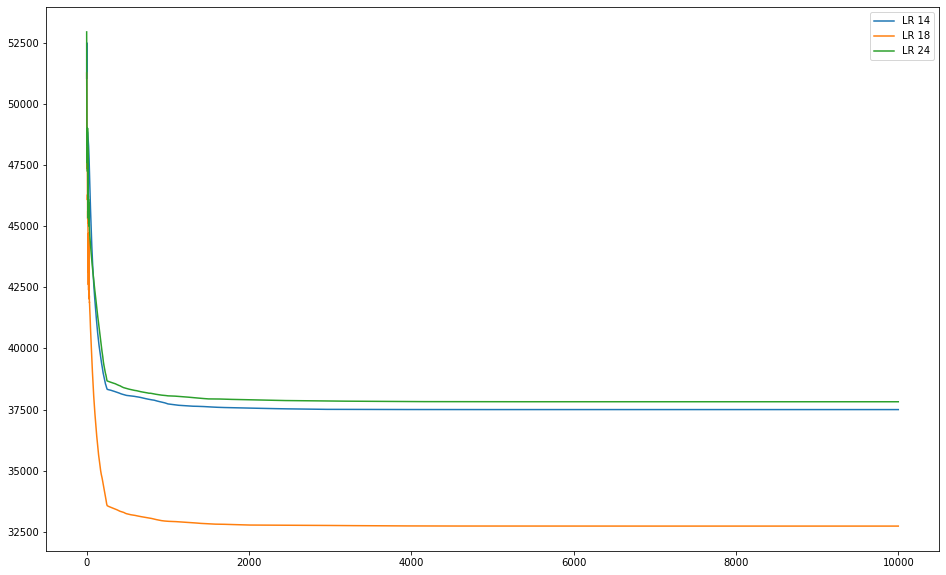

In [78]:
plt.figure(figsize=(16,10))
for i, r in enumerate(results4):
    plt.plot(r, label="LR {}".format(hidden[i]))
    plt.legend()

https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1#:~:text=The%20mathematical%20form%20of%20time,decreasing%20factor%20in%20each%20epoch.

In [91]:
#  new learning rate decay formula, starting with higher lr
hidden = [14, 18, 24]
results5 = []
for h in hidden:
    mlp = MLP(X_train.shape[1], y_train_wide.shape[1],
            hidden_units=h,
            epochs=5000,
            learning_rate=0.01, loss='log', 
            first_activation = 'sig', second_activation='softmax', decay=.70)
    mlp.fit(X_train, y_train_wide)
    results4.append(mlp.loss)

Epoch 1 LR 0.01 Loss is 49820.149758870844
Epoch 2 LR 0.008 Loss is 49738.40399743178
Epoch 3 LR 0.008 Loss is 48722.223543980195
Epoch 4 LR 0.008 Loss is 48376.348984442986
Epoch 5 LR 0.008 Loss is 48151.78280734515
Epoch 6 LR 0.008 Loss is 47607.78373497326
Epoch 7 LR 0.008 Loss is 47897.39920125423
Epoch 8 LR 0.008 Loss is 46612.49310217949
Epoch 9 LR 0.008 Loss is 48552.8624398579
Epoch 10 LR 0.008 Loss is 45413.6668779572
Epoch 11 LR 0.008 Loss is 48444.178483501964
Epoch 12 LR 0.008 Loss is 45517.47861808058
Epoch 13 LR 0.008 Loss is 47373.74484987288
Epoch 14 LR 0.008 Loss is 44202.474419420185
Epoch 15 LR 0.008 Loss is 47957.95265582644
Epoch 16 LR 0.008 Loss is 43638.47637762801
Epoch 17 LR 0.008 Loss is 47461.385706461966
Epoch 18 LR 0.008 Loss is 43088.00359070312
Epoch 19 LR 0.008 Loss is 46986.03598692217
Epoch 20 LR 0.008 Loss is 42889.688422178195
Epoch 21 LR 0.008 Loss is 46297.71662353152
Epoch 22 LR 0.008 Loss is 42752.869430272905
Epoch 23 LR 0.008 Loss is 45708.3938

<ipython-input-88-475c13e97a96>:47: RuntimeWarning: overflow encountered in exp
  sig = (1 / (1 + np.exp(-x)))


Epoch 29 LR 0.008 Loss is 44303.35859371708
Epoch 30 LR 0.008 Loss is 42009.35617959737
Epoch 31 LR 0.008 Loss is 43931.37693460939
Epoch 32 LR 0.008 Loss is 41841.69954596424
Epoch 33 LR 0.008 Loss is 43518.94768362177
Epoch 34 LR 0.008 Loss is 41710.97017536572
Epoch 35 LR 0.008 Loss is 43115.43414188626
Epoch 36 LR 0.008 Loss is 41604.38855652042
Epoch 37 LR 0.008 Loss is 42729.50359465278
Epoch 38 LR 0.008 Loss is 41521.61052577264
Epoch 39 LR 0.008 Loss is 42384.277767697306
Epoch 40 LR 0.008 Loss is 41414.31440345323
Epoch 41 LR 0.008 Loss is 42114.12548100638
Epoch 42 LR 0.008 Loss is 41291.79761780476
Epoch 43 LR 0.008 Loss is 41884.41928608705
Epoch 44 LR 0.008 Loss is 41182.76039685679
Epoch 45 LR 0.008 Loss is 41652.39383432967
Epoch 46 LR 0.008 Loss is 41076.44464870387
Epoch 47 LR 0.008 Loss is 41435.222540866365
Epoch 48 LR 0.008 Loss is 40975.41216845119
Epoch 49 LR 0.008 Loss is 41224.68159501273
Epoch 50 LR 0.008 Loss is 40888.89429840218
Epoch 51 LR 0.008 Loss is 4106

Epoch 223 LR 0.008 Loss is 35724.666894354115
Epoch 224 LR 0.008 Loss is 35692.92988599278
Epoch 225 LR 0.008 Loss is 35664.15121323952
Epoch 226 LR 0.008 Loss is 35643.05383022693
Epoch 227 LR 0.008 Loss is 35625.54326595396
Epoch 228 LR 0.008 Loss is 35606.83121911663
Epoch 229 LR 0.008 Loss is 35589.59498744928
Epoch 230 LR 0.008 Loss is 35567.4480184795
Epoch 231 LR 0.008 Loss is 35549.00612075278
Epoch 232 LR 0.008 Loss is 35534.64116789116
Epoch 233 LR 0.008 Loss is 35515.212938899625
Epoch 234 LR 0.008 Loss is 35494.313369198564
Epoch 235 LR 0.008 Loss is 35470.53682334517
Epoch 236 LR 0.008 Loss is 35445.03042117998
Epoch 237 LR 0.008 Loss is 35420.85294977232
Epoch 238 LR 0.008 Loss is 35401.07747762842
Epoch 239 LR 0.008 Loss is 35380.696270977525
Epoch 240 LR 0.008 Loss is 35373.938614487386
Epoch 241 LR 0.008 Loss is 35365.42507290204
Epoch 242 LR 0.008 Loss is 35356.40971378215
Epoch 243 LR 0.008 Loss is 35349.00795528026
Epoch 244 LR 0.008 Loss is 35328.655586484616
Epoch

Epoch 405 LR 0.0064 Loss is 33091.90453396198
Epoch 406 LR 0.0064 Loss is 33074.877391867376
Epoch 407 LR 0.0064 Loss is 33055.01210223338
Epoch 408 LR 0.0064 Loss is 33048.44963334063
Epoch 409 LR 0.0064 Loss is 33048.25222115704
Epoch 410 LR 0.0064 Loss is 33041.92580242086
Epoch 411 LR 0.0064 Loss is 33031.644159734016
Epoch 412 LR 0.0064 Loss is 33018.90204018885
Epoch 413 LR 0.0064 Loss is 33013.075107869656
Epoch 414 LR 0.0064 Loss is 33005.25499263607
Epoch 415 LR 0.0064 Loss is 33003.74088398626
Epoch 416 LR 0.0064 Loss is 33004.21259836844
Epoch 417 LR 0.0064 Loss is 32988.485175356574
Epoch 418 LR 0.0064 Loss is 32969.957351753554
Epoch 419 LR 0.0064 Loss is 32958.41719967656
Epoch 420 LR 0.0064 Loss is 32947.272485929956
Epoch 421 LR 0.0064 Loss is 32935.011581551116
Epoch 422 LR 0.0064 Loss is 32916.07963702689
Epoch 423 LR 0.0064 Loss is 32901.23738026131
Epoch 424 LR 0.0064 Loss is 32892.563185825195
Epoch 425 LR 0.0064 Loss is 32883.408012598324
Epoch 426 LR 0.0064 Loss 

Epoch 589 LR 0.00512 Loss is 31498.444101656813
Epoch 590 LR 0.00512 Loss is 31496.55924157639
Epoch 591 LR 0.00512 Loss is 31493.853112321467
Epoch 592 LR 0.00512 Loss is 31493.90037556786
Epoch 593 LR 0.00512 Loss is 31498.115850212318
Epoch 594 LR 0.00512 Loss is 31500.064941329438
Epoch 595 LR 0.00512 Loss is 31498.869350328805
Epoch 596 LR 0.00512 Loss is 31497.92914038199
Epoch 597 LR 0.00512 Loss is 31493.264746174984
Epoch 598 LR 0.00512 Loss is 31492.08527463428
Epoch 599 LR 0.00512 Loss is 31488.0538958085
Epoch 600 LR 0.00512 Loss is 31480.113853558385
Epoch 601 LR 0.00512 Loss is 31465.804382396516
Epoch 602 LR 0.00512 Loss is 31453.18501424639
Epoch 603 LR 0.00512 Loss is 31444.300131065487
Epoch 604 LR 0.00512 Loss is 31432.856937752007
Epoch 605 LR 0.00512 Loss is 31424.501829325076
Epoch 606 LR 0.00512 Loss is 31421.927766274363
Epoch 607 LR 0.00512 Loss is 31420.86141083037
Epoch 608 LR 0.00512 Loss is 31414.778980363386
Epoch 609 LR 0.00512 Loss is 31405.832072451387


Epoch 771 LR 0.004096000000000001 Loss is 30886.31510515621
Epoch 772 LR 0.004096000000000001 Loss is 30884.451936340603
Epoch 773 LR 0.004096000000000001 Loss is 30885.319523520087
Epoch 774 LR 0.004096000000000001 Loss is 30888.38700676973
Epoch 775 LR 0.004096000000000001 Loss is 30888.847264890188
Epoch 776 LR 0.004096000000000001 Loss is 30890.667429823556
Epoch 777 LR 0.004096000000000001 Loss is 30892.788016582905
Epoch 778 LR 0.004096000000000001 Loss is 30890.59513622448
Epoch 779 LR 0.004096000000000001 Loss is 30884.511028962253
Epoch 780 LR 0.004096000000000001 Loss is 30879.5771016334
Epoch 781 LR 0.004096000000000001 Loss is 30877.69726001626
Epoch 782 LR 0.004096000000000001 Loss is 30872.89678006804
Epoch 783 LR 0.004096000000000001 Loss is 30866.253815087763
Epoch 784 LR 0.004096000000000001 Loss is 30867.727935003408
Epoch 785 LR 0.004096000000000001 Loss is 30869.580869261128
Epoch 786 LR 0.004096000000000001 Loss is 30869.585044319487
Epoch 787 LR 0.0040960000000000

Epoch 911 LR 0.004096000000000001 Loss is 30910.322524713196
Epoch 912 LR 0.004096000000000001 Loss is 30906.870323548446
Epoch 913 LR 0.004096000000000001 Loss is 30894.43797497436
Epoch 914 LR 0.004096000000000001 Loss is 30885.919931858265
Epoch 915 LR 0.004096000000000001 Loss is 30887.118435372377
Epoch 916 LR 0.004096000000000001 Loss is 30883.548687740993
Epoch 917 LR 0.004096000000000001 Loss is 30880.61628437768
Epoch 918 LR 0.004096000000000001 Loss is 30878.997381760688
Epoch 919 LR 0.004096000000000001 Loss is 30880.539411824204
Epoch 920 LR 0.004096000000000001 Loss is 30879.768425752056
Epoch 921 LR 0.004096000000000001 Loss is 30874.385992824544
Epoch 922 LR 0.004096000000000001 Loss is 30874.34447687675
Epoch 923 LR 0.004096000000000001 Loss is 30873.182969288817
Epoch 924 LR 0.004096000000000001 Loss is 30870.076283930033
Epoch 925 LR 0.004096000000000001 Loss is 30873.274077352773
Epoch 926 LR 0.004096000000000001 Loss is 30871.392114365175
Epoch 927 LR 0.004096000000

Epoch 1057 LR 0.0032768000000000007 Loss is 31182.926254358583
Epoch 1058 LR 0.0032768000000000007 Loss is 31188.55558571528
Epoch 1059 LR 0.0032768000000000007 Loss is 31190.906197129516
Epoch 1060 LR 0.0032768000000000007 Loss is 31193.478079193817
Epoch 1061 LR 0.0032768000000000007 Loss is 31195.336275861995
Epoch 1062 LR 0.0032768000000000007 Loss is 31199.662220318874
Epoch 1063 LR 0.0032768000000000007 Loss is 31201.79465944899
Epoch 1064 LR 0.0032768000000000007 Loss is 31203.146769860054
Epoch 1065 LR 0.0032768000000000007 Loss is 31206.489958263297
Epoch 1066 LR 0.0032768000000000007 Loss is 31215.137720341063
Epoch 1067 LR 0.0032768000000000007 Loss is 31228.180243759372
Epoch 1068 LR 0.0032768000000000007 Loss is 31233.91445222165
Epoch 1069 LR 0.0032768000000000007 Loss is 31234.239861017428
Epoch 1070 LR 0.0032768000000000007 Loss is 31232.866911418845
Epoch 1071 LR 0.0032768000000000007 Loss is 31232.12627547318
Epoch 1072 LR 0.0032768000000000007 Loss is 31232.553328596

Epoch 1202 LR 0.0032768000000000007 Loss is 31757.92081885333
Epoch 1203 LR 0.0032768000000000007 Loss is 31760.94010551486
Epoch 1204 LR 0.0032768000000000007 Loss is 31767.346850663533
Epoch 1205 LR 0.0032768000000000007 Loss is 31775.47973466379
Epoch 1206 LR 0.0032768000000000007 Loss is 31781.904621910344
Epoch 1207 LR 0.0032768000000000007 Loss is 31790.29372316639
Epoch 1208 LR 0.0032768000000000007 Loss is 31800.727539414915
Epoch 1209 LR 0.0032768000000000007 Loss is 31807.920058407508
Epoch 1210 LR 0.0032768000000000007 Loss is 31810.216631588533
Epoch 1211 LR 0.0032768000000000007 Loss is 31813.88903807729
Epoch 1212 LR 0.0032768000000000007 Loss is 31818.32533063929
Epoch 1213 LR 0.0032768000000000007 Loss is 31823.68301917441
Epoch 1214 LR 0.0032768000000000007 Loss is 31830.58732536395
Epoch 1215 LR 0.0032768000000000007 Loss is 31834.832231390224
Epoch 1216 LR 0.0032768000000000007 Loss is 31837.726182307124
Epoch 1217 LR 0.0032768000000000007 Loss is 31839.610667425684


Epoch 1349 LR 0.002621440000000001 Loss is 32276.047396515805
Epoch 1350 LR 0.002621440000000001 Loss is 32278.971329762593
Epoch 1351 LR 0.002621440000000001 Loss is 32283.267855885286
Epoch 1352 LR 0.002621440000000001 Loss is 32286.51165992066
Epoch 1353 LR 0.002621440000000001 Loss is 32290.684114379248
Epoch 1354 LR 0.002621440000000001 Loss is 32296.20051917128
Epoch 1355 LR 0.002621440000000001 Loss is 32298.441992520522
Epoch 1356 LR 0.002621440000000001 Loss is 32300.096293963106
Epoch 1357 LR 0.002621440000000001 Loss is 32304.259248217535
Epoch 1358 LR 0.002621440000000001 Loss is 32305.366351335662
Epoch 1359 LR 0.002621440000000001 Loss is 32306.32452751167
Epoch 1360 LR 0.002621440000000001 Loss is 32307.26766318814
Epoch 1361 LR 0.002621440000000001 Loss is 32308.595189537977
Epoch 1362 LR 0.002621440000000001 Loss is 32312.713836523926
Epoch 1363 LR 0.002621440000000001 Loss is 32316.542692972063
Epoch 1364 LR 0.002621440000000001 Loss is 32319.045811469095
Epoch 1365 L

Epoch 1492 LR 0.002621440000000001 Loss is 32489.103804554805
Epoch 1493 LR 0.002621440000000001 Loss is 32486.934884267514
Epoch 1494 LR 0.002621440000000001 Loss is 32490.0766391879
Epoch 1495 LR 0.002621440000000001 Loss is 32492.121943763563
Epoch 1496 LR 0.002621440000000001 Loss is 32500.27554092369
Epoch 1497 LR 0.002621440000000001 Loss is 32508.173705199682
Epoch 1498 LR 0.002621440000000001 Loss is 32512.344321365857
Epoch 1499 LR 0.002621440000000001 Loss is 32516.659050016326
Epoch 1500 LR 0.002621440000000001 Loss is 32520.458226343846
Epoch 1501 LR 0.002621440000000001 Loss is 32522.026958005736
Epoch 1502 LR 0.002097152000000001 Loss is 32526.661778338723
Epoch 1503 LR 0.002097152000000001 Loss is 32529.851608020443
Epoch 1504 LR 0.002097152000000001 Loss is 32531.216394192263
Epoch 1505 LR 0.002097152000000001 Loss is 32532.655740480084
Epoch 1506 LR 0.002097152000000001 Loss is 32533.634818792503
Epoch 1507 LR 0.002097152000000001 Loss is 32534.341125925428
Epoch 1508 

Epoch 1633 LR 0.002097152000000001 Loss is 32738.58702750263
Epoch 1634 LR 0.002097152000000001 Loss is 32744.191537958155
Epoch 1635 LR 0.002097152000000001 Loss is 32748.444195959502
Epoch 1636 LR 0.002097152000000001 Loss is 32749.009053772363
Epoch 1637 LR 0.002097152000000001 Loss is 32750.650711615424
Epoch 1638 LR 0.002097152000000001 Loss is 32755.210653105776
Epoch 1639 LR 0.002097152000000001 Loss is 32759.35883938034
Epoch 1640 LR 0.002097152000000001 Loss is 32761.122417782244
Epoch 1641 LR 0.002097152000000001 Loss is 32762.50239059657
Epoch 1642 LR 0.002097152000000001 Loss is 32768.021324417205
Epoch 1643 LR 0.002097152000000001 Loss is 32770.92357235747
Epoch 1644 LR 0.002097152000000001 Loss is 32771.716144371734
Epoch 1645 LR 0.002097152000000001 Loss is 32772.47839265182
Epoch 1646 LR 0.002097152000000001 Loss is 32774.79851216511
Epoch 1647 LR 0.002097152000000001 Loss is 32777.97769328756
Epoch 1648 LR 0.002097152000000001 Loss is 32779.68061339105
Epoch 1649 LR 0.

Epoch 1772 LR 0.001677721600000001 Loss is 32902.77678342298
Epoch 1773 LR 0.001677721600000001 Loss is 32904.63146603865
Epoch 1774 LR 0.001677721600000001 Loss is 32904.104987149614
Epoch 1775 LR 0.001677721600000001 Loss is 32902.19801761118
Epoch 1776 LR 0.001677721600000001 Loss is 32902.44471425348
Epoch 1777 LR 0.001677721600000001 Loss is 32902.06186472601
Epoch 1778 LR 0.001677721600000001 Loss is 32901.865528603885
Epoch 1779 LR 0.001677721600000001 Loss is 32900.91861221668
Epoch 1780 LR 0.001677721600000001 Loss is 32898.43786587877
Epoch 1781 LR 0.001677721600000001 Loss is 32898.24590695775
Epoch 1782 LR 0.001677721600000001 Loss is 32897.33056892875
Epoch 1783 LR 0.001677721600000001 Loss is 32895.8812004721
Epoch 1784 LR 0.001677721600000001 Loss is 32891.865204351576
Epoch 1785 LR 0.001677721600000001 Loss is 32885.06948478232
Epoch 1786 LR 0.001677721600000001 Loss is 32878.964358794976
Epoch 1787 LR 0.001677721600000001 Loss is 32874.77336191659
Epoch 1788 LR 0.00167

Epoch 1913 LR 0.001677721600000001 Loss is 32839.56906005025
Epoch 1914 LR 0.001677721600000001 Loss is 32840.10490607133
Epoch 1915 LR 0.001677721600000001 Loss is 32840.92175986815
Epoch 1916 LR 0.001677721600000001 Loss is 32839.818130117965
Epoch 1917 LR 0.001677721600000001 Loss is 32837.65046847206
Epoch 1918 LR 0.001677721600000001 Loss is 32836.95227678514
Epoch 1919 LR 0.001677721600000001 Loss is 32837.154800988304
Epoch 1920 LR 0.001677721600000001 Loss is 32836.95946593204
Epoch 1921 LR 0.001677721600000001 Loss is 32836.29671515013
Epoch 1922 LR 0.001677721600000001 Loss is 32836.6665974064
Epoch 1923 LR 0.001677721600000001 Loss is 32837.35049395129
Epoch 1924 LR 0.001677721600000001 Loss is 32838.014579288545
Epoch 1925 LR 0.001677721600000001 Loss is 32837.40680465868
Epoch 1926 LR 0.001677721600000001 Loss is 32836.53428534755
Epoch 1927 LR 0.001677721600000001 Loss is 32835.367550718074
Epoch 1928 LR 0.001677721600000001 Loss is 32832.53723514917
Epoch 1929 LR 0.00167

Epoch 2058 LR 0.0013421772800000008 Loss is 32779.16413493301
Epoch 2059 LR 0.0013421772800000008 Loss is 32777.9691659278
Epoch 2060 LR 0.0013421772800000008 Loss is 32777.1876660645
Epoch 2061 LR 0.0013421772800000008 Loss is 32777.29645008656
Epoch 2062 LR 0.0013421772800000008 Loss is 32777.609169232164
Epoch 2063 LR 0.0013421772800000008 Loss is 32777.82577864866
Epoch 2064 LR 0.0013421772800000008 Loss is 32780.03902109466
Epoch 2065 LR 0.0013421772800000008 Loss is 32782.77577564749
Epoch 2066 LR 0.0013421772800000008 Loss is 32784.167108161746
Epoch 2067 LR 0.0013421772800000008 Loss is 32784.20617993259
Epoch 2068 LR 0.0013421772800000008 Loss is 32784.37290783973
Epoch 2069 LR 0.0013421772800000008 Loss is 32783.51540063502
Epoch 2070 LR 0.0013421772800000008 Loss is 32783.08249478481
Epoch 2071 LR 0.0013421772800000008 Loss is 32781.82892130826
Epoch 2072 LR 0.0013421772800000008 Loss is 32777.95609265143
Epoch 2073 LR 0.0013421772800000008 Loss is 32773.58309058363
Epoch 20

Epoch 2200 LR 0.0013421772800000008 Loss is 32654.490554592216
Epoch 2201 LR 0.0013421772800000008 Loss is 32652.797568174396
Epoch 2202 LR 0.0013421772800000008 Loss is 32651.07863107104
Epoch 2203 LR 0.0013421772800000008 Loss is 32650.438160215446
Epoch 2204 LR 0.0013421772800000008 Loss is 32650.78548228764
Epoch 2205 LR 0.0013421772800000008 Loss is 32649.461023798853
Epoch 2206 LR 0.0013421772800000008 Loss is 32646.444387200496
Epoch 2207 LR 0.0013421772800000008 Loss is 32642.048249123298
Epoch 2208 LR 0.0013421772800000008 Loss is 32638.811951944965
Epoch 2209 LR 0.0013421772800000008 Loss is 32636.766970360106
Epoch 2210 LR 0.0013421772800000008 Loss is 32634.671168253728
Epoch 2211 LR 0.0013421772800000008 Loss is 32633.025253916578
Epoch 2212 LR 0.0013421772800000008 Loss is 32633.233790471742
Epoch 2213 LR 0.0013421772800000008 Loss is 32634.07552490243
Epoch 2214 LR 0.0013421772800000008 Loss is 32634.923271394815
Epoch 2215 LR 0.0013421772800000008 Loss is 32636.43996191

Epoch 2344 LR 0.0010737418240000006 Loss is 32531.112960500635
Epoch 2345 LR 0.0010737418240000006 Loss is 32529.593128740253
Epoch 2346 LR 0.0010737418240000006 Loss is 32527.964595476824
Epoch 2347 LR 0.0010737418240000006 Loss is 32526.699237060857
Epoch 2348 LR 0.0010737418240000006 Loss is 32526.24571639212
Epoch 2349 LR 0.0010737418240000006 Loss is 32526.58942044637
Epoch 2350 LR 0.0010737418240000006 Loss is 32525.90618829325
Epoch 2351 LR 0.0010737418240000006 Loss is 32524.551238233416
Epoch 2352 LR 0.0010737418240000006 Loss is 32523.078555361757
Epoch 2353 LR 0.0010737418240000006 Loss is 32521.27831516771
Epoch 2354 LR 0.0010737418240000006 Loss is 32519.086425994486
Epoch 2355 LR 0.0010737418240000006 Loss is 32516.70957611224
Epoch 2356 LR 0.0010737418240000006 Loss is 32514.778902212845
Epoch 2357 LR 0.0010737418240000006 Loss is 32513.42101665271
Epoch 2358 LR 0.0010737418240000006 Loss is 32512.058132246708
Epoch 2359 LR 0.0010737418240000006 Loss is 32509.78145504172

Epoch 2482 LR 0.0010737418240000006 Loss is 32464.366874035262
Epoch 2483 LR 0.0010737418240000006 Loss is 32463.772996461168
Epoch 2484 LR 0.0010737418240000006 Loss is 32462.860093690957
Epoch 2485 LR 0.0010737418240000006 Loss is 32461.770696589752
Epoch 2486 LR 0.0010737418240000006 Loss is 32460.42475676684
Epoch 2487 LR 0.0010737418240000006 Loss is 32458.527107412116
Epoch 2488 LR 0.0010737418240000006 Loss is 32456.850474353483
Epoch 2489 LR 0.0010737418240000006 Loss is 32455.714195481705
Epoch 2490 LR 0.0010737418240000006 Loss is 32454.391204652602
Epoch 2491 LR 0.0010737418240000006 Loss is 32452.73391263577
Epoch 2492 LR 0.0010737418240000006 Loss is 32452.161805364696
Epoch 2493 LR 0.0010737418240000006 Loss is 32452.7558129368
Epoch 2494 LR 0.0010737418240000006 Loss is 32452.406358806755
Epoch 2495 LR 0.0010737418240000006 Loss is 32451.057202619882
Epoch 2496 LR 0.0010737418240000006 Loss is 32449.428282075467
Epoch 2497 LR 0.0010737418240000006 Loss is 32447.447637169

Epoch 2617 LR 0.0008589934592000006 Loss is 32416.46937687143
Epoch 2618 LR 0.0008589934592000006 Loss is 32416.50420393126
Epoch 2619 LR 0.0008589934592000006 Loss is 32416.853922080256
Epoch 2620 LR 0.0008589934592000006 Loss is 32416.742838949067
Epoch 2621 LR 0.0008589934592000006 Loss is 32415.848263234126
Epoch 2622 LR 0.0008589934592000006 Loss is 32414.751241596878
Epoch 2623 LR 0.0008589934592000006 Loss is 32414.124277802057
Epoch 2624 LR 0.0008589934592000006 Loss is 32414.03224718955
Epoch 2625 LR 0.0008589934592000006 Loss is 32413.99393658026
Epoch 2626 LR 0.0008589934592000006 Loss is 32413.43893165148
Epoch 2627 LR 0.0008589934592000006 Loss is 32412.141961666828
Epoch 2628 LR 0.0008589934592000006 Loss is 32410.038414417035
Epoch 2629 LR 0.0008589934592000006 Loss is 32407.70103912155
Epoch 2630 LR 0.0008589934592000006 Loss is 32406.398725826333
Epoch 2631 LR 0.0008589934592000006 Loss is 32406.14060536138
Epoch 2632 LR 0.0008589934592000006 Loss is 32406.035704332367

Epoch 2755 LR 0.0006871947673600005 Loss is 32356.79299701451
Epoch 2756 LR 0.0006871947673600005 Loss is 32357.194698316616
Epoch 2757 LR 0.0006871947673600005 Loss is 32357.59997654571
Epoch 2758 LR 0.0006871947673600005 Loss is 32357.715822024606
Epoch 2759 LR 0.0006871947673600005 Loss is 32357.40136402801
Epoch 2760 LR 0.0006871947673600005 Loss is 32356.61783555515
Epoch 2761 LR 0.0006871947673600005 Loss is 32355.4492224571
Epoch 2762 LR 0.0006871947673600005 Loss is 32354.12980517756
Epoch 2763 LR 0.0006871947673600005 Loss is 32353.01860222648
Epoch 2764 LR 0.0006871947673600005 Loss is 32352.274119534217
Epoch 2765 LR 0.0006871947673600005 Loss is 32351.750749147064
Epoch 2766 LR 0.0006871947673600005 Loss is 32351.159746772664
Epoch 2767 LR 0.0006871947673600005 Loss is 32350.336719106657
Epoch 2768 LR 0.0006871947673600005 Loss is 32349.216670494658
Epoch 2769 LR 0.0006871947673600005 Loss is 32347.944407220668
Epoch 2770 LR 0.0006871947673600005 Loss is 32346.816736768516


Epoch 2886 LR 0.0006871947673600005 Loss is 32281.593752587458
Epoch 2887 LR 0.0006871947673600005 Loss is 32281.87049964711
Epoch 2888 LR 0.0006871947673600005 Loss is 32281.95506755366
Epoch 2889 LR 0.0006871947673600005 Loss is 32281.811106566267
Epoch 2890 LR 0.0006871947673600005 Loss is 32281.45436501086
Epoch 2891 LR 0.0006871947673600005 Loss is 32280.98253439066
Epoch 2892 LR 0.0006871947673600005 Loss is 32280.432622256805
Epoch 2893 LR 0.0006871947673600005 Loss is 32279.85438155527
Epoch 2894 LR 0.0006871947673600005 Loss is 32279.43261164221
Epoch 2895 LR 0.0006871947673600005 Loss is 32279.068022171527
Epoch 2896 LR 0.0006871947673600005 Loss is 32278.514445018496
Epoch 2897 LR 0.0006871947673600005 Loss is 32278.057495929363
Epoch 2898 LR 0.0006871947673600005 Loss is 32278.10494518609
Epoch 2899 LR 0.0006871947673600005 Loss is 32278.355246742703
Epoch 2900 LR 0.0006871947673600005 Loss is 32278.10200067177
Epoch 2901 LR 0.0006871947673600005 Loss is 32277.420446760636


Epoch 3025 LR 0.0005497558138880005 Loss is 32142.882461440156
Epoch 3026 LR 0.0005497558138880005 Loss is 32142.573202966625
Epoch 3027 LR 0.0005497558138880005 Loss is 32142.38653112187
Epoch 3028 LR 0.0005497558138880005 Loss is 32142.20163345569
Epoch 3029 LR 0.0005497558138880005 Loss is 32141.895120230234
Epoch 3030 LR 0.0005497558138880005 Loss is 32141.42920838874
Epoch 3031 LR 0.0005497558138880005 Loss is 32140.931577545543
Epoch 3032 LR 0.0005497558138880005 Loss is 32140.457479001474
Epoch 3033 LR 0.0005497558138880005 Loss is 32139.908018786682
Epoch 3034 LR 0.0005497558138880005 Loss is 32139.256381929164
Epoch 3035 LR 0.0005497558138880005 Loss is 32138.56436670942
Epoch 3036 LR 0.0005497558138880005 Loss is 32137.991068441424
Epoch 3037 LR 0.0005497558138880005 Loss is 32137.750047788915
Epoch 3038 LR 0.0005497558138880005 Loss is 32137.88985858827
Epoch 3039 LR 0.0005497558138880005 Loss is 32138.292627609233
Epoch 3040 LR 0.0005497558138880005 Loss is 32138.8594890778

Epoch 3161 LR 0.0005497558138880005 Loss is 32146.077967733647
Epoch 3162 LR 0.0005497558138880005 Loss is 32145.662950476246
Epoch 3163 LR 0.0005497558138880005 Loss is 32145.302120593908
Epoch 3164 LR 0.0005497558138880005 Loss is 32144.989436445634
Epoch 3165 LR 0.0005497558138880005 Loss is 32144.698415653504
Epoch 3166 LR 0.0005497558138880005 Loss is 32144.403891429578
Epoch 3167 LR 0.0005497558138880005 Loss is 32144.090726070663
Epoch 3168 LR 0.0005497558138880005 Loss is 32143.722491538647
Epoch 3169 LR 0.0005497558138880005 Loss is 32143.231508725454
Epoch 3170 LR 0.0005497558138880005 Loss is 32142.576592509824
Epoch 3171 LR 0.0005497558138880005 Loss is 32141.87952893137
Epoch 3172 LR 0.0005497558138880005 Loss is 32141.213658485158
Epoch 3173 LR 0.0005497558138880005 Loss is 32140.44163661652
Epoch 3174 LR 0.0005497558138880005 Loss is 32139.716421717374
Epoch 3175 LR 0.0005497558138880005 Loss is 32139.196916199737
Epoch 3176 LR 0.0005497558138880005 Loss is 32138.7641034

Epoch 3302 LR 0.0004398046511104004 Loss is 32057.703110066228
Epoch 3303 LR 0.0004398046511104004 Loss is 32056.64259367127
Epoch 3304 LR 0.0004398046511104004 Loss is 32055.748895254732
Epoch 3305 LR 0.0004398046511104004 Loss is 32054.95623241618
Epoch 3306 LR 0.0004398046511104004 Loss is 32054.15752418637
Epoch 3307 LR 0.0004398046511104004 Loss is 32053.306365088207
Epoch 3308 LR 0.0004398046511104004 Loss is 32052.46559517362
Epoch 3309 LR 0.0004398046511104004 Loss is 32051.73102383639
Epoch 3310 LR 0.0004398046511104004 Loss is 32051.08339800189
Epoch 3311 LR 0.0004398046511104004 Loss is 32050.461425684527
Epoch 3312 LR 0.0004398046511104004 Loss is 32049.854389669727
Epoch 3313 LR 0.0004398046511104004 Loss is 32049.277892118498
Epoch 3314 LR 0.0004398046511104004 Loss is 32048.74678527414
Epoch 3315 LR 0.0004398046511104004 Loss is 32048.272392306942
Epoch 3316 LR 0.0004398046511104004 Loss is 32047.858675408293
Epoch 3317 LR 0.0004398046511104004 Loss is 32047.49274282154


Epoch 3436 LR 0.0004398046511104004 Loss is 32008.2188835368
Epoch 3437 LR 0.0004398046511104004 Loss is 32008.035470311694
Epoch 3438 LR 0.0004398046511104004 Loss is 32007.963241441503
Epoch 3439 LR 0.0004398046511104004 Loss is 32008.06666056683
Epoch 3440 LR 0.0004398046511104004 Loss is 32008.30285396451
Epoch 3441 LR 0.0004398046511104004 Loss is 32008.528160839996
Epoch 3442 LR 0.0004398046511104004 Loss is 32008.617756080446
Epoch 3443 LR 0.0004398046511104004 Loss is 32008.522421754842
Epoch 3444 LR 0.0004398046511104004 Loss is 32008.28811714321
Epoch 3445 LR 0.0004398046511104004 Loss is 32008.07027686353
Epoch 3446 LR 0.0004398046511104004 Loss is 32008.030447375655
Epoch 3447 LR 0.0004398046511104004 Loss is 32008.20656161916
Epoch 3448 LR 0.0004398046511104004 Loss is 32008.55219435195
Epoch 3449 LR 0.0004398046511104004 Loss is 32008.972603885617
Epoch 3450 LR 0.0004398046511104004 Loss is 32009.35489217696
Epoch 3451 LR 0.0004398046511104004 Loss is 32009.642256002786
E

Epoch 3570 LR 0.00035184372088832035 Loss is 31978.938325981657
Epoch 3571 LR 0.00035184372088832035 Loss is 31978.96383378299
Epoch 3572 LR 0.00035184372088832035 Loss is 31979.014593502015
Epoch 3573 LR 0.00035184372088832035 Loss is 31979.08001535446
Epoch 3574 LR 0.00035184372088832035 Loss is 31979.155232243807
Epoch 3575 LR 0.00035184372088832035 Loss is 31979.242829809155
Epoch 3576 LR 0.00035184372088832035 Loss is 31979.350238470182
Epoch 3577 LR 0.00035184372088832035 Loss is 31979.48369530026
Epoch 3578 LR 0.00035184372088832035 Loss is 31979.644459779305
Epoch 3579 LR 0.00035184372088832035 Loss is 31979.831289897946
Epoch 3580 LR 0.00035184372088832035 Loss is 31980.045448742254
Epoch 3581 LR 0.00035184372088832035 Loss is 31980.29205156676
Epoch 3582 LR 0.00035184372088832035 Loss is 31980.575413636518
Epoch 3583 LR 0.00035184372088832035 Loss is 31980.89151689773
Epoch 3584 LR 0.00035184372088832035 Loss is 31981.22472188603
Epoch 3585 LR 0.00035184372088832035 Loss is 3

Epoch 3713 LR 0.00035184372088832035 Loss is 31960.898010060777
Epoch 3714 LR 0.00035184372088832035 Loss is 31961.047336596024
Epoch 3715 LR 0.00035184372088832035 Loss is 31961.196908299047
Epoch 3716 LR 0.00035184372088832035 Loss is 31961.337916774664
Epoch 3717 LR 0.00035184372088832035 Loss is 31961.45825197172
Epoch 3718 LR 0.00035184372088832035 Loss is 31961.544715735403
Epoch 3719 LR 0.00035184372088832035 Loss is 31961.59258936646
Epoch 3720 LR 0.00035184372088832035 Loss is 31961.60723873125
Epoch 3721 LR 0.00035184372088832035 Loss is 31961.596373406664
Epoch 3722 LR 0.00035184372088832035 Loss is 31961.562943638146
Epoch 3723 LR 0.00035184372088832035 Loss is 31961.50622609414
Epoch 3724 LR 0.00035184372088832035 Loss is 31961.431360649192
Epoch 3725 LR 0.00035184372088832035 Loss is 31961.357853079327
Epoch 3726 LR 0.00035184372088832035 Loss is 31961.315410539275
Epoch 3727 LR 0.00035184372088832035 Loss is 31961.33582559498
Epoch 3728 LR 0.00035184372088832035 Loss is 

Epoch 3851 LR 0.0002814749767106563 Loss is 31945.44107091503
Epoch 3852 LR 0.0002814749767106563 Loss is 31945.437364710095
Epoch 3853 LR 0.0002814749767106563 Loss is 31945.410290888685
Epoch 3854 LR 0.0002814749767106563 Loss is 31945.349966511985
Epoch 3855 LR 0.0002814749767106563 Loss is 31945.235483420376
Epoch 3856 LR 0.0002814749767106563 Loss is 31945.043942764754
Epoch 3857 LR 0.0002814749767106563 Loss is 31944.76296815649
Epoch 3858 LR 0.0002814749767106563 Loss is 31944.401341393426
Epoch 3859 LR 0.0002814749767106563 Loss is 31943.990540448205
Epoch 3860 LR 0.0002814749767106563 Loss is 31943.572105925185
Epoch 3861 LR 0.0002814749767106563 Loss is 31943.177559828422
Epoch 3862 LR 0.0002814749767106563 Loss is 31942.817265966463
Epoch 3863 LR 0.0002814749767106563 Loss is 31942.48524288461
Epoch 3864 LR 0.0002814749767106563 Loss is 31942.16978488234
Epoch 3865 LR 0.0002814749767106563 Loss is 31941.857856672694
Epoch 3866 LR 0.0002814749767106563 Loss is 31941.533962848

Epoch 3986 LR 0.0002814749767106563 Loss is 31902.966658824942
Epoch 3987 LR 0.0002814749767106563 Loss is 31902.254162405265
Epoch 3988 LR 0.0002814749767106563 Loss is 31901.594415947708
Epoch 3989 LR 0.0002814749767106563 Loss is 31900.993415797857
Epoch 3990 LR 0.0002814749767106563 Loss is 31900.45684131219
Epoch 3991 LR 0.0002814749767106563 Loss is 31899.98282147813
Epoch 3992 LR 0.0002814749767106563 Loss is 31899.5590657285
Epoch 3993 LR 0.0002814749767106563 Loss is 31899.168587606124
Epoch 3994 LR 0.0002814749767106563 Loss is 31898.799083351394
Epoch 3995 LR 0.0002814749767106563 Loss is 31898.447400327048
Epoch 3996 LR 0.0002814749767106563 Loss is 31898.116118701513
Epoch 3997 LR 0.0002814749767106563 Loss is 31897.80677792607
Epoch 3998 LR 0.0002814749767106563 Loss is 31897.516345950404
Epoch 3999 LR 0.0002814749767106563 Loss is 31897.23890967164
Epoch 4000 LR 0.0002814749767106563 Loss is 31896.969382326584
Epoch 4001 LR 0.0002814749767106563 Loss is 31896.70569371188

Epoch 4127 LR 0.00022517998136852504 Loss is 31869.774801333988
Epoch 4128 LR 0.00022517998136852504 Loss is 31869.725708456615
Epoch 4129 LR 0.00022517998136852504 Loss is 31869.631317205225
Epoch 4130 LR 0.00022517998136852504 Loss is 31869.495629589397
Epoch 4131 LR 0.00022517998136852504 Loss is 31869.32669051296
Epoch 4132 LR 0.00022517998136852504 Loss is 31869.13360666386
Epoch 4133 LR 0.00022517998136852504 Loss is 31868.92333308694
Epoch 4134 LR 0.00022517998136852504 Loss is 31868.69891180606
Epoch 4135 LR 0.00022517998136852504 Loss is 31868.46033667899
Epoch 4136 LR 0.00022517998136852504 Loss is 31868.20749801358
Epoch 4137 LR 0.00022517998136852504 Loss is 31867.943485961652
Epoch 4138 LR 0.00022517998136852504 Loss is 31867.67679435108
Epoch 4139 LR 0.00022517998136852504 Loss is 31867.421646074232
Epoch 4140 LR 0.00022517998136852504 Loss is 31867.195845472943
Epoch 4141 LR 0.00022517998136852504 Loss is 31867.015976093808
Epoch 4142 LR 0.00022517998136852504 Loss is 31

Epoch 4257 LR 0.00018014398509482005 Loss is 31844.562557054545
Epoch 4258 LR 0.00018014398509482005 Loss is 31844.414553350012
Epoch 4259 LR 0.00018014398509482005 Loss is 31844.256114087046
Epoch 4260 LR 0.00018014398509482005 Loss is 31844.084959680757
Epoch 4261 LR 0.00018014398509482005 Loss is 31843.899682318075
Epoch 4262 LR 0.00018014398509482005 Loss is 31843.699474612222
Epoch 4263 LR 0.00018014398509482005 Loss is 31843.483804717904
Epoch 4264 LR 0.00018014398509482005 Loss is 31843.252216864104
Epoch 4265 LR 0.00018014398509482005 Loss is 31843.00433140494
Epoch 4266 LR 0.00018014398509482005 Loss is 31842.740041597626
Epoch 4267 LR 0.00018014398509482005 Loss is 31842.45985879055
Epoch 4268 LR 0.00018014398509482005 Loss is 31842.1653299821
Epoch 4269 LR 0.00018014398509482005 Loss is 31841.859420742043
Epoch 4270 LR 0.00018014398509482005 Loss is 31841.546713778655
Epoch 4271 LR 0.00018014398509482005 Loss is 31841.233247354805
Epoch 4272 LR 0.00018014398509482005 Loss is

Epoch 4390 LR 0.00018014398509482005 Loss is 31827.5653415805
Epoch 4391 LR 0.00018014398509482005 Loss is 31827.341670169517
Epoch 4392 LR 0.00018014398509482005 Loss is 31827.11015173081
Epoch 4393 LR 0.00018014398509482005 Loss is 31826.866461456004
Epoch 4394 LR 0.00018014398509482005 Loss is 31826.607655280397
Epoch 4395 LR 0.00018014398509482005 Loss is 31826.332544344685
Epoch 4396 LR 0.00018014398509482005 Loss is 31826.04174239057
Epoch 4397 LR 0.00018014398509482005 Loss is 31825.7373593394
Epoch 4398 LR 0.00018014398509482005 Loss is 31825.422373763402
Epoch 4399 LR 0.00018014398509482005 Loss is 31825.09983210436
Epoch 4400 LR 0.00018014398509482005 Loss is 31824.77215008656
Epoch 4401 LR 0.00018014398509482005 Loss is 31824.440799149186
Epoch 4402 LR 0.00018014398509482005 Loss is 31824.10647006241
Epoch 4403 LR 0.00018014398509482005 Loss is 31823.769541337486
Epoch 4404 LR 0.00018014398509482005 Loss is 31823.43055538387
Epoch 4405 LR 0.00018014398509482005 Loss is 31823

Epoch 4531 LR 0.00014411518807585605 Loss is 31784.605931576203
Epoch 4532 LR 0.00014411518807585605 Loss is 31784.308911342985
Epoch 4533 LR 0.00014411518807585605 Loss is 31784.01736638058
Epoch 4534 LR 0.00014411518807585605 Loss is 31783.737182229434
Epoch 4535 LR 0.00014411518807585605 Loss is 31783.474330589168
Epoch 4536 LR 0.00014411518807585605 Loss is 31783.234006464176
Epoch 4537 LR 0.00014411518807585605 Loss is 31783.01984327221
Epoch 4538 LR 0.00014411518807585605 Loss is 31782.83350493452
Epoch 4539 LR 0.00014411518807585605 Loss is 31782.674768053195
Epoch 4540 LR 0.00014411518807585605 Loss is 31782.54195757054
Epoch 4541 LR 0.00014411518807585605 Loss is 31782.432485790465
Epoch 4542 LR 0.00014411518807585605 Loss is 31782.34331804522
Epoch 4543 LR 0.00014411518807585605 Loss is 31782.271336349997
Epoch 4544 LR 0.00014411518807585605 Loss is 31782.213660859354
Epoch 4545 LR 0.00014411518807585605 Loss is 31782.167974081072
Epoch 4546 LR 0.00014411518807585605 Loss is 

Epoch 4662 LR 0.00014411518807585605 Loss is 31788.46898430448
Epoch 4663 LR 0.00014411518807585605 Loss is 31788.555960465776
Epoch 4664 LR 0.00014411518807585605 Loss is 31788.64915663204
Epoch 4665 LR 0.00014411518807585605 Loss is 31788.74940145785
Epoch 4666 LR 0.00014411518807585605 Loss is 31788.856895400502
Epoch 4667 LR 0.00014411518807585605 Loss is 31788.971144837666
Epoch 4668 LR 0.00014411518807585605 Loss is 31789.090908765786
Epoch 4669 LR 0.00014411518807585605 Loss is 31789.21418094513
Epoch 4670 LR 0.00014411518807585605 Loss is 31789.33823876892
Epoch 4671 LR 0.00014411518807585605 Loss is 31789.459781963837
Epoch 4672 LR 0.00014411518807585605 Loss is 31789.575165175534
Epoch 4673 LR 0.00014411518807585605 Loss is 31789.680705835402
Epoch 4674 LR 0.00014411518807585605 Loss is 31789.773029283355
Epoch 4675 LR 0.00014411518807585605 Loss is 31789.849402146483
Epoch 4676 LR 0.00014411518807585605 Loss is 31789.908004690198
Epoch 4677 LR 0.00014411518807585605 Loss is 

Epoch 4801 LR 0.00011529215046068484 Loss is 31795.60645706093
Epoch 4802 LR 0.00011529215046068484 Loss is 31795.785729754778
Epoch 4803 LR 0.00011529215046068484 Loss is 31795.957650182423
Epoch 4804 LR 0.00011529215046068484 Loss is 31796.122710712025
Epoch 4805 LR 0.00011529215046068484 Loss is 31796.28170168978
Epoch 4806 LR 0.00011529215046068484 Loss is 31796.435688810438
Epoch 4807 LR 0.00011529215046068484 Loss is 31796.58597032577
Epoch 4808 LR 0.00011529215046068484 Loss is 31796.734012250974
Epoch 4809 LR 0.00011529215046068484 Loss is 31796.881362096283
Epoch 4810 LR 0.00011529215046068484 Loss is 31797.029544925816
Epoch 4811 LR 0.00011529215046068484 Loss is 31797.179948930032
Epoch 4812 LR 0.00011529215046068484 Loss is 31797.33371038861
Epoch 4813 LR 0.00011529215046068484 Loss is 31797.49160969414
Epoch 4814 LR 0.00011529215046068484 Loss is 31797.65399168929
Epoch 4815 LR 0.00011529215046068484 Loss is 31797.82072590098
Epoch 4816 LR 0.00011529215046068484 Loss is 31

Epoch 4933 LR 0.00011529215046068484 Loss is 31802.55964981863
Epoch 4934 LR 0.00011529215046068484 Loss is 31802.406391313576
Epoch 4935 LR 0.00011529215046068484 Loss is 31802.249141643395
Epoch 4936 LR 0.00011529215046068484 Loss is 31802.08895568554
Epoch 4937 LR 0.00011529215046068484 Loss is 31801.92624370372
Epoch 4938 LR 0.00011529215046068484 Loss is 31801.76075838124
Epoch 4939 LR 0.00011529215046068484 Loss is 31801.591795425946
Epoch 4940 LR 0.00011529215046068484 Loss is 31801.418497176666
Epoch 4941 LR 0.00011529215046068484 Loss is 31801.240136697128
Epoch 4942 LR 0.00011529215046068484 Loss is 31801.05630483442
Epoch 4943 LR 0.00011529215046068484 Loss is 31800.866980771912
Epoch 4944 LR 0.00011529215046068484 Loss is 31800.672505494174
Epoch 4945 LR 0.00011529215046068484 Loss is 31800.473491453347
Epoch 4946 LR 0.00011529215046068484 Loss is 31800.270700662073
Epoch 4947 LR 0.00011529215046068484 Loss is 31800.06491841864
Epoch 4948 LR 0.00011529215046068484 Loss is 3

Epoch 99 LR 0.008 Loss is 35833.66347941079
Epoch 100 LR 0.008 Loss is 36148.245139417144
Epoch 101 LR 0.008 Loss is 35738.58902638004
Epoch 102 LR 0.008 Loss is 35987.15031106221
Epoch 103 LR 0.008 Loss is 35664.621195156265
Epoch 104 LR 0.008 Loss is 35841.657715140376
Epoch 105 LR 0.008 Loss is 35592.88473488692
Epoch 106 LR 0.008 Loss is 35656.65459339883
Epoch 107 LR 0.008 Loss is 35501.167122420724
Epoch 108 LR 0.008 Loss is 35480.65942041257
Epoch 109 LR 0.008 Loss is 35444.53027469375
Epoch 110 LR 0.008 Loss is 35334.3902426657
Epoch 111 LR 0.008 Loss is 35365.15058027737
Epoch 112 LR 0.008 Loss is 35227.925087750016
Epoch 113 LR 0.008 Loss is 35263.53596250847
Epoch 114 LR 0.008 Loss is 35115.07618039639
Epoch 115 LR 0.008 Loss is 35174.057690672365
Epoch 116 LR 0.008 Loss is 35008.36850372964
Epoch 117 LR 0.008 Loss is 35055.23947074562
Epoch 118 LR 0.008 Loss is 34889.08531687675
Epoch 119 LR 0.008 Loss is 34934.1752384536
Epoch 120 LR 0.008 Loss is 34782.2815267536
Epoch 12

Epoch 286 LR 0.0064 Loss is 31218.577489624164
Epoch 287 LR 0.0064 Loss is 31209.549759675683
Epoch 288 LR 0.0064 Loss is 31200.368513965295
Epoch 289 LR 0.0064 Loss is 31189.01727370459
Epoch 290 LR 0.0064 Loss is 31176.16326821377
Epoch 291 LR 0.0064 Loss is 31163.353360028617
Epoch 292 LR 0.0064 Loss is 31153.265373236918
Epoch 293 LR 0.0064 Loss is 31144.163870667293
Epoch 294 LR 0.0064 Loss is 31135.32374095899
Epoch 295 LR 0.0064 Loss is 31128.155993531072
Epoch 296 LR 0.0064 Loss is 31119.96018330359
Epoch 297 LR 0.0064 Loss is 31110.417473624104
Epoch 298 LR 0.0064 Loss is 31100.151010101214
Epoch 299 LR 0.0064 Loss is 31088.800420908432
Epoch 300 LR 0.0064 Loss is 31076.663521736577
Epoch 301 LR 0.0064 Loss is 31064.074361137205
Epoch 302 LR 0.0064 Loss is 31052.157805967418
Epoch 303 LR 0.0064 Loss is 31043.227815583712
Epoch 304 LR 0.0064 Loss is 31034.823894994548
Epoch 305 LR 0.0064 Loss is 31029.172089100055
Epoch 306 LR 0.0064 Loss is 31023.863235762914
Epoch 307 LR 0.00

Epoch 472 LR 0.0064 Loss is 29473.700297506468
Epoch 473 LR 0.0064 Loss is 29456.72647411492
Epoch 474 LR 0.0064 Loss is 29437.747503072143
Epoch 475 LR 0.0064 Loss is 29423.75694766185
Epoch 476 LR 0.0064 Loss is 29412.54559553834
Epoch 477 LR 0.0064 Loss is 29398.615369067225
Epoch 478 LR 0.0064 Loss is 29386.126320068288
Epoch 479 LR 0.0064 Loss is 29374.378882718727
Epoch 480 LR 0.0064 Loss is 29365.46633043218
Epoch 481 LR 0.0064 Loss is 29356.29734942269
Epoch 482 LR 0.0064 Loss is 29342.708580260205
Epoch 483 LR 0.0064 Loss is 29330.743413009237
Epoch 484 LR 0.0064 Loss is 29318.945735594258
Epoch 485 LR 0.0064 Loss is 29310.94404235139
Epoch 486 LR 0.0064 Loss is 29305.971773980877
Epoch 487 LR 0.0064 Loss is 29295.159693792742
Epoch 488 LR 0.0064 Loss is 29278.700662669617
Epoch 489 LR 0.0064 Loss is 29273.281375867766
Epoch 490 LR 0.0064 Loss is 29270.094892166147
Epoch 491 LR 0.0064 Loss is 29260.11651173591
Epoch 492 LR 0.0064 Loss is 29251.06901056772
Epoch 493 LR 0.0064 L

Epoch 650 LR 0.00512 Loss is 28265.549824774145
Epoch 651 LR 0.00512 Loss is 28260.618999512735
Epoch 652 LR 0.00512 Loss is 28249.46474155373
Epoch 653 LR 0.00512 Loss is 28229.874585583173
Epoch 654 LR 0.00512 Loss is 28212.988007701104
Epoch 655 LR 0.00512 Loss is 28200.418716798773
Epoch 656 LR 0.00512 Loss is 28189.558443900703
Epoch 657 LR 0.00512 Loss is 28174.00850089454
Epoch 658 LR 0.00512 Loss is 28155.065258623184
Epoch 659 LR 0.00512 Loss is 28137.22935722725
Epoch 660 LR 0.00512 Loss is 28126.108962687053
Epoch 661 LR 0.00512 Loss is 28108.20878998675
Epoch 662 LR 0.00512 Loss is 28093.399751167908
Epoch 663 LR 0.00512 Loss is 28085.158978389994
Epoch 664 LR 0.00512 Loss is 28075.55703749323
Epoch 665 LR 0.00512 Loss is 28071.98790096172
Epoch 666 LR 0.00512 Loss is 28073.58371137783
Epoch 667 LR 0.00512 Loss is 28070.13805868919
Epoch 668 LR 0.00512 Loss is 28062.172670869997
Epoch 669 LR 0.00512 Loss is 28053.53417003669
Epoch 670 LR 0.00512 Loss is 28038.737256046268
E

Epoch 813 LR 0.004096000000000001 Loss is 27438.445179343533
Epoch 814 LR 0.004096000000000001 Loss is 27437.80983589789
Epoch 815 LR 0.004096000000000001 Loss is 27433.210890048318
Epoch 816 LR 0.004096000000000001 Loss is 27432.072529757435
Epoch 817 LR 0.004096000000000001 Loss is 27429.979633147064
Epoch 818 LR 0.004096000000000001 Loss is 27418.83424806131
Epoch 819 LR 0.004096000000000001 Loss is 27407.891049868987
Epoch 820 LR 0.004096000000000001 Loss is 27408.366080091586
Epoch 821 LR 0.004096000000000001 Loss is 27411.720612511705
Epoch 822 LR 0.004096000000000001 Loss is 27419.83895038088
Epoch 823 LR 0.004096000000000001 Loss is 27425.144950055634
Epoch 824 LR 0.004096000000000001 Loss is 27424.120558963514
Epoch 825 LR 0.004096000000000001 Loss is 27418.699414622974
Epoch 826 LR 0.004096000000000001 Loss is 27413.163786730045
Epoch 827 LR 0.004096000000000001 Loss is 27411.592171664797
Epoch 828 LR 0.004096000000000001 Loss is 27408.70166655663
Epoch 829 LR 0.0040960000000

Epoch 950 LR 0.004096000000000001 Loss is 27276.3941716619
Epoch 951 LR 0.004096000000000001 Loss is 27276.87653615122
Epoch 952 LR 0.004096000000000001 Loss is 27275.98875308448
Epoch 953 LR 0.004096000000000001 Loss is 27274.468540094836
Epoch 954 LR 0.004096000000000001 Loss is 27276.600867857484
Epoch 955 LR 0.004096000000000001 Loss is 27282.340949761958
Epoch 956 LR 0.004096000000000001 Loss is 27286.955626458366
Epoch 957 LR 0.004096000000000001 Loss is 27292.922252211647
Epoch 958 LR 0.004096000000000001 Loss is 27297.88852809364
Epoch 959 LR 0.004096000000000001 Loss is 27306.324217621346
Epoch 960 LR 0.004096000000000001 Loss is 27312.838942496164
Epoch 961 LR 0.004096000000000001 Loss is 27322.603633194627
Epoch 962 LR 0.004096000000000001 Loss is 27330.64607860564
Epoch 963 LR 0.004096000000000001 Loss is 27330.579198406394
Epoch 964 LR 0.004096000000000001 Loss is 27330.340479570055
Epoch 965 LR 0.004096000000000001 Loss is 27340.487002292055
Epoch 966 LR 0.004096000000000

Epoch 1084 LR 0.0032768000000000007 Loss is 27634.311309317425
Epoch 1085 LR 0.0032768000000000007 Loss is 27641.699662281506
Epoch 1086 LR 0.0032768000000000007 Loss is 27649.158812383394
Epoch 1087 LR 0.0032768000000000007 Loss is 27648.978490978236
Epoch 1088 LR 0.0032768000000000007 Loss is 27650.012193840797
Epoch 1089 LR 0.0032768000000000007 Loss is 27659.09832068453
Epoch 1090 LR 0.0032768000000000007 Loss is 27664.603860178842
Epoch 1091 LR 0.0032768000000000007 Loss is 27662.776646760423
Epoch 1092 LR 0.0032768000000000007 Loss is 27663.03831996389
Epoch 1093 LR 0.0032768000000000007 Loss is 27668.96247571453
Epoch 1094 LR 0.0032768000000000007 Loss is 27675.14370153559
Epoch 1095 LR 0.0032768000000000007 Loss is 27682.146831982136
Epoch 1096 LR 0.0032768000000000007 Loss is 27689.96088883184
Epoch 1097 LR 0.0032768000000000007 Loss is 27700.641555031532
Epoch 1098 LR 0.0032768000000000007 Loss is 27713.973678956856
Epoch 1099 LR 0.0032768000000000007 Loss is 27726.8066100471

Epoch 1217 LR 0.0032768000000000007 Loss is 27926.955719420806
Epoch 1218 LR 0.0032768000000000007 Loss is 27924.096960276664
Epoch 1219 LR 0.0032768000000000007 Loss is 27919.919088942377
Epoch 1220 LR 0.0032768000000000007 Loss is 27916.53655659453
Epoch 1221 LR 0.0032768000000000007 Loss is 27921.275079518902
Epoch 1222 LR 0.0032768000000000007 Loss is 27925.7512957258
Epoch 1223 LR 0.0032768000000000007 Loss is 27930.750466154394
Epoch 1224 LR 0.0032768000000000007 Loss is 27935.447714609832
Epoch 1225 LR 0.0032768000000000007 Loss is 27933.33773868289
Epoch 1226 LR 0.0032768000000000007 Loss is 27929.746947026473
Epoch 1227 LR 0.0032768000000000007 Loss is 27930.65284642542
Epoch 1228 LR 0.0032768000000000007 Loss is 27932.23861827196
Epoch 1229 LR 0.0032768000000000007 Loss is 27928.485380271548
Epoch 1230 LR 0.0032768000000000007 Loss is 27925.088266524457
Epoch 1231 LR 0.0032768000000000007 Loss is 27924.458506758147
Epoch 1232 LR 0.0032768000000000007 Loss is 27918.95463555747

Epoch 1351 LR 0.002621440000000001 Loss is 28056.90499830958
Epoch 1352 LR 0.002621440000000001 Loss is 28057.612342133903
Epoch 1353 LR 0.002621440000000001 Loss is 28059.318664982977
Epoch 1354 LR 0.002621440000000001 Loss is 28060.597491688066
Epoch 1355 LR 0.002621440000000001 Loss is 28056.6941800228
Epoch 1356 LR 0.002621440000000001 Loss is 28051.550798194625
Epoch 1357 LR 0.002621440000000001 Loss is 28042.492041820653
Epoch 1358 LR 0.002621440000000001 Loss is 28037.637328753393
Epoch 1359 LR 0.002621440000000001 Loss is 28040.058363527703
Epoch 1360 LR 0.002621440000000001 Loss is 28042.60575659045
Epoch 1361 LR 0.002621440000000001 Loss is 28039.514549210904
Epoch 1362 LR 0.002621440000000001 Loss is 28037.783497217366
Epoch 1363 LR 0.002621440000000001 Loss is 28036.778554449338
Epoch 1364 LR 0.002621440000000001 Loss is 28041.25991587484
Epoch 1365 LR 0.002621440000000001 Loss is 28043.347003934083
Epoch 1366 LR 0.002621440000000001 Loss is 28041.041415039694
Epoch 1367 LR

Epoch 1496 LR 0.002621440000000001 Loss is 27857.160333960295
Epoch 1497 LR 0.002621440000000001 Loss is 27852.72539228461
Epoch 1498 LR 0.002621440000000001 Loss is 27844.02805980833
Epoch 1499 LR 0.002621440000000001 Loss is 27836.871670683784
Epoch 1500 LR 0.002621440000000001 Loss is 27835.70379714646
Epoch 1501 LR 0.002621440000000001 Loss is 27834.87572137233
Epoch 1502 LR 0.002097152000000001 Loss is 27834.4170509147
Epoch 1503 LR 0.002097152000000001 Loss is 27833.31163939045
Epoch 1504 LR 0.002097152000000001 Loss is 27832.524127336736
Epoch 1505 LR 0.002097152000000001 Loss is 27832.13135659529
Epoch 1506 LR 0.002097152000000001 Loss is 27831.715717969888
Epoch 1507 LR 0.002097152000000001 Loss is 27834.059878869688
Epoch 1508 LR 0.002097152000000001 Loss is 27838.107768186193
Epoch 1509 LR 0.002097152000000001 Loss is 27841.002149101372
Epoch 1510 LR 0.002097152000000001 Loss is 27840.84608384931
Epoch 1511 LR 0.002097152000000001 Loss is 27839.14864568288
Epoch 1512 LR 0.00

Epoch 1643 LR 0.002097152000000001 Loss is 27869.36276974294
Epoch 1644 LR 0.002097152000000001 Loss is 27869.071821925936
Epoch 1645 LR 0.002097152000000001 Loss is 27867.391756393044
Epoch 1646 LR 0.002097152000000001 Loss is 27863.66880866264
Epoch 1647 LR 0.002097152000000001 Loss is 27859.5880138376
Epoch 1648 LR 0.002097152000000001 Loss is 27856.225176072716
Epoch 1649 LR 0.002097152000000001 Loss is 27854.163934554545
Epoch 1650 LR 0.002097152000000001 Loss is 27852.352368996362
Epoch 1651 LR 0.002097152000000001 Loss is 27851.657814022794
Epoch 1652 LR 0.002097152000000001 Loss is 27851.49227220678
Epoch 1653 LR 0.002097152000000001 Loss is 27850.55187825222
Epoch 1654 LR 0.002097152000000001 Loss is 27847.299079938603
Epoch 1655 LR 0.002097152000000001 Loss is 27844.888661421017
Epoch 1656 LR 0.002097152000000001 Loss is 27843.76927535363
Epoch 1657 LR 0.002097152000000001 Loss is 27844.751608259437
Epoch 1658 LR 0.002097152000000001 Loss is 27844.60160842214
Epoch 1659 LR 0.

Epoch 1785 LR 0.001677721600000001 Loss is 27716.477960261964
Epoch 1786 LR 0.001677721600000001 Loss is 27715.963262005364
Epoch 1787 LR 0.001677721600000001 Loss is 27715.107054668744
Epoch 1788 LR 0.001677721600000001 Loss is 27714.372535098028
Epoch 1789 LR 0.001677721600000001 Loss is 27714.150598092063
Epoch 1790 LR 0.001677721600000001 Loss is 27714.570950187255
Epoch 1791 LR 0.001677721600000001 Loss is 27715.452577083644
Epoch 1792 LR 0.001677721600000001 Loss is 27714.898368648945
Epoch 1793 LR 0.001677721600000001 Loss is 27713.634507686093
Epoch 1794 LR 0.001677721600000001 Loss is 27712.419472846166
Epoch 1795 LR 0.001677721600000001 Loss is 27710.904867305984
Epoch 1796 LR 0.001677721600000001 Loss is 27708.81357050518
Epoch 1797 LR 0.001677721600000001 Loss is 27707.574019984477
Epoch 1798 LR 0.001677721600000001 Loss is 27709.800307923284
Epoch 1799 LR 0.001677721600000001 Loss is 27712.472558234647
Epoch 1800 LR 0.001677721600000001 Loss is 27711.563811693326
Epoch 180

Epoch 1928 LR 0.001677721600000001 Loss is 27728.97344413998
Epoch 1929 LR 0.001677721600000001 Loss is 27728.136552669243
Epoch 1930 LR 0.001677721600000001 Loss is 27726.81897983163
Epoch 1931 LR 0.001677721600000001 Loss is 27726.2026077138
Epoch 1932 LR 0.001677721600000001 Loss is 27726.05479582452
Epoch 1933 LR 0.001677721600000001 Loss is 27726.471275865013
Epoch 1934 LR 0.001677721600000001 Loss is 27727.12065532823
Epoch 1935 LR 0.001677721600000001 Loss is 27728.59026967938
Epoch 1936 LR 0.001677721600000001 Loss is 27730.74259924028
Epoch 1937 LR 0.001677721600000001 Loss is 27733.05241254584
Epoch 1938 LR 0.001677721600000001 Loss is 27734.33597605152
Epoch 1939 LR 0.001677721600000001 Loss is 27734.662834737188
Epoch 1940 LR 0.001677721600000001 Loss is 27734.746229842916
Epoch 1941 LR 0.001677721600000001 Loss is 27734.682713543833
Epoch 1942 LR 0.001677721600000001 Loss is 27733.83226053049
Epoch 1943 LR 0.001677721600000001 Loss is 27732.5249542034
Epoch 1944 LR 0.00167

Epoch 2069 LR 0.0013421772800000008 Loss is 27798.331292964893
Epoch 2070 LR 0.0013421772800000008 Loss is 27796.114977627523
Epoch 2071 LR 0.0013421772800000008 Loss is 27794.8494792107
Epoch 2072 LR 0.0013421772800000008 Loss is 27794.405041135135
Epoch 2073 LR 0.0013421772800000008 Loss is 27794.261430614173
Epoch 2074 LR 0.0013421772800000008 Loss is 27794.094805593122
Epoch 2075 LR 0.0013421772800000008 Loss is 27793.86236682746
Epoch 2076 LR 0.0013421772800000008 Loss is 27793.634414186337
Epoch 2077 LR 0.0013421772800000008 Loss is 27792.770810810136
Epoch 2078 LR 0.0013421772800000008 Loss is 27791.61719687916
Epoch 2079 LR 0.0013421772800000008 Loss is 27791.133016677675
Epoch 2080 LR 0.0013421772800000008 Loss is 27791.165075310317
Epoch 2081 LR 0.0013421772800000008 Loss is 27791.276664750483
Epoch 2082 LR 0.0013421772800000008 Loss is 27791.66927978023
Epoch 2083 LR 0.0013421772800000008 Loss is 27792.134389571664
Epoch 2084 LR 0.0013421772800000008 Loss is 27792.8933464910

Epoch 2207 LR 0.0013421772800000008 Loss is 27813.69402458852
Epoch 2208 LR 0.0013421772800000008 Loss is 27814.09399425131
Epoch 2209 LR 0.0013421772800000008 Loss is 27815.30074429728
Epoch 2210 LR 0.0013421772800000008 Loss is 27817.040220270148
Epoch 2211 LR 0.0013421772800000008 Loss is 27819.275256239187
Epoch 2212 LR 0.0013421772800000008 Loss is 27821.053712297715
Epoch 2213 LR 0.0013421772800000008 Loss is 27821.95875957744
Epoch 2214 LR 0.0013421772800000008 Loss is 27823.130068669616
Epoch 2215 LR 0.0013421772800000008 Loss is 27824.250040858307
Epoch 2216 LR 0.0013421772800000008 Loss is 27824.936856910394
Epoch 2217 LR 0.0013421772800000008 Loss is 27825.812758975957
Epoch 2218 LR 0.0013421772800000008 Loss is 27826.967345445453
Epoch 2219 LR 0.0013421772800000008 Loss is 27828.299524713068
Epoch 2220 LR 0.0013421772800000008 Loss is 27830.358798014597
Epoch 2221 LR 0.0013421772800000008 Loss is 27832.60128213395
Epoch 2222 LR 0.0013421772800000008 Loss is 27834.2416134166

Epoch 2341 LR 0.0010737418240000006 Loss is 27921.17091646488
Epoch 2342 LR 0.0010737418240000006 Loss is 27921.438478942102
Epoch 2343 LR 0.0010737418240000006 Loss is 27921.5573059412
Epoch 2344 LR 0.0010737418240000006 Loss is 27921.474081446802
Epoch 2345 LR 0.0010737418240000006 Loss is 27921.25152167403
Epoch 2346 LR 0.0010737418240000006 Loss is 27921.008314196562
Epoch 2347 LR 0.0010737418240000006 Loss is 27920.76290927434
Epoch 2348 LR 0.0010737418240000006 Loss is 27920.398289488836
Epoch 2349 LR 0.0010737418240000006 Loss is 27919.844610519096
Epoch 2350 LR 0.0010737418240000006 Loss is 27919.199900910855
Epoch 2351 LR 0.0010737418240000006 Loss is 27918.797311837337
Epoch 2352 LR 0.0010737418240000006 Loss is 27919.08034241279
Epoch 2353 LR 0.0010737418240000006 Loss is 27919.53894453257
Epoch 2354 LR 0.0010737418240000006 Loss is 27919.562201823126
Epoch 2355 LR 0.0010737418240000006 Loss is 27919.220628019
Epoch 2356 LR 0.0010737418240000006 Loss is 27919.20819948788
Epo

Epoch 2473 LR 0.0010737418240000006 Loss is 27993.139070156
Epoch 2474 LR 0.0010737418240000006 Loss is 27995.071617919526
Epoch 2475 LR 0.0010737418240000006 Loss is 27996.927597903028
Epoch 2476 LR 0.0010737418240000006 Loss is 27998.317505136776
Epoch 2477 LR 0.0010737418240000006 Loss is 27999.21279677536
Epoch 2478 LR 0.0010737418240000006 Loss is 27999.995148544138
Epoch 2479 LR 0.0010737418240000006 Loss is 28000.842795992827
Epoch 2480 LR 0.0010737418240000006 Loss is 28001.45044408277
Epoch 2481 LR 0.0010737418240000006 Loss is 28001.446515794734
Epoch 2482 LR 0.0010737418240000006 Loss is 28001.03591033653
Epoch 2483 LR 0.0010737418240000006 Loss is 28000.65272184642
Epoch 2484 LR 0.0010737418240000006 Loss is 28000.65585767591
Epoch 2485 LR 0.0010737418240000006 Loss is 28001.317518122076
Epoch 2486 LR 0.0010737418240000006 Loss is 28002.71828772211
Epoch 2487 LR 0.0010737418240000006 Loss is 28004.275828808422
Epoch 2488 LR 0.0010737418240000006 Loss is 28005.5926784422
Epo

Epoch 2605 LR 0.0008589934592000006 Loss is 28030.349156265947
Epoch 2606 LR 0.0008589934592000006 Loss is 28031.28214816394
Epoch 2607 LR 0.0008589934592000006 Loss is 28032.22826723466
Epoch 2608 LR 0.0008589934592000006 Loss is 28033.126276512266
Epoch 2609 LR 0.0008589934592000006 Loss is 28033.937303466806
Epoch 2610 LR 0.0008589934592000006 Loss is 28034.803970659807
Epoch 2611 LR 0.0008589934592000006 Loss is 28035.664216816123
Epoch 2612 LR 0.0008589934592000006 Loss is 28036.27445921296
Epoch 2613 LR 0.0008589934592000006 Loss is 28036.899687217046
Epoch 2614 LR 0.0008589934592000006 Loss is 28037.482369563353
Epoch 2615 LR 0.0008589934592000006 Loss is 28037.67417358019
Epoch 2616 LR 0.0008589934592000006 Loss is 28037.509408553226
Epoch 2617 LR 0.0008589934592000006 Loss is 28037.489990885806
Epoch 2618 LR 0.0008589934592000006 Loss is 28038.091747713883
Epoch 2619 LR 0.0008589934592000006 Loss is 28039.015582236127
Epoch 2620 LR 0.0008589934592000006 Loss is 28039.867759373

Epoch 2749 LR 0.0008589934592000006 Loss is 28110.195657137076
Epoch 2750 LR 0.0008589934592000006 Loss is 28110.00424031445
Epoch 2751 LR 0.0008589934592000006 Loss is 28109.847690423678
Epoch 2752 LR 0.0006871947673600005 Loss is 28109.855635455508
Epoch 2753 LR 0.0006871947673600005 Loss is 28109.994212231344
Epoch 2754 LR 0.0006871947673600005 Loss is 28110.13263204815
Epoch 2755 LR 0.0006871947673600005 Loss is 28110.26085231371
Epoch 2756 LR 0.0006871947673600005 Loss is 28110.461863758657
Epoch 2757 LR 0.0006871947673600005 Loss is 28110.717826728847
Epoch 2758 LR 0.0006871947673600005 Loss is 28110.965394941584
Epoch 2759 LR 0.0006871947673600005 Loss is 28111.17533122396
Epoch 2760 LR 0.0006871947673600005 Loss is 28111.33187702058
Epoch 2761 LR 0.0006871947673600005 Loss is 28111.473121458694
Epoch 2762 LR 0.0006871947673600005 Loss is 28111.684178382668
Epoch 2763 LR 0.0006871947673600005 Loss is 28112.05195999986
Epoch 2764 LR 0.0006871947673600005 Loss is 28112.62238483057

Epoch 2885 LR 0.0006871947673600005 Loss is 28156.225316222382
Epoch 2886 LR 0.0006871947673600005 Loss is 28156.092643156022
Epoch 2887 LR 0.0006871947673600005 Loss is 28155.909612794636
Epoch 2888 LR 0.0006871947673600005 Loss is 28155.665131120866
Epoch 2889 LR 0.0006871947673600005 Loss is 28155.454139445632
Epoch 2890 LR 0.0006871947673600005 Loss is 28155.407542982142
Epoch 2891 LR 0.0006871947673600005 Loss is 28155.62942861885
Epoch 2892 LR 0.0006871947673600005 Loss is 28156.00822352821
Epoch 2893 LR 0.0006871947673600005 Loss is 28156.303460946794
Epoch 2894 LR 0.0006871947673600005 Loss is 28156.510882887957
Epoch 2895 LR 0.0006871947673600005 Loss is 28156.773978917452
Epoch 2896 LR 0.0006871947673600005 Loss is 28157.06862820706
Epoch 2897 LR 0.0006871947673600005 Loss is 28157.220587778607
Epoch 2898 LR 0.0006871947673600005 Loss is 28157.135467022967
Epoch 2899 LR 0.0006871947673600005 Loss is 28156.820401841454
Epoch 2900 LR 0.0006871947673600005 Loss is 28156.38877199

Epoch 3016 LR 0.0005497558138880005 Loss is 28197.82968768428
Epoch 3017 LR 0.0005497558138880005 Loss is 28197.570229515204
Epoch 3018 LR 0.0005497558138880005 Loss is 28197.347389903098
Epoch 3019 LR 0.0005497558138880005 Loss is 28197.18068912372
Epoch 3020 LR 0.0005497558138880005 Loss is 28197.07392696938
Epoch 3021 LR 0.0005497558138880005 Loss is 28197.014860840056
Epoch 3022 LR 0.0005497558138880005 Loss is 28196.994076329676
Epoch 3023 LR 0.0005497558138880005 Loss is 28197.00862941609
Epoch 3024 LR 0.0005497558138880005 Loss is 28197.049928489316
Epoch 3025 LR 0.0005497558138880005 Loss is 28197.097715140644
Epoch 3026 LR 0.0005497558138880005 Loss is 28197.13122963544
Epoch 3027 LR 0.0005497558138880005 Loss is 28197.14619442885
Epoch 3028 LR 0.0005497558138880005 Loss is 28197.157237192052
Epoch 3029 LR 0.0005497558138880005 Loss is 28197.181212688614
Epoch 3030 LR 0.0005497558138880005 Loss is 28197.22113154917
Epoch 3031 LR 0.0005497558138880005 Loss is 28197.267275587878

Epoch 3151 LR 0.0005497558138880005 Loss is 28214.06034430743
Epoch 3152 LR 0.0005497558138880005 Loss is 28214.4219097126
Epoch 3153 LR 0.0005497558138880005 Loss is 28214.961719586678
Epoch 3154 LR 0.0005497558138880005 Loss is 28215.658654753595
Epoch 3155 LR 0.0005497558138880005 Loss is 28216.45039124865
Epoch 3156 LR 0.0005497558138880005 Loss is 28217.278867964822
Epoch 3157 LR 0.0005497558138880005 Loss is 28218.130722648337
Epoch 3158 LR 0.0005497558138880005 Loss is 28219.026007941437
Epoch 3159 LR 0.0005497558138880005 Loss is 28219.981327358368
Epoch 3160 LR 0.0005497558138880005 Loss is 28220.980303608667
Epoch 3161 LR 0.0005497558138880005 Loss is 28221.96262961578
Epoch 3162 LR 0.0005497558138880005 Loss is 28222.837188882524
Epoch 3163 LR 0.0005497558138880005 Loss is 28223.522855928146
Epoch 3164 LR 0.0005497558138880005 Loss is 28223.985942965457
Epoch 3165 LR 0.0005497558138880005 Loss is 28224.23907588196
Epoch 3166 LR 0.0005497558138880005 Loss is 28224.31293344536

Epoch 3287 LR 0.0004398046511104004 Loss is 28243.13908497942
Epoch 3288 LR 0.0004398046511104004 Loss is 28243.580072596695
Epoch 3289 LR 0.0004398046511104004 Loss is 28244.01489051912
Epoch 3290 LR 0.0004398046511104004 Loss is 28244.436748572767
Epoch 3291 LR 0.0004398046511104004 Loss is 28244.845070215855
Epoch 3292 LR 0.0004398046511104004 Loss is 28245.245173971867
Epoch 3293 LR 0.0004398046511104004 Loss is 28245.643857149942
Epoch 3294 LR 0.0004398046511104004 Loss is 28246.041751509198
Epoch 3295 LR 0.0004398046511104004 Loss is 28246.42720026604
Epoch 3296 LR 0.0004398046511104004 Loss is 28246.77797281637
Epoch 3297 LR 0.0004398046511104004 Loss is 28247.072838811135
Epoch 3298 LR 0.0004398046511104004 Loss is 28247.308291776695
Epoch 3299 LR 0.0004398046511104004 Loss is 28247.509871823466
Epoch 3300 LR 0.0004398046511104004 Loss is 28247.722740584373
Epoch 3301 LR 0.0004398046511104004 Loss is 28247.981278014802
Epoch 3302 LR 0.0004398046511104004 Loss is 28248.291293275

Epoch 3428 LR 0.0004398046511104004 Loss is 28229.770950928138
Epoch 3429 LR 0.0004398046511104004 Loss is 28229.719897319705
Epoch 3430 LR 0.0004398046511104004 Loss is 28229.595950350726
Epoch 3431 LR 0.0004398046511104004 Loss is 28229.43335237279
Epoch 3432 LR 0.0004398046511104004 Loss is 28229.260738394165
Epoch 3433 LR 0.0004398046511104004 Loss is 28229.08939478295
Epoch 3434 LR 0.0004398046511104004 Loss is 28228.912924188495
Epoch 3435 LR 0.0004398046511104004 Loss is 28228.71711572479
Epoch 3436 LR 0.0004398046511104004 Loss is 28228.490569354122
Epoch 3437 LR 0.0004398046511104004 Loss is 28228.229115592723
Epoch 3438 LR 0.0004398046511104004 Loss is 28227.934390196526
Epoch 3439 LR 0.0004398046511104004 Loss is 28227.611079852
Epoch 3440 LR 0.0004398046511104004 Loss is 28227.266573612764
Epoch 3441 LR 0.0004398046511104004 Loss is 28226.913609344712
Epoch 3442 LR 0.0004398046511104004 Loss is 28226.57305921593
Epoch 3443 LR 0.0004398046511104004 Loss is 28226.271801348954

Epoch 3565 LR 0.00035184372088832035 Loss is 28276.080700307404
Epoch 3566 LR 0.00035184372088832035 Loss is 28276.463482277635
Epoch 3567 LR 0.00035184372088832035 Loss is 28276.83740166864
Epoch 3568 LR 0.00035184372088832035 Loss is 28277.210267451417
Epoch 3569 LR 0.00035184372088832035 Loss is 28277.588210594553
Epoch 3570 LR 0.00035184372088832035 Loss is 28277.973722466424
Epoch 3571 LR 0.00035184372088832035 Loss is 28278.363923821664
Epoch 3572 LR 0.00035184372088832035 Loss is 28278.750012611712
Epoch 3573 LR 0.00035184372088832035 Loss is 28279.118275386085
Epoch 3574 LR 0.00035184372088832035 Loss is 28279.452295798455
Epoch 3575 LR 0.00035184372088832035 Loss is 28279.735715329647
Epoch 3576 LR 0.00035184372088832035 Loss is 28279.95501762755
Epoch 3577 LR 0.00035184372088832035 Loss is 28280.101859624345
Epoch 3578 LR 0.00035184372088832035 Loss is 28280.174432757285
Epoch 3579 LR 0.00035184372088832035 Loss is 28280.177548684685
Epoch 3580 LR 0.00035184372088832035 Loss 

Epoch 3694 LR 0.00035184372088832035 Loss is 28286.29148066306
Epoch 3695 LR 0.00035184372088832035 Loss is 28286.432094653355
Epoch 3696 LR 0.00035184372088832035 Loss is 28286.57950016676
Epoch 3697 LR 0.00035184372088832035 Loss is 28286.729805132767
Epoch 3698 LR 0.00035184372088832035 Loss is 28286.87822026146
Epoch 3699 LR 0.00035184372088832035 Loss is 28287.018540383862
Epoch 3700 LR 0.00035184372088832035 Loss is 28287.143209623886
Epoch 3701 LR 0.00035184372088832035 Loss is 28287.244110473872
Epoch 3702 LR 0.00035184372088832035 Loss is 28287.31395845176
Epoch 3703 LR 0.00035184372088832035 Loss is 28287.347983684253
Epoch 3704 LR 0.00035184372088832035 Loss is 28287.345410572492
Epoch 3705 LR 0.00035184372088832035 Loss is 28287.31008522611
Epoch 3706 LR 0.00035184372088832035 Loss is 28287.24960803396
Epoch 3707 LR 0.00035184372088832035 Loss is 28287.1728573168
Epoch 3708 LR 0.00035184372088832035 Loss is 28287.086867713646
Epoch 3709 LR 0.00035184372088832035 Loss is 282

Epoch 3837 LR 0.0002814749767106563 Loss is 28286.087790203383
Epoch 3838 LR 0.0002814749767106563 Loss is 28286.50788373132
Epoch 3839 LR 0.0002814749767106563 Loss is 28286.96942006237
Epoch 3840 LR 0.0002814749767106563 Loss is 28287.461029638293
Epoch 3841 LR 0.0002814749767106563 Loss is 28287.9684911522
Epoch 3842 LR 0.0002814749767106563 Loss is 28288.476420045874
Epoch 3843 LR 0.0002814749767106563 Loss is 28288.969962642303
Epoch 3844 LR 0.0002814749767106563 Loss is 28289.436235074412
Epoch 3845 LR 0.0002814749767106563 Loss is 28289.865330755256
Epoch 3846 LR 0.0002814749767106563 Loss is 28290.250825776024
Epoch 3847 LR 0.0002814749767106563 Loss is 28290.58981587776
Epoch 3848 LR 0.0002814749767106563 Loss is 28290.88258218176
Epoch 3849 LR 0.0002814749767106563 Loss is 28291.131992877297
Epoch 3850 LR 0.0002814749767106563 Loss is 28291.342728062275
Epoch 3851 LR 0.0002814749767106563 Loss is 28291.52040121758
Epoch 3852 LR 0.0002814749767106563 Loss is 28291.670665082296

Epoch 3979 LR 0.0002814749767106563 Loss is 28297.53866466354
Epoch 3980 LR 0.0002814749767106563 Loss is 28297.950966198918
Epoch 3981 LR 0.0002814749767106563 Loss is 28298.38854999234
Epoch 3982 LR 0.0002814749767106563 Loss is 28298.846769861277
Epoch 3983 LR 0.0002814749767106563 Loss is 28299.321029344726
Epoch 3984 LR 0.0002814749767106563 Loss is 28299.808177980754
Epoch 3985 LR 0.0002814749767106563 Loss is 28300.305939343503
Epoch 3986 LR 0.0002814749767106563 Loss is 28300.810120122274
Epoch 3987 LR 0.0002814749767106563 Loss is 28301.312031591762
Epoch 3988 LR 0.0002814749767106563 Loss is 28301.7989589019
Epoch 3989 LR 0.0002814749767106563 Loss is 28302.257406004184
Epoch 3990 LR 0.0002814749767106563 Loss is 28302.67642151666
Epoch 3991 LR 0.0002814749767106563 Loss is 28303.04918501768
Epoch 3992 LR 0.0002814749767106563 Loss is 28303.37289933169
Epoch 3993 LR 0.0002814749767106563 Loss is 28303.64779559237
Epoch 3994 LR 0.0002814749767106563 Loss is 28303.87591869663
E

Epoch 4118 LR 0.00022517998136852504 Loss is 28281.01659957454
Epoch 4119 LR 0.00022517998136852504 Loss is 28280.75691420452
Epoch 4120 LR 0.00022517998136852504 Loss is 28280.504969702568
Epoch 4121 LR 0.00022517998136852504 Loss is 28280.261516850533
Epoch 4122 LR 0.00022517998136852504 Loss is 28280.02636384122
Epoch 4123 LR 0.00022517998136852504 Loss is 28279.798220690685
Epoch 4124 LR 0.00022517998136852504 Loss is 28279.574777806316
Epoch 4125 LR 0.00022517998136852504 Loss is 28279.353032435643
Epoch 4126 LR 0.00022517998136852504 Loss is 28279.129835295087
Epoch 4127 LR 0.00022517998136852504 Loss is 28278.902615877738
Epoch 4128 LR 0.00022517998136852504 Loss is 28278.67023494321
Epoch 4129 LR 0.00022517998136852504 Loss is 28278.43385652161
Epoch 4130 LR 0.00022517998136852504 Loss is 28278.197589625823
Epoch 4131 LR 0.00022517998136852504 Loss is 28277.968468874733
Epoch 4132 LR 0.00022517998136852504 Loss is 28277.75534539778
Epoch 4133 LR 0.00022517998136852504 Loss is 2

Epoch 4259 LR 0.00018014398509482005 Loss is 28283.248020593706
Epoch 4260 LR 0.00018014398509482005 Loss is 28283.177560988413
Epoch 4261 LR 0.00018014398509482005 Loss is 28283.10244669553
Epoch 4262 LR 0.00018014398509482005 Loss is 28283.021532985662
Epoch 4263 LR 0.00018014398509482005 Loss is 28282.933701829283
Epoch 4264 LR 0.00018014398509482005 Loss is 28282.837893149015
Epoch 4265 LR 0.00018014398509482005 Loss is 28282.73313920856
Epoch 4266 LR 0.00018014398509482005 Loss is 28282.618601400154
Epoch 4267 LR 0.00018014398509482005 Loss is 28282.4936083149
Epoch 4268 LR 0.00018014398509482005 Loss is 28282.35769346934
Epoch 4269 LR 0.00018014398509482005 Loss is 28282.210630457972
Epoch 4270 LR 0.00018014398509482005 Loss is 28282.05246269313
Epoch 4271 LR 0.00018014398509482005 Loss is 28281.883524415192
Epoch 4272 LR 0.00018014398509482005 Loss is 28281.704449469442
Epoch 4273 LR 0.00018014398509482005 Loss is 28281.51616460415
Epoch 4274 LR 0.00018014398509482005 Loss is 28

Epoch 4391 LR 0.00018014398509482005 Loss is 28274.466038172024
Epoch 4392 LR 0.00018014398509482005 Loss is 28274.47322420977
Epoch 4393 LR 0.00018014398509482005 Loss is 28274.47662433184
Epoch 4394 LR 0.00018014398509482005 Loss is 28274.475478139477
Epoch 4395 LR 0.00018014398509482005 Loss is 28274.46889310168
Epoch 4396 LR 0.00018014398509482005 Loss is 28274.45591171766
Epoch 4397 LR 0.00018014398509482005 Loss is 28274.43557968299
Epoch 4398 LR 0.00018014398509482005 Loss is 28274.407009314753
Epoch 4399 LR 0.00018014398509482005 Loss is 28274.36943534868
Epoch 4400 LR 0.00018014398509482005 Loss is 28274.32226277766
Epoch 4401 LR 0.00018014398509482005 Loss is 28274.265108137253
Epoch 4402 LR 0.00018014398509482005 Loss is 28274.197836329648
Epoch 4403 LR 0.00018014398509482005 Loss is 28274.120594726253
Epoch 4404 LR 0.00018014398509482005 Loss is 28274.03384508069
Epoch 4405 LR 0.00018014398509482005 Loss is 28273.938392000367
Epoch 4406 LR 0.00018014398509482005 Loss is 282

Epoch 4522 LR 0.00014411518807585605 Loss is 28271.98334011455
Epoch 4523 LR 0.00014411518807585605 Loss is 28271.835908963327
Epoch 4524 LR 0.00014411518807585605 Loss is 28271.680860944663
Epoch 4525 LR 0.00014411518807585605 Loss is 28271.517961269823
Epoch 4526 LR 0.00014411518807585605 Loss is 28271.34702123815
Epoch 4527 LR 0.00014411518807585605 Loss is 28271.16791285719
Epoch 4528 LR 0.00014411518807585605 Loss is 28270.98059512067
Epoch 4529 LR 0.00014411518807585605 Loss is 28270.785154413014
Epoch 4530 LR 0.00014411518807585605 Loss is 28270.581860469934
Epoch 4531 LR 0.00014411518807585605 Loss is 28270.3712372507
Epoch 4532 LR 0.00014411518807585605 Loss is 28270.15414466843
Epoch 4533 LR 0.00014411518807585605 Loss is 28269.931862267636
Epoch 4534 LR 0.00014411518807585605 Loss is 28269.70615997905
Epoch 4535 LR 0.00014411518807585605 Loss is 28269.479335180946
Epoch 4536 LR 0.00014411518807585605 Loss is 28269.2541917881
Epoch 4537 LR 0.00014411518807585605 Loss is 28269

Epoch 4652 LR 0.00014411518807585605 Loss is 28276.153945350015
Epoch 4653 LR 0.00014411518807585605 Loss is 28276.132376152935
Epoch 4654 LR 0.00014411518807585605 Loss is 28276.10778541101
Epoch 4655 LR 0.00014411518807585605 Loss is 28276.08077862872
Epoch 4656 LR 0.00014411518807585605 Loss is 28276.051877080445
Epoch 4657 LR 0.00014411518807585605 Loss is 28276.021503556778
Epoch 4658 LR 0.00014411518807585605 Loss is 28275.989977343088
Epoch 4659 LR 0.00014411518807585605 Loss is 28275.957518181636
Epoch 4660 LR 0.00014411518807585605 Loss is 28275.924257856168
Epoch 4661 LR 0.00014411518807585605 Loss is 28275.890257277093
Epoch 4662 LR 0.00014411518807585605 Loss is 28275.855526616408
Epoch 4663 LR 0.00014411518807585605 Loss is 28275.820046118024
Epoch 4664 LR 0.00014411518807585605 Loss is 28275.7837855833
Epoch 4665 LR 0.00014411518807585605 Loss is 28275.746721073258
Epoch 4666 LR 0.00014411518807585605 Loss is 28275.708847956248
Epoch 4667 LR 0.00014411518807585605 Loss is

Epoch 4790 LR 0.00011529215046068484 Loss is 28281.40834841975
Epoch 4791 LR 0.00011529215046068484 Loss is 28281.43749697376
Epoch 4792 LR 0.00011529215046068484 Loss is 28281.463023120763
Epoch 4793 LR 0.00011529215046068484 Loss is 28281.484999434757
Epoch 4794 LR 0.00011529215046068484 Loss is 28281.503516530247
Epoch 4795 LR 0.00011529215046068484 Loss is 28281.5186827348
Epoch 4796 LR 0.00011529215046068484 Loss is 28281.530623600356
Epoch 4797 LR 0.00011529215046068484 Loss is 28281.539481247146
Epoch 4798 LR 0.00011529215046068484 Loss is 28281.545413537322
Epoch 4799 LR 0.00011529215046068484 Loss is 28281.548593079675
Epoch 4800 LR 0.00011529215046068484 Loss is 28281.549206070646
Epoch 4801 LR 0.00011529215046068484 Loss is 28281.54745098
Epoch 4802 LR 0.00011529215046068484 Loss is 28281.5435370937
Epoch 4803 LR 0.00011529215046068484 Loss is 28281.537682928632
Epoch 4804 LR 0.00011529215046068484 Loss is 28281.530114536352
Epoch 4805 LR 0.00011529215046068484 Loss is 28281

Epoch 4923 LR 0.00011529215046068484 Loss is 28284.087471468123
Epoch 4924 LR 0.00011529215046068484 Loss is 28284.167121103954
Epoch 4925 LR 0.00011529215046068484 Loss is 28284.246768879893
Epoch 4926 LR 0.00011529215046068484 Loss is 28284.326455477214
Epoch 4927 LR 0.00011529215046068484 Loss is 28284.406232716494
Epoch 4928 LR 0.00011529215046068484 Loss is 28284.48616355606
Epoch 4929 LR 0.00011529215046068484 Loss is 28284.56632177189
Epoch 4930 LR 0.00011529215046068484 Loss is 28284.646791253537
Epoch 4931 LR 0.00011529215046068484 Loss is 28284.72766488558
Epoch 4932 LR 0.00011529215046068484 Loss is 28284.809043034395
Epoch 4933 LR 0.00011529215046068484 Loss is 28284.89103171734
Epoch 4934 LR 0.00011529215046068484 Loss is 28284.973740582715
Epoch 4935 LR 0.00011529215046068484 Loss is 28285.057280860066
Epoch 4936 LR 0.00011529215046068484 Loss is 28285.141763435444
Epoch 4937 LR 0.00011529215046068484 Loss is 28285.227297163758
Epoch 4938 LR 0.00011529215046068484 Loss is

Epoch 84 LR 0.008 Loss is 33807.529422718835
Epoch 85 LR 0.008 Loss is 34570.207000062845
Epoch 86 LR 0.008 Loss is 33549.631016254985
Epoch 87 LR 0.008 Loss is 34305.23665537306
Epoch 88 LR 0.008 Loss is 33311.93566701038
Epoch 89 LR 0.008 Loss is 34087.05510733572
Epoch 90 LR 0.008 Loss is 33109.29376063001
Epoch 91 LR 0.008 Loss is 33863.66255213635
Epoch 92 LR 0.008 Loss is 32935.238331721805
Epoch 93 LR 0.008 Loss is 33679.42179271805
Epoch 94 LR 0.008 Loss is 32783.66851180548
Epoch 95 LR 0.008 Loss is 33495.05852266896
Epoch 96 LR 0.008 Loss is 32651.709287995775
Epoch 97 LR 0.008 Loss is 33338.58317010589
Epoch 98 LR 0.008 Loss is 32517.703954812638
Epoch 99 LR 0.008 Loss is 33194.75489875447
Epoch 100 LR 0.008 Loss is 32396.991476514177
Epoch 101 LR 0.008 Loss is 33044.045129030674
Epoch 102 LR 0.008 Loss is 32275.026022165297
Epoch 103 LR 0.008 Loss is 32941.72431402667
Epoch 104 LR 0.008 Loss is 32173.830833444004
Epoch 105 LR 0.008 Loss is 32840.37895506519
Epoch 106 LR 0.0

Epoch 265 LR 0.0064 Loss is 28653.237733051847
Epoch 266 LR 0.0064 Loss is 28652.226583235446
Epoch 267 LR 0.0064 Loss is 28647.982842634116
Epoch 268 LR 0.0064 Loss is 28653.337127497474
Epoch 269 LR 0.0064 Loss is 28654.075888486244
Epoch 270 LR 0.0064 Loss is 28645.50008346128
Epoch 271 LR 0.0064 Loss is 28645.535426132712
Epoch 272 LR 0.0064 Loss is 28645.424663117126
Epoch 273 LR 0.0064 Loss is 28650.854683787275
Epoch 274 LR 0.0064 Loss is 28647.593964821677
Epoch 275 LR 0.0064 Loss is 28631.21342293345
Epoch 276 LR 0.0064 Loss is 28607.491998424863
Epoch 277 LR 0.0064 Loss is 28592.547497839092
Epoch 278 LR 0.0064 Loss is 28592.90927171785
Epoch 279 LR 0.0064 Loss is 28598.7113890304
Epoch 280 LR 0.0064 Loss is 28595.91013658188
Epoch 281 LR 0.0064 Loss is 28592.248966133295
Epoch 282 LR 0.0064 Loss is 28588.354176249264
Epoch 283 LR 0.0064 Loss is 28581.461467436406
Epoch 284 LR 0.0064 Loss is 28569.79673439219
Epoch 285 LR 0.0064 Loss is 28569.440781475674
Epoch 286 LR 0.0064 

Epoch 443 LR 0.0064 Loss is 28102.2360401697
Epoch 444 LR 0.0064 Loss is 28097.80987451207
Epoch 445 LR 0.0064 Loss is 28106.16562918369
Epoch 446 LR 0.0064 Loss is 28112.23715288769
Epoch 447 LR 0.0064 Loss is 28121.795308705914
Epoch 448 LR 0.0064 Loss is 28132.62302699772
Epoch 449 LR 0.0064 Loss is 28128.51668521084
Epoch 450 LR 0.0064 Loss is 28117.647155900137
Epoch 451 LR 0.0064 Loss is 28107.748516133503
Epoch 452 LR 0.0064 Loss is 28108.304706463885
Epoch 453 LR 0.0064 Loss is 28111.58681263579
Epoch 454 LR 0.0064 Loss is 28122.021636368183
Epoch 455 LR 0.0064 Loss is 28133.827075647783
Epoch 456 LR 0.0064 Loss is 28145.350378495074
Epoch 457 LR 0.0064 Loss is 28151.66442321352
Epoch 458 LR 0.0064 Loss is 28162.63421966665
Epoch 459 LR 0.0064 Loss is 28167.866850066923
Epoch 460 LR 0.0064 Loss is 28167.01466919559
Epoch 461 LR 0.0064 Loss is 28170.314258938164
Epoch 462 LR 0.0064 Loss is 28175.710628735866
Epoch 463 LR 0.0064 Loss is 28174.97572211239
Epoch 464 LR 0.0064 Loss 

Epoch 625 LR 0.00512 Loss is 28520.897525229222
Epoch 626 LR 0.00512 Loss is 28519.37045465737
Epoch 627 LR 0.00512 Loss is 28522.27989029251
Epoch 628 LR 0.00512 Loss is 28526.01942963371
Epoch 629 LR 0.00512 Loss is 28532.715262695794
Epoch 630 LR 0.00512 Loss is 28534.792760987744
Epoch 631 LR 0.00512 Loss is 28535.17579728917
Epoch 632 LR 0.00512 Loss is 28536.55737751614
Epoch 633 LR 0.00512 Loss is 28537.554319547715
Epoch 634 LR 0.00512 Loss is 28534.607084417512
Epoch 635 LR 0.00512 Loss is 28527.843287920303
Epoch 636 LR 0.00512 Loss is 28524.491749374556
Epoch 637 LR 0.00512 Loss is 28524.87734463434
Epoch 638 LR 0.00512 Loss is 28526.022088951515
Epoch 639 LR 0.00512 Loss is 28525.147679461526
Epoch 640 LR 0.00512 Loss is 28525.273071314077
Epoch 641 LR 0.00512 Loss is 28527.389317238798
Epoch 642 LR 0.00512 Loss is 28524.679322147764
Epoch 643 LR 0.00512 Loss is 28522.75658077987
Epoch 644 LR 0.00512 Loss is 28522.360361804018
Epoch 645 LR 0.00512 Loss is 28525.39415499424


Epoch 799 LR 0.004096000000000001 Loss is 28547.49082822963
Epoch 800 LR 0.004096000000000001 Loss is 28549.360704503917
Epoch 801 LR 0.004096000000000001 Loss is 28545.769583176876
Epoch 802 LR 0.004096000000000001 Loss is 28542.39921057753
Epoch 803 LR 0.004096000000000001 Loss is 28543.80920717954
Epoch 804 LR 0.004096000000000001 Loss is 28545.192915106436
Epoch 805 LR 0.004096000000000001 Loss is 28544.440745141528
Epoch 806 LR 0.004096000000000001 Loss is 28544.964735826914
Epoch 807 LR 0.004096000000000001 Loss is 28541.510652153625
Epoch 808 LR 0.004096000000000001 Loss is 28535.928165483714
Epoch 809 LR 0.004096000000000001 Loss is 28529.89699243974
Epoch 810 LR 0.004096000000000001 Loss is 28522.4935890803
Epoch 811 LR 0.004096000000000001 Loss is 28521.737628129245
Epoch 812 LR 0.004096000000000001 Loss is 28521.97595050158
Epoch 813 LR 0.004096000000000001 Loss is 28523.607887677565
Epoch 814 LR 0.004096000000000001 Loss is 28527.481396006628
Epoch 815 LR 0.0040960000000000

Epoch 943 LR 0.004096000000000001 Loss is 28477.69410752737
Epoch 944 LR 0.004096000000000001 Loss is 28476.428304442703
Epoch 945 LR 0.004096000000000001 Loss is 28474.11081142778
Epoch 946 LR 0.004096000000000001 Loss is 28472.186490441258
Epoch 947 LR 0.004096000000000001 Loss is 28470.68752204219
Epoch 948 LR 0.004096000000000001 Loss is 28470.832672287157
Epoch 949 LR 0.004096000000000001 Loss is 28473.09085265075
Epoch 950 LR 0.004096000000000001 Loss is 28476.289723456415
Epoch 951 LR 0.004096000000000001 Loss is 28479.1261315004
Epoch 952 LR 0.004096000000000001 Loss is 28480.91964390466
Epoch 953 LR 0.004096000000000001 Loss is 28480.197193074484
Epoch 954 LR 0.004096000000000001 Loss is 28478.448958194353
Epoch 955 LR 0.004096000000000001 Loss is 28476.00234754309
Epoch 956 LR 0.004096000000000001 Loss is 28473.069734227058
Epoch 957 LR 0.004096000000000001 Loss is 28470.69749567604
Epoch 958 LR 0.004096000000000001 Loss is 28467.748497575332
Epoch 959 LR 0.004096000000000001

Epoch 1081 LR 0.0032768000000000007 Loss is 28340.98623879477
Epoch 1082 LR 0.0032768000000000007 Loss is 28338.727321914896
Epoch 1083 LR 0.0032768000000000007 Loss is 28338.283537177052
Epoch 1084 LR 0.0032768000000000007 Loss is 28337.741696020785
Epoch 1085 LR 0.0032768000000000007 Loss is 28337.506428047418
Epoch 1086 LR 0.0032768000000000007 Loss is 28338.480370334895
Epoch 1087 LR 0.0032768000000000007 Loss is 28339.534955722174
Epoch 1088 LR 0.0032768000000000007 Loss is 28339.98048324444
Epoch 1089 LR 0.0032768000000000007 Loss is 28339.23284160276
Epoch 1090 LR 0.0032768000000000007 Loss is 28339.019741372536
Epoch 1091 LR 0.0032768000000000007 Loss is 28338.946276236253
Epoch 1092 LR 0.0032768000000000007 Loss is 28337.443735942696
Epoch 1093 LR 0.0032768000000000007 Loss is 28335.51004065121
Epoch 1094 LR 0.0032768000000000007 Loss is 28334.264670854525
Epoch 1095 LR 0.0032768000000000007 Loss is 28334.11030105632
Epoch 1096 LR 0.0032768000000000007 Loss is 28332.1224006724

Epoch 1215 LR 0.0032768000000000007 Loss is 28220.037834035058
Epoch 1216 LR 0.0032768000000000007 Loss is 28219.250751072206
Epoch 1217 LR 0.0032768000000000007 Loss is 28217.057082080057
Epoch 1218 LR 0.0032768000000000007 Loss is 28215.187457869975
Epoch 1219 LR 0.0032768000000000007 Loss is 28214.341500784973
Epoch 1220 LR 0.0032768000000000007 Loss is 28212.820841513178
Epoch 1221 LR 0.0032768000000000007 Loss is 28210.562169072928
Epoch 1222 LR 0.0032768000000000007 Loss is 28210.65922018691
Epoch 1223 LR 0.0032768000000000007 Loss is 28213.770616216654
Epoch 1224 LR 0.0032768000000000007 Loss is 28217.43276535006
Epoch 1225 LR 0.0032768000000000007 Loss is 28221.748136603608
Epoch 1226 LR 0.0032768000000000007 Loss is 28225.244629584675
Epoch 1227 LR 0.0032768000000000007 Loss is 28226.52355549914
Epoch 1228 LR 0.0032768000000000007 Loss is 28226.33259027559
Epoch 1229 LR 0.0032768000000000007 Loss is 28225.66669844603
Epoch 1230 LR 0.0032768000000000007 Loss is 28225.1050026153

Epoch 1348 LR 0.002621440000000001 Loss is 28281.903938043673
Epoch 1349 LR 0.002621440000000001 Loss is 28283.912156873448
Epoch 1350 LR 0.002621440000000001 Loss is 28284.02618799878
Epoch 1351 LR 0.002621440000000001 Loss is 28284.66813210134
Epoch 1352 LR 0.002621440000000001 Loss is 28286.18093724924
Epoch 1353 LR 0.002621440000000001 Loss is 28288.04005272583
Epoch 1354 LR 0.002621440000000001 Loss is 28289.60311398126
Epoch 1355 LR 0.002621440000000001 Loss is 28291.66659026244
Epoch 1356 LR 0.002621440000000001 Loss is 28294.07021031061
Epoch 1357 LR 0.002621440000000001 Loss is 28295.843988523924
Epoch 1358 LR 0.002621440000000001 Loss is 28295.653764092018
Epoch 1359 LR 0.002621440000000001 Loss is 28295.093243254036
Epoch 1360 LR 0.002621440000000001 Loss is 28295.06082184295
Epoch 1361 LR 0.002621440000000001 Loss is 28294.25330847136
Epoch 1362 LR 0.002621440000000001 Loss is 28292.358432381257
Epoch 1363 LR 0.002621440000000001 Loss is 28292.278993162145
Epoch 1364 LR 0.0

Epoch 1486 LR 0.002621440000000001 Loss is 28372.189642227906
Epoch 1487 LR 0.002621440000000001 Loss is 28371.232210280625
Epoch 1488 LR 0.002621440000000001 Loss is 28370.534165998903
Epoch 1489 LR 0.002621440000000001 Loss is 28370.687015265714
Epoch 1490 LR 0.002621440000000001 Loss is 28374.582869633185
Epoch 1491 LR 0.002621440000000001 Loss is 28378.350192140395
Epoch 1492 LR 0.002621440000000001 Loss is 28380.58097805732
Epoch 1493 LR 0.002621440000000001 Loss is 28382.587463664302
Epoch 1494 LR 0.002621440000000001 Loss is 28383.302643318857
Epoch 1495 LR 0.002621440000000001 Loss is 28383.790157010597
Epoch 1496 LR 0.002621440000000001 Loss is 28384.160198123835
Epoch 1497 LR 0.002621440000000001 Loss is 28388.021463731027
Epoch 1498 LR 0.002621440000000001 Loss is 28391.993942723446
Epoch 1499 LR 0.002621440000000001 Loss is 28395.274169820677
Epoch 1500 LR 0.002621440000000001 Loss is 28397.99778655554
Epoch 1501 LR 0.002621440000000001 Loss is 28401.43946289376
Epoch 1502 

Epoch 1624 LR 0.002097152000000001 Loss is 28614.762233438254
Epoch 1625 LR 0.002097152000000001 Loss is 28615.762438781112
Epoch 1626 LR 0.002097152000000001 Loss is 28615.500490723745
Epoch 1627 LR 0.002097152000000001 Loss is 28614.763809924025
Epoch 1628 LR 0.002097152000000001 Loss is 28615.37969617957
Epoch 1629 LR 0.002097152000000001 Loss is 28617.19835621715
Epoch 1630 LR 0.002097152000000001 Loss is 28619.859835238847
Epoch 1631 LR 0.002097152000000001 Loss is 28623.250072322255
Epoch 1632 LR 0.002097152000000001 Loss is 28625.99970730238
Epoch 1633 LR 0.002097152000000001 Loss is 28628.951061942054
Epoch 1634 LR 0.002097152000000001 Loss is 28633.01840156054
Epoch 1635 LR 0.002097152000000001 Loss is 28636.703935126745
Epoch 1636 LR 0.002097152000000001 Loss is 28640.054143775742
Epoch 1637 LR 0.002097152000000001 Loss is 28643.344578563963
Epoch 1638 LR 0.002097152000000001 Loss is 28645.50047526322
Epoch 1639 LR 0.002097152000000001 Loss is 28646.101133608627
Epoch 1640 LR

Epoch 1763 LR 0.001677721600000001 Loss is 28726.630536020537
Epoch 1764 LR 0.001677721600000001 Loss is 28724.70779414334
Epoch 1765 LR 0.001677721600000001 Loss is 28722.17937589511
Epoch 1766 LR 0.001677721600000001 Loss is 28719.99599928258
Epoch 1767 LR 0.001677721600000001 Loss is 28718.037712523666
Epoch 1768 LR 0.001677721600000001 Loss is 28715.97357254406
Epoch 1769 LR 0.001677721600000001 Loss is 28714.175647007472
Epoch 1770 LR 0.001677721600000001 Loss is 28713.030971764554
Epoch 1771 LR 0.001677721600000001 Loss is 28712.473278454443
Epoch 1772 LR 0.001677721600000001 Loss is 28712.438629553602
Epoch 1773 LR 0.001677721600000001 Loss is 28712.86950685137
Epoch 1774 LR 0.001677721600000001 Loss is 28713.697123419384
Epoch 1775 LR 0.001677721600000001 Loss is 28714.82561818219
Epoch 1776 LR 0.001677721600000001 Loss is 28715.8532027199
Epoch 1777 LR 0.001677721600000001 Loss is 28717.077238760176
Epoch 1778 LR 0.001677721600000001 Loss is 28718.78798983109
Epoch 1779 LR 0.0

Epoch 1903 LR 0.001677721600000001 Loss is 28854.82274063534
Epoch 1904 LR 0.001677721600000001 Loss is 28853.987488861145
Epoch 1905 LR 0.001677721600000001 Loss is 28852.232792237653
Epoch 1906 LR 0.001677721600000001 Loss is 28850.265014422053
Epoch 1907 LR 0.001677721600000001 Loss is 28848.771988294786
Epoch 1908 LR 0.001677721600000001 Loss is 28848.141045090906
Epoch 1909 LR 0.001677721600000001 Loss is 28848.48789128528
Epoch 1910 LR 0.001677721600000001 Loss is 28849.627661116127
Epoch 1911 LR 0.001677721600000001 Loss is 28851.158604592085
Epoch 1912 LR 0.001677721600000001 Loss is 28852.78384781112
Epoch 1913 LR 0.001677721600000001 Loss is 28854.40610084036
Epoch 1914 LR 0.001677721600000001 Loss is 28855.858494261855
Epoch 1915 LR 0.001677721600000001 Loss is 28856.768687570002
Epoch 1916 LR 0.001677721600000001 Loss is 28857.028688805363
Epoch 1917 LR 0.001677721600000001 Loss is 28857.034728693077
Epoch 1918 LR 0.001677721600000001 Loss is 28857.447613799683
Epoch 1919 L

Epoch 2044 LR 0.0013421772800000008 Loss is 28848.382253221556
Epoch 2045 LR 0.0013421772800000008 Loss is 28847.620285755216
Epoch 2046 LR 0.0013421772800000008 Loss is 28847.061686902518
Epoch 2047 LR 0.0013421772800000008 Loss is 28846.8135894627
Epoch 2048 LR 0.0013421772800000008 Loss is 28846.968737813448
Epoch 2049 LR 0.0013421772800000008 Loss is 28847.49799708617
Epoch 2050 LR 0.0013421772800000008 Loss is 28848.218305711067
Epoch 2051 LR 0.0013421772800000008 Loss is 28848.820712788434
Epoch 2052 LR 0.0013421772800000008 Loss is 28849.004980773967
Epoch 2053 LR 0.0013421772800000008 Loss is 28848.687928204083
Epoch 2054 LR 0.0013421772800000008 Loss is 28848.004020537657
Epoch 2055 LR 0.0013421772800000008 Loss is 28847.19864564533
Epoch 2056 LR 0.0013421772800000008 Loss is 28846.485480011877
Epoch 2057 LR 0.0013421772800000008 Loss is 28845.87123973418
Epoch 2058 LR 0.0013421772800000008 Loss is 28845.319720905914
Epoch 2059 LR 0.0013421772800000008 Loss is 28844.8898833458

Epoch 2177 LR 0.0013421772800000008 Loss is 28889.195273452828
Epoch 2178 LR 0.0013421772800000008 Loss is 28888.190451399798
Epoch 2179 LR 0.0013421772800000008 Loss is 28886.92264783499
Epoch 2180 LR 0.0013421772800000008 Loss is 28885.49125360176
Epoch 2181 LR 0.0013421772800000008 Loss is 28883.912553508006
Epoch 2182 LR 0.0013421772800000008 Loss is 28882.298967862178
Epoch 2183 LR 0.0013421772800000008 Loss is 28880.97173797343
Epoch 2184 LR 0.0013421772800000008 Loss is 28880.203405509987
Epoch 2185 LR 0.0013421772800000008 Loss is 28879.958514378613
Epoch 2186 LR 0.0013421772800000008 Loss is 28880.054761708212
Epoch 2187 LR 0.0013421772800000008 Loss is 28880.414599460913
Epoch 2188 LR 0.0013421772800000008 Loss is 28881.003751217424
Epoch 2189 LR 0.0013421772800000008 Loss is 28881.82802105861
Epoch 2190 LR 0.0013421772800000008 Loss is 28882.75601313619
Epoch 2191 LR 0.0013421772800000008 Loss is 28883.49338365683
Epoch 2192 LR 0.0013421772800000008 Loss is 28883.98820366683

Epoch 2310 LR 0.0010737418240000006 Loss is 28891.86852823981
Epoch 2311 LR 0.0010737418240000006 Loss is 28891.518419513523
Epoch 2312 LR 0.0010737418240000006 Loss is 28891.076526723984
Epoch 2313 LR 0.0010737418240000006 Loss is 28890.690499559634
Epoch 2314 LR 0.0010737418240000006 Loss is 28890.513252614386
Epoch 2315 LR 0.0010737418240000006 Loss is 28890.71682021973
Epoch 2316 LR 0.0010737418240000006 Loss is 28891.307684581432
Epoch 2317 LR 0.0010737418240000006 Loss is 28892.141063808875
Epoch 2318 LR 0.0010737418240000006 Loss is 28893.144107684853
Epoch 2319 LR 0.0010737418240000006 Loss is 28894.2464987519
Epoch 2320 LR 0.0010737418240000006 Loss is 28895.286190199018
Epoch 2321 LR 0.0010737418240000006 Loss is 28896.11355688899
Epoch 2322 LR 0.0010737418240000006 Loss is 28896.723495743518
Epoch 2323 LR 0.0010737418240000006 Loss is 28897.106053695992
Epoch 2324 LR 0.0010737418240000006 Loss is 28897.261608787307
Epoch 2325 LR 0.0010737418240000006 Loss is 28897.3140739996

Epoch 2450 LR 0.0010737418240000006 Loss is 28933.177984435777
Epoch 2451 LR 0.0010737418240000006 Loss is 28933.166529952447
Epoch 2452 LR 0.0010737418240000006 Loss is 28933.061807434995
Epoch 2453 LR 0.0010737418240000006 Loss is 28932.86162736264
Epoch 2454 LR 0.0010737418240000006 Loss is 28932.66132516896
Epoch 2455 LR 0.0010737418240000006 Loss is 28932.55110175436
Epoch 2456 LR 0.0010737418240000006 Loss is 28932.551149388273
Epoch 2457 LR 0.0010737418240000006 Loss is 28932.62338042161
Epoch 2458 LR 0.0010737418240000006 Loss is 28932.717169177628
Epoch 2459 LR 0.0010737418240000006 Loss is 28932.805259869798
Epoch 2460 LR 0.0010737418240000006 Loss is 28932.893727833976
Epoch 2461 LR 0.0010737418240000006 Loss is 28933.009868143476
Epoch 2462 LR 0.0010737418240000006 Loss is 28933.185549395956
Epoch 2463 LR 0.0010737418240000006 Loss is 28933.471565983044
Epoch 2464 LR 0.0010737418240000006 Loss is 28933.983208336547
Epoch 2465 LR 0.0010737418240000006 Loss is 28934.869165031

Epoch 2583 LR 0.0008589934592000006 Loss is 28980.496425448047
Epoch 2584 LR 0.0008589934592000006 Loss is 28982.07368513147
Epoch 2585 LR 0.0008589934592000006 Loss is 28983.501177799553
Epoch 2586 LR 0.0008589934592000006 Loss is 28984.67315445739
Epoch 2587 LR 0.0008589934592000006 Loss is 28985.558638737723
Epoch 2588 LR 0.0008589934592000006 Loss is 28986.194038012487
Epoch 2589 LR 0.0008589934592000006 Loss is 28986.681364917546
Epoch 2590 LR 0.0008589934592000006 Loss is 28987.170720509206
Epoch 2591 LR 0.0008589934592000006 Loss is 28987.75970232935
Epoch 2592 LR 0.0008589934592000006 Loss is 28988.43966115206
Epoch 2593 LR 0.0008589934592000006 Loss is 28989.17572923011
Epoch 2594 LR 0.0008589934592000006 Loss is 28989.960757075434
Epoch 2595 LR 0.0008589934592000006 Loss is 28990.805794012053
Epoch 2596 LR 0.0008589934592000006 Loss is 28991.72823008912
Epoch 2597 LR 0.0008589934592000006 Loss is 28992.755034575886
Epoch 2598 LR 0.0008589934592000006 Loss is 28993.92621460229

Epoch 2716 LR 0.0008589934592000006 Loss is 29022.54330655186
Epoch 2717 LR 0.0008589934592000006 Loss is 29022.655922295005
Epoch 2718 LR 0.0008589934592000006 Loss is 29022.66212011979
Epoch 2719 LR 0.0008589934592000006 Loss is 29022.568026063345
Epoch 2720 LR 0.0008589934592000006 Loss is 29022.39677263559
Epoch 2721 LR 0.0008589934592000006 Loss is 29022.189064184964
Epoch 2722 LR 0.0008589934592000006 Loss is 29021.99646177758
Epoch 2723 LR 0.0008589934592000006 Loss is 29021.867898376404
Epoch 2724 LR 0.0008589934592000006 Loss is 29021.84121671809
Epoch 2725 LR 0.0008589934592000006 Loss is 29021.93928100104
Epoch 2726 LR 0.0008589934592000006 Loss is 29022.162291477143
Epoch 2727 LR 0.0008589934592000006 Loss is 29022.486328506922
Epoch 2728 LR 0.0008589934592000006 Loss is 29022.877442459467
Epoch 2729 LR 0.0008589934592000006 Loss is 29023.30833441702
Epoch 2730 LR 0.0008589934592000006 Loss is 29023.76791330313
Epoch 2731 LR 0.0008589934592000006 Loss is 29024.265594818975


Epoch 2856 LR 0.0006871947673600005 Loss is 29063.699021055007
Epoch 2857 LR 0.0006871947673600005 Loss is 29064.101856873447
Epoch 2858 LR 0.0006871947673600005 Loss is 29064.530507853655
Epoch 2859 LR 0.0006871947673600005 Loss is 29064.983744363864
Epoch 2860 LR 0.0006871947673600005 Loss is 29065.46057755413
Epoch 2861 LR 0.0006871947673600005 Loss is 29065.95655962257
Epoch 2862 LR 0.0006871947673600005 Loss is 29066.459974669488
Epoch 2863 LR 0.0006871947673600005 Loss is 29066.950001865003
Epoch 2864 LR 0.0006871947673600005 Loss is 29067.39792299559
Epoch 2865 LR 0.0006871947673600005 Loss is 29067.773162990175
Epoch 2866 LR 0.0006871947673600005 Loss is 29068.055794430966
Epoch 2867 LR 0.0006871947673600005 Loss is 29068.251400622077
Epoch 2868 LR 0.0006871947673600005 Loss is 29068.396077431622
Epoch 2869 LR 0.0006871947673600005 Loss is 29068.54228983479
Epoch 2870 LR 0.0006871947673600005 Loss is 29068.734764832374
Epoch 2871 LR 0.0006871947673600005 Loss is 29068.996311442

Epoch 2995 LR 0.0006871947673600005 Loss is 29105.598588837114
Epoch 2996 LR 0.0006871947673600005 Loss is 29105.94023971976
Epoch 2997 LR 0.0006871947673600005 Loss is 29106.381284123217
Epoch 2998 LR 0.0006871947673600005 Loss is 29106.902170698442
Epoch 2999 LR 0.0006871947673600005 Loss is 29107.47522595386
Epoch 3000 LR 0.0006871947673600005 Loss is 29108.076742760088
Epoch 3001 LR 0.0006871947673600005 Loss is 29108.691395813705
Epoch 3002 LR 0.0005497558138880005 Loss is 29109.31239961914
Epoch 3003 LR 0.0005497558138880005 Loss is 29109.814787003615
Epoch 3004 LR 0.0005497558138880005 Loss is 29110.32864451869
Epoch 3005 LR 0.0005497558138880005 Loss is 29110.86259577241
Epoch 3006 LR 0.0005497558138880005 Loss is 29111.424070514324
Epoch 3007 LR 0.0005497558138880005 Loss is 29112.015586139376
Epoch 3008 LR 0.0005497558138880005 Loss is 29112.633741748552
Epoch 3009 LR 0.0005497558138880005 Loss is 29113.271214121323
Epoch 3010 LR 0.0005497558138880005 Loss is 29113.9201493301

Epoch 3135 LR 0.0005497558138880005 Loss is 29153.75186200286
Epoch 3136 LR 0.0005497558138880005 Loss is 29153.87409553905
Epoch 3137 LR 0.0005497558138880005 Loss is 29153.99742899822
Epoch 3138 LR 0.0005497558138880005 Loss is 29154.13240947939
Epoch 3139 LR 0.0005497558138880005 Loss is 29154.277193451457
Epoch 3140 LR 0.0005497558138880005 Loss is 29154.422735700944
Epoch 3141 LR 0.0005497558138880005 Loss is 29154.5597640695
Epoch 3142 LR 0.0005497558138880005 Loss is 29154.682594924154
Epoch 3143 LR 0.0005497558138880005 Loss is 29154.789441232588
Epoch 3144 LR 0.0005497558138880005 Loss is 29154.881268279976
Epoch 3145 LR 0.0005497558138880005 Loss is 29154.96071343437
Epoch 3146 LR 0.0005497558138880005 Loss is 29155.031508464745
Epoch 3147 LR 0.0005497558138880005 Loss is 29155.098277749057
Epoch 3148 LR 0.0005497558138880005 Loss is 29155.166323413727
Epoch 3149 LR 0.0005497558138880005 Loss is 29155.241084971865
Epoch 3150 LR 0.0005497558138880005 Loss is 29155.327476776034

Epoch 3273 LR 0.0004398046511104004 Loss is 29187.20234395144
Epoch 3274 LR 0.0004398046511104004 Loss is 29187.48827327972
Epoch 3275 LR 0.0004398046511104004 Loss is 29187.772314278685
Epoch 3276 LR 0.0004398046511104004 Loss is 29188.063229875283
Epoch 3277 LR 0.0004398046511104004 Loss is 29188.359329566465
Epoch 3278 LR 0.0004398046511104004 Loss is 29188.646183120916
Epoch 3279 LR 0.0004398046511104004 Loss is 29188.906597826535
Epoch 3280 LR 0.0004398046511104004 Loss is 29189.1323135147
Epoch 3281 LR 0.0004398046511104004 Loss is 29189.326865135008
Epoch 3282 LR 0.0004398046511104004 Loss is 29189.501618831215
Epoch 3283 LR 0.0004398046511104004 Loss is 29189.670682473585
Epoch 3284 LR 0.0004398046511104004 Loss is 29189.847033879985
Epoch 3285 LR 0.0004398046511104004 Loss is 29190.039701355432
Epoch 3286 LR 0.0004398046511104004 Loss is 29190.251783861422
Epoch 3287 LR 0.0004398046511104004 Loss is 29190.479947292115
Epoch 3288 LR 0.0004398046511104004 Loss is 29190.715962605

Epoch 3408 LR 0.0004398046511104004 Loss is 29222.659687743202
Epoch 3409 LR 0.0004398046511104004 Loss is 29222.702319078555
Epoch 3410 LR 0.0004398046511104004 Loss is 29222.70752275841
Epoch 3411 LR 0.0004398046511104004 Loss is 29222.66797244357
Epoch 3412 LR 0.0004398046511104004 Loss is 29222.58618177889
Epoch 3413 LR 0.0004398046511104004 Loss is 29222.475148246893
Epoch 3414 LR 0.0004398046511104004 Loss is 29222.353393334815
Epoch 3415 LR 0.0004398046511104004 Loss is 29222.237577238502
Epoch 3416 LR 0.0004398046511104004 Loss is 29222.137018736128
Epoch 3417 LR 0.0004398046511104004 Loss is 29222.052988363488
Epoch 3418 LR 0.0004398046511104004 Loss is 29221.982085380703
Epoch 3419 LR 0.0004398046511104004 Loss is 29221.920648091684
Epoch 3420 LR 0.0004398046511104004 Loss is 29221.86788620091
Epoch 3421 LR 0.0004398046511104004 Loss is 29221.827301998972
Epoch 3422 LR 0.0004398046511104004 Loss is 29221.806883882837
Epoch 3423 LR 0.0004398046511104004 Loss is 29221.818487292

Epoch 3548 LR 0.00035184372088832035 Loss is 29248.091020638003
Epoch 3549 LR 0.00035184372088832035 Loss is 29248.08216091682
Epoch 3550 LR 0.00035184372088832035 Loss is 29248.064452841612
Epoch 3551 LR 0.00035184372088832035 Loss is 29248.040051775475
Epoch 3552 LR 0.00035184372088832035 Loss is 29248.010840944262
Epoch 3553 LR 0.00035184372088832035 Loss is 29247.978376748262
Epoch 3554 LR 0.00035184372088832035 Loss is 29247.94388389231
Epoch 3555 LR 0.00035184372088832035 Loss is 29247.908263557198
Epoch 3556 LR 0.00035184372088832035 Loss is 29247.872056642755
Epoch 3557 LR 0.00035184372088832035 Loss is 29247.8353363431
Epoch 3558 LR 0.00035184372088832035 Loss is 29247.7976115929
Epoch 3559 LR 0.00035184372088832035 Loss is 29247.757923200992
Epoch 3560 LR 0.00035184372088832035 Loss is 29247.715253298004
Epoch 3561 LR 0.00035184372088832035 Loss is 29247.669134073614
Epoch 3562 LR 0.00035184372088832035 Loss is 29247.620150994262
Epoch 3563 LR 0.00035184372088832035 Loss is 2

Epoch 3687 LR 0.00035184372088832035 Loss is 29269.060727567816
Epoch 3688 LR 0.00035184372088832035 Loss is 29269.376954665815
Epoch 3689 LR 0.00035184372088832035 Loss is 29269.670866537934
Epoch 3690 LR 0.00035184372088832035 Loss is 29269.938592881852
Epoch 3691 LR 0.00035184372088832035 Loss is 29270.178593915847
Epoch 3692 LR 0.00035184372088832035 Loss is 29270.39147895002
Epoch 3693 LR 0.00035184372088832035 Loss is 29270.57951216867
Epoch 3694 LR 0.00035184372088832035 Loss is 29270.74602249182
Epoch 3695 LR 0.00035184372088832035 Loss is 29270.89486774034
Epoch 3696 LR 0.00035184372088832035 Loss is 29271.03001920377
Epoch 3697 LR 0.00035184372088832035 Loss is 29271.155272935124
Epoch 3698 LR 0.00035184372088832035 Loss is 29271.274068004965
Epoch 3699 LR 0.00035184372088832035 Loss is 29271.38938980949
Epoch 3700 LR 0.00035184372088832035 Loss is 29271.503743085632
Epoch 3701 LR 0.00035184372088832035 Loss is 29271.619182716906
Epoch 3702 LR 0.00035184372088832035 Loss is 2

Epoch 3827 LR 0.0002814749767106563 Loss is 29273.28988068702
Epoch 3828 LR 0.0002814749767106563 Loss is 29273.346507732713
Epoch 3829 LR 0.0002814749767106563 Loss is 29273.415724210772
Epoch 3830 LR 0.0002814749767106563 Loss is 29273.49553369425
Epoch 3831 LR 0.0002814749767106563 Loss is 29273.583402826327
Epoch 3832 LR 0.0002814749767106563 Loss is 29273.67647201492
Epoch 3833 LR 0.0002814749767106563 Loss is 29273.771802640716
Epoch 3834 LR 0.0002814749767106563 Loss is 29273.866613892882
Epoch 3835 LR 0.0002814749767106563 Loss is 29273.958472108367
Epoch 3836 LR 0.0002814749767106563 Loss is 29274.045414755306
Epoch 3837 LR 0.0002814749767106563 Loss is 29274.12601011427
Epoch 3838 LR 0.0002814749767106563 Loss is 29274.199365068805
Epoch 3839 LR 0.0002814749767106563 Loss is 29274.265096253755
Epoch 3840 LR 0.0002814749767106563 Loss is 29274.32327876247
Epoch 3841 LR 0.0002814749767106563 Loss is 29274.37438801945
Epoch 3842 LR 0.0002814749767106563 Loss is 29274.41925647933

Epoch 3963 LR 0.0002814749767106563 Loss is 29288.438369161
Epoch 3964 LR 0.0002814749767106563 Loss is 29288.385576738496
Epoch 3965 LR 0.0002814749767106563 Loss is 29288.324953953073
Epoch 3966 LR 0.0002814749767106563 Loss is 29288.25795260857
Epoch 3967 LR 0.0002814749767106563 Loss is 29288.186219059105
Epoch 3968 LR 0.0002814749767106563 Loss is 29288.111629341005
Epoch 3969 LR 0.0002814749767106563 Loss is 29288.036304747577
Epoch 3970 LR 0.0002814749767106563 Loss is 29287.962597050326
Epoch 3971 LR 0.0002814749767106563 Loss is 29287.89303447871
Epoch 3972 LR 0.0002814749767106563 Loss is 29287.83022427041
Epoch 3973 LR 0.0002814749767106563 Loss is 29287.77671517894
Epoch 3974 LR 0.0002814749767106563 Loss is 29287.734832955186
Epoch 3975 LR 0.0002814749767106563 Loss is 29287.70651156745
Epoch 3976 LR 0.0002814749767106563 Loss is 29287.693149808874
Epoch 3977 LR 0.0002814749767106563 Loss is 29287.695523626586
Epoch 3978 LR 0.0002814749767106563 Loss is 29287.713776716042


Epoch 4100 LR 0.00022517998136852504 Loss is 29292.06763420621
Epoch 4101 LR 0.00022517998136852504 Loss is 29292.08428399054
Epoch 4102 LR 0.00022517998136852504 Loss is 29292.094941750074
Epoch 4103 LR 0.00022517998136852504 Loss is 29292.100801848905
Epoch 4104 LR 0.00022517998136852504 Loss is 29292.103414303096
Epoch 4105 LR 0.00022517998136852504 Loss is 29292.10459631971
Epoch 4106 LR 0.00022517998136852504 Loss is 29292.106331512583
Epoch 4107 LR 0.00022517998136852504 Loss is 29292.110666902347
Epoch 4108 LR 0.00022517998136852504 Loss is 29292.119616282824
Epoch 4109 LR 0.00022517998136852504 Loss is 29292.135075697704
Epoch 4110 LR 0.00022517998136852504 Loss is 29292.158753624008
Epoch 4111 LR 0.00022517998136852504 Loss is 29292.192116034013
Epoch 4112 LR 0.00022517998136852504 Loss is 29292.236345371613
Epoch 4113 LR 0.00022517998136852504 Loss is 29292.292312521018
Epoch 4114 LR 0.00022517998136852504 Loss is 29292.3605614579
Epoch 4115 LR 0.00022517998136852504 Loss is 

Epoch 4235 LR 0.00022517998136852504 Loss is 29311.80949560656
Epoch 4236 LR 0.00022517998136852504 Loss is 29312.031054600106
Epoch 4237 LR 0.00022517998136852504 Loss is 29312.25027960786
Epoch 4238 LR 0.00022517998136852504 Loss is 29312.46674477163
Epoch 4239 LR 0.00022517998136852504 Loss is 29312.680206325083
Epoch 4240 LR 0.00022517998136852504 Loss is 29312.89061591386
Epoch 4241 LR 0.00022517998136852504 Loss is 29313.0981227115
Epoch 4242 LR 0.00022517998136852504 Loss is 29313.303066747354
Epoch 4243 LR 0.00022517998136852504 Loss is 29313.5059663147
Epoch 4244 LR 0.00022517998136852504 Loss is 29313.707502311958
Epoch 4245 LR 0.00022517998136852504 Loss is 29313.908502028033
Epoch 4246 LR 0.00022517998136852504 Loss is 29314.10992435852
Epoch 4247 LR 0.00022517998136852504 Loss is 29314.312847862915
Epoch 4248 LR 0.00022517998136852504 Loss is 29314.518462526034
Epoch 4249 LR 0.00022517998136852504 Loss is 29314.72806561788
Epoch 4250 LR 0.00022517998136852504 Loss is 29314

Epoch 4376 LR 0.00018014398509482005 Loss is 29338.93090179322
Epoch 4377 LR 0.00018014398509482005 Loss is 29338.963792135404
Epoch 4378 LR 0.00018014398509482005 Loss is 29338.998619941958
Epoch 4379 LR 0.00018014398509482005 Loss is 29339.035410626246
Epoch 4380 LR 0.00018014398509482005 Loss is 29339.07419247774
Epoch 4381 LR 0.00018014398509482005 Loss is 29339.115043397305
Epoch 4382 LR 0.00018014398509482005 Loss is 29339.158133341865
Epoch 4383 LR 0.00018014398509482005 Loss is 29339.20375202612
Epoch 4384 LR 0.00018014398509482005 Loss is 29339.25231185124
Epoch 4385 LR 0.00018014398509482005 Loss is 29339.30431896195
Epoch 4386 LR 0.00018014398509482005 Loss is 29339.360311094824
Epoch 4387 LR 0.00018014398509482005 Loss is 29339.42076893114
Epoch 4388 LR 0.00018014398509482005 Loss is 29339.48601616924
Epoch 4389 LR 0.00018014398509482005 Loss is 29339.55612949139
Epoch 4390 LR 0.00018014398509482005 Loss is 29339.630879962755
Epoch 4391 LR 0.00018014398509482005 Loss is 293

Epoch 4507 LR 0.00014411518807585605 Loss is 29343.429127973857
Epoch 4508 LR 0.00014411518807585605 Loss is 29343.418211131524
Epoch 4509 LR 0.00014411518807585605 Loss is 29343.403178656295
Epoch 4510 LR 0.00014411518807585605 Loss is 29343.383965611385
Epoch 4511 LR 0.00014411518807585605 Loss is 29343.360510467155
Epoch 4512 LR 0.00014411518807585605 Loss is 29343.33275596936
Epoch 4513 LR 0.00014411518807585605 Loss is 29343.300650310193
Epoch 4514 LR 0.00014411518807585605 Loss is 29343.264148665337
Epoch 4515 LR 0.00014411518807585605 Loss is 29343.223215161892
Epoch 4516 LR 0.00014411518807585605 Loss is 29343.177825337203
Epoch 4517 LR 0.00014411518807585605 Loss is 29343.127969134246
Epoch 4518 LR 0.00014411518807585605 Loss is 29343.07365445897
Epoch 4519 LR 0.00014411518807585605 Loss is 29343.01491129681
Epoch 4520 LR 0.00014411518807585605 Loss is 29342.951796352485
Epoch 4521 LR 0.00014411518807585605 Loss is 29342.88439813812
Epoch 4522 LR 0.00014411518807585605 Loss is

Epoch 4641 LR 0.00014411518807585605 Loss is 29347.84658186594
Epoch 4642 LR 0.00014411518807585605 Loss is 29347.986483252444
Epoch 4643 LR 0.00014411518807585605 Loss is 29348.12681115728
Epoch 4644 LR 0.00014411518807585605 Loss is 29348.267359258953
Epoch 4645 LR 0.00014411518807585605 Loss is 29348.407967534327
Epoch 4646 LR 0.00014411518807585605 Loss is 29348.548521482953
Epoch 4647 LR 0.00014411518807585605 Loss is 29348.688949717518
Epoch 4648 LR 0.00014411518807585605 Loss is 29348.82922033296
Epoch 4649 LR 0.00014411518807585605 Loss is 29348.969336483835
Epoch 4650 LR 0.00014411518807585605 Loss is 29349.109331575502
Epoch 4651 LR 0.00014411518807585605 Loss is 29349.249264421152
Epoch 4652 LR 0.00014411518807585605 Loss is 29349.389214645755
Epoch 4653 LR 0.00014411518807585605 Loss is 29349.529278539587
Epoch 4654 LR 0.00014411518807585605 Loss is 29349.669565488904
Epoch 4655 LR 0.00014411518807585605 Loss is 29349.810195045226
Epoch 4656 LR 0.00014411518807585605 Loss i

Epoch 4775 LR 0.00011529215046068484 Loss is 29368.927728524784
Epoch 4776 LR 0.00011529215046068484 Loss is 29369.036561310964
Epoch 4777 LR 0.00011529215046068484 Loss is 29369.144630870647
Epoch 4778 LR 0.00011529215046068484 Loss is 29369.25198020547
Epoch 4779 LR 0.00011529215046068484 Loss is 29369.358662303635
Epoch 4780 LR 0.00011529215046068484 Loss is 29369.464739166815
Epoch 4781 LR 0.00011529215046068484 Loss is 29369.570280721833
Epoch 4782 LR 0.00011529215046068484 Loss is 29369.675363634604
Epoch 4783 LR 0.00011529215046068484 Loss is 29369.78007004518
Epoch 4784 LR 0.00011529215046068484 Loss is 29369.884486240637
Epoch 4785 LR 0.00011529215046068484 Loss is 29369.988701283277
Epoch 4786 LR 0.00011529215046068484 Loss is 29370.092805611224
Epoch 4787 LR 0.00011529215046068484 Loss is 29370.196889628187
Epoch 4788 LR 0.00011529215046068484 Loss is 29370.30104230043
Epoch 4789 LR 0.00011529215046068484 Loss is 29370.40534977965
Epoch 4790 LR 0.00011529215046068484 Loss is

Epoch 4913 LR 0.00011529215046068484 Loss is 29385.868414449196
Epoch 4914 LR 0.00011529215046068484 Loss is 29386.016690563803
Epoch 4915 LR 0.00011529215046068484 Loss is 29386.16313194307
Epoch 4916 LR 0.00011529215046068484 Loss is 29386.30760439255
Epoch 4917 LR 0.00011529215046068484 Loss is 29386.449987749507
Epoch 4918 LR 0.00011529215046068484 Loss is 29386.590177643477
Epoch 4919 LR 0.00011529215046068484 Loss is 29386.728086480518
Epoch 4920 LR 0.00011529215046068484 Loss is 29386.86364373193
Epoch 4921 LR 0.00011529215046068484 Loss is 29386.9967956309
Epoch 4922 LR 0.00011529215046068484 Loss is 29387.127504390246
Epoch 4923 LR 0.00011529215046068484 Loss is 29387.255747055002
Epoch 4924 LR 0.00011529215046068484 Loss is 29387.381514097706
Epoch 4925 LR 0.00011529215046068484 Loss is 29387.50480785357
Epoch 4926 LR 0.00011529215046068484 Loss is 29387.62564088148
Epoch 4927 LR 0.00011529215046068484 Loss is 29387.744034323558
Epoch 4928 LR 0.00011529215046068484 Loss is 29

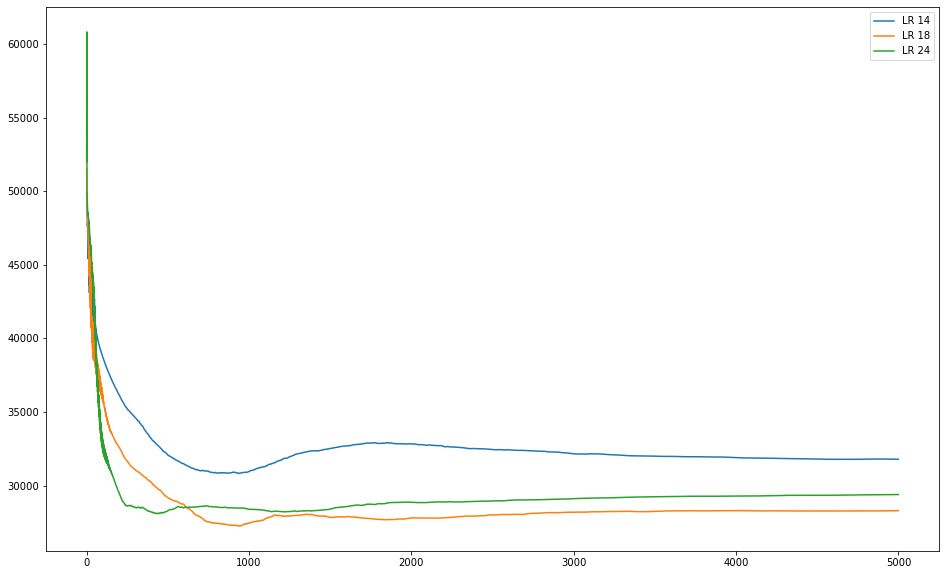

In [100]:
plt.figure(figsize=(16,10))

for i, r in enumerate(results5):
    plt.plot(r, label="LR {}".format(hidden[i]))
    plt.legend()

In [101]:
#  new learning rate decay formula, starting with higher lr
hidden = [14, 18, 24]
results6 = []
for h in hidden:
    mlp = MLP(X_train.shape[1], y_train_wide.shape[1],
            hidden_units=h,
            epochs=5000,
            learning_rate=0.01, loss='log', 
            first_activation = 'sig', second_activation='softmax', decay=.70)
    mlp.fit(X_train, y_train_wide)
    results6.append(mlp.loss)

Epoch 1 LR 0.01 Loss is 52361.23269137654
Epoch 2 LR 0.006999999999999999 Loss is 52052.1172324984
Epoch 3 LR 0.006999999999999999 Loss is 48965.77022202904
Epoch 4 LR 0.006999999999999999 Loss is 48920.42303441441
Epoch 5 LR 0.006999999999999999 Loss is 48881.00341816322
Epoch 6 LR 0.006999999999999999 Loss is 48755.712631006565
Epoch 7 LR 0.006999999999999999 Loss is 48562.18816971195
Epoch 8 LR 0.006999999999999999 Loss is 48264.63966547811
Epoch 9 LR 0.006999999999999999 Loss is 48168.29423985954
Epoch 10 LR 0.006999999999999999 Loss is 47916.69389229864
Epoch 11 LR 0.006999999999999999 Loss is 47813.65539887119
Epoch 12 LR 0.006999999999999999 Loss is 47640.946181729596
Epoch 13 LR 0.006999999999999999 Loss is 47468.122840749376
Epoch 14 LR 0.006999999999999999 Loss is 47301.80590613342
Epoch 15 LR 0.006999999999999999 Loss is 47175.867008448346
Epoch 16 LR 0.006999999999999999 Loss is 46994.92157847681
Epoch 17 LR 0.006999999999999999 Loss is 46937.06447960241
Epoch 18 LR 0.00699

<ipython-input-88-475c13e97a96>:47: RuntimeWarning: overflow encountered in exp
  sig = (1 / (1 + np.exp(-x)))


Epoch 40 LR 0.006999999999999999 Loss is 43975.7226520548
Epoch 41 LR 0.006999999999999999 Loss is 43807.94524872102
Epoch 42 LR 0.006999999999999999 Loss is 43776.80989919978
Epoch 43 LR 0.006999999999999999 Loss is 43542.38257081606
Epoch 44 LR 0.006999999999999999 Loss is 43636.97155952055
Epoch 45 LR 0.006999999999999999 Loss is 43247.25796823142
Epoch 46 LR 0.006999999999999999 Loss is 43559.65784381057
Epoch 47 LR 0.006999999999999999 Loss is 42943.04763327176
Epoch 48 LR 0.006999999999999999 Loss is 43502.80974915406
Epoch 49 LR 0.006999999999999999 Loss is 42648.39592969822
Epoch 50 LR 0.006999999999999999 Loss is 43420.34402145983
Epoch 51 LR 0.006999999999999999 Loss is 42413.348752645055
Epoch 52 LR 0.006999999999999999 Loss is 43226.871144363366
Epoch 53 LR 0.006999999999999999 Loss is 42232.380352233544
Epoch 54 LR 0.006999999999999999 Loss is 42951.12566635359
Epoch 55 LR 0.006999999999999999 Loss is 42102.26344314384
Epoch 56 LR 0.006999999999999999 Loss is 42671.8760648

Epoch 180 LR 0.006999999999999999 Loss is 36977.018808168265
Epoch 181 LR 0.006999999999999999 Loss is 36966.74958017023
Epoch 182 LR 0.006999999999999999 Loss is 36951.4256736639
Epoch 183 LR 0.006999999999999999 Loss is 36940.11874056807
Epoch 184 LR 0.006999999999999999 Loss is 36926.314414383916
Epoch 185 LR 0.006999999999999999 Loss is 36912.57515218759
Epoch 186 LR 0.006999999999999999 Loss is 36896.04706603197
Epoch 187 LR 0.006999999999999999 Loss is 36877.94302622884
Epoch 188 LR 0.006999999999999999 Loss is 36857.15185225777
Epoch 189 LR 0.006999999999999999 Loss is 36834.98998030622
Epoch 190 LR 0.006999999999999999 Loss is 36824.50545101628
Epoch 191 LR 0.006999999999999999 Loss is 36816.18135978919
Epoch 192 LR 0.006999999999999999 Loss is 36799.78840565835
Epoch 193 LR 0.006999999999999999 Loss is 36786.73285394775
Epoch 194 LR 0.006999999999999999 Loss is 36772.28413200852
Epoch 195 LR 0.006999999999999999 Loss is 36759.00011280012
Epoch 196 LR 0.006999999999999999 Loss 

Epoch 327 LR 0.004899999999999999 Loss is 35674.30645465389
Epoch 328 LR 0.004899999999999999 Loss is 35664.41149137225
Epoch 329 LR 0.004899999999999999 Loss is 35651.55371307012
Epoch 330 LR 0.004899999999999999 Loss is 35645.172274294346
Epoch 331 LR 0.004899999999999999 Loss is 35640.50761527961
Epoch 332 LR 0.004899999999999999 Loss is 35636.76782850186
Epoch 333 LR 0.004899999999999999 Loss is 35634.14746144107
Epoch 334 LR 0.004899999999999999 Loss is 35634.64368202079
Epoch 335 LR 0.004899999999999999 Loss is 35634.00045967209
Epoch 336 LR 0.004899999999999999 Loss is 35634.11749550725
Epoch 337 LR 0.004899999999999999 Loss is 35634.48551437571
Epoch 338 LR 0.004899999999999999 Loss is 35634.19838582175
Epoch 339 LR 0.004899999999999999 Loss is 35631.21981354477
Epoch 340 LR 0.004899999999999999 Loss is 35625.23431415489
Epoch 341 LR 0.004899999999999999 Loss is 35619.30966819928
Epoch 342 LR 0.004899999999999999 Loss is 35617.69092561468
Epoch 343 LR 0.004899999999999999 Loss 

Epoch 474 LR 0.004899999999999999 Loss is 34826.89799536167
Epoch 475 LR 0.004899999999999999 Loss is 34818.6990841698
Epoch 476 LR 0.004899999999999999 Loss is 34815.475386426
Epoch 477 LR 0.004899999999999999 Loss is 34814.43852301839
Epoch 478 LR 0.004899999999999999 Loss is 34811.228442371874
Epoch 479 LR 0.004899999999999999 Loss is 34810.430042931155
Epoch 480 LR 0.004899999999999999 Loss is 34810.204202933426
Epoch 481 LR 0.004899999999999999 Loss is 34807.99850230548
Epoch 482 LR 0.004899999999999999 Loss is 34801.57833015738
Epoch 483 LR 0.004899999999999999 Loss is 34792.64585179356
Epoch 484 LR 0.004899999999999999 Loss is 34787.04737684314
Epoch 485 LR 0.004899999999999999 Loss is 34782.400474607086
Epoch 486 LR 0.004899999999999999 Loss is 34776.94339116356
Epoch 487 LR 0.004899999999999999 Loss is 34776.98691216936
Epoch 488 LR 0.004899999999999999 Loss is 34779.102396915005
Epoch 489 LR 0.004899999999999999 Loss is 34776.42471097933
Epoch 490 LR 0.004899999999999999 Loss

Epoch 622 LR 0.003429999999999999 Loss is 34353.98416775961
Epoch 623 LR 0.003429999999999999 Loss is 34351.8465294305
Epoch 624 LR 0.003429999999999999 Loss is 34350.36747890643
Epoch 625 LR 0.003429999999999999 Loss is 34348.76000051277
Epoch 626 LR 0.003429999999999999 Loss is 34347.46723214857
Epoch 627 LR 0.003429999999999999 Loss is 34347.92423380649
Epoch 628 LR 0.003429999999999999 Loss is 34348.86478954582
Epoch 629 LR 0.003429999999999999 Loss is 34348.774848784284
Epoch 630 LR 0.003429999999999999 Loss is 34347.12104948948
Epoch 631 LR 0.003429999999999999 Loss is 34343.0405213799
Epoch 632 LR 0.003429999999999999 Loss is 34340.15117272774
Epoch 633 LR 0.003429999999999999 Loss is 34339.47960749259
Epoch 634 LR 0.003429999999999999 Loss is 34339.02659114103
Epoch 635 LR 0.003429999999999999 Loss is 34337.80600534036
Epoch 636 LR 0.003429999999999999 Loss is 34336.43653844806
Epoch 637 LR 0.003429999999999999 Loss is 34333.212652040704
Epoch 638 LR 0.003429999999999999 Loss i

Epoch 771 LR 0.002400999999999999 Loss is 34143.04357605576
Epoch 772 LR 0.002400999999999999 Loss is 34143.266917841254
Epoch 773 LR 0.002400999999999999 Loss is 34143.612976408585
Epoch 774 LR 0.002400999999999999 Loss is 34146.62867358902
Epoch 775 LR 0.002400999999999999 Loss is 34150.23733221744
Epoch 776 LR 0.002400999999999999 Loss is 34150.53804815872
Epoch 777 LR 0.002400999999999999 Loss is 34148.80810458101
Epoch 778 LR 0.002400999999999999 Loss is 34147.0314300615
Epoch 779 LR 0.002400999999999999 Loss is 34146.380133022096
Epoch 780 LR 0.002400999999999999 Loss is 34147.78855115429
Epoch 781 LR 0.002400999999999999 Loss is 34149.37853761073
Epoch 782 LR 0.002400999999999999 Loss is 34150.933601897756
Epoch 783 LR 0.002400999999999999 Loss is 34153.41028972494
Epoch 784 LR 0.002400999999999999 Loss is 34155.51206127746
Epoch 785 LR 0.002400999999999999 Loss is 34156.378853921015
Epoch 786 LR 0.002400999999999999 Loss is 34158.3598131314
Epoch 787 LR 0.002400999999999999 Los

Epoch 919 LR 0.002400999999999999 Loss is 34125.17673859365
Epoch 920 LR 0.002400999999999999 Loss is 34124.253727405536
Epoch 921 LR 0.002400999999999999 Loss is 34123.868389273586
Epoch 922 LR 0.002400999999999999 Loss is 34121.236966930395
Epoch 923 LR 0.002400999999999999 Loss is 34120.053567942225
Epoch 924 LR 0.002400999999999999 Loss is 34117.491746339925
Epoch 925 LR 0.002400999999999999 Loss is 34115.437980992254
Epoch 926 LR 0.002400999999999999 Loss is 34114.18040548642
Epoch 927 LR 0.002400999999999999 Loss is 34112.3836804276
Epoch 928 LR 0.002400999999999999 Loss is 34112.57268297334
Epoch 929 LR 0.002400999999999999 Loss is 34114.08463472956
Epoch 930 LR 0.002400999999999999 Loss is 34116.70236756061
Epoch 931 LR 0.002400999999999999 Loss is 34118.967078461
Epoch 932 LR 0.002400999999999999 Loss is 34119.06408065777
Epoch 933 LR 0.002400999999999999 Loss is 34118.38415146494
Epoch 934 LR 0.002400999999999999 Loss is 34118.972143019855
Epoch 935 LR 0.002400999999999999 Lo

Epoch 1056 LR 0.0016806999999999992 Loss is 34218.19012664955
Epoch 1057 LR 0.0016806999999999992 Loss is 34217.67004800657
Epoch 1058 LR 0.0016806999999999992 Loss is 34219.21238878548
Epoch 1059 LR 0.0016806999999999992 Loss is 34222.315626152704
Epoch 1060 LR 0.0016806999999999992 Loss is 34225.16838999969
Epoch 1061 LR 0.0016806999999999992 Loss is 34227.51102339752
Epoch 1062 LR 0.0016806999999999992 Loss is 34230.58545741049
Epoch 1063 LR 0.0016806999999999992 Loss is 34234.492452268765
Epoch 1064 LR 0.0016806999999999992 Loss is 34236.38689072284
Epoch 1065 LR 0.0016806999999999992 Loss is 34237.27015234393
Epoch 1066 LR 0.0016806999999999992 Loss is 34238.32892643244
Epoch 1067 LR 0.0016806999999999992 Loss is 34238.42415692202
Epoch 1068 LR 0.0016806999999999992 Loss is 34237.27407737747
Epoch 1069 LR 0.0016806999999999992 Loss is 34235.54337650139
Epoch 1070 LR 0.0016806999999999992 Loss is 34233.62797536648
Epoch 1071 LR 0.0016806999999999992 Loss is 34231.84868110153
Epoch 

Epoch 1201 LR 0.0016806999999999992 Loss is 34311.05928109712
Epoch 1202 LR 0.0016806999999999992 Loss is 34314.11622019792
Epoch 1203 LR 0.0016806999999999992 Loss is 34316.734359596325
Epoch 1204 LR 0.0016806999999999992 Loss is 34318.573440891596
Epoch 1205 LR 0.0016806999999999992 Loss is 34319.48770444586
Epoch 1206 LR 0.0016806999999999992 Loss is 34319.62135207806
Epoch 1207 LR 0.0016806999999999992 Loss is 34319.27529302544
Epoch 1208 LR 0.0016806999999999992 Loss is 34318.734385875265
Epoch 1209 LR 0.0016806999999999992 Loss is 34316.74370053537
Epoch 1210 LR 0.0016806999999999992 Loss is 34313.426585969224
Epoch 1211 LR 0.0016806999999999992 Loss is 34310.65518188289
Epoch 1212 LR 0.0016806999999999992 Loss is 34310.320642160936
Epoch 1213 LR 0.0016806999999999992 Loss is 34310.609874719805
Epoch 1214 LR 0.0016806999999999992 Loss is 34309.58574290814
Epoch 1215 LR 0.0016806999999999992 Loss is 34307.13713760869
Epoch 1216 LR 0.0016806999999999992 Loss is 34306.536229457546
E

Epoch 1334 LR 0.0011764899999999994 Loss is 34367.055888434865
Epoch 1335 LR 0.0011764899999999994 Loss is 34366.29166696852
Epoch 1336 LR 0.0011764899999999994 Loss is 34366.17278504459
Epoch 1337 LR 0.0011764899999999994 Loss is 34366.483526617514
Epoch 1338 LR 0.0011764899999999994 Loss is 34366.82326369425
Epoch 1339 LR 0.0011764899999999994 Loss is 34367.18989308065
Epoch 1340 LR 0.0011764899999999994 Loss is 34367.8859846791
Epoch 1341 LR 0.0011764899999999994 Loss is 34368.799557608436
Epoch 1342 LR 0.0011764899999999994 Loss is 34369.59333466129
Epoch 1343 LR 0.0011764899999999994 Loss is 34370.36416680561
Epoch 1344 LR 0.0011764899999999994 Loss is 34370.98823962258
Epoch 1345 LR 0.0011764899999999994 Loss is 34371.42522014216
Epoch 1346 LR 0.0011764899999999994 Loss is 34371.64722513743
Epoch 1347 LR 0.0011764899999999994 Loss is 34371.378938666465
Epoch 1348 LR 0.0011764899999999994 Loss is 34370.6208891628
Epoch 1349 LR 0.0011764899999999994 Loss is 34369.58378161647
Epoch 

Epoch 1476 LR 0.0011764899999999994 Loss is 34396.06832258365
Epoch 1477 LR 0.0011764899999999994 Loss is 34397.76600569992
Epoch 1478 LR 0.0011764899999999994 Loss is 34399.4166050192
Epoch 1479 LR 0.0011764899999999994 Loss is 34400.97386327997
Epoch 1480 LR 0.0011764899999999994 Loss is 34401.90452775399
Epoch 1481 LR 0.0011764899999999994 Loss is 34402.247831342036
Epoch 1482 LR 0.0011764899999999994 Loss is 34402.19272073599
Epoch 1483 LR 0.0011764899999999994 Loss is 34402.32105473304
Epoch 1484 LR 0.0011764899999999994 Loss is 34402.615747925054
Epoch 1485 LR 0.0011764899999999994 Loss is 34402.65243699056
Epoch 1486 LR 0.0011764899999999994 Loss is 34402.696708535674
Epoch 1487 LR 0.0011764899999999994 Loss is 34403.12020663445
Epoch 1488 LR 0.0011764899999999994 Loss is 34403.56800790938
Epoch 1489 LR 0.0011764899999999994 Loss is 34403.520122125854
Epoch 1490 LR 0.0011764899999999994 Loss is 34403.24287297647
Epoch 1491 LR 0.0011764899999999994 Loss is 34403.18765517631
Epoch

Epoch 1617 LR 0.0008235429999999996 Loss is 34461.29880179699
Epoch 1618 LR 0.0008235429999999996 Loss is 34462.206535061945
Epoch 1619 LR 0.0008235429999999996 Loss is 34463.30487761706
Epoch 1620 LR 0.0008235429999999996 Loss is 34464.41040222866
Epoch 1621 LR 0.0008235429999999996 Loss is 34465.42508978982
Epoch 1622 LR 0.0008235429999999996 Loss is 34466.279939480395
Epoch 1623 LR 0.0008235429999999996 Loss is 34466.83805300374
Epoch 1624 LR 0.0008235429999999996 Loss is 34466.972850321894
Epoch 1625 LR 0.0008235429999999996 Loss is 34466.71652211022
Epoch 1626 LR 0.0008235429999999996 Loss is 34466.30175491709
Epoch 1627 LR 0.0008235429999999996 Loss is 34466.088038716654
Epoch 1628 LR 0.0008235429999999996 Loss is 34466.3527752911
Epoch 1629 LR 0.0008235429999999996 Loss is 34467.136386691345
Epoch 1630 LR 0.0008235429999999996 Loss is 34468.28247166914
Epoch 1631 LR 0.0008235429999999996 Loss is 34469.567751802024
Epoch 1632 LR 0.0008235429999999996 Loss is 34470.67837824403
Epo

Epoch 1753 LR 0.0005764800999999997 Loss is 34477.18265688401
Epoch 1754 LR 0.0005764800999999997 Loss is 34477.15883726751
Epoch 1755 LR 0.0005764800999999997 Loss is 34477.320147923296
Epoch 1756 LR 0.0005764800999999997 Loss is 34477.67616268623
Epoch 1757 LR 0.0005764800999999997 Loss is 34478.14804777364
Epoch 1758 LR 0.0005764800999999997 Loss is 34478.62477786632
Epoch 1759 LR 0.0005764800999999997 Loss is 34479.03363551651
Epoch 1760 LR 0.0005764800999999997 Loss is 34479.34600484797
Epoch 1761 LR 0.0005764800999999997 Loss is 34479.544581699796
Epoch 1762 LR 0.0005764800999999997 Loss is 34479.62051833489
Epoch 1763 LR 0.0005764800999999997 Loss is 34479.580084311674
Epoch 1764 LR 0.0005764800999999997 Loss is 34479.43984159825
Epoch 1765 LR 0.0005764800999999997 Loss is 34479.20967949715
Epoch 1766 LR 0.0005764800999999997 Loss is 34478.868820755175
Epoch 1767 LR 0.0005764800999999997 Loss is 34478.36108407207
Epoch 1768 LR 0.0005764800999999997 Loss is 34477.63535677138
Epoc

Epoch 1887 LR 0.0005764800999999997 Loss is 34512.18179777502
Epoch 1888 LR 0.0005764800999999997 Loss is 34511.91043935599
Epoch 1889 LR 0.0005764800999999997 Loss is 34511.592602706885
Epoch 1890 LR 0.0005764800999999997 Loss is 34511.26948622496
Epoch 1891 LR 0.0005764800999999997 Loss is 34511.000479269154
Epoch 1892 LR 0.0005764800999999997 Loss is 34510.82392408025
Epoch 1893 LR 0.0005764800999999997 Loss is 34510.72822020006
Epoch 1894 LR 0.0005764800999999997 Loss is 34510.66254073461
Epoch 1895 LR 0.0005764800999999997 Loss is 34510.58406032592
Epoch 1896 LR 0.0005764800999999997 Loss is 34510.493530475505
Epoch 1897 LR 0.0005764800999999997 Loss is 34510.42931194639
Epoch 1898 LR 0.0005764800999999997 Loss is 34510.43681043745
Epoch 1899 LR 0.0005764800999999997 Loss is 34510.54357678435
Epoch 1900 LR 0.0005764800999999997 Loss is 34510.75546214166
Epoch 1901 LR 0.0005764800999999997 Loss is 34511.06923999715
Epoch 1902 LR 0.0005764800999999997 Loss is 34511.48666602939
Epoch

Epoch 2029 LR 0.00040353606999999974 Loss is 34523.53580775622
Epoch 2030 LR 0.00040353606999999974 Loss is 34524.26216436499
Epoch 2031 LR 0.00040353606999999974 Loss is 34524.995245139005
Epoch 2032 LR 0.00040353606999999974 Loss is 34525.70970430168
Epoch 2033 LR 0.00040353606999999974 Loss is 34526.37793565263
Epoch 2034 LR 0.00040353606999999974 Loss is 34526.98055594562
Epoch 2035 LR 0.00040353606999999974 Loss is 34527.50804568447
Epoch 2036 LR 0.00040353606999999974 Loss is 34527.95630999722
Epoch 2037 LR 0.00040353606999999974 Loss is 34528.32282549247
Epoch 2038 LR 0.00040353606999999974 Loss is 34528.60661414371
Epoch 2039 LR 0.00040353606999999974 Loss is 34528.81141951167
Epoch 2040 LR 0.00040353606999999974 Loss is 34528.949815983964
Epoch 2041 LR 0.00040353606999999974 Loss is 34529.04633940323
Epoch 2042 LR 0.00040353606999999974 Loss is 34529.137431318195
Epoch 2043 LR 0.00040353606999999974 Loss is 34529.25896567981
Epoch 2044 LR 0.00040353606999999974 Loss is 34529.4

Epoch 2166 LR 0.00040353606999999974 Loss is 34521.55575009094
Epoch 2167 LR 0.00040353606999999974 Loss is 34521.69594938515
Epoch 2168 LR 0.00040353606999999974 Loss is 34521.81665517315
Epoch 2169 LR 0.00040353606999999974 Loss is 34521.92985510317
Epoch 2170 LR 0.00040353606999999974 Loss is 34522.04707166859
Epoch 2171 LR 0.00040353606999999974 Loss is 34522.174354553536
Epoch 2172 LR 0.00040353606999999974 Loss is 34522.30904857416
Epoch 2173 LR 0.00040353606999999974 Loss is 34522.44159964141
Epoch 2174 LR 0.00040353606999999974 Loss is 34522.56144115928
Epoch 2175 LR 0.00040353606999999974 Loss is 34522.662548472545
Epoch 2176 LR 0.00040353606999999974 Loss is 34522.74557506326
Epoch 2177 LR 0.00040353606999999974 Loss is 34522.81657713338
Epoch 2178 LR 0.00040353606999999974 Loss is 34522.88381433955
Epoch 2179 LR 0.00040353606999999974 Loss is 34522.95417813264
Epoch 2180 LR 0.00040353606999999974 Loss is 34523.03045711442
Epoch 2181 LR 0.00040353606999999974 Loss is 34523.11

Epoch 2304 LR 0.0002824752489999998 Loss is 34531.971424284064
Epoch 2305 LR 0.0002824752489999998 Loss is 34532.50444377319
Epoch 2306 LR 0.0002824752489999998 Loss is 34533.03383351174
Epoch 2307 LR 0.0002824752489999998 Loss is 34533.54933679007
Epoch 2308 LR 0.0002824752489999998 Loss is 34534.045829558614
Epoch 2309 LR 0.0002824752489999998 Loss is 34534.520816199125
Epoch 2310 LR 0.0002824752489999998 Loss is 34534.9730095625
Epoch 2311 LR 0.0002824752489999998 Loss is 34535.40210821157
Epoch 2312 LR 0.0002824752489999998 Loss is 34535.80906102286
Epoch 2313 LR 0.0002824752489999998 Loss is 34536.19620256586
Epoch 2314 LR 0.0002824752489999998 Loss is 34536.567017600646
Epoch 2315 LR 0.0002824752489999998 Loss is 34536.925580847885
Epoch 2316 LR 0.0002824752489999998 Loss is 34537.27584746305
Epoch 2317 LR 0.0002824752489999998 Loss is 34537.62099397728
Epoch 2318 LR 0.0002824752489999998 Loss is 34537.962980409095
Epoch 2319 LR 0.0002824752489999998 Loss is 34538.302443177956
Ep

Epoch 2447 LR 0.0002824752489999998 Loss is 34590.17487456876
Epoch 2448 LR 0.0002824752489999998 Loss is 34590.13168120601
Epoch 2449 LR 0.0002824752489999998 Loss is 34590.07714948673
Epoch 2450 LR 0.0002824752489999998 Loss is 34590.011805673785
Epoch 2451 LR 0.0002824752489999998 Loss is 34589.93699546675
Epoch 2452 LR 0.0002824752489999998 Loss is 34589.85514407939
Epoch 2453 LR 0.0002824752489999998 Loss is 34589.76999097796
Epoch 2454 LR 0.0002824752489999998 Loss is 34589.6867865258
Epoch 2455 LR 0.0002824752489999998 Loss is 34589.6124298754
Epoch 2456 LR 0.0002824752489999998 Loss is 34589.555514905645
Epoch 2457 LR 0.0002824752489999998 Loss is 34589.526218292915
Epoch 2458 LR 0.0002824752489999998 Loss is 34589.53587033595
Epoch 2459 LR 0.0002824752489999998 Loss is 34589.59587797785
Epoch 2460 LR 0.0002824752489999998 Loss is 34589.71561289366
Epoch 2461 LR 0.0002824752489999998 Loss is 34589.89946733924
Epoch 2462 LR 0.0002824752489999998 Loss is 34590.1446347245
Epoch 24

Epoch 2585 LR 0.00019773267429999984 Loss is 34593.61715563905
Epoch 2586 LR 0.00019773267429999984 Loss is 34593.61764366544
Epoch 2587 LR 0.00019773267429999984 Loss is 34593.64173004649
Epoch 2588 LR 0.00019773267429999984 Loss is 34593.69254172771
Epoch 2589 LR 0.00019773267429999984 Loss is 34593.77016496128
Epoch 2590 LR 0.00019773267429999984 Loss is 34593.87007650456
Epoch 2591 LR 0.00019773267429999984 Loss is 34593.98335621157
Epoch 2592 LR 0.00019773267429999984 Loss is 34594.09922514574
Epoch 2593 LR 0.00019773267429999984 Loss is 34594.20842369768
Epoch 2594 LR 0.00019773267429999984 Loss is 34594.30536076022
Epoch 2595 LR 0.00019773267429999984 Loss is 34594.388333567105
Epoch 2596 LR 0.00019773267429999984 Loss is 34594.4584922971
Epoch 2597 LR 0.00019773267429999984 Loss is 34594.51849597461
Epoch 2598 LR 0.00019773267429999984 Loss is 34594.57142078932
Epoch 2599 LR 0.00019773267429999984 Loss is 34594.62007616777
Epoch 2600 LR 0.00019773267429999984 Loss is 34594.6666

Epoch 2723 LR 0.00019773267429999984 Loss is 34620.2355534484
Epoch 2724 LR 0.00019773267429999984 Loss is 34620.26523313941
Epoch 2725 LR 0.00019773267429999984 Loss is 34620.27421395501
Epoch 2726 LR 0.00019773267429999984 Loss is 34620.264545004735
Epoch 2727 LR 0.00019773267429999984 Loss is 34620.23796046789
Epoch 2728 LR 0.00019773267429999984 Loss is 34620.19552400856
Epoch 2729 LR 0.00019773267429999984 Loss is 34620.13745140666
Epoch 2730 LR 0.00019773267429999984 Loss is 34620.063219248164
Epoch 2731 LR 0.00019773267429999984 Loss is 34619.97196012296
Epoch 2732 LR 0.00019773267429999984 Loss is 34619.86302326241
Epoch 2733 LR 0.00019773267429999984 Loss is 34619.73651909395
Epoch 2734 LR 0.00019773267429999984 Loss is 34619.59369066339
Epoch 2735 LR 0.00019773267429999984 Loss is 34619.437026803236
Epoch 2736 LR 0.00019773267429999984 Loss is 34619.2701014668
Epoch 2737 LR 0.00019773267429999984 Loss is 34619.09717062121
Epoch 2738 LR 0.00019773267429999984 Loss is 34618.922

Epoch 2855 LR 0.00013841287200999988 Loss is 34618.72978928517
Epoch 2856 LR 0.00013841287200999988 Loss is 34618.896052119184
Epoch 2857 LR 0.00013841287200999988 Loss is 34619.06289800438
Epoch 2858 LR 0.00013841287200999988 Loss is 34619.229174556574
Epoch 2859 LR 0.00013841287200999988 Loss is 34619.39381285735
Epoch 2860 LR 0.00013841287200999988 Loss is 34619.555865618095
Epoch 2861 LR 0.00013841287200999988 Loss is 34619.71453272291
Epoch 2862 LR 0.00013841287200999988 Loss is 34619.869178543246
Epoch 2863 LR 0.00013841287200999988 Loss is 34620.0193451089
Epoch 2864 LR 0.00013841287200999988 Loss is 34620.16476420207
Epoch 2865 LR 0.00013841287200999988 Loss is 34620.30537003228
Epoch 2866 LR 0.00013841287200999988 Loss is 34620.44131256529
Epoch 2867 LR 0.00013841287200999988 Loss is 34620.572969942834
Epoch 2868 LR 0.00013841287200999988 Loss is 34620.70095684505
Epoch 2869 LR 0.00013841287200999988 Loss is 34620.82612423805
Epoch 2870 LR 0.00013841287200999988 Loss is 34620.

Epoch 2996 LR 0.00013841287200999988 Loss is 34631.17134226608
Epoch 2997 LR 0.00013841287200999988 Loss is 34631.15865080702
Epoch 2998 LR 0.00013841287200999988 Loss is 34631.147988244724
Epoch 2999 LR 0.00013841287200999988 Loss is 34631.13966974028
Epoch 3000 LR 0.00013841287200999988 Loss is 34631.13402307171
Epoch 3001 LR 0.00013841287200999988 Loss is 34631.13138782149
Epoch 3002 LR 9.688901040699991e-05 Loss is 34631.13211280265
Epoch 3003 LR 9.688901040699991e-05 Loss is 34631.13480949342
Epoch 3004 LR 9.688901040699991e-05 Loss is 34631.13944636985
Epoch 3005 LR 9.688901040699991e-05 Loss is 34631.14614172694
Epoch 3006 LR 9.688901040699991e-05 Loss is 34631.15500945207
Epoch 3007 LR 9.688901040699991e-05 Loss is 34631.166156661384
Epoch 3008 LR 9.688901040699991e-05 Loss is 34631.179681048365
Epoch 3009 LR 9.688901040699991e-05 Loss is 34631.19566802022
Epoch 3010 LR 9.688901040699991e-05 Loss is 34631.21418772978
Epoch 3011 LR 9.688901040699991e-05 Loss is 34631.23529214544

Epoch 3130 LR 9.688901040699991e-05 Loss is 34635.62358522922
Epoch 3131 LR 9.688901040699991e-05 Loss is 34635.60711254538
Epoch 3132 LR 9.688901040699991e-05 Loss is 34635.5962327576
Epoch 3133 LR 9.688901040699991e-05 Loss is 34635.5906392775
Epoch 3134 LR 9.688901040699991e-05 Loss is 34635.58987110086
Epoch 3135 LR 9.688901040699991e-05 Loss is 34635.5933702622
Epoch 3136 LR 9.688901040699991e-05 Loss is 34635.60054698422
Epoch 3137 LR 9.688901040699991e-05 Loss is 34635.61084294258
Epoch 3138 LR 9.688901040699991e-05 Loss is 34635.62378467384
Epoch 3139 LR 9.688901040699991e-05 Loss is 34635.63902212131
Epoch 3140 LR 9.688901040699991e-05 Loss is 34635.65635051118
Epoch 3141 LR 9.688901040699991e-05 Loss is 34635.675716299964
Epoch 3142 LR 9.688901040699991e-05 Loss is 34635.69720942167
Epoch 3143 LR 9.688901040699991e-05 Loss is 34635.721044494705
Epoch 3144 LR 9.688901040699991e-05 Loss is 34635.74753329216
Epoch 3145 LR 9.688901040699991e-05 Loss is 34635.77705000555
Epoch 314

Epoch 3275 LR 6.782230728489993e-05 Loss is 34640.82163386049
Epoch 3276 LR 6.782230728489993e-05 Loss is 34640.835835185535
Epoch 3277 LR 6.782230728489993e-05 Loss is 34640.85029590988
Epoch 3278 LR 6.782230728489993e-05 Loss is 34640.86510756374
Epoch 3279 LR 6.782230728489993e-05 Loss is 34640.88036446252
Epoch 3280 LR 6.782230728489993e-05 Loss is 34640.896164263046
Epoch 3281 LR 6.782230728489993e-05 Loss is 34640.912608503364
Epoch 3282 LR 6.782230728489993e-05 Loss is 34640.92980312451
Epoch 3283 LR 6.782230728489993e-05 Loss is 34640.947858972286
Epoch 3284 LR 6.782230728489993e-05 Loss is 34640.966892277334
Epoch 3285 LR 6.782230728489993e-05 Loss is 34640.98702511078
Epoch 3286 LR 6.782230728489993e-05 Loss is 34641.00838581162
Epoch 3287 LR 6.782230728489993e-05 Loss is 34641.03110937938
Epoch 3288 LR 6.782230728489993e-05 Loss is 34641.05533782248
Epoch 3289 LR 6.782230728489993e-05 Loss is 34641.081220445536
Epoch 3290 LR 6.782230728489993e-05 Loss is 34641.108914049975
E

Epoch 3415 LR 6.782230728489993e-05 Loss is 34649.21179371433
Epoch 3416 LR 6.782230728489993e-05 Loss is 34649.37412146389
Epoch 3417 LR 6.782230728489993e-05 Loss is 34649.53645968515
Epoch 3418 LR 6.782230728489993e-05 Loss is 34649.699167662446
Epoch 3419 LR 6.782230728489993e-05 Loss is 34649.86262129341
Epoch 3420 LR 6.782230728489993e-05 Loss is 34650.02721067045
Epoch 3421 LR 6.782230728489993e-05 Loss is 34650.19333806255
Epoch 3422 LR 6.782230728489993e-05 Loss is 34650.36141603116
Epoch 3423 LR 6.782230728489993e-05 Loss is 34650.531865352415
Epoch 3424 LR 6.782230728489993e-05 Loss is 34650.70511235457
Epoch 3425 LR 6.782230728489993e-05 Loss is 34650.881585216186
Epoch 3426 LR 6.782230728489993e-05 Loss is 34651.061708722584
Epoch 3427 LR 6.782230728489993e-05 Loss is 34651.24589696626
Epoch 3428 LR 6.782230728489993e-05 Loss is 34651.43454353101
Epoch 3429 LR 6.782230728489993e-05 Loss is 34651.62800885271
Epoch 3430 LR 6.782230728489993e-05 Loss is 34651.82660473005
Epoc

Epoch 3560 LR 4.747561509942995e-05 Loss is 34660.08893854514
Epoch 3561 LR 4.747561509942995e-05 Loss is 34660.061253423904
Epoch 3562 LR 4.747561509942995e-05 Loss is 34660.03425624899
Epoch 3563 LR 4.747561509942995e-05 Loss is 34660.00799339761
Epoch 3564 LR 4.747561509942995e-05 Loss is 34659.9825122196
Epoch 3565 LR 4.747561509942995e-05 Loss is 34659.957861104216
Epoch 3566 LR 4.747561509942995e-05 Loss is 34659.93408954095
Epoch 3567 LR 4.747561509942995e-05 Loss is 34659.91124817052
Epoch 3568 LR 4.747561509942995e-05 Loss is 34659.889388823154
Epoch 3569 LR 4.747561509942995e-05 Loss is 34659.868564539385
Epoch 3570 LR 4.747561509942995e-05 Loss is 34659.84882956876
Epoch 3571 LR 4.747561509942995e-05 Loss is 34659.83023934105
Epoch 3572 LR 4.747561509942995e-05 Loss is 34659.812850403985
Epoch 3573 LR 4.747561509942995e-05 Loss is 34659.79672032154
Epoch 3574 LR 4.747561509942995e-05 Loss is 34659.7819075257
Epoch 3575 LR 4.747561509942995e-05 Loss is 34659.768471116055
Epoc

Epoch 3696 LR 4.747561509942995e-05 Loss is 34663.31829186497
Epoch 3697 LR 4.747561509942995e-05 Loss is 34663.32433553032
Epoch 3698 LR 4.747561509942995e-05 Loss is 34663.33057164054
Epoch 3699 LR 4.747561509942995e-05 Loss is 34663.33698958707
Epoch 3700 LR 4.747561509942995e-05 Loss is 34663.34357241956
Epoch 3701 LR 4.747561509942995e-05 Loss is 34663.350297719604
Epoch 3702 LR 4.747561509942995e-05 Loss is 34663.357138621526
Epoch 3703 LR 4.747561509942995e-05 Loss is 34663.36406494242
Epoch 3704 LR 4.747561509942995e-05 Loss is 34663.371044378895
Epoch 3705 LR 4.747561509942995e-05 Loss is 34663.37804372515
Epoch 3706 LR 4.747561509942995e-05 Loss is 34663.38503006643
Epoch 3707 LR 4.747561509942995e-05 Loss is 34663.39197190346
Epoch 3708 LR 4.747561509942995e-05 Loss is 34663.39884016721
Epoch 3709 LR 4.747561509942995e-05 Loss is 34663.405609087706
Epoch 3710 LR 4.747561509942995e-05 Loss is 34663.412256888
Epoch 3711 LR 4.747561509942995e-05 Loss is 34663.41876628022
Epoch 

Epoch 3840 LR 3.323293056960096e-05 Loss is 34661.94997622391
Epoch 3841 LR 3.323293056960096e-05 Loss is 34661.93387194069
Epoch 3842 LR 3.323293056960096e-05 Loss is 34661.91815607974
Epoch 3843 LR 3.323293056960096e-05 Loss is 34661.902851126404
Epoch 3844 LR 3.323293056960096e-05 Loss is 34661.88798042734
Epoch 3845 LR 3.323293056960096e-05 Loss is 34661.873568210714
Epoch 3846 LR 3.323293056960096e-05 Loss is 34661.85963960484
Epoch 3847 LR 3.323293056960096e-05 Loss is 34661.846220654035
Epoch 3848 LR 3.323293056960096e-05 Loss is 34661.83333833199
Epoch 3849 LR 3.323293056960096e-05 Loss is 34661.821020551535
Epoch 3850 LR 3.323293056960096e-05 Loss is 34661.809296170955
Epoch 3851 LR 3.323293056960096e-05 Loss is 34661.79819499547
Epoch 3852 LR 3.323293056960096e-05 Loss is 34661.787747774055
Epoch 3853 LR 3.323293056960096e-05 Loss is 34661.77798619019
Epoch 3854 LR 3.323293056960096e-05 Loss is 34661.76894284618
Epoch 3855 LR 3.323293056960096e-05 Loss is 34661.76065123996
Ep

Epoch 3974 LR 3.323293056960096e-05 Loss is 34664.27608295143
Epoch 3975 LR 3.323293056960096e-05 Loss is 34664.27640323383
Epoch 3976 LR 3.323293056960096e-05 Loss is 34664.276921573895
Epoch 3977 LR 3.323293056960096e-05 Loss is 34664.27765842286
Epoch 3978 LR 3.323293056960096e-05 Loss is 34664.27863284976
Epoch 3979 LR 3.323293056960096e-05 Loss is 34664.27986257566
Epoch 3980 LR 3.323293056960096e-05 Loss is 34664.281364013295
Epoch 3981 LR 3.323293056960096e-05 Loss is 34664.2831523111
Epoch 3982 LR 3.323293056960096e-05 Loss is 34664.285241400874
Epoch 3983 LR 3.323293056960096e-05 Loss is 34664.28764404828
Epoch 3984 LR 3.323293056960096e-05 Loss is 34664.29037190509
Epoch 3985 LR 3.323293056960096e-05 Loss is 34664.293435562184
Epoch 3986 LR 3.323293056960096e-05 Loss is 34664.296844602555
Epoch 3987 LR 3.323293056960096e-05 Loss is 34664.300607652964
Epoch 3988 LR 3.323293056960096e-05 Loss is 34664.30473243355
Epoch 3989 LR 3.323293056960096e-05 Loss is 34664.30922580462
Epo

Epoch 4116 LR 2.3263051398720672e-05 Loss is 34665.251842034806
Epoch 4117 LR 2.3263051398720672e-05 Loss is 34665.251691184305
Epoch 4118 LR 2.3263051398720672e-05 Loss is 34665.25141706564
Epoch 4119 LR 2.3263051398720672e-05 Loss is 34665.25102308938
Epoch 4120 LR 2.3263051398720672e-05 Loss is 34665.25051267761
Epoch 4121 LR 2.3263051398720672e-05 Loss is 34665.249889261104
Epoch 4122 LR 2.3263051398720672e-05 Loss is 34665.249156276506
Epoch 4123 LR 2.3263051398720672e-05 Loss is 34665.24831716387
Epoch 4124 LR 2.3263051398720672e-05 Loss is 34665.24737536407
Epoch 4125 LR 2.3263051398720672e-05 Loss is 34665.24633431657
Epoch 4126 LR 2.3263051398720672e-05 Loss is 34665.24519745705
Epoch 4127 LR 2.3263051398720672e-05 Loss is 34665.24396821536
Epoch 4128 LR 2.3263051398720672e-05 Loss is 34665.24265001351
Epoch 4129 LR 2.3263051398720672e-05 Loss is 34665.24124626367
Epoch 4130 LR 2.3263051398720672e-05 Loss is 34665.23976036639
Epoch 4131 LR 2.3263051398720672e-05 Loss is 34665.

Epoch 4254 LR 1.628413597910447e-05 Loss is 34665.18417015854
Epoch 4255 LR 1.628413597910447e-05 Loss is 34665.187211915756
Epoch 4256 LR 1.628413597910447e-05 Loss is 34665.19032022749
Epoch 4257 LR 1.628413597910447e-05 Loss is 34665.19349586585
Epoch 4258 LR 1.628413597910447e-05 Loss is 34665.19673960729
Epoch 4259 LR 1.628413597910447e-05 Loss is 34665.20005223214
Epoch 4260 LR 1.628413597910447e-05 Loss is 34665.20343452414
Epoch 4261 LR 1.628413597910447e-05 Loss is 34665.20688726994
Epoch 4262 LR 1.628413597910447e-05 Loss is 34665.210411258406
Epoch 4263 LR 1.628413597910447e-05 Loss is 34665.2140072803
Epoch 4264 LR 1.628413597910447e-05 Loss is 34665.21767612762
Epoch 4265 LR 1.628413597910447e-05 Loss is 34665.22141859305
Epoch 4266 LR 1.628413597910447e-05 Loss is 34665.22523546939
Epoch 4267 LR 1.628413597910447e-05 Loss is 34665.22912754907
Epoch 4268 LR 1.628413597910447e-05 Loss is 34665.23309562341
Epoch 4269 LR 1.628413597910447e-05 Loss is 34665.23714048219
Epoch 4

Epoch 4399 LR 1.628413597910447e-05 Loss is 34666.53880852604
Epoch 4400 LR 1.628413597910447e-05 Loss is 34666.55400347807
Epoch 4401 LR 1.628413597910447e-05 Loss is 34666.569247712636
Epoch 4402 LR 1.628413597910447e-05 Loss is 34666.58454060276
Epoch 4403 LR 1.628413597910447e-05 Loss is 34666.599881540096
Epoch 4404 LR 1.628413597910447e-05 Loss is 34666.61526993546
Epoch 4405 LR 1.628413597910447e-05 Loss is 34666.63070521947
Epoch 4406 LR 1.628413597910447e-05 Loss is 34666.64618684288
Epoch 4407 LR 1.628413597910447e-05 Loss is 34666.6617142772
Epoch 4408 LR 1.628413597910447e-05 Loss is 34666.67728701512
Epoch 4409 LR 1.628413597910447e-05 Loss is 34666.69290457094
Epoch 4410 LR 1.628413597910447e-05 Loss is 34666.70856648101
Epoch 4411 LR 1.628413597910447e-05 Loss is 34666.72427230413
Epoch 4412 LR 1.628413597910447e-05 Loss is 34666.740021622005
Epoch 4413 LR 1.628413597910447e-05 Loss is 34666.75581403954
Epoch 4414 LR 1.628413597910447e-05 Loss is 34666.77164918512
Epoch 

Epoch 4544 LR 1.1398895185373128e-05 Loss is 34668.96491589921
Epoch 4545 LR 1.1398895185373128e-05 Loss is 34668.980134487305
Epoch 4546 LR 1.1398895185373128e-05 Loss is 34668.995368460804
Epoch 4547 LR 1.1398895185373128e-05 Loss is 34669.01061735984
Epoch 4548 LR 1.1398895185373128e-05 Loss is 34669.02588072033
Epoch 4549 LR 1.1398895185373128e-05 Loss is 34669.04115807429
Epoch 4550 LR 1.1398895185373128e-05 Loss is 34669.05644894988
Epoch 4551 LR 1.1398895185373128e-05 Loss is 34669.07175287165
Epoch 4552 LR 1.1398895185373128e-05 Loss is 34669.087069360576
Epoch 4553 LR 1.1398895185373128e-05 Loss is 34669.10239793436
Epoch 4554 LR 1.1398895185373128e-05 Loss is 34669.11773810745
Epoch 4555 LR 1.1398895185373128e-05 Loss is 34669.13308939131
Epoch 4556 LR 1.1398895185373128e-05 Loss is 34669.14845129447
Epoch 4557 LR 1.1398895185373128e-05 Loss is 34669.163823322735
Epoch 4558 LR 1.1398895185373128e-05 Loss is 34669.17920497931
Epoch 4559 LR 1.1398895185373128e-05 Loss is 34669.

Epoch 4676 LR 1.1398895185373128e-05 Loss is 34670.9235443654
Epoch 4677 LR 1.1398895185373128e-05 Loss is 34670.93671148886
Epoch 4678 LR 1.1398895185373128e-05 Loss is 34670.94983884122
Epoch 4679 LR 1.1398895185373128e-05 Loss is 34670.96292625309
Epoch 4680 LR 1.1398895185373128e-05 Loss is 34670.97597356053
Epoch 4681 LR 1.1398895185373128e-05 Loss is 34670.98898060534
Epoch 4682 LR 1.1398895185373128e-05 Loss is 34671.00194723477
Epoch 4683 LR 1.1398895185373128e-05 Loss is 34671.01487330174
Epoch 4684 LR 1.1398895185373128e-05 Loss is 34671.02775866477
Epoch 4685 LR 1.1398895185373128e-05 Loss is 34671.04060318794
Epoch 4686 LR 1.1398895185373128e-05 Loss is 34671.05340674102
Epoch 4687 LR 1.1398895185373128e-05 Loss is 34671.06616919926
Epoch 4688 LR 1.1398895185373128e-05 Loss is 34671.07889044367
Epoch 4689 LR 1.1398895185373128e-05 Loss is 34671.09157036073
Epoch 4690 LR 1.1398895185373128e-05 Loss is 34671.10420884265
Epoch 4691 LR 1.1398895185373128e-05 Loss is 34671.11680

Epoch 4819 LR 7.97922662976119e-06 Loss is 34672.239857666216
Epoch 4820 LR 7.97922662976119e-06 Loss is 34672.245821627315
Epoch 4821 LR 7.97922662976119e-06 Loss is 34672.25177258555
Epoch 4822 LR 7.97922662976119e-06 Loss is 34672.2577106323
Epoch 4823 LR 7.97922662976119e-06 Loss is 34672.263635859024
Epoch 4824 LR 7.97922662976119e-06 Loss is 34672.26954835714
Epoch 4825 LR 7.97922662976119e-06 Loss is 34672.27544821811
Epoch 4826 LR 7.97922662976119e-06 Loss is 34672.28133553339
Epoch 4827 LR 7.97922662976119e-06 Loss is 34672.28721039441
Epoch 4828 LR 7.97922662976119e-06 Loss is 34672.293072892586
Epoch 4829 LR 7.97922662976119e-06 Loss is 34672.29892311934
Epoch 4830 LR 7.97922662976119e-06 Loss is 34672.304761165986
Epoch 4831 LR 7.97922662976119e-06 Loss is 34672.310587123786
Epoch 4832 LR 7.97922662976119e-06 Loss is 34672.31640108406
Epoch 4833 LR 7.97922662976119e-06 Loss is 34672.32220313789
Epoch 4834 LR 7.97922662976119e-06 Loss is 34672.32799337641
Epoch 4835 LR 7.979

Epoch 4962 LR 7.97922662976119e-06 Loss is 34673.00063344124
Epoch 4963 LR 7.97922662976119e-06 Loss is 34673.00553465508
Epoch 4964 LR 7.97922662976119e-06 Loss is 34673.01043227537
Epoch 4965 LR 7.97922662976119e-06 Loss is 34673.01532632111
Epoch 4966 LR 7.97922662976119e-06 Loss is 34673.02021681048
Epoch 4967 LR 7.97922662976119e-06 Loss is 34673.02510376086
Epoch 4968 LR 7.97922662976119e-06 Loss is 34673.02998718887
Epoch 4969 LR 7.97922662976119e-06 Loss is 34673.034867110306
Epoch 4970 LR 7.97922662976119e-06 Loss is 34673.03974354019
Epoch 4971 LR 7.97922662976119e-06 Loss is 34673.04461649276
Epoch 4972 LR 7.97922662976119e-06 Loss is 34673.049485981435
Epoch 4973 LR 7.97922662976119e-06 Loss is 34673.054352018895
Epoch 4974 LR 7.97922662976119e-06 Loss is 34673.05921461699
Epoch 4975 LR 7.97922662976119e-06 Loss is 34673.06407378683
Epoch 4976 LR 7.97922662976119e-06 Loss is 34673.068929538706
Epoch 4977 LR 7.97922662976119e-06 Loss is 34673.073781882194
Epoch 4978 LR 7.979

Epoch 106 LR 0.006999999999999999 Loss is 39682.75825738383
Epoch 107 LR 0.006999999999999999 Loss is 39627.187478055144
Epoch 108 LR 0.006999999999999999 Loss is 39567.381226298196
Epoch 109 LR 0.006999999999999999 Loss is 39511.60523503448
Epoch 110 LR 0.006999999999999999 Loss is 39451.96628953166
Epoch 111 LR 0.006999999999999999 Loss is 39398.74399855229
Epoch 112 LR 0.006999999999999999 Loss is 39352.38108641048
Epoch 113 LR 0.006999999999999999 Loss is 39295.331048625834
Epoch 114 LR 0.006999999999999999 Loss is 39248.37924841521
Epoch 115 LR 0.006999999999999999 Loss is 39201.23915321273
Epoch 116 LR 0.006999999999999999 Loss is 39139.767426404265
Epoch 117 LR 0.006999999999999999 Loss is 39101.242372701876
Epoch 118 LR 0.006999999999999999 Loss is 39061.499504501386
Epoch 119 LR 0.006999999999999999 Loss is 39006.776568634
Epoch 120 LR 0.006999999999999999 Loss is 38965.25216885356
Epoch 121 LR 0.006999999999999999 Loss is 38932.72155707412
Epoch 122 LR 0.006999999999999999 Lo

Epoch 249 LR 0.006999999999999999 Loss is 35540.99094010884
Epoch 250 LR 0.006999999999999999 Loss is 35518.20217327634
Epoch 251 LR 0.006999999999999999 Loss is 35503.881217274546
Epoch 252 LR 0.004899999999999999 Loss is 35484.026819833445
Epoch 253 LR 0.004899999999999999 Loss is 35468.04605337071
Epoch 254 LR 0.004899999999999999 Loss is 35454.79576657504
Epoch 255 LR 0.004899999999999999 Loss is 35452.106875758494
Epoch 256 LR 0.004899999999999999 Loss is 35443.90880395099
Epoch 257 LR 0.004899999999999999 Loss is 35432.359699779016
Epoch 258 LR 0.004899999999999999 Loss is 35424.803692618654
Epoch 259 LR 0.004899999999999999 Loss is 35411.90438174198
Epoch 260 LR 0.004899999999999999 Loss is 35398.110173025896
Epoch 261 LR 0.004899999999999999 Loss is 35383.31096691948
Epoch 262 LR 0.004899999999999999 Loss is 35368.98033469294
Epoch 263 LR 0.004899999999999999 Loss is 35352.99994273147
Epoch 264 LR 0.004899999999999999 Loss is 35343.063963935216
Epoch 265 LR 0.004899999999999999

Epoch 391 LR 0.004899999999999999 Loss is 34395.45780495964
Epoch 392 LR 0.004899999999999999 Loss is 34385.357595237285
Epoch 393 LR 0.004899999999999999 Loss is 34376.36179104647
Epoch 394 LR 0.004899999999999999 Loss is 34368.82116077861
Epoch 395 LR 0.004899999999999999 Loss is 34364.85845262215
Epoch 396 LR 0.004899999999999999 Loss is 34361.61128655048
Epoch 397 LR 0.004899999999999999 Loss is 34359.225195985346
Epoch 398 LR 0.004899999999999999 Loss is 34356.64363613525
Epoch 399 LR 0.004899999999999999 Loss is 34355.335838047846
Epoch 400 LR 0.004899999999999999 Loss is 34356.002446633254
Epoch 401 LR 0.004899999999999999 Loss is 34356.24211157496
Epoch 402 LR 0.004899999999999999 Loss is 34353.303146188344
Epoch 403 LR 0.004899999999999999 Loss is 34345.43363058437
Epoch 404 LR 0.004899999999999999 Loss is 34340.94587216031
Epoch 405 LR 0.004899999999999999 Loss is 34338.36500855086
Epoch 406 LR 0.004899999999999999 Loss is 34334.57366082768
Epoch 407 LR 0.004899999999999999 L

Epoch 537 LR 0.003429999999999999 Loss is 33893.6660799178
Epoch 538 LR 0.003429999999999999 Loss is 33894.02231356609
Epoch 539 LR 0.003429999999999999 Loss is 33887.51218526295
Epoch 540 LR 0.003429999999999999 Loss is 33878.680008106385
Epoch 541 LR 0.003429999999999999 Loss is 33873.67527097641
Epoch 542 LR 0.003429999999999999 Loss is 33872.65387190171
Epoch 543 LR 0.003429999999999999 Loss is 33872.31323850908
Epoch 544 LR 0.003429999999999999 Loss is 33869.62396930922
Epoch 545 LR 0.003429999999999999 Loss is 33865.53875761241
Epoch 546 LR 0.003429999999999999 Loss is 33862.952418866465
Epoch 547 LR 0.003429999999999999 Loss is 33860.83142753863
Epoch 548 LR 0.003429999999999999 Loss is 33860.185837772355
Epoch 549 LR 0.003429999999999999 Loss is 33860.15127746526
Epoch 550 LR 0.003429999999999999 Loss is 33860.31774134483
Epoch 551 LR 0.003429999999999999 Loss is 33859.64189186958
Epoch 552 LR 0.003429999999999999 Loss is 33858.25277986019
Epoch 553 LR 0.003429999999999999 Loss

Epoch 684 LR 0.003429999999999999 Loss is 33626.63974489357
Epoch 685 LR 0.003429999999999999 Loss is 33628.03272894735
Epoch 686 LR 0.003429999999999999 Loss is 33627.80965933224
Epoch 687 LR 0.003429999999999999 Loss is 33626.64256346156
Epoch 688 LR 0.003429999999999999 Loss is 33622.88667512144
Epoch 689 LR 0.003429999999999999 Loss is 33624.70645792896
Epoch 690 LR 0.003429999999999999 Loss is 33627.71129841416
Epoch 691 LR 0.003429999999999999 Loss is 33629.64256699692
Epoch 692 LR 0.003429999999999999 Loss is 33628.41141410531
Epoch 693 LR 0.003429999999999999 Loss is 33630.6308433615
Epoch 694 LR 0.003429999999999999 Loss is 33636.22213137059
Epoch 695 LR 0.003429999999999999 Loss is 33637.79294922677
Epoch 696 LR 0.003429999999999999 Loss is 33636.65276759688
Epoch 697 LR 0.003429999999999999 Loss is 33632.34936739063
Epoch 698 LR 0.003429999999999999 Loss is 33629.963034124456
Epoch 699 LR 0.003429999999999999 Loss is 33626.89545533659
Epoch 700 LR 0.003429999999999999 Loss i

Epoch 827 LR 0.002400999999999999 Loss is 33756.10802399144
Epoch 828 LR 0.002400999999999999 Loss is 33756.4892692501
Epoch 829 LR 0.002400999999999999 Loss is 33757.664587352905
Epoch 830 LR 0.002400999999999999 Loss is 33759.68605496683
Epoch 831 LR 0.002400999999999999 Loss is 33762.31905599529
Epoch 832 LR 0.002400999999999999 Loss is 33764.827622427125
Epoch 833 LR 0.002400999999999999 Loss is 33766.432809967075
Epoch 834 LR 0.002400999999999999 Loss is 33768.29759272824
Epoch 835 LR 0.002400999999999999 Loss is 33770.73478419295
Epoch 836 LR 0.002400999999999999 Loss is 33772.32717355796
Epoch 837 LR 0.002400999999999999 Loss is 33774.451807328034
Epoch 838 LR 0.002400999999999999 Loss is 33777.9763092403
Epoch 839 LR 0.002400999999999999 Loss is 33780.706005517095
Epoch 840 LR 0.002400999999999999 Loss is 33781.29443781149
Epoch 841 LR 0.002400999999999999 Loss is 33781.48495124533
Epoch 842 LR 0.002400999999999999 Loss is 33782.91355959737
Epoch 843 LR 0.002400999999999999 Los

Epoch 968 LR 0.002400999999999999 Loss is 33831.35481141635
Epoch 969 LR 0.002400999999999999 Loss is 33826.1944452585
Epoch 970 LR 0.002400999999999999 Loss is 33821.870701590626
Epoch 971 LR 0.002400999999999999 Loss is 33820.55252889861
Epoch 972 LR 0.002400999999999999 Loss is 33820.796150315786
Epoch 973 LR 0.002400999999999999 Loss is 33822.729766602475
Epoch 974 LR 0.002400999999999999 Loss is 33824.7270557638
Epoch 975 LR 0.002400999999999999 Loss is 33824.947285675924
Epoch 976 LR 0.002400999999999999 Loss is 33825.809263152034
Epoch 977 LR 0.002400999999999999 Loss is 33831.12851694175
Epoch 978 LR 0.002400999999999999 Loss is 33836.84272139722
Epoch 979 LR 0.002400999999999999 Loss is 33840.42572612438
Epoch 980 LR 0.002400999999999999 Loss is 33839.76443581912
Epoch 981 LR 0.002400999999999999 Loss is 33838.159301065134
Epoch 982 LR 0.002400999999999999 Loss is 33836.942143543034
Epoch 983 LR 0.002400999999999999 Loss is 33837.3446981456
Epoch 984 LR 0.002400999999999999 Lo

Epoch 1109 LR 0.0016806999999999992 Loss is 33808.86090647316
Epoch 1110 LR 0.0016806999999999992 Loss is 33809.13892192864
Epoch 1111 LR 0.0016806999999999992 Loss is 33809.83739372987
Epoch 1112 LR 0.0016806999999999992 Loss is 33810.081925784434
Epoch 1113 LR 0.0016806999999999992 Loss is 33809.77568821551
Epoch 1114 LR 0.0016806999999999992 Loss is 33808.98856212206
Epoch 1115 LR 0.0016806999999999992 Loss is 33807.66591124601
Epoch 1116 LR 0.0016806999999999992 Loss is 33806.17971933181
Epoch 1117 LR 0.0016806999999999992 Loss is 33803.98883200821
Epoch 1118 LR 0.0016806999999999992 Loss is 33801.7046412616
Epoch 1119 LR 0.0016806999999999992 Loss is 33800.704051719076
Epoch 1120 LR 0.0016806999999999992 Loss is 33800.96523258138
Epoch 1121 LR 0.0016806999999999992 Loss is 33800.18947359589
Epoch 1122 LR 0.0016806999999999992 Loss is 33800.5308018615
Epoch 1123 LR 0.0016806999999999992 Loss is 33802.547670642685
Epoch 1124 LR 0.0016806999999999992 Loss is 33805.158604723954
Epoch 

Epoch 1253 LR 0.0011764899999999994 Loss is 33819.931562027974
Epoch 1254 LR 0.0011764899999999994 Loss is 33820.93815289594
Epoch 1255 LR 0.0011764899999999994 Loss is 33821.679032674154
Epoch 1256 LR 0.0011764899999999994 Loss is 33822.37610332587
Epoch 1257 LR 0.0011764899999999994 Loss is 33823.002512457526
Epoch 1258 LR 0.0011764899999999994 Loss is 33823.51240293484
Epoch 1259 LR 0.0011764899999999994 Loss is 33824.22718913048
Epoch 1260 LR 0.0011764899999999994 Loss is 33825.41663165798
Epoch 1261 LR 0.0011764899999999994 Loss is 33825.7903218452
Epoch 1262 LR 0.0011764899999999994 Loss is 33825.66368492569
Epoch 1263 LR 0.0011764899999999994 Loss is 33826.02842945109
Epoch 1264 LR 0.0011764899999999994 Loss is 33827.35182684942
Epoch 1265 LR 0.0011764899999999994 Loss is 33830.07007907187
Epoch 1266 LR 0.0011764899999999994 Loss is 33833.653709687205
Epoch 1267 LR 0.0011764899999999994 Loss is 33838.53745863288
Epoch 1268 LR 0.0011764899999999994 Loss is 33842.85086107897
Epoch

Epoch 1394 LR 0.0011764899999999994 Loss is 33840.8744591934
Epoch 1395 LR 0.0011764899999999994 Loss is 33839.14483921246
Epoch 1396 LR 0.0011764899999999994 Loss is 33836.11836121576
Epoch 1397 LR 0.0011764899999999994 Loss is 33833.13653061162
Epoch 1398 LR 0.0011764899999999994 Loss is 33831.672514678365
Epoch 1399 LR 0.0011764899999999994 Loss is 33831.3953550111
Epoch 1400 LR 0.0011764899999999994 Loss is 33831.17183582042
Epoch 1401 LR 0.0011764899999999994 Loss is 33830.47415650315
Epoch 1402 LR 0.0011764899999999994 Loss is 33829.157959647644
Epoch 1403 LR 0.0011764899999999994 Loss is 33828.19908151315
Epoch 1404 LR 0.0011764899999999994 Loss is 33827.83178820616
Epoch 1405 LR 0.0011764899999999994 Loss is 33827.91726723941
Epoch 1406 LR 0.0011764899999999994 Loss is 33828.93435906953
Epoch 1407 LR 0.0011764899999999994 Loss is 33830.63010431256
Epoch 1408 LR 0.0011764899999999994 Loss is 33831.99851547789
Epoch 1409 LR 0.0011764899999999994 Loss is 33832.85204870547
Epoch 14

Epoch 1526 LR 0.0008235429999999996 Loss is 33865.08803525215
Epoch 1527 LR 0.0008235429999999996 Loss is 33862.21386964116
Epoch 1528 LR 0.0008235429999999996 Loss is 33860.41201425946
Epoch 1529 LR 0.0008235429999999996 Loss is 33859.06134622939
Epoch 1530 LR 0.0008235429999999996 Loss is 33857.98228125608
Epoch 1531 LR 0.0008235429999999996 Loss is 33857.10074456478
Epoch 1532 LR 0.0008235429999999996 Loss is 33856.22478601694
Epoch 1533 LR 0.0008235429999999996 Loss is 33855.26553606282
Epoch 1534 LR 0.0008235429999999996 Loss is 33854.327842099694
Epoch 1535 LR 0.0008235429999999996 Loss is 33853.465829075416
Epoch 1536 LR 0.0008235429999999996 Loss is 33852.61903777128
Epoch 1537 LR 0.0008235429999999996 Loss is 33851.824228649966
Epoch 1538 LR 0.0008235429999999996 Loss is 33851.35624936029
Epoch 1539 LR 0.0008235429999999996 Loss is 33851.52422555459
Epoch 1540 LR 0.0008235429999999996 Loss is 33852.12736011187
Epoch 1541 LR 0.0008235429999999996 Loss is 33852.69717601954
Epoch

Epoch 1665 LR 0.0008235429999999996 Loss is 33878.073713147416
Epoch 1666 LR 0.0008235429999999996 Loss is 33878.41925692629
Epoch 1667 LR 0.0008235429999999996 Loss is 33879.42575077558
Epoch 1668 LR 0.0008235429999999996 Loss is 33881.267317190584
Epoch 1669 LR 0.0008235429999999996 Loss is 33883.676216187356
Epoch 1670 LR 0.0008235429999999996 Loss is 33886.07361541771
Epoch 1671 LR 0.0008235429999999996 Loss is 33888.298363373106
Epoch 1672 LR 0.0008235429999999996 Loss is 33890.32161303901
Epoch 1673 LR 0.0008235429999999996 Loss is 33892.2022927573
Epoch 1674 LR 0.0008235429999999996 Loss is 33894.14761396761
Epoch 1675 LR 0.0008235429999999996 Loss is 33896.06703338294
Epoch 1676 LR 0.0008235429999999996 Loss is 33898.09508269368
Epoch 1677 LR 0.0008235429999999996 Loss is 33900.27351727367
Epoch 1678 LR 0.0008235429999999996 Loss is 33902.1122877374
Epoch 1679 LR 0.0008235429999999996 Loss is 33903.41148514468
Epoch 1680 LR 0.0008235429999999996 Loss is 33904.139216238844
Epoch

Epoch 1801 LR 0.0005764800999999997 Loss is 33929.59651675416
Epoch 1802 LR 0.0005764800999999997 Loss is 33930.2561268354
Epoch 1803 LR 0.0005764800999999997 Loss is 33930.56836438293
Epoch 1804 LR 0.0005764800999999997 Loss is 33930.51567652149
Epoch 1805 LR 0.0005764800999999997 Loss is 33930.22977276265
Epoch 1806 LR 0.0005764800999999997 Loss is 33929.865180187735
Epoch 1807 LR 0.0005764800999999997 Loss is 33929.41392363103
Epoch 1808 LR 0.0005764800999999997 Loss is 33928.84469730102
Epoch 1809 LR 0.0005764800999999997 Loss is 33928.23319597271
Epoch 1810 LR 0.0005764800999999997 Loss is 33927.70091635315
Epoch 1811 LR 0.0005764800999999997 Loss is 33927.35243324992
Epoch 1812 LR 0.0005764800999999997 Loss is 33927.23746173855
Epoch 1813 LR 0.0005764800999999997 Loss is 33927.32111655215
Epoch 1814 LR 0.0005764800999999997 Loss is 33927.51098535681
Epoch 1815 LR 0.0005764800999999997 Loss is 33927.711706769725
Epoch 1816 LR 0.0005764800999999997 Loss is 33927.858221586386
Epoch 

Epoch 1934 LR 0.0005764800999999997 Loss is 33931.29916760543
Epoch 1935 LR 0.0005764800999999997 Loss is 33931.91941024329
Epoch 1936 LR 0.0005764800999999997 Loss is 33932.7856636778
Epoch 1937 LR 0.0005764800999999997 Loss is 33933.75321577661
Epoch 1938 LR 0.0005764800999999997 Loss is 33934.704070483094
Epoch 1939 LR 0.0005764800999999997 Loss is 33935.57014078573
Epoch 1940 LR 0.0005764800999999997 Loss is 33936.33862216396
Epoch 1941 LR 0.0005764800999999997 Loss is 33937.018214936405
Epoch 1942 LR 0.0005764800999999997 Loss is 33937.587468951446
Epoch 1943 LR 0.0005764800999999997 Loss is 33938.03400872659
Epoch 1944 LR 0.0005764800999999997 Loss is 33938.44376921681
Epoch 1945 LR 0.0005764800999999997 Loss is 33938.98107779392
Epoch 1946 LR 0.0005764800999999997 Loss is 33939.79137311256
Epoch 1947 LR 0.0005764800999999997 Loss is 33940.924507834614
Epoch 1948 LR 0.0005764800999999997 Loss is 33942.322791231694
Epoch 1949 LR 0.0005764800999999997 Loss is 33943.88258796886
Epoc

Epoch 2072 LR 0.00040353606999999974 Loss is 33996.093096924
Epoch 2073 LR 0.00040353606999999974 Loss is 33996.90002957031
Epoch 2074 LR 0.00040353606999999974 Loss is 33997.7038587682
Epoch 2075 LR 0.00040353606999999974 Loss is 33998.48468334554
Epoch 2076 LR 0.00040353606999999974 Loss is 33999.23561996227
Epoch 2077 LR 0.00040353606999999974 Loss is 33999.96554558437
Epoch 2078 LR 0.00040353606999999974 Loss is 34000.701803845936
Epoch 2079 LR 0.00040353606999999974 Loss is 34001.48955549213
Epoch 2080 LR 0.00040353606999999974 Loss is 34002.37628575945
Epoch 2081 LR 0.00040353606999999974 Loss is 34003.38243253989
Epoch 2082 LR 0.00040353606999999974 Loss is 34004.48324818449
Epoch 2083 LR 0.00040353606999999974 Loss is 34005.60922988112
Epoch 2084 LR 0.00040353606999999974 Loss is 34006.66223910577
Epoch 2085 LR 0.00040353606999999974 Loss is 34007.5533686783
Epoch 2086 LR 0.00040353606999999974 Loss is 34008.2393380338
Epoch 2087 LR 0.00040353606999999974 Loss is 34008.73037183

Epoch 2205 LR 0.00040353606999999974 Loss is 34057.33758220461
Epoch 2206 LR 0.00040353606999999974 Loss is 34057.77804785497
Epoch 2207 LR 0.00040353606999999974 Loss is 34058.37642892293
Epoch 2208 LR 0.00040353606999999974 Loss is 34059.06417603508
Epoch 2209 LR 0.00040353606999999974 Loss is 34059.798833808134
Epoch 2210 LR 0.00040353606999999974 Loss is 34060.56803809896
Epoch 2211 LR 0.00040353606999999974 Loss is 34061.38438233451
Epoch 2212 LR 0.00040353606999999974 Loss is 34062.267869549105
Epoch 2213 LR 0.00040353606999999974 Loss is 34063.22449042952
Epoch 2214 LR 0.00040353606999999974 Loss is 34064.23904842224
Epoch 2215 LR 0.00040353606999999974 Loss is 34065.27976863143
Epoch 2216 LR 0.00040353606999999974 Loss is 34066.30246887278
Epoch 2217 LR 0.00040353606999999974 Loss is 34067.2554735682
Epoch 2218 LR 0.00040353606999999974 Loss is 34068.09317027278
Epoch 2219 LR 0.00040353606999999974 Loss is 34068.79260739568
Epoch 2220 LR 0.00040353606999999974 Loss is 34069.359

Epoch 2341 LR 0.0002824752489999998 Loss is 34149.29381186285
Epoch 2342 LR 0.0002824752489999998 Loss is 34149.551077139186
Epoch 2343 LR 0.0002824752489999998 Loss is 34149.78788582716
Epoch 2344 LR 0.0002824752489999998 Loss is 34150.04675081774
Epoch 2345 LR 0.0002824752489999998 Loss is 34150.36873082634
Epoch 2346 LR 0.0002824752489999998 Loss is 34150.78789741148
Epoch 2347 LR 0.0002824752489999998 Loss is 34151.32421249563
Epoch 2348 LR 0.0002824752489999998 Loss is 34151.97881483015
Epoch 2349 LR 0.0002824752489999998 Loss is 34152.73654314662
Epoch 2350 LR 0.0002824752489999998 Loss is 34153.57407441797
Epoch 2351 LR 0.0002824752489999998 Loss is 34154.4675959557
Epoch 2352 LR 0.0002824752489999998 Loss is 34155.396280126675
Epoch 2353 LR 0.0002824752489999998 Loss is 34156.34203696779
Epoch 2354 LR 0.0002824752489999998 Loss is 34157.287960258785
Epoch 2355 LR 0.0002824752489999998 Loss is 34158.21725684044
Epoch 2356 LR 0.0002824752489999998 Loss is 34159.11293431502
Epoch 

Epoch 2474 LR 0.0002824752489999998 Loss is 34194.748249786426
Epoch 2475 LR 0.0002824752489999998 Loss is 34195.18611046255
Epoch 2476 LR 0.0002824752489999998 Loss is 34195.617817835126
Epoch 2477 LR 0.0002824752489999998 Loss is 34196.04094841631
Epoch 2478 LR 0.0002824752489999998 Loss is 34196.45399577397
Epoch 2479 LR 0.0002824752489999998 Loss is 34196.85600308496
Epoch 2480 LR 0.0002824752489999998 Loss is 34197.24464437989
Epoch 2481 LR 0.0002824752489999998 Loss is 34197.6139813082
Epoch 2482 LR 0.0002824752489999998 Loss is 34197.95331758561
Epoch 2483 LR 0.0002824752489999998 Loss is 34198.24797763134
Epoch 2484 LR 0.0002824752489999998 Loss is 34198.48184583138
Epoch 2485 LR 0.0002824752489999998 Loss is 34198.640807779055
Epoch 2486 LR 0.0002824752489999998 Loss is 34198.716180998505
Epoch 2487 LR 0.0002824752489999998 Loss is 34198.70743011056
Epoch 2488 LR 0.0002824752489999998 Loss is 34198.623501770206
Epoch 2489 LR 0.0002824752489999998 Loss is 34198.482111522826
Epo

Epoch 2614 LR 0.00019773267429999984 Loss is 34221.20950056037
Epoch 2615 LR 0.00019773267429999984 Loss is 34221.364139595455
Epoch 2616 LR 0.00019773267429999984 Loss is 34221.5440546863
Epoch 2617 LR 0.00019773267429999984 Loss is 34221.748855431084
Epoch 2618 LR 0.00019773267429999984 Loss is 34221.978226037296
Epoch 2619 LR 0.00019773267429999984 Loss is 34222.23197424862
Epoch 2620 LR 0.00019773267429999984 Loss is 34222.51007223382
Epoch 2621 LR 0.00019773267429999984 Loss is 34222.81268631471
Epoch 2622 LR 0.00019773267429999984 Loss is 34223.14013240866
Epoch 2623 LR 0.00019773267429999984 Loss is 34223.49264625675
Epoch 2624 LR 0.00019773267429999984 Loss is 34223.8698776669
Epoch 2625 LR 0.00019773267429999984 Loss is 34224.27014823124
Epoch 2626 LR 0.00019773267429999984 Loss is 34224.689723782394
Epoch 2627 LR 0.00019773267429999984 Loss is 34225.12251133193
Epoch 2628 LR 0.00019773267429999984 Loss is 34225.56052334081
Epoch 2629 LR 0.00019773267429999984 Loss is 34225.99

Epoch 2747 LR 0.00019773267429999984 Loss is 34229.55298980664
Epoch 2748 LR 0.00019773267429999984 Loss is 34229.779736444165
Epoch 2749 LR 0.00019773267429999984 Loss is 34230.051296434474
Epoch 2750 LR 0.00019773267429999984 Loss is 34230.364281571965
Epoch 2751 LR 0.00019773267429999984 Loss is 34230.71458731925
Epoch 2752 LR 0.00013841287200999988 Loss is 34231.09713800508
Epoch 2753 LR 0.00013841287200999988 Loss is 34231.38091028659
Epoch 2754 LR 0.00013841287200999988 Loss is 34231.67501426728
Epoch 2755 LR 0.00013841287200999988 Loss is 34231.97672419848
Epoch 2756 LR 0.00013841287200999988 Loss is 34232.28312846915
Epoch 2757 LR 0.00013841287200999988 Loss is 34232.59122171471
Epoch 2758 LR 0.00013841287200999988 Loss is 34232.898018431864
Epoch 2759 LR 0.00013841287200999988 Loss is 34233.20067701716
Epoch 2760 LR 0.00013841287200999988 Loss is 34233.49662092591
Epoch 2761 LR 0.00013841287200999988 Loss is 34233.78364374437
Epoch 2762 LR 0.00013841287200999988 Loss is 34234.

Epoch 2880 LR 0.00013841287200999988 Loss is 34247.895522756466
Epoch 2881 LR 0.00013841287200999988 Loss is 34247.834708166585
Epoch 2882 LR 0.00013841287200999988 Loss is 34247.77150816423
Epoch 2883 LR 0.00013841287200999988 Loss is 34247.70621734986
Epoch 2884 LR 0.00013841287200999988 Loss is 34247.63896951434
Epoch 2885 LR 0.00013841287200999988 Loss is 34247.56979315298
Epoch 2886 LR 0.00013841287200999988 Loss is 34247.498690162654
Epoch 2887 LR 0.00013841287200999988 Loss is 34247.42571966131
Epoch 2888 LR 0.00013841287200999988 Loss is 34247.35106791016
Epoch 2889 LR 0.00013841287200999988 Loss is 34247.275089084185
Epoch 2890 LR 0.00013841287200999988 Loss is 34247.198308595376
Epoch 2891 LR 0.00013841287200999988 Loss is 34247.12138895461
Epoch 2892 LR 0.00013841287200999988 Loss is 34247.04506605642
Epoch 2893 LR 0.00013841287200999988 Loss is 34246.97006984304
Epoch 2894 LR 0.00013841287200999988 Loss is 34246.897046421625
Epoch 2895 LR 0.00013841287200999988 Loss is 3424

Epoch 3010 LR 9.688901040699991e-05 Loss is 34253.86254382677
Epoch 3011 LR 9.688901040699991e-05 Loss is 34254.02209722359
Epoch 3012 LR 9.688901040699991e-05 Loss is 34254.18047066236
Epoch 3013 LR 9.688901040699991e-05 Loss is 34254.33709114159
Epoch 3014 LR 9.688901040699991e-05 Loss is 34254.49139376363
Epoch 3015 LR 9.688901040699991e-05 Loss is 34254.64284282198
Epoch 3016 LR 9.688901040699991e-05 Loss is 34254.79094955114
Epoch 3017 LR 9.688901040699991e-05 Loss is 34254.93528513436
Epoch 3018 LR 9.688901040699991e-05 Loss is 34255.07548857938
Epoch 3019 LR 9.688901040699991e-05 Loss is 34255.211270014996
Epoch 3020 LR 9.688901040699991e-05 Loss is 34255.34241061098
Epoch 3021 LR 9.688901040699991e-05 Loss is 34255.46876055495
Epoch 3022 LR 9.688901040699991e-05 Loss is 34255.590236324286
Epoch 3023 LR 9.688901040699991e-05 Loss is 34255.70681797701
Epoch 3024 LR 9.688901040699991e-05 Loss is 34255.81854653918
Epoch 3025 LR 9.688901040699991e-05 Loss is 34255.9255209982
Epoch 3

Epoch 3153 LR 9.688901040699991e-05 Loss is 34267.592955227694
Epoch 3154 LR 9.688901040699991e-05 Loss is 34267.53733016101
Epoch 3155 LR 9.688901040699991e-05 Loss is 34267.47619008924
Epoch 3156 LR 9.688901040699991e-05 Loss is 34267.409877695056
Epoch 3157 LR 9.688901040699991e-05 Loss is 34267.338817003394
Epoch 3158 LR 9.688901040699991e-05 Loss is 34267.26350276767
Epoch 3159 LR 9.688901040699991e-05 Loss is 34267.184486103564
Epoch 3160 LR 9.688901040699991e-05 Loss is 34267.10235721762
Epoch 3161 LR 9.688901040699991e-05 Loss is 34267.0177266765
Epoch 3162 LR 9.688901040699991e-05 Loss is 34266.9312071613
Epoch 3163 LR 9.688901040699991e-05 Loss is 34266.84339788976
Epoch 3164 LR 9.688901040699991e-05 Loss is 34266.75487374527
Epoch 3165 LR 9.688901040699991e-05 Loss is 34266.666180583525
Epoch 3166 LR 9.688901040699991e-05 Loss is 34266.57783726584
Epoch 3167 LR 9.688901040699991e-05 Loss is 34266.490343864585
Epoch 3168 LR 9.688901040699991e-05 Loss is 34266.4041944292
Epoch

Epoch 3290 LR 6.782230728489993e-05 Loss is 34273.90720637379
Epoch 3291 LR 6.782230728489993e-05 Loss is 34273.88077425616
Epoch 3292 LR 6.782230728489993e-05 Loss is 34273.84542074004
Epoch 3293 LR 6.782230728489993e-05 Loss is 34273.801157462956
Epoch 3294 LR 6.782230728489993e-05 Loss is 34273.74803810148
Epoch 3295 LR 6.782230728489993e-05 Loss is 34273.686157221025
Epoch 3296 LR 6.782230728489993e-05 Loss is 34273.61564894104
Epoch 3297 LR 6.782230728489993e-05 Loss is 34273.53668541148
Epoch 3298 LR 6.782230728489993e-05 Loss is 34273.449475089124
Epoch 3299 LR 6.782230728489993e-05 Loss is 34273.3542607947
Epoch 3300 LR 6.782230728489993e-05 Loss is 34273.2513175293
Epoch 3301 LR 6.782230728489993e-05 Loss is 34273.14095002818
Epoch 3302 LR 6.782230728489993e-05 Loss is 34273.02349003534
Epoch 3303 LR 6.782230728489993e-05 Loss is 34272.89929329038
Epoch 3304 LR 6.782230728489993e-05 Loss is 34272.768736230966
Epoch 3305 LR 6.782230728489993e-05 Loss is 34272.632212430406
Epoch

Epoch 3423 LR 6.782230728489993e-05 Loss is 34258.4351633123
Epoch 3424 LR 6.782230728489993e-05 Loss is 34258.44432017694
Epoch 3425 LR 6.782230728489993e-05 Loss is 34258.455535362256
Epoch 3426 LR 6.782230728489993e-05 Loss is 34258.46867292213
Epoch 3427 LR 6.782230728489993e-05 Loss is 34258.48359630694
Epoch 3428 LR 6.782230728489993e-05 Loss is 34258.50016936921
Epoch 3429 LR 6.782230728489993e-05 Loss is 34258.51825745105
Epoch 3430 LR 6.782230728489993e-05 Loss is 34258.53772856891
Epoch 3431 LR 6.782230728489993e-05 Loss is 34258.558454702965
Epoch 3432 LR 6.782230728489993e-05 Loss is 34258.58031318594
Epoch 3433 LR 6.782230728489993e-05 Loss is 34258.60318817114
Epoch 3434 LR 6.782230728489993e-05 Loss is 34258.62697214376
Epoch 3435 LR 6.782230728489993e-05 Loss is 34258.65156742377
Epoch 3436 LR 6.782230728489993e-05 Loss is 34258.67688759551
Epoch 3437 LR 6.782230728489993e-05 Loss is 34258.7028587885
Epoch 3438 LR 6.782230728489993e-05 Loss is 34258.729420729855
Epoch 3

Epoch 3565 LR 4.747561509942995e-05 Loss is 34260.73593564325
Epoch 3566 LR 4.747561509942995e-05 Loss is 34260.65760440886
Epoch 3567 LR 4.747561509942995e-05 Loss is 34260.577674452295
Epoch 3568 LR 4.747561509942995e-05 Loss is 34260.496194152016
Epoch 3569 LR 4.747561509942995e-05 Loss is 34260.41321692696
Epoch 3570 LR 4.747561509942995e-05 Loss is 34260.32880117163
Epoch 3571 LR 4.747561509942995e-05 Loss is 34260.243010149614
Epoch 3572 LR 4.747561509942995e-05 Loss is 34260.155911847905
Epoch 3573 LR 4.747561509942995e-05 Loss is 34260.067578794195
Epoch 3574 LR 4.747561509942995e-05 Loss is 34259.97808783897
Epoch 3575 LR 4.747561509942995e-05 Loss is 34259.8875199053
Epoch 3576 LR 4.747561509942995e-05 Loss is 34259.79595970844
Epoch 3577 LR 4.747561509942995e-05 Loss is 34259.70349544785
Epoch 3578 LR 4.747561509942995e-05 Loss is 34259.61021847386
Epoch 3579 LR 4.747561509942995e-05 Loss is 34259.51622293165
Epoch 3580 LR 4.747561509942995e-05 Loss is 34259.42160538431
Epoc

Epoch 3702 LR 4.747561509942995e-05 Loss is 34253.50378768642
Epoch 3703 LR 4.747561509942995e-05 Loss is 34253.501594270216
Epoch 3704 LR 4.747561509942995e-05 Loss is 34253.50009270495
Epoch 3705 LR 4.747561509942995e-05 Loss is 34253.49925124196
Epoch 3706 LR 4.747561509942995e-05 Loss is 34253.49903613214
Epoch 3707 LR 4.747561509942995e-05 Loss is 34253.49941193811
Epoch 3708 LR 4.747561509942995e-05 Loss is 34253.500341868865
Epoch 3709 LR 4.747561509942995e-05 Loss is 34253.50178813187
Epoch 3710 LR 4.747561509942995e-05 Loss is 34253.50371229752
Epoch 3711 LR 4.747561509942995e-05 Loss is 34253.506075671445
Epoch 3712 LR 4.747561509942995e-05 Loss is 34253.50883966999
Epoch 3713 LR 4.747561509942995e-05 Loss is 34253.51196619455
Epoch 3714 LR 4.747561509942995e-05 Loss is 34253.51541800123
Epoch 3715 LR 4.747561509942995e-05 Loss is 34253.5191590617
Epoch 3716 LR 4.747561509942995e-05 Loss is 34253.523154912255
Epoch 3717 LR 4.747561509942995e-05 Loss is 34253.52737298779
Epoch

Epoch 3835 LR 3.323293056960096e-05 Loss is 34254.73174046564
Epoch 3836 LR 3.323293056960096e-05 Loss is 34254.73939320853
Epoch 3837 LR 3.323293056960096e-05 Loss is 34254.74647221304
Epoch 3838 LR 3.323293056960096e-05 Loss is 34254.75295340211
Epoch 3839 LR 3.323293056960096e-05 Loss is 34254.758813183194
Epoch 3840 LR 3.323293056960096e-05 Loss is 34254.7640284702
Epoch 3841 LR 3.323293056960096e-05 Loss is 34254.76857670267
Epoch 3842 LR 3.323293056960096e-05 Loss is 34254.77243586327
Epoch 3843 LR 3.323293056960096e-05 Loss is 34254.77558449373
Epoch 3844 LR 3.323293056960096e-05 Loss is 34254.7780017101
Epoch 3845 LR 3.323293056960096e-05 Loss is 34254.7796672175
Epoch 3846 LR 3.323293056960096e-05 Loss is 34254.78056132526
Epoch 3847 LR 3.323293056960096e-05 Loss is 34254.78066496266
Epoch 3848 LR 3.323293056960096e-05 Loss is 34254.779959695836
Epoch 3849 LR 3.323293056960096e-05 Loss is 34254.7784277463
Epoch 3850 LR 3.323293056960096e-05 Loss is 34254.77605201136
Epoch 3851

Epoch 3976 LR 3.323293056960096e-05 Loss is 34250.69953631729
Epoch 3977 LR 3.323293056960096e-05 Loss is 34250.66847093705
Epoch 3978 LR 3.323293056960096e-05 Loss is 34250.63744644862
Epoch 3979 LR 3.323293056960096e-05 Loss is 34250.60645305694
Epoch 3980 LR 3.323293056960096e-05 Loss is 34250.57548037177
Epoch 3981 LR 3.323293056960096e-05 Loss is 34250.54451742932
Epoch 3982 LR 3.323293056960096e-05 Loss is 34250.51355272055
Epoch 3983 LR 3.323293056960096e-05 Loss is 34250.48257422582
Epoch 3984 LR 3.323293056960096e-05 Loss is 34250.451569455494
Epoch 3985 LR 3.323293056960096e-05 Loss is 34250.42052549593
Epoch 3986 LR 3.323293056960096e-05 Loss is 34250.3894290604
Epoch 3987 LR 3.323293056960096e-05 Loss is 34250.35826654434
Epoch 3988 LR 3.323293056960096e-05 Loss is 34250.32702408407
Epoch 3989 LR 3.323293056960096e-05 Loss is 34250.295687618884
Epoch 3990 LR 3.323293056960096e-05 Loss is 34250.264242955236
Epoch 3991 LR 3.323293056960096e-05 Loss is 34250.23267583291
Epoch 

Epoch 4116 LR 2.3263051398720672e-05 Loss is 34246.598285794535
Epoch 4117 LR 2.3263051398720672e-05 Loss is 34246.576971553
Epoch 4118 LR 2.3263051398720672e-05 Loss is 34246.55618249746
Epoch 4119 LR 2.3263051398720672e-05 Loss is 34246.53592950708
Epoch 4120 LR 2.3263051398720672e-05 Loss is 34246.51622299626
Epoch 4121 LR 2.3263051398720672e-05 Loss is 34246.497072882135
Epoch 4122 LR 2.3263051398720672e-05 Loss is 34246.47848855312
Epoch 4123 LR 2.3263051398720672e-05 Loss is 34246.46047883842
Epoch 4124 LR 2.3263051398720672e-05 Loss is 34246.44305197878
Epoch 4125 LR 2.3263051398720672e-05 Loss is 34246.426215598716
Epoch 4126 LR 2.3263051398720672e-05 Loss is 34246.40997668026
Epoch 4127 LR 2.3263051398720672e-05 Loss is 34246.394341538275
Epoch 4128 LR 2.3263051398720672e-05 Loss is 34246.379315797974
Epoch 4129 LR 2.3263051398720672e-05 Loss is 34246.36490437398
Epoch 4130 LR 2.3263051398720672e-05 Loss is 34246.35111145189
Epoch 4131 LR 2.3263051398720672e-05 Loss is 34246.3

Epoch 4253 LR 1.628413597910447e-05 Loss is 34246.72790212605
Epoch 4254 LR 1.628413597910447e-05 Loss is 34246.72991801046
Epoch 4255 LR 1.628413597910447e-05 Loss is 34246.73193582624
Epoch 4256 LR 1.628413597910447e-05 Loss is 34246.73395625668
Epoch 4257 LR 1.628413597910447e-05 Loss is 34246.735979950456
Epoch 4258 LR 1.628413597910447e-05 Loss is 34246.738007523476
Epoch 4259 LR 1.628413597910447e-05 Loss is 34246.74003956064
Epoch 4260 LR 1.628413597910447e-05 Loss is 34246.74207661794
Epoch 4261 LR 1.628413597910447e-05 Loss is 34246.74411922468
Epoch 4262 LR 1.628413597910447e-05 Loss is 34246.746167885816
Epoch 4263 LR 1.628413597910447e-05 Loss is 34246.74822308444
Epoch 4264 LR 1.628413597910447e-05 Loss is 34246.75028528437
Epoch 4265 LR 1.628413597910447e-05 Loss is 34246.75235493299
Epoch 4266 LR 1.628413597910447e-05 Loss is 34246.75443246397
Epoch 4267 LR 1.628413597910447e-05 Loss is 34246.75651830027
Epoch 4268 LR 1.628413597910447e-05 Loss is 34246.75861285716
Epoch

Epoch 4388 LR 1.628413597910447e-05 Loss is 34247.44449295985
Epoch 4389 LR 1.628413597910447e-05 Loss is 34247.456827031376
Epoch 4390 LR 1.628413597910447e-05 Loss is 34247.469243522006
Epoch 4391 LR 1.628413597910447e-05 Loss is 34247.48173902895
Epoch 4392 LR 1.628413597910447e-05 Loss is 34247.49431012238
Epoch 4393 LR 1.628413597910447e-05 Loss is 34247.5069533522
Epoch 4394 LR 1.628413597910447e-05 Loss is 34247.519665254804
Epoch 4395 LR 1.628413597910447e-05 Loss is 34247.53244236005
Epoch 4396 LR 1.628413597910447e-05 Loss is 34247.545281198145
Epoch 4397 LR 1.628413597910447e-05 Loss is 34247.558178306725
Epoch 4398 LR 1.628413597910447e-05 Loss is 34247.57113023783
Epoch 4399 LR 1.628413597910447e-05 Loss is 34247.58413356507
Epoch 4400 LR 1.628413597910447e-05 Loss is 34247.5971848906
Epoch 4401 LR 1.628413597910447e-05 Loss is 34247.610280852336
Epoch 4402 LR 1.628413597910447e-05 Loss is 34247.62341813085
Epoch 4403 LR 1.628413597910447e-05 Loss is 34247.63659345652
Epoc

Epoch 4527 LR 1.1398895185373128e-05 Loss is 34249.46974678221
Epoch 4528 LR 1.1398895185373128e-05 Loss is 34249.48514641595
Epoch 4529 LR 1.1398895185373128e-05 Loss is 34249.50057792525
Epoch 4530 LR 1.1398895185373128e-05 Loss is 34249.51603906429
Epoch 4531 LR 1.1398895185373128e-05 Loss is 34249.53152755942
Epoch 4532 LR 1.1398895185373128e-05 Loss is 34249.54704111112
Epoch 4533 LR 1.1398895185373128e-05 Loss is 34249.56257739581
Epoch 4534 LR 1.1398895185373128e-05 Loss is 34249.578134067764
Epoch 4535 LR 1.1398895185373128e-05 Loss is 34249.593708761065
Epoch 4536 LR 1.1398895185373128e-05 Loss is 34249.60929909151
Epoch 4537 LR 1.1398895185373128e-05 Loss is 34249.62490265854
Epoch 4538 LR 1.1398895185373128e-05 Loss is 34249.64051704715
Epoch 4539 LR 1.1398895185373128e-05 Loss is 34249.656139829865
Epoch 4540 LR 1.1398895185373128e-05 Loss is 34249.67176856868
Epoch 4541 LR 1.1398895185373128e-05 Loss is 34249.687400817
Epoch 4542 LR 1.1398895185373128e-05 Loss is 34249.703

Epoch 4660 LR 1.1398895185373128e-05 Loss is 34251.08617691873
Epoch 4661 LR 1.1398895185373128e-05 Loss is 34251.09295310531
Epoch 4662 LR 1.1398895185373128e-05 Loss is 34251.09967833255
Epoch 4663 LR 1.1398895185373128e-05 Loss is 34251.10635435475
Epoch 4664 LR 1.1398895185373128e-05 Loss is 34251.11298294377
Epoch 4665 LR 1.1398895185373128e-05 Loss is 34251.11956588854
Epoch 4666 LR 1.1398895185373128e-05 Loss is 34251.1261049944
Epoch 4667 LR 1.1398895185373128e-05 Loss is 34251.1326020826
Epoch 4668 LR 1.1398895185373128e-05 Loss is 34251.13905898969
Epoch 4669 LR 1.1398895185373128e-05 Loss is 34251.14547756693
Epoch 4670 LR 1.1398895185373128e-05 Loss is 34251.15185967978
Epoch 4671 LR 1.1398895185373128e-05 Loss is 34251.15820720737
Epoch 4672 LR 1.1398895185373128e-05 Loss is 34251.164522041836
Epoch 4673 LR 1.1398895185373128e-05 Loss is 34251.1708060879
Epoch 4674 LR 1.1398895185373128e-05 Loss is 34251.177061262264
Epoch 4675 LR 1.1398895185373128e-05 Loss is 34251.18328

Epoch 4794 LR 7.97922662976119e-06 Loss is 34252.09910365908
Epoch 4795 LR 7.97922662976119e-06 Loss is 34252.10920978013
Epoch 4796 LR 7.97922662976119e-06 Loss is 34252.11939417229
Epoch 4797 LR 7.97922662976119e-06 Loss is 34252.12965712418
Epoch 4798 LR 7.97922662976119e-06 Loss is 34252.13999891728
Epoch 4799 LR 7.97922662976119e-06 Loss is 34252.1504198259
Epoch 4800 LR 7.97922662976119e-06 Loss is 34252.16092011706
Epoch 4801 LR 7.97922662976119e-06 Loss is 34252.1715000504
Epoch 4802 LR 7.97922662976119e-06 Loss is 34252.182159878095
Epoch 4803 LR 7.97922662976119e-06 Loss is 34252.192899844806
Epoch 4804 LR 7.97922662976119e-06 Loss is 34252.203720187536
Epoch 4805 LR 7.97922662976119e-06 Loss is 34252.21462113563
Epoch 4806 LR 7.97922662976119e-06 Loss is 34252.225602910585
Epoch 4807 LR 7.97922662976119e-06 Loss is 34252.23666572607
Epoch 4808 LR 7.97922662976119e-06 Loss is 34252.24780978775
Epoch 4809 LR 7.97922662976119e-06 Loss is 34252.2590352932
Epoch 4810 LR 7.9792266

Epoch 4935 LR 7.97922662976119e-06 Loss is 34254.28148138425
Epoch 4936 LR 7.97922662976119e-06 Loss is 34254.301031887575
Epoch 4937 LR 7.97922662976119e-06 Loss is 34254.32060170689
Epoch 4938 LR 7.97922662976119e-06 Loss is 34254.34018972833
Epoch 4939 LR 7.97922662976119e-06 Loss is 34254.35979483375
Epoch 4940 LR 7.97922662976119e-06 Loss is 34254.37941590096
Epoch 4941 LR 7.97922662976119e-06 Loss is 34254.39905180398
Epoch 4942 LR 7.97922662976119e-06 Loss is 34254.418701413226
Epoch 4943 LR 7.97922662976119e-06 Loss is 34254.43836359576
Epoch 4944 LR 7.97922662976119e-06 Loss is 34254.45803721553
Epoch 4945 LR 7.97922662976119e-06 Loss is 34254.47772113355
Epoch 4946 LR 7.97922662976119e-06 Loss is 34254.49741420823
Epoch 4947 LR 7.97922662976119e-06 Loss is 34254.51711529547
Epoch 4948 LR 7.97922662976119e-06 Loss is 34254.53682324906
Epoch 4949 LR 7.97922662976119e-06 Loss is 34254.55653692071
Epoch 4950 LR 7.97922662976119e-06 Loss is 34254.57625516054
Epoch 4951 LR 7.979226

Epoch 72 LR 0.006999999999999999 Loss is 43917.91082987313
Epoch 73 LR 0.006999999999999999 Loss is 43868.64193603298
Epoch 74 LR 0.006999999999999999 Loss is 43817.848635566756
Epoch 75 LR 0.006999999999999999 Loss is 43769.85697073299
Epoch 76 LR 0.006999999999999999 Loss is 43719.436564421136
Epoch 77 LR 0.006999999999999999 Loss is 43666.87810197001
Epoch 78 LR 0.006999999999999999 Loss is 43616.032513067505
Epoch 79 LR 0.006999999999999999 Loss is 43569.45459143838
Epoch 80 LR 0.006999999999999999 Loss is 43521.40972900162
Epoch 81 LR 0.006999999999999999 Loss is 43471.11249622845
Epoch 82 LR 0.006999999999999999 Loss is 43418.363608388674
Epoch 83 LR 0.006999999999999999 Loss is 43372.511048313325
Epoch 84 LR 0.006999999999999999 Loss is 43328.97330160431
Epoch 85 LR 0.006999999999999999 Loss is 43284.03235769689
Epoch 86 LR 0.006999999999999999 Loss is 43239.53048170643
Epoch 87 LR 0.006999999999999999 Loss is 43190.60540810602
Epoch 88 LR 0.006999999999999999 Loss is 43143.6627

Epoch 214 LR 0.006999999999999999 Loss is 39318.62390636297
Epoch 215 LR 0.006999999999999999 Loss is 39296.49905768387
Epoch 216 LR 0.006999999999999999 Loss is 39286.00465808253
Epoch 217 LR 0.006999999999999999 Loss is 39276.339279082815
Epoch 218 LR 0.006999999999999999 Loss is 39263.20664523754
Epoch 219 LR 0.006999999999999999 Loss is 39251.5956444171
Epoch 220 LR 0.006999999999999999 Loss is 39240.77033797541
Epoch 221 LR 0.006999999999999999 Loss is 39233.56993484842
Epoch 222 LR 0.006999999999999999 Loss is 39220.94731857952
Epoch 223 LR 0.006999999999999999 Loss is 39203.70451597497
Epoch 224 LR 0.006999999999999999 Loss is 39188.15447119177
Epoch 225 LR 0.006999999999999999 Loss is 39174.587132887595
Epoch 226 LR 0.006999999999999999 Loss is 39164.31401852755
Epoch 227 LR 0.006999999999999999 Loss is 39152.07915893396
Epoch 228 LR 0.006999999999999999 Loss is 39139.84383471424
Epoch 229 LR 0.006999999999999999 Loss is 39128.136815154976
Epoch 230 LR 0.006999999999999999 Loss

Epoch 352 LR 0.004899999999999999 Loss is 38249.99307437417
Epoch 353 LR 0.004899999999999999 Loss is 38242.22262579334
Epoch 354 LR 0.004899999999999999 Loss is 38235.00369282976
Epoch 355 LR 0.004899999999999999 Loss is 38227.85075612161
Epoch 356 LR 0.004899999999999999 Loss is 38221.46409388146
Epoch 357 LR 0.004899999999999999 Loss is 38214.8290849685
Epoch 358 LR 0.004899999999999999 Loss is 38208.51113211847
Epoch 359 LR 0.004899999999999999 Loss is 38202.80576667857
Epoch 360 LR 0.004899999999999999 Loss is 38196.08902212335
Epoch 361 LR 0.004899999999999999 Loss is 38188.13995956342
Epoch 362 LR 0.004899999999999999 Loss is 38179.689160209535
Epoch 363 LR 0.004899999999999999 Loss is 38172.59197541538
Epoch 364 LR 0.004899999999999999 Loss is 38167.93687524681
Epoch 365 LR 0.004899999999999999 Loss is 38163.332665169735
Epoch 366 LR 0.004899999999999999 Loss is 38158.87535473521
Epoch 367 LR 0.004899999999999999 Loss is 38154.8182478399
Epoch 368 LR 0.004899999999999999 Loss i

Epoch 494 LR 0.004899999999999999 Loss is 37525.94819026854
Epoch 495 LR 0.004899999999999999 Loss is 37520.610199466704
Epoch 496 LR 0.004899999999999999 Loss is 37513.34968225
Epoch 497 LR 0.004899999999999999 Loss is 37505.02477054242
Epoch 498 LR 0.004899999999999999 Loss is 37495.895874341644
Epoch 499 LR 0.004899999999999999 Loss is 37488.84423293946
Epoch 500 LR 0.004899999999999999 Loss is 37479.679317030874
Epoch 501 LR 0.004899999999999999 Loss is 37469.449476520145
Epoch 502 LR 0.003429999999999999 Loss is 37464.36935087373
Epoch 503 LR 0.003429999999999999 Loss is 37462.03248344702
Epoch 504 LR 0.003429999999999999 Loss is 37460.76154550444
Epoch 505 LR 0.003429999999999999 Loss is 37458.57454413395
Epoch 506 LR 0.003429999999999999 Loss is 37455.237355585785
Epoch 507 LR 0.003429999999999999 Loss is 37451.230572122724
Epoch 508 LR 0.003429999999999999 Loss is 37447.555275067316
Epoch 509 LR 0.003429999999999999 Loss is 37444.3409810933
Epoch 510 LR 0.003429999999999999 Los

Epoch 635 LR 0.003429999999999999 Loss is 36783.71158358578
Epoch 636 LR 0.003429999999999999 Loss is 36777.98904406666
Epoch 637 LR 0.003429999999999999 Loss is 36772.05709675761
Epoch 638 LR 0.003429999999999999 Loss is 36766.98305154687
Epoch 639 LR 0.003429999999999999 Loss is 36761.70772197506
Epoch 640 LR 0.003429999999999999 Loss is 36755.67422938547
Epoch 641 LR 0.003429999999999999 Loss is 36749.5276999872
Epoch 642 LR 0.003429999999999999 Loss is 36744.027718856465
Epoch 643 LR 0.003429999999999999 Loss is 36739.20118448049
Epoch 644 LR 0.003429999999999999 Loss is 36733.96691858332
Epoch 645 LR 0.003429999999999999 Loss is 36729.516078706445
Epoch 646 LR 0.003429999999999999 Loss is 36727.24239422704
Epoch 647 LR 0.003429999999999999 Loss is 36723.94669335332
Epoch 648 LR 0.003429999999999999 Loss is 36718.35133687284
Epoch 649 LR 0.003429999999999999 Loss is 36711.597110967356
Epoch 650 LR 0.003429999999999999 Loss is 36705.89852558292
Epoch 651 LR 0.003429999999999999 Loss

Epoch 778 LR 0.002400999999999999 Loss is 36270.19024222882
Epoch 779 LR 0.002400999999999999 Loss is 36266.75891106678
Epoch 780 LR 0.002400999999999999 Loss is 36264.51805434244
Epoch 781 LR 0.002400999999999999 Loss is 36263.769668936104
Epoch 782 LR 0.002400999999999999 Loss is 36264.65723524015
Epoch 783 LR 0.002400999999999999 Loss is 36267.68513229154
Epoch 784 LR 0.002400999999999999 Loss is 36271.99502717339
Epoch 785 LR 0.002400999999999999 Loss is 36275.8770378174
Epoch 786 LR 0.002400999999999999 Loss is 36279.36034976584
Epoch 787 LR 0.002400999999999999 Loss is 36281.568179471746
Epoch 788 LR 0.002400999999999999 Loss is 36281.93395678325
Epoch 789 LR 0.002400999999999999 Loss is 36282.6261777975
Epoch 790 LR 0.002400999999999999 Loss is 36282.84231146396
Epoch 791 LR 0.002400999999999999 Loss is 36281.83437651376
Epoch 792 LR 0.002400999999999999 Loss is 36280.2284817196
Epoch 793 LR 0.002400999999999999 Loss is 36278.96044181418
Epoch 794 LR 0.002400999999999999 Loss is

Epoch 916 LR 0.002400999999999999 Loss is 36178.90235981228
Epoch 917 LR 0.002400999999999999 Loss is 36179.493959433916
Epoch 918 LR 0.002400999999999999 Loss is 36181.34004902437
Epoch 919 LR 0.002400999999999999 Loss is 36180.51082839203
Epoch 920 LR 0.002400999999999999 Loss is 36178.82625264424
Epoch 921 LR 0.002400999999999999 Loss is 36178.288785657365
Epoch 922 LR 0.002400999999999999 Loss is 36180.28013048887
Epoch 923 LR 0.002400999999999999 Loss is 36183.36628144927
Epoch 924 LR 0.002400999999999999 Loss is 36185.36523695707
Epoch 925 LR 0.002400999999999999 Loss is 36185.67970909748
Epoch 926 LR 0.002400999999999999 Loss is 36185.00636443592
Epoch 927 LR 0.002400999999999999 Loss is 36181.201091624935
Epoch 928 LR 0.002400999999999999 Loss is 36177.827632962806
Epoch 929 LR 0.002400999999999999 Loss is 36176.93851589899
Epoch 930 LR 0.002400999999999999 Loss is 36175.88882153543
Epoch 931 LR 0.002400999999999999 Loss is 36173.648302549926
Epoch 932 LR 0.002400999999999999 L

Epoch 1062 LR 0.0016806999999999992 Loss is 36044.60781150246
Epoch 1063 LR 0.0016806999999999992 Loss is 36043.3428652912
Epoch 1064 LR 0.0016806999999999992 Loss is 36041.661923561674
Epoch 1065 LR 0.0016806999999999992 Loss is 36039.66551409249
Epoch 1066 LR 0.0016806999999999992 Loss is 36037.67153115421
Epoch 1067 LR 0.0016806999999999992 Loss is 36035.992011835944
Epoch 1068 LR 0.0016806999999999992 Loss is 36034.154625255724
Epoch 1069 LR 0.0016806999999999992 Loss is 36031.50227742914
Epoch 1070 LR 0.0016806999999999992 Loss is 36028.75189810207
Epoch 1071 LR 0.0016806999999999992 Loss is 36027.26326173636
Epoch 1072 LR 0.0016806999999999992 Loss is 36026.763293313255
Epoch 1073 LR 0.0016806999999999992 Loss is 36026.5570668916
Epoch 1074 LR 0.0016806999999999992 Loss is 36026.278817192775
Epoch 1075 LR 0.0016806999999999992 Loss is 36025.906037539215
Epoch 1076 LR 0.0016806999999999992 Loss is 36025.5133191586
Epoch 1077 LR 0.0016806999999999992 Loss is 36025.048929661614
Epoc

Epoch 1202 LR 0.0016806999999999992 Loss is 35895.8104827339
Epoch 1203 LR 0.0016806999999999992 Loss is 35894.50534691577
Epoch 1204 LR 0.0016806999999999992 Loss is 35893.48892024642
Epoch 1205 LR 0.0016806999999999992 Loss is 35892.96891994318
Epoch 1206 LR 0.0016806999999999992 Loss is 35892.80735290245
Epoch 1207 LR 0.0016806999999999992 Loss is 35892.818544342656
Epoch 1208 LR 0.0016806999999999992 Loss is 35892.84399336307
Epoch 1209 LR 0.0016806999999999992 Loss is 35892.857175603574
Epoch 1210 LR 0.0016806999999999992 Loss is 35892.71041059379
Epoch 1211 LR 0.0016806999999999992 Loss is 35892.241733580435
Epoch 1212 LR 0.0016806999999999992 Loss is 35891.445233582956
Epoch 1213 LR 0.0016806999999999992 Loss is 35890.38197989694
Epoch 1214 LR 0.0016806999999999992 Loss is 35889.80236790182
Epoch 1215 LR 0.0016806999999999992 Loss is 35889.989797890936
Epoch 1216 LR 0.0016806999999999992 Loss is 35890.91252434302
Epoch 1217 LR 0.0016806999999999992 Loss is 35892.06286724755
Epoc

Epoch 1336 LR 0.0011764899999999994 Loss is 35811.5370253783
Epoch 1337 LR 0.0011764899999999994 Loss is 35810.41755712709
Epoch 1338 LR 0.0011764899999999994 Loss is 35809.12593078992
Epoch 1339 LR 0.0011764899999999994 Loss is 35807.736847000706
Epoch 1340 LR 0.0011764899999999994 Loss is 35806.11086264438
Epoch 1341 LR 0.0011764899999999994 Loss is 35803.8801577786
Epoch 1342 LR 0.0011764899999999994 Loss is 35800.81096876196
Epoch 1343 LR 0.0011764899999999994 Loss is 35797.03933079534
Epoch 1344 LR 0.0011764899999999994 Loss is 35793.286556117266
Epoch 1345 LR 0.0011764899999999994 Loss is 35790.42914521368
Epoch 1346 LR 0.0011764899999999994 Loss is 35788.67556520997
Epoch 1347 LR 0.0011764899999999994 Loss is 35787.74707940311
Epoch 1348 LR 0.0011764899999999994 Loss is 35787.17218575077
Epoch 1349 LR 0.0011764899999999994 Loss is 35786.632412297215
Epoch 1350 LR 0.0011764899999999994 Loss is 35786.03082032158
Epoch 1351 LR 0.0011764899999999994 Loss is 35785.335708981904
Epoch 

Epoch 1473 LR 0.0011764899999999994 Loss is 35718.75641304782
Epoch 1474 LR 0.0011764899999999994 Loss is 35719.44773517297
Epoch 1475 LR 0.0011764899999999994 Loss is 35719.90344432251
Epoch 1476 LR 0.0011764899999999994 Loss is 35719.87101196426
Epoch 1477 LR 0.0011764899999999994 Loss is 35719.15531533301
Epoch 1478 LR 0.0011764899999999994 Loss is 35717.714825139294
Epoch 1479 LR 0.0011764899999999994 Loss is 35715.78715626031
Epoch 1480 LR 0.0011764899999999994 Loss is 35713.71913377217
Epoch 1481 LR 0.0011764899999999994 Loss is 35711.66562626639
Epoch 1482 LR 0.0011764899999999994 Loss is 35709.7838070537
Epoch 1483 LR 0.0011764899999999994 Loss is 35708.324482804645
Epoch 1484 LR 0.0011764899999999994 Loss is 35707.458769600235
Epoch 1485 LR 0.0011764899999999994 Loss is 35707.15073448946
Epoch 1486 LR 0.0011764899999999994 Loss is 35707.10231630107
Epoch 1487 LR 0.0011764899999999994 Loss is 35706.99218914553
Epoch 1488 LR 0.0011764899999999994 Loss is 35706.65065698161
Epoch 

Epoch 1605 LR 0.0008235429999999996 Loss is 35622.59707690891
Epoch 1606 LR 0.0008235429999999996 Loss is 35622.67739347533
Epoch 1607 LR 0.0008235429999999996 Loss is 35622.89691053629
Epoch 1608 LR 0.0008235429999999996 Loss is 35623.2375764329
Epoch 1609 LR 0.0008235429999999996 Loss is 35623.66714262993
Epoch 1610 LR 0.0008235429999999996 Loss is 35624.11725875649
Epoch 1611 LR 0.0008235429999999996 Loss is 35624.50037040319
Epoch 1612 LR 0.0008235429999999996 Loss is 35624.74565497985
Epoch 1613 LR 0.0008235429999999996 Loss is 35624.80736323272
Epoch 1614 LR 0.0008235429999999996 Loss is 35624.65812398498
Epoch 1615 LR 0.0008235429999999996 Loss is 35624.28632374353
Epoch 1616 LR 0.0008235429999999996 Loss is 35623.71986943942
Epoch 1617 LR 0.0008235429999999996 Loss is 35623.03804111051
Epoch 1618 LR 0.0008235429999999996 Loss is 35622.35343774461
Epoch 1619 LR 0.0008235429999999996 Loss is 35621.77341291829
Epoch 1620 LR 0.0008235429999999996 Loss is 35621.36202168243
Epoch 162

Epoch 1742 LR 0.0008235429999999996 Loss is 35584.6116647787
Epoch 1743 LR 0.0008235429999999996 Loss is 35583.8220974871
Epoch 1744 LR 0.0008235429999999996 Loss is 35583.06993923412
Epoch 1745 LR 0.0008235429999999996 Loss is 35582.39521851895
Epoch 1746 LR 0.0008235429999999996 Loss is 35581.86490906178
Epoch 1747 LR 0.0008235429999999996 Loss is 35581.51833536869
Epoch 1748 LR 0.0008235429999999996 Loss is 35581.307806815246
Epoch 1749 LR 0.0008235429999999996 Loss is 35581.13723817165
Epoch 1750 LR 0.0008235429999999996 Loss is 35580.93822364054
Epoch 1751 LR 0.0008235429999999996 Loss is 35580.70387048937
Epoch 1752 LR 0.0005764800999999997 Loss is 35580.46436657793
Epoch 1753 LR 0.0005764800999999997 Loss is 35580.30270300863
Epoch 1754 LR 0.0005764800999999997 Loss is 35580.13415914924
Epoch 1755 LR 0.0005764800999999997 Loss is 35579.939913056456
Epoch 1756 LR 0.0005764800999999997 Loss is 35579.70686073115
Epoch 1757 LR 0.0005764800999999997 Loss is 35579.43312572062
Epoch 17

Epoch 1876 LR 0.0005764800999999997 Loss is 35557.13596781294
Epoch 1877 LR 0.0005764800999999997 Loss is 35557.139403439105
Epoch 1878 LR 0.0005764800999999997 Loss is 35557.17670141997
Epoch 1879 LR 0.0005764800999999997 Loss is 35557.24910765145
Epoch 1880 LR 0.0005764800999999997 Loss is 35557.37064112489
Epoch 1881 LR 0.0005764800999999997 Loss is 35557.56307766974
Epoch 1882 LR 0.0005764800999999997 Loss is 35557.83552139888
Epoch 1883 LR 0.0005764800999999997 Loss is 35558.16397126018
Epoch 1884 LR 0.0005764800999999997 Loss is 35558.50065826439
Epoch 1885 LR 0.0005764800999999997 Loss is 35558.80274608988
Epoch 1886 LR 0.0005764800999999997 Loss is 35559.04955254884
Epoch 1887 LR 0.0005764800999999997 Loss is 35559.24377110615
Epoch 1888 LR 0.0005764800999999997 Loss is 35559.401223037145
Epoch 1889 LR 0.0005764800999999997 Loss is 35559.53407184351
Epoch 1890 LR 0.0005764800999999997 Loss is 35559.64069950964
Epoch 1891 LR 0.0005764800999999997 Loss is 35559.71708565698
Epoch 

Epoch 2018 LR 0.00040353606999999974 Loss is 35523.18593199871
Epoch 2019 LR 0.00040353606999999974 Loss is 35523.00781741952
Epoch 2020 LR 0.00040353606999999974 Loss is 35522.80826625383
Epoch 2021 LR 0.00040353606999999974 Loss is 35522.55075693993
Epoch 2022 LR 0.00040353606999999974 Loss is 35522.2065489519
Epoch 2023 LR 0.00040353606999999974 Loss is 35521.76264293227
Epoch 2024 LR 0.00040353606999999974 Loss is 35521.2193262521
Epoch 2025 LR 0.00040353606999999974 Loss is 35520.58365715542
Epoch 2026 LR 0.00040353606999999974 Loss is 35519.865687827456
Epoch 2027 LR 0.00040353606999999974 Loss is 35519.07826282801
Epoch 2028 LR 0.00040353606999999974 Loss is 35518.23769021467
Epoch 2029 LR 0.00040353606999999974 Loss is 35517.362695864176
Epoch 2030 LR 0.00040353606999999974 Loss is 35516.47121189475
Epoch 2031 LR 0.00040353606999999974 Loss is 35515.57687302102
Epoch 2032 LR 0.00040353606999999974 Loss is 35514.68754769807
Epoch 2033 LR 0.00040353606999999974 Loss is 35513.8064

Epoch 2159 LR 0.00040353606999999974 Loss is 35486.33798991055
Epoch 2160 LR 0.00040353606999999974 Loss is 35486.11030881474
Epoch 2161 LR 0.00040353606999999974 Loss is 35485.897697170156
Epoch 2162 LR 0.00040353606999999974 Loss is 35485.69830717367
Epoch 2163 LR 0.00040353606999999974 Loss is 35485.5137573741
Epoch 2164 LR 0.00040353606999999974 Loss is 35485.34955774953
Epoch 2165 LR 0.00040353606999999974 Loss is 35485.21214530292
Epoch 2166 LR 0.00040353606999999974 Loss is 35485.10359563929
Epoch 2167 LR 0.00040353606999999974 Loss is 35485.01856128212
Epoch 2168 LR 0.00040353606999999974 Loss is 35484.94779764712
Epoch 2169 LR 0.00040353606999999974 Loss is 35484.88558546313
Epoch 2170 LR 0.00040353606999999974 Loss is 35484.833928845415
Epoch 2171 LR 0.00040353606999999974 Loss is 35484.80104276569
Epoch 2172 LR 0.00040353606999999974 Loss is 35484.797100225966
Epoch 2173 LR 0.00040353606999999974 Loss is 35484.83057674524
Epoch 2174 LR 0.00040353606999999974 Loss is 35484.90

Epoch 2296 LR 0.0002824752489999998 Loss is 35471.99341709441
Epoch 2297 LR 0.0002824752489999998 Loss is 35471.63094222819
Epoch 2298 LR 0.0002824752489999998 Loss is 35471.25943123112
Epoch 2299 LR 0.0002824752489999998 Loss is 35470.87910442335
Epoch 2300 LR 0.0002824752489999998 Loss is 35470.490081743774
Epoch 2301 LR 0.0002824752489999998 Loss is 35470.0923660482
Epoch 2302 LR 0.0002824752489999998 Loss is 35469.68582983453
Epoch 2303 LR 0.0002824752489999998 Loss is 35469.27021268297
Epoch 2304 LR 0.0002824752489999998 Loss is 35468.84513930156
Epoch 2305 LR 0.0002824752489999998 Loss is 35468.41017402223
Epoch 2306 LR 0.0002824752489999998 Loss is 35467.964930542614
Epoch 2307 LR 0.0002824752489999998 Loss is 35467.50924614898
Epoch 2308 LR 0.0002824752489999998 Loss is 35467.04340500948
Epoch 2309 LR 0.0002824752489999998 Loss is 35466.56836508879
Epoch 2310 LR 0.0002824752489999998 Loss is 35466.085924320934
Epoch 2311 LR 0.0002824752489999998 Loss is 35465.59876634826
Epoch 

Epoch 2438 LR 0.0002824752489999998 Loss is 35459.6213283269
Epoch 2439 LR 0.0002824752489999998 Loss is 35459.6046994854
Epoch 2440 LR 0.0002824752489999998 Loss is 35459.57381504366
Epoch 2441 LR 0.0002824752489999998 Loss is 35459.52849449199
Epoch 2442 LR 0.0002824752489999998 Loss is 35459.46885940671
Epoch 2443 LR 0.0002824752489999998 Loss is 35459.394821133166
Epoch 2444 LR 0.0002824752489999998 Loss is 35459.305727580315
Epoch 2445 LR 0.0002824752489999998 Loss is 35459.20035104628
Epoch 2446 LR 0.0002824752489999998 Loss is 35459.077193788195
Epoch 2447 LR 0.0002824752489999998 Loss is 35458.934901952714
Epoch 2448 LR 0.0002824752489999998 Loss is 35458.77252523806
Epoch 2449 LR 0.0002824752489999998 Loss is 35458.589446651786
Epoch 2450 LR 0.0002824752489999998 Loss is 35458.384975577654
Epoch 2451 LR 0.0002824752489999998 Loss is 35458.15778807118
Epoch 2452 LR 0.0002824752489999998 Loss is 35457.905541622655
Epoch 2453 LR 0.0002824752489999998 Loss is 35457.62498050755
Epo

Epoch 2576 LR 0.00019773267429999984 Loss is 35449.11803341652
Epoch 2577 LR 0.00019773267429999984 Loss is 35449.15520963142
Epoch 2578 LR 0.00019773267429999984 Loss is 35449.20160147047
Epoch 2579 LR 0.00019773267429999984 Loss is 35449.256694744196
Epoch 2580 LR 0.00019773267429999984 Loss is 35449.31999939873
Epoch 2581 LR 0.00019773267429999984 Loss is 35449.39107591548
Epoch 2582 LR 0.00019773267429999984 Loss is 35449.469540918435
Epoch 2583 LR 0.00019773267429999984 Loss is 35449.55503218188
Epoch 2584 LR 0.00019773267429999984 Loss is 35449.64713020739
Epoch 2585 LR 0.00019773267429999984 Loss is 35449.74525953542
Epoch 2586 LR 0.00019773267429999984 Loss is 35449.84861314341
Epoch 2587 LR 0.00019773267429999984 Loss is 35449.95614254501
Epoch 2588 LR 0.00019773267429999984 Loss is 35450.066630182795
Epoch 2589 LR 0.00019773267429999984 Loss is 35450.17882265549
Epoch 2590 LR 0.00019773267429999984 Loss is 35450.291576472984
Epoch 2591 LR 0.00019773267429999984 Loss is 35450.

Epoch 2707 LR 0.00019773267429999984 Loss is 35451.41886226254
Epoch 2708 LR 0.00019773267429999984 Loss is 35451.316233256184
Epoch 2709 LR 0.00019773267429999984 Loss is 35451.20141341292
Epoch 2710 LR 0.00019773267429999984 Loss is 35451.07596878435
Epoch 2711 LR 0.00019773267429999984 Loss is 35450.94185609461
Epoch 2712 LR 0.00019773267429999984 Loss is 35450.80129547382
Epoch 2713 LR 0.00019773267429999984 Loss is 35450.656594903216
Epoch 2714 LR 0.00019773267429999984 Loss is 35450.509943418685
Epoch 2715 LR 0.00019773267429999984 Loss is 35450.3631998936
Epoch 2716 LR 0.00019773267429999984 Loss is 35450.21770604187
Epoch 2717 LR 0.00019773267429999984 Loss is 35450.074146649094
Epoch 2718 LR 0.00019773267429999984 Loss is 35449.932471363754
Epoch 2719 LR 0.00019773267429999984 Loss is 35449.79188487376
Epoch 2720 LR 0.00019773267429999984 Loss is 35449.65090646811
Epoch 2721 LR 0.00019773267429999984 Loss is 35449.50749356754
Epoch 2722 LR 0.00019773267429999984 Loss is 35449.

Epoch 2841 LR 0.00013841287200999988 Loss is 35441.164853953036
Epoch 2842 LR 0.00013841287200999988 Loss is 35441.14317826883
Epoch 2843 LR 0.00013841287200999988 Loss is 35441.122422855755
Epoch 2844 LR 0.00013841287200999988 Loss is 35441.10263227693
Epoch 2845 LR 0.00013841287200999988 Loss is 35441.083969907304
Epoch 2846 LR 0.00013841287200999988 Loss is 35441.06665543231
Epoch 2847 LR 0.00013841287200999988 Loss is 35441.050894625936
Epoch 2848 LR 0.00013841287200999988 Loss is 35441.03681327268
Epoch 2849 LR 0.00013841287200999988 Loss is 35441.024404990836
Epoch 2850 LR 0.00013841287200999988 Loss is 35441.01349952283
Epoch 2851 LR 0.00013841287200999988 Loss is 35441.00375450131
Epoch 2852 LR 0.00013841287200999988 Loss is 35440.99467029933
Epoch 2853 LR 0.00013841287200999988 Loss is 35440.98562463719
Epoch 2854 LR 0.00013841287200999988 Loss is 35440.975921355726
Epoch 2855 LR 0.00013841287200999988 Loss is 35440.96484636578
Epoch 2856 LR 0.00013841287200999988 Loss is 3544

Epoch 2973 LR 0.00013841287200999988 Loss is 35441.83029294706
Epoch 2974 LR 0.00013841287200999988 Loss is 35441.853577520116
Epoch 2975 LR 0.00013841287200999988 Loss is 35441.87889364667
Epoch 2976 LR 0.00013841287200999988 Loss is 35441.90662043133
Epoch 2977 LR 0.00013841287200999988 Loss is 35441.93710415571
Epoch 2978 LR 0.00013841287200999988 Loss is 35441.97063961631
Epoch 2979 LR 0.00013841287200999988 Loss is 35442.0074571635
Epoch 2980 LR 0.00013841287200999988 Loss is 35442.04771631444
Epoch 2981 LR 0.00013841287200999988 Loss is 35442.09150589589
Epoch 2982 LR 0.00013841287200999988 Loss is 35442.13884967971
Epoch 2983 LR 0.00013841287200999988 Loss is 35442.189715506785
Epoch 2984 LR 0.00013841287200999988 Loss is 35442.24402511717
Epoch 2985 LR 0.00013841287200999988 Loss is 35442.30166153811
Epoch 2986 LR 0.00013841287200999988 Loss is 35442.36247117919
Epoch 2987 LR 0.00013841287200999988 Loss is 35442.426258916836
Epoch 2988 LR 0.00013841287200999988 Loss is 35442.49

Epoch 3107 LR 9.688901040699991e-05 Loss is 35444.011002498395
Epoch 3108 LR 9.688901040699991e-05 Loss is 35443.918850907816
Epoch 3109 LR 9.688901040699991e-05 Loss is 35443.82143166342
Epoch 3110 LR 9.688901040699991e-05 Loss is 35443.718745713595
Epoch 3111 LR 9.688901040699991e-05 Loss is 35443.61080227621
Epoch 3112 LR 9.688901040699991e-05 Loss is 35443.49761707906
Epoch 3113 LR 9.688901040699991e-05 Loss is 35443.37921064167
Epoch 3114 LR 9.688901040699991e-05 Loss is 35443.255606698505
Epoch 3115 LR 9.688901040699991e-05 Loss is 35443.12683086979
Epoch 3116 LR 9.688901040699991e-05 Loss is 35442.99290968184
Epoch 3117 LR 9.688901040699991e-05 Loss is 35442.85387002056
Epoch 3118 LR 9.688901040699991e-05 Loss is 35442.709739074904
Epoch 3119 LR 9.688901040699991e-05 Loss is 35442.5605447887
Epoch 3120 LR 9.688901040699991e-05 Loss is 35442.406316798464
Epoch 3121 LR 9.688901040699991e-05 Loss is 35442.247087793905
Epoch 3122 LR 9.688901040699991e-05 Loss is 35442.0828952025
Epo

Epoch 3250 LR 9.688901040699991e-05 Loss is 35422.41474570502
Epoch 3251 LR 9.688901040699991e-05 Loss is 35422.38553102289
Epoch 3252 LR 6.782230728489993e-05 Loss is 35422.35598503219
Epoch 3253 LR 6.782230728489993e-05 Loss is 35422.33498121333
Epoch 3254 LR 6.782230728489993e-05 Loss is 35422.31364665584
Epoch 3255 LR 6.782230728489993e-05 Loss is 35422.29193186109
Epoch 3256 LR 6.782230728489993e-05 Loss is 35422.26979838419
Epoch 3257 LR 6.782230728489993e-05 Loss is 35422.247218534256
Epoch 3258 LR 6.782230728489993e-05 Loss is 35422.224175007905
Epoch 3259 LR 6.782230728489993e-05 Loss is 35422.20066046365
Epoch 3260 LR 6.782230728489993e-05 Loss is 35422.176677042364
Epoch 3261 LR 6.782230728489993e-05 Loss is 35422.152235837704
Epoch 3262 LR 6.782230728489993e-05 Loss is 35422.127356319
Epoch 3263 LR 6.782230728489993e-05 Loss is 35422.10206570852
Epoch 3264 LR 6.782230728489993e-05 Loss is 35422.07639831529
Epoch 3265 LR 6.782230728489993e-05 Loss is 35422.05039482754
Epoch 

Epoch 3388 LR 6.782230728489993e-05 Loss is 35418.29750311022
Epoch 3389 LR 6.782230728489993e-05 Loss is 35418.29651021509
Epoch 3390 LR 6.782230728489993e-05 Loss is 35418.29591914417
Epoch 3391 LR 6.782230728489993e-05 Loss is 35418.29567337785
Epoch 3392 LR 6.782230728489993e-05 Loss is 35418.29572139086
Epoch 3393 LR 6.782230728489993e-05 Loss is 35418.29601642781
Epoch 3394 LR 6.782230728489993e-05 Loss is 35418.29651615532
Epoch 3395 LR 6.782230728489993e-05 Loss is 35418.29718219954
Epoch 3396 LR 6.782230728489993e-05 Loss is 35418.29797957809
Epoch 3397 LR 6.782230728489993e-05 Loss is 35418.29887603793
Epoch 3398 LR 6.782230728489993e-05 Loss is 35418.29984131095
Epoch 3399 LR 6.782230728489993e-05 Loss is 35418.30084630184
Epoch 3400 LR 6.782230728489993e-05 Loss is 35418.30186222318
Epoch 3401 LR 6.782230728489993e-05 Loss is 35418.3028596961
Epoch 3402 LR 6.782230728489993e-05 Loss is 35418.303807835735
Epoch 3403 LR 6.782230728489993e-05 Loss is 35418.30467334378
Epoch 34

Epoch 3523 LR 4.747561509942995e-05 Loss is 35413.153761615744
Epoch 3524 LR 4.747561509942995e-05 Loss is 35413.11692419708
Epoch 3525 LR 4.747561509942995e-05 Loss is 35413.08023951463
Epoch 3526 LR 4.747561509942995e-05 Loss is 35413.04371641923
Epoch 3527 LR 4.747561509942995e-05 Loss is 35413.007363204095
Epoch 3528 LR 4.747561509942995e-05 Loss is 35412.97118757919
Epoch 3529 LR 4.747561509942995e-05 Loss is 35412.93519664995
Epoch 3530 LR 4.747561509942995e-05 Loss is 35412.89939689991
Epoch 3531 LR 4.747561509942995e-05 Loss is 35412.86379417765
Epoch 3532 LR 4.747561509942995e-05 Loss is 35412.828393688
Epoch 3533 LR 4.747561509942995e-05 Loss is 35412.79319998738
Epoch 3534 LR 4.747561509942995e-05 Loss is 35412.75821698327
Epoch 3535 LR 4.747561509942995e-05 Loss is 35412.72344793778
Epoch 3536 LR 4.747561509942995e-05 Loss is 35412.68889547518
Epoch 3537 LR 4.747561509942995e-05 Loss is 35412.65456159325
Epoch 3538 LR 4.747561509942995e-05 Loss is 35412.62044767834
Epoch 35

Epoch 3663 LR 4.747561509942995e-05 Loss is 35410.24510133
Epoch 3664 LR 4.747561509942995e-05 Loss is 35410.245936706495
Epoch 3665 LR 4.747561509942995e-05 Loss is 35410.24714044105
Epoch 3666 LR 4.747561509942995e-05 Loss is 35410.248714781046
Epoch 3667 LR 4.747561509942995e-05 Loss is 35410.250661995655
Epoch 3668 LR 4.747561509942995e-05 Loss is 35410.25298440076
Epoch 3669 LR 4.747561509942995e-05 Loss is 35410.255684380674
Epoch 3670 LR 4.747561509942995e-05 Loss is 35410.258764406
Epoch 3671 LR 4.747561509942995e-05 Loss is 35410.26222704705
Epoch 3672 LR 4.747561509942995e-05 Loss is 35410.26607498259
Epoch 3673 LR 4.747561509942995e-05 Loss is 35410.270311003165
Epoch 3674 LR 4.747561509942995e-05 Loss is 35410.274938009454
Epoch 3675 LR 4.747561509942995e-05 Loss is 35410.27995900518
Epoch 3676 LR 4.747561509942995e-05 Loss is 35410.28537708483
Epoch 3677 LR 4.747561509942995e-05 Loss is 35410.291195416394
Epoch 3678 LR 4.747561509942995e-05 Loss is 35410.297417219525
Epoch

Epoch 3795 LR 3.323293056960096e-05 Loss is 35412.32257958728
Epoch 3796 LR 3.323293056960096e-05 Loss is 35412.32892049766
Epoch 3797 LR 3.323293056960096e-05 Loss is 35412.33496176269
Epoch 3798 LR 3.323293056960096e-05 Loss is 35412.340705157076
Epoch 3799 LR 3.323293056960096e-05 Loss is 35412.34615252703
Epoch 3800 LR 3.323293056960096e-05 Loss is 35412.35130579042
Epoch 3801 LR 3.323293056960096e-05 Loss is 35412.356166939004
Epoch 3802 LR 3.323293056960096e-05 Loss is 35412.36073804276
Epoch 3803 LR 3.323293056960096e-05 Loss is 35412.36502125611
Epoch 3804 LR 3.323293056960096e-05 Loss is 35412.36901882608
Epoch 3805 LR 3.323293056960096e-05 Loss is 35412.37273310199
Epoch 3806 LR 3.323293056960096e-05 Loss is 35412.37616654683
Epoch 3807 LR 3.323293056960096e-05 Loss is 35412.379321749824
Epoch 3808 LR 3.323293056960096e-05 Loss is 35412.382201440014
Epoch 3809 LR 3.323293056960096e-05 Loss is 35412.384808500814
Epoch 3810 LR 3.323293056960096e-05 Loss is 35412.38714598491
Epo

Epoch 3939 LR 3.323293056960096e-05 Loss is 35412.47920405933
Epoch 3940 LR 3.323293056960096e-05 Loss is 35412.48772543426
Epoch 3941 LR 3.323293056960096e-05 Loss is 35412.496333258954
Epoch 3942 LR 3.323293056960096e-05 Loss is 35412.505019003904
Epoch 3943 LR 3.323293056960096e-05 Loss is 35412.51377401366
Epoch 3944 LR 3.323293056960096e-05 Loss is 35412.522589542474
Epoch 3945 LR 3.323293056960096e-05 Loss is 35412.5314567902
Epoch 3946 LR 3.323293056960096e-05 Loss is 35412.540366937836
Epoch 3947 LR 3.323293056960096e-05 Loss is 35412.54931118257
Epoch 3948 LR 3.323293056960096e-05 Loss is 35412.55828077218
Epoch 3949 LR 3.323293056960096e-05 Loss is 35412.56726703818
Epoch 3950 LR 3.323293056960096e-05 Loss is 35412.576261427625
Epoch 3951 LR 3.323293056960096e-05 Loss is 35412.58525553358
Epoch 3952 LR 3.323293056960096e-05 Loss is 35412.59424112369
Epoch 3953 LR 3.323293056960096e-05 Loss is 35412.603210166824
Epoch 3954 LR 3.323293056960096e-05 Loss is 35412.612154857714
Ep

Epoch 4080 LR 2.3263051398720672e-05 Loss is 35412.95706210261
Epoch 4081 LR 2.3263051398720672e-05 Loss is 35412.953859213754
Epoch 4082 LR 2.3263051398720672e-05 Loss is 35412.95053868781
Epoch 4083 LR 2.3263051398720672e-05 Loss is 35412.94709974724
Epoch 4084 LR 2.3263051398720672e-05 Loss is 35412.943541649765
Epoch 4085 LR 2.3263051398720672e-05 Loss is 35412.93986368862
Epoch 4086 LR 2.3263051398720672e-05 Loss is 35412.93606519265
Epoch 4087 LR 2.3263051398720672e-05 Loss is 35412.93214552627
Epoch 4088 LR 2.3263051398720672e-05 Loss is 35412.92810408918
Epoch 4089 LR 2.3263051398720672e-05 Loss is 35412.923940316046
Epoch 4090 LR 2.3263051398720672e-05 Loss is 35412.9196536758
Epoch 4091 LR 2.3263051398720672e-05 Loss is 35412.91524367097
Epoch 4092 LR 2.3263051398720672e-05 Loss is 35412.910709836695
Epoch 4093 LR 2.3263051398720672e-05 Loss is 35412.90605173957
Epoch 4094 LR 2.3263051398720672e-05 Loss is 35412.90126897629
Epoch 4095 LR 2.3263051398720672e-05 Loss is 35412.8

Epoch 4210 LR 2.3263051398720672e-05 Loss is 35411.31932448154
Epoch 4211 LR 2.3263051398720672e-05 Loss is 35411.29647136972
Epoch 4212 LR 2.3263051398720672e-05 Loss is 35411.27355773178
Epoch 4213 LR 2.3263051398720672e-05 Loss is 35411.250589596195
Epoch 4214 LR 2.3263051398720672e-05 Loss is 35411.227573008226
Epoch 4215 LR 2.3263051398720672e-05 Loss is 35411.20451401693
Epoch 4216 LR 2.3263051398720672e-05 Loss is 35411.181418662665
Epoch 4217 LR 2.3263051398720672e-05 Loss is 35411.158292963955
Epoch 4218 LR 2.3263051398720672e-05 Loss is 35411.13514290478
Epoch 4219 LR 2.3263051398720672e-05 Loss is 35411.11197442187
Epoch 4220 LR 2.3263051398720672e-05 Loss is 35411.08879339229
Epoch 4221 LR 2.3263051398720672e-05 Loss is 35411.06560562106
Epoch 4222 LR 2.3263051398720672e-05 Loss is 35411.042416829376
Epoch 4223 LR 2.3263051398720672e-05 Loss is 35411.019232642975
Epoch 4224 LR 2.3263051398720672e-05 Loss is 35410.99605858134
Epoch 4225 LR 2.3263051398720672e-05 Loss is 3541

Epoch 4354 LR 1.628413597910447e-05 Loss is 35409.12474696971
Epoch 4355 LR 1.628413597910447e-05 Loss is 35409.11562397676
Epoch 4356 LR 1.628413597910447e-05 Loss is 35409.106571279255
Epoch 4357 LR 1.628413597910447e-05 Loss is 35409.097589114506
Epoch 4358 LR 1.628413597910447e-05 Loss is 35409.08867771149
Epoch 4359 LR 1.628413597910447e-05 Loss is 35409.07983729054
Epoch 4360 LR 1.628413597910447e-05 Loss is 35409.071068063546
Epoch 4361 LR 1.628413597910447e-05 Loss is 35409.06237023378
Epoch 4362 LR 1.628413597910447e-05 Loss is 35409.05374399592
Epoch 4363 LR 1.628413597910447e-05 Loss is 35409.04518953614
Epoch 4364 LR 1.628413597910447e-05 Loss is 35409.03670703196
Epoch 4365 LR 1.628413597910447e-05 Loss is 35409.02829665244
Epoch 4366 LR 1.628413597910447e-05 Loss is 35409.019958558056
Epoch 4367 LR 1.628413597910447e-05 Loss is 35409.01169290088
Epoch 4368 LR 1.628413597910447e-05 Loss is 35409.00349982448
Epoch 4369 LR 1.628413597910447e-05 Loss is 35408.995379464126
Epo

Epoch 4488 LR 1.628413597910447e-05 Loss is 35408.51359551768
Epoch 4489 LR 1.628413597910447e-05 Loss is 35408.51256662637
Epoch 4490 LR 1.628413597910447e-05 Loss is 35408.51155384489
Epoch 4491 LR 1.628413597910447e-05 Loss is 35408.51055579997
Epoch 4492 LR 1.628413597910447e-05 Loss is 35408.509571098824
Epoch 4493 LR 1.628413597910447e-05 Loss is 35408.50859832911
Epoch 4494 LR 1.628413597910447e-05 Loss is 35408.507636059294
Epoch 4495 LR 1.628413597910447e-05 Loss is 35408.50668283868
Epoch 4496 LR 1.628413597910447e-05 Loss is 35408.50573719773
Epoch 4497 LR 1.628413597910447e-05 Loss is 35408.50479764823
Epoch 4498 LR 1.628413597910447e-05 Loss is 35408.503862683734
Epoch 4499 LR 1.628413597910447e-05 Loss is 35408.502930779745
Epoch 4500 LR 1.628413597910447e-05 Loss is 35408.50200039424
Epoch 4501 LR 1.628413597910447e-05 Loss is 35408.50106996805
Epoch 4502 LR 1.1398895185373128e-05 Loss is 35408.50013792531
Epoch 4503 LR 1.1398895185373128e-05 Loss is 35408.49948362636
Ep

Epoch 4620 LR 1.1398895185373128e-05 Loss is 35408.26915143183
Epoch 4621 LR 1.1398895185373128e-05 Loss is 35408.26506847679
Epoch 4622 LR 1.1398895185373128e-05 Loss is 35408.260947297524
Epoch 4623 LR 1.1398895185373128e-05 Loss is 35408.25678811258
Epoch 4624 LR 1.1398895185373128e-05 Loss is 35408.25259114584
Epoch 4625 LR 1.1398895185373128e-05 Loss is 35408.24835662622
Epoch 4626 LR 1.1398895185373128e-05 Loss is 35408.244084787344
Epoch 4627 LR 1.1398895185373128e-05 Loss is 35408.23977586736
Epoch 4628 LR 1.1398895185373128e-05 Loss is 35408.235430108536
Epoch 4629 LR 1.1398895185373128e-05 Loss is 35408.231047757115
Epoch 4630 LR 1.1398895185373128e-05 Loss is 35408.226629062825
Epoch 4631 LR 1.1398895185373128e-05 Loss is 35408.2221742788
Epoch 4632 LR 1.1398895185373128e-05 Loss is 35408.217683661125
Epoch 4633 LR 1.1398895185373128e-05 Loss is 35408.21315746863
Epoch 4634 LR 1.1398895185373128e-05 Loss is 35408.2085959626
Epoch 4635 LR 1.1398895185373128e-05 Loss is 35408.

Epoch 4761 LR 7.97922662976119e-06 Loss is 35407.42654304047
Epoch 4762 LR 7.97922662976119e-06 Loss is 35407.42103641866
Epoch 4763 LR 7.97922662976119e-06 Loss is 35407.415517058136
Epoch 4764 LR 7.97922662976119e-06 Loss is 35407.4099849607
Epoch 4765 LR 7.97922662976119e-06 Loss is 35407.40444012907
Epoch 4766 LR 7.97922662976119e-06 Loss is 35407.398882567
Epoch 4767 LR 7.97922662976119e-06 Loss is 35407.39331227921
Epoch 4768 LR 7.97922662976119e-06 Loss is 35407.38772927135
Epoch 4769 LR 7.97922662976119e-06 Loss is 35407.382133550156
Epoch 4770 LR 7.97922662976119e-06 Loss is 35407.37652512334
Epoch 4771 LR 7.97922662976119e-06 Loss is 35407.3709039996
Epoch 4772 LR 7.97922662976119e-06 Loss is 35407.365270188755
Epoch 4773 LR 7.97922662976119e-06 Loss is 35407.35962370157
Epoch 4774 LR 7.97922662976119e-06 Loss is 35407.35396454988
Epoch 4775 LR 7.97922662976119e-06 Loss is 35407.34829274666
Epoch 4776 LR 7.97922662976119e-06 Loss is 35407.342608305815
Epoch 4777 LR 7.97922662

Epoch 4905 LR 7.97922662976119e-06 Loss is 35406.52115042652
Epoch 4906 LR 7.97922662976119e-06 Loss is 35406.51431875186
Epoch 4907 LR 7.97922662976119e-06 Loss is 35406.50748417171
Epoch 4908 LR 7.97922662976119e-06 Loss is 35406.500646791384
Epoch 4909 LR 7.97922662976119e-06 Loss is 35406.49380671615
Epoch 4910 LR 7.97922662976119e-06 Loss is 35406.4869640511
Epoch 4911 LR 7.97922662976119e-06 Loss is 35406.48011890138
Epoch 4912 LR 7.97922662976119e-06 Loss is 35406.473271371855
Epoch 4913 LR 7.97922662976119e-06 Loss is 35406.46642156735
Epoch 4914 LR 7.97922662976119e-06 Loss is 35406.45956959251
Epoch 4915 LR 7.97922662976119e-06 Loss is 35406.45271555184
Epoch 4916 LR 7.97922662976119e-06 Loss is 35406.44585954971
Epoch 4917 LR 7.97922662976119e-06 Loss is 35406.43900169027
Epoch 4918 LR 7.97922662976119e-06 Loss is 35406.432142077494
Epoch 4919 LR 7.97922662976119e-06 Loss is 35406.42528081521
Epoch 4920 LR 7.97922662976119e-06 Loss is 35406.41841800694
Epoch 4921 LR 7.979226

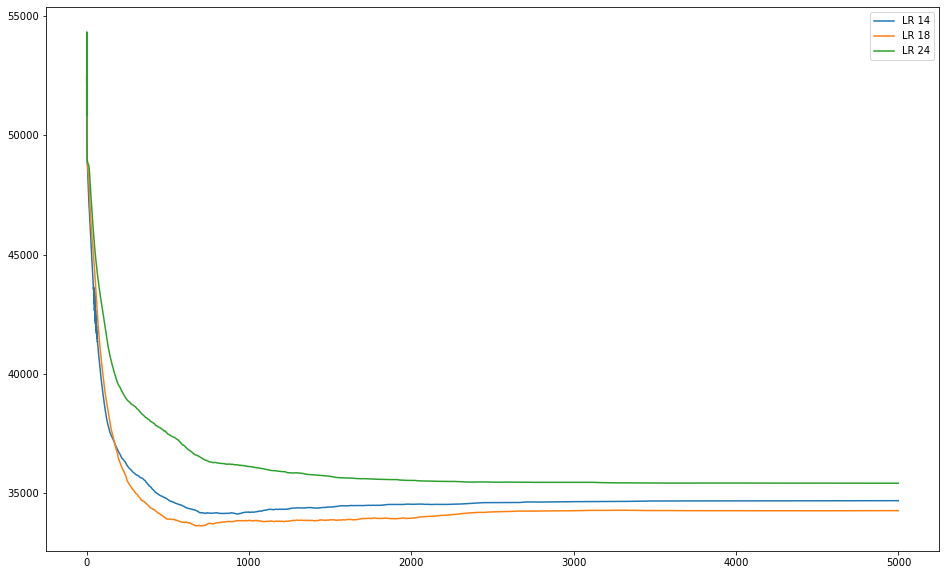

In [102]:
plt.figure(figsize=(16,10))

for i, r in enumerate(results6):
    plt.plot(r, label="LR {}".format(hidden[i]))
    plt.legend()

In [705]:
X_data = pd.read_csv('letter-recognition.data', sep=",")

In [706]:
y_data = np.array(X_data.pop(X_data.columns[0]))
X_data = np.array(X_data, dtype='float64')

In [707]:
y_data = y_data.astype(dtype='<U1')

In [708]:
unique, counts = np.unique(y_data, return_counts=True)
values = dict(zip(unique, counts))

In [709]:
print(X_data.shape, y_data.shape)

(19999, 16) (19999,)


In [710]:
y_data = np.array(y_data.view(np.uint32)) - 65


In [711]:
unique, counts = np.unique(y_data, return_counts=True)
values = dict(zip(unique, counts))

In [712]:
X_data /= np.max(X_data)

In [713]:
#Uncomment to return numbers to letters
#np.char.mod('%c', y_data+65)

In [714]:
#values

In [715]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.25, train_size = 0.75)

In [716]:
y_train_wide = to_categorical(y_train)
y_test_wide = to_categorical(y_test)

In [88]:
train_pred_wide = mlp.predict(X_train)
test_pred_wide = mlp.predict(X_test)

In [89]:
# TO DO - ADD HISTORY (loss and accuracy) AND A WAY TO SAVE THE WEIGHTS.

SIGMOID FUNCtion preDICTING EVERYTHIGN THE SAME CLASS

In [90]:
train_pred = np.argmax(train_pred_wide, axis=1)
test_pred = np.argmax(test_pred_wide, axis=1)

In [91]:
(train_pred == y_train).sum()/y_train.shape[0] * 100

31.348756583772253

In [92]:
((test_pred == y_test).sum()/y_test.shape[0]) * 100

31.3

In [70]:
# print(metrics.classification_report(y_train, train_pred))

In [365]:
def save_iter(thing, path):
    textfile = open(path, "w")
    for element in thing:
        textfile.write(str(element) + "\n")
    textfile.close()

In [21]:
test = np.array([1,2,3])
for e in test:
    print(e)

1
2
3
